In [1]:
%matplotlib inline

# Fitting TESS FFIs

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.6


This tutorial is nearly identical to the :ref:`tess` tutorial with added support for the TESS full frame images using [tesscut](https://mast.stsci.edu/tesscut/).

First, we query the TESS input catalog for the coordinates and properties of this source:

In [3]:
import numpy as np
from astroquery.mast import Catalogs

ticid = 49899799
tic = Catalogs.query_object("TIC {0}".format(ticid), radius=0.2, catalog="TIC")
star = tic[np.argmin(tic["dstArcSec"])]

tic_mass = float(star["mass"]), float(star["e_mass"])
tic_radius = float(star["rad"]), float(star["e_rad"])

Then we download the data from tesscut.
This is similar to what we did in the :ref:`tess` tutorial, but we need to do some background subtraction because the pipeline doesn't seem to do too well for the official TESS FFIs.

In [4]:
from io import BytesIO
from zipfile import ZipFile

from astropy.io import fits
from astropy.utils.data import download_file

# Download the cutout
url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={0[ra]}&dec={0[dec]}&y=15&x=15&units=px&sector=All".format(star)
fn = download_file(url, cache=True)
with ZipFile(fn, "r") as f:
    with fits.open(BytesIO(f.read(f.namelist()[0]))) as hdus:
        tpf = hdus[1].data
        tpf_hdr = hdus[1].header

texp = tpf_hdr["FRAMETIM"] * tpf_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
time = tpf["TIME"]
flux = tpf["FLUX"]
m = np.any(np.isfinite(flux), axis=(1, 2)) & (tpf["QUALITY"] == 0)
ref_time = 0.5 * (np.min(time[m])+np.max(time[m]))
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)

# Compute the median image
mean_img = np.median(flux, axis=0)

# Sort the pixels by median brightness
order = np.argsort(mean_img.flatten())[::-1]

# Choose a mask for the background
bkg_mask = np.zeros_like(mean_img, dtype=bool)
bkg_mask[np.unravel_index(order[-100:], mean_img.shape)] = True
flux -= np.median(flux[:, bkg_mask], axis=-1)[:, None, None]

Everything below this line is the same as the :ref:`tess` tutorial.

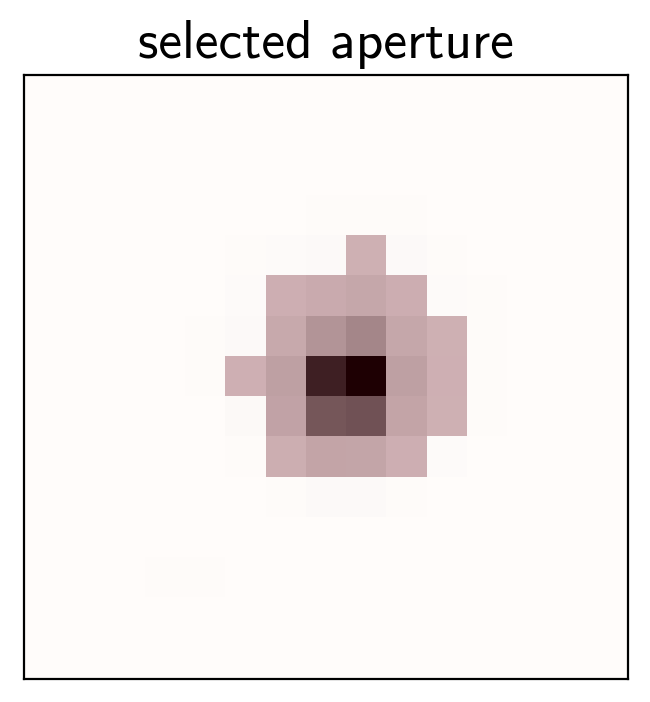

In [5]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# A function to estimate the windowed scatter in a lightcurve
def estimate_scatter_with_mask(mask):
    f = np.sum(flux[:, mask], axis=-1)
    smooth = savgol_filter(f, 1001, polyorder=5)
    return 1e6 * np.sqrt(np.median((f / smooth - 1)**2))

# Loop over pixels ordered by brightness and add them one-by-one
# to the aperture
masks, scatters = [], []
for i in range(1, 100):
    msk = np.zeros_like(mean_img, dtype=bool)
    msk[np.unravel_index(order[:i], mean_img.shape)] = True
    scatter = estimate_scatter_with_mask(msk)
    masks.append(msk)
    scatters.append(scatter)

# Choose the aperture that minimizes the scatter
pix_mask = masks[np.argmin(scatters)]

# Plot the selected aperture
plt.imshow(mean_img.T, cmap="gray_r")
plt.imshow(pix_mask.T, cmap="Reds", alpha=0.3)
plt.title("selected aperture")
plt.xticks([])
plt.yticks([]);

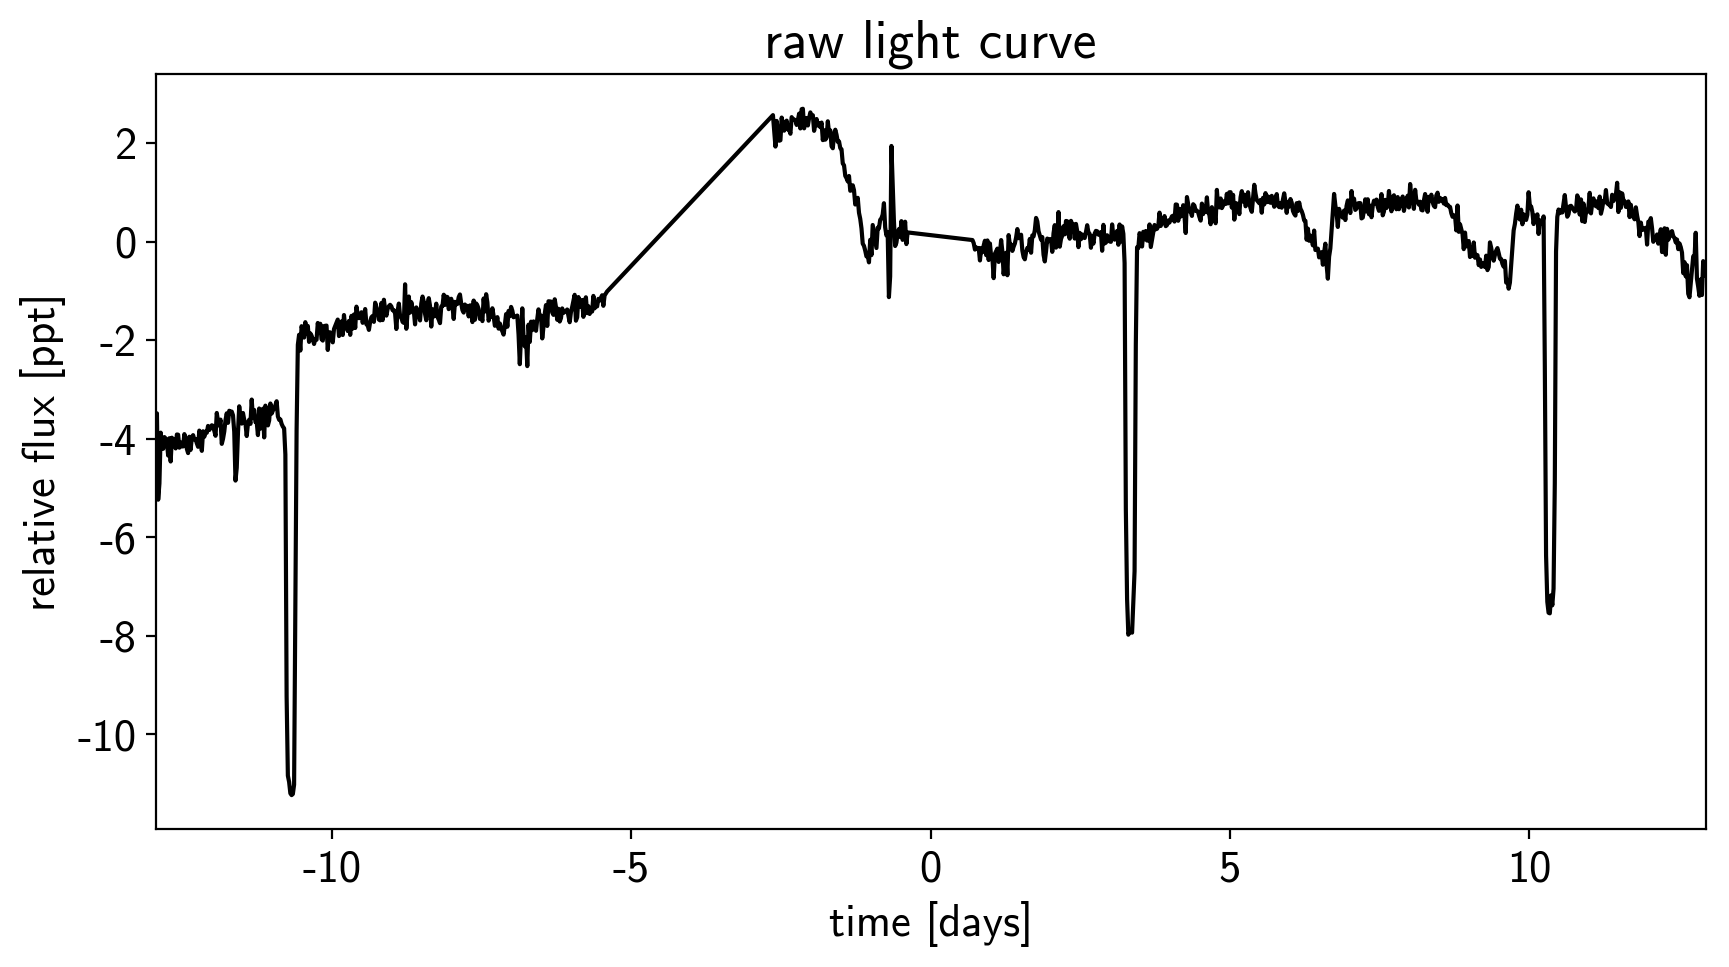

In [6]:
plt.figure(figsize=(10, 5))
sap_flux = np.sum(flux[:, pix_mask], axis=-1)
sap_flux = (sap_flux / np.median(sap_flux) - 1) * 1e3
plt.plot(time, sap_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("raw light curve")
plt.xlim(time.min(), time.max());

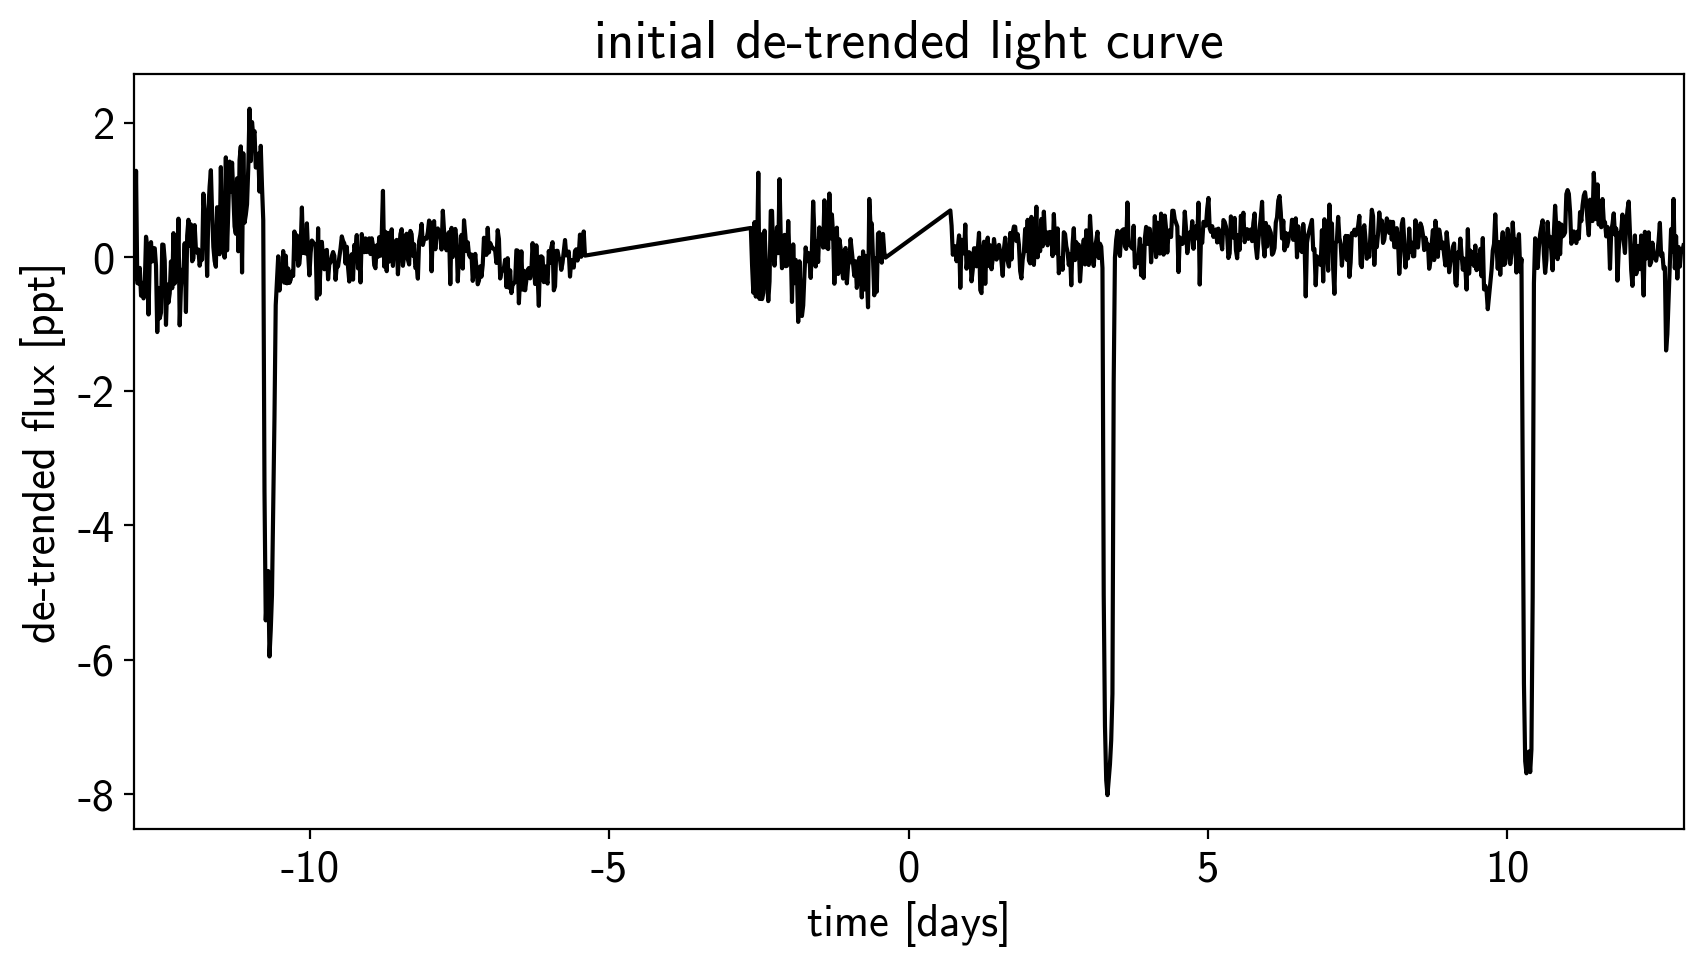

In [7]:
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, :X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, sap_flux))
pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(time, sap_flux-pld_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(time.min(), time.max());

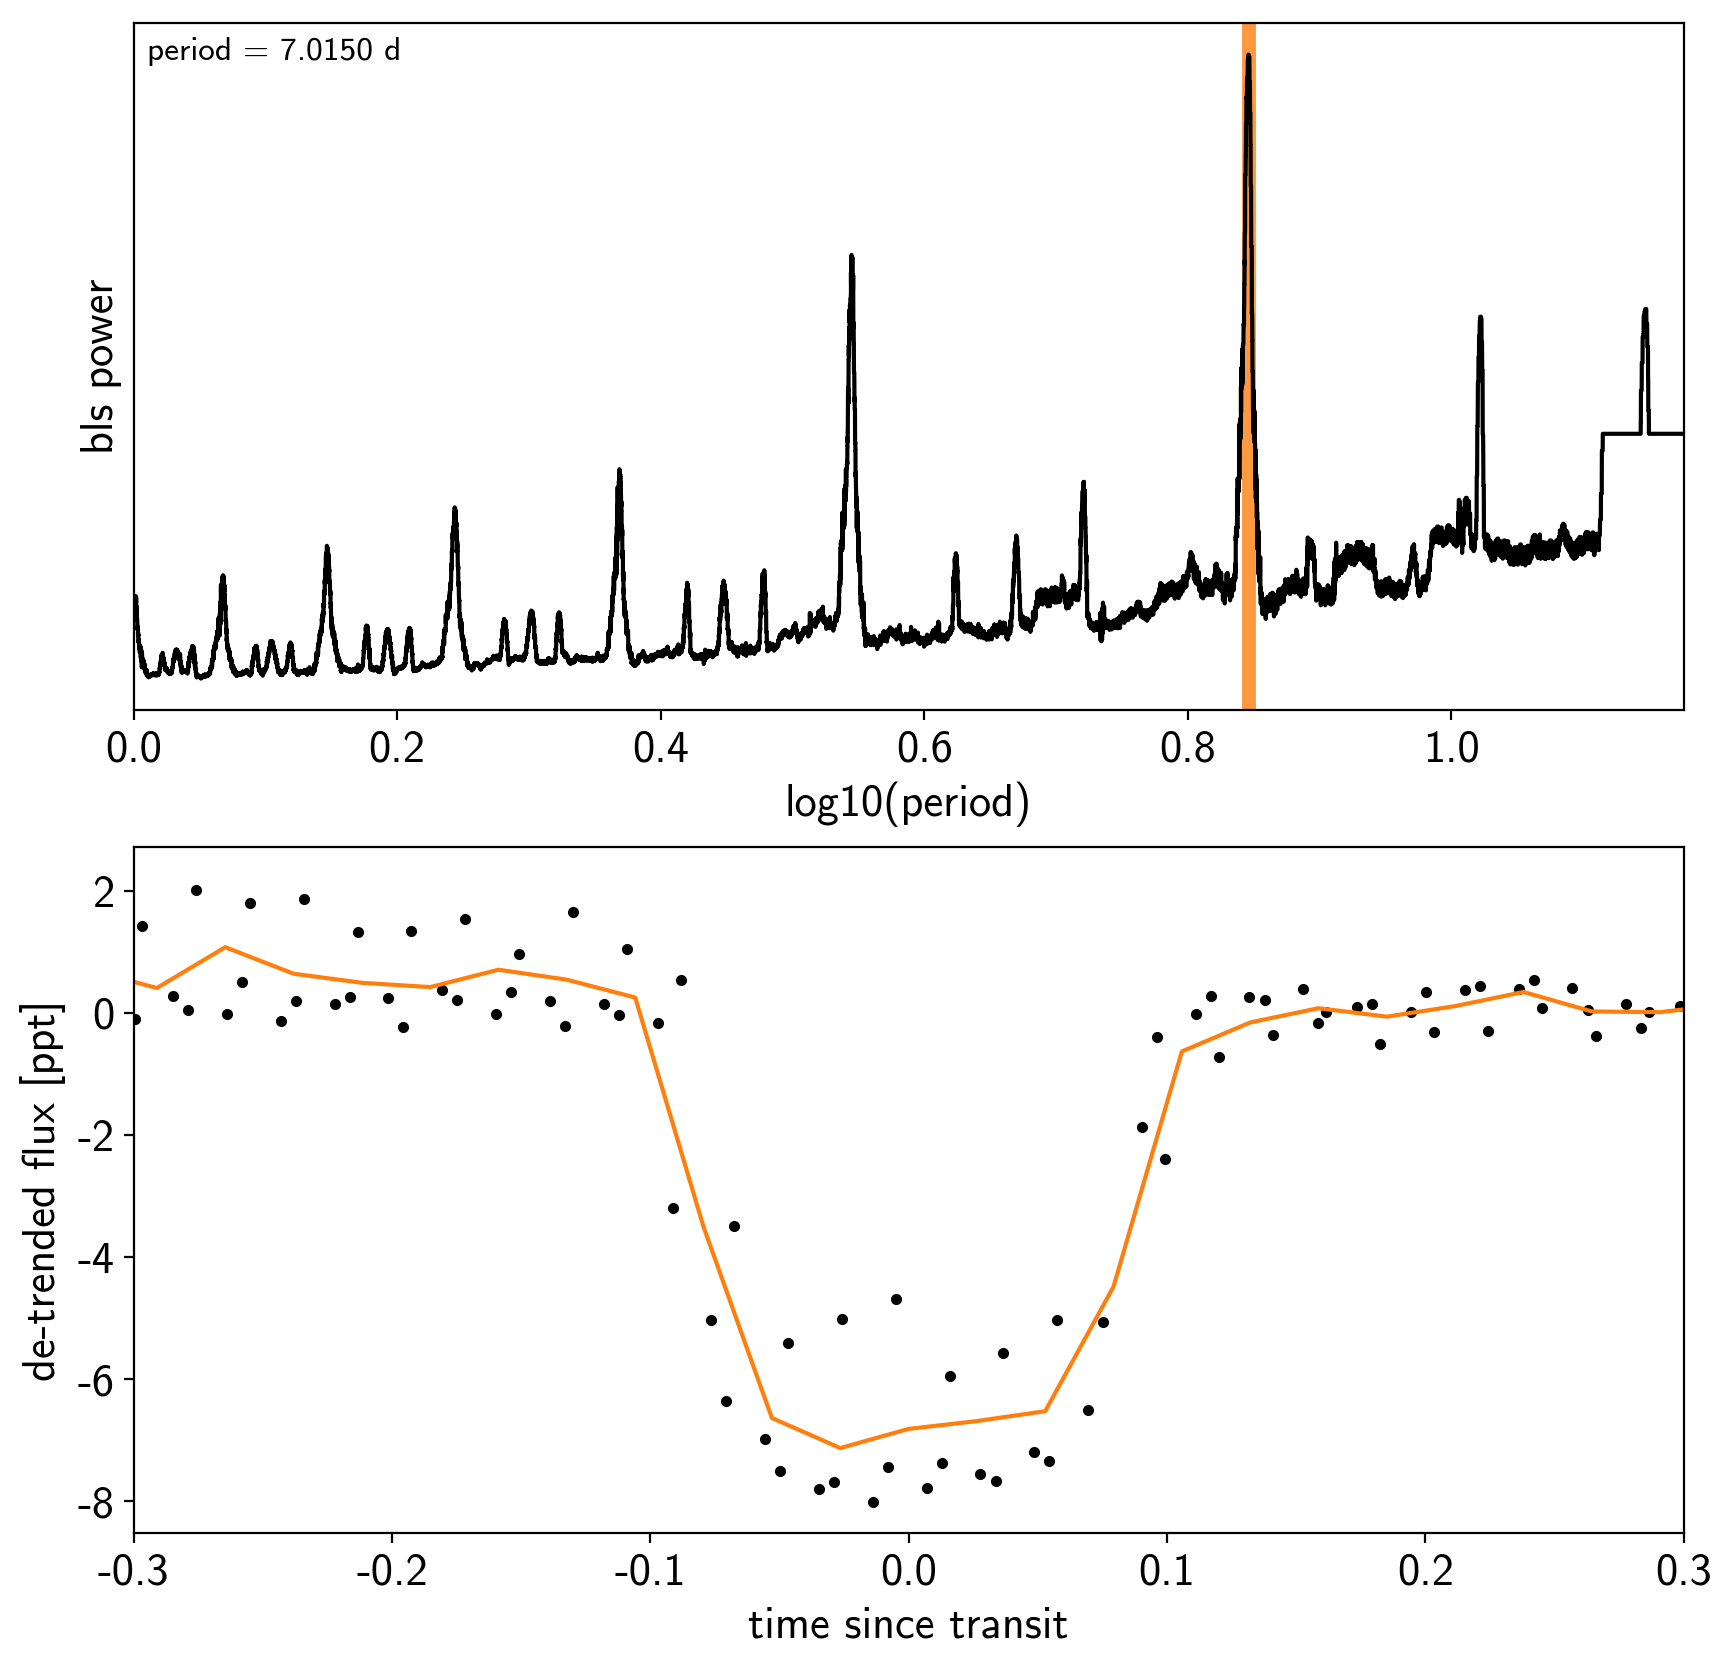

In [8]:
from astropy.stats import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(time, sap_flux - pld_flux)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate("period = {0:.4f} d".format(bls_period),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (time - bls_t0 + 0.5*bls_period)%bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], sap_flux[m] - pld_flux[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=sap_flux - pld_flux)
denom[num == 0] = 1.0
ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
ax.set_xlabel("time since transit");

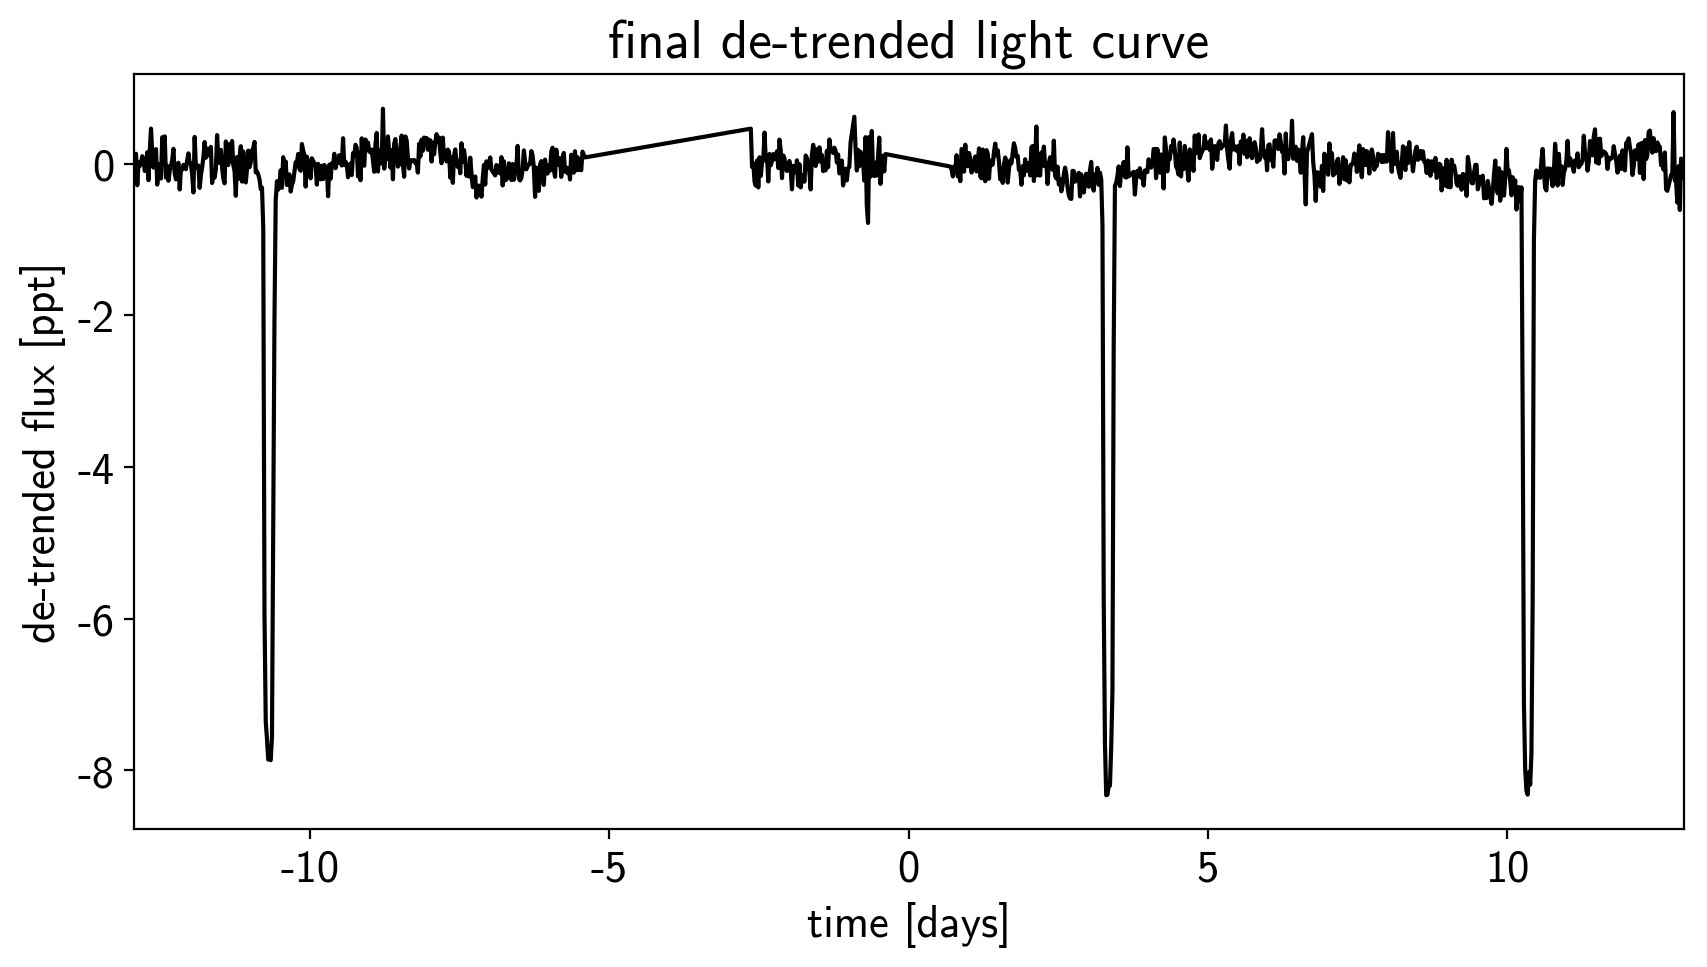

In [9]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, sap_flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(sap_flux-pld_flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(time, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(time.min(), time.max());

In [10]:
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        
        # Stellar parameters from TIC
        M_star_huang = 1.094, 0.039
        R_star_huang = 1.10, 0.023
        m_star = pm.Normal("m_star", mu=tic_mass[0], sd=tic_mass[1])
        r_star = pm.Normal("r_star", mu=tic_radius[0], sd=tic_radius[1])

        # Prior to require physical parameters
        pm.Potential("m_star_prior", tt.switch(m_star > 0, 0, -np.inf))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))

        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_period), sd=1)
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        b = pm.Uniform("b", lower=0, upper=1, testval=0.5)
        logr = pm.Normal("logr", sd=1.0,
                         mu=0.5*np.log(1e-3*np.array(bls_depth))+np.log(tic_radius[0]))
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        
        # This is the eccentricity prior from Kipping (2013):
        # https://arxiv.org/abs/1306.4982
        ecc = pm.Beta("ecc", alpha=0.867, beta=3.03, testval=0.1)
        omega = xo.distributions.Angle("omega")

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega)
        pm.Deterministic("a", orbit.a_planet)
        pm.Deterministic("incl", orbit.incl)

        # Compute the model light curve using starry
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower, logw0])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

optimizing logp for variables: ['b_interval__']


message: Optimization terminated successfully.
logp: -1187.4649971584893 -> -1167.1812080299917


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: -1167.181208029992 -> 66.71318590430374


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 66.71318590430374 -> 106.91173137171472


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_logodds__', 'logr', 'b_interval__', 't0', 'logP', 'r_star', 'm_star', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 106.9117313717145 -> 343.1349315401228


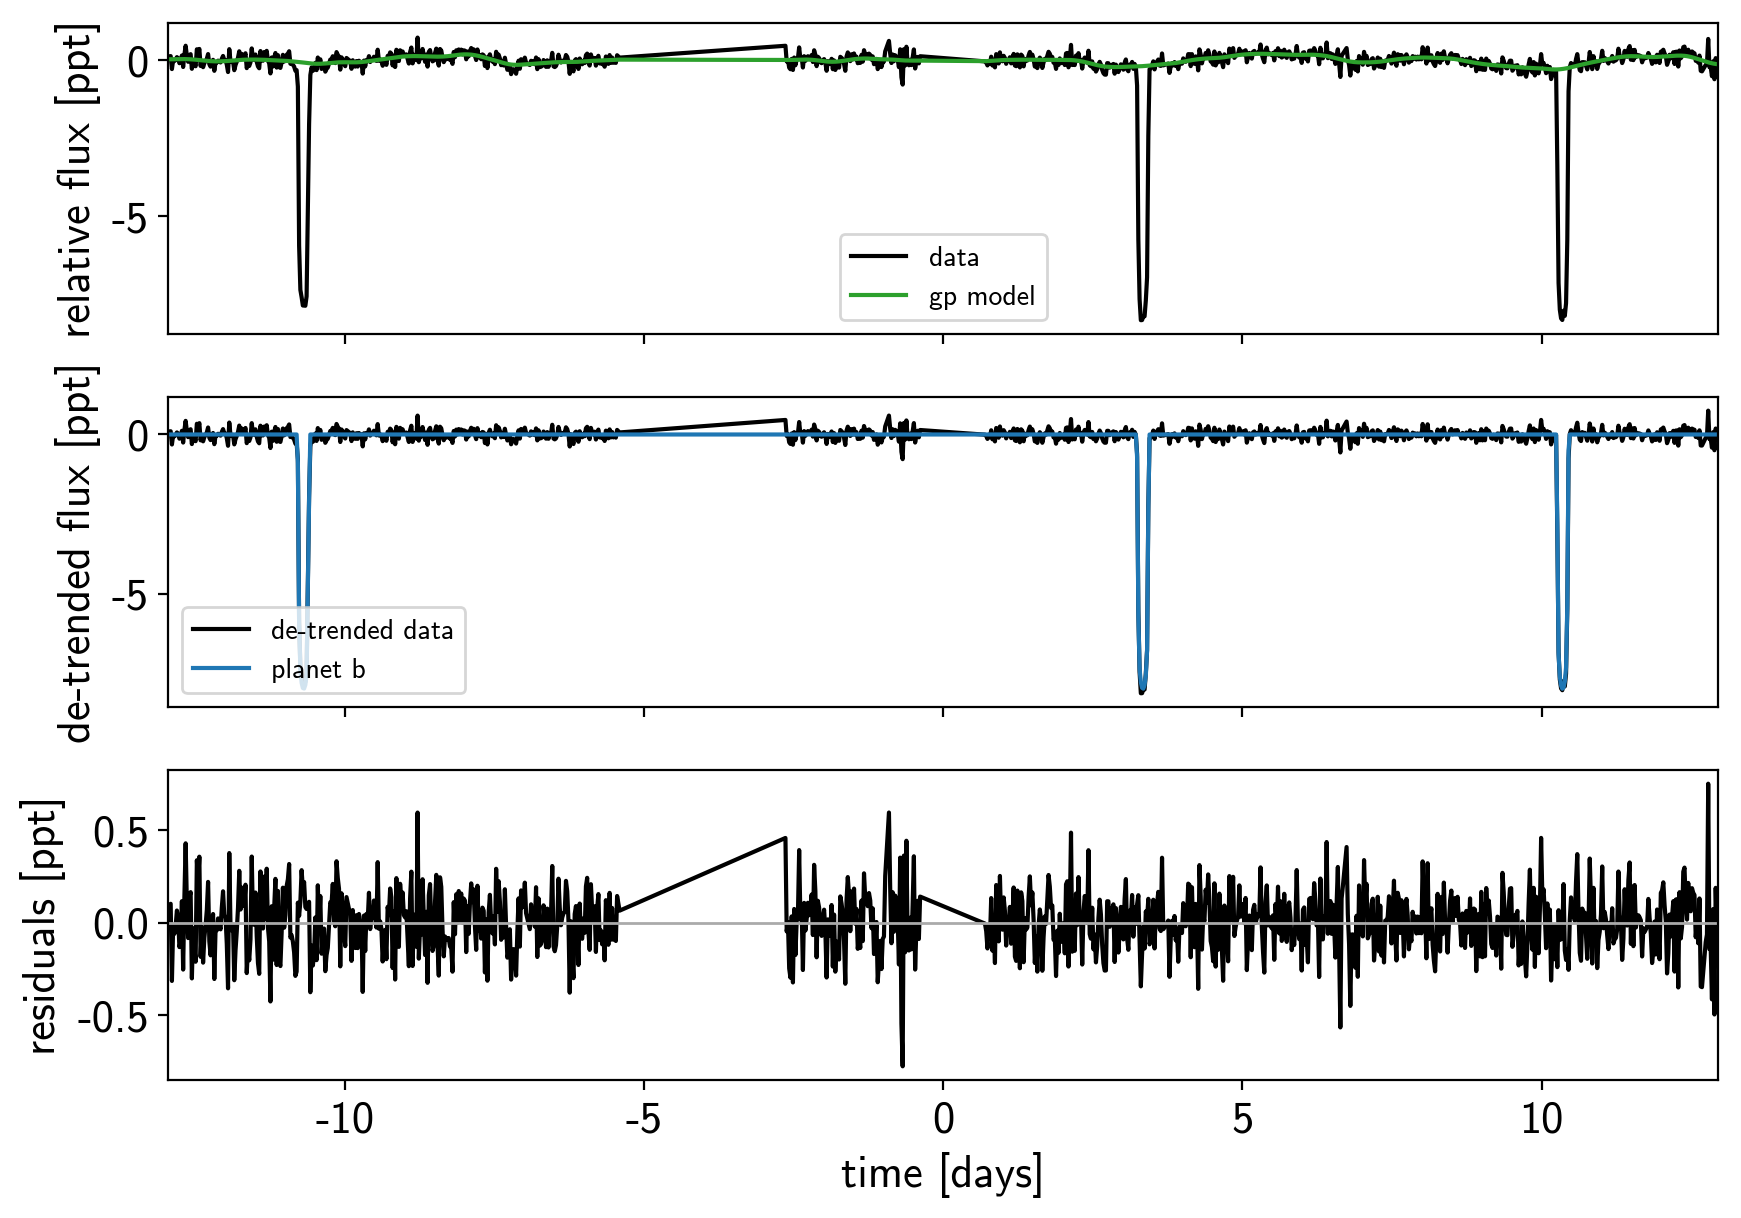

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

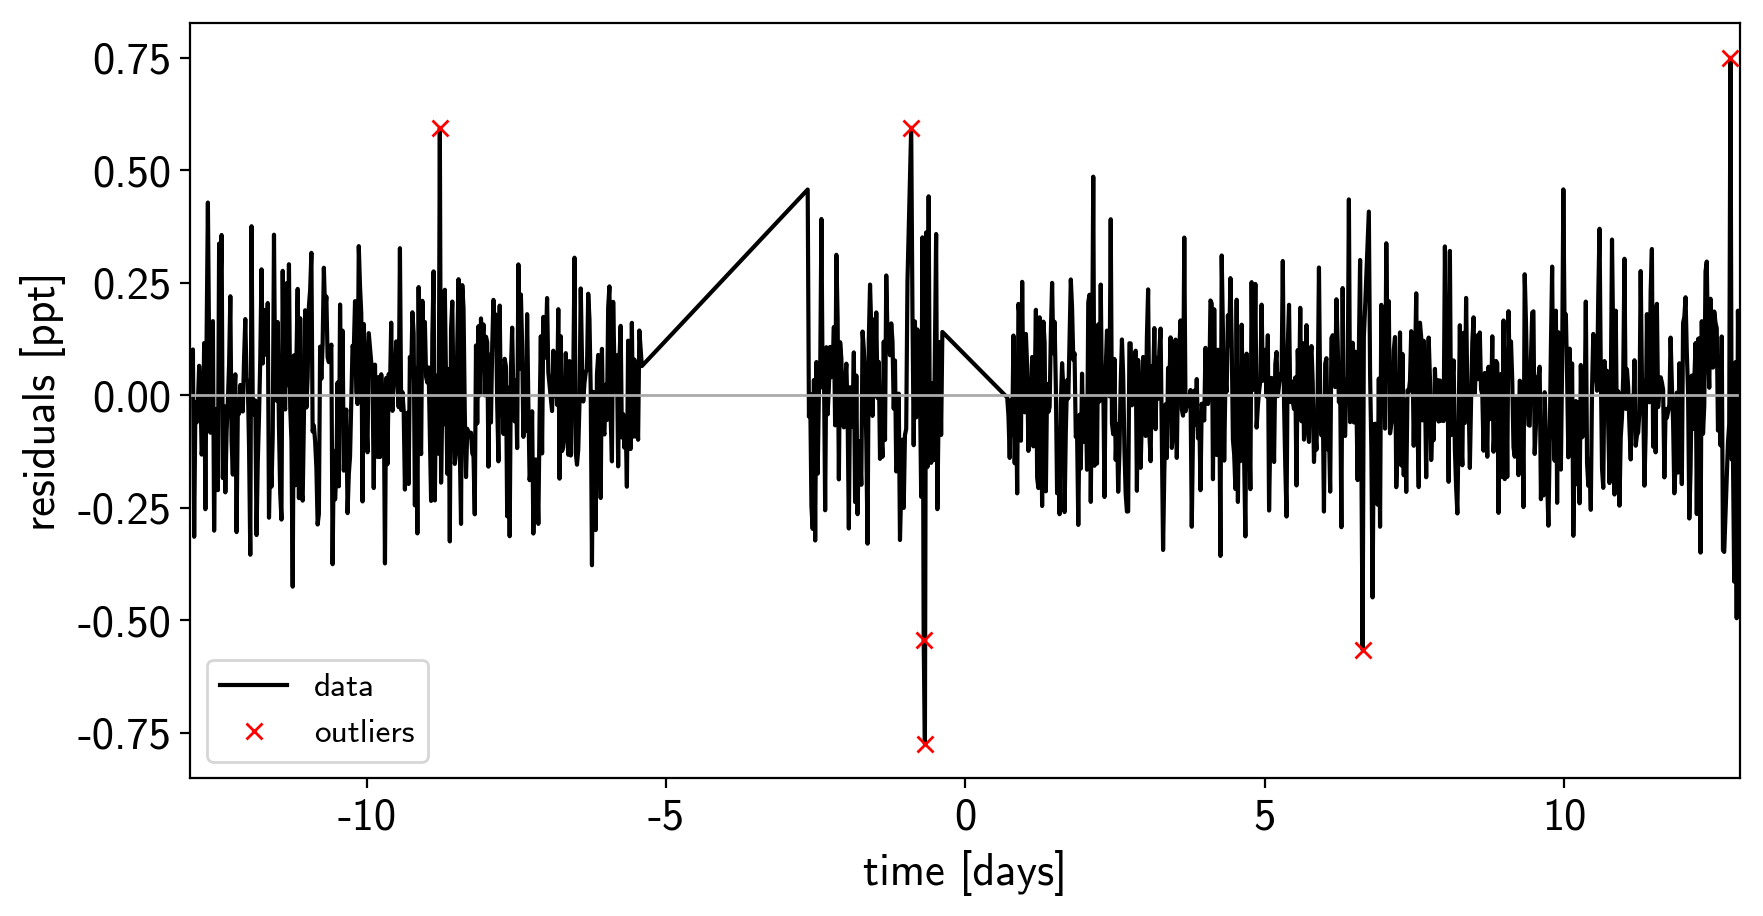

In [12]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

optimizing logp for variables: ['b_interval__']


message: Optimization terminated successfully.
logp: 385.5369927156757 -> 385.5369927169309


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 385.53699271693114 -> 388.4181918654495


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 388.4181918654495 -> 388.4388036404506


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_logodds__', 'logr', 'b_interval__', 't0', 'logP', 'r_star', 'm_star', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 388.4388036404497 -> 388.4492815037509


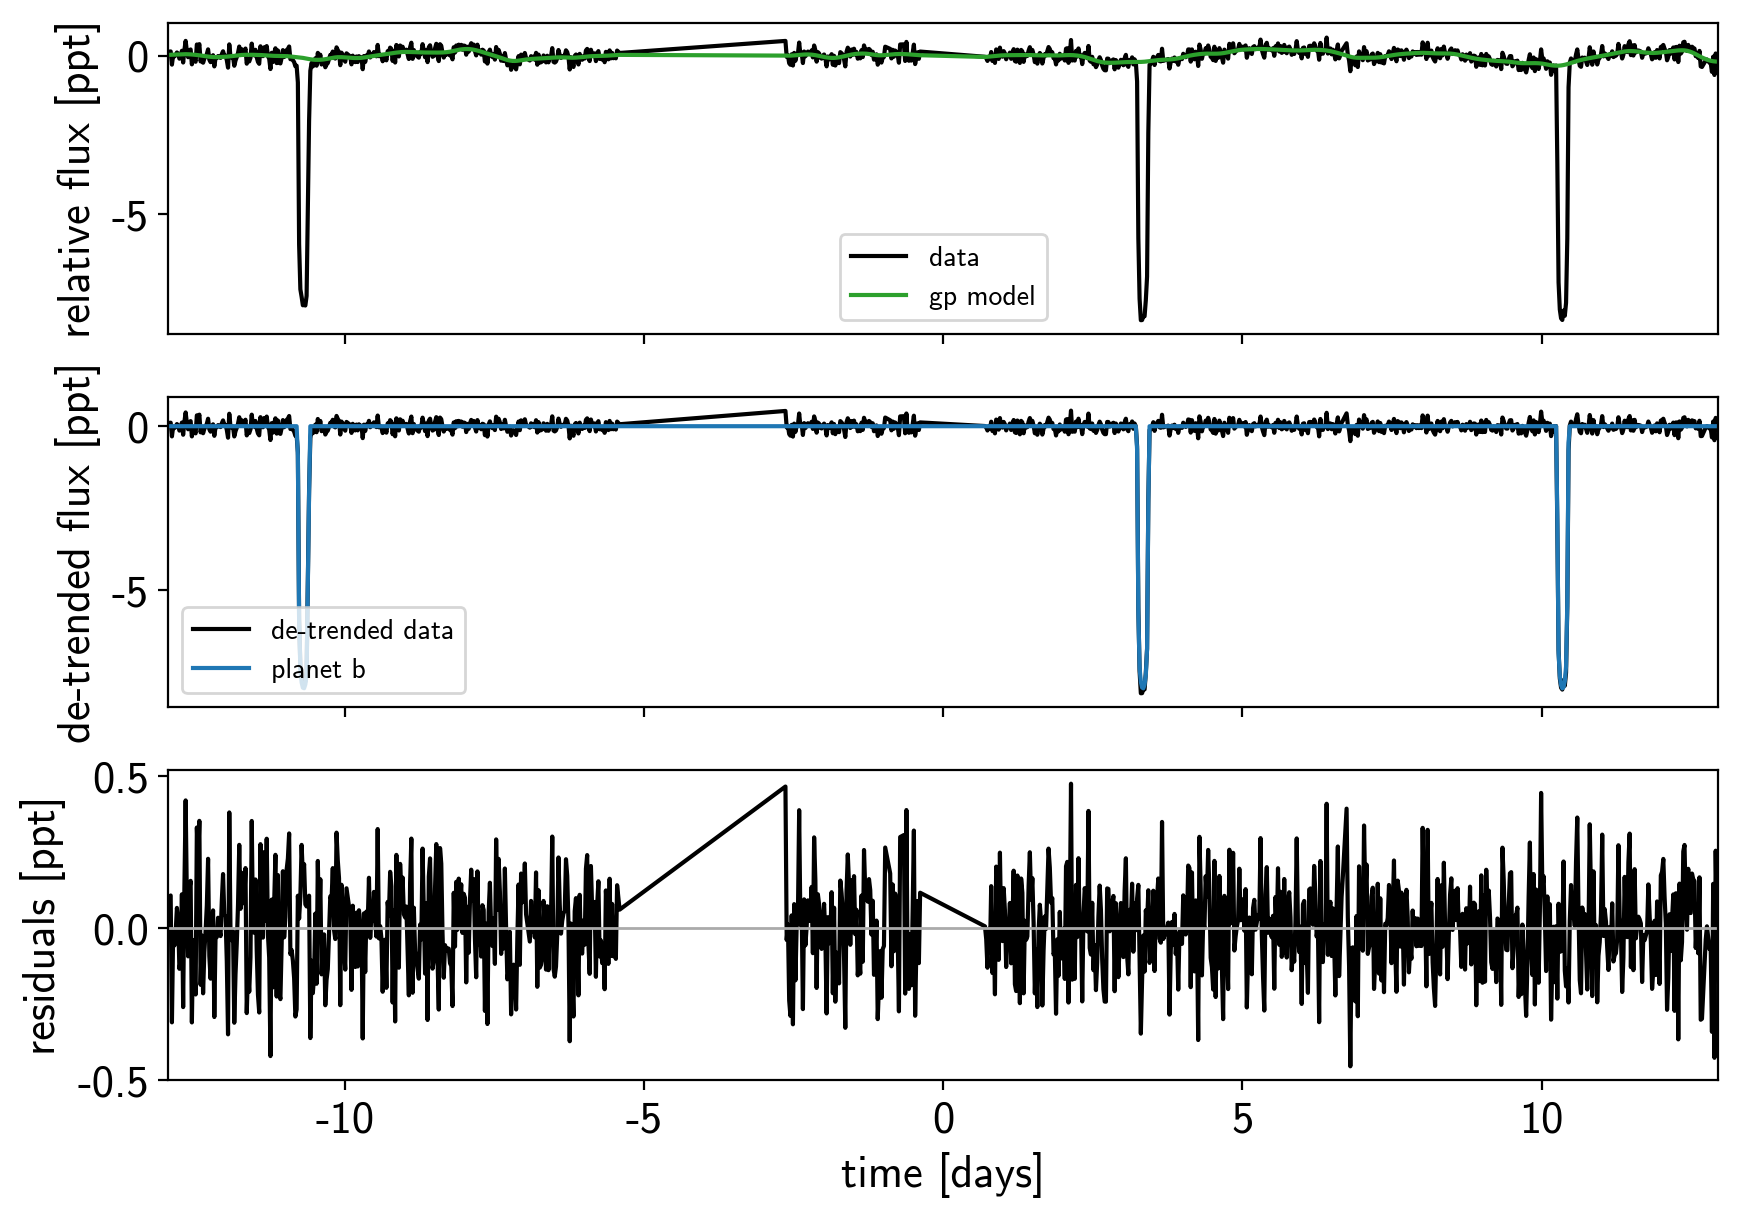

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

In [14]:
np.random.seed(12345)
sampler = xo.PyMC3Sampler(window=100, start=300, finish=500)
with model:
    burnin = sampler.tune(tune=3500, start=map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=4)

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|▏         | 17/1208 [00:00<00:07, 156.50draws/s]

Sampling 4 chains:   2%|▏         | 22/1208 [00:00<00:45, 26.08draws/s] 

Sampling 4 chains:   2%|▏         | 26/1208 [00:00<00:59, 19.75draws/s]

Sampling 4 chains:   2%|▏         | 30/1208 [00:01<01:09, 16.89draws/s]

Sampling 4 chains:   3%|▎         | 34/1208 [00:01<01:16, 15.33draws/s]

Sampling 4 chains:   3%|▎         | 38/1208 [00:01<01:21, 14.40draws/s]

Sampling 4 chains:   3%|▎         | 41/1208 [00:02<01:09, 16.82draws/s]

Sampling 4 chains:   4%|▎         | 44/1208 [00:02<01:19, 14.71draws/s]

Sampling 4 chains:   4%|▍         | 46/1208 [00:02<01:40, 11.51draws/s]

Sampling 4 chains:   4%|▍         | 49/1208 [00:02<01:25, 13.48draws/s]

Sampling 4 chains:   4%|▍         | 51/1208 [00:02<01:39, 11.63draws/s]

Sampling 4 chains:   4%|▍         | 53/1208 [00:03<01:27, 13.16draws/s]

Sampling 4 chains:   5%|▍         | 55/1208 [00:03<01:37, 11.78draws/s]

Sampling 4 chains:   5%|▍         | 57/1208 [00:03<01:28, 12.97draws/s]

Sampling 4 chains:   5%|▍         | 59/1208 [00:03<01:35, 11.98draws/s]

Sampling 4 chains:   5%|▌         | 61/1208 [00:03<01:29, 12.75draws/s]

Sampling 4 chains:   5%|▌         | 63/1208 [00:03<01:35, 11.98draws/s]

Sampling 4 chains:   5%|▌         | 66/1208 [00:04<01:25, 13.35draws/s]

Sampling 4 chains:   6%|▌         | 68/1208 [00:04<01:25, 13.26draws/s]

Sampling 4 chains:   6%|▌         | 70/1208 [00:04<01:30, 12.57draws/s]

Sampling 4 chains:   6%|▌         | 72/1208 [00:04<01:22, 13.70draws/s]

Sampling 4 chains:   6%|▌         | 75/1208 [00:04<01:22, 13.73draws/s]

Sampling 4 chains:   6%|▋         | 77/1208 [00:04<01:17, 14.52draws/s]

Sampling 4 chains:   7%|▋         | 79/1208 [00:05<01:31, 12.36draws/s]

Sampling 4 chains:   7%|▋         | 81/1208 [00:05<01:21, 13.91draws/s]

Sampling 4 chains:   7%|▋         | 83/1208 [00:05<01:35, 11.74draws/s]

Sampling 4 chains:   7%|▋         | 86/1208 [00:05<01:24, 13.23draws/s]

Sampling 4 chains:   7%|▋         | 88/1208 [00:05<01:37, 11.50draws/s]

Sampling 4 chains:   8%|▊         | 91/1208 [00:06<01:38, 11.29draws/s]

Sampling 4 chains:   8%|▊         | 94/1208 [00:06<01:24, 13.22draws/s]

Sampling 4 chains:   8%|▊         | 96/1208 [00:06<01:36, 11.54draws/s]

Sampling 4 chains:   8%|▊         | 99/1208 [00:06<01:40, 11.00draws/s]

Sampling 4 chains:   8%|▊         | 102/1208 [00:06<01:22, 13.38draws/s]

Sampling 4 chains:   9%|▊         | 104/1208 [00:07<01:34, 11.65draws/s]

Sampling 4 chains:   9%|▉         | 107/1208 [00:07<01:40, 10.93draws/s]

Sampling 4 chains:   9%|▉         | 111/1208 [00:07<01:36, 11.42draws/s]

Sampling 4 chains:   9%|▉         | 114/1208 [00:07<01:18, 13.89draws/s]

Sampling 4 chains:  10%|▉         | 116/1208 [00:07<01:29, 12.18draws/s]

Sampling 4 chains:  10%|▉         | 118/1208 [00:08<01:19, 13.63draws/s]

Sampling 4 chains:  10%|▉         | 120/1208 [00:08<01:30, 12.05draws/s]

Sampling 4 chains:  10%|█         | 122/1208 [00:08<01:21, 13.29draws/s]

Sampling 4 chains:  10%|█         | 124/1208 [00:08<01:29, 12.09draws/s]

Sampling 4 chains:  10%|█         | 126/1208 [00:08<01:21, 13.25draws/s]

Sampling 4 chains:  11%|█         | 128/1208 [00:08<01:28, 12.15draws/s]

Sampling 4 chains:  11%|█         | 130/1208 [00:09<01:18, 13.65draws/s]

Sampling 4 chains:  11%|█         | 133/1208 [00:09<01:17, 13.79draws/s]

Sampling 4 chains:  11%|█         | 135/1208 [00:09<01:14, 14.50draws/s]

Sampling 4 chains:  11%|█▏        | 137/1208 [00:09<01:22, 12.93draws/s]

Sampling 4 chains:  12%|█▏        | 139/1208 [00:09<01:19, 13.51draws/s]

Sampling 4 chains:  12%|█▏        | 141/1208 [00:09<01:24, 12.61draws/s]

Sampling 4 chains:  12%|█▏        | 143/1208 [00:10<01:23, 12.73draws/s]

Sampling 4 chains:  12%|█▏        | 145/1208 [00:10<01:23, 12.66draws/s]

Sampling 4 chains:  12%|█▏        | 147/1208 [00:10<01:25, 12.38draws/s]

Sampling 4 chains:  12%|█▏        | 149/1208 [00:10<01:22, 12.81draws/s]

Sampling 4 chains:  12%|█▎        | 151/1208 [00:10<01:26, 12.20draws/s]

Sampling 4 chains:  13%|█▎        | 153/1208 [00:10<01:22, 12.86draws/s]

Sampling 4 chains:  13%|█▎        | 155/1208 [00:11<01:25, 12.28draws/s]

Sampling 4 chains:  13%|█▎        | 157/1208 [00:11<01:20, 12.98draws/s]

Sampling 4 chains:  13%|█▎        | 159/1208 [00:11<01:25, 12.29draws/s]

Sampling 4 chains:  13%|█▎        | 161/1208 [00:11<01:20, 13.04draws/s]

Sampling 4 chains:  13%|█▎        | 163/1208 [00:11<01:27, 11.94draws/s]

Sampling 4 chains:  14%|█▎        | 165/1208 [00:11<01:19, 13.14draws/s]

Sampling 4 chains:  14%|█▍        | 167/1208 [00:11<01:26, 11.99draws/s]

Sampling 4 chains:  14%|█▍        | 169/1208 [00:12<01:18, 13.28draws/s]

Sampling 4 chains:  14%|█▍        | 171/1208 [00:12<01:26, 12.01draws/s]

Sampling 4 chains:  14%|█▍        | 173/1208 [00:12<01:17, 13.39draws/s]

Sampling 4 chains:  14%|█▍        | 175/1208 [00:12<01:26, 11.99draws/s]

Sampling 4 chains:  15%|█▍        | 177/1208 [00:12<01:17, 13.37draws/s]

Sampling 4 chains:  15%|█▍        | 179/1208 [00:12<01:25, 11.99draws/s]

Sampling 4 chains:  15%|█▍        | 181/1208 [00:13<01:16, 13.46draws/s]

Sampling 4 chains:  15%|█▌        | 183/1208 [00:13<01:25, 11.96draws/s]

Sampling 4 chains:  15%|█▌        | 185/1208 [00:13<01:15, 13.53draws/s]

Sampling 4 chains:  15%|█▌        | 187/1208 [00:13<01:26, 11.75draws/s]

Sampling 4 chains:  16%|█▌        | 189/1208 [00:13<01:17, 13.12draws/s]

Sampling 4 chains:  16%|█▌        | 191/1208 [00:13<01:25, 11.88draws/s]

Sampling 4 chains:  16%|█▌        | 193/1208 [00:14<01:18, 12.90draws/s]

Sampling 4 chains:  16%|█▌        | 195/1208 [00:14<01:24, 12.04draws/s]

Sampling 4 chains:  16%|█▋        | 197/1208 [00:14<01:19, 12.71draws/s]

Sampling 4 chains:  16%|█▋        | 199/1208 [00:14<01:22, 12.21draws/s]

Sampling 4 chains:  17%|█▋        | 201/1208 [00:14<01:20, 12.52draws/s]

Sampling 4 chains:  17%|█▋        | 203/1208 [00:14<01:21, 12.38draws/s]

Sampling 4 chains:  17%|█▋        | 205/1208 [00:15<01:21, 12.33draws/s]

Sampling 4 chains:  17%|█▋        | 207/1208 [00:15<01:19, 12.56draws/s]

Sampling 4 chains:  17%|█▋        | 210/1208 [00:15<01:13, 13.62draws/s]

Sampling 4 chains:  18%|█▊        | 212/1208 [00:15<01:13, 13.48draws/s]

Sampling 4 chains:  18%|█▊        | 214/1208 [00:15<01:18, 12.65draws/s]

Sampling 4 chains:  18%|█▊        | 216/1208 [00:15<01:15, 13.20draws/s]

Sampling 4 chains:  18%|█▊        | 218/1208 [00:15<01:21, 12.18draws/s]

Sampling 4 chains:  18%|█▊        | 220/1208 [00:16<01:14, 13.19draws/s]

Sampling 4 chains:  18%|█▊        | 222/1208 [00:16<01:11, 13.74draws/s]

Sampling 4 chains:  19%|█▊        | 224/1208 [00:16<01:13, 13.35draws/s]

Sampling 4 chains:  19%|█▊        | 226/1208 [00:16<01:14, 13.19draws/s]

Sampling 4 chains:  19%|█▉        | 228/1208 [00:16<01:16, 12.89draws/s]

Sampling 4 chains:  19%|█▉        | 230/1208 [00:16<01:15, 13.02draws/s]

Sampling 4 chains:  19%|█▉        | 232/1208 [00:17<01:16, 12.69draws/s]

Sampling 4 chains:  19%|█▉        | 234/1208 [00:17<01:15, 12.95draws/s]

Sampling 4 chains:  20%|█▉        | 236/1208 [00:17<01:17, 12.57draws/s]

Sampling 4 chains:  20%|█▉        | 238/1208 [00:17<01:14, 12.95draws/s]

Sampling 4 chains:  20%|█▉        | 240/1208 [00:17<01:17, 12.50draws/s]

Sampling 4 chains:  20%|██        | 242/1208 [00:17<01:14, 12.91draws/s]

Sampling 4 chains:  20%|██        | 244/1208 [00:17<01:17, 12.46draws/s]

Sampling 4 chains:  20%|██        | 246/1208 [00:18<01:14, 12.97draws/s]

Sampling 4 chains:  21%|██        | 248/1208 [00:18<01:17, 12.40draws/s]

Sampling 4 chains:  21%|██        | 250/1208 [00:18<01:18, 12.26draws/s]

Sampling 4 chains:  21%|██        | 252/1208 [00:18<01:16, 12.51draws/s]

Sampling 4 chains:  21%|██        | 254/1208 [00:18<01:17, 12.33draws/s]

Sampling 4 chains:  21%|██        | 256/1208 [00:18<01:17, 12.26draws/s]

Sampling 4 chains:  21%|██▏       | 258/1208 [00:19<01:16, 12.46draws/s]

Sampling 4 chains:  22%|██▏       | 260/1208 [00:19<01:18, 12.09draws/s]

Sampling 4 chains:  22%|██▏       | 262/1208 [00:19<01:15, 12.54draws/s]

Sampling 4 chains:  22%|██▏       | 264/1208 [00:19<01:17, 12.10draws/s]

Sampling 4 chains:  22%|██▏       | 266/1208 [00:19<01:14, 12.64draws/s]

Sampling 4 chains:  22%|██▏       | 268/1208 [00:19<01:16, 12.28draws/s]

Sampling 4 chains:  22%|██▏       | 270/1208 [00:20<01:13, 12.68draws/s]

Sampling 4 chains:  23%|██▎       | 272/1208 [00:20<01:15, 12.40draws/s]

Sampling 4 chains:  23%|██▎       | 274/1208 [00:20<01:13, 12.68draws/s]

Sampling 4 chains:  23%|██▎       | 276/1208 [00:20<01:14, 12.47draws/s]

Sampling 4 chains:  23%|██▎       | 278/1208 [00:20<01:13, 12.65draws/s]

Sampling 4 chains:  23%|██▎       | 280/1208 [00:20<01:13, 12.54draws/s]

Sampling 4 chains:  23%|██▎       | 282/1208 [00:21<01:13, 12.61draws/s]

Sampling 4 chains:  24%|██▎       | 284/1208 [00:21<01:13, 12.59draws/s]

Sampling 4 chains:  24%|██▎       | 286/1208 [00:21<01:13, 12.57draws/s]

Sampling 4 chains:  24%|██▍       | 288/1208 [00:21<01:12, 12.66draws/s]

Sampling 4 chains:  24%|██▍       | 290/1208 [00:21<01:13, 12.42draws/s]

Sampling 4 chains:  24%|██▍       | 292/1208 [00:21<01:10, 13.05draws/s]

Sampling 4 chains:  24%|██▍       | 294/1208 [00:21<01:04, 14.16draws/s]

Sampling 4 chains:  25%|██▍       | 296/1208 [00:22<01:12, 12.50draws/s]

Sampling 4 chains:  25%|██▍       | 298/1208 [00:22<01:08, 13.28draws/s]

Sampling 4 chains:  25%|██▍       | 300/1208 [00:22<01:13, 12.35draws/s]

Sampling 4 chains:  25%|██▌       | 302/1208 [00:22<01:10, 12.86draws/s]

Sampling 4 chains:  25%|██▌       | 305/1208 [00:22<01:06, 13.67draws/s]

Sampling 4 chains:  25%|██▌       | 307/1208 [00:22<01:07, 13.40draws/s]

Sampling 4 chains:  26%|██▌       | 309/1208 [00:23<01:08, 13.09draws/s]

Sampling 4 chains:  26%|██▌       | 311/1208 [00:23<01:10, 12.71draws/s]

Sampling 4 chains:  26%|██▌       | 313/1208 [00:23<01:09, 12.95draws/s]

Sampling 4 chains:  26%|██▌       | 315/1208 [00:23<01:12, 12.31draws/s]

Sampling 4 chains:  26%|██▌       | 317/1208 [00:23<01:08, 12.96draws/s]

Sampling 4 chains:  26%|██▋       | 319/1208 [00:23<01:13, 12.05draws/s]

Sampling 4 chains:  27%|██▋       | 321/1208 [00:24<01:08, 12.94draws/s]

Sampling 4 chains:  27%|██▋       | 323/1208 [00:24<01:15, 11.80draws/s]

Sampling 4 chains:  27%|██▋       | 325/1208 [00:24<01:07, 13.12draws/s]

Sampling 4 chains:  27%|██▋       | 327/1208 [00:24<01:15, 11.66draws/s]

Sampling 4 chains:  27%|██▋       | 329/1208 [00:24<01:06, 13.31draws/s]

Sampling 4 chains:  27%|██▋       | 331/1208 [00:24<01:16, 11.51draws/s]

Sampling 4 chains:  28%|██▊       | 335/1208 [00:25<01:14, 11.78draws/s]

Sampling 4 chains:  28%|██▊       | 339/1208 [00:25<01:12, 11.99draws/s]

Sampling 4 chains:  28%|██▊       | 343/1208 [00:25<01:11, 12.10draws/s]

Sampling 4 chains:  29%|██▊       | 347/1208 [00:26<01:10, 12.22draws/s]

Sampling 4 chains:  29%|██▉       | 351/1208 [00:26<01:09, 12.31draws/s]

Sampling 4 chains:  29%|██▉       | 355/1208 [00:26<01:08, 12.37draws/s]

Sampling 4 chains:  30%|██▉       | 359/1208 [00:27<01:08, 12.42draws/s]

Sampling 4 chains:  30%|███       | 363/1208 [00:27<01:07, 12.45draws/s]

Sampling 4 chains:  30%|███       | 367/1208 [00:27<01:07, 12.47draws/s]

Sampling 4 chains:  31%|███       | 371/1208 [00:28<01:07, 12.46draws/s]

Sampling 4 chains:  31%|███       | 375/1208 [00:28<01:06, 12.48draws/s]

Sampling 4 chains:  31%|███▏      | 379/1208 [00:28<00:53, 15.58draws/s]

Sampling 4 chains:  32%|███▏      | 381/1208 [00:28<01:10, 11.65draws/s]

Sampling 4 chains:  32%|███▏      | 384/1208 [00:29<01:10, 11.62draws/s]

Sampling 4 chains:  32%|███▏      | 387/1208 [00:29<00:59, 13.73draws/s]

Sampling 4 chains:  32%|███▏      | 389/1208 [00:29<01:12, 11.37draws/s]

Sampling 4 chains:  32%|███▏      | 392/1208 [00:29<01:11, 11.34draws/s]

Sampling 4 chains:  33%|███▎      | 395/1208 [00:29<01:02, 13.11draws/s]

Sampling 4 chains:  33%|███▎      | 397/1208 [00:30<01:10, 11.57draws/s]

Sampling 4 chains:  33%|███▎      | 399/1208 [00:30<01:02, 13.02draws/s]

Sampling 4 chains:  33%|███▎      | 401/1208 [00:30<01:08, 11.78draws/s]

Sampling 4 chains:  33%|███▎      | 403/1208 [00:30<01:02, 12.89draws/s]

Sampling 4 chains:  34%|███▎      | 405/1208 [00:30<01:07, 11.96draws/s]

Sampling 4 chains:  34%|███▎      | 407/1208 [00:30<01:02, 12.73draws/s]

Sampling 4 chains:  34%|███▍      | 409/1208 [00:31<01:05, 12.15draws/s]

Sampling 4 chains:  34%|███▍      | 411/1208 [00:31<01:03, 12.56draws/s]

Sampling 4 chains:  34%|███▍      | 413/1208 [00:31<01:04, 12.32draws/s]

Sampling 4 chains:  34%|███▍      | 415/1208 [00:31<01:04, 12.31draws/s]

Sampling 4 chains:  35%|███▍      | 417/1208 [00:31<01:03, 12.52draws/s]

Sampling 4 chains:  35%|███▍      | 419/1208 [00:31<01:04, 12.16draws/s]

Sampling 4 chains:  35%|███▍      | 421/1208 [00:31<01:01, 12.70draws/s]

Sampling 4 chains:  35%|███▌      | 423/1208 [00:32<01:05, 12.01draws/s]

Sampling 4 chains:  35%|███▌      | 425/1208 [00:32<01:00, 12.90draws/s]

Sampling 4 chains:  35%|███▌      | 427/1208 [00:32<01:05, 11.85draws/s]

Sampling 4 chains:  36%|███▌      | 429/1208 [00:32<00:59, 13.10draws/s]

Sampling 4 chains:  36%|███▌      | 431/1208 [00:32<01:06, 11.70draws/s]

Sampling 4 chains:  36%|███▌      | 433/1208 [00:32<00:58, 13.31draws/s]

Sampling 4 chains:  36%|███▌      | 435/1208 [00:33<01:06, 11.55draws/s]

Sampling 4 chains:  36%|███▋      | 438/1208 [00:33<00:55, 13.87draws/s]

Sampling 4 chains:  36%|███▋      | 440/1208 [00:33<01:11, 10.70draws/s]

Sampling 4 chains:  37%|███▋      | 443/1208 [00:33<01:09, 10.97draws/s]

Sampling 4 chains:  37%|███▋      | 447/1208 [00:34<01:07, 11.30draws/s]

Sampling 4 chains:  37%|███▋      | 451/1208 [00:34<01:05, 11.54draws/s]

Sampling 4 chains:  38%|███▊      | 455/1208 [00:34<01:04, 11.72draws/s]

Sampling 4 chains:  38%|███▊      | 459/1208 [00:35<01:03, 11.81draws/s]

Sampling 4 chains:  38%|███▊      | 463/1208 [00:35<01:02, 11.91draws/s]

Sampling 4 chains:  39%|███▊      | 467/1208 [00:35<01:01, 12.03draws/s]

Sampling 4 chains:  39%|███▉      | 471/1208 [00:36<01:00, 12.21draws/s]

Sampling 4 chains:  39%|███▉      | 475/1208 [00:36<00:59, 12.34draws/s]

Sampling 4 chains:  40%|███▉      | 479/1208 [00:36<00:58, 12.44draws/s]

Sampling 4 chains:  40%|███▉      | 483/1208 [00:37<00:58, 12.50draws/s]

Sampling 4 chains:  40%|████      | 487/1208 [00:37<00:57, 12.55draws/s]

Sampling 4 chains:  41%|████      | 491/1208 [00:37<00:56, 12.58draws/s]

Sampling 4 chains:  41%|████      | 495/1208 [00:37<00:56, 12.61draws/s]

Sampling 4 chains:  41%|████▏     | 499/1208 [00:38<00:56, 12.62draws/s]

Sampling 4 chains:  42%|████▏     | 502/1208 [00:38<00:46, 15.07draws/s]

Sampling 4 chains:  42%|████▏     | 504/1208 [00:38<00:56, 12.38draws/s]

Sampling 4 chains:  42%|████▏     | 506/1208 [00:38<00:50, 13.79draws/s]

Sampling 4 chains:  42%|████▏     | 508/1208 [00:38<00:57, 12.16draws/s]

Sampling 4 chains:  42%|████▏     | 510/1208 [00:39<00:52, 13.25draws/s]

Sampling 4 chains:  42%|████▏     | 512/1208 [00:39<00:57, 12.13draws/s]

Sampling 4 chains:  43%|████▎     | 514/1208 [00:39<00:53, 12.90draws/s]

Sampling 4 chains:  43%|████▎     | 516/1208 [00:39<00:56, 12.20draws/s]

Sampling 4 chains:  43%|████▎     | 518/1208 [00:39<00:54, 12.65draws/s]

Sampling 4 chains:  43%|████▎     | 520/1208 [00:39<00:55, 12.32draws/s]

Sampling 4 chains:  43%|████▎     | 522/1208 [00:40<00:55, 12.44draws/s]

Sampling 4 chains:  43%|████▎     | 524/1208 [00:40<00:54, 12.47draws/s]

Sampling 4 chains:  44%|████▎     | 526/1208 [00:40<00:55, 12.27draws/s]

Sampling 4 chains:  44%|████▎     | 528/1208 [00:40<00:53, 12.63draws/s]

Sampling 4 chains:  44%|████▍     | 530/1208 [00:40<00:56, 12.10draws/s]

Sampling 4 chains:  44%|████▍     | 532/1208 [00:40<00:52, 12.79draws/s]

Sampling 4 chains:  44%|████▍     | 534/1208 [00:41<00:56, 11.91draws/s]

Sampling 4 chains:  44%|████▍     | 536/1208 [00:41<00:53, 12.61draws/s]

Sampling 4 chains:  45%|████▍     | 538/1208 [00:41<00:56, 11.86draws/s]

Sampling 4 chains:  45%|████▍     | 540/1208 [00:41<00:51, 12.85draws/s]

Sampling 4 chains:  45%|████▍     | 542/1208 [00:41<00:56, 11.78draws/s]

Sampling 4 chains:  45%|████▌     | 544/1208 [00:41<00:50, 13.05draws/s]

Sampling 4 chains:  45%|████▌     | 546/1208 [00:42<00:56, 11.64draws/s]

Sampling 4 chains:  45%|████▌     | 548/1208 [00:42<00:49, 13.27draws/s]

Sampling 4 chains:  46%|████▌     | 550/1208 [00:42<00:57, 11.52draws/s]

Sampling 4 chains:  46%|████▌     | 553/1208 [00:42<00:52, 12.55draws/s]

Sampling 4 chains:  46%|████▌     | 555/1208 [00:42<00:53, 12.18draws/s]

Sampling 4 chains:  46%|████▌     | 557/1208 [00:42<00:51, 12.63draws/s]

Sampling 4 chains:  46%|████▋     | 559/1208 [00:43<00:52, 12.34draws/s]

Sampling 4 chains:  46%|████▋     | 561/1208 [00:43<00:52, 12.34draws/s]

Sampling 4 chains:  47%|████▋     | 563/1208 [00:43<00:51, 12.54draws/s]

Sampling 4 chains:  47%|████▋     | 565/1208 [00:43<00:53, 12.00draws/s]

Sampling 4 chains:  47%|████▋     | 567/1208 [00:43<00:50, 12.69draws/s]

Sampling 4 chains:  47%|████▋     | 569/1208 [00:43<00:52, 12.11draws/s]

Sampling 4 chains:  47%|████▋     | 571/1208 [00:44<00:50, 12.54draws/s]

Sampling 4 chains:  47%|████▋     | 573/1208 [00:44<00:51, 12.22draws/s]

Sampling 4 chains:  48%|████▊     | 575/1208 [00:44<00:51, 12.41draws/s]

Sampling 4 chains:  48%|████▊     | 577/1208 [00:44<00:51, 12.35draws/s]

Sampling 4 chains:  48%|████▊     | 579/1208 [00:44<00:51, 12.29draws/s]

Sampling 4 chains:  48%|████▊     | 581/1208 [00:44<00:50, 12.47draws/s]

Sampling 4 chains:  48%|████▊     | 583/1208 [00:44<00:50, 12.35draws/s]

Sampling 4 chains:  48%|████▊     | 585/1208 [00:45<00:49, 12.54draws/s]

Sampling 4 chains:  49%|████▊     | 587/1208 [00:45<00:49, 12.47draws/s]

Sampling 4 chains:  49%|████▉     | 589/1208 [00:45<00:49, 12.55draws/s]

Sampling 4 chains:  49%|████▉     | 591/1208 [00:45<00:49, 12.55draws/s]

Sampling 4 chains:  49%|████▉     | 593/1208 [00:45<00:49, 12.53draws/s]

Sampling 4 chains:  49%|████▉     | 595/1208 [00:45<00:48, 12.61draws/s]

Sampling 4 chains:  49%|████▉     | 597/1208 [00:46<00:49, 12.38draws/s]

Sampling 4 chains:  50%|████▉     | 599/1208 [00:46<00:47, 12.70draws/s]

Sampling 4 chains:  50%|████▉     | 601/1208 [00:46<00:52, 11.67draws/s]

Sampling 4 chains:  50%|████▉     | 603/1208 [00:46<00:46, 13.01draws/s]

Sampling 4 chains:  50%|█████     | 605/1208 [00:46<00:51, 11.78draws/s]

Sampling 4 chains:  50%|█████     | 607/1208 [00:46<00:45, 13.20draws/s]

Sampling 4 chains:  50%|█████     | 609/1208 [00:47<00:50, 11.81draws/s]

Sampling 4 chains:  51%|█████     | 611/1208 [00:47<00:44, 13.32draws/s]

Sampling 4 chains:  51%|█████     | 613/1208 [00:47<00:51, 11.49draws/s]

Sampling 4 chains:  51%|█████     | 616/1208 [00:47<00:47, 12.39draws/s]

Sampling 4 chains:  51%|█████     | 618/1208 [00:47<00:46, 12.61draws/s]

Sampling 4 chains:  51%|█████▏    | 620/1208 [00:47<00:48, 12.19draws/s]

Sampling 4 chains:  51%|█████▏    | 622/1208 [00:48<00:45, 12.77draws/s]

Sampling 4 chains:  52%|█████▏    | 624/1208 [00:48<00:48, 12.01draws/s]

Sampling 4 chains:  52%|█████▏    | 626/1208 [00:48<00:44, 12.94draws/s]

Sampling 4 chains:  52%|█████▏    | 628/1208 [00:48<00:48, 11.84draws/s]

Sampling 4 chains:  52%|█████▏    | 630/1208 [00:48<00:44, 13.13draws/s]

Sampling 4 chains:  52%|█████▏    | 632/1208 [00:48<00:49, 11.67draws/s]

Sampling 4 chains:  52%|█████▏    | 634/1208 [00:49<00:43, 13.24draws/s]

Sampling 4 chains:  53%|█████▎    | 637/1208 [00:49<00:43, 13.27draws/s]

Sampling 4 chains:  53%|█████▎    | 640/1208 [00:49<00:39, 14.54draws/s]

Sampling 4 chains:  53%|█████▎    | 642/1208 [00:49<00:47, 11.80draws/s]

Sampling 4 chains:  53%|█████▎    | 645/1208 [00:49<00:47, 11.81draws/s]

Sampling 4 chains:  54%|█████▎    | 647/1208 [00:50<00:42, 13.29draws/s]

Sampling 4 chains:  54%|█████▎    | 649/1208 [00:50<00:48, 11.63draws/s]

Sampling 4 chains:  54%|█████▍    | 652/1208 [00:50<00:40, 13.80draws/s]

Sampling 4 chains:  54%|█████▍    | 654/1208 [00:50<00:47, 11.73draws/s]

Sampling 4 chains:  54%|█████▍    | 657/1208 [00:50<00:49, 11.09draws/s]

Sampling 4 chains:  55%|█████▍    | 661/1208 [00:51<00:48, 11.40draws/s]

Sampling 4 chains:  55%|█████▌    | 665/1208 [00:51<00:46, 11.65draws/s]

Sampling 4 chains:  55%|█████▌    | 669/1208 [00:51<00:45, 11.73draws/s]

Sampling 4 chains:  56%|█████▌    | 673/1208 [00:52<00:44, 11.98draws/s]

Sampling 4 chains:  56%|█████▌    | 677/1208 [00:52<00:43, 12.18draws/s]

Sampling 4 chains:  56%|█████▋    | 681/1208 [00:52<00:42, 12.32draws/s]

Sampling 4 chains:  57%|█████▋    | 685/1208 [00:53<00:42, 12.41draws/s]

Sampling 4 chains:  57%|█████▋    | 689/1208 [00:53<00:41, 12.48draws/s]

Sampling 4 chains:  57%|█████▋    | 693/1208 [00:53<00:41, 12.53draws/s]

Sampling 4 chains:  58%|█████▊    | 697/1208 [00:54<00:40, 12.56draws/s]

Sampling 4 chains:  58%|█████▊    | 701/1208 [00:54<00:40, 12.58draws/s]

Sampling 4 chains:  58%|█████▊    | 705/1208 [00:54<00:39, 12.60draws/s]

Sampling 4 chains:  59%|█████▊    | 708/1208 [00:54<00:33, 14.99draws/s]

Sampling 4 chains:  59%|█████▉    | 710/1208 [00:55<00:42, 11.59draws/s]

Sampling 4 chains:  59%|█████▉    | 713/1208 [00:55<00:42, 11.62draws/s]

Sampling 4 chains:  59%|█████▉    | 715/1208 [00:55<00:37, 13.08draws/s]

Sampling 4 chains:  59%|█████▉    | 717/1208 [00:55<00:41, 11.80draws/s]

Sampling 4 chains:  60%|█████▉    | 719/1208 [00:55<00:37, 13.15draws/s]

Sampling 4 chains:  60%|█████▉    | 721/1208 [00:56<00:40, 11.90draws/s]

Sampling 4 chains:  60%|█████▉    | 723/1208 [00:56<00:37, 12.76draws/s]

Sampling 4 chains:  60%|██████    | 725/1208 [00:56<00:39, 12.09draws/s]

Sampling 4 chains:  60%|██████    | 727/1208 [00:56<00:38, 12.45draws/s]

Sampling 4 chains:  60%|██████    | 729/1208 [00:56<00:38, 12.31draws/s]

Sampling 4 chains:  61%|██████    | 731/1208 [00:56<00:38, 12.53draws/s]

Sampling 4 chains:  61%|██████    | 733/1208 [00:56<00:38, 12.45draws/s]

Sampling 4 chains:  61%|██████    | 735/1208 [00:57<00:37, 12.55draws/s]

Sampling 4 chains:  61%|██████    | 737/1208 [00:57<00:37, 12.53draws/s]

Sampling 4 chains:  61%|██████    | 739/1208 [00:57<00:38, 12.21draws/s]

Sampling 4 chains:  61%|██████▏   | 741/1208 [00:57<00:36, 12.69draws/s]

Sampling 4 chains:  62%|██████▏   | 743/1208 [00:57<00:38, 11.97draws/s]

Sampling 4 chains:  62%|██████▏   | 745/1208 [00:57<00:35, 12.91draws/s]

Sampling 4 chains:  62%|██████▏   | 747/1208 [00:58<00:38, 12.04draws/s]

Sampling 4 chains:  62%|██████▏   | 749/1208 [00:58<00:35, 13.04draws/s]

Sampling 4 chains:  62%|██████▏   | 751/1208 [00:58<00:37, 12.05draws/s]

Sampling 4 chains:  62%|██████▏   | 753/1208 [00:58<00:34, 13.13draws/s]

Sampling 4 chains:  62%|██████▎   | 755/1208 [00:58<00:39, 11.53draws/s]

Sampling 4 chains:  63%|██████▎   | 758/1208 [00:58<00:34, 13.14draws/s]

Sampling 4 chains:  63%|██████▎   | 760/1208 [00:59<00:38, 11.59draws/s]

Sampling 4 chains:  63%|██████▎   | 763/1208 [00:59<00:38, 11.51draws/s]

Sampling 4 chains:  63%|██████▎   | 766/1208 [00:59<00:33, 13.23draws/s]

Sampling 4 chains:  64%|██████▎   | 768/1208 [00:59<00:39, 11.16draws/s]

Sampling 4 chains:  64%|██████▍   | 771/1208 [01:00<00:39, 11.06draws/s]

Sampling 4 chains:  64%|██████▍   | 774/1208 [01:00<00:32, 13.44draws/s]

Sampling 4 chains:  64%|██████▍   | 776/1208 [01:00<00:39, 11.02draws/s]

Sampling 4 chains:  64%|██████▍   | 779/1208 [01:00<00:38, 11.01draws/s]

Sampling 4 chains:  65%|██████▍   | 782/1208 [01:00<00:32, 13.27draws/s]

Sampling 4 chains:  65%|██████▍   | 784/1208 [01:01<00:37, 11.24draws/s]

Sampling 4 chains:  65%|██████▌   | 787/1208 [01:01<00:39, 10.74draws/s]

Sampling 4 chains:  65%|██████▌   | 791/1208 [01:01<00:37, 11.21draws/s]

Sampling 4 chains:  66%|██████▌   | 793/1208 [01:02<00:45,  9.06draws/s]

Sampling 4 chains:  66%|██████▌   | 795/1208 [01:02<00:57,  7.24draws/s]

Sampling 4 chains:  66%|██████▌   | 796/1208 [01:02<01:08,  6.01draws/s]

Sampling 4 chains:  66%|██████▌   | 799/1208 [01:03<01:05,  6.29draws/s]

Sampling 4 chains:  66%|██████▌   | 800/1208 [01:03<01:15,  5.43draws/s]

Sampling 4 chains:  66%|██████▋   | 802/1208 [01:03<01:17,  5.23draws/s]

Sampling 4 chains:  66%|██████▋   | 803/1208 [01:03<01:16,  5.31draws/s]

Sampling 4 chains:  67%|██████▋   | 805/1208 [01:04<01:02,  6.50draws/s]

Sampling 4 chains:  67%|██████▋   | 806/1208 [01:04<01:50,  3.63draws/s]

Sampling 4 chains:  67%|██████▋   | 807/1208 [01:05<02:24,  2.77draws/s]

Sampling 4 chains:  67%|██████▋   | 809/1208 [01:05<01:52,  3.55draws/s]

Sampling 4 chains:  67%|██████▋   | 810/1208 [01:05<02:21,  2.82draws/s]

Sampling 4 chains:  67%|██████▋   | 811/1208 [01:06<02:43,  2.43draws/s]

Sampling 4 chains:  67%|██████▋   | 813/1208 [01:06<02:08,  3.08draws/s]

Sampling 4 chains:  67%|██████▋   | 814/1208 [01:07<02:30,  2.62draws/s]

Sampling 4 chains:  67%|██████▋   | 815/1208 [01:07<02:44,  2.39draws/s]

Sampling 4 chains:  68%|██████▊   | 817/1208 [01:08<02:11,  2.96draws/s]

Sampling 4 chains:  68%|██████▊   | 818/1208 [01:08<02:32,  2.57draws/s]

Sampling 4 chains:  68%|██████▊   | 819/1208 [01:09<02:39,  2.44draws/s]

Sampling 4 chains:  68%|██████▊   | 821/1208 [01:09<02:11,  2.95draws/s]

Sampling 4 chains:  68%|██████▊   | 822/1208 [01:09<02:30,  2.57draws/s]

Sampling 4 chains:  68%|██████▊   | 823/1208 [01:10<02:32,  2.53draws/s]

Sampling 4 chains:  68%|██████▊   | 825/1208 [01:10<02:08,  2.97draws/s]

Sampling 4 chains:  68%|██████▊   | 826/1208 [01:11<02:24,  2.65draws/s]

Sampling 4 chains:  68%|██████▊   | 827/1208 [01:11<02:25,  2.61draws/s]

Sampling 4 chains:  69%|██████▊   | 829/1208 [01:11<02:06,  2.99draws/s]

Sampling 4 chains:  69%|██████▊   | 830/1208 [01:12<02:21,  2.68draws/s]

Sampling 4 chains:  69%|██████▉   | 831/1208 [01:12<02:18,  2.72draws/s]

Sampling 4 chains:  69%|██████▉   | 833/1208 [01:13<02:04,  3.01draws/s]

Sampling 4 chains:  69%|██████▉   | 834/1208 [01:13<02:14,  2.77draws/s]

Sampling 4 chains:  69%|██████▉   | 835/1208 [01:14<02:12,  2.82draws/s]

Sampling 4 chains:  69%|██████▉   | 837/1208 [01:14<02:02,  3.03draws/s]

Sampling 4 chains:  69%|██████▉   | 838/1208 [01:14<02:08,  2.87draws/s]

Sampling 4 chains:  69%|██████▉   | 839/1208 [01:15<02:06,  2.93draws/s]

Sampling 4 chains:  70%|██████▉   | 841/1208 [01:15<02:00,  3.04draws/s]

Sampling 4 chains:  70%|██████▉   | 842/1208 [01:16<02:03,  2.97draws/s]

Sampling 4 chains:  70%|██████▉   | 843/1208 [01:16<02:01,  3.00draws/s]

Sampling 4 chains:  70%|██████▉   | 845/1208 [01:17<01:59,  3.04draws/s]

Sampling 4 chains:  70%|███████   | 846/1208 [01:17<02:00,  3.00draws/s]

Sampling 4 chains:  70%|███████   | 847/1208 [01:17<01:54,  3.14draws/s]

Sampling 4 chains:  70%|███████   | 849/1208 [01:18<01:56,  3.07draws/s]

Sampling 4 chains:  70%|███████   | 850/1208 [01:18<01:57,  3.05draws/s]

Sampling 4 chains:  70%|███████   | 851/1208 [01:19<01:48,  3.30draws/s]

Sampling 4 chains:  71%|███████   | 853/1208 [01:19<01:54,  3.10draws/s]

Sampling 4 chains:  71%|███████   | 854/1208 [01:20<01:54,  3.10draws/s]

Sampling 4 chains:  71%|███████   | 855/1208 [01:20<01:41,  3.49draws/s]

Sampling 4 chains:  71%|███████   | 857/1208 [01:20<01:20,  4.36draws/s]

Sampling 4 chains:  71%|███████   | 858/1208 [01:21<02:31,  2.30draws/s]

Sampling 4 chains:  71%|███████   | 859/1208 [01:21<02:01,  2.88draws/s]

Sampling 4 chains:  71%|███████▏  | 861/1208 [01:21<01:37,  3.55draws/s]

Sampling 4 chains:  71%|███████▏  | 862/1208 [01:22<02:41,  2.14draws/s]

Sampling 4 chains:  71%|███████▏  | 863/1208 [01:22<02:03,  2.78draws/s]

Sampling 4 chains:  72%|███████▏  | 865/1208 [01:23<01:42,  3.35draws/s]

Sampling 4 chains:  72%|███████▏  | 866/1208 [01:24<02:39,  2.14draws/s]

Sampling 4 chains:  72%|███████▏  | 868/1208 [01:24<01:56,  2.93draws/s]

Sampling 4 chains:  72%|███████▏  | 869/1208 [01:24<01:57,  2.89draws/s]

Sampling 4 chains:  72%|███████▏  | 870/1208 [01:25<02:45,  2.05draws/s]

Sampling 4 chains:  72%|███████▏  | 873/1208 [01:25<02:11,  2.56draws/s]

Sampling 4 chains:  72%|███████▏  | 874/1208 [01:26<02:49,  1.97draws/s]

Sampling 4 chains:  73%|███████▎  | 877/1208 [01:27<02:15,  2.44draws/s]

Sampling 4 chains:  73%|███████▎  | 878/1208 [01:27<02:48,  1.96draws/s]

Sampling 4 chains:  73%|███████▎  | 881/1208 [01:28<02:15,  2.42draws/s]

Sampling 4 chains:  73%|███████▎  | 882/1208 [01:29<02:43,  1.99draws/s]

Sampling 4 chains:  73%|███████▎  | 885/1208 [01:29<02:13,  2.43draws/s]

Sampling 4 chains:  73%|███████▎  | 886/1208 [01:30<02:37,  2.04draws/s]

Sampling 4 chains:  74%|███████▎  | 889/1208 [01:31<02:09,  2.46draws/s]

Sampling 4 chains:  74%|███████▎  | 890/1208 [01:31<02:30,  2.11draws/s]

Sampling 4 chains:  74%|███████▍  | 893/1208 [01:32<02:06,  2.50draws/s]

Sampling 4 chains:  74%|███████▍  | 894/1208 [01:33<02:23,  2.18draws/s]

Sampling 4 chains:  74%|███████▍  | 897/1208 [01:33<02:02,  2.55draws/s]

Sampling 4 chains:  74%|███████▍  | 898/1208 [01:34<02:16,  2.28draws/s]

Sampling 4 chains:  75%|███████▍  | 901/1208 [01:35<01:57,  2.60draws/s]

Sampling 4 chains:  75%|███████▍  | 902/1208 [01:35<02:07,  2.40draws/s]

Sampling 4 chains:  75%|███████▍  | 905/1208 [01:36<01:53,  2.67draws/s]

Sampling 4 chains:  75%|███████▌  | 906/1208 [01:36<01:59,  2.54draws/s]

Sampling 4 chains:  75%|███████▌  | 909/1208 [01:37<01:48,  2.75draws/s]

Sampling 4 chains:  75%|███████▌  | 910/1208 [01:38<01:50,  2.70draws/s]

Sampling 4 chains:  76%|███████▌  | 913/1208 [01:38<01:36,  3.07draws/s]

Sampling 4 chains:  76%|███████▌  | 914/1208 [01:38<01:30,  3.24draws/s]

Sampling 4 chains:  76%|███████▌  | 915/1208 [01:39<01:32,  3.18draws/s]

Sampling 4 chains:  76%|███████▌  | 917/1208 [01:39<01:33,  3.12draws/s]

Sampling 4 chains:  76%|███████▌  | 918/1208 [01:40<01:32,  3.12draws/s]

Sampling 4 chains:  76%|███████▌  | 919/1208 [01:40<01:28,  3.27draws/s]

Sampling 4 chains:  76%|███████▌  | 921/1208 [01:40<01:06,  4.34draws/s]

Sampling 4 chains:  76%|███████▋  | 922/1208 [01:41<01:34,  3.03draws/s]

Sampling 4 chains:  76%|███████▋  | 923/1208 [01:41<01:56,  2.45draws/s]

Sampling 4 chains:  76%|███████▋  | 924/1208 [01:41<01:30,  3.13draws/s]

Sampling 4 chains:  77%|███████▋  | 926/1208 [01:42<01:26,  3.25draws/s]

Sampling 4 chains:  77%|███████▋  | 927/1208 [01:43<01:50,  2.55draws/s]

Sampling 4 chains:  77%|███████▋  | 928/1208 [01:43<01:29,  3.12draws/s]

Sampling 4 chains:  77%|███████▋  | 930/1208 [01:43<01:24,  3.30draws/s]

Sampling 4 chains:  77%|███████▋  | 931/1208 [01:44<01:47,  2.58draws/s]

Sampling 4 chains:  77%|███████▋  | 932/1208 [01:44<01:28,  3.11draws/s]

Sampling 4 chains:  77%|███████▋  | 934/1208 [01:45<01:22,  3.31draws/s]

Sampling 4 chains:  77%|███████▋  | 935/1208 [01:45<01:45,  2.59draws/s]

Sampling 4 chains:  77%|███████▋  | 936/1208 [01:45<01:28,  3.07draws/s]

Sampling 4 chains:  78%|███████▊  | 938/1208 [01:46<01:21,  3.30draws/s]

Sampling 4 chains:  78%|███████▊  | 939/1208 [01:46<01:43,  2.59draws/s]

Sampling 4 chains:  78%|███████▊  | 940/1208 [01:47<01:28,  3.03draws/s]

Sampling 4 chains:  78%|███████▊  | 941/1208 [01:47<01:11,  3.71draws/s]

Sampling 4 chains:  78%|███████▊  | 942/1208 [01:47<01:19,  3.36draws/s]

Sampling 4 chains:  78%|███████▊  | 943/1208 [01:48<01:40,  2.63draws/s]

Sampling 4 chains:  78%|███████▊  | 944/1208 [01:48<01:27,  3.03draws/s]

Sampling 4 chains:  78%|███████▊  | 945/1208 [01:48<01:13,  3.56draws/s]

Sampling 4 chains:  78%|███████▊  | 946/1208 [01:48<01:16,  3.44draws/s]

Sampling 4 chains:  78%|███████▊  | 947/1208 [01:49<01:37,  2.68draws/s]

Sampling 4 chains:  78%|███████▊  | 948/1208 [01:49<01:25,  3.03draws/s]

Sampling 4 chains:  79%|███████▊  | 949/1208 [01:49<01:15,  3.41draws/s]

Sampling 4 chains:  79%|███████▊  | 950/1208 [01:50<01:13,  3.52draws/s]

Sampling 4 chains:  79%|███████▊  | 951/1208 [01:50<01:34,  2.72draws/s]

Sampling 4 chains:  79%|███████▉  | 952/1208 [01:50<01:24,  3.03draws/s]

Sampling 4 chains:  79%|███████▉  | 953/1208 [01:51<01:17,  3.28draws/s]

Sampling 4 chains:  79%|███████▉  | 954/1208 [01:51<01:10,  3.61draws/s]

Sampling 4 chains:  79%|███████▉  | 955/1208 [01:51<01:32,  2.74draws/s]

Sampling 4 chains:  79%|███████▉  | 956/1208 [01:52<01:23,  3.03draws/s]

Sampling 4 chains:  79%|███████▉  | 957/1208 [01:52<01:19,  3.15draws/s]

Sampling 4 chains:  79%|███████▉  | 958/1208 [01:52<01:07,  3.69draws/s]

Sampling 4 chains:  79%|███████▉  | 959/1208 [01:53<01:29,  2.79draws/s]

Sampling 4 chains:  79%|███████▉  | 960/1208 [01:53<01:21,  3.03draws/s]

Sampling 4 chains:  80%|███████▉  | 961/1208 [01:53<01:23,  2.97draws/s]

Sampling 4 chains:  80%|███████▉  | 963/1208 [01:54<01:21,  3.01draws/s]

Sampling 4 chains:  80%|███████▉  | 964/1208 [01:54<01:16,  3.17draws/s]

Sampling 4 chains:  80%|███████▉  | 965/1208 [01:55<01:25,  2.83draws/s]

Sampling 4 chains:  80%|████████  | 967/1208 [01:55<01:19,  3.04draws/s]

Sampling 4 chains:  80%|████████  | 968/1208 [01:56<01:18,  3.06draws/s]

Sampling 4 chains:  80%|████████  | 969/1208 [01:56<01:23,  2.86draws/s]

Sampling 4 chains:  80%|████████  | 971/1208 [01:56<01:17,  3.08draws/s]

Sampling 4 chains:  80%|████████  | 972/1208 [01:57<01:17,  3.05draws/s]

Sampling 4 chains:  81%|████████  | 973/1208 [01:57<01:21,  2.87draws/s]

Sampling 4 chains:  81%|████████  | 974/1208 [01:57<01:07,  3.49draws/s]

Sampling 4 chains:  81%|████████  | 975/1208 [01:58<01:13,  3.16draws/s]

Sampling 4 chains:  81%|████████  | 976/1208 [01:58<01:15,  3.07draws/s]

Sampling 4 chains:  81%|████████  | 977/1208 [01:58<01:19,  2.90draws/s]

Sampling 4 chains:  81%|████████  | 978/1208 [01:59<01:09,  3.31draws/s]

Sampling 4 chains:  81%|████████  | 979/1208 [01:59<01:10,  3.26draws/s]

Sampling 4 chains:  81%|████████  | 980/1208 [01:59<01:13,  3.09draws/s]

Sampling 4 chains:  81%|████████  | 981/1208 [02:00<01:17,  2.93draws/s]

Sampling 4 chains:  81%|████████▏ | 982/1208 [02:00<01:11,  3.18draws/s]

Sampling 4 chains:  81%|████████▏ | 983/1208 [02:00<01:07,  3.35draws/s]

Sampling 4 chains:  81%|████████▏ | 984/1208 [02:01<01:14,  3.02draws/s]

Sampling 4 chains:  82%|████████▏ | 985/1208 [02:01<01:14,  2.98draws/s]

Sampling 4 chains:  82%|████████▏ | 986/1208 [02:01<01:12,  3.06draws/s]

Sampling 4 chains:  82%|████████▏ | 987/1208 [02:02<01:03,  3.46draws/s]

Sampling 4 chains:  82%|████████▏ | 988/1208 [02:02<01:13,  2.97draws/s]

Sampling 4 chains:  82%|████████▏ | 989/1208 [02:02<01:11,  3.04draws/s]

Sampling 4 chains:  82%|████████▏ | 990/1208 [02:03<01:13,  2.96draws/s]

Sampling 4 chains:  82%|████████▏ | 991/1208 [02:03<01:00,  3.58draws/s]

Sampling 4 chains:  82%|████████▏ | 992/1208 [02:03<01:13,  2.92draws/s]

Sampling 4 chains:  82%|████████▏ | 993/1208 [02:04<01:09,  3.11draws/s]

Sampling 4 chains:  82%|████████▏ | 994/1208 [02:04<01:14,  2.87draws/s]

Sampling 4 chains:  82%|████████▏ | 996/1208 [02:05<01:11,  2.98draws/s]

Sampling 4 chains:  83%|████████▎ | 997/1208 [02:05<01:05,  3.24draws/s]

Sampling 4 chains:  83%|████████▎ | 998/1208 [02:05<01:14,  2.82draws/s]

Sampling 4 chains:  83%|████████▎ | 1000/1208 [02:06<01:09,  3.00draws/s]

Sampling 4 chains:  83%|████████▎ | 1001/1208 [02:06<01:03,  3.28draws/s]

Sampling 4 chains:  83%|████████▎ | 1002/1208 [02:07<01:13,  2.80draws/s]

Sampling 4 chains:  83%|████████▎ | 1004/1208 [02:07<01:09,  2.95draws/s]

Sampling 4 chains:  83%|████████▎ | 1005/1208 [02:07<01:01,  3.33draws/s]

Sampling 4 chains:  83%|████████▎ | 1006/1208 [02:08<01:10,  2.87draws/s]

Sampling 4 chains:  83%|████████▎ | 1008/1208 [02:08<01:07,  2.95draws/s]

Sampling 4 chains:  84%|████████▎ | 1009/1208 [02:09<00:57,  3.45draws/s]

Sampling 4 chains:  84%|████████▎ | 1010/1208 [02:09<01:07,  2.95draws/s]

Sampling 4 chains:  84%|████████▎ | 1011/1208 [02:09<00:55,  3.55draws/s]

Sampling 4 chains:  84%|████████▍ | 1012/1208 [02:10<01:07,  2.89draws/s]

Sampling 4 chains:  84%|████████▍ | 1013/1208 [02:10<00:57,  3.41draws/s]

Sampling 4 chains:  84%|████████▍ | 1014/1208 [02:10<01:05,  2.95draws/s]

Sampling 4 chains:  84%|████████▍ | 1015/1208 [02:11<00:57,  3.35draws/s]

Sampling 4 chains:  84%|████████▍ | 1016/1208 [02:11<01:06,  2.90draws/s]

Sampling 4 chains:  84%|████████▍ | 1017/1208 [02:11<00:55,  3.45draws/s]

Sampling 4 chains:  84%|████████▍ | 1018/1208 [02:12<01:03,  2.98draws/s]

Sampling 4 chains:  84%|████████▍ | 1019/1208 [02:12<00:59,  3.20draws/s]

Sampling 4 chains:  84%|████████▍ | 1020/1208 [02:12<01:04,  2.92draws/s]

Sampling 4 chains:  85%|████████▍ | 1021/1208 [02:12<00:53,  3.50draws/s]

Sampling 4 chains:  85%|████████▍ | 1022/1208 [02:13<01:01,  3.02draws/s]

Sampling 4 chains:  85%|████████▍ | 1023/1208 [02:13<01:00,  3.07draws/s]

Sampling 4 chains:  85%|████████▍ | 1024/1208 [02:14<01:02,  2.94draws/s]

Sampling 4 chains:  85%|████████▍ | 1025/1208 [02:14<00:51,  3.56draws/s]

Sampling 4 chains:  85%|████████▍ | 1026/1208 [02:14<00:59,  3.07draws/s]

Sampling 4 chains:  85%|████████▌ | 1027/1208 [02:14<01:01,  2.95draws/s]

Sampling 4 chains:  85%|████████▌ | 1028/1208 [02:15<01:02,  2.89draws/s]

Sampling 4 chains:  85%|████████▌ | 1029/1208 [02:15<00:49,  3.65draws/s]

Sampling 4 chains:  85%|████████▌ | 1030/1208 [02:15<00:56,  3.14draws/s]

Sampling 4 chains:  85%|████████▌ | 1031/1208 [02:16<01:01,  2.86draws/s]

Sampling 4 chains:  85%|████████▌ | 1032/1208 [02:16<01:01,  2.85draws/s]

Sampling 4 chains:  86%|████████▌ | 1034/1208 [02:17<00:55,  3.15draws/s]

Sampling 4 chains:  86%|████████▌ | 1035/1208 [02:17<01:03,  2.73draws/s]

Sampling 4 chains:  86%|████████▌ | 1036/1208 [02:17<01:00,  2.85draws/s]

Sampling 4 chains:  86%|████████▌ | 1038/1208 [02:18<00:53,  3.17draws/s]

Sampling 4 chains:  86%|████████▌ | 1039/1208 [02:18<01:04,  2.62draws/s]

Sampling 4 chains:  86%|████████▌ | 1040/1208 [02:19<00:58,  2.86draws/s]

Sampling 4 chains:  86%|████████▋ | 1042/1208 [02:19<00:51,  3.21draws/s]

Sampling 4 chains:  86%|████████▋ | 1043/1208 [02:20<01:05,  2.52draws/s]

Sampling 4 chains:  86%|████████▋ | 1044/1208 [02:20<00:58,  2.80draws/s]

Sampling 4 chains:  87%|████████▋ | 1046/1208 [02:20<00:50,  3.23draws/s]

Sampling 4 chains:  87%|████████▋ | 1047/1208 [02:21<01:06,  2.43draws/s]

Sampling 4 chains:  87%|████████▋ | 1048/1208 [02:21<00:56,  2.81draws/s]

Sampling 4 chains:  87%|████████▋ | 1050/1208 [02:22<00:48,  3.26draws/s]

Sampling 4 chains:  87%|████████▋ | 1051/1208 [02:22<01:06,  2.35draws/s]

Sampling 4 chains:  87%|████████▋ | 1052/1208 [02:23<00:54,  2.84draws/s]

Sampling 4 chains:  87%|████████▋ | 1054/1208 [02:23<00:46,  3.31draws/s]

Sampling 4 chains:  87%|████████▋ | 1055/1208 [02:24<01:07,  2.27draws/s]

Sampling 4 chains:  87%|████████▋ | 1056/1208 [02:24<00:52,  2.88draws/s]

Sampling 4 chains:  88%|████████▊ | 1057/1208 [02:24<00:42,  3.53draws/s]

Sampling 4 chains:  88%|████████▊ | 1058/1208 [02:24<00:40,  3.73draws/s]

Sampling 4 chains:  88%|████████▊ | 1059/1208 [02:25<01:04,  2.31draws/s]

Sampling 4 chains:  88%|████████▊ | 1061/1208 [02:25<00:50,  2.93draws/s]

Sampling 4 chains:  88%|████████▊ | 1062/1208 [02:25<00:43,  3.39draws/s]

Sampling 4 chains:  88%|████████▊ | 1063/1208 [02:26<01:07,  2.13draws/s]

Sampling 4 chains:  88%|████████▊ | 1065/1208 [02:27<00:52,  2.74draws/s]

Sampling 4 chains:  88%|████████▊ | 1066/1208 [02:27<00:42,  3.36draws/s]

Sampling 4 chains:  88%|████████▊ | 1067/1208 [02:28<01:08,  2.06draws/s]

Sampling 4 chains:  88%|████████▊ | 1069/1208 [02:28<00:52,  2.66draws/s]

Sampling 4 chains:  89%|████████▊ | 1071/1208 [02:29<00:57,  2.40draws/s]

Sampling 4 chains:  89%|████████▉ | 1073/1208 [02:29<00:45,  2.99draws/s]

Sampling 4 chains:  89%|████████▉ | 1075/1208 [02:30<00:50,  2.62draws/s]

Sampling 4 chains:  89%|████████▉ | 1076/1208 [02:30<00:39,  3.36draws/s]

Sampling 4 chains:  89%|████████▉ | 1077/1208 [02:30<00:35,  3.66draws/s]

Sampling 4 chains:  89%|████████▉ | 1079/1208 [02:31<00:43,  3.00draws/s]

Sampling 4 chains:  89%|████████▉ | 1080/1208 [02:32<00:35,  3.58draws/s]

Sampling 4 chains:  89%|████████▉ | 1081/1208 [02:32<00:31,  4.03draws/s]

Sampling 4 chains:  90%|████████▉ | 1083/1208 [02:33<00:39,  3.18draws/s]

Sampling 4 chains:  90%|████████▉ | 1084/1208 [02:33<00:34,  3.56draws/s]

Sampling 4 chains:  90%|████████▉ | 1085/1208 [02:33<00:28,  4.28draws/s]

Sampling 4 chains:  90%|████████▉ | 1087/1208 [02:34<00:36,  3.28draws/s]

Sampling 4 chains:  90%|█████████ | 1088/1208 [02:34<00:34,  3.47draws/s]

Sampling 4 chains:  90%|█████████ | 1090/1208 [02:34<00:27,  4.35draws/s]

Sampling 4 chains:  90%|█████████ | 1091/1208 [02:35<00:47,  2.44draws/s]

Sampling 4 chains:  90%|█████████ | 1092/1208 [02:36<00:43,  2.66draws/s]

Sampling 4 chains:  91%|█████████ | 1094/1208 [02:36<00:33,  3.45draws/s]

Sampling 4 chains:  91%|█████████ | 1095/1208 [02:36<00:49,  2.28draws/s]

Sampling 4 chains:  91%|█████████ | 1096/1208 [02:37<00:44,  2.49draws/s]

Sampling 4 chains:  91%|█████████ | 1098/1208 [02:37<00:34,  3.21draws/s]

Sampling 4 chains:  91%|█████████ | 1099/1208 [02:38<00:48,  2.26draws/s]

Sampling 4 chains:  91%|█████████ | 1100/1208 [02:38<00:43,  2.49draws/s]

Sampling 4 chains:  91%|█████████ | 1102/1208 [02:38<00:33,  3.14draws/s]

Sampling 4 chains:  91%|█████████▏| 1103/1208 [02:39<00:45,  2.29draws/s]

Sampling 4 chains:  91%|█████████▏| 1104/1208 [02:39<00:41,  2.52draws/s]

Sampling 4 chains:  91%|█████████▏| 1105/1208 [02:39<00:33,  3.11draws/s]

Sampling 4 chains:  92%|█████████▏| 1106/1208 [02:40<00:27,  3.73draws/s]

Sampling 4 chains:  92%|█████████▏| 1107/1208 [02:40<00:39,  2.57draws/s]

Sampling 4 chains:  92%|█████████▏| 1108/1208 [02:41<00:36,  2.77draws/s]

Sampling 4 chains:  92%|█████████▏| 1109/1208 [02:41<00:31,  3.19draws/s]

Sampling 4 chains:  92%|█████████▏| 1110/1208 [02:41<00:25,  3.83draws/s]

Sampling 4 chains:  92%|█████████▏| 1111/1208 [02:42<00:35,  2.70draws/s]

Sampling 4 chains:  92%|█████████▏| 1112/1208 [02:42<00:33,  2.88draws/s]

Sampling 4 chains:  92%|█████████▏| 1113/1208 [02:42<00:30,  3.12draws/s]

Sampling 4 chains:  92%|█████████▏| 1114/1208 [02:42<00:24,  3.82draws/s]

Sampling 4 chains:  92%|█████████▏| 1115/1208 [02:43<00:33,  2.78draws/s]

Sampling 4 chains:  92%|█████████▏| 1116/1208 [02:43<00:31,  2.95draws/s]

Sampling 4 chains:  92%|█████████▏| 1117/1208 [02:43<00:30,  3.03draws/s]

Sampling 4 chains:  93%|█████████▎| 1118/1208 [02:44<00:23,  3.75draws/s]

Sampling 4 chains:  93%|█████████▎| 1119/1208 [02:44<00:31,  2.85draws/s]

Sampling 4 chains:  93%|█████████▎| 1120/1208 [02:44<00:29,  3.03draws/s]

Sampling 4 chains:  93%|█████████▎| 1121/1208 [02:45<00:29,  2.93draws/s]

Sampling 4 chains:  93%|█████████▎| 1122/1208 [02:45<00:23,  3.61draws/s]

Sampling 4 chains:  93%|█████████▎| 1123/1208 [02:45<00:28,  2.93draws/s]

Sampling 4 chains:  93%|█████████▎| 1124/1208 [02:46<00:27,  3.11draws/s]

Sampling 4 chains:  93%|█████████▎| 1125/1208 [02:46<00:29,  2.85draws/s]

Sampling 4 chains:  93%|█████████▎| 1126/1208 [02:46<00:23,  3.55draws/s]

Sampling 4 chains:  93%|█████████▎| 1127/1208 [02:47<00:26,  3.01draws/s]

Sampling 4 chains:  93%|█████████▎| 1128/1208 [02:47<00:25,  3.18draws/s]

Sampling 4 chains:  93%|█████████▎| 1129/1208 [02:47<00:28,  2.76draws/s]

Sampling 4 chains:  94%|█████████▎| 1130/1208 [02:47<00:22,  3.47draws/s]

Sampling 4 chains:  94%|█████████▎| 1131/1208 [02:48<00:25,  3.05draws/s]

Sampling 4 chains:  94%|█████████▎| 1132/1208 [02:48<00:23,  3.28draws/s]

Sampling 4 chains:  94%|█████████▍| 1133/1208 [02:49<00:27,  2.69draws/s]

Sampling 4 chains:  94%|█████████▍| 1134/1208 [02:49<00:21,  3.42draws/s]

Sampling 4 chains:  94%|█████████▍| 1135/1208 [02:49<00:23,  3.13draws/s]

Sampling 4 chains:  94%|█████████▍| 1136/1208 [02:49<00:21,  3.29draws/s]

Sampling 4 chains:  94%|█████████▍| 1137/1208 [02:50<00:26,  2.63draws/s]

Sampling 4 chains:  94%|█████████▍| 1139/1208 [02:50<00:22,  3.01draws/s]

Sampling 4 chains:  94%|█████████▍| 1140/1208 [02:51<00:21,  3.15draws/s]

Sampling 4 chains:  94%|█████████▍| 1141/1208 [02:51<00:26,  2.51draws/s]

Sampling 4 chains:  95%|█████████▍| 1143/1208 [02:52<00:21,  2.95draws/s]

Sampling 4 chains:  95%|█████████▍| 1144/1208 [02:52<00:20,  3.05draws/s]

Sampling 4 chains:  95%|█████████▍| 1145/1208 [02:53<00:26,  2.41draws/s]

Sampling 4 chains:  95%|█████████▍| 1147/1208 [02:53<00:20,  2.92draws/s]

Sampling 4 chains:  95%|█████████▌| 1148/1208 [02:53<00:20,  2.99draws/s]

Sampling 4 chains:  95%|█████████▌| 1149/1208 [02:54<00:25,  2.33draws/s]

Sampling 4 chains:  95%|█████████▌| 1151/1208 [02:54<00:19,  2.89draws/s]

Sampling 4 chains:  95%|█████████▌| 1152/1208 [02:55<00:19,  2.93draws/s]

Sampling 4 chains:  95%|█████████▌| 1153/1208 [02:55<00:24,  2.25draws/s]

Sampling 4 chains:  96%|█████████▌| 1155/1208 [02:55<00:18,  2.87draws/s]

Sampling 4 chains:  96%|█████████▌| 1156/1208 [02:56<00:18,  2.88draws/s]

Sampling 4 chains:  96%|█████████▌| 1157/1208 [02:57<00:23,  2.18draws/s]

Sampling 4 chains:  96%|█████████▌| 1159/1208 [02:57<00:17,  2.84draws/s]

Sampling 4 chains:  96%|█████████▌| 1160/1208 [02:57<00:16,  2.83draws/s]

Sampling 4 chains:  96%|█████████▌| 1161/1208 [02:58<00:22,  2.11draws/s]

Sampling 4 chains:  96%|█████████▋| 1163/1208 [02:58<00:15,  2.82draws/s]

Sampling 4 chains:  96%|█████████▋| 1164/1208 [02:58<00:15,  2.77draws/s]

Sampling 4 chains:  96%|█████████▋| 1165/1208 [02:59<00:21,  2.04draws/s]

Sampling 4 chains:  97%|█████████▋| 1168/1208 [03:00<00:15,  2.55draws/s]

Sampling 4 chains:  97%|█████████▋| 1169/1208 [03:01<00:20,  1.92draws/s]

Sampling 4 chains:  97%|█████████▋| 1172/1208 [03:01<00:14,  2.43draws/s]

Sampling 4 chains:  97%|█████████▋| 1173/1208 [03:02<00:19,  1.84draws/s]

Sampling 4 chains:  97%|█████████▋| 1176/1208 [03:02<00:13,  2.36draws/s]

Sampling 4 chains:  97%|█████████▋| 1177/1208 [03:03<00:17,  1.82draws/s]

Sampling 4 chains:  98%|█████████▊| 1180/1208 [03:04<00:12,  2.33draws/s]

Sampling 4 chains:  98%|█████████▊| 1181/1208 [03:04<00:14,  1.82draws/s]

Sampling 4 chains:  98%|█████████▊| 1183/1208 [03:04<00:10,  2.49draws/s]

Sampling 4 chains:  98%|█████████▊| 1184/1208 [03:05<00:09,  2.61draws/s]

Sampling 4 chains:  98%|█████████▊| 1185/1208 [03:06<00:11,  1.95draws/s]

Sampling 4 chains:  98%|█████████▊| 1186/1208 [03:06<00:08,  2.50draws/s]

Sampling 4 chains:  98%|█████████▊| 1188/1208 [03:06<00:06,  3.04draws/s]

Sampling 4 chains:  98%|█████████▊| 1189/1208 [03:07<00:08,  2.13draws/s]

Sampling 4 chains:  99%|█████████▊| 1190/1208 [03:07<00:06,  2.59draws/s]

Sampling 4 chains:  99%|█████████▊| 1192/1208 [03:07<00:05,  3.18draws/s]

Sampling 4 chains:  99%|█████████▉| 1193/1208 [03:08<00:06,  2.19draws/s]

Sampling 4 chains:  99%|█████████▉| 1194/1208 [03:08<00:05,  2.57draws/s]

Sampling 4 chains:  99%|█████████▉| 1196/1208 [03:09<00:03,  3.21draws/s]

Sampling 4 chains:  99%|█████████▉| 1197/1208 [03:09<00:04,  2.21draws/s]

Sampling 4 chains:  99%|█████████▉| 1198/1208 [03:10<00:03,  2.55draws/s]

Sampling 4 chains:  99%|█████████▉| 1200/1208 [03:10<00:02,  3.20draws/s]

Sampling 4 chains:  99%|█████████▉| 1201/1208 [03:11<00:03,  1.85draws/s]

Sampling 4 chains: 100%|█████████▉| 1203/1208 [03:12<00:02,  1.76draws/s]

Sampling 4 chains: 100%|█████████▉| 1205/1208 [03:14<00:01,  1.69draws/s]

Sampling 4 chains: 100%|█████████▉| 1207/1208 [03:15<00:00,  1.61draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [03:16<00:00,  1.20draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   4%|▍         | 18/408 [00:00<00:08, 47.12draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:17, 22.33draws/s]

Sampling 4 chains:   7%|▋         | 27/408 [00:01<00:18, 20.83draws/s]

Sampling 4 chains:   8%|▊         | 31/408 [00:01<00:21, 17.39draws/s]

Sampling 4 chains:   9%|▊         | 35/408 [00:01<00:24, 15.54draws/s]

Sampling 4 chains:  10%|▉         | 40/408 [00:01<00:23, 15.39draws/s]

Sampling 4 chains:  11%|█▏        | 46/408 [00:02<00:22, 16.01draws/s]

Sampling 4 chains:  12%|█▏        | 50/408 [00:02<00:24, 14.71draws/s]

Sampling 4 chains:  13%|█▎        | 54/408 [00:02<00:19, 18.09draws/s]

Sampling 4 chains:  14%|█▍        | 57/408 [00:02<00:21, 16.16draws/s]

Sampling 4 chains:  14%|█▍        | 59/408 [00:03<00:20, 16.99draws/s]

Sampling 4 chains:  15%|█▍        | 61/408 [00:03<00:25, 13.45draws/s]

Sampling 4 chains:  15%|█▌        | 63/408 [00:03<00:24, 14.21draws/s]

Sampling 4 chains:  16%|█▌        | 65/408 [00:03<00:27, 12.70draws/s]

Sampling 4 chains:  16%|█▋        | 67/408 [00:03<00:25, 13.21draws/s]

Sampling 4 chains:  17%|█▋        | 69/408 [00:03<00:27, 12.37draws/s]

Sampling 4 chains:  18%|█▊        | 72/408 [00:04<00:24, 13.86draws/s]

Sampling 4 chains:  18%|█▊        | 74/408 [00:04<00:25, 13.31draws/s]

Sampling 4 chains:  19%|█▊        | 76/408 [00:04<00:25, 12.82draws/s]

Sampling 4 chains:  19%|█▉        | 78/408 [00:04<00:25, 12.84draws/s]

Sampling 4 chains:  20%|█▉        | 81/408 [00:04<00:23, 13.64draws/s]

Sampling 4 chains:  20%|██        | 83/408 [00:04<00:23, 13.80draws/s]

Sampling 4 chains:  21%|██▏       | 87/408 [00:05<00:20, 15.32draws/s]

Sampling 4 chains:  22%|██▏       | 89/408 [00:05<00:20, 15.34draws/s]

Sampling 4 chains:  23%|██▎       | 92/408 [00:05<00:21, 15.04draws/s]

Sampling 4 chains:  23%|██▎       | 94/408 [00:05<00:20, 15.55draws/s]

Sampling 4 chains:  24%|██▍       | 97/408 [00:05<00:20, 14.86draws/s]

Sampling 4 chains:  24%|██▍       | 99/408 [00:05<00:20, 15.30draws/s]

Sampling 4 chains:  25%|██▍       | 101/408 [00:06<00:23, 12.88draws/s]

Sampling 4 chains:  25%|██▌       | 103/408 [00:06<00:21, 14.23draws/s]

Sampling 4 chains:  26%|██▌       | 105/408 [00:06<00:25, 12.03draws/s]

Sampling 4 chains:  27%|██▋       | 109/408 [00:06<00:19, 15.20draws/s]

Sampling 4 chains:  27%|██▋       | 112/408 [00:06<00:20, 14.23draws/s]

Sampling 4 chains:  28%|██▊       | 116/408 [00:07<00:21, 13.39draws/s]

Sampling 4 chains:  30%|██▉       | 121/408 [00:07<00:20, 13.83draws/s]

Sampling 4 chains:  31%|███       | 125/408 [00:07<00:21, 13.23draws/s]

Sampling 4 chains:  32%|███▏      | 131/408 [00:08<00:19, 14.27draws/s]

Sampling 4 chains:  34%|███▎      | 137/408 [00:08<00:17, 15.18draws/s]

Sampling 4 chains:  35%|███▍      | 141/408 [00:08<00:18, 14.31draws/s]

Sampling 4 chains:  36%|███▌      | 146/408 [00:09<00:17, 14.65draws/s]

Sampling 4 chains:  37%|███▋      | 150/408 [00:09<00:18, 13.98draws/s]

Sampling 4 chains:  38%|███▊      | 155/408 [00:09<00:17, 14.36draws/s]

Sampling 4 chains:  39%|███▉      | 159/408 [00:10<00:18, 13.67draws/s]

Sampling 4 chains:  40%|████      | 164/408 [00:10<00:17, 14.22draws/s]

Sampling 4 chains:  41%|████      | 168/408 [00:10<00:17, 13.66draws/s]

Sampling 4 chains:  42%|████▏     | 171/408 [00:10<00:14, 16.21draws/s]

Sampling 4 chains:  42%|████▏     | 173/408 [00:11<00:19, 12.14draws/s]

Sampling 4 chains:  43%|████▎     | 176/408 [00:11<00:19, 11.78draws/s]

Sampling 4 chains:  44%|████▍     | 179/408 [00:11<00:16, 13.78draws/s]

Sampling 4 chains:  44%|████▍     | 181/408 [00:11<00:18, 12.53draws/s]

Sampling 4 chains:  45%|████▌     | 184/408 [00:11<00:15, 14.33draws/s]

Sampling 4 chains:  46%|████▌     | 186/408 [00:12<00:18, 12.28draws/s]

Sampling 4 chains:  46%|████▌     | 188/408 [00:12<00:16, 13.46draws/s]

Sampling 4 chains:  47%|████▋     | 190/408 [00:12<00:17, 12.12draws/s]

Sampling 4 chains:  47%|████▋     | 193/408 [00:12<00:15, 14.03draws/s]

Sampling 4 chains:  48%|████▊     | 195/408 [00:12<00:15, 13.59draws/s]

Sampling 4 chains:  49%|████▊     | 198/408 [00:12<00:14, 14.30draws/s]

Sampling 4 chains:  49%|████▉     | 200/408 [00:12<00:14, 14.41draws/s]

Sampling 4 chains:  50%|████▉     | 203/408 [00:13<00:14, 13.88draws/s]

Sampling 4 chains:  50%|█████     | 205/408 [00:13<00:13, 14.58draws/s]

Sampling 4 chains:  51%|█████     | 207/408 [00:13<00:16, 12.54draws/s]

Sampling 4 chains:  51%|█████     | 209/408 [00:13<00:14, 13.97draws/s]

Sampling 4 chains:  52%|█████▏    | 213/408 [00:13<00:13, 14.90draws/s]

Sampling 4 chains:  53%|█████▎    | 216/408 [00:14<00:11, 16.08draws/s]

Sampling 4 chains:  53%|█████▎    | 218/408 [00:14<00:13, 14.00draws/s]

Sampling 4 chains:  54%|█████▍    | 221/408 [00:14<00:11, 15.70draws/s]

Sampling 4 chains:  55%|█████▍    | 223/408 [00:14<00:14, 12.93draws/s]

Sampling 4 chains:  55%|█████▌    | 225/408 [00:14<00:12, 14.31draws/s]

Sampling 4 chains:  56%|█████▌    | 227/408 [00:14<00:14, 12.18draws/s]

Sampling 4 chains:  56%|█████▌    | 229/408 [00:15<00:13, 13.76draws/s]

Sampling 4 chains:  57%|█████▋    | 231/408 [00:15<00:14, 11.96draws/s]

Sampling 4 chains:  57%|█████▋    | 233/408 [00:15<00:12, 13.47draws/s]

Sampling 4 chains:  58%|█████▊    | 235/408 [00:15<00:14, 11.79draws/s]

Sampling 4 chains:  59%|█████▊    | 239/408 [00:15<00:11, 14.89draws/s]

Sampling 4 chains:  59%|█████▉    | 242/408 [00:15<00:11, 14.05draws/s]

Sampling 4 chains:  60%|██████    | 245/408 [00:16<00:12, 12.66draws/s]

Sampling 4 chains:  61%|██████    | 248/408 [00:16<00:10, 15.02draws/s]

Sampling 4 chains:  61%|██████▏   | 250/408 [00:16<00:12, 12.43draws/s]

Sampling 4 chains:  62%|██████▏   | 253/408 [00:16<00:13, 11.59draws/s]

Sampling 4 chains:  63%|██████▎   | 257/408 [00:16<00:10, 14.39draws/s]

Sampling 4 chains:  63%|██████▎   | 259/408 [00:17<00:12, 11.73draws/s]

Sampling 4 chains:  64%|██████▍   | 263/408 [00:17<00:11, 12.50draws/s]

Sampling 4 chains:  65%|██████▌   | 266/408 [00:17<00:09, 14.91draws/s]

Sampling 4 chains:  66%|██████▌   | 268/408 [00:17<00:11, 12.45draws/s]

Sampling 4 chains:  66%|██████▋   | 271/408 [00:17<00:09, 14.87draws/s]

Sampling 4 chains:  67%|██████▋   | 273/408 [00:18<00:10, 12.32draws/s]

Sampling 4 chains:  67%|██████▋   | 275/408 [00:18<00:09, 13.73draws/s]

Sampling 4 chains:  68%|██████▊   | 277/408 [00:18<00:10, 11.99draws/s]

Sampling 4 chains:  68%|██████▊   | 279/408 [00:18<00:09, 13.07draws/s]

Sampling 4 chains:  69%|██████▉   | 281/408 [00:18<00:10, 12.27draws/s]

Sampling 4 chains:  70%|██████▉   | 284/408 [00:18<00:08, 13.86draws/s]

Sampling 4 chains:  70%|███████   | 286/408 [00:19<00:09, 12.83draws/s]

Sampling 4 chains:  71%|███████   | 289/408 [00:19<00:08, 14.56draws/s]

Sampling 4 chains:  71%|███████▏  | 291/408 [00:19<00:08, 13.46draws/s]

Sampling 4 chains:  72%|███████▏  | 293/408 [00:19<00:08, 13.60draws/s]

Sampling 4 chains:  72%|███████▏  | 295/408 [00:19<00:08, 12.92draws/s]

Sampling 4 chains:  73%|███████▎  | 297/408 [00:19<00:08, 13.15draws/s]

Sampling 4 chains:  73%|███████▎  | 299/408 [00:20<00:08, 12.70draws/s]

Sampling 4 chains:  74%|███████▍  | 302/408 [00:20<00:07, 14.28draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [00:20<00:07, 13.30draws/s]

Sampling 4 chains:  75%|███████▌  | 307/408 [00:20<00:06, 14.92draws/s]

Sampling 4 chains:  76%|███████▌  | 309/408 [00:20<00:07, 13.47draws/s]

Sampling 4 chains:  76%|███████▌  | 311/408 [00:20<00:07, 13.81draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [00:21<00:07, 12.75draws/s]

Sampling 4 chains:  77%|███████▋  | 315/408 [00:21<00:06, 13.35draws/s]

Sampling 4 chains:  78%|███████▊  | 317/408 [00:21<00:07, 12.53draws/s]

Sampling 4 chains:  78%|███████▊  | 320/408 [00:21<00:06, 14.25draws/s]

Sampling 4 chains:  79%|███████▉  | 322/408 [00:21<00:06, 13.16draws/s]

Sampling 4 chains:  79%|███████▉  | 324/408 [00:21<00:06, 13.49draws/s]

Sampling 4 chains:  80%|███████▉  | 326/408 [00:21<00:06, 12.76draws/s]

Sampling 4 chains:  80%|████████  | 328/408 [00:22<00:06, 13.13draws/s]

Sampling 4 chains:  81%|████████  | 330/408 [00:22<00:05, 13.17draws/s]

Sampling 4 chains:  82%|████████▏ | 333/408 [00:22<00:05, 14.20draws/s]

Sampling 4 chains:  82%|████████▏ | 335/408 [00:22<00:05, 13.05draws/s]

Sampling 4 chains:  83%|████████▎ | 337/408 [00:22<00:05, 13.49draws/s]

Sampling 4 chains:  83%|████████▎ | 339/408 [00:22<00:05, 13.08draws/s]

Sampling 4 chains:  84%|████████▎ | 341/408 [00:23<00:05, 13.02draws/s]

Sampling 4 chains:  84%|████████▍ | 343/408 [00:23<00:05, 12.82draws/s]

Sampling 4 chains:  85%|████████▍ | 345/408 [00:23<00:04, 12.80draws/s]

Sampling 4 chains:  85%|████████▌ | 347/408 [00:23<00:04, 12.72draws/s]

Sampling 4 chains:  86%|████████▌ | 350/408 [00:23<00:04, 14.10draws/s]

Sampling 4 chains:  86%|████████▋ | 352/408 [00:23<00:04, 13.38draws/s]

Sampling 4 chains:  87%|████████▋ | 354/408 [00:24<00:04, 13.35draws/s]

Sampling 4 chains:  87%|████████▋ | 356/408 [00:24<00:03, 13.41draws/s]

Sampling 4 chains:  88%|████████▊ | 359/408 [00:24<00:03, 15.25draws/s]

Sampling 4 chains:  88%|████████▊ | 361/408 [00:24<00:03, 13.20draws/s]

Sampling 4 chains:  89%|████████▉ | 363/408 [00:24<00:03, 13.67draws/s]

Sampling 4 chains:  89%|████████▉ | 365/408 [00:24<00:03, 12.58draws/s]

Sampling 4 chains:  90%|█████████ | 369/408 [00:24<00:02, 15.04draws/s]

Sampling 4 chains:  91%|█████████ | 371/408 [00:25<00:02, 13.70draws/s]

Sampling 4 chains:  91%|█████████▏| 373/408 [00:25<00:02, 13.41draws/s]

Sampling 4 chains:  92%|█████████▏| 375/408 [00:25<00:02, 13.14draws/s]

Sampling 4 chains:  92%|█████████▏| 377/408 [00:25<00:02, 12.91draws/s]

Sampling 4 chains:  93%|█████████▎| 379/408 [00:25<00:02, 12.91draws/s]

Sampling 4 chains:  93%|█████████▎| 381/408 [00:25<00:02, 12.72draws/s]

Sampling 4 chains:  94%|█████████▍| 383/408 [00:26<00:01, 12.70draws/s]

Sampling 4 chains:  95%|█████████▍| 386/408 [00:26<00:01, 14.05draws/s]

Sampling 4 chains:  95%|█████████▌| 388/408 [00:26<00:01, 13.66draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [00:26<00:01, 14.72draws/s]

Sampling 4 chains:  96%|█████████▋| 393/408 [00:26<00:01, 13.91draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [00:26<00:00, 13.53draws/s]

Sampling 4 chains:  97%|█████████▋| 397/408 [00:27<00:00, 12.14draws/s]

Sampling 4 chains:  98%|█████████▊| 399/408 [00:27<00:00, 13.15draws/s]

Sampling 4 chains:  98%|█████████▊| 401/408 [00:27<00:00, 12.00draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [00:27<00:00,  7.18draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [00:28<00:00,  6.78draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [00:28<00:00,  6.08draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [00:28<00:00,  5.24draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:29<00:00,  2.52draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 2/808 [00:00<01:00, 13.35draws/s]

Sampling 4 chains:   0%|          | 3/808 [00:00<01:11, 11.32draws/s]

Sampling 4 chains:   1%|          | 7/808 [00:00<00:56, 14.26draws/s]

Sampling 4 chains:   1%|          | 9/808 [00:00<00:53, 14.95draws/s]

Sampling 4 chains:   1%|▏         | 11/808 [00:00<00:57, 13.85draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:00<00:58, 13.56draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:00<01:01, 12.95draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:01<01:00, 13.06draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:01<00:52, 15.07draws/s]

Sampling 4 chains:   3%|▎         | 23/808 [00:01<00:58, 13.48draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:01<00:57, 13.71draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:01<01:01, 12.76draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:01<00:59, 13.03draws/s]

Sampling 4 chains:   4%|▍         | 31/808 [00:02<01:01, 12.55draws/s]

Sampling 4 chains:   4%|▍         | 33/808 [00:02<01:03, 12.22draws/s]

Sampling 4 chains:   4%|▍         | 35/808 [00:02<01:02, 12.38draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:02<01:02, 12.28draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:02<00:59, 12.88draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:02<01:03, 12.10draws/s]

Sampling 4 chains:   5%|▌         | 44/808 [00:03<00:55, 13.78draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:03<01:00, 12.63draws/s]

Sampling 4 chains:   6%|▌         | 48/808 [00:03<00:56, 13.37draws/s]

Sampling 4 chains:   6%|▌         | 50/808 [00:03<01:01, 12.28draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:03<00:52, 14.29draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:03<01:01, 12.20draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:04<00:54, 13.70draws/s]

Sampling 4 chains:   7%|▋         | 59/808 [00:04<01:02, 12.06draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:04<00:56, 13.17draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:04<01:02, 11.83draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:04<00:59, 12.56draws/s]

Sampling 4 chains:   8%|▊         | 67/808 [00:04<01:01, 12.01draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:05<01:01, 12.02draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:05<00:54, 13.43draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:05<01:04, 11.33draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:05<01:04, 11.28draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:05<00:54, 13.31draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:06<00:47, 15.32draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:06<00:52, 13.66draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:06<00:48, 15.00draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:06<00:52, 13.79draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:06<00:48, 14.89draws/s]

Sampling 4 chains:  12%|█▏        | 95/808 [00:06<00:50, 14.22draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:07<00:54, 13.11draws/s]

Sampling 4 chains:  12%|█▏        | 99/808 [00:07<00:52, 13.44draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:07<00:57, 12.22draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:07<00:53, 13.08draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:07<01:00, 11.61draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:07<00:53, 13.16draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:08<00:58, 11.98draws/s]

Sampling 4 chains:  14%|█▎        | 111/808 [00:08<00:52, 13.23draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:08<00:59, 11.78draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:08<00:52, 13.27draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:08<00:51, 13.36draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:08<00:47, 14.35draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:08<00:49, 13.95draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:09<00:51, 13.21draws/s]

Sampling 4 chains:  16%|█▌        | 126/808 [00:09<00:51, 13.21draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:09<00:52, 12.96draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:09<00:51, 13.03draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:09<00:47, 14.35draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:09<00:55, 12.17draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:10<00:48, 13.78draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [00:10<00:56, 11.80draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:10<00:50, 13.27draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [00:10<00:52, 12.59draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:10<00:51, 12.92draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:10<00:46, 14.24draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [00:11<00:53, 12.33draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:11<00:48, 13.62draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:11<00:54, 12.09draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:11<00:49, 13.13draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:11<00:54, 11.91draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:11<00:45, 14.11draws/s]

Sampling 4 chains:  20%|██        | 163/808 [00:12<00:59, 10.93draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:12<00:48, 13.15draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:12<00:42, 15.11draws/s]

Sampling 4 chains:  21%|██        | 171/808 [00:12<00:50, 12.52draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:12<00:45, 14.08draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [00:12<00:49, 12.72draws/s]

Sampling 4 chains:  22%|██▏       | 179/808 [00:13<00:48, 12.96draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [00:13<00:40, 15.27draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:13<00:50, 12.30draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [00:13<00:50, 12.31draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:14<00:41, 14.74draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:14<00:54, 11.35draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [00:14<00:54, 11.32draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [00:14<00:46, 13.19draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:14<00:48, 12.44draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [00:15<00:47, 12.62draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:15<00:49, 12.27draws/s]

Sampling 4 chains:  26%|██▌       | 207/808 [00:15<00:48, 12.30draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:15<00:48, 12.33draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [00:15<00:49, 12.07draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:15<00:43, 13.72draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [00:16<00:48, 12.22draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:16<00:44, 13.37draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [00:16<00:45, 13.06draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [00:16<00:42, 13.86draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [00:16<00:43, 13.38draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [00:16<00:39, 14.60draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [00:17<00:46, 12.55draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [00:17<00:41, 13.77draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [00:17<00:41, 13.76draws/s]

Sampling 4 chains:  29%|██▉       | 236/808 [00:17<00:43, 13.19draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [00:17<00:43, 13.20draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:17<00:40, 14.05draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:17<00:42, 13.35draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:18<00:38, 14.61draws/s]

Sampling 4 chains:  31%|███       | 248/808 [00:18<00:41, 13.47draws/s]

Sampling 4 chains:  31%|███       | 251/808 [00:18<00:46, 12.05draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [00:18<00:45, 12.15draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:19<00:41, 13.22draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [00:19<00:40, 13.64draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:19<00:41, 13.28draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:19<00:35, 15.28draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [00:19<00:41, 12.99draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [00:20<00:36, 14.85draws/s]

Sampling 4 chains:  34%|███▍      | 274/808 [00:20<00:42, 12.58draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [00:20<00:39, 13.53draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [00:20<00:34, 15.32draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [00:20<00:39, 13.23draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [00:20<00:37, 14.01draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [00:21<00:42, 12.26draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:21<00:38, 13.49draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [00:21<00:44, 11.79draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [00:21<00:38, 13.35draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [00:21<00:43, 11.96draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [00:21<00:35, 14.26draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:22<00:43, 11.71draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:22<00:45, 11.26draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [00:22<00:37, 13.58draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [00:22<00:45, 10.99draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [00:22<00:45, 10.99draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [00:23<00:37, 13.36draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:23<00:47, 10.44draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:23<00:42, 11.64draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [00:23<00:37, 12.91draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [00:23<00:35, 13.51draws/s]

Sampling 4 chains:  40%|████      | 324/808 [00:24<00:38, 12.41draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:24<00:37, 12.90draws/s]

Sampling 4 chains:  41%|████      | 328/808 [00:24<00:39, 12.24draws/s]

Sampling 4 chains:  41%|████      | 330/808 [00:24<00:38, 12.56draws/s]

Sampling 4 chains:  41%|████      | 332/808 [00:24<00:38, 12.22draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [00:24<00:31, 14.82draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [00:24<00:30, 15.26draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [00:25<00:35, 13.15draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [00:25<00:33, 13.89draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [00:25<00:37, 12.52draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [00:25<00:34, 13.32draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [00:25<00:37, 12.25draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [00:25<00:33, 13.84draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [00:26<00:34, 13.43draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [00:26<00:34, 13.00draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [00:26<00:35, 12.78draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [00:26<00:36, 12.48draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [00:26<00:35, 12.60draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [00:26<00:35, 12.73draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [00:26<00:31, 14.08draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [00:27<00:35, 12.56draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [00:27<00:32, 13.50draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [00:27<00:31, 13.92draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [00:27<00:30, 14.49draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [00:27<00:29, 14.53draws/s]

Sampling 4 chains:  47%|████▋     | 377/808 [00:27<00:31, 13.58draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [00:28<00:28, 14.99draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [00:28<00:31, 13.47draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [00:28<00:30, 13.72draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [00:28<00:33, 12.79draws/s]

Sampling 4 chains:  48%|████▊     | 388/808 [00:28<00:31, 13.18draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [00:28<00:29, 14.03draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [00:29<00:31, 13.03draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [00:29<00:31, 13.27draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [00:29<00:30, 13.56draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [00:29<00:27, 14.87draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [00:29<00:26, 15.44draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [00:29<00:24, 16.58draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [00:29<00:24, 16.54draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [00:29<00:23, 16.91draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [00:30<00:24, 16.37draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [00:30<00:26, 15.05draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [00:30<00:27, 14.04draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [00:30<00:28, 13.59draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [00:30<00:29, 13.16draws/s]

Sampling 4 chains:  52%|█████▏    | 422/808 [00:31<00:29, 12.98draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [00:31<00:27, 14.18draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [00:31<00:23, 16.09draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [00:31<00:27, 13.72draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [00:31<00:26, 13.93draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [00:31<00:28, 13.02draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [00:32<00:25, 14.32draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [00:32<00:28, 13.15draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [00:32<00:27, 13.11draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [00:32<00:27, 13.21draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [00:32<00:29, 12.41draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [00:32<00:27, 12.96draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [00:32<00:23, 15.47draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [00:33<00:24, 14.32draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [00:33<00:25, 13.73draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [00:33<00:23, 14.83draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [00:33<00:25, 13.45draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [00:33<00:25, 13.58draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [00:33<00:24, 14.23draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [00:34<00:23, 14.29draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [00:34<00:26, 12.78draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [00:34<00:25, 13.41draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [00:34<00:24, 13.84draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [00:34<00:25, 13.30draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [00:34<00:25, 12.82draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [00:35<00:25, 12.78draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [00:35<00:26, 12.33draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [00:35<00:23, 13.63draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [00:35<00:27, 11.92draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [00:35<00:24, 13.31draws/s]

Sampling 4 chains:  61%|██████    | 490/808 [00:35<00:24, 13.22draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [00:36<00:22, 14.01draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [00:36<00:22, 14.12draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [00:36<00:20, 15.03draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [00:36<00:21, 14.14draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [00:36<00:21, 14.17draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [00:36<00:20, 14.58draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [00:37<00:20, 14.97draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [00:37<00:19, 15.28draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [00:37<00:22, 13.15draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [00:37<00:21, 13.94draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [00:37<00:23, 12.54draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [00:37<00:21, 13.24draws/s]

Sampling 4 chains:  64%|██████▍   | 520/808 [00:38<00:24, 11.81draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [00:38<00:20, 14.01draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [00:38<00:22, 12.63draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [00:38<00:20, 13.36draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [00:38<00:22, 12.35draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [00:38<00:21, 13.03draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [00:39<00:22, 12.19draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [00:39<00:21, 12.89draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [00:39<00:19, 13.73draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [00:39<00:17, 15.13draws/s]

Sampling 4 chains:  67%|██████▋   | 544/808 [00:39<00:19, 13.54draws/s]

Sampling 4 chains:  68%|██████▊   | 546/808 [00:39<00:19, 13.74draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [00:40<00:20, 12.81draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [00:40<00:19, 13.02draws/s]

Sampling 4 chains:  68%|██████▊   | 552/808 [00:40<00:20, 12.80draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [00:40<00:22, 11.46draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [00:41<00:21, 11.72draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [00:41<00:17, 13.70draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [00:41<00:17, 13.77draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [00:41<00:20, 11.90draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [00:41<00:17, 13.79draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [00:41<00:18, 12.47draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [00:42<00:16, 14.53draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [00:42<00:18, 12.65draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [00:42<00:16, 13.71draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [00:42<00:17, 12.75draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [00:42<00:15, 14.54draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [00:42<00:14, 15.35draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [00:42<00:14, 15.27draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [00:43<00:16, 13.49draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [00:43<00:14, 15.30draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [00:43<00:15, 13.59draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [00:43<00:15, 13.86draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [00:43<00:12, 16.28draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [00:43<00:17, 11.99draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [00:44<00:17, 11.67draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [00:44<00:14, 13.77draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [00:44<00:16, 12.33draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [00:44<00:15, 13.04draws/s]

Sampling 4 chains:  76%|███████▌  | 614/808 [00:44<00:14, 13.39draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [00:44<00:12, 15.79draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [00:45<00:15, 12.19draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [00:45<00:15, 12.13draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [00:45<00:14, 12.16draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [00:46<00:12, 14.11draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [00:46<00:12, 13.96draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [00:46<00:13, 12.78draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [00:46<00:12, 13.66draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [00:46<00:11, 14.23draws/s]

Sampling 4 chains:  79%|███████▉  | 641/808 [00:46<00:11, 14.54draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [00:46<00:12, 12.73draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [00:47<00:11, 13.61draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [00:47<00:13, 12.08draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [00:47<00:11, 14.00draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [00:47<00:12, 12.06draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [00:47<00:11, 13.59draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [00:48<00:13, 11.61draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [00:48<00:10, 13.94draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [00:48<00:09, 15.30draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [00:48<00:09, 15.17draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [00:48<00:10, 13.45draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [00:48<00:10, 13.53draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [00:48<00:10, 13.01draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [00:49<00:09, 13.67draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [00:49<00:10, 12.21draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [00:49<00:09, 13.62draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [00:49<00:09, 13.37draws/s]

Sampling 4 chains:  84%|████████▍ | 681/808 [00:49<00:09, 12.92draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [00:49<00:09, 12.91draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [00:50<00:09, 12.53draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [00:50<00:09, 12.22draws/s]

Sampling 4 chains:  85%|████████▌ | 690/808 [00:50<00:08, 13.85draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [00:50<00:09, 12.61draws/s]

Sampling 4 chains:  86%|████████▌ | 694/808 [00:50<00:08, 13.33draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [00:50<00:09, 12.26draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [00:51<00:08, 13.10draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [00:51<00:08, 12.08draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [00:51<00:08, 12.92draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [00:51<00:07, 13.34draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [00:51<00:06, 15.91draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [00:51<00:07, 12.41draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [00:51<00:06, 14.28draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [00:52<00:07, 12.14draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [00:52<00:06, 13.95draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [00:52<00:06, 13.81draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [00:52<00:06, 12.72draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [00:52<00:06, 13.24draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [00:52<00:06, 13.75draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [00:53<00:06, 12.56draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [00:53<00:05, 13.30draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [00:53<00:05, 13.20draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [00:53<00:05, 13.95draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [00:53<00:05, 12.49draws/s]

Sampling 4 chains:  91%|█████████▏| 738/808 [00:53<00:05, 13.41draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [00:54<00:05, 12.16draws/s]

Sampling 4 chains:  92%|█████████▏| 742/808 [00:54<00:05, 13.16draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [00:54<00:05, 11.89draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [00:54<00:04, 13.14draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [00:54<00:05, 11.82draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [00:54<00:04, 13.13draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [00:55<00:04, 12.91draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [00:55<00:03, 14.02draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [00:55<00:03, 14.93draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [00:55<00:03, 12.83draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [00:55<00:03, 14.91draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [00:55<00:03, 12.39draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [00:55<00:03, 13.76draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [00:56<00:03, 12.09draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [00:56<00:02, 13.10draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [00:56<00:03, 12.06draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [00:56<00:02, 12.74draws/s]

Sampling 4 chains:  96%|█████████▌| 775/808 [00:56<00:02, 12.52draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [00:56<00:02, 14.44draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [00:57<00:02, 13.11draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [00:57<00:01, 13.49draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [00:57<00:01, 12.60draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [00:57<00:02,  9.78draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [00:57<00:01, 10.95draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [00:58<00:01, 10.35draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [00:58<00:01,  9.08draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [00:58<00:01,  9.84draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [00:58<00:00, 10.54draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [00:59<00:00,  8.71draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [00:59<00:00,  7.38draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [00:59<00:00,  6.92draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [00:59<00:00,  4.95draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [01:00<00:00,  4.14draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [01:00<00:00,  4.98draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [01:01<00:00,  4.20draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 9/1608 [00:00<00:35, 44.61draws/s]

Sampling 4 chains:   1%|          | 12/1608 [00:00<00:50, 31.73draws/s]

Sampling 4 chains:   1%|          | 14/1608 [00:00<01:18, 20.33draws/s]

Sampling 4 chains:   1%|          | 16/1608 [00:00<01:27, 18.29draws/s]

Sampling 4 chains:   1%|          | 18/1608 [00:00<01:44, 15.15draws/s]

Sampling 4 chains:   1%|          | 20/1608 [00:00<01:44, 15.20draws/s]

Sampling 4 chains:   1%|▏         | 22/1608 [00:01<01:59, 13.27draws/s]

Sampling 4 chains:   1%|▏         | 24/1608 [00:01<01:53, 13.90draws/s]

Sampling 4 chains:   2%|▏         | 26/1608 [00:01<02:05, 12.61draws/s]

Sampling 4 chains:   2%|▏         | 28/1608 [00:01<01:57, 13.41draws/s]

Sampling 4 chains:   2%|▏         | 30/1608 [00:01<02:08, 12.26draws/s]

Sampling 4 chains:   2%|▏         | 32/1608 [00:01<01:59, 13.15draws/s]

Sampling 4 chains:   2%|▏         | 34/1608 [00:02<02:12, 11.90draws/s]

Sampling 4 chains:   2%|▏         | 36/1608 [00:02<02:00, 13.10draws/s]

Sampling 4 chains:   2%|▏         | 38/1608 [00:02<02:13, 11.76draws/s]

Sampling 4 chains:   2%|▏         | 40/1608 [00:02<01:59, 13.15draws/s]

Sampling 4 chains:   3%|▎         | 42/1608 [00:02<02:00, 13.00draws/s]

Sampling 4 chains:   3%|▎         | 45/1608 [00:02<01:58, 13.16draws/s]

Sampling 4 chains:   3%|▎         | 48/1608 [00:03<01:53, 13.78draws/s]

Sampling 4 chains:   3%|▎         | 50/1608 [00:03<01:57, 13.23draws/s]

Sampling 4 chains:   3%|▎         | 52/1608 [00:03<02:00, 12.90draws/s]

Sampling 4 chains:   3%|▎         | 54/1608 [00:03<02:00, 12.89draws/s]

Sampling 4 chains:   3%|▎         | 56/1608 [00:03<02:06, 12.31draws/s]

Sampling 4 chains:   4%|▎         | 58/1608 [00:03<02:00, 12.89draws/s]

Sampling 4 chains:   4%|▎         | 60/1608 [00:04<01:58, 13.08draws/s]

Sampling 4 chains:   4%|▍         | 62/1608 [00:04<01:58, 13.01draws/s]

Sampling 4 chains:   4%|▍         | 66/1608 [00:04<01:42, 15.11draws/s]

Sampling 4 chains:   4%|▍         | 68/1608 [00:04<01:47, 14.32draws/s]

Sampling 4 chains:   4%|▍         | 70/1608 [00:04<01:52, 13.64draws/s]

Sampling 4 chains:   4%|▍         | 72/1608 [00:04<02:01, 12.62draws/s]

Sampling 4 chains:   5%|▍         | 75/1608 [00:05<01:45, 14.46draws/s]

Sampling 4 chains:   5%|▍         | 77/1608 [00:05<02:04, 12.26draws/s]

Sampling 4 chains:   5%|▍         | 80/1608 [00:05<01:49, 14.02draws/s]

Sampling 4 chains:   5%|▌         | 82/1608 [00:05<02:09, 11.75draws/s]

Sampling 4 chains:   5%|▌         | 85/1608 [00:05<02:10, 11.68draws/s]

Sampling 4 chains:   5%|▌         | 87/1608 [00:06<01:55, 13.17draws/s]

Sampling 4 chains:   6%|▌         | 89/1608 [00:06<02:08, 11.84draws/s]

Sampling 4 chains:   6%|▌         | 91/1608 [00:06<01:56, 13.07draws/s]

Sampling 4 chains:   6%|▌         | 94/1608 [00:06<01:39, 15.16draws/s]

Sampling 4 chains:   6%|▌         | 96/1608 [00:06<01:54, 13.25draws/s]

Sampling 4 chains:   6%|▌         | 98/1608 [00:06<01:49, 13.81draws/s]

Sampling 4 chains:   6%|▌         | 100/1608 [00:06<01:52, 13.40draws/s]

Sampling 4 chains:   6%|▋         | 104/1608 [00:07<01:36, 15.60draws/s]

Sampling 4 chains:   7%|▋         | 106/1608 [00:07<01:42, 14.60draws/s]

Sampling 4 chains:   7%|▋         | 110/1608 [00:07<01:30, 16.56draws/s]

Sampling 4 chains:   7%|▋         | 112/1608 [00:07<01:48, 13.77draws/s]

Sampling 4 chains:   7%|▋         | 114/1608 [00:07<01:41, 14.77draws/s]

Sampling 4 chains:   7%|▋         | 118/1608 [00:07<01:32, 16.16draws/s]

Sampling 4 chains:   7%|▋         | 120/1608 [00:08<01:47, 13.85draws/s]

Sampling 4 chains:   8%|▊         | 123/1608 [00:08<01:33, 15.84draws/s]

Sampling 4 chains:   8%|▊         | 125/1608 [00:08<01:51, 13.32draws/s]

Sampling 4 chains:   8%|▊         | 127/1608 [00:08<01:42, 14.42draws/s]

Sampling 4 chains:   8%|▊         | 129/1608 [00:08<02:00, 12.29draws/s]

Sampling 4 chains:   8%|▊         | 132/1608 [00:08<01:39, 14.83draws/s]

Sampling 4 chains:   8%|▊         | 134/1608 [00:09<02:00, 12.22draws/s]

Sampling 4 chains:   9%|▊         | 137/1608 [00:09<02:03, 11.89draws/s]

Sampling 4 chains:   9%|▊         | 139/1608 [00:09<01:56, 12.64draws/s]

Sampling 4 chains:   9%|▉         | 141/1608 [00:09<02:00, 12.14draws/s]

Sampling 4 chains:   9%|▉         | 143/1608 [00:09<01:54, 12.84draws/s]

Sampling 4 chains:   9%|▉         | 145/1608 [00:09<01:44, 14.04draws/s]

Sampling 4 chains:   9%|▉         | 148/1608 [00:10<01:42, 14.24draws/s]

Sampling 4 chains:   9%|▉         | 152/1608 [00:10<01:26, 16.82draws/s]

Sampling 4 chains:  10%|▉         | 154/1608 [00:10<01:42, 14.16draws/s]

Sampling 4 chains:  10%|▉         | 158/1608 [00:10<01:27, 16.66draws/s]

Sampling 4 chains:  10%|█         | 161/1608 [00:10<01:29, 16.25draws/s]

Sampling 4 chains:  10%|█         | 163/1608 [00:10<01:31, 15.84draws/s]

Sampling 4 chains:  10%|█         | 165/1608 [00:11<01:42, 14.03draws/s]

Sampling 4 chains:  10%|█         | 167/1608 [00:11<01:42, 14.00draws/s]

Sampling 4 chains:  11%|█         | 170/1608 [00:11<01:36, 14.89draws/s]

Sampling 4 chains:  11%|█         | 172/1608 [00:11<01:38, 14.62draws/s]

Sampling 4 chains:  11%|█         | 174/1608 [00:11<01:32, 15.48draws/s]

Sampling 4 chains:  11%|█         | 177/1608 [00:12<01:43, 13.77draws/s]

Sampling 4 chains:  11%|█▏        | 181/1608 [00:12<01:23, 17.08draws/s]

Sampling 4 chains:  11%|█▏        | 184/1608 [00:12<01:43, 13.81draws/s]

Sampling 4 chains:  12%|█▏        | 186/1608 [00:12<02:13, 10.61draws/s]

Sampling 4 chains:  12%|█▏        | 190/1608 [00:12<01:50, 12.85draws/s]

Sampling 4 chains:  12%|█▏        | 192/1608 [00:13<01:58, 11.94draws/s]

Sampling 4 chains:  12%|█▏        | 195/1608 [00:13<01:45, 13.40draws/s]

Sampling 4 chains:  12%|█▏        | 197/1608 [00:13<01:47, 13.14draws/s]

Sampling 4 chains:  12%|█▏        | 200/1608 [00:13<01:31, 15.32draws/s]

Sampling 4 chains:  13%|█▎        | 202/1608 [00:13<01:51, 12.59draws/s]

Sampling 4 chains:  13%|█▎        | 205/1608 [00:14<01:55, 12.11draws/s]

Sampling 4 chains:  13%|█▎        | 208/1608 [00:14<01:40, 13.87draws/s]

Sampling 4 chains:  13%|█▎        | 210/1608 [00:14<02:03, 11.34draws/s]

Sampling 4 chains:  13%|█▎        | 213/1608 [00:14<01:59, 11.68draws/s]

Sampling 4 chains:  13%|█▎        | 216/1608 [00:14<01:46, 13.09draws/s]

Sampling 4 chains:  14%|█▎        | 218/1608 [00:15<02:01, 11.44draws/s]

Sampling 4 chains:  14%|█▎        | 221/1608 [00:15<01:58, 11.75draws/s]

Sampling 4 chains:  14%|█▍        | 223/1608 [00:15<01:48, 12.80draws/s]

Sampling 4 chains:  14%|█▍        | 225/1608 [00:15<01:55, 12.00draws/s]

Sampling 4 chains:  14%|█▍        | 227/1608 [00:15<01:49, 12.61draws/s]

Sampling 4 chains:  14%|█▍        | 231/1608 [00:15<01:33, 14.73draws/s]

Sampling 4 chains:  14%|█▍        | 233/1608 [00:16<01:42, 13.38draws/s]

Sampling 4 chains:  15%|█▍        | 235/1608 [00:16<01:42, 13.40draws/s]

Sampling 4 chains:  15%|█▍        | 237/1608 [00:16<01:41, 13.50draws/s]

Sampling 4 chains:  15%|█▌        | 242/1608 [00:16<01:26, 15.82draws/s]

Sampling 4 chains:  15%|█▌        | 244/1608 [00:16<01:34, 14.49draws/s]

Sampling 4 chains:  15%|█▌        | 247/1608 [00:17<01:45, 12.84draws/s]

Sampling 4 chains:  16%|█▌        | 251/1608 [00:17<01:25, 15.79draws/s]

Sampling 4 chains:  16%|█▌        | 254/1608 [00:17<01:33, 14.53draws/s]

Sampling 4 chains:  16%|█▌        | 256/1608 [00:17<01:52, 11.98draws/s]

Sampling 4 chains:  16%|█▌        | 260/1608 [00:17<01:51, 12.14draws/s]

Sampling 4 chains:  16%|█▋        | 263/1608 [00:18<01:31, 14.65draws/s]

Sampling 4 chains:  16%|█▋        | 265/1608 [00:18<01:50, 12.18draws/s]

Sampling 4 chains:  17%|█▋        | 268/1608 [00:18<01:38, 13.67draws/s]

Sampling 4 chains:  17%|█▋        | 270/1608 [00:18<01:39, 13.38draws/s]

Sampling 4 chains:  17%|█▋        | 273/1608 [00:18<01:25, 15.66draws/s]

Sampling 4 chains:  17%|█▋        | 275/1608 [00:18<01:50, 12.03draws/s]

Sampling 4 chains:  17%|█▋        | 278/1608 [00:19<01:40, 13.18draws/s]

Sampling 4 chains:  17%|█▋        | 281/1608 [00:19<01:28, 14.98draws/s]

Sampling 4 chains:  18%|█▊        | 285/1608 [00:19<01:28, 15.03draws/s]

Sampling 4 chains:  18%|█▊        | 288/1608 [00:19<01:21, 16.17draws/s]

Sampling 4 chains:  18%|█▊        | 290/1608 [00:19<01:37, 13.48draws/s]

Sampling 4 chains:  18%|█▊        | 292/1608 [00:20<01:32, 14.23draws/s]

Sampling 4 chains:  18%|█▊        | 294/1608 [00:20<01:42, 12.88draws/s]

Sampling 4 chains:  18%|█▊        | 296/1608 [00:20<01:38, 13.28draws/s]

Sampling 4 chains:  19%|█▊        | 298/1608 [00:20<01:43, 12.68draws/s]

Sampling 4 chains:  19%|█▊        | 300/1608 [00:20<01:42, 12.75draws/s]

Sampling 4 chains:  19%|█▉        | 302/1608 [00:20<01:42, 12.71draws/s]

Sampling 4 chains:  19%|█▉        | 304/1608 [00:20<01:42, 12.72draws/s]

Sampling 4 chains:  19%|█▉        | 306/1608 [00:21<01:37, 13.31draws/s]

Sampling 4 chains:  19%|█▉        | 309/1608 [00:21<01:35, 13.59draws/s]

Sampling 4 chains:  19%|█▉        | 311/1608 [00:21<01:31, 14.22draws/s]

Sampling 4 chains:  20%|█▉        | 314/1608 [00:21<01:30, 14.36draws/s]

Sampling 4 chains:  20%|█▉        | 316/1608 [00:21<01:23, 15.39draws/s]

Sampling 4 chains:  20%|█▉        | 318/1608 [00:21<01:41, 12.73draws/s]

Sampling 4 chains:  20%|█▉        | 321/1608 [00:22<01:27, 14.63draws/s]

Sampling 4 chains:  20%|██        | 323/1608 [00:22<01:23, 15.38draws/s]

Sampling 4 chains:  20%|██        | 325/1608 [00:22<01:30, 14.25draws/s]

Sampling 4 chains:  20%|██        | 327/1608 [00:22<01:32, 13.89draws/s]

Sampling 4 chains:  21%|██        | 330/1608 [00:22<01:30, 14.20draws/s]

Sampling 4 chains:  21%|██        | 332/1608 [00:22<01:25, 14.89draws/s]

Sampling 4 chains:  21%|██        | 334/1608 [00:23<01:29, 14.21draws/s]

Sampling 4 chains:  21%|██        | 336/1608 [00:23<01:32, 13.79draws/s]

Sampling 4 chains:  21%|██        | 338/1608 [00:23<01:34, 13.38draws/s]

Sampling 4 chains:  21%|██        | 340/1608 [00:23<01:35, 13.31draws/s]

Sampling 4 chains:  21%|██▏       | 342/1608 [00:23<01:37, 12.95draws/s]

Sampling 4 chains:  21%|██▏       | 344/1608 [00:23<01:36, 13.13draws/s]

Sampling 4 chains:  22%|██▏       | 346/1608 [00:23<01:37, 12.91draws/s]

Sampling 4 chains:  22%|██▏       | 349/1608 [00:24<01:27, 14.39draws/s]

Sampling 4 chains:  22%|██▏       | 351/1608 [00:24<01:34, 13.30draws/s]

Sampling 4 chains:  22%|██▏       | 353/1608 [00:24<01:32, 13.63draws/s]

Sampling 4 chains:  22%|██▏       | 356/1608 [00:24<01:22, 15.13draws/s]

Sampling 4 chains:  22%|██▏       | 359/1608 [00:24<01:17, 16.12draws/s]

Sampling 4 chains:  22%|██▏       | 361/1608 [00:24<01:14, 16.84draws/s]

Sampling 4 chains:  23%|██▎       | 364/1608 [00:24<01:05, 19.12draws/s]

Sampling 4 chains:  23%|██▎       | 367/1608 [00:25<01:11, 17.38draws/s]

Sampling 4 chains:  23%|██▎       | 370/1608 [00:25<01:16, 16.23draws/s]

Sampling 4 chains:  23%|██▎       | 372/1608 [00:25<01:23, 14.80draws/s]

Sampling 4 chains:  23%|██▎       | 374/1608 [00:25<01:25, 14.37draws/s]

Sampling 4 chains:  23%|██▎       | 376/1608 [00:25<01:30, 13.63draws/s]

Sampling 4 chains:  24%|██▎       | 378/1608 [00:26<01:31, 13.44draws/s]

Sampling 4 chains:  24%|██▎       | 380/1608 [00:26<01:33, 13.10draws/s]

Sampling 4 chains:  24%|██▍       | 382/1608 [00:26<01:33, 13.17draws/s]

Sampling 4 chains:  24%|██▍       | 384/1608 [00:26<01:35, 12.85draws/s]

Sampling 4 chains:  24%|██▍       | 386/1608 [00:26<01:33, 13.05draws/s]

Sampling 4 chains:  24%|██▍       | 388/1608 [00:26<01:33, 12.98draws/s]

Sampling 4 chains:  24%|██▍       | 391/1608 [00:27<01:38, 12.31draws/s]

Sampling 4 chains:  25%|██▍       | 394/1608 [00:27<01:27, 13.91draws/s]

Sampling 4 chains:  25%|██▍       | 396/1608 [00:27<01:37, 12.43draws/s]

Sampling 4 chains:  25%|██▍       | 398/1608 [00:27<01:30, 13.35draws/s]

Sampling 4 chains:  25%|██▍       | 400/1608 [00:27<01:37, 12.37draws/s]

Sampling 4 chains:  25%|██▌       | 402/1608 [00:27<01:31, 13.23draws/s]

Sampling 4 chains:  25%|██▌       | 404/1608 [00:28<01:37, 12.38draws/s]

Sampling 4 chains:  25%|██▌       | 406/1608 [00:28<01:31, 13.15draws/s]

Sampling 4 chains:  25%|██▌       | 408/1608 [00:28<01:36, 12.40draws/s]

Sampling 4 chains:  26%|██▌       | 411/1608 [00:28<01:23, 14.33draws/s]

Sampling 4 chains:  26%|██▌       | 414/1608 [00:28<01:14, 16.11draws/s]

Sampling 4 chains:  26%|██▌       | 418/1608 [00:28<01:10, 17.00draws/s]

Sampling 4 chains:  26%|██▌       | 420/1608 [00:29<01:21, 14.65draws/s]

Sampling 4 chains:  26%|██▌       | 422/1608 [00:29<01:17, 15.36draws/s]

Sampling 4 chains:  26%|██▋       | 424/1608 [00:29<01:28, 13.32draws/s]

Sampling 4 chains:  26%|██▋       | 426/1608 [00:29<01:23, 14.20draws/s]

Sampling 4 chains:  27%|██▋       | 428/1608 [00:29<01:32, 12.76draws/s]

Sampling 4 chains:  27%|██▋       | 430/1608 [00:29<01:27, 13.49draws/s]

Sampling 4 chains:  27%|██▋       | 432/1608 [00:29<01:29, 13.08draws/s]

Sampling 4 chains:  27%|██▋       | 435/1608 [00:30<01:15, 15.54draws/s]

Sampling 4 chains:  27%|██▋       | 437/1608 [00:30<01:28, 13.22draws/s]

Sampling 4 chains:  27%|██▋       | 439/1608 [00:30<01:23, 13.98draws/s]

Sampling 4 chains:  27%|██▋       | 441/1608 [00:30<01:31, 12.73draws/s]

Sampling 4 chains:  28%|██▊       | 443/1608 [00:30<01:28, 13.21draws/s]

Sampling 4 chains:  28%|██▊       | 445/1608 [00:30<01:32, 12.61draws/s]

Sampling 4 chains:  28%|██▊       | 447/1608 [00:31<01:31, 12.69draws/s]

Sampling 4 chains:  28%|██▊       | 449/1608 [00:31<01:31, 12.69draws/s]

Sampling 4 chains:  28%|██▊       | 451/1608 [00:31<01:32, 12.46draws/s]

Sampling 4 chains:  28%|██▊       | 454/1608 [00:31<01:21, 14.17draws/s]

Sampling 4 chains:  28%|██▊       | 456/1608 [00:31<01:29, 12.88draws/s]

Sampling 4 chains:  28%|██▊       | 458/1608 [00:31<01:23, 13.73draws/s]

Sampling 4 chains:  29%|██▊       | 460/1608 [00:31<01:28, 12.90draws/s]

Sampling 4 chains:  29%|██▉       | 463/1608 [00:32<01:17, 14.72draws/s]

Sampling 4 chains:  29%|██▉       | 465/1608 [00:32<01:25, 13.44draws/s]

Sampling 4 chains:  29%|██▉       | 468/1608 [00:32<01:22, 13.77draws/s]

Sampling 4 chains:  29%|██▉       | 471/1608 [00:32<01:17, 14.62draws/s]

Sampling 4 chains:  29%|██▉       | 473/1608 [00:32<01:21, 13.95draws/s]

Sampling 4 chains:  30%|██▉       | 477/1608 [00:32<01:10, 16.12draws/s]

Sampling 4 chains:  30%|██▉       | 479/1608 [00:33<01:18, 14.31draws/s]

Sampling 4 chains:  30%|██▉       | 481/1608 [00:33<01:20, 13.92draws/s]

Sampling 4 chains:  30%|███       | 483/1608 [00:33<01:24, 13.37draws/s]

Sampling 4 chains:  30%|███       | 486/1608 [00:33<01:17, 14.48draws/s]

Sampling 4 chains:  30%|███       | 488/1608 [00:33<01:17, 14.42draws/s]

Sampling 4 chains:  31%|███       | 491/1608 [00:34<01:21, 13.75draws/s]

Sampling 4 chains:  31%|███       | 494/1608 [00:34<01:11, 15.62draws/s]

Sampling 4 chains:  31%|███       | 496/1608 [00:34<01:32, 11.99draws/s]

Sampling 4 chains:  31%|███       | 499/1608 [00:34<01:34, 11.69draws/s]

Sampling 4 chains:  31%|███       | 502/1608 [00:34<01:17, 14.21draws/s]

Sampling 4 chains:  31%|███▏      | 504/1608 [00:35<01:35, 11.51draws/s]

Sampling 4 chains:  32%|███▏      | 507/1608 [00:35<01:32, 11.92draws/s]

Sampling 4 chains:  32%|███▏      | 509/1608 [00:35<01:24, 12.98draws/s]

Sampling 4 chains:  32%|███▏      | 511/1608 [00:35<01:33, 11.68draws/s]

Sampling 4 chains:  32%|███▏      | 513/1608 [00:35<01:23, 13.16draws/s]

Sampling 4 chains:  32%|███▏      | 515/1608 [00:35<01:16, 14.25draws/s]

Sampling 4 chains:  32%|███▏      | 517/1608 [00:35<01:19, 13.77draws/s]

Sampling 4 chains:  32%|███▏      | 521/1608 [00:36<01:18, 13.80draws/s]

Sampling 4 chains:  33%|███▎      | 523/1608 [00:36<01:12, 15.07draws/s]

Sampling 4 chains:  33%|███▎      | 526/1608 [00:36<01:08, 15.77draws/s]

Sampling 4 chains:  33%|███▎      | 528/1608 [00:36<01:11, 15.11draws/s]

Sampling 4 chains:  33%|███▎      | 531/1608 [00:36<01:09, 15.53draws/s]

Sampling 4 chains:  33%|███▎      | 533/1608 [00:37<01:09, 15.44draws/s]

Sampling 4 chains:  33%|███▎      | 536/1608 [00:37<01:09, 15.37draws/s]

Sampling 4 chains:  33%|███▎      | 538/1608 [00:37<01:07, 15.88draws/s]

Sampling 4 chains:  34%|███▎      | 540/1608 [00:37<01:21, 13.18draws/s]

Sampling 4 chains:  34%|███▎      | 542/1608 [00:37<01:14, 14.38draws/s]

Sampling 4 chains:  34%|███▍      | 545/1608 [00:37<01:07, 15.73draws/s]

Sampling 4 chains:  34%|███▍      | 547/1608 [00:37<01:14, 14.16draws/s]

Sampling 4 chains:  34%|███▍      | 549/1608 [00:38<01:15, 14.11draws/s]

Sampling 4 chains:  34%|███▍      | 552/1608 [00:38<01:09, 15.27draws/s]

Sampling 4 chains:  35%|███▍      | 555/1608 [00:38<01:10, 15.03draws/s]

Sampling 4 chains:  35%|███▍      | 557/1608 [00:38<01:07, 15.55draws/s]

Sampling 4 chains:  35%|███▍      | 560/1608 [00:38<01:02, 16.66draws/s]

Sampling 4 chains:  35%|███▍      | 562/1608 [00:38<01:22, 12.75draws/s]

Sampling 4 chains:  35%|███▌      | 565/1608 [00:39<01:09, 15.05draws/s]

Sampling 4 chains:  35%|███▌      | 567/1608 [00:39<01:19, 13.13draws/s]

Sampling 4 chains:  35%|███▌      | 569/1608 [00:39<01:13, 14.11draws/s]

Sampling 4 chains:  36%|███▌      | 572/1608 [00:39<01:04, 16.15draws/s]

Sampling 4 chains:  36%|███▌      | 574/1608 [00:39<01:20, 12.82draws/s]

Sampling 4 chains:  36%|███▌      | 577/1608 [00:40<01:24, 12.18draws/s]

Sampling 4 chains:  36%|███▌      | 579/1608 [00:40<01:18, 13.03draws/s]

Sampling 4 chains:  36%|███▌      | 581/1608 [00:40<01:17, 13.26draws/s]

Sampling 4 chains:  36%|███▋      | 583/1608 [00:40<01:20, 12.75draws/s]

Sampling 4 chains:  36%|███▋      | 585/1608 [00:40<01:17, 13.15draws/s]

Sampling 4 chains:  37%|███▋      | 587/1608 [00:40<01:21, 12.59draws/s]

Sampling 4 chains:  37%|███▋      | 590/1608 [00:40<01:10, 14.40draws/s]

Sampling 4 chains:  37%|███▋      | 592/1608 [00:41<01:16, 13.28draws/s]

Sampling 4 chains:  37%|███▋      | 594/1608 [00:41<01:14, 13.59draws/s]

Sampling 4 chains:  37%|███▋      | 596/1608 [00:41<01:18, 12.84draws/s]

Sampling 4 chains:  37%|███▋      | 599/1608 [00:41<01:10, 14.24draws/s]

Sampling 4 chains:  37%|███▋      | 601/1608 [00:41<01:15, 13.34draws/s]

Sampling 4 chains:  38%|███▊      | 605/1608 [00:41<01:03, 15.80draws/s]

Sampling 4 chains:  38%|███▊      | 607/1608 [00:42<01:09, 14.37draws/s]

Sampling 4 chains:  38%|███▊      | 610/1608 [00:42<01:03, 15.76draws/s]

Sampling 4 chains:  38%|███▊      | 612/1608 [00:42<01:08, 14.44draws/s]

Sampling 4 chains:  38%|███▊      | 615/1608 [00:42<01:18, 12.62draws/s]

Sampling 4 chains:  38%|███▊      | 618/1608 [00:42<01:05, 15.07draws/s]

Sampling 4 chains:  39%|███▊      | 620/1608 [00:43<01:18, 12.66draws/s]

Sampling 4 chains:  39%|███▊      | 622/1608 [00:43<01:10, 13.94draws/s]

Sampling 4 chains:  39%|███▉      | 624/1608 [00:43<01:19, 12.36draws/s]

Sampling 4 chains:  39%|███▉      | 626/1608 [00:43<01:13, 13.32draws/s]

Sampling 4 chains:  39%|███▉      | 628/1608 [00:43<01:19, 12.29draws/s]

Sampling 4 chains:  39%|███▉      | 630/1608 [00:43<01:15, 12.93draws/s]

Sampling 4 chains:  39%|███▉      | 632/1608 [00:43<01:19, 12.27draws/s]

Sampling 4 chains:  39%|███▉      | 634/1608 [00:44<01:16, 12.69draws/s]

Sampling 4 chains:  40%|███▉      | 636/1608 [00:44<01:18, 12.43draws/s]

Sampling 4 chains:  40%|███▉      | 638/1608 [00:44<01:17, 12.46draws/s]

Sampling 4 chains:  40%|███▉      | 640/1608 [00:44<01:17, 12.53draws/s]

Sampling 4 chains:  40%|███▉      | 642/1608 [00:44<01:18, 12.25draws/s]

Sampling 4 chains:  40%|████      | 644/1608 [00:44<01:14, 12.93draws/s]

Sampling 4 chains:  40%|████      | 646/1608 [00:45<01:19, 12.17draws/s]

Sampling 4 chains:  40%|████      | 648/1608 [00:45<01:13, 13.07draws/s]

Sampling 4 chains:  40%|████      | 650/1608 [00:45<01:13, 12.95draws/s]

Sampling 4 chains:  41%|████      | 654/1608 [00:45<01:03, 14.92draws/s]

Sampling 4 chains:  41%|████      | 656/1608 [00:45<01:08, 13.82draws/s]

Sampling 4 chains:  41%|████      | 658/1608 [00:45<01:09, 13.77draws/s]

Sampling 4 chains:  41%|████      | 660/1608 [00:46<01:07, 13.96draws/s]

Sampling 4 chains:  41%|████      | 662/1608 [00:46<01:03, 14.86draws/s]

Sampling 4 chains:  41%|████▏     | 664/1608 [00:46<01:05, 14.43draws/s]

Sampling 4 chains:  41%|████▏     | 666/1608 [00:46<01:11, 13.17draws/s]

Sampling 4 chains:  42%|████▏     | 668/1608 [00:46<01:08, 13.65draws/s]

Sampling 4 chains:  42%|████▏     | 671/1608 [00:46<01:06, 14.07draws/s]

Sampling 4 chains:  42%|████▏     | 673/1608 [00:46<01:06, 14.15draws/s]

Sampling 4 chains:  42%|████▏     | 675/1608 [00:47<01:11, 13.06draws/s]

Sampling 4 chains:  42%|████▏     | 677/1608 [00:47<01:09, 13.48draws/s]

Sampling 4 chains:  42%|████▏     | 679/1608 [00:47<01:13, 12.70draws/s]

Sampling 4 chains:  42%|████▏     | 681/1608 [00:47<01:10, 13.15draws/s]

Sampling 4 chains:  42%|████▏     | 683/1608 [00:47<01:13, 12.54draws/s]

Sampling 4 chains:  43%|████▎     | 685/1608 [00:47<01:11, 12.99draws/s]

Sampling 4 chains:  43%|████▎     | 687/1608 [00:48<01:13, 12.46draws/s]

Sampling 4 chains:  43%|████▎     | 689/1608 [00:48<01:11, 12.91draws/s]

Sampling 4 chains:  43%|████▎     | 691/1608 [00:48<01:13, 12.45draws/s]

Sampling 4 chains:  43%|████▎     | 694/1608 [00:48<01:04, 14.19draws/s]

Sampling 4 chains:  43%|████▎     | 696/1608 [00:48<01:08, 13.32draws/s]

Sampling 4 chains:  43%|████▎     | 699/1608 [00:48<01:00, 14.90draws/s]

Sampling 4 chains:  44%|████▎     | 701/1608 [00:49<01:05, 13.81draws/s]

Sampling 4 chains:  44%|████▎     | 703/1608 [00:49<01:06, 13.69draws/s]

Sampling 4 chains:  44%|████▍     | 705/1608 [00:49<01:08, 13.15draws/s]

Sampling 4 chains:  44%|████▍     | 707/1608 [00:49<01:08, 13.13draws/s]

Sampling 4 chains:  44%|████▍     | 709/1608 [00:49<01:08, 13.13draws/s]

Sampling 4 chains:  44%|████▍     | 711/1608 [00:49<01:03, 14.05draws/s]

Sampling 4 chains:  44%|████▍     | 713/1608 [00:49<01:10, 12.68draws/s]

Sampling 4 chains:  44%|████▍     | 715/1608 [00:50<01:07, 13.26draws/s]

Sampling 4 chains:  45%|████▍     | 718/1608 [00:50<01:03, 13.97draws/s]

Sampling 4 chains:  45%|████▍     | 720/1608 [00:50<01:04, 13.87draws/s]

Sampling 4 chains:  45%|████▍     | 722/1608 [00:50<01:05, 13.46draws/s]

Sampling 4 chains:  45%|████▌     | 724/1608 [00:50<01:06, 13.30draws/s]

Sampling 4 chains:  45%|████▌     | 726/1608 [00:50<01:09, 12.70draws/s]

Sampling 4 chains:  45%|████▌     | 728/1608 [00:51<01:06, 13.16draws/s]

Sampling 4 chains:  45%|████▌     | 731/1608 [00:51<01:02, 14.08draws/s]

Sampling 4 chains:  46%|████▌     | 733/1608 [00:51<01:05, 13.31draws/s]

Sampling 4 chains:  46%|████▌     | 735/1608 [00:51<01:04, 13.50draws/s]

Sampling 4 chains:  46%|████▌     | 737/1608 [00:51<01:08, 12.79draws/s]

Sampling 4 chains:  46%|████▌     | 739/1608 [00:51<01:05, 13.24draws/s]

Sampling 4 chains:  46%|████▌     | 741/1608 [00:52<01:08, 12.66draws/s]

Sampling 4 chains:  46%|████▌     | 743/1608 [00:52<01:06, 13.10draws/s]

Sampling 4 chains:  46%|████▋     | 745/1608 [00:52<01:06, 12.98draws/s]

Sampling 4 chains:  47%|████▋     | 748/1608 [00:52<01:05, 13.11draws/s]

Sampling 4 chains:  47%|████▋     | 750/1608 [00:52<00:59, 14.46draws/s]

Sampling 4 chains:  47%|████▋     | 753/1608 [00:52<01:00, 14.13draws/s]

Sampling 4 chains:  47%|████▋     | 756/1608 [00:52<00:51, 16.67draws/s]

Sampling 4 chains:  47%|████▋     | 758/1608 [00:53<00:55, 15.23draws/s]

Sampling 4 chains:  47%|████▋     | 760/1608 [00:53<00:55, 15.26draws/s]

Sampling 4 chains:  47%|████▋     | 763/1608 [00:53<00:54, 15.55draws/s]

Sampling 4 chains:  48%|████▊     | 765/1608 [00:53<00:54, 15.54draws/s]

Sampling 4 chains:  48%|████▊     | 767/1608 [00:53<00:51, 16.30draws/s]

Sampling 4 chains:  48%|████▊     | 770/1608 [00:53<00:52, 15.81draws/s]

Sampling 4 chains:  48%|████▊     | 772/1608 [00:54<00:52, 15.83draws/s]

Sampling 4 chains:  48%|████▊     | 774/1608 [00:54<01:00, 13.84draws/s]

Sampling 4 chains:  48%|████▊     | 777/1608 [00:54<00:53, 15.44draws/s]

Sampling 4 chains:  48%|████▊     | 779/1608 [00:54<00:58, 14.06draws/s]

Sampling 4 chains:  49%|████▊     | 781/1608 [00:54<01:00, 13.63draws/s]

Sampling 4 chains:  49%|████▊     | 783/1608 [00:54<01:01, 13.39draws/s]

Sampling 4 chains:  49%|████▉     | 785/1608 [00:54<01:04, 12.76draws/s]

Sampling 4 chains:  49%|████▉     | 787/1608 [00:55<01:02, 13.23draws/s]

Sampling 4 chains:  49%|████▉     | 791/1608 [00:55<00:55, 14.62draws/s]

Sampling 4 chains:  49%|████▉     | 793/1608 [00:55<00:57, 14.27draws/s]

Sampling 4 chains:  49%|████▉     | 795/1608 [00:55<01:00, 13.49draws/s]

Sampling 4 chains:  50%|████▉     | 797/1608 [00:55<01:01, 13.23draws/s]

Sampling 4 chains:  50%|████▉     | 800/1608 [00:56<01:03, 12.71draws/s]

Sampling 4 chains:  50%|█████     | 804/1608 [00:56<00:53, 14.96draws/s]

Sampling 4 chains:  50%|█████     | 806/1608 [00:56<01:03, 12.57draws/s]

Sampling 4 chains:  50%|█████     | 809/1608 [00:56<00:53, 14.99draws/s]

Sampling 4 chains:  50%|█████     | 811/1608 [00:56<00:54, 14.68draws/s]

Sampling 4 chains:  51%|█████     | 816/1608 [00:56<00:47, 16.84draws/s]

Sampling 4 chains:  51%|█████     | 819/1608 [00:57<00:42, 18.66draws/s]

Sampling 4 chains:  51%|█████     | 822/1608 [00:57<00:52, 15.06draws/s]

Sampling 4 chains:  51%|█████▏    | 825/1608 [00:57<00:47, 16.54draws/s]

Sampling 4 chains:  51%|█████▏    | 827/1608 [00:57<00:57, 13.52draws/s]

Sampling 4 chains:  52%|█████▏    | 829/1608 [00:57<01:16, 10.24draws/s]

Sampling 4 chains:  52%|█████▏    | 831/1608 [00:58<01:05, 11.88draws/s]

Sampling 4 chains:  52%|█████▏    | 834/1608 [00:58<01:02, 12.34draws/s]

Sampling 4 chains:  52%|█████▏    | 837/1608 [00:58<00:55, 13.77draws/s]

Sampling 4 chains:  52%|█████▏    | 839/1608 [00:58<00:57, 13.43draws/s]

Sampling 4 chains:  52%|█████▏    | 842/1608 [00:58<00:53, 14.25draws/s]

Sampling 4 chains:  52%|█████▏    | 844/1608 [00:59<01:03, 12.07draws/s]

Sampling 4 chains:  53%|█████▎    | 846/1608 [00:59<01:09, 10.89draws/s]

Sampling 4 chains:  53%|█████▎    | 848/1608 [00:59<01:12, 10.50draws/s]

Sampling 4 chains:  53%|█████▎    | 850/1608 [00:59<01:12, 10.49draws/s]

Sampling 4 chains:  53%|█████▎    | 852/1608 [00:59<01:06, 11.45draws/s]

Sampling 4 chains:  53%|█████▎    | 854/1608 [00:59<01:05, 11.47draws/s]

Sampling 4 chains:  53%|█████▎    | 856/1608 [01:00<01:12, 10.31draws/s]

Sampling 4 chains:  53%|█████▎    | 859/1608 [01:00<01:02, 11.91draws/s]

Sampling 4 chains:  54%|█████▎    | 861/1608 [01:00<01:01, 12.20draws/s]

Sampling 4 chains:  54%|█████▎    | 864/1608 [01:00<00:54, 13.67draws/s]

Sampling 4 chains:  54%|█████▍    | 866/1608 [01:00<00:55, 13.44draws/s]

Sampling 4 chains:  54%|█████▍    | 869/1608 [01:00<00:50, 14.63draws/s]

Sampling 4 chains:  54%|█████▍    | 871/1608 [01:01<00:51, 14.26draws/s]

Sampling 4 chains:  54%|█████▍    | 873/1608 [01:01<01:10, 10.43draws/s]

Sampling 4 chains:  54%|█████▍    | 876/1608 [01:01<00:57, 12.67draws/s]

Sampling 4 chains:  55%|█████▍    | 878/1608 [01:01<01:12, 10.14draws/s]

Sampling 4 chains:  55%|█████▍    | 880/1608 [01:01<01:04, 11.28draws/s]

Sampling 4 chains:  55%|█████▍    | 882/1608 [01:02<01:06, 10.89draws/s]

Sampling 4 chains:  55%|█████▍    | 884/1608 [01:02<00:58, 12.29draws/s]

Sampling 4 chains:  55%|█████▌    | 886/1608 [01:02<01:02, 11.58draws/s]

Sampling 4 chains:  55%|█████▌    | 888/1608 [01:02<01:03, 11.38draws/s]

Sampling 4 chains:  55%|█████▌    | 890/1608 [01:02<01:01, 11.59draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [01:02<00:51, 13.81draws/s]

Sampling 4 chains:  56%|█████▌    | 895/1608 [01:03<00:48, 14.65draws/s]

Sampling 4 chains:  56%|█████▌    | 897/1608 [01:03<00:50, 14.02draws/s]

Sampling 4 chains:  56%|█████▌    | 900/1608 [01:03<00:46, 15.25draws/s]

Sampling 4 chains:  56%|█████▌    | 902/1608 [01:03<00:47, 14.96draws/s]

Sampling 4 chains:  56%|█████▌    | 904/1608 [01:03<01:21,  8.67draws/s]

Sampling 4 chains:  56%|█████▋    | 906/1608 [01:04<01:12,  9.72draws/s]

Sampling 4 chains:  57%|█████▋    | 909/1608 [01:04<01:02, 11.11draws/s]

Sampling 4 chains:  57%|█████▋    | 911/1608 [01:04<01:18,  8.92draws/s]

Sampling 4 chains:  57%|█████▋    | 913/1608 [01:04<01:09,  9.98draws/s]

Sampling 4 chains:  57%|█████▋    | 915/1608 [01:04<01:07, 10.24draws/s]

Sampling 4 chains:  57%|█████▋    | 917/1608 [01:05<01:01, 11.20draws/s]

Sampling 4 chains:  57%|█████▋    | 919/1608 [01:05<01:37,  7.09draws/s]

Sampling 4 chains:  57%|█████▋    | 922/1608 [01:05<01:14,  9.20draws/s]

Sampling 4 chains:  57%|█████▋    | 924/1608 [01:06<01:21,  8.42draws/s]

Sampling 4 chains:  58%|█████▊    | 926/1608 [01:06<01:24,  8.08draws/s]

Sampling 4 chains:  58%|█████▊    | 930/1608 [01:06<01:15,  8.99draws/s]

Sampling 4 chains:  58%|█████▊    | 933/1608 [01:06<01:03, 10.59draws/s]

Sampling 4 chains:  58%|█████▊    | 935/1608 [01:06<01:04, 10.40draws/s]

Sampling 4 chains:  58%|█████▊    | 937/1608 [01:07<00:58, 11.56draws/s]

Sampling 4 chains:  58%|█████▊    | 939/1608 [01:07<01:00, 11.13draws/s]

Sampling 4 chains:  59%|█████▊    | 941/1608 [01:07<00:55, 12.08draws/s]

Sampling 4 chains:  59%|█████▊    | 943/1608 [01:07<00:55, 11.95draws/s]

Sampling 4 chains:  59%|█████▉    | 945/1608 [01:07<00:54, 12.21draws/s]

Sampling 4 chains:  59%|█████▉    | 947/1608 [01:07<00:50, 13.21draws/s]

Sampling 4 chains:  59%|█████▉    | 949/1608 [01:08<00:50, 13.08draws/s]

Sampling 4 chains:  59%|█████▉    | 951/1608 [01:08<00:50, 12.97draws/s]

Sampling 4 chains:  59%|█████▉    | 953/1608 [01:08<00:57, 11.46draws/s]

Sampling 4 chains:  59%|█████▉    | 955/1608 [01:08<01:01, 10.60draws/s]

Sampling 4 chains:  60%|█████▉    | 957/1608 [01:08<01:00, 10.72draws/s]

Sampling 4 chains:  60%|█████▉    | 959/1608 [01:09<01:15,  8.55draws/s]

Sampling 4 chains:  60%|█████▉    | 960/1608 [01:09<01:13,  8.81draws/s]

Sampling 4 chains:  60%|█████▉    | 961/1608 [01:09<01:16,  8.45draws/s]

Sampling 4 chains:  60%|█████▉    | 964/1608 [01:09<01:05,  9.85draws/s]

Sampling 4 chains:  60%|██████    | 966/1608 [01:09<01:02, 10.30draws/s]

Sampling 4 chains:  60%|██████    | 968/1608 [01:09<00:56, 11.37draws/s]

Sampling 4 chains:  60%|██████    | 970/1608 [01:10<01:10,  9.08draws/s]

Sampling 4 chains:  60%|██████    | 972/1608 [01:10<01:05,  9.73draws/s]

Sampling 4 chains:  61%|██████    | 974/1608 [01:10<01:01, 10.35draws/s]

Sampling 4 chains:  61%|██████    | 976/1608 [01:10<00:56, 11.14draws/s]

Sampling 4 chains:  61%|██████    | 978/1608 [01:11<01:09,  9.12draws/s]

Sampling 4 chains:  61%|██████    | 980/1608 [01:11<01:05,  9.55draws/s]

Sampling 4 chains:  61%|██████    | 982/1608 [01:11<00:57, 10.83draws/s]

Sampling 4 chains:  61%|██████    | 984/1608 [01:11<01:00, 10.24draws/s]

Sampling 4 chains:  61%|██████▏   | 986/1608 [01:11<01:05,  9.46draws/s]

Sampling 4 chains:  62%|██████▏   | 989/1608 [01:11<00:55, 11.20draws/s]

Sampling 4 chains:  62%|██████▏   | 991/1608 [01:12<00:55, 11.07draws/s]

Sampling 4 chains:  62%|██████▏   | 993/1608 [01:12<00:50, 12.18draws/s]

Sampling 4 chains:  62%|██████▏   | 995/1608 [01:12<00:52, 11.72draws/s]

Sampling 4 chains:  62%|██████▏   | 997/1608 [01:12<00:47, 12.73draws/s]

Sampling 4 chains:  62%|██████▏   | 999/1608 [01:12<00:49, 12.26draws/s]

Sampling 4 chains:  62%|██████▏   | 1001/1608 [01:12<00:44, 13.50draws/s]

Sampling 4 chains:  62%|██████▏   | 1003/1608 [01:13<00:49, 12.12draws/s]

Sampling 4 chains:  62%|██████▎   | 1005/1608 [01:13<00:45, 13.12draws/s]

Sampling 4 chains:  63%|██████▎   | 1007/1608 [01:13<00:46, 12.83draws/s]

Sampling 4 chains:  63%|██████▎   | 1009/1608 [01:13<00:49, 12.09draws/s]

Sampling 4 chains:  63%|██████▎   | 1011/1608 [01:13<00:47, 12.68draws/s]

Sampling 4 chains:  63%|██████▎   | 1013/1608 [01:13<01:02,  9.57draws/s]

Sampling 4 chains:  63%|██████▎   | 1015/1608 [01:14<01:07,  8.73draws/s]

Sampling 4 chains:  63%|██████▎   | 1018/1608 [01:14<00:59,  9.88draws/s]

Sampling 4 chains:  63%|██████▎   | 1020/1608 [01:14<00:56, 10.32draws/s]

Sampling 4 chains:  64%|██████▎   | 1022/1608 [01:14<01:03,  9.23draws/s]

Sampling 4 chains:  64%|██████▎   | 1024/1608 [01:15<01:00,  9.58draws/s]

Sampling 4 chains:  64%|██████▍   | 1026/1608 [01:15<00:59,  9.74draws/s]

Sampling 4 chains:  64%|██████▍   | 1028/1608 [01:15<00:59,  9.83draws/s]

Sampling 4 chains:  64%|██████▍   | 1030/1608 [01:15<00:52, 11.00draws/s]

Sampling 4 chains:  64%|██████▍   | 1032/1608 [01:15<00:56, 10.26draws/s]

Sampling 4 chains:  64%|██████▍   | 1034/1608 [01:16<00:53, 10.70draws/s]

Sampling 4 chains:  64%|██████▍   | 1037/1608 [01:16<00:45, 12.51draws/s]

Sampling 4 chains:  65%|██████▍   | 1039/1608 [01:16<00:48, 11.68draws/s]

Sampling 4 chains:  65%|██████▍   | 1041/1608 [01:16<00:43, 12.98draws/s]

Sampling 4 chains:  65%|██████▍   | 1043/1608 [01:16<00:47, 11.94draws/s]

Sampling 4 chains:  65%|██████▌   | 1046/1608 [01:16<00:45, 12.47draws/s]

Sampling 4 chains:  65%|██████▌   | 1048/1608 [01:17<00:44, 12.52draws/s]

Sampling 4 chains:  65%|██████▌   | 1050/1608 [01:17<00:48, 11.45draws/s]

Sampling 4 chains:  65%|██████▌   | 1052/1608 [01:17<01:04,  8.61draws/s]

Sampling 4 chains:  66%|██████▌   | 1054/1608 [01:17<01:05,  8.40draws/s]

Sampling 4 chains:  66%|██████▌   | 1056/1608 [01:18<01:13,  7.54draws/s]

Sampling 4 chains:  66%|██████▌   | 1059/1608 [01:18<01:07,  8.13draws/s]

Sampling 4 chains:  66%|██████▌   | 1063/1608 [01:18<01:01,  8.88draws/s]

Sampling 4 chains:  66%|██████▋   | 1066/1608 [01:19<00:57,  9.45draws/s]

Sampling 4 chains:  66%|██████▋   | 1069/1608 [01:19<01:00,  8.87draws/s]

Sampling 4 chains:  67%|██████▋   | 1072/1608 [01:19<00:51, 10.48draws/s]

Sampling 4 chains:  67%|██████▋   | 1074/1608 [01:19<00:48, 11.11draws/s]

Sampling 4 chains:  67%|██████▋   | 1076/1608 [01:20<00:47, 11.23draws/s]

Sampling 4 chains:  67%|██████▋   | 1078/1608 [01:20<00:45, 11.70draws/s]

Sampling 4 chains:  67%|██████▋   | 1080/1608 [01:20<00:45, 11.61draws/s]

Sampling 4 chains:  67%|██████▋   | 1082/1608 [01:20<00:57,  9.12draws/s]

Sampling 4 chains:  67%|██████▋   | 1085/1608 [01:21<00:57,  9.13draws/s]

Sampling 4 chains:  68%|██████▊   | 1088/1608 [01:21<00:52,  9.87draws/s]

Sampling 4 chains:  68%|██████▊   | 1090/1608 [01:21<00:47, 10.94draws/s]

Sampling 4 chains:  68%|██████▊   | 1093/1608 [01:21<00:41, 12.53draws/s]

Sampling 4 chains:  68%|██████▊   | 1095/1608 [01:21<00:43, 11.70draws/s]

Sampling 4 chains:  68%|██████▊   | 1097/1608 [01:21<00:43, 11.83draws/s]

Sampling 4 chains:  68%|██████▊   | 1099/1608 [01:22<00:38, 13.16draws/s]

Sampling 4 chains:  69%|██████▊   | 1102/1608 [01:22<00:37, 13.33draws/s]

Sampling 4 chains:  69%|██████▊   | 1105/1608 [01:22<00:39, 12.80draws/s]

Sampling 4 chains:  69%|██████▉   | 1108/1608 [01:22<00:35, 14.18draws/s]

Sampling 4 chains:  69%|██████▉   | 1111/1608 [01:22<00:32, 15.34draws/s]

Sampling 4 chains:  69%|██████▉   | 1114/1608 [01:22<00:30, 16.05draws/s]

Sampling 4 chains:  69%|██████▉   | 1116/1608 [01:23<00:32, 14.91draws/s]

Sampling 4 chains:  70%|██████▉   | 1119/1608 [01:23<00:38, 12.82draws/s]

Sampling 4 chains:  70%|██████▉   | 1121/1608 [01:23<00:49,  9.83draws/s]

Sampling 4 chains:  70%|██████▉   | 1124/1608 [01:23<00:40, 12.03draws/s]

Sampling 4 chains:  70%|███████   | 1126/1608 [01:24<00:42, 11.36draws/s]

Sampling 4 chains:  70%|███████   | 1128/1608 [01:24<00:41, 11.63draws/s]

Sampling 4 chains:  70%|███████   | 1130/1608 [01:24<00:39, 12.10draws/s]

Sampling 4 chains:  70%|███████   | 1132/1608 [01:24<00:37, 12.59draws/s]

Sampling 4 chains:  71%|███████   | 1134/1608 [01:24<00:43, 10.89draws/s]

Sampling 4 chains:  71%|███████   | 1136/1608 [01:25<00:52,  8.99draws/s]

Sampling 4 chains:  71%|███████   | 1139/1608 [01:25<00:41, 11.35draws/s]

Sampling 4 chains:  71%|███████   | 1141/1608 [01:25<00:49,  9.38draws/s]

Sampling 4 chains:  71%|███████   | 1143/1608 [01:25<00:46,  9.97draws/s]

Sampling 4 chains:  71%|███████   | 1145/1608 [01:25<00:45, 10.25draws/s]

Sampling 4 chains:  71%|███████▏  | 1147/1608 [01:26<00:44, 10.39draws/s]

Sampling 4 chains:  71%|███████▏  | 1149/1608 [01:26<00:40, 11.27draws/s]

Sampling 4 chains:  72%|███████▏  | 1151/1608 [01:26<00:36, 12.48draws/s]

Sampling 4 chains:  72%|███████▏  | 1153/1608 [01:26<00:34, 13.07draws/s]

Sampling 4 chains:  72%|███████▏  | 1155/1608 [01:26<00:39, 11.44draws/s]

Sampling 4 chains:  72%|███████▏  | 1157/1608 [01:26<00:39, 11.47draws/s]

Sampling 4 chains:  72%|███████▏  | 1159/1608 [01:26<00:36, 12.20draws/s]

Sampling 4 chains:  72%|███████▏  | 1162/1608 [01:27<00:41, 10.81draws/s]

Sampling 4 chains:  72%|███████▏  | 1164/1608 [01:27<00:42, 10.55draws/s]

Sampling 4 chains:  73%|███████▎  | 1167/1608 [01:27<00:34, 12.63draws/s]

Sampling 4 chains:  73%|███████▎  | 1169/1608 [01:27<00:36, 12.05draws/s]

Sampling 4 chains:  73%|███████▎  | 1171/1608 [01:27<00:34, 12.52draws/s]

Sampling 4 chains:  73%|███████▎  | 1173/1608 [01:28<00:35, 12.33draws/s]

Sampling 4 chains:  73%|███████▎  | 1176/1608 [01:28<00:31, 13.73draws/s]

Sampling 4 chains:  73%|███████▎  | 1178/1608 [01:28<00:32, 13.23draws/s]

Sampling 4 chains:  73%|███████▎  | 1180/1608 [01:28<00:42, 10.09draws/s]

Sampling 4 chains:  74%|███████▎  | 1185/1608 [01:28<00:33, 12.69draws/s]

Sampling 4 chains:  74%|███████▍  | 1187/1608 [01:29<00:35, 11.70draws/s]

Sampling 4 chains:  74%|███████▍  | 1189/1608 [01:29<00:33, 12.50draws/s]

Sampling 4 chains:  74%|███████▍  | 1191/1608 [01:29<00:35, 11.74draws/s]

Sampling 4 chains:  74%|███████▍  | 1193/1608 [01:29<00:34, 11.86draws/s]

Sampling 4 chains:  74%|███████▍  | 1195/1608 [01:29<00:34, 11.94draws/s]

Sampling 4 chains:  74%|███████▍  | 1197/1608 [01:29<00:30, 13.53draws/s]

Sampling 4 chains:  75%|███████▍  | 1199/1608 [01:30<00:32, 12.61draws/s]

Sampling 4 chains:  75%|███████▍  | 1201/1608 [01:30<00:35, 11.55draws/s]

Sampling 4 chains:  75%|███████▍  | 1203/1608 [01:30<00:37, 10.89draws/s]

Sampling 4 chains:  75%|███████▍  | 1205/1608 [01:30<00:33, 12.09draws/s]

Sampling 4 chains:  75%|███████▌  | 1207/1608 [01:30<00:38, 10.42draws/s]

Sampling 4 chains:  75%|███████▌  | 1210/1608 [01:31<00:36, 10.93draws/s]

Sampling 4 chains:  75%|███████▌  | 1213/1608 [01:31<00:31, 12.48draws/s]

Sampling 4 chains:  76%|███████▌  | 1215/1608 [01:31<00:33, 11.87draws/s]

Sampling 4 chains:  76%|███████▌  | 1217/1608 [01:31<00:30, 12.86draws/s]

Sampling 4 chains:  76%|███████▌  | 1219/1608 [01:31<00:30, 12.86draws/s]

Sampling 4 chains:  76%|███████▌  | 1223/1608 [01:32<00:30, 12.83draws/s]

Sampling 4 chains:  76%|███████▌  | 1226/1608 [01:32<00:34, 11.14draws/s]

Sampling 4 chains:  76%|███████▋  | 1228/1608 [01:32<00:30, 12.39draws/s]

Sampling 4 chains:  76%|███████▋  | 1230/1608 [01:32<00:30, 12.20draws/s]

Sampling 4 chains:  77%|███████▋  | 1232/1608 [01:32<00:29, 12.66draws/s]

Sampling 4 chains:  77%|███████▋  | 1234/1608 [01:33<00:30, 12.28draws/s]

Sampling 4 chains:  77%|███████▋  | 1236/1608 [01:33<00:28, 12.84draws/s]

Sampling 4 chains:  77%|███████▋  | 1238/1608 [01:33<00:30, 12.01draws/s]

Sampling 4 chains:  77%|███████▋  | 1240/1608 [01:33<00:28, 13.10draws/s]

Sampling 4 chains:  77%|███████▋  | 1242/1608 [01:33<00:29, 12.37draws/s]

Sampling 4 chains:  77%|███████▋  | 1244/1608 [01:33<00:27, 13.14draws/s]

Sampling 4 chains:  77%|███████▋  | 1246/1608 [01:33<00:29, 12.32draws/s]

Sampling 4 chains:  78%|███████▊  | 1249/1608 [01:34<00:24, 14.37draws/s]

Sampling 4 chains:  78%|███████▊  | 1251/1608 [01:34<00:23, 15.05draws/s]

Sampling 4 chains:  78%|███████▊  | 1253/1608 [01:34<00:24, 14.37draws/s]

Sampling 4 chains:  78%|███████▊  | 1255/1608 [01:34<00:25, 13.66draws/s]

Sampling 4 chains:  78%|███████▊  | 1257/1608 [01:34<00:25, 13.56draws/s]

Sampling 4 chains:  78%|███████▊  | 1259/1608 [01:34<00:24, 14.53draws/s]

Sampling 4 chains:  78%|███████▊  | 1261/1608 [01:34<00:25, 13.74draws/s]

Sampling 4 chains:  79%|███████▊  | 1263/1608 [01:35<00:23, 14.61draws/s]

Sampling 4 chains:  79%|███████▊  | 1265/1608 [01:35<00:27, 12.58draws/s]

Sampling 4 chains:  79%|███████▉  | 1267/1608 [01:35<00:28, 12.13draws/s]

Sampling 4 chains:  79%|███████▉  | 1269/1608 [01:35<00:27, 12.40draws/s]

Sampling 4 chains:  79%|███████▉  | 1271/1608 [01:35<00:26, 12.51draws/s]

Sampling 4 chains:  79%|███████▉  | 1273/1608 [01:36<00:34,  9.73draws/s]

Sampling 4 chains:  79%|███████▉  | 1275/1608 [01:36<00:31, 10.47draws/s]

Sampling 4 chains:  79%|███████▉  | 1277/1608 [01:36<00:29, 11.07draws/s]

Sampling 4 chains:  80%|███████▉  | 1279/1608 [01:36<00:36,  9.07draws/s]

Sampling 4 chains:  80%|███████▉  | 1281/1608 [01:36<00:32, 10.02draws/s]

Sampling 4 chains:  80%|███████▉  | 1283/1608 [01:36<00:28, 11.55draws/s]

Sampling 4 chains:  80%|███████▉  | 1285/1608 [01:37<00:29, 11.03draws/s]

Sampling 4 chains:  80%|████████  | 1288/1608 [01:37<00:24, 13.30draws/s]

Sampling 4 chains:  80%|████████  | 1290/1608 [01:37<00:25, 12.24draws/s]

Sampling 4 chains:  80%|████████  | 1292/1608 [01:37<00:25, 12.20draws/s]

Sampling 4 chains:  80%|████████  | 1294/1608 [01:37<00:30, 10.38draws/s]

Sampling 4 chains:  81%|████████  | 1296/1608 [01:38<00:30, 10.30draws/s]

Sampling 4 chains:  81%|████████  | 1298/1608 [01:38<00:27, 11.36draws/s]

Sampling 4 chains:  81%|████████  | 1300/1608 [01:38<00:27, 11.34draws/s]

Sampling 4 chains:  81%|████████  | 1302/1608 [01:38<00:25, 12.17draws/s]

Sampling 4 chains:  81%|████████  | 1305/1608 [01:38<00:24, 12.27draws/s]

Sampling 4 chains:  81%|████████▏ | 1308/1608 [01:38<00:20, 14.75draws/s]

Sampling 4 chains:  81%|████████▏ | 1310/1608 [01:39<00:28, 10.46draws/s]

Sampling 4 chains:  82%|████████▏ | 1312/1608 [01:39<00:32,  9.25draws/s]

Sampling 4 chains:  82%|████████▏ | 1315/1608 [01:39<00:28, 10.10draws/s]

Sampling 4 chains:  82%|████████▏ | 1317/1608 [01:39<00:24, 11.70draws/s]

Sampling 4 chains:  82%|████████▏ | 1319/1608 [01:40<00:26, 11.07draws/s]

Sampling 4 chains:  82%|████████▏ | 1321/1608 [01:40<00:22, 12.57draws/s]

Sampling 4 chains:  82%|████████▏ | 1323/1608 [01:40<00:23, 11.94draws/s]

Sampling 4 chains:  82%|████████▏ | 1325/1608 [01:40<00:21, 12.91draws/s]

Sampling 4 chains:  83%|████████▎ | 1327/1608 [01:40<00:23, 11.79draws/s]

Sampling 4 chains:  83%|████████▎ | 1329/1608 [01:41<00:30,  9.24draws/s]

Sampling 4 chains:  83%|████████▎ | 1332/1608 [01:41<00:29,  9.49draws/s]

Sampling 4 chains:  83%|████████▎ | 1334/1608 [01:41<00:33,  8.28draws/s]

Sampling 4 chains:  83%|████████▎ | 1337/1608 [01:41<00:25, 10.47draws/s]

Sampling 4 chains:  83%|████████▎ | 1339/1608 [01:41<00:26, 10.29draws/s]

Sampling 4 chains:  83%|████████▎ | 1341/1608 [01:42<00:30,  8.72draws/s]

Sampling 4 chains:  84%|████████▎ | 1343/1608 [01:42<00:25, 10.31draws/s]

Sampling 4 chains:  84%|████████▎ | 1345/1608 [01:42<00:25, 10.19draws/s]

Sampling 4 chains:  84%|████████▍ | 1347/1608 [01:42<00:22, 11.70draws/s]

Sampling 4 chains:  84%|████████▍ | 1349/1608 [01:42<00:23, 11.15draws/s]

Sampling 4 chains:  84%|████████▍ | 1351/1608 [01:42<00:20, 12.46draws/s]

Sampling 4 chains:  84%|████████▍ | 1353/1608 [01:43<00:21, 11.69draws/s]

Sampling 4 chains:  84%|████████▍ | 1355/1608 [01:43<00:20, 12.58draws/s]

Sampling 4 chains:  84%|████████▍ | 1357/1608 [01:43<00:25,  9.96draws/s]

Sampling 4 chains:  85%|████████▍ | 1360/1608 [01:43<00:22, 11.09draws/s]

Sampling 4 chains:  85%|████████▍ | 1362/1608 [01:43<00:19, 12.32draws/s]

Sampling 4 chains:  85%|████████▍ | 1364/1608 [01:44<00:21, 11.24draws/s]

Sampling 4 chains:  85%|████████▍ | 1366/1608 [01:44<00:21, 11.47draws/s]

Sampling 4 chains:  85%|████████▌ | 1368/1608 [01:44<00:20, 11.67draws/s]

Sampling 4 chains:  85%|████████▌ | 1371/1608 [01:44<00:18, 13.08draws/s]

Sampling 4 chains:  85%|████████▌ | 1373/1608 [01:44<00:18, 12.81draws/s]

Sampling 4 chains:  86%|████████▌ | 1376/1608 [01:44<00:16, 14.05draws/s]

Sampling 4 chains:  86%|████████▌ | 1379/1608 [01:45<00:15, 15.08draws/s]

Sampling 4 chains:  86%|████████▌ | 1384/1608 [01:45<00:13, 16.73draws/s]

Sampling 4 chains:  86%|████████▋ | 1387/1608 [01:45<00:12, 17.32draws/s]

Sampling 4 chains:  86%|████████▋ | 1389/1608 [01:45<00:14, 15.56draws/s]

Sampling 4 chains:  87%|████████▋ | 1391/1608 [01:45<00:15, 14.19draws/s]

Sampling 4 chains:  87%|████████▋ | 1393/1608 [01:45<00:15, 14.03draws/s]

Sampling 4 chains:  87%|████████▋ | 1395/1608 [01:46<00:17, 12.38draws/s]

Sampling 4 chains:  87%|████████▋ | 1397/1608 [01:46<00:19, 10.84draws/s]

Sampling 4 chains:  87%|████████▋ | 1400/1608 [01:46<00:17, 11.97draws/s]

Sampling 4 chains:  87%|████████▋ | 1402/1608 [01:46<00:15, 12.97draws/s]

Sampling 4 chains:  87%|████████▋ | 1405/1608 [01:46<00:14, 14.36draws/s]

Sampling 4 chains:  88%|████████▊ | 1408/1608 [01:47<00:11, 16.92draws/s]

Sampling 4 chains:  88%|████████▊ | 1410/1608 [01:47<00:13, 15.17draws/s]

Sampling 4 chains:  88%|████████▊ | 1413/1608 [01:47<00:13, 14.37draws/s]

Sampling 4 chains:  88%|████████▊ | 1415/1608 [01:47<00:13, 14.81draws/s]

Sampling 4 chains:  88%|████████▊ | 1417/1608 [01:47<00:12, 14.87draws/s]

Sampling 4 chains:  88%|████████▊ | 1419/1608 [01:47<00:11, 16.04draws/s]

Sampling 4 chains:  88%|████████▊ | 1421/1608 [01:47<00:11, 16.21draws/s]

Sampling 4 chains:  88%|████████▊ | 1423/1608 [01:48<00:12, 14.95draws/s]

Sampling 4 chains:  89%|████████▊ | 1425/1608 [01:48<00:11, 15.73draws/s]

Sampling 4 chains:  89%|████████▊ | 1427/1608 [01:48<00:13, 13.79draws/s]

Sampling 4 chains:  89%|████████▉ | 1430/1608 [01:48<00:11, 15.74draws/s]

Sampling 4 chains:  89%|████████▉ | 1432/1608 [01:48<00:10, 16.25draws/s]

Sampling 4 chains:  89%|████████▉ | 1435/1608 [01:48<00:11, 15.10draws/s]

Sampling 4 chains:  89%|████████▉ | 1437/1608 [01:48<00:11, 14.43draws/s]

Sampling 4 chains:  90%|████████▉ | 1440/1608 [01:49<00:11, 15.08draws/s]

Sampling 4 chains:  90%|████████▉ | 1442/1608 [01:49<00:11, 14.27draws/s]

Sampling 4 chains:  90%|████████▉ | 1445/1608 [01:49<00:10, 15.40draws/s]

Sampling 4 chains:  90%|█████████ | 1448/1608 [01:49<00:09, 17.03draws/s]

Sampling 4 chains:  90%|█████████ | 1450/1608 [01:49<00:11, 14.04draws/s]

Sampling 4 chains:  90%|█████████ | 1453/1608 [01:49<00:10, 15.27draws/s]

Sampling 4 chains:  90%|█████████ | 1455/1608 [01:50<00:12, 12.69draws/s]

Sampling 4 chains:  91%|█████████ | 1459/1608 [01:50<00:11, 12.53draws/s]

Sampling 4 chains:  91%|█████████ | 1463/1608 [01:50<00:10, 13.62draws/s]

Sampling 4 chains:  91%|█████████ | 1465/1608 [01:50<00:09, 14.69draws/s]

Sampling 4 chains:  91%|█████████ | 1467/1608 [01:51<00:11, 12.20draws/s]

Sampling 4 chains:  91%|█████████▏| 1470/1608 [01:51<00:09, 14.18draws/s]

Sampling 4 chains:  92%|█████████▏| 1472/1608 [01:51<00:11, 11.54draws/s]

Sampling 4 chains:  92%|█████████▏| 1475/1608 [01:51<00:09, 13.84draws/s]

Sampling 4 chains:  92%|█████████▏| 1477/1608 [01:51<00:10, 12.16draws/s]

Sampling 4 chains:  92%|█████████▏| 1479/1608 [01:51<00:09, 13.30draws/s]

Sampling 4 chains:  92%|█████████▏| 1481/1608 [01:52<00:10, 12.44draws/s]

Sampling 4 chains:  92%|█████████▏| 1483/1608 [01:52<00:12,  9.79draws/s]

Sampling 4 chains:  92%|█████████▏| 1487/1608 [01:52<00:11, 10.43draws/s]

Sampling 4 chains:  93%|█████████▎| 1490/1608 [01:52<00:09, 12.05draws/s]

Sampling 4 chains:  93%|█████████▎| 1492/1608 [01:53<00:09, 11.93draws/s]

Sampling 4 chains:  93%|█████████▎| 1494/1608 [01:53<00:09, 12.53draws/s]

Sampling 4 chains:  93%|█████████▎| 1496/1608 [01:53<00:09, 11.92draws/s]

Sampling 4 chains:  93%|█████████▎| 1498/1608 [01:53<00:08, 12.84draws/s]

Sampling 4 chains:  93%|█████████▎| 1500/1608 [01:53<00:09, 11.82draws/s]

Sampling 4 chains:  93%|█████████▎| 1502/1608 [01:53<00:08, 13.01draws/s]

Sampling 4 chains:  94%|█████████▎| 1504/1608 [01:54<00:08, 11.83draws/s]

Sampling 4 chains:  94%|█████████▎| 1506/1608 [01:54<00:07, 13.41draws/s]

Sampling 4 chains:  94%|█████████▍| 1509/1608 [01:54<00:07, 13.67draws/s]

Sampling 4 chains:  94%|█████████▍| 1511/1608 [01:54<00:07, 13.27draws/s]

Sampling 4 chains:  94%|█████████▍| 1513/1608 [01:54<00:08, 10.94draws/s]

Sampling 4 chains:  94%|█████████▍| 1516/1608 [01:54<00:07, 11.56draws/s]

Sampling 4 chains:  94%|█████████▍| 1518/1608 [01:55<00:09,  9.20draws/s]

Sampling 4 chains:  95%|█████████▍| 1520/1608 [01:55<00:09,  9.33draws/s]

Sampling 4 chains:  95%|█████████▍| 1522/1608 [01:55<00:12,  6.98draws/s]

Sampling 4 chains:  95%|█████████▍| 1524/1608 [01:56<00:10,  7.85draws/s]

Sampling 4 chains:  95%|█████████▍| 1525/1608 [01:56<00:11,  7.21draws/s]

Sampling 4 chains:  95%|█████████▍| 1526/1608 [01:56<00:11,  6.98draws/s]

Sampling 4 chains:  95%|█████████▍| 1527/1608 [01:56<00:12,  6.71draws/s]

Sampling 4 chains:  95%|█████████▌| 1528/1608 [01:56<00:12,  6.21draws/s]

Sampling 4 chains:  95%|█████████▌| 1529/1608 [01:56<00:11,  6.68draws/s]

Sampling 4 chains:  95%|█████████▌| 1531/1608 [01:57<00:10,  7.31draws/s]

Sampling 4 chains:  95%|█████████▌| 1533/1608 [01:57<00:10,  7.47draws/s]

Sampling 4 chains:  95%|█████████▌| 1534/1608 [01:57<00:09,  8.01draws/s]

Sampling 4 chains:  96%|█████████▌| 1536/1608 [01:57<00:08,  8.80draws/s]

Sampling 4 chains:  96%|█████████▌| 1538/1608 [01:57<00:07,  9.68draws/s]

Sampling 4 chains:  96%|█████████▌| 1540/1608 [01:57<00:06, 10.43draws/s]

Sampling 4 chains:  96%|█████████▌| 1542/1608 [01:58<00:07,  9.31draws/s]

Sampling 4 chains:  96%|█████████▌| 1544/1608 [01:58<00:07,  9.07draws/s]

Sampling 4 chains:  96%|█████████▌| 1546/1608 [01:58<00:07,  8.07draws/s]

Sampling 4 chains:  96%|█████████▌| 1547/1608 [01:58<00:07,  8.39draws/s]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [01:59<00:06,  8.78draws/s]

Sampling 4 chains:  96%|█████████▋| 1550/1608 [01:59<00:06,  8.49draws/s]

Sampling 4 chains:  96%|█████████▋| 1551/1608 [01:59<00:07,  7.27draws/s]

Sampling 4 chains:  97%|█████████▋| 1553/1608 [01:59<00:06,  8.66draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [01:59<00:06,  7.83draws/s]

Sampling 4 chains:  97%|█████████▋| 1557/1608 [02:00<00:05,  8.54draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [02:00<00:06,  8.31draws/s]

Sampling 4 chains:  97%|█████████▋| 1559/1608 [02:00<00:05,  8.59draws/s]

Sampling 4 chains:  97%|█████████▋| 1561/1608 [02:00<00:05,  8.90draws/s]

Sampling 4 chains:  97%|█████████▋| 1562/1608 [02:00<00:05,  8.39draws/s]

Sampling 4 chains:  97%|█████████▋| 1565/1608 [02:00<00:05,  8.55draws/s]

Sampling 4 chains:  98%|█████████▊| 1568/1608 [02:01<00:04,  8.84draws/s]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [02:01<00:03,  9.73draws/s]

Sampling 4 chains:  98%|█████████▊| 1572/1608 [02:01<00:03, 10.40draws/s]

Sampling 4 chains:  98%|█████████▊| 1574/1608 [02:01<00:03,  8.63draws/s]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [02:02<00:03,  9.94draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [02:02<00:02, 10.91draws/s]

Sampling 4 chains:  98%|█████████▊| 1581/1608 [02:02<00:03,  8.93draws/s]

Sampling 4 chains:  98%|█████████▊| 1583/1608 [02:02<00:02,  8.76draws/s]

Sampling 4 chains:  99%|█████████▊| 1585/1608 [02:03<00:03,  7.61draws/s]

Sampling 4 chains:  99%|█████████▊| 1587/1608 [02:03<00:02,  8.66draws/s]

Sampling 4 chains:  99%|█████████▉| 1589/1608 [02:03<00:02,  9.23draws/s]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [02:03<00:02,  8.13draws/s]

Sampling 4 chains:  99%|█████████▉| 1592/1608 [02:03<00:01,  8.33draws/s]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [02:04<00:01,  8.63draws/s]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [02:04<00:01,  8.67draws/s]

Sampling 4 chains:  99%|█████████▉| 1597/1608 [02:04<00:01,  8.73draws/s]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [02:04<00:01,  8.44draws/s]

Sampling 4 chains:  99%|█████████▉| 1599/1608 [02:04<00:01,  7.12draws/s]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [02:04<00:01,  7.38draws/s]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [02:05<00:01,  6.50draws/s]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [02:05<00:00,  6.42draws/s]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [02:05<00:01,  3.31draws/s]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [02:06<00:01,  3.25draws/s]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [02:06<00:00,  3.79draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [02:06<00:00,  3.48draws/s]

Sampling 4 chains: 100%|█████████▉| 1607/1608 [02:06<00:00,  3.62draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [02:07<00:00,  3.40draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 10/3208 [00:00<01:03, 50.09draws/s]

Sampling 4 chains:   0%|          | 13/3208 [00:00<01:42, 31.18draws/s]

Sampling 4 chains:   0%|          | 15/3208 [00:00<02:29, 21.32draws/s]

Sampling 4 chains:   1%|          | 17/3208 [00:00<03:10, 16.79draws/s]

Sampling 4 chains:   1%|          | 19/3208 [00:00<03:23, 15.70draws/s]

Sampling 4 chains:   1%|          | 21/3208 [00:01<03:47, 14.01draws/s]

Sampling 4 chains:   1%|          | 23/3208 [00:01<03:48, 13.94draws/s]

Sampling 4 chains:   1%|          | 25/3208 [00:01<04:05, 12.97draws/s]

Sampling 4 chains:   1%|          | 27/3208 [00:01<04:04, 13.00draws/s]

Sampling 4 chains:   1%|          | 29/3208 [00:01<04:15, 12.46draws/s]

Sampling 4 chains:   1%|          | 31/3208 [00:01<04:09, 12.72draws/s]

Sampling 4 chains:   1%|          | 33/3208 [00:02<04:18, 12.28draws/s]

Sampling 4 chains:   1%|          | 35/3208 [00:02<03:58, 13.32draws/s]

Sampling 4 chains:   1%|          | 38/3208 [00:02<03:26, 15.33draws/s]

Sampling 4 chains:   1%|▏         | 41/3208 [00:02<03:27, 15.24draws/s]

Sampling 4 chains:   1%|▏         | 43/3208 [00:02<03:26, 15.32draws/s]

Sampling 4 chains:   1%|▏         | 47/3208 [00:02<02:51, 18.38draws/s]

Sampling 4 chains:   2%|▏         | 50/3208 [00:03<03:37, 14.50draws/s]

Sampling 4 chains:   2%|▏         | 52/3208 [00:03<03:25, 15.38draws/s]

Sampling 4 chains:   2%|▏         | 54/3208 [00:03<04:06, 12.79draws/s]

Sampling 4 chains:   2%|▏         | 56/3208 [00:03<03:44, 14.02draws/s]

Sampling 4 chains:   2%|▏         | 58/3208 [00:03<04:18, 12.18draws/s]

Sampling 4 chains:   2%|▏         | 61/3208 [00:03<03:36, 14.53draws/s]

Sampling 4 chains:   2%|▏         | 63/3208 [00:04<04:12, 12.44draws/s]

Sampling 4 chains:   2%|▏         | 66/3208 [00:04<03:31, 14.85draws/s]

Sampling 4 chains:   2%|▏         | 68/3208 [00:04<04:17, 12.18draws/s]

Sampling 4 chains:   2%|▏         | 71/3208 [00:04<03:46, 13.82draws/s]

Sampling 4 chains:   2%|▏         | 73/3208 [00:04<04:26, 11.75draws/s]

Sampling 4 chains:   2%|▏         | 76/3208 [00:04<04:30, 11.59draws/s]

Sampling 4 chains:   2%|▏         | 79/3208 [00:05<03:56, 13.21draws/s]

Sampling 4 chains:   3%|▎         | 81/3208 [00:05<04:33, 11.43draws/s]

Sampling 4 chains:   3%|▎         | 85/3208 [00:05<04:27, 11.69draws/s]

Sampling 4 chains:   3%|▎         | 89/3208 [00:05<04:05, 12.69draws/s]

Sampling 4 chains:   3%|▎         | 92/3208 [00:06<03:32, 14.64draws/s]

Sampling 4 chains:   3%|▎         | 94/3208 [00:06<03:45, 13.82draws/s]

Sampling 4 chains:   3%|▎         | 96/3208 [00:06<03:29, 14.87draws/s]

Sampling 4 chains:   3%|▎         | 98/3208 [00:06<03:37, 14.28draws/s]

Sampling 4 chains:   3%|▎         | 100/3208 [00:06<03:50, 13.46draws/s]

Sampling 4 chains:   3%|▎         | 103/3208 [00:06<03:29, 14.79draws/s]

Sampling 4 chains:   3%|▎         | 105/3208 [00:07<04:11, 12.34draws/s]

Sampling 4 chains:   3%|▎         | 108/3208 [00:07<04:18, 12.01draws/s]

Sampling 4 chains:   3%|▎         | 111/3208 [00:07<03:49, 13.52draws/s]

Sampling 4 chains:   4%|▎         | 113/3208 [00:07<04:25, 11.67draws/s]

Sampling 4 chains:   4%|▎         | 117/3208 [00:07<03:50, 13.38draws/s]

Sampling 4 chains:   4%|▎         | 119/3208 [00:08<04:16, 12.05draws/s]

Sampling 4 chains:   4%|▍         | 121/3208 [00:08<03:56, 13.08draws/s]

Sampling 4 chains:   4%|▍         | 123/3208 [00:08<03:47, 13.55draws/s]

Sampling 4 chains:   4%|▍         | 127/3208 [00:08<03:30, 14.62draws/s]

Sampling 4 chains:   4%|▍         | 129/3208 [00:08<03:26, 14.95draws/s]

Sampling 4 chains:   4%|▍         | 132/3208 [00:08<03:13, 15.87draws/s]

Sampling 4 chains:   4%|▍         | 134/3208 [00:09<03:19, 15.41draws/s]

Sampling 4 chains:   4%|▍         | 136/3208 [00:09<03:46, 13.58draws/s]

Sampling 4 chains:   4%|▍         | 138/3208 [00:09<03:40, 13.90draws/s]

Sampling 4 chains:   4%|▍         | 140/3208 [00:09<04:01, 12.72draws/s]

Sampling 4 chains:   4%|▍         | 142/3208 [00:09<03:50, 13.28draws/s]

Sampling 4 chains:   5%|▍         | 146/3208 [00:09<03:31, 14.46draws/s]

Sampling 4 chains:   5%|▍         | 148/3208 [00:10<03:33, 14.37draws/s]

Sampling 4 chains:   5%|▍         | 150/3208 [00:10<03:26, 14.80draws/s]

Sampling 4 chains:   5%|▍         | 152/3208 [00:10<03:55, 13.00draws/s]

Sampling 4 chains:   5%|▍         | 154/3208 [00:10<03:41, 13.76draws/s]

Sampling 4 chains:   5%|▍         | 156/3208 [00:10<04:07, 12.32draws/s]

Sampling 4 chains:   5%|▍         | 159/3208 [00:10<03:29, 14.53draws/s]

Sampling 4 chains:   5%|▌         | 161/3208 [00:11<04:07, 12.33draws/s]

Sampling 4 chains:   5%|▌         | 163/3208 [00:11<03:39, 13.87draws/s]

Sampling 4 chains:   5%|▌         | 165/3208 [00:11<04:14, 11.95draws/s]

Sampling 4 chains:   5%|▌         | 167/3208 [00:11<03:47, 13.37draws/s]

Sampling 4 chains:   5%|▌         | 169/3208 [00:11<04:18, 11.78draws/s]

Sampling 4 chains:   5%|▌         | 171/3208 [00:11<03:51, 13.13draws/s]

Sampling 4 chains:   5%|▌         | 173/3208 [00:11<03:34, 14.17draws/s]

Sampling 4 chains:   6%|▌         | 177/3208 [00:12<03:17, 15.36draws/s]

Sampling 4 chains:   6%|▌         | 179/3208 [00:12<03:46, 13.37draws/s]

Sampling 4 chains:   6%|▌         | 183/3208 [00:12<03:07, 16.13draws/s]

Sampling 4 chains:   6%|▌         | 185/3208 [00:12<03:04, 16.34draws/s]

Sampling 4 chains:   6%|▌         | 187/3208 [00:12<03:42, 13.61draws/s]

Sampling 4 chains:   6%|▌         | 189/3208 [00:12<03:30, 14.36draws/s]

Sampling 4 chains:   6%|▌         | 191/3208 [00:13<03:58, 12.66draws/s]

Sampling 4 chains:   6%|▌         | 193/3208 [00:13<03:42, 13.57draws/s]

Sampling 4 chains:   6%|▌         | 195/3208 [00:13<04:07, 12.18draws/s]

Sampling 4 chains:   6%|▌         | 197/3208 [00:13<03:48, 13.18draws/s]

Sampling 4 chains:   6%|▌         | 199/3208 [00:13<04:10, 12.02draws/s]

Sampling 4 chains:   6%|▋         | 201/3208 [00:13<03:50, 13.05draws/s]

Sampling 4 chains:   6%|▋         | 204/3208 [00:13<03:19, 15.06draws/s]

Sampling 4 chains:   6%|▋         | 206/3208 [00:14<03:56, 12.71draws/s]

Sampling 4 chains:   6%|▋         | 208/3208 [00:14<03:33, 14.08draws/s]

Sampling 4 chains:   7%|▋         | 210/3208 [00:14<03:51, 12.97draws/s]

Sampling 4 chains:   7%|▋         | 213/3208 [00:14<04:13, 11.80draws/s]

Sampling 4 chains:   7%|▋         | 217/3208 [00:15<04:09, 11.98draws/s]

Sampling 4 chains:   7%|▋         | 221/3208 [00:15<04:06, 12.11draws/s]

Sampling 4 chains:   7%|▋         | 225/3208 [00:15<04:04, 12.20draws/s]

Sampling 4 chains:   7%|▋         | 229/3208 [00:15<03:44, 13.24draws/s]

Sampling 4 chains:   7%|▋         | 231/3208 [00:16<03:26, 14.45draws/s]

Sampling 4 chains:   7%|▋         | 233/3208 [00:16<03:59, 12.40draws/s]

Sampling 4 chains:   7%|▋         | 235/3208 [00:16<03:36, 13.70draws/s]

Sampling 4 chains:   7%|▋         | 237/3208 [00:16<03:44, 13.22draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [00:16<03:35, 13.77draws/s]

Sampling 4 chains:   8%|▊         | 241/3208 [00:16<03:56, 12.55draws/s]

Sampling 4 chains:   8%|▊         | 243/3208 [00:17<03:42, 13.33draws/s]

Sampling 4 chains:   8%|▊         | 245/3208 [00:17<04:01, 12.25draws/s]

Sampling 4 chains:   8%|▊         | 247/3208 [00:17<03:45, 13.14draws/s]

Sampling 4 chains:   8%|▊         | 249/3208 [00:17<03:49, 12.88draws/s]

Sampling 4 chains:   8%|▊         | 253/3208 [00:17<03:30, 14.07draws/s]

Sampling 4 chains:   8%|▊         | 255/3208 [00:17<03:47, 13.01draws/s]

Sampling 4 chains:   8%|▊         | 257/3208 [00:18<03:42, 13.24draws/s]

Sampling 4 chains:   8%|▊         | 259/3208 [00:18<03:54, 12.59draws/s]

Sampling 4 chains:   8%|▊         | 262/3208 [00:18<03:27, 14.23draws/s]

Sampling 4 chains:   8%|▊         | 264/3208 [00:18<03:47, 12.94draws/s]

Sampling 4 chains:   8%|▊         | 266/3208 [00:18<03:39, 13.40draws/s]

Sampling 4 chains:   8%|▊         | 268/3208 [00:18<03:55, 12.47draws/s]

Sampling 4 chains:   8%|▊         | 271/3208 [00:19<03:25, 14.29draws/s]

Sampling 4 chains:   9%|▊         | 274/3208 [00:19<03:17, 14.83draws/s]

Sampling 4 chains:   9%|▊         | 276/3208 [00:19<03:20, 14.63draws/s]

Sampling 4 chains:   9%|▊         | 279/3208 [00:19<03:07, 15.60draws/s]

Sampling 4 chains:   9%|▉         | 282/3208 [00:19<03:12, 15.18draws/s]

Sampling 4 chains:   9%|▉         | 284/3208 [00:19<03:05, 15.77draws/s]

Sampling 4 chains:   9%|▉         | 286/3208 [00:20<03:42, 13.15draws/s]

Sampling 4 chains:   9%|▉         | 288/3208 [00:20<03:26, 14.16draws/s]

Sampling 4 chains:   9%|▉         | 290/3208 [00:20<03:55, 12.39draws/s]

Sampling 4 chains:   9%|▉         | 292/3208 [00:20<03:37, 13.40draws/s]

Sampling 4 chains:   9%|▉         | 294/3208 [00:20<04:01, 12.09draws/s]

Sampling 4 chains:   9%|▉         | 296/3208 [00:20<03:40, 13.22draws/s]

Sampling 4 chains:   9%|▉         | 298/3208 [00:21<03:44, 12.95draws/s]

Sampling 4 chains:   9%|▉         | 301/3208 [00:21<03:25, 14.16draws/s]

Sampling 4 chains:   9%|▉         | 303/3208 [00:21<03:31, 13.72draws/s]

Sampling 4 chains:  10%|▉         | 306/3208 [00:21<03:16, 14.75draws/s]

Sampling 4 chains:  10%|▉         | 308/3208 [00:21<03:44, 12.93draws/s]

Sampling 4 chains:  10%|▉         | 310/3208 [00:21<03:31, 13.71draws/s]

Sampling 4 chains:  10%|▉         | 312/3208 [00:22<03:53, 12.41draws/s]

Sampling 4 chains:  10%|▉         | 314/3208 [00:22<03:38, 13.22draws/s]

Sampling 4 chains:  10%|▉         | 316/3208 [00:22<03:56, 12.21draws/s]

Sampling 4 chains:  10%|▉         | 318/3208 [00:22<03:42, 12.97draws/s]

Sampling 4 chains:  10%|▉         | 320/3208 [00:22<03:58, 12.12draws/s]

Sampling 4 chains:  10%|█         | 322/3208 [00:22<03:44, 12.83draws/s]

Sampling 4 chains:  10%|█         | 324/3208 [00:22<03:39, 13.12draws/s]

Sampling 4 chains:  10%|█         | 327/3208 [00:23<03:27, 13.91draws/s]

Sampling 4 chains:  10%|█         | 329/3208 [00:23<03:23, 14.13draws/s]

Sampling 4 chains:  10%|█         | 331/3208 [00:23<03:44, 12.84draws/s]

Sampling 4 chains:  10%|█         | 334/3208 [00:23<03:14, 14.74draws/s]

Sampling 4 chains:  11%|█         | 337/3208 [00:23<03:15, 14.72draws/s]

Sampling 4 chains:  11%|█         | 339/3208 [00:23<03:06, 15.37draws/s]

Sampling 4 chains:  11%|█         | 342/3208 [00:24<03:10, 15.08draws/s]

Sampling 4 chains:  11%|█         | 344/3208 [00:24<03:04, 15.56draws/s]

Sampling 4 chains:  11%|█         | 347/3208 [00:24<03:07, 15.28draws/s]

Sampling 4 chains:  11%|█         | 349/3208 [00:24<03:00, 15.83draws/s]

Sampling 4 chains:  11%|█         | 352/3208 [00:24<02:45, 17.27draws/s]

Sampling 4 chains:  11%|█         | 354/3208 [00:24<03:11, 14.93draws/s]

Sampling 4 chains:  11%|█         | 358/3208 [00:25<03:22, 14.07draws/s]

Sampling 4 chains:  11%|█▏        | 362/3208 [00:25<02:56, 16.15draws/s]

Sampling 4 chains:  11%|█▏        | 364/3208 [00:25<03:35, 13.22draws/s]

Sampling 4 chains:  11%|█▏        | 366/3208 [00:25<03:16, 14.48draws/s]

Sampling 4 chains:  11%|█▏        | 368/3208 [00:25<03:26, 13.73draws/s]

Sampling 4 chains:  12%|█▏        | 371/3208 [00:26<03:54, 12.09draws/s]

Sampling 4 chains:  12%|█▏        | 375/3208 [00:26<03:51, 12.21draws/s]

Sampling 4 chains:  12%|█▏        | 379/3208 [00:26<03:16, 14.38draws/s]

Sampling 4 chains:  12%|█▏        | 381/3208 [00:26<03:52, 12.18draws/s]

Sampling 4 chains:  12%|█▏        | 383/3208 [00:26<03:25, 13.76draws/s]

Sampling 4 chains:  12%|█▏        | 385/3208 [00:27<03:57, 11.89draws/s]

Sampling 4 chains:  12%|█▏        | 387/3208 [00:27<03:29, 13.49draws/s]

Sampling 4 chains:  12%|█▏        | 389/3208 [00:27<03:34, 13.12draws/s]

Sampling 4 chains:  12%|█▏        | 392/3208 [00:27<03:19, 14.14draws/s]

Sampling 4 chains:  12%|█▏        | 394/3208 [00:27<03:50, 12.22draws/s]

Sampling 4 chains:  12%|█▏        | 397/3208 [00:27<03:11, 14.72draws/s]

Sampling 4 chains:  12%|█▏        | 399/3208 [00:28<03:45, 12.48draws/s]

Sampling 4 chains:  13%|█▎        | 402/3208 [00:28<03:29, 13.39draws/s]

Sampling 4 chains:  13%|█▎        | 404/3208 [00:28<03:26, 13.57draws/s]

Sampling 4 chains:  13%|█▎        | 406/3208 [00:28<03:35, 13.00draws/s]

Sampling 4 chains:  13%|█▎        | 409/3208 [00:28<03:12, 14.52draws/s]

Sampling 4 chains:  13%|█▎        | 411/3208 [00:28<03:29, 13.38draws/s]

Sampling 4 chains:  13%|█▎        | 413/3208 [00:29<03:27, 13.45draws/s]

Sampling 4 chains:  13%|█▎        | 416/3208 [00:29<03:13, 14.41draws/s]

Sampling 4 chains:  13%|█▎        | 418/3208 [00:29<03:27, 13.44draws/s]

Sampling 4 chains:  13%|█▎        | 420/3208 [00:29<03:31, 13.19draws/s]

Sampling 4 chains:  13%|█▎        | 422/3208 [00:29<03:37, 12.83draws/s]

Sampling 4 chains:  13%|█▎        | 424/3208 [00:29<03:37, 12.79draws/s]

Sampling 4 chains:  13%|█▎        | 426/3208 [00:30<03:41, 12.58draws/s]

Sampling 4 chains:  13%|█▎        | 428/3208 [00:30<03:41, 12.58draws/s]

Sampling 4 chains:  13%|█▎        | 430/3208 [00:30<03:36, 12.81draws/s]

Sampling 4 chains:  13%|█▎        | 432/3208 [00:30<03:39, 12.65draws/s]

Sampling 4 chains:  14%|█▎        | 435/3208 [00:30<03:41, 12.54draws/s]

Sampling 4 chains:  14%|█▎        | 438/3208 [00:30<03:11, 14.44draws/s]

Sampling 4 chains:  14%|█▎        | 440/3208 [00:31<04:05, 11.28draws/s]

Sampling 4 chains:  14%|█▍        | 443/3208 [00:31<03:38, 12.64draws/s]

Sampling 4 chains:  14%|█▍        | 445/3208 [00:31<03:36, 12.77draws/s]

Sampling 4 chains:  14%|█▍        | 447/3208 [00:31<03:44, 12.32draws/s]

Sampling 4 chains:  14%|█▍        | 449/3208 [00:31<03:40, 12.50draws/s]

Sampling 4 chains:  14%|█▍        | 452/3208 [00:32<03:20, 13.71draws/s]

Sampling 4 chains:  14%|█▍        | 454/3208 [00:32<03:52, 11.86draws/s]

Sampling 4 chains:  14%|█▍        | 456/3208 [00:32<03:24, 13.48draws/s]

Sampling 4 chains:  14%|█▍        | 458/3208 [00:32<03:55, 11.69draws/s]

Sampling 4 chains:  14%|█▍        | 460/3208 [00:32<03:28, 13.20draws/s]

Sampling 4 chains:  14%|█▍        | 462/3208 [00:32<03:58, 11.53draws/s]

Sampling 4 chains:  14%|█▍        | 464/3208 [00:33<03:27, 13.19draws/s]

Sampling 4 chains:  15%|█▍        | 466/3208 [00:33<03:57, 11.57draws/s]

Sampling 4 chains:  15%|█▍        | 468/3208 [00:33<03:26, 13.24draws/s]

Sampling 4 chains:  15%|█▍        | 470/3208 [00:33<03:31, 12.96draws/s]

Sampling 4 chains:  15%|█▍        | 473/3208 [00:33<03:54, 11.65draws/s]

Sampling 4 chains:  15%|█▍        | 477/3208 [00:34<03:50, 11.84draws/s]

Sampling 4 chains:  15%|█▍        | 481/3208 [00:34<03:16, 13.88draws/s]

Sampling 4 chains:  15%|█▌        | 483/3208 [00:34<03:20, 13.58draws/s]

Sampling 4 chains:  15%|█▌        | 485/3208 [00:34<03:29, 13.01draws/s]

Sampling 4 chains:  15%|█▌        | 487/3208 [00:34<03:29, 12.99draws/s]

Sampling 4 chains:  15%|█▌        | 489/3208 [00:34<03:34, 12.65draws/s]

Sampling 4 chains:  15%|█▌        | 491/3208 [00:35<03:34, 12.67draws/s]

Sampling 4 chains:  15%|█▌        | 493/3208 [00:35<03:43, 12.15draws/s]

Sampling 4 chains:  15%|█▌        | 495/3208 [00:35<03:34, 12.65draws/s]

Sampling 4 chains:  15%|█▌        | 497/3208 [00:35<03:49, 11.79draws/s]

Sampling 4 chains:  16%|█▌        | 499/3208 [00:35<03:33, 12.67draws/s]

Sampling 4 chains:  16%|█▌        | 501/3208 [00:35<03:47, 11.88draws/s]

Sampling 4 chains:  16%|█▌        | 503/3208 [00:36<03:33, 12.65draws/s]

Sampling 4 chains:  16%|█▌        | 505/3208 [00:36<03:35, 12.52draws/s]

Sampling 4 chains:  16%|█▌        | 507/3208 [00:36<03:33, 12.65draws/s]

Sampling 4 chains:  16%|█▌        | 509/3208 [00:36<03:38, 12.35draws/s]

Sampling 4 chains:  16%|█▌        | 511/3208 [00:36<03:34, 12.60draws/s]

Sampling 4 chains:  16%|█▌        | 513/3208 [00:36<03:40, 12.23draws/s]

Sampling 4 chains:  16%|█▌        | 515/3208 [00:37<03:33, 12.59draws/s]

Sampling 4 chains:  16%|█▌        | 517/3208 [00:37<03:35, 12.48draws/s]

Sampling 4 chains:  16%|█▌        | 520/3208 [00:37<03:25, 13.06draws/s]

Sampling 4 chains:  16%|█▋        | 522/3208 [00:37<03:18, 13.53draws/s]

Sampling 4 chains:  16%|█▋        | 524/3208 [00:37<03:33, 12.57draws/s]

Sampling 4 chains:  16%|█▋        | 527/3208 [00:37<03:06, 14.35draws/s]

Sampling 4 chains:  16%|█▋        | 529/3208 [00:38<03:22, 13.22draws/s]

Sampling 4 chains:  17%|█▋        | 531/3208 [00:38<03:20, 13.34draws/s]

Sampling 4 chains:  17%|█▋        | 533/3208 [00:38<03:30, 12.72draws/s]

Sampling 4 chains:  17%|█▋        | 536/3208 [00:38<03:08, 14.17draws/s]

Sampling 4 chains:  17%|█▋        | 538/3208 [00:38<03:18, 13.46draws/s]

Sampling 4 chains:  17%|█▋        | 540/3208 [00:38<03:22, 13.19draws/s]

Sampling 4 chains:  17%|█▋        | 542/3208 [00:39<03:26, 12.92draws/s]

Sampling 4 chains:  17%|█▋        | 544/3208 [00:39<03:28, 12.76draws/s]

Sampling 4 chains:  17%|█▋        | 547/3208 [00:39<03:09, 14.07draws/s]

Sampling 4 chains:  17%|█▋        | 550/3208 [00:39<02:55, 15.17draws/s]

Sampling 4 chains:  17%|█▋        | 552/3208 [00:39<03:07, 14.14draws/s]

Sampling 4 chains:  17%|█▋        | 554/3208 [00:39<03:14, 13.66draws/s]

Sampling 4 chains:  17%|█▋        | 556/3208 [00:40<03:21, 13.19draws/s]

Sampling 4 chains:  17%|█▋        | 558/3208 [00:40<03:23, 13.00draws/s]

Sampling 4 chains:  17%|█▋        | 560/3208 [00:40<03:27, 12.76draws/s]

Sampling 4 chains:  18%|█▊        | 562/3208 [00:40<03:28, 12.70draws/s]

Sampling 4 chains:  18%|█▊        | 564/3208 [00:40<03:30, 12.54draws/s]

Sampling 4 chains:  18%|█▊        | 566/3208 [00:40<03:30, 12.58draws/s]

Sampling 4 chains:  18%|█▊        | 568/3208 [00:40<03:32, 12.44draws/s]

Sampling 4 chains:  18%|█▊        | 570/3208 [00:41<03:30, 12.53draws/s]

Sampling 4 chains:  18%|█▊        | 572/3208 [00:41<03:32, 12.41draws/s]

Sampling 4 chains:  18%|█▊        | 574/3208 [00:41<03:30, 12.52draws/s]

Sampling 4 chains:  18%|█▊        | 577/3208 [00:41<03:32, 12.38draws/s]

Sampling 4 chains:  18%|█▊        | 581/3208 [00:41<03:14, 13.49draws/s]

Sampling 4 chains:  18%|█▊        | 584/3208 [00:42<03:00, 14.55draws/s]

Sampling 4 chains:  18%|█▊        | 586/3208 [00:42<03:09, 13.80draws/s]

Sampling 4 chains:  18%|█▊        | 588/3208 [00:42<03:15, 13.43draws/s]

Sampling 4 chains:  18%|█▊        | 590/3208 [00:42<03:17, 13.29draws/s]

Sampling 4 chains:  18%|█▊        | 593/3208 [00:42<03:01, 14.38draws/s]

Sampling 4 chains:  19%|█▊        | 595/3208 [00:42<03:10, 13.72draws/s]

Sampling 4 chains:  19%|█▊        | 598/3208 [00:43<02:54, 14.93draws/s]

Sampling 4 chains:  19%|█▊        | 600/3208 [00:43<03:05, 14.03draws/s]

Sampling 4 chains:  19%|█▉        | 602/3208 [00:43<02:49, 15.37draws/s]

Sampling 4 chains:  19%|█▉        | 605/3208 [00:43<03:17, 13.17draws/s]

Sampling 4 chains:  19%|█▉        | 609/3208 [00:43<03:21, 12.91draws/s]

Sampling 4 chains:  19%|█▉        | 613/3208 [00:44<03:23, 12.75draws/s]

Sampling 4 chains:  19%|█▉        | 617/3208 [00:44<02:56, 14.65draws/s]

Sampling 4 chains:  19%|█▉        | 619/3208 [00:44<03:28, 12.42draws/s]

Sampling 4 chains:  19%|█▉        | 621/3208 [00:44<03:06, 13.86draws/s]

Sampling 4 chains:  19%|█▉        | 623/3208 [00:45<03:33, 12.09draws/s]

Sampling 4 chains:  20%|█▉        | 626/3208 [00:45<02:57, 14.55draws/s]

Sampling 4 chains:  20%|█▉        | 628/3208 [00:45<03:33, 12.06draws/s]

Sampling 4 chains:  20%|█▉        | 631/3208 [00:45<03:11, 13.48draws/s]

Sampling 4 chains:  20%|█▉        | 633/3208 [00:45<03:39, 11.74draws/s]

Sampling 4 chains:  20%|█▉        | 635/3208 [00:45<03:13, 13.33draws/s]

Sampling 4 chains:  20%|█▉        | 637/3208 [00:46<03:39, 11.71draws/s]

Sampling 4 chains:  20%|█▉        | 639/3208 [00:46<03:14, 13.21draws/s]

Sampling 4 chains:  20%|█▉        | 641/3208 [00:46<03:39, 11.70draws/s]

Sampling 4 chains:  20%|██        | 643/3208 [00:46<03:15, 13.14draws/s]

Sampling 4 chains:  20%|██        | 645/3208 [00:46<03:39, 11.70draws/s]

Sampling 4 chains:  20%|██        | 648/3208 [00:46<03:01, 14.09draws/s]

Sampling 4 chains:  20%|██        | 650/3208 [00:47<03:28, 12.27draws/s]

Sampling 4 chains:  20%|██        | 653/3208 [00:47<02:54, 14.63draws/s]

Sampling 4 chains:  20%|██        | 655/3208 [00:47<03:22, 12.62draws/s]

Sampling 4 chains:  21%|██        | 658/3208 [00:47<02:51, 14.83draws/s]

Sampling 4 chains:  21%|██        | 660/3208 [00:47<03:30, 12.09draws/s]

Sampling 4 chains:  21%|██        | 663/3208 [00:47<03:40, 11.56draws/s]

Sampling 4 chains:  21%|██        | 667/3208 [00:48<03:04, 13.77draws/s]

Sampling 4 chains:  21%|██        | 669/3208 [00:48<03:34, 11.81draws/s]

Sampling 4 chains:  21%|██        | 672/3208 [00:48<03:45, 11.24draws/s]

Sampling 4 chains:  21%|██        | 676/3208 [00:48<03:08, 13.44draws/s]

Sampling 4 chains:  21%|██        | 678/3208 [00:49<03:18, 12.77draws/s]

Sampling 4 chains:  21%|██        | 681/3208 [00:49<02:55, 14.36draws/s]

Sampling 4 chains:  21%|██▏       | 683/3208 [00:49<03:09, 13.34draws/s]

Sampling 4 chains:  21%|██▏       | 686/3208 [00:49<02:51, 14.73draws/s]

Sampling 4 chains:  21%|██▏       | 688/3208 [00:49<03:05, 13.62draws/s]

Sampling 4 chains:  22%|██▏       | 690/3208 [00:49<03:05, 13.55draws/s]

Sampling 4 chains:  22%|██▏       | 692/3208 [00:49<03:10, 13.18draws/s]

Sampling 4 chains:  22%|██▏       | 695/3208 [00:50<02:59, 13.99draws/s]

Sampling 4 chains:  22%|██▏       | 697/3208 [00:50<03:02, 13.73draws/s]

Sampling 4 chains:  22%|██▏       | 700/3208 [00:50<02:49, 14.75draws/s]

Sampling 4 chains:  22%|██▏       | 702/3208 [00:50<02:59, 13.95draws/s]

Sampling 4 chains:  22%|██▏       | 704/3208 [00:50<03:08, 13.29draws/s]

Sampling 4 chains:  22%|██▏       | 706/3208 [00:50<03:10, 13.14draws/s]

Sampling 4 chains:  22%|██▏       | 708/3208 [00:51<03:14, 12.86draws/s]

Sampling 4 chains:  22%|██▏       | 710/3208 [00:51<03:15, 12.77draws/s]

Sampling 4 chains:  22%|██▏       | 712/3208 [00:51<03:16, 12.67draws/s]

Sampling 4 chains:  22%|██▏       | 714/3208 [00:51<03:12, 12.96draws/s]

Sampling 4 chains:  22%|██▏       | 716/3208 [00:51<03:19, 12.47draws/s]

Sampling 4 chains:  22%|██▏       | 718/3208 [00:51<03:15, 12.74draws/s]

Sampling 4 chains:  22%|██▏       | 720/3208 [00:52<03:20, 12.40draws/s]

Sampling 4 chains:  23%|██▎       | 722/3208 [00:52<03:17, 12.59draws/s]

Sampling 4 chains:  23%|██▎       | 724/3208 [00:52<03:20, 12.39draws/s]

Sampling 4 chains:  23%|██▎       | 726/3208 [00:52<03:18, 12.48draws/s]

Sampling 4 chains:  23%|██▎       | 728/3208 [00:52<03:19, 12.45draws/s]

Sampling 4 chains:  23%|██▎       | 730/3208 [00:52<03:20, 12.38draws/s]

Sampling 4 chains:  23%|██▎       | 732/3208 [00:53<03:18, 12.48draws/s]

Sampling 4 chains:  23%|██▎       | 735/3208 [00:53<03:05, 13.34draws/s]

Sampling 4 chains:  23%|██▎       | 737/3208 [00:53<03:02, 13.52draws/s]

Sampling 4 chains:  23%|██▎       | 739/3208 [00:53<03:14, 12.69draws/s]

Sampling 4 chains:  23%|██▎       | 741/3208 [00:53<03:09, 12.99draws/s]

Sampling 4 chains:  23%|██▎       | 743/3208 [00:53<03:18, 12.42draws/s]

Sampling 4 chains:  23%|██▎       | 745/3208 [00:54<03:12, 12.77draws/s]

Sampling 4 chains:  23%|██▎       | 747/3208 [00:54<03:20, 12.26draws/s]

Sampling 4 chains:  23%|██▎       | 749/3208 [00:54<03:13, 12.68draws/s]

Sampling 4 chains:  23%|██▎       | 751/3208 [00:54<03:21, 12.17draws/s]

Sampling 4 chains:  23%|██▎       | 753/3208 [00:54<03:13, 12.69draws/s]

Sampling 4 chains:  24%|██▎       | 755/3208 [00:54<03:03, 13.35draws/s]

Sampling 4 chains:  24%|██▎       | 757/3208 [00:54<02:56, 13.90draws/s]

Sampling 4 chains:  24%|██▎       | 760/3208 [00:55<02:42, 15.06draws/s]

Sampling 4 chains:  24%|██▍       | 762/3208 [00:55<02:52, 14.15draws/s]

Sampling 4 chains:  24%|██▍       | 765/3208 [00:55<02:40, 15.26draws/s]

Sampling 4 chains:  24%|██▍       | 767/3208 [00:55<03:12, 12.65draws/s]

Sampling 4 chains:  24%|██▍       | 770/3208 [00:55<03:01, 13.47draws/s]

Sampling 4 chains:  24%|██▍       | 772/3208 [00:55<02:55, 13.89draws/s]

Sampling 4 chains:  24%|██▍       | 775/3208 [00:56<02:48, 14.42draws/s]

Sampling 4 chains:  24%|██▍       | 777/3208 [00:56<02:51, 14.16draws/s]

Sampling 4 chains:  24%|██▍       | 779/3208 [00:56<02:52, 14.08draws/s]

Sampling 4 chains:  24%|██▍       | 781/3208 [00:56<02:59, 13.51draws/s]

Sampling 4 chains:  24%|██▍       | 784/3208 [00:56<02:54, 13.93draws/s]

Sampling 4 chains:  25%|██▍       | 786/3208 [00:56<02:49, 14.29draws/s]

Sampling 4 chains:  25%|██▍       | 788/3208 [00:57<03:54, 10.31draws/s]

Sampling 4 chains:  25%|██▍       | 791/3208 [00:57<03:23, 11.90draws/s]

Sampling 4 chains:  25%|██▍       | 794/3208 [00:57<03:02, 13.26draws/s]

Sampling 4 chains:  25%|██▍       | 796/3208 [00:57<03:04, 13.06draws/s]

Sampling 4 chains:  25%|██▍       | 800/3208 [00:57<02:38, 15.21draws/s]

Sampling 4 chains:  25%|██▌       | 802/3208 [00:58<03:46, 10.61draws/s]

Sampling 4 chains:  25%|██▌       | 804/3208 [00:58<03:37, 11.04draws/s]

Sampling 4 chains:  25%|██▌       | 808/3208 [00:58<03:00, 13.29draws/s]

Sampling 4 chains:  25%|██▌       | 810/3208 [00:58<03:24, 11.71draws/s]

Sampling 4 chains:  25%|██▌       | 812/3208 [00:59<04:26,  9.00draws/s]

Sampling 4 chains:  25%|██▌       | 814/3208 [00:59<04:55,  8.11draws/s]

Sampling 4 chains:  25%|██▌       | 816/3208 [00:59<05:01,  7.93draws/s]

Sampling 4 chains:  26%|██▌       | 819/3208 [00:59<04:47,  8.31draws/s]

Sampling 4 chains:  26%|██▌       | 823/3208 [01:00<04:18,  9.23draws/s]

Sampling 4 chains:  26%|██▌       | 827/3208 [01:00<03:58, 10.00draws/s]

Sampling 4 chains:  26%|██▌       | 830/3208 [01:00<04:02,  9.79draws/s]

Sampling 4 chains:  26%|██▌       | 834/3208 [01:01<03:46, 10.46draws/s]

Sampling 4 chains:  26%|██▌       | 838/3208 [01:01<03:07, 12.66draws/s]

Sampling 4 chains:  26%|██▌       | 840/3208 [01:01<03:28, 11.34draws/s]

Sampling 4 chains:  26%|██▌       | 842/3208 [01:01<03:30, 11.24draws/s]

Sampling 4 chains:  26%|██▋       | 845/3208 [01:01<03:00, 13.08draws/s]

Sampling 4 chains:  26%|██▋       | 847/3208 [01:02<02:44, 14.32draws/s]

Sampling 4 chains:  26%|██▋       | 849/3208 [01:02<02:38, 14.88draws/s]

Sampling 4 chains:  27%|██▋       | 851/3208 [01:02<02:26, 16.04draws/s]

Sampling 4 chains:  27%|██▋       | 854/3208 [01:02<02:35, 15.15draws/s]

Sampling 4 chains:  27%|██▋       | 857/3208 [01:02<02:14, 17.50draws/s]

Sampling 4 chains:  27%|██▋       | 859/3208 [01:02<03:21, 11.66draws/s]

Sampling 4 chains:  27%|██▋       | 862/3208 [01:03<03:15, 12.00draws/s]

Sampling 4 chains:  27%|██▋       | 866/3208 [01:03<02:49, 13.78draws/s]

Sampling 4 chains:  27%|██▋       | 868/3208 [01:03<03:17, 11.86draws/s]

Sampling 4 chains:  27%|██▋       | 870/3208 [01:03<03:12, 12.12draws/s]

Sampling 4 chains:  27%|██▋       | 872/3208 [01:04<03:47, 10.28draws/s]

Sampling 4 chains:  27%|██▋       | 874/3208 [01:04<03:23, 11.46draws/s]

Sampling 4 chains:  27%|██▋       | 876/3208 [01:04<03:18, 11.73draws/s]

Sampling 4 chains:  27%|██▋       | 879/3208 [01:04<03:00, 12.93draws/s]

Sampling 4 chains:  27%|██▋       | 881/3208 [01:04<03:08, 12.32draws/s]

Sampling 4 chains:  28%|██▊       | 883/3208 [01:04<03:51, 10.04draws/s]

Sampling 4 chains:  28%|██▊       | 886/3208 [01:05<03:39, 10.59draws/s]

Sampling 4 chains:  28%|██▊       | 889/3208 [01:05<03:12, 12.05draws/s]

Sampling 4 chains:  28%|██▊       | 891/3208 [01:05<03:19, 11.61draws/s]

Sampling 4 chains:  28%|██▊       | 893/3208 [01:05<03:06, 12.43draws/s]

Sampling 4 chains:  28%|██▊       | 895/3208 [01:05<03:15, 11.82draws/s]

Sampling 4 chains:  28%|██▊       | 897/3208 [01:06<03:02, 12.63draws/s]

Sampling 4 chains:  28%|██▊       | 899/3208 [01:06<03:14, 11.89draws/s]

Sampling 4 chains:  28%|██▊       | 901/3208 [01:06<03:00, 12.77draws/s]

Sampling 4 chains:  28%|██▊       | 903/3208 [01:06<03:26, 11.15draws/s]

Sampling 4 chains:  28%|██▊       | 905/3208 [01:06<03:07, 12.29draws/s]

Sampling 4 chains:  28%|██▊       | 907/3208 [01:06<03:29, 11.01draws/s]

Sampling 4 chains:  28%|██▊       | 910/3208 [01:07<02:56, 13.00draws/s]

Sampling 4 chains:  28%|██▊       | 912/3208 [01:07<03:28, 10.99draws/s]

Sampling 4 chains:  29%|██▊       | 915/3208 [01:07<03:50,  9.93draws/s]

Sampling 4 chains:  29%|██▊       | 917/3208 [01:07<03:19, 11.48draws/s]

Sampling 4 chains:  29%|██▊       | 919/3208 [01:08<03:42, 10.29draws/s]

Sampling 4 chains:  29%|██▊       | 921/3208 [01:08<03:21, 11.34draws/s]

Sampling 4 chains:  29%|██▉       | 923/3208 [01:08<03:52,  9.83draws/s]

Sampling 4 chains:  29%|██▉       | 925/3208 [01:08<04:06,  9.27draws/s]

Sampling 4 chains:  29%|██▉       | 927/3208 [01:08<04:16,  8.88draws/s]

Sampling 4 chains:  29%|██▉       | 931/3208 [01:09<04:03,  9.34draws/s]

Sampling 4 chains:  29%|██▉       | 932/3208 [01:09<04:41,  8.10draws/s]

Sampling 4 chains:  29%|██▉       | 933/3208 [01:09<04:27,  8.50draws/s]

Sampling 4 chains:  29%|██▉       | 935/3208 [01:09<04:21,  8.68draws/s]

Sampling 4 chains:  29%|██▉       | 936/3208 [01:09<05:12,  7.26draws/s]

Sampling 4 chains:  29%|██▉       | 938/3208 [01:10<04:24,  8.59draws/s]

Sampling 4 chains:  29%|██▉       | 940/3208 [01:10<04:10,  9.05draws/s]

Sampling 4 chains:  29%|██▉       | 942/3208 [01:10<04:12,  8.96draws/s]

Sampling 4 chains:  29%|██▉       | 946/3208 [01:10<03:35, 10.52draws/s]

Sampling 4 chains:  30%|██▉       | 949/3208 [01:10<03:06, 12.08draws/s]

Sampling 4 chains:  30%|██▉       | 953/3208 [01:11<02:41, 13.93draws/s]

Sampling 4 chains:  30%|██▉       | 955/3208 [01:11<02:40, 14.06draws/s]

Sampling 4 chains:  30%|██▉       | 957/3208 [01:11<02:53, 12.94draws/s]

Sampling 4 chains:  30%|██▉       | 959/3208 [01:11<02:48, 13.33draws/s]

Sampling 4 chains:  30%|██▉       | 961/3208 [01:11<02:59, 12.52draws/s]

Sampling 4 chains:  30%|███       | 963/3208 [01:11<03:00, 12.46draws/s]

Sampling 4 chains:  30%|███       | 965/3208 [01:12<03:24, 10.97draws/s]

Sampling 4 chains:  30%|███       | 968/3208 [01:12<02:53, 12.91draws/s]

Sampling 4 chains:  30%|███       | 970/3208 [01:12<03:27, 10.80draws/s]

Sampling 4 chains:  30%|███       | 972/3208 [01:12<04:13,  8.81draws/s]

Sampling 4 chains:  30%|███       | 975/3208 [01:13<03:54,  9.54draws/s]

Sampling 4 chains:  30%|███       | 978/3208 [01:13<04:14,  8.75draws/s]

Sampling 4 chains:  31%|███       | 980/3208 [01:13<04:16,  8.69draws/s]

Sampling 4 chains:  31%|███       | 983/3208 [01:14<04:10,  8.89draws/s]

Sampling 4 chains:  31%|███       | 985/3208 [01:14<03:42,  9.99draws/s]

Sampling 4 chains:  31%|███       | 987/3208 [01:14<04:06,  9.02draws/s]

Sampling 4 chains:  31%|███       | 988/3208 [01:14<05:25,  6.81draws/s]

Sampling 4 chains:  31%|███       | 990/3208 [01:14<04:38,  7.97draws/s]

Sampling 4 chains:  31%|███       | 991/3208 [01:15<05:08,  7.20draws/s]

Sampling 4 chains:  31%|███       | 994/3208 [01:15<04:46,  7.73draws/s]

Sampling 4 chains:  31%|███       | 997/3208 [01:15<03:54,  9.43draws/s]

Sampling 4 chains:  31%|███       | 999/3208 [01:15<04:04,  9.03draws/s]

Sampling 4 chains:  31%|███       | 1001/3208 [01:16<04:37,  7.95draws/s]

Sampling 4 chains:  31%|███▏      | 1004/3208 [01:16<04:06,  8.93draws/s]

Sampling 4 chains:  31%|███▏      | 1006/3208 [01:16<04:12,  8.73draws/s]

Sampling 4 chains:  31%|███▏      | 1007/3208 [01:16<04:43,  7.78draws/s]

Sampling 4 chains:  31%|███▏      | 1010/3208 [01:17<04:28,  8.20draws/s]

Sampling 4 chains:  32%|███▏      | 1014/3208 [01:17<04:00,  9.14draws/s]

Sampling 4 chains:  32%|███▏      | 1018/3208 [01:17<03:18, 11.04draws/s]

Sampling 4 chains:  32%|███▏      | 1020/3208 [01:17<03:06, 11.76draws/s]

Sampling 4 chains:  32%|███▏      | 1022/3208 [01:18<03:52,  9.39draws/s]

Sampling 4 chains:  32%|███▏      | 1024/3208 [01:18<03:35, 10.13draws/s]

Sampling 4 chains:  32%|███▏      | 1026/3208 [01:18<03:31, 10.30draws/s]

Sampling 4 chains:  32%|███▏      | 1028/3208 [01:18<03:12, 11.35draws/s]

Sampling 4 chains:  32%|███▏      | 1030/3208 [01:18<03:41,  9.82draws/s]

Sampling 4 chains:  32%|███▏      | 1032/3208 [01:18<03:51,  9.41draws/s]

Sampling 4 chains:  32%|███▏      | 1035/3208 [01:19<03:12, 11.26draws/s]

Sampling 4 chains:  32%|███▏      | 1037/3208 [01:19<03:14, 11.19draws/s]

Sampling 4 chains:  32%|███▏      | 1040/3208 [01:19<02:51, 12.67draws/s]

Sampling 4 chains:  32%|███▏      | 1042/3208 [01:19<03:18, 10.92draws/s]

Sampling 4 chains:  33%|███▎      | 1044/3208 [01:19<03:37,  9.93draws/s]

Sampling 4 chains:  33%|███▎      | 1046/3208 [01:20<03:25, 10.52draws/s]

Sampling 4 chains:  33%|███▎      | 1048/3208 [01:20<03:15, 11.06draws/s]

Sampling 4 chains:  33%|███▎      | 1050/3208 [01:20<03:10, 11.34draws/s]

Sampling 4 chains:  33%|███▎      | 1052/3208 [01:20<03:03, 11.72draws/s]

Sampling 4 chains:  33%|███▎      | 1054/3208 [01:20<02:52, 12.46draws/s]

Sampling 4 chains:  33%|███▎      | 1057/3208 [01:21<02:58, 12.07draws/s]

Sampling 4 chains:  33%|███▎      | 1060/3208 [01:21<03:13, 11.10draws/s]

Sampling 4 chains:  33%|███▎      | 1064/3208 [01:21<02:41, 13.30draws/s]

Sampling 4 chains:  33%|███▎      | 1066/3208 [01:21<03:00, 11.85draws/s]

Sampling 4 chains:  33%|███▎      | 1069/3208 [01:21<02:39, 13.44draws/s]

Sampling 4 chains:  33%|███▎      | 1071/3208 [01:22<02:55, 12.21draws/s]

Sampling 4 chains:  33%|███▎      | 1073/3208 [01:22<02:42, 13.17draws/s]

Sampling 4 chains:  34%|███▎      | 1075/3208 [01:22<02:56, 12.08draws/s]

Sampling 4 chains:  34%|███▎      | 1077/3208 [01:22<02:43, 13.02draws/s]

Sampling 4 chains:  34%|███▎      | 1079/3208 [01:22<02:57, 11.99draws/s]

Sampling 4 chains:  34%|███▎      | 1081/3208 [01:22<03:35,  9.88draws/s]

Sampling 4 chains:  34%|███▍      | 1084/3208 [01:23<03:04, 11.50draws/s]

Sampling 4 chains:  34%|███▍      | 1086/3208 [01:23<03:01, 11.70draws/s]

Sampling 4 chains:  34%|███▍      | 1089/3208 [01:23<02:48, 12.55draws/s]

Sampling 4 chains:  34%|███▍      | 1091/3208 [01:23<02:36, 13.55draws/s]

Sampling 4 chains:  34%|███▍      | 1094/3208 [01:23<02:57, 11.94draws/s]

Sampling 4 chains:  34%|███▍      | 1096/3208 [01:24<02:54, 12.11draws/s]

Sampling 4 chains:  34%|███▍      | 1098/3208 [01:24<03:07, 11.23draws/s]

Sampling 4 chains:  34%|███▍      | 1100/3208 [01:24<03:43,  9.43draws/s]

Sampling 4 chains:  34%|███▍      | 1103/3208 [01:24<03:05, 11.32draws/s]

Sampling 4 chains:  34%|███▍      | 1105/3208 [01:25<03:51,  9.09draws/s]

Sampling 4 chains:  35%|███▍      | 1107/3208 [01:25<03:40,  9.53draws/s]

Sampling 4 chains:  35%|███▍      | 1110/3208 [01:25<03:02, 11.52draws/s]

Sampling 4 chains:  35%|███▍      | 1112/3208 [01:25<03:15, 10.73draws/s]

Sampling 4 chains:  35%|███▍      | 1114/3208 [01:25<03:56,  8.84draws/s]

Sampling 4 chains:  35%|███▍      | 1117/3208 [01:26<03:08, 11.10draws/s]

Sampling 4 chains:  35%|███▍      | 1119/3208 [01:26<03:44,  9.32draws/s]

Sampling 4 chains:  35%|███▍      | 1121/3208 [01:26<03:47,  9.17draws/s]

Sampling 4 chains:  35%|███▌      | 1124/3208 [01:26<03:04, 11.28draws/s]

Sampling 4 chains:  35%|███▌      | 1126/3208 [01:26<03:41,  9.40draws/s]

Sampling 4 chains:  35%|███▌      | 1129/3208 [01:27<03:41,  9.39draws/s]

Sampling 4 chains:  35%|███▌      | 1131/3208 [01:27<04:14,  8.15draws/s]

Sampling 4 chains:  35%|███▌      | 1134/3208 [01:27<03:47,  9.12draws/s]

Sampling 4 chains:  35%|███▌      | 1136/3208 [01:28<03:31,  9.78draws/s]

Sampling 4 chains:  35%|███▌      | 1138/3208 [01:28<03:48,  9.06draws/s]

Sampling 4 chains:  36%|███▌      | 1140/3208 [01:28<03:49,  9.00draws/s]

Sampling 4 chains:  36%|███▌      | 1143/3208 [01:28<03:14, 10.59draws/s]

Sampling 4 chains:  36%|███▌      | 1145/3208 [01:28<03:34,  9.61draws/s]

Sampling 4 chains:  36%|███▌      | 1147/3208 [01:29<04:04,  8.42draws/s]

Sampling 4 chains:  36%|███▌      | 1150/3208 [01:29<03:24, 10.07draws/s]

Sampling 4 chains:  36%|███▌      | 1152/3208 [01:29<04:02,  8.49draws/s]

Sampling 4 chains:  36%|███▌      | 1154/3208 [01:29<03:41,  9.27draws/s]

Sampling 4 chains:  36%|███▌      | 1156/3208 [01:30<03:22, 10.13draws/s]

Sampling 4 chains:  36%|███▌      | 1158/3208 [01:30<04:01,  8.50draws/s]

Sampling 4 chains:  36%|███▌      | 1159/3208 [01:30<03:53,  8.76draws/s]

Sampling 4 chains:  36%|███▌      | 1161/3208 [01:30<03:28,  9.81draws/s]

Sampling 4 chains:  36%|███▋      | 1163/3208 [01:30<03:37,  9.42draws/s]

Sampling 4 chains:  36%|███▋      | 1165/3208 [01:31<03:21, 10.11draws/s]

Sampling 4 chains:  36%|███▋      | 1167/3208 [01:31<03:09, 10.79draws/s]

Sampling 4 chains:  36%|███▋      | 1169/3208 [01:31<03:03, 11.10draws/s]

Sampling 4 chains:  37%|███▋      | 1171/3208 [01:31<03:00, 11.30draws/s]

Sampling 4 chains:  37%|███▋      | 1173/3208 [01:31<03:28,  9.76draws/s]

Sampling 4 chains:  37%|███▋      | 1176/3208 [01:31<03:05, 10.95draws/s]

Sampling 4 chains:  37%|███▋      | 1178/3208 [01:32<03:47,  8.93draws/s]

Sampling 4 chains:  37%|███▋      | 1180/3208 [01:32<03:28,  9.73draws/s]

Sampling 4 chains:  37%|███▋      | 1182/3208 [01:32<03:14, 10.41draws/s]

Sampling 4 chains:  37%|███▋      | 1184/3208 [01:32<03:12, 10.52draws/s]

Sampling 4 chains:  37%|███▋      | 1186/3208 [01:33<03:44,  9.01draws/s]

Sampling 4 chains:  37%|███▋      | 1188/3208 [01:33<03:29,  9.64draws/s]

Sampling 4 chains:  37%|███▋      | 1190/3208 [01:33<03:11, 10.56draws/s]

Sampling 4 chains:  37%|███▋      | 1192/3208 [01:33<03:50,  8.74draws/s]

Sampling 4 chains:  37%|███▋      | 1194/3208 [01:33<03:34,  9.41draws/s]

Sampling 4 chains:  37%|███▋      | 1196/3208 [01:34<04:06,  8.15draws/s]

Sampling 4 chains:  37%|███▋      | 1197/3208 [01:34<04:22,  7.66draws/s]

Sampling 4 chains:  37%|███▋      | 1201/3208 [01:34<03:29,  9.58draws/s]

Sampling 4 chains:  38%|███▊      | 1203/3208 [01:34<04:03,  8.25draws/s]

Sampling 4 chains:  38%|███▊      | 1205/3208 [01:35<03:58,  8.39draws/s]

Sampling 4 chains:  38%|███▊      | 1207/3208 [01:35<03:26,  9.67draws/s]

Sampling 4 chains:  38%|███▊      | 1209/3208 [01:35<04:01,  8.28draws/s]

Sampling 4 chains:  38%|███▊      | 1211/3208 [01:35<03:30,  9.47draws/s]

Sampling 4 chains:  38%|███▊      | 1214/3208 [01:35<03:04, 10.82draws/s]

Sampling 4 chains:  38%|███▊      | 1216/3208 [01:36<03:03, 10.87draws/s]

Sampling 4 chains:  38%|███▊      | 1218/3208 [01:36<03:44,  8.88draws/s]

Sampling 4 chains:  38%|███▊      | 1220/3208 [01:36<03:58,  8.35draws/s]

Sampling 4 chains:  38%|███▊      | 1222/3208 [01:36<04:02,  8.19draws/s]

Sampling 4 chains:  38%|███▊      | 1225/3208 [01:37<03:12, 10.31draws/s]

Sampling 4 chains:  38%|███▊      | 1227/3208 [01:37<03:15, 10.12draws/s]

Sampling 4 chains:  38%|███▊      | 1229/3208 [01:37<03:52,  8.51draws/s]

Sampling 4 chains:  38%|███▊      | 1232/3208 [01:37<03:46,  8.74draws/s]

Sampling 4 chains:  38%|███▊      | 1235/3208 [01:38<03:41,  8.90draws/s]

Sampling 4 chains:  39%|███▊      | 1238/3208 [01:38<02:56, 11.19draws/s]

Sampling 4 chains:  39%|███▊      | 1240/3208 [01:38<03:06, 10.54draws/s]

Sampling 4 chains:  39%|███▊      | 1242/3208 [01:38<03:06, 10.53draws/s]

Sampling 4 chains:  39%|███▉      | 1244/3208 [01:38<03:08, 10.41draws/s]

Sampling 4 chains:  39%|███▉      | 1246/3208 [01:39<04:23,  7.44draws/s]

Sampling 4 chains:  39%|███▉      | 1247/3208 [01:39<04:20,  7.53draws/s]

Sampling 4 chains:  39%|███▉      | 1249/3208 [01:39<03:40,  8.87draws/s]

Sampling 4 chains:  39%|███▉      | 1251/3208 [01:39<03:30,  9.31draws/s]

Sampling 4 chains:  39%|███▉      | 1253/3208 [01:40<03:22,  9.64draws/s]

Sampling 4 chains:  39%|███▉      | 1255/3208 [01:40<03:55,  8.28draws/s]

Sampling 4 chains:  39%|███▉      | 1256/3208 [01:40<04:04,  7.97draws/s]

Sampling 4 chains:  39%|███▉      | 1259/3208 [01:40<03:54,  8.32draws/s]

Sampling 4 chains:  39%|███▉      | 1262/3208 [01:40<03:11, 10.15draws/s]

Sampling 4 chains:  39%|███▉      | 1264/3208 [01:41<03:26,  9.41draws/s]

Sampling 4 chains:  39%|███▉      | 1266/3208 [01:41<03:43,  8.70draws/s]

Sampling 4 chains:  40%|███▉      | 1268/3208 [01:41<03:23,  9.54draws/s]

Sampling 4 chains:  40%|███▉      | 1270/3208 [01:42<04:56,  6.54draws/s]

Sampling 4 chains:  40%|███▉      | 1273/3208 [01:42<04:35,  7.03draws/s]

Sampling 4 chains:  40%|███▉      | 1274/3208 [01:42<05:26,  5.93draws/s]

Sampling 4 chains:  40%|███▉      | 1277/3208 [01:43<05:07,  6.29draws/s]

Sampling 4 chains:  40%|███▉      | 1278/3208 [01:43<04:50,  6.64draws/s]

Sampling 4 chains:  40%|███▉      | 1279/3208 [01:43<04:27,  7.22draws/s]

Sampling 4 chains:  40%|███▉      | 1281/3208 [01:43<03:51,  8.31draws/s]

Sampling 4 chains:  40%|███▉      | 1283/3208 [01:43<03:30,  9.16draws/s]

Sampling 4 chains:  40%|████      | 1285/3208 [01:43<03:27,  9.26draws/s]

Sampling 4 chains:  40%|████      | 1286/3208 [01:44<04:40,  6.86draws/s]

Sampling 4 chains:  40%|████      | 1287/3208 [01:44<05:11,  6.16draws/s]

Sampling 4 chains:  40%|████      | 1289/3208 [01:44<04:12,  7.59draws/s]

Sampling 4 chains:  40%|████      | 1291/3208 [01:44<04:28,  7.13draws/s]

Sampling 4 chains:  40%|████      | 1293/3208 [01:44<04:05,  7.79draws/s]

Sampling 4 chains:  40%|████      | 1295/3208 [01:45<03:25,  9.29draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [01:45<03:58,  8.03draws/s]

Sampling 4 chains:  40%|████      | 1298/3208 [01:45<04:41,  6.79draws/s]

Sampling 4 chains:  41%|████      | 1300/3208 [01:45<03:51,  8.24draws/s]

Sampling 4 chains:  41%|████      | 1302/3208 [01:46<04:00,  7.93draws/s]

Sampling 4 chains:  41%|████      | 1305/3208 [01:46<03:21,  9.46draws/s]

Sampling 4 chains:  41%|████      | 1307/3208 [01:46<03:53,  8.15draws/s]

Sampling 4 chains:  41%|████      | 1309/3208 [01:47<05:08,  6.16draws/s]

Sampling 4 chains:  41%|████      | 1311/3208 [01:47<04:14,  7.44draws/s]

Sampling 4 chains:  41%|████      | 1313/3208 [01:47<04:03,  7.77draws/s]

Sampling 4 chains:  41%|████      | 1316/3208 [01:47<03:42,  8.51draws/s]

Sampling 4 chains:  41%|████      | 1318/3208 [01:48<04:06,  7.67draws/s]

Sampling 4 chains:  41%|████      | 1321/3208 [01:48<03:19,  9.46draws/s]

Sampling 4 chains:  41%|████      | 1323/3208 [01:48<03:23,  9.25draws/s]

Sampling 4 chains:  41%|████▏     | 1325/3208 [01:48<03:38,  8.61draws/s]

Sampling 4 chains:  41%|████▏     | 1328/3208 [01:48<03:00, 10.42draws/s]

Sampling 4 chains:  41%|████▏     | 1330/3208 [01:49<03:10,  9.87draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [01:49<02:32, 12.29draws/s]

Sampling 4 chains:  42%|████▏     | 1335/3208 [01:49<03:16,  9.51draws/s]

Sampling 4 chains:  42%|████▏     | 1337/3208 [01:49<03:19,  9.39draws/s]

Sampling 4 chains:  42%|████▏     | 1339/3208 [01:49<03:10,  9.82draws/s]

Sampling 4 chains:  42%|████▏     | 1341/3208 [01:50<03:38,  8.56draws/s]

Sampling 4 chains:  42%|████▏     | 1343/3208 [01:50<03:17,  9.43draws/s]

Sampling 4 chains:  42%|████▏     | 1346/3208 [01:50<02:51, 10.89draws/s]

Sampling 4 chains:  42%|████▏     | 1348/3208 [01:50<03:29,  8.89draws/s]

Sampling 4 chains:  42%|████▏     | 1350/3208 [01:50<03:12,  9.64draws/s]

Sampling 4 chains:  42%|████▏     | 1352/3208 [01:51<02:58, 10.42draws/s]

Sampling 4 chains:  42%|████▏     | 1354/3208 [01:51<04:14,  7.29draws/s]

Sampling 4 chains:  42%|████▏     | 1357/3208 [01:51<03:31,  8.77draws/s]

Sampling 4 chains:  42%|████▏     | 1359/3208 [01:52<04:36,  6.70draws/s]

Sampling 4 chains:  42%|████▏     | 1362/3208 [01:52<03:46,  8.14draws/s]

Sampling 4 chains:  43%|████▎     | 1364/3208 [01:52<04:45,  6.45draws/s]

Sampling 4 chains:  43%|████▎     | 1366/3208 [01:52<03:48,  8.08draws/s]

Sampling 4 chains:  43%|████▎     | 1368/3208 [01:53<04:08,  7.39draws/s]

Sampling 4 chains:  43%|████▎     | 1370/3208 [01:53<04:02,  7.58draws/s]

Sampling 4 chains:  43%|████▎     | 1372/3208 [01:53<03:25,  8.94draws/s]

Sampling 4 chains:  43%|████▎     | 1374/3208 [01:53<03:08,  9.75draws/s]

Sampling 4 chains:  43%|████▎     | 1376/3208 [01:53<02:40, 11.43draws/s]

Sampling 4 chains:  43%|████▎     | 1378/3208 [01:54<03:36,  8.47draws/s]

Sampling 4 chains:  43%|████▎     | 1380/3208 [01:54<03:15,  9.35draws/s]

Sampling 4 chains:  43%|████▎     | 1382/3208 [01:54<02:45, 11.04draws/s]

Sampling 4 chains:  43%|████▎     | 1384/3208 [01:54<02:55, 10.41draws/s]

Sampling 4 chains:  43%|████▎     | 1386/3208 [01:54<02:47, 10.90draws/s]

Sampling 4 chains:  43%|████▎     | 1388/3208 [01:55<03:09,  9.63draws/s]

Sampling 4 chains:  43%|████▎     | 1390/3208 [01:55<03:11,  9.50draws/s]

Sampling 4 chains:  43%|████▎     | 1392/3208 [01:55<02:56, 10.26draws/s]

Sampling 4 chains:  43%|████▎     | 1394/3208 [01:55<02:43, 11.06draws/s]

Sampling 4 chains:  44%|████▎     | 1396/3208 [01:56<03:55,  7.70draws/s]

Sampling 4 chains:  44%|████▎     | 1399/3208 [01:56<03:20,  9.00draws/s]

Sampling 4 chains:  44%|████▎     | 1401/3208 [01:56<03:05,  9.76draws/s]

Sampling 4 chains:  44%|████▎     | 1403/3208 [01:56<02:55, 10.31draws/s]

Sampling 4 chains:  44%|████▍     | 1405/3208 [01:56<02:43, 11.02draws/s]

Sampling 4 chains:  44%|████▍     | 1407/3208 [01:57<02:40, 11.21draws/s]

Sampling 4 chains:  44%|████▍     | 1409/3208 [01:57<03:17,  9.11draws/s]

Sampling 4 chains:  44%|████▍     | 1411/3208 [01:57<02:59, 10.01draws/s]

Sampling 4 chains:  44%|████▍     | 1413/3208 [01:57<03:22,  8.85draws/s]

Sampling 4 chains:  44%|████▍     | 1414/3208 [01:58<04:11,  7.14draws/s]

Sampling 4 chains:  44%|████▍     | 1415/3208 [01:58<04:00,  7.46draws/s]

Sampling 4 chains:  44%|████▍     | 1416/3208 [01:58<04:36,  6.47draws/s]

Sampling 4 chains:  44%|████▍     | 1418/3208 [01:58<03:46,  7.92draws/s]

Sampling 4 chains:  44%|████▍     | 1420/3208 [01:58<03:31,  8.44draws/s]

Sampling 4 chains:  44%|████▍     | 1422/3208 [01:58<03:07,  9.53draws/s]

Sampling 4 chains:  44%|████▍     | 1424/3208 [01:59<02:58, 10.00draws/s]

Sampling 4 chains:  44%|████▍     | 1426/3208 [01:59<03:00,  9.85draws/s]

Sampling 4 chains:  45%|████▍     | 1428/3208 [01:59<02:38, 11.25draws/s]

Sampling 4 chains:  45%|████▍     | 1430/3208 [01:59<02:45, 10.76draws/s]

Sampling 4 chains:  45%|████▍     | 1432/3208 [01:59<02:26, 12.13draws/s]

Sampling 4 chains:  45%|████▍     | 1434/3208 [01:59<02:29, 11.84draws/s]

Sampling 4 chains:  45%|████▍     | 1436/3208 [02:00<03:07,  9.47draws/s]

Sampling 4 chains:  45%|████▍     | 1439/3208 [02:00<02:41, 10.99draws/s]

Sampling 4 chains:  45%|████▍     | 1441/3208 [02:00<02:32, 11.56draws/s]

Sampling 4 chains:  45%|████▍     | 1443/3208 [02:00<02:31, 11.65draws/s]

Sampling 4 chains:  45%|████▌     | 1445/3208 [02:00<02:38, 11.13draws/s]

Sampling 4 chains:  45%|████▌     | 1447/3208 [02:01<02:57,  9.92draws/s]

Sampling 4 chains:  45%|████▌     | 1449/3208 [02:01<02:53, 10.14draws/s]

Sampling 4 chains:  45%|████▌     | 1451/3208 [02:01<02:54, 10.05draws/s]

Sampling 4 chains:  45%|████▌     | 1453/3208 [02:01<03:08,  9.33draws/s]

Sampling 4 chains:  45%|████▌     | 1456/3208 [02:01<02:44, 10.65draws/s]

Sampling 4 chains:  45%|████▌     | 1458/3208 [02:02<02:49, 10.35draws/s]

Sampling 4 chains:  46%|████▌     | 1460/3208 [02:02<03:02,  9.57draws/s]

Sampling 4 chains:  46%|████▌     | 1463/3208 [02:02<02:41, 10.78draws/s]

Sampling 4 chains:  46%|████▌     | 1465/3208 [02:02<02:46, 10.46draws/s]

Sampling 4 chains:  46%|████▌     | 1467/3208 [02:02<02:38, 10.97draws/s]

Sampling 4 chains:  46%|████▌     | 1469/3208 [02:03<02:21, 12.26draws/s]

Sampling 4 chains:  46%|████▌     | 1471/3208 [02:03<02:52, 10.07draws/s]

Sampling 4 chains:  46%|████▌     | 1473/3208 [02:03<02:49, 10.24draws/s]

Sampling 4 chains:  46%|████▌     | 1476/3208 [02:03<02:31, 11.43draws/s]

Sampling 4 chains:  46%|████▌     | 1478/3208 [02:03<02:53,  9.97draws/s]

Sampling 4 chains:  46%|████▌     | 1481/3208 [02:04<02:33, 11.22draws/s]

Sampling 4 chains:  46%|████▌     | 1483/3208 [02:04<02:46, 10.38draws/s]

Sampling 4 chains:  46%|████▋     | 1485/3208 [02:04<03:12,  8.93draws/s]

Sampling 4 chains:  46%|████▋     | 1487/3208 [02:04<02:45, 10.40draws/s]

Sampling 4 chains:  46%|████▋     | 1489/3208 [02:05<03:30,  8.17draws/s]

Sampling 4 chains:  46%|████▋     | 1491/3208 [02:05<03:13,  8.89draws/s]

Sampling 4 chains:  47%|████▋     | 1493/3208 [02:05<03:37,  7.88draws/s]

Sampling 4 chains:  47%|████▋     | 1495/3208 [02:05<03:10,  8.98draws/s]

Sampling 4 chains:  47%|████▋     | 1497/3208 [02:05<02:57,  9.65draws/s]

Sampling 4 chains:  47%|████▋     | 1499/3208 [02:06<02:46, 10.26draws/s]

Sampling 4 chains:  47%|████▋     | 1502/3208 [02:06<02:39, 10.68draws/s]

Sampling 4 chains:  47%|████▋     | 1504/3208 [02:06<02:26, 11.67draws/s]

Sampling 4 chains:  47%|████▋     | 1506/3208 [02:06<02:30, 11.34draws/s]

Sampling 4 chains:  47%|████▋     | 1508/3208 [02:06<02:18, 12.25draws/s]

Sampling 4 chains:  47%|████▋     | 1510/3208 [02:06<02:02, 13.86draws/s]

Sampling 4 chains:  47%|████▋     | 1512/3208 [02:07<02:47, 10.11draws/s]

Sampling 4 chains:  47%|████▋     | 1514/3208 [02:07<02:45, 10.24draws/s]

Sampling 4 chains:  47%|████▋     | 1517/3208 [02:07<02:17, 12.26draws/s]

Sampling 4 chains:  47%|████▋     | 1519/3208 [02:07<02:31, 11.18draws/s]

Sampling 4 chains:  47%|████▋     | 1521/3208 [02:07<02:13, 12.67draws/s]

Sampling 4 chains:  47%|████▋     | 1523/3208 [02:08<02:27, 11.43draws/s]

Sampling 4 chains:  48%|████▊     | 1525/3208 [02:08<02:10, 12.87draws/s]

Sampling 4 chains:  48%|████▊     | 1527/3208 [02:08<02:25, 11.54draws/s]

Sampling 4 chains:  48%|████▊     | 1529/3208 [02:08<02:09, 12.97draws/s]

Sampling 4 chains:  48%|████▊     | 1531/3208 [02:08<02:11, 12.73draws/s]

Sampling 4 chains:  48%|████▊     | 1535/3208 [02:08<01:52, 14.90draws/s]

Sampling 4 chains:  48%|████▊     | 1537/3208 [02:09<01:58, 14.06draws/s]

Sampling 4 chains:  48%|████▊     | 1541/3208 [02:09<01:46, 15.63draws/s]

Sampling 4 chains:  48%|████▊     | 1543/3208 [02:09<01:49, 15.24draws/s]

Sampling 4 chains:  48%|████▊     | 1546/3208 [02:09<01:46, 15.54draws/s]

Sampling 4 chains:  48%|████▊     | 1548/3208 [02:09<01:48, 15.26draws/s]

Sampling 4 chains:  48%|████▊     | 1551/3208 [02:09<01:46, 15.50draws/s]

Sampling 4 chains:  48%|████▊     | 1555/3208 [02:10<01:35, 17.23draws/s]

Sampling 4 chains:  49%|████▊     | 1558/3208 [02:10<01:39, 16.52draws/s]

Sampling 4 chains:  49%|████▊     | 1560/3208 [02:10<01:51, 14.84draws/s]

Sampling 4 chains:  49%|████▊     | 1562/3208 [02:10<02:26, 11.26draws/s]

Sampling 4 chains:  49%|████▉     | 1565/3208 [02:10<02:08, 12.79draws/s]

Sampling 4 chains:  49%|████▉     | 1567/3208 [02:11<02:09, 12.70draws/s]

Sampling 4 chains:  49%|████▉     | 1569/3208 [02:11<02:19, 11.75draws/s]

Sampling 4 chains:  49%|████▉     | 1571/3208 [02:11<02:20, 11.67draws/s]

Sampling 4 chains:  49%|████▉     | 1573/3208 [02:11<02:43, 10.01draws/s]

Sampling 4 chains:  49%|████▉     | 1575/3208 [02:11<02:43,  9.96draws/s]

Sampling 4 chains:  49%|████▉     | 1577/3208 [02:12<02:38, 10.26draws/s]

Sampling 4 chains:  49%|████▉     | 1579/3208 [02:12<02:26, 11.09draws/s]

Sampling 4 chains:  49%|████▉     | 1581/3208 [02:12<02:25, 11.19draws/s]

Sampling 4 chains:  49%|████▉     | 1583/3208 [02:12<02:17, 11.78draws/s]

Sampling 4 chains:  49%|████▉     | 1585/3208 [02:12<02:18, 11.70draws/s]

Sampling 4 chains:  49%|████▉     | 1587/3208 [02:12<02:12, 12.19draws/s]

Sampling 4 chains:  50%|████▉     | 1589/3208 [02:13<02:15, 11.96draws/s]

Sampling 4 chains:  50%|████▉     | 1591/3208 [02:13<02:10, 12.39draws/s]

Sampling 4 chains:  50%|████▉     | 1593/3208 [02:13<02:13, 12.09draws/s]

Sampling 4 chains:  50%|████▉     | 1595/3208 [02:13<02:28, 10.84draws/s]

Sampling 4 chains:  50%|████▉     | 1597/3208 [02:13<02:11, 12.22draws/s]

Sampling 4 chains:  50%|████▉     | 1599/3208 [02:13<02:44,  9.78draws/s]

Sampling 4 chains:  50%|████▉     | 1601/3208 [02:14<02:30, 10.69draws/s]

Sampling 4 chains:  50%|████▉     | 1603/3208 [02:14<02:28, 10.83draws/s]

Sampling 4 chains:  50%|█████     | 1605/3208 [02:14<02:18, 11.59draws/s]

Sampling 4 chains:  50%|█████     | 1607/3208 [02:14<02:53,  9.20draws/s]

Sampling 4 chains:  50%|█████     | 1609/3208 [02:14<02:43,  9.76draws/s]

Sampling 4 chains:  50%|█████     | 1611/3208 [02:15<02:42,  9.83draws/s]

Sampling 4 chains:  50%|█████     | 1613/3208 [02:15<02:23, 11.09draws/s]

Sampling 4 chains:  50%|█████     | 1615/3208 [02:15<02:32, 10.42draws/s]

Sampling 4 chains:  50%|█████     | 1617/3208 [02:15<02:46,  9.58draws/s]

Sampling 4 chains:  50%|█████     | 1620/3208 [02:15<02:24, 11.01draws/s]

Sampling 4 chains:  51%|█████     | 1622/3208 [02:16<02:34, 10.29draws/s]

Sampling 4 chains:  51%|█████     | 1624/3208 [02:16<02:49,  9.34draws/s]

Sampling 4 chains:  51%|█████     | 1627/3208 [02:16<02:47,  9.44draws/s]

Sampling 4 chains:  51%|█████     | 1629/3208 [02:17<03:13,  8.15draws/s]

Sampling 4 chains:  51%|█████     | 1633/3208 [02:17<02:53,  9.09draws/s]

Sampling 4 chains:  51%|█████     | 1636/3208 [02:17<02:51,  9.16draws/s]

Sampling 4 chains:  51%|█████     | 1640/3208 [02:17<02:26, 10.70draws/s]

Sampling 4 chains:  51%|█████     | 1642/3208 [02:18<02:17, 11.35draws/s]

Sampling 4 chains:  51%|█████     | 1644/3208 [02:18<02:39,  9.81draws/s]

Sampling 4 chains:  51%|█████▏    | 1647/3208 [02:18<02:25, 10.71draws/s]

Sampling 4 chains:  51%|█████▏    | 1649/3208 [02:18<02:07, 12.18draws/s]

Sampling 4 chains:  51%|█████▏    | 1651/3208 [02:18<02:04, 12.46draws/s]

Sampling 4 chains:  52%|█████▏    | 1653/3208 [02:19<02:42,  9.58draws/s]

Sampling 4 chains:  52%|█████▏    | 1655/3208 [02:19<02:45,  9.40draws/s]

Sampling 4 chains:  52%|█████▏    | 1657/3208 [02:19<03:10,  8.13draws/s]

Sampling 4 chains:  52%|█████▏    | 1659/3208 [02:19<02:47,  9.22draws/s]

Sampling 4 chains:  52%|█████▏    | 1661/3208 [02:19<02:34, 10.01draws/s]

Sampling 4 chains:  52%|█████▏    | 1663/3208 [02:20<02:14, 11.53draws/s]

Sampling 4 chains:  52%|█████▏    | 1665/3208 [02:20<02:26, 10.57draws/s]

Sampling 4 chains:  52%|█████▏    | 1667/3208 [02:20<02:41,  9.56draws/s]

Sampling 4 chains:  52%|█████▏    | 1670/3208 [02:20<02:42,  9.49draws/s]

Sampling 4 chains:  52%|█████▏    | 1672/3208 [02:21<03:07,  8.21draws/s]

Sampling 4 chains:  52%|█████▏    | 1675/3208 [02:21<03:00,  8.51draws/s]

Sampling 4 chains:  52%|█████▏    | 1677/3208 [02:21<03:19,  7.67draws/s]

Sampling 4 chains:  52%|█████▏    | 1681/3208 [02:22<02:37,  9.67draws/s]

Sampling 4 chains:  52%|█████▏    | 1683/3208 [02:22<03:04,  8.28draws/s]

Sampling 4 chains:  53%|█████▎    | 1685/3208 [02:22<02:52,  8.84draws/s]

Sampling 4 chains:  53%|█████▎    | 1687/3208 [02:22<02:49,  8.98draws/s]

Sampling 4 chains:  53%|█████▎    | 1689/3208 [02:23<03:12,  7.88draws/s]

Sampling 4 chains:  53%|█████▎    | 1690/3208 [02:23<03:01,  8.35draws/s]

Sampling 4 chains:  53%|█████▎    | 1694/3208 [02:23<02:43,  9.27draws/s]

Sampling 4 chains:  53%|█████▎    | 1697/3208 [02:23<02:26, 10.34draws/s]

Sampling 4 chains:  53%|█████▎    | 1699/3208 [02:23<02:20, 10.71draws/s]

Sampling 4 chains:  53%|█████▎    | 1701/3208 [02:24<02:36,  9.65draws/s]

Sampling 4 chains:  53%|█████▎    | 1703/3208 [02:24<02:38,  9.51draws/s]

Sampling 4 chains:  53%|█████▎    | 1705/3208 [02:24<02:27, 10.21draws/s]

Sampling 4 chains:  53%|█████▎    | 1707/3208 [02:24<02:19, 10.78draws/s]

Sampling 4 chains:  53%|█████▎    | 1711/3208 [02:25<02:13, 11.23draws/s]

Sampling 4 chains:  53%|█████▎    | 1714/3208 [02:25<02:21, 10.58draws/s]

Sampling 4 chains:  53%|█████▎    | 1716/3208 [02:25<02:33,  9.71draws/s]

Sampling 4 chains:  54%|█████▎    | 1720/3208 [02:25<02:31,  9.79draws/s]

Sampling 4 chains:  54%|█████▎    | 1722/3208 [02:26<02:58,  8.32draws/s]

Sampling 4 chains:  54%|█████▎    | 1724/3208 [02:26<02:56,  8.39draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [02:26<02:41,  9.18draws/s]

Sampling 4 chains:  54%|█████▍    | 1729/3208 [02:26<02:26, 10.10draws/s]

Sampling 4 chains:  54%|█████▍    | 1731/3208 [02:27<02:20, 10.50draws/s]

Sampling 4 chains:  54%|█████▍    | 1733/3208 [02:27<02:10, 11.28draws/s]

Sampling 4 chains:  54%|█████▍    | 1735/3208 [02:27<02:11, 11.20draws/s]

Sampling 4 chains:  54%|█████▍    | 1737/3208 [02:27<02:02, 12.01draws/s]

Sampling 4 chains:  54%|█████▍    | 1739/3208 [02:27<02:06, 11.63draws/s]

Sampling 4 chains:  54%|█████▍    | 1741/3208 [02:27<01:58, 12.42draws/s]

Sampling 4 chains:  54%|█████▍    | 1743/3208 [02:28<02:03, 11.86draws/s]

Sampling 4 chains:  54%|█████▍    | 1745/3208 [02:28<01:56, 12.60draws/s]

Sampling 4 chains:  54%|█████▍    | 1747/3208 [02:28<02:02, 11.95draws/s]

Sampling 4 chains:  55%|█████▍    | 1749/3208 [02:28<01:57, 12.39draws/s]

Sampling 4 chains:  55%|█████▍    | 1751/3208 [02:28<02:00, 12.07draws/s]

Sampling 4 chains:  55%|█████▍    | 1753/3208 [02:28<01:52, 12.91draws/s]

Sampling 4 chains:  55%|█████▍    | 1755/3208 [02:29<02:00, 12.05draws/s]

Sampling 4 chains:  55%|█████▍    | 1757/3208 [02:29<01:59, 12.16draws/s]

Sampling 4 chains:  55%|█████▍    | 1759/3208 [02:29<02:05, 11.55draws/s]

Sampling 4 chains:  55%|█████▍    | 1761/3208 [02:29<01:55, 12.53draws/s]

Sampling 4 chains:  55%|█████▍    | 1763/3208 [02:29<02:01, 11.88draws/s]

Sampling 4 chains:  55%|█████▌    | 1765/3208 [02:29<01:53, 12.69draws/s]

Sampling 4 chains:  55%|█████▌    | 1767/3208 [02:30<01:59, 12.07draws/s]

Sampling 4 chains:  55%|█████▌    | 1769/3208 [02:30<01:52, 12.74draws/s]

Sampling 4 chains:  55%|█████▌    | 1771/3208 [02:30<01:53, 12.64draws/s]

Sampling 4 chains:  55%|█████▌    | 1774/3208 [02:30<01:36, 14.84draws/s]

Sampling 4 chains:  55%|█████▌    | 1776/3208 [02:30<01:54, 12.51draws/s]

Sampling 4 chains:  55%|█████▌    | 1778/3208 [02:30<01:44, 13.73draws/s]

Sampling 4 chains:  55%|█████▌    | 1780/3208 [02:30<01:54, 12.48draws/s]

Sampling 4 chains:  56%|█████▌    | 1783/3208 [02:31<01:38, 14.53draws/s]

Sampling 4 chains:  56%|█████▌    | 1785/3208 [02:31<01:51, 12.78draws/s]

Sampling 4 chains:  56%|█████▌    | 1787/3208 [02:31<02:17, 10.35draws/s]

Sampling 4 chains:  56%|█████▌    | 1790/3208 [02:31<01:58, 11.96draws/s]

Sampling 4 chains:  56%|█████▌    | 1792/3208 [02:32<02:18, 10.25draws/s]

Sampling 4 chains:  56%|█████▌    | 1794/3208 [02:32<02:24,  9.80draws/s]

Sampling 4 chains:  56%|█████▌    | 1797/3208 [02:32<02:03, 11.41draws/s]

Sampling 4 chains:  56%|█████▌    | 1799/3208 [02:32<01:53, 12.43draws/s]

Sampling 4 chains:  56%|█████▌    | 1801/3208 [02:32<02:21,  9.95draws/s]

Sampling 4 chains:  56%|█████▌    | 1804/3208 [02:33<02:07, 10.98draws/s]

Sampling 4 chains:  56%|█████▋    | 1806/3208 [02:33<01:53, 12.32draws/s]

Sampling 4 chains:  56%|█████▋    | 1808/3208 [02:33<02:16, 10.29draws/s]

Sampling 4 chains:  56%|█████▋    | 1810/3208 [02:33<01:58, 11.79draws/s]

Sampling 4 chains:  56%|█████▋    | 1812/3208 [02:33<02:19, 10.04draws/s]

Sampling 4 chains:  57%|█████▋    | 1815/3208 [02:33<01:51, 12.47draws/s]

Sampling 4 chains:  57%|█████▋    | 1817/3208 [02:34<02:25,  9.59draws/s]

Sampling 4 chains:  57%|█████▋    | 1819/3208 [02:34<02:07, 10.89draws/s]

Sampling 4 chains:  57%|█████▋    | 1821/3208 [02:34<01:54, 12.14draws/s]

Sampling 4 chains:  57%|█████▋    | 1823/3208 [02:34<03:07,  7.38draws/s]

Sampling 4 chains:  57%|█████▋    | 1825/3208 [02:35<02:35,  8.90draws/s]

Sampling 4 chains:  57%|█████▋    | 1827/3208 [02:35<02:52,  8.00draws/s]

Sampling 4 chains:  57%|█████▋    | 1829/3208 [02:35<02:28,  9.27draws/s]

Sampling 4 chains:  57%|█████▋    | 1831/3208 [02:35<02:22,  9.66draws/s]

Sampling 4 chains:  57%|█████▋    | 1833/3208 [02:36<02:40,  8.57draws/s]

Sampling 4 chains:  57%|█████▋    | 1836/3208 [02:36<02:08, 10.70draws/s]

Sampling 4 chains:  57%|█████▋    | 1838/3208 [02:36<02:17,  9.96draws/s]

Sampling 4 chains:  57%|█████▋    | 1840/3208 [02:36<02:36,  8.76draws/s]

Sampling 4 chains:  57%|█████▋    | 1843/3208 [02:36<02:04, 11.01draws/s]

Sampling 4 chains:  58%|█████▊    | 1845/3208 [02:37<02:16,  9.97draws/s]

Sampling 4 chains:  58%|█████▊    | 1848/3208 [02:37<01:57, 11.58draws/s]

Sampling 4 chains:  58%|█████▊    | 1850/3208 [02:37<01:54, 11.84draws/s]

Sampling 4 chains:  58%|█████▊    | 1852/3208 [02:37<02:19,  9.74draws/s]

Sampling 4 chains:  58%|█████▊    | 1854/3208 [02:37<02:16,  9.89draws/s]

Sampling 4 chains:  58%|█████▊    | 1856/3208 [02:38<02:08, 10.52draws/s]

Sampling 4 chains:  58%|█████▊    | 1858/3208 [02:38<02:27,  9.15draws/s]

Sampling 4 chains:  58%|█████▊    | 1862/3208 [02:38<02:03, 10.91draws/s]

Sampling 4 chains:  58%|█████▊    | 1864/3208 [02:38<01:54, 11.73draws/s]

Sampling 4 chains:  58%|█████▊    | 1866/3208 [02:38<02:20,  9.53draws/s]

Sampling 4 chains:  58%|█████▊    | 1870/3208 [02:39<02:10, 10.23draws/s]

Sampling 4 chains:  58%|█████▊    | 1874/3208 [02:39<02:03, 10.81draws/s]

Sampling 4 chains:  59%|█████▊    | 1877/3208 [02:39<02:08, 10.32draws/s]

Sampling 4 chains:  59%|█████▊    | 1881/3208 [02:40<01:46, 12.47draws/s]

Sampling 4 chains:  59%|█████▊    | 1883/3208 [02:40<01:54, 11.57draws/s]

Sampling 4 chains:  59%|█████▉    | 1885/3208 [02:40<01:43, 12.76draws/s]

Sampling 4 chains:  59%|█████▉    | 1887/3208 [02:40<01:53, 11.69draws/s]

Sampling 4 chains:  59%|█████▉    | 1889/3208 [02:40<01:41, 12.94draws/s]

Sampling 4 chains:  59%|█████▉    | 1891/3208 [02:41<02:14,  9.82draws/s]

Sampling 4 chains:  59%|█████▉    | 1894/3208 [02:41<01:58, 11.08draws/s]

Sampling 4 chains:  59%|█████▉    | 1896/3208 [02:41<01:49, 12.00draws/s]

Sampling 4 chains:  59%|█████▉    | 1898/3208 [02:41<01:52, 11.65draws/s]

Sampling 4 chains:  59%|█████▉    | 1900/3208 [02:41<01:45, 12.36draws/s]

Sampling 4 chains:  59%|█████▉    | 1902/3208 [02:41<01:48, 11.99draws/s]

Sampling 4 chains:  59%|█████▉    | 1904/3208 [02:41<01:44, 12.52draws/s]

Sampling 4 chains:  59%|█████▉    | 1906/3208 [02:42<02:13,  9.73draws/s]

Sampling 4 chains:  60%|█████▉    | 1910/3208 [02:42<02:06, 10.28draws/s]

Sampling 4 chains:  60%|█████▉    | 1913/3208 [02:42<02:07, 10.18draws/s]

Sampling 4 chains:  60%|█████▉    | 1917/3208 [02:43<01:46, 12.10draws/s]

Sampling 4 chains:  60%|█████▉    | 1919/3208 [02:43<01:42, 12.53draws/s]

Sampling 4 chains:  60%|█████▉    | 1921/3208 [02:43<02:11,  9.79draws/s]

Sampling 4 chains:  60%|██████    | 1925/3208 [02:43<02:02, 10.47draws/s]

Sampling 4 chains:  60%|██████    | 1929/3208 [02:44<01:41, 12.62draws/s]

Sampling 4 chains:  60%|██████    | 1931/3208 [02:44<01:46, 11.94draws/s]

Sampling 4 chains:  60%|██████    | 1933/3208 [02:44<02:10,  9.75draws/s]

Sampling 4 chains:  60%|██████    | 1936/3208 [02:44<01:55, 11.02draws/s]

Sampling 4 chains:  60%|██████    | 1938/3208 [02:44<01:51, 11.41draws/s]

Sampling 4 chains:  60%|██████    | 1940/3208 [02:45<02:11,  9.64draws/s]

Sampling 4 chains:  61%|██████    | 1944/3208 [02:45<01:47, 11.80draws/s]

Sampling 4 chains:  61%|██████    | 1946/3208 [02:45<01:45, 12.01draws/s]

Sampling 4 chains:  61%|██████    | 1948/3208 [02:45<01:43, 12.15draws/s]

Sampling 4 chains:  61%|██████    | 1950/3208 [02:45<01:44, 12.07draws/s]

Sampling 4 chains:  61%|██████    | 1952/3208 [02:45<01:41, 12.33draws/s]

Sampling 4 chains:  61%|██████    | 1954/3208 [02:46<01:39, 12.62draws/s]

Sampling 4 chains:  61%|██████    | 1957/3208 [02:46<01:23, 14.92draws/s]

Sampling 4 chains:  61%|██████    | 1959/3208 [02:46<01:54, 10.93draws/s]

Sampling 4 chains:  61%|██████    | 1961/3208 [02:46<01:40, 12.45draws/s]

Sampling 4 chains:  61%|██████    | 1963/3208 [02:46<01:31, 13.61draws/s]

Sampling 4 chains:  61%|██████▏   | 1965/3208 [02:47<01:51, 11.20draws/s]

Sampling 4 chains:  61%|██████▏   | 1967/3208 [02:47<01:48, 11.49draws/s]

Sampling 4 chains:  61%|██████▏   | 1969/3208 [02:47<01:51, 11.08draws/s]

Sampling 4 chains:  61%|██████▏   | 1971/3208 [02:47<01:41, 12.16draws/s]

Sampling 4 chains:  62%|██████▏   | 1973/3208 [02:47<02:17,  8.99draws/s]

Sampling 4 chains:  62%|██████▏   | 1975/3208 [02:48<02:08,  9.62draws/s]

Sampling 4 chains:  62%|██████▏   | 1977/3208 [02:48<01:57, 10.51draws/s]

Sampling 4 chains:  62%|██████▏   | 1979/3208 [02:48<02:14,  9.14draws/s]

Sampling 4 chains:  62%|██████▏   | 1981/3208 [02:48<02:02, 10.02draws/s]

Sampling 4 chains:  62%|██████▏   | 1983/3208 [02:48<02:03,  9.92draws/s]

Sampling 4 chains:  62%|██████▏   | 1985/3208 [02:48<01:47, 11.35draws/s]

Sampling 4 chains:  62%|██████▏   | 1987/3208 [02:49<01:45, 11.53draws/s]

Sampling 4 chains:  62%|██████▏   | 1990/3208 [02:49<01:48, 11.19draws/s]

Sampling 4 chains:  62%|██████▏   | 1993/3208 [02:49<01:56, 10.43draws/s]

Sampling 4 chains:  62%|██████▏   | 1996/3208 [02:50<01:58, 10.20draws/s]

Sampling 4 chains:  62%|██████▏   | 1999/3208 [02:50<02:11,  9.20draws/s]

Sampling 4 chains:  62%|██████▏   | 2001/3208 [02:50<02:15,  8.89draws/s]

Sampling 4 chains:  62%|██████▏   | 2004/3208 [02:51<02:13,  9.01draws/s]

Sampling 4 chains:  63%|██████▎   | 2007/3208 [02:51<02:11,  9.11draws/s]

Sampling 4 chains:  63%|██████▎   | 2010/3208 [02:51<01:51, 10.75draws/s]

Sampling 4 chains:  63%|██████▎   | 2012/3208 [02:51<02:01,  9.82draws/s]

Sampling 4 chains:  63%|██████▎   | 2014/3208 [02:52<02:18,  8.62draws/s]

Sampling 4 chains:  63%|██████▎   | 2017/3208 [02:52<02:07,  9.33draws/s]

Sampling 4 chains:  63%|██████▎   | 2020/3208 [02:52<01:47, 11.04draws/s]

Sampling 4 chains:  63%|██████▎   | 2022/3208 [02:52<02:00,  9.84draws/s]

Sampling 4 chains:  63%|██████▎   | 2024/3208 [02:52<02:14,  8.80draws/s]

Sampling 4 chains:  63%|██████▎   | 2026/3208 [02:53<01:51, 10.56draws/s]

Sampling 4 chains:  63%|██████▎   | 2028/3208 [02:53<02:04,  9.45draws/s]

Sampling 4 chains:  63%|██████▎   | 2031/3208 [02:53<01:46, 11.08draws/s]

Sampling 4 chains:  63%|██████▎   | 2033/3208 [02:53<01:49, 10.72draws/s]

Sampling 4 chains:  63%|██████▎   | 2035/3208 [02:53<01:49, 10.74draws/s]

Sampling 4 chains:  63%|██████▎   | 2037/3208 [02:54<01:40, 11.64draws/s]

Sampling 4 chains:  64%|██████▎   | 2039/3208 [02:54<01:38, 11.83draws/s]

Sampling 4 chains:  64%|██████▎   | 2041/3208 [02:54<01:37, 11.95draws/s]

Sampling 4 chains:  64%|██████▎   | 2043/3208 [02:54<01:38, 11.77draws/s]

Sampling 4 chains:  64%|██████▎   | 2045/3208 [02:54<01:34, 12.34draws/s]

Sampling 4 chains:  64%|██████▍   | 2047/3208 [02:54<01:34, 12.30draws/s]

Sampling 4 chains:  64%|██████▍   | 2049/3208 [02:55<02:01,  9.56draws/s]

Sampling 4 chains:  64%|██████▍   | 2052/3208 [02:55<01:44, 11.11draws/s]

Sampling 4 chains:  64%|██████▍   | 2054/3208 [02:55<01:42, 11.25draws/s]

Sampling 4 chains:  64%|██████▍   | 2056/3208 [02:55<01:37, 11.80draws/s]

Sampling 4 chains:  64%|██████▍   | 2058/3208 [02:55<01:44, 10.95draws/s]

Sampling 4 chains:  64%|██████▍   | 2060/3208 [02:56<01:41, 11.34draws/s]

Sampling 4 chains:  64%|██████▍   | 2062/3208 [02:56<01:29, 12.78draws/s]

Sampling 4 chains:  64%|██████▍   | 2064/3208 [02:56<01:27, 13.05draws/s]

Sampling 4 chains:  64%|██████▍   | 2066/3208 [02:56<01:31, 12.44draws/s]

Sampling 4 chains:  64%|██████▍   | 2068/3208 [02:56<01:39, 11.44draws/s]

Sampling 4 chains:  65%|██████▍   | 2070/3208 [02:56<01:29, 12.75draws/s]

Sampling 4 chains:  65%|██████▍   | 2072/3208 [02:57<01:52, 10.06draws/s]

Sampling 4 chains:  65%|██████▍   | 2074/3208 [02:57<01:37, 11.60draws/s]

Sampling 4 chains:  65%|██████▍   | 2077/3208 [02:57<01:21, 13.83draws/s]

Sampling 4 chains:  65%|██████▍   | 2079/3208 [02:57<01:44, 10.79draws/s]

Sampling 4 chains:  65%|██████▍   | 2081/3208 [02:57<01:52,  9.98draws/s]

Sampling 4 chains:  65%|██████▍   | 2083/3208 [02:57<01:41, 11.09draws/s]

Sampling 4 chains:  65%|██████▍   | 2085/3208 [02:58<01:30, 12.43draws/s]

Sampling 4 chains:  65%|██████▌   | 2087/3208 [02:58<01:30, 12.42draws/s]

Sampling 4 chains:  65%|██████▌   | 2089/3208 [02:58<01:52,  9.97draws/s]

Sampling 4 chains:  65%|██████▌   | 2092/3208 [02:58<01:36, 11.60draws/s]

Sampling 4 chains:  65%|██████▌   | 2094/3208 [02:58<01:34, 11.82draws/s]

Sampling 4 chains:  65%|██████▌   | 2097/3208 [02:59<01:24, 13.14draws/s]

Sampling 4 chains:  65%|██████▌   | 2099/3208 [02:59<01:29, 12.33draws/s]

Sampling 4 chains:  65%|██████▌   | 2101/3208 [02:59<01:50, 10.02draws/s]

Sampling 4 chains:  66%|██████▌   | 2105/3208 [02:59<01:30, 12.14draws/s]

Sampling 4 chains:  66%|██████▌   | 2107/3208 [02:59<01:41, 10.80draws/s]

Sampling 4 chains:  66%|██████▌   | 2111/3208 [03:00<01:21, 13.42draws/s]

Sampling 4 chains:  66%|██████▌   | 2113/3208 [03:00<01:29, 12.22draws/s]

Sampling 4 chains:  66%|██████▌   | 2115/3208 [03:00<01:23, 13.10draws/s]

Sampling 4 chains:  66%|██████▌   | 2117/3208 [03:00<01:30, 12.08draws/s]

Sampling 4 chains:  66%|██████▌   | 2119/3208 [03:00<01:24, 12.95draws/s]

Sampling 4 chains:  66%|██████▌   | 2122/3208 [03:00<01:26, 12.55draws/s]

Sampling 4 chains:  66%|██████▋   | 2126/3208 [03:01<01:13, 14.70draws/s]

Sampling 4 chains:  66%|██████▋   | 2128/3208 [03:01<01:28, 12.15draws/s]

Sampling 4 chains:  66%|██████▋   | 2131/3208 [03:01<01:18, 13.71draws/s]

Sampling 4 chains:  66%|██████▋   | 2133/3208 [03:01<01:24, 12.71draws/s]

Sampling 4 chains:  67%|██████▋   | 2135/3208 [03:01<01:20, 13.34draws/s]

Sampling 4 chains:  67%|██████▋   | 2137/3208 [03:01<01:26, 12.39draws/s]

Sampling 4 chains:  67%|██████▋   | 2139/3208 [03:02<01:21, 13.16draws/s]

Sampling 4 chains:  67%|██████▋   | 2141/3208 [03:02<01:40, 10.66draws/s]

Sampling 4 chains:  67%|██████▋   | 2144/3208 [03:02<01:31, 11.59draws/s]

Sampling 4 chains:  67%|██████▋   | 2146/3208 [03:02<01:22, 12.83draws/s]

Sampling 4 chains:  67%|██████▋   | 2148/3208 [03:02<01:29, 11.82draws/s]

Sampling 4 chains:  67%|██████▋   | 2150/3208 [03:03<01:22, 12.85draws/s]

Sampling 4 chains:  67%|██████▋   | 2152/3208 [03:03<01:28, 11.98draws/s]

Sampling 4 chains:  67%|██████▋   | 2154/3208 [03:03<01:22, 12.80draws/s]

Sampling 4 chains:  67%|██████▋   | 2156/3208 [03:03<01:21, 12.99draws/s]

Sampling 4 chains:  67%|██████▋   | 2158/3208 [03:03<01:21, 12.83draws/s]

Sampling 4 chains:  67%|██████▋   | 2160/3208 [03:03<01:22, 12.73draws/s]

Sampling 4 chains:  67%|██████▋   | 2163/3208 [03:03<01:14, 14.06draws/s]

Sampling 4 chains:  67%|██████▋   | 2165/3208 [03:04<01:21, 12.79draws/s]

Sampling 4 chains:  68%|██████▊   | 2167/3208 [03:04<01:20, 12.94draws/s]

Sampling 4 chains:  68%|██████▊   | 2169/3208 [03:04<01:32, 11.20draws/s]

Sampling 4 chains:  68%|██████▊   | 2172/3208 [03:04<01:30, 11.42draws/s]

Sampling 4 chains:  68%|██████▊   | 2174/3208 [03:05<01:52,  9.19draws/s]

Sampling 4 chains:  68%|██████▊   | 2176/3208 [03:05<02:07,  8.08draws/s]

Sampling 4 chains:  68%|██████▊   | 2177/3208 [03:05<02:13,  7.71draws/s]

Sampling 4 chains:  68%|██████▊   | 2179/3208 [03:05<02:00,  8.55draws/s]

Sampling 4 chains:  68%|██████▊   | 2181/3208 [03:05<01:46,  9.64draws/s]

Sampling 4 chains:  68%|██████▊   | 2183/3208 [03:06<02:03,  8.28draws/s]

Sampling 4 chains:  68%|██████▊   | 2185/3208 [03:06<01:51,  9.16draws/s]

Sampling 4 chains:  68%|██████▊   | 2187/3208 [03:06<01:41, 10.01draws/s]

Sampling 4 chains:  68%|██████▊   | 2189/3208 [03:06<01:35, 10.62draws/s]

Sampling 4 chains:  68%|██████▊   | 2191/3208 [03:06<01:35, 10.60draws/s]

Sampling 4 chains:  68%|██████▊   | 2193/3208 [03:07<01:26, 11.67draws/s]

Sampling 4 chains:  68%|██████▊   | 2195/3208 [03:07<01:25, 11.91draws/s]

Sampling 4 chains:  68%|██████▊   | 2197/3208 [03:07<01:23, 12.13draws/s]

Sampling 4 chains:  69%|██████▊   | 2199/3208 [03:07<01:23, 12.10draws/s]

Sampling 4 chains:  69%|██████▊   | 2201/3208 [03:07<01:21, 12.40draws/s]

Sampling 4 chains:  69%|██████▊   | 2203/3208 [03:07<01:26, 11.62draws/s]

Sampling 4 chains:  69%|██████▊   | 2205/3208 [03:08<01:20, 12.51draws/s]

Sampling 4 chains:  69%|██████▉   | 2207/3208 [03:08<01:24, 11.84draws/s]

Sampling 4 chains:  69%|██████▉   | 2209/3208 [03:08<01:16, 13.07draws/s]

Sampling 4 chains:  69%|██████▉   | 2211/3208 [03:08<01:32, 10.80draws/s]

Sampling 4 chains:  69%|██████▉   | 2213/3208 [03:08<01:20, 12.38draws/s]

Sampling 4 chains:  69%|██████▉   | 2215/3208 [03:08<01:28, 11.25draws/s]

Sampling 4 chains:  69%|██████▉   | 2218/3208 [03:09<01:17, 12.77draws/s]

Sampling 4 chains:  69%|██████▉   | 2220/3208 [03:09<01:18, 12.66draws/s]

Sampling 4 chains:  69%|██████▉   | 2222/3208 [03:09<01:25, 11.57draws/s]

Sampling 4 chains:  69%|██████▉   | 2224/3208 [03:09<01:16, 12.91draws/s]

Sampling 4 chains:  69%|██████▉   | 2226/3208 [03:09<01:16, 12.77draws/s]

Sampling 4 chains:  69%|██████▉   | 2228/3208 [03:10<01:40,  9.74draws/s]

Sampling 4 chains:  70%|██████▉   | 2231/3208 [03:10<01:29, 10.96draws/s]

Sampling 4 chains:  70%|██████▉   | 2233/3208 [03:10<01:26, 11.32draws/s]

Sampling 4 chains:  70%|██████▉   | 2235/3208 [03:10<01:41,  9.58draws/s]

Sampling 4 chains:  70%|██████▉   | 2238/3208 [03:10<01:30, 10.75draws/s]

Sampling 4 chains:  70%|██████▉   | 2240/3208 [03:11<01:29, 10.76draws/s]

Sampling 4 chains:  70%|██████▉   | 2242/3208 [03:11<01:39,  9.72draws/s]

Sampling 4 chains:  70%|██████▉   | 2245/3208 [03:11<01:29, 10.78draws/s]

Sampling 4 chains:  70%|███████   | 2247/3208 [03:11<01:21, 11.74draws/s]

Sampling 4 chains:  70%|███████   | 2249/3208 [03:11<01:42,  9.34draws/s]

Sampling 4 chains:  70%|███████   | 2251/3208 [03:12<01:39,  9.61draws/s]

Sampling 4 chains:  70%|███████   | 2253/3208 [03:12<01:32, 10.29draws/s]

Sampling 4 chains:  70%|███████   | 2255/3208 [03:12<01:44,  9.12draws/s]

Sampling 4 chains:  70%|███████   | 2258/3208 [03:12<01:32, 10.24draws/s]

Sampling 4 chains:  70%|███████   | 2260/3208 [03:12<01:27, 10.80draws/s]

Sampling 4 chains:  71%|███████   | 2262/3208 [03:13<01:36,  9.77draws/s]

Sampling 4 chains:  71%|███████   | 2265/3208 [03:13<01:37,  9.65draws/s]

Sampling 4 chains:  71%|███████   | 2267/3208 [03:13<01:22, 11.41draws/s]

Sampling 4 chains:  71%|███████   | 2269/3208 [03:13<01:28, 10.61draws/s]

Sampling 4 chains:  71%|███████   | 2272/3208 [03:13<01:11, 13.09draws/s]

Sampling 4 chains:  71%|███████   | 2274/3208 [03:14<01:20, 11.58draws/s]

Sampling 4 chains:  71%|███████   | 2276/3208 [03:14<01:52,  8.31draws/s]

Sampling 4 chains:  71%|███████   | 2278/3208 [03:14<01:48,  8.57draws/s]

Sampling 4 chains:  71%|███████   | 2280/3208 [03:14<01:35,  9.74draws/s]

Sampling 4 chains:  71%|███████   | 2282/3208 [03:15<01:34,  9.82draws/s]

Sampling 4 chains:  71%|███████   | 2284/3208 [03:15<01:47,  8.58draws/s]

Sampling 4 chains:  71%|███████▏  | 2286/3208 [03:15<01:30, 10.17draws/s]

Sampling 4 chains:  71%|███████▏  | 2288/3208 [03:15<01:33,  9.81draws/s]

Sampling 4 chains:  71%|███████▏  | 2290/3208 [03:15<01:23, 10.95draws/s]

Sampling 4 chains:  71%|███████▏  | 2292/3208 [03:16<01:23, 10.91draws/s]

Sampling 4 chains:  72%|███████▏  | 2294/3208 [03:16<01:17, 11.76draws/s]

Sampling 4 chains:  72%|███████▏  | 2296/3208 [03:16<01:34,  9.64draws/s]

Sampling 4 chains:  72%|███████▏  | 2298/3208 [03:16<01:34,  9.64draws/s]

Sampling 4 chains:  72%|███████▏  | 2300/3208 [03:16<01:25, 10.64draws/s]

Sampling 4 chains:  72%|███████▏  | 2302/3208 [03:17<01:23, 10.81draws/s]

Sampling 4 chains:  72%|███████▏  | 2304/3208 [03:17<01:19, 11.39draws/s]

Sampling 4 chains:  72%|███████▏  | 2306/3208 [03:17<01:37,  9.23draws/s]

Sampling 4 chains:  72%|███████▏  | 2308/3208 [03:17<01:25, 10.48draws/s]

Sampling 4 chains:  72%|███████▏  | 2311/3208 [03:17<01:17, 11.63draws/s]

Sampling 4 chains:  72%|███████▏  | 2313/3208 [03:17<01:15, 11.84draws/s]

Sampling 4 chains:  72%|███████▏  | 2315/3208 [03:18<01:13, 12.14draws/s]

Sampling 4 chains:  72%|███████▏  | 2317/3208 [03:18<01:13, 12.11draws/s]

Sampling 4 chains:  72%|███████▏  | 2319/3208 [03:18<01:11, 12.43draws/s]

Sampling 4 chains:  72%|███████▏  | 2321/3208 [03:18<01:12, 12.20draws/s]

Sampling 4 chains:  72%|███████▏  | 2323/3208 [03:18<01:10, 12.63draws/s]

Sampling 4 chains:  72%|███████▏  | 2325/3208 [03:18<01:12, 12.22draws/s]

Sampling 4 chains:  73%|███████▎  | 2328/3208 [03:19<01:02, 14.01draws/s]

Sampling 4 chains:  73%|███████▎  | 2330/3208 [03:19<01:08, 12.90draws/s]

Sampling 4 chains:  73%|███████▎  | 2332/3208 [03:19<01:05, 13.41draws/s]

Sampling 4 chains:  73%|███████▎  | 2334/3208 [03:19<01:09, 12.51draws/s]

Sampling 4 chains:  73%|███████▎  | 2337/3208 [03:19<01:00, 14.45draws/s]

Sampling 4 chains:  73%|███████▎  | 2339/3208 [03:19<01:07, 12.96draws/s]

Sampling 4 chains:  73%|███████▎  | 2341/3208 [03:20<01:07, 12.84draws/s]

Sampling 4 chains:  73%|███████▎  | 2343/3208 [03:20<01:14, 11.64draws/s]

Sampling 4 chains:  73%|███████▎  | 2345/3208 [03:20<01:06, 12.95draws/s]

Sampling 4 chains:  73%|███████▎  | 2347/3208 [03:20<01:07, 12.78draws/s]

Sampling 4 chains:  73%|███████▎  | 2349/3208 [03:20<01:07, 12.67draws/s]

Sampling 4 chains:  73%|███████▎  | 2351/3208 [03:20<01:13, 11.58draws/s]

Sampling 4 chains:  73%|███████▎  | 2353/3208 [03:21<01:06, 12.85draws/s]

Sampling 4 chains:  73%|███████▎  | 2355/3208 [03:21<01:20, 10.65draws/s]

Sampling 4 chains:  73%|███████▎  | 2357/3208 [03:21<01:22, 10.35draws/s]

Sampling 4 chains:  74%|███████▎  | 2359/3208 [03:21<01:19, 10.64draws/s]

Sampling 4 chains:  74%|███████▎  | 2361/3208 [03:21<01:27,  9.65draws/s]

Sampling 4 chains:  74%|███████▎  | 2363/3208 [03:22<01:35,  8.83draws/s]

Sampling 4 chains:  74%|███████▎  | 2364/3208 [03:22<01:38,  8.59draws/s]

Sampling 4 chains:  74%|███████▎  | 2365/3208 [03:22<01:42,  8.19draws/s]

Sampling 4 chains:  74%|███████▍  | 2367/3208 [03:22<01:25,  9.88draws/s]

Sampling 4 chains:  74%|███████▍  | 2369/3208 [03:22<01:30,  9.27draws/s]

Sampling 4 chains:  74%|███████▍  | 2371/3208 [03:23<01:39,  8.44draws/s]

Sampling 4 chains:  74%|███████▍  | 2373/3208 [03:23<01:21, 10.18draws/s]

Sampling 4 chains:  74%|███████▍  | 2375/3208 [03:23<01:32,  8.96draws/s]

Sampling 4 chains:  74%|███████▍  | 2378/3208 [03:23<01:29,  9.30draws/s]

Sampling 4 chains:  74%|███████▍  | 2380/3208 [03:24<01:42,  8.08draws/s]

Sampling 4 chains:  74%|███████▍  | 2383/3208 [03:24<01:20, 10.20draws/s]

Sampling 4 chains:  74%|███████▍  | 2385/3208 [03:24<01:24,  9.70draws/s]

Sampling 4 chains:  74%|███████▍  | 2388/3208 [03:24<01:24,  9.75draws/s]

Sampling 4 chains:  75%|███████▍  | 2390/3208 [03:24<01:11, 11.45draws/s]

Sampling 4 chains:  75%|███████▍  | 2392/3208 [03:25<01:18, 10.35draws/s]

Sampling 4 chains:  75%|███████▍  | 2394/3208 [03:25<01:32,  8.80draws/s]

Sampling 4 chains:  75%|███████▍  | 2397/3208 [03:25<01:30,  8.93draws/s]

Sampling 4 chains:  75%|███████▍  | 2401/3208 [03:26<01:22,  9.80draws/s]

Sampling 4 chains:  75%|███████▍  | 2403/3208 [03:26<01:28,  9.10draws/s]

Sampling 4 chains:  75%|███████▌  | 2407/3208 [03:26<01:20,  9.91draws/s]

Sampling 4 chains:  75%|███████▌  | 2411/3208 [03:26<01:10, 11.27draws/s]

Sampling 4 chains:  75%|███████▌  | 2413/3208 [03:27<01:05, 12.22draws/s]

Sampling 4 chains:  75%|███████▌  | 2415/3208 [03:27<01:08, 11.60draws/s]

Sampling 4 chains:  75%|███████▌  | 2417/3208 [03:27<01:02, 12.65draws/s]

Sampling 4 chains:  75%|███████▌  | 2419/3208 [03:27<01:06, 11.95draws/s]

Sampling 4 chains:  75%|███████▌  | 2421/3208 [03:27<01:01, 12.87draws/s]

Sampling 4 chains:  76%|███████▌  | 2423/3208 [03:27<01:05, 11.93draws/s]

Sampling 4 chains:  76%|███████▌  | 2425/3208 [03:27<01:00, 13.02draws/s]

Sampling 4 chains:  76%|███████▌  | 2427/3208 [03:28<00:55, 14.09draws/s]

Sampling 4 chains:  76%|███████▌  | 2429/3208 [03:28<01:02, 12.48draws/s]

Sampling 4 chains:  76%|███████▌  | 2431/3208 [03:28<01:07, 11.55draws/s]

Sampling 4 chains:  76%|███████▌  | 2433/3208 [03:28<01:07, 11.56draws/s]

Sampling 4 chains:  76%|███████▌  | 2435/3208 [03:28<01:03, 12.08draws/s]

Sampling 4 chains:  76%|███████▌  | 2437/3208 [03:29<01:12, 10.69draws/s]

Sampling 4 chains:  76%|███████▌  | 2439/3208 [03:29<01:12, 10.64draws/s]

Sampling 4 chains:  76%|███████▌  | 2441/3208 [03:29<01:05, 11.74draws/s]

Sampling 4 chains:  76%|███████▌  | 2443/3208 [03:29<01:07, 11.37draws/s]

Sampling 4 chains:  76%|███████▌  | 2445/3208 [03:29<01:12, 10.56draws/s]

Sampling 4 chains:  76%|███████▋  | 2447/3208 [03:29<01:11, 10.70draws/s]

Sampling 4 chains:  76%|███████▋  | 2450/3208 [03:30<01:00, 12.58draws/s]

Sampling 4 chains:  76%|███████▋  | 2452/3208 [03:30<01:07, 11.20draws/s]

Sampling 4 chains:  77%|███████▋  | 2455/3208 [03:30<01:08, 11.03draws/s]

Sampling 4 chains:  77%|███████▋  | 2458/3208 [03:30<00:58, 12.93draws/s]

Sampling 4 chains:  77%|███████▋  | 2460/3208 [03:30<01:04, 11.54draws/s]

Sampling 4 chains:  77%|███████▋  | 2462/3208 [03:31<00:57, 13.03draws/s]

Sampling 4 chains:  77%|███████▋  | 2464/3208 [03:31<01:00, 12.30draws/s]

Sampling 4 chains:  77%|███████▋  | 2467/3208 [03:31<00:54, 13.64draws/s]

Sampling 4 chains:  77%|███████▋  | 2469/3208 [03:31<00:55, 13.21draws/s]

Sampling 4 chains:  77%|███████▋  | 2471/3208 [03:31<00:56, 12.94draws/s]

Sampling 4 chains:  77%|███████▋  | 2473/3208 [03:32<01:15,  9.75draws/s]

Sampling 4 chains:  77%|███████▋  | 2475/3208 [03:32<01:12, 10.14draws/s]

Sampling 4 chains:  77%|███████▋  | 2477/3208 [03:32<01:06, 11.00draws/s]

Sampling 4 chains:  77%|███████▋  | 2479/3208 [03:32<01:21,  8.93draws/s]

Sampling 4 chains:  77%|███████▋  | 2481/3208 [03:32<01:15,  9.58draws/s]

Sampling 4 chains:  77%|███████▋  | 2483/3208 [03:33<01:08, 10.51draws/s]

Sampling 4 chains:  77%|███████▋  | 2485/3208 [03:33<01:06, 10.83draws/s]

Sampling 4 chains:  78%|███████▊  | 2487/3208 [03:33<01:02, 11.45draws/s]

Sampling 4 chains:  78%|███████▊  | 2489/3208 [03:33<01:02, 11.58draws/s]

Sampling 4 chains:  78%|███████▊  | 2491/3208 [03:33<01:00, 11.95draws/s]

Sampling 4 chains:  78%|███████▊  | 2493/3208 [03:33<01:03, 11.19draws/s]

Sampling 4 chains:  78%|███████▊  | 2495/3208 [03:34<01:13,  9.64draws/s]

Sampling 4 chains:  78%|███████▊  | 2497/3208 [03:34<01:16,  9.29draws/s]

Sampling 4 chains:  78%|███████▊  | 2498/3208 [03:34<01:22,  8.61draws/s]

Sampling 4 chains:  78%|███████▊  | 2500/3208 [03:34<01:09, 10.13draws/s]

Sampling 4 chains:  78%|███████▊  | 2502/3208 [03:34<01:04, 10.91draws/s]

Sampling 4 chains:  78%|███████▊  | 2504/3208 [03:34<00:58, 11.97draws/s]

Sampling 4 chains:  78%|███████▊  | 2506/3208 [03:35<01:08, 10.24draws/s]

Sampling 4 chains:  78%|███████▊  | 2508/3208 [03:35<00:58, 11.97draws/s]

Sampling 4 chains:  78%|███████▊  | 2510/3208 [03:35<00:56, 12.44draws/s]

Sampling 4 chains:  78%|███████▊  | 2512/3208 [03:35<00:53, 13.12draws/s]

Sampling 4 chains:  78%|███████▊  | 2514/3208 [03:35<00:56, 12.32draws/s]

Sampling 4 chains:  78%|███████▊  | 2516/3208 [03:35<00:49, 13.85draws/s]

Sampling 4 chains:  79%|███████▊  | 2519/3208 [03:36<00:49, 13.85draws/s]

Sampling 4 chains:  79%|███████▊  | 2521/3208 [03:36<00:49, 14.02draws/s]

Sampling 4 chains:  79%|███████▊  | 2523/3208 [03:36<00:50, 13.50draws/s]

Sampling 4 chains:  79%|███████▊  | 2525/3208 [03:36<00:51, 13.15draws/s]

Sampling 4 chains:  79%|███████▉  | 2527/3208 [03:36<00:55, 12.24draws/s]

Sampling 4 chains:  79%|███████▉  | 2529/3208 [03:36<00:56, 11.97draws/s]

Sampling 4 chains:  79%|███████▉  | 2531/3208 [03:37<00:53, 12.75draws/s]

Sampling 4 chains:  79%|███████▉  | 2533/3208 [03:37<00:56, 12.00draws/s]

Sampling 4 chains:  79%|███████▉  | 2535/3208 [03:37<00:52, 12.81draws/s]

Sampling 4 chains:  79%|███████▉  | 2537/3208 [03:37<01:07,  9.90draws/s]

Sampling 4 chains:  79%|███████▉  | 2540/3208 [03:37<00:58, 11.50draws/s]

Sampling 4 chains:  79%|███████▉  | 2542/3208 [03:37<00:56, 11.73draws/s]

Sampling 4 chains:  79%|███████▉  | 2544/3208 [03:38<00:55, 11.92draws/s]

Sampling 4 chains:  79%|███████▉  | 2546/3208 [03:38<00:54, 12.18draws/s]

Sampling 4 chains:  79%|███████▉  | 2548/3208 [03:38<00:54, 12.13draws/s]

Sampling 4 chains:  79%|███████▉  | 2550/3208 [03:38<00:52, 12.44draws/s]

Sampling 4 chains:  80%|███████▉  | 2552/3208 [03:38<00:57, 11.33draws/s]

Sampling 4 chains:  80%|███████▉  | 2554/3208 [03:38<00:51, 12.63draws/s]

Sampling 4 chains:  80%|███████▉  | 2556/3208 [03:39<00:56, 11.54draws/s]

Sampling 4 chains:  80%|███████▉  | 2558/3208 [03:39<01:06,  9.79draws/s]

Sampling 4 chains:  80%|███████▉  | 2560/3208 [03:39<01:01, 10.53draws/s]

Sampling 4 chains:  80%|███████▉  | 2562/3208 [03:39<01:03, 10.17draws/s]

Sampling 4 chains:  80%|███████▉  | 2564/3208 [03:40<01:10,  9.11draws/s]

Sampling 4 chains:  80%|███████▉  | 2565/3208 [03:40<01:15,  8.48draws/s]

Sampling 4 chains:  80%|████████  | 2568/3208 [03:40<01:13,  8.75draws/s]

Sampling 4 chains:  80%|████████  | 2569/3208 [03:40<01:26,  7.35draws/s]

Sampling 4 chains:  80%|████████  | 2570/3208 [03:40<01:25,  7.45draws/s]

Sampling 4 chains:  80%|████████  | 2573/3208 [03:41<01:11,  8.84draws/s]

Sampling 4 chains:  80%|████████  | 2575/3208 [03:41<01:10,  8.93draws/s]

Sampling 4 chains:  80%|████████  | 2577/3208 [03:41<00:59, 10.66draws/s]

Sampling 4 chains:  80%|████████  | 2579/3208 [03:41<01:02, 10.13draws/s]

Sampling 4 chains:  80%|████████  | 2581/3208 [03:41<00:52, 11.87draws/s]

Sampling 4 chains:  81%|████████  | 2583/3208 [03:41<01:07,  9.32draws/s]

Sampling 4 chains:  81%|████████  | 2585/3208 [03:42<01:07,  9.20draws/s]

Sampling 4 chains:  81%|████████  | 2588/3208 [03:42<01:01, 10.08draws/s]

Sampling 4 chains:  81%|████████  | 2590/3208 [03:42<01:00, 10.17draws/s]

Sampling 4 chains:  81%|████████  | 2592/3208 [03:42<01:02,  9.78draws/s]

Sampling 4 chains:  81%|████████  | 2595/3208 [03:43<00:57, 10.67draws/s]

Sampling 4 chains:  81%|████████  | 2597/3208 [03:43<00:58, 10.46draws/s]

Sampling 4 chains:  81%|████████  | 2599/3208 [03:43<01:01,  9.95draws/s]

Sampling 4 chains:  81%|████████  | 2601/3208 [03:43<00:51, 11.71draws/s]

Sampling 4 chains:  81%|████████  | 2603/3208 [03:43<01:05,  9.21draws/s]

Sampling 4 chains:  81%|████████  | 2605/3208 [03:44<01:05,  9.15draws/s]

Sampling 4 chains:  81%|████████▏ | 2607/3208 [03:44<00:55, 10.89draws/s]

Sampling 4 chains:  81%|████████▏ | 2609/3208 [03:44<00:57, 10.37draws/s]

Sampling 4 chains:  81%|████████▏ | 2611/3208 [03:44<00:49, 11.94draws/s]

Sampling 4 chains:  81%|████████▏ | 2613/3208 [03:44<00:55, 10.80draws/s]

Sampling 4 chains:  82%|████████▏ | 2616/3208 [03:45<00:56, 10.54draws/s]

Sampling 4 chains:  82%|████████▏ | 2618/3208 [03:45<00:49, 11.86draws/s]

Sampling 4 chains:  82%|████████▏ | 2620/3208 [03:45<00:54, 10.69draws/s]

Sampling 4 chains:  82%|████████▏ | 2624/3208 [03:45<00:50, 11.53draws/s]

Sampling 4 chains:  82%|████████▏ | 2626/3208 [03:45<00:46, 12.47draws/s]

Sampling 4 chains:  82%|████████▏ | 2628/3208 [03:46<00:53, 10.92draws/s]

Sampling 4 chains:  82%|████████▏ | 2631/3208 [03:46<00:51, 11.25draws/s]

Sampling 4 chains:  82%|████████▏ | 2634/3208 [03:46<00:54, 10.60draws/s]

Sampling 4 chains:  82%|████████▏ | 2637/3208 [03:46<00:44, 12.69draws/s]

Sampling 4 chains:  82%|████████▏ | 2639/3208 [03:46<00:41, 13.77draws/s]

Sampling 4 chains:  82%|████████▏ | 2641/3208 [03:47<00:49, 11.57draws/s]

Sampling 4 chains:  82%|████████▏ | 2643/3208 [03:47<00:48, 11.71draws/s]

Sampling 4 chains:  82%|████████▏ | 2645/3208 [03:47<00:46, 12.04draws/s]

Sampling 4 chains:  83%|████████▎ | 2648/3208 [03:47<00:41, 13.46draws/s]

Sampling 4 chains:  83%|████████▎ | 2650/3208 [03:47<00:49, 11.23draws/s]

Sampling 4 chains:  83%|████████▎ | 2652/3208 [03:48<00:50, 11.00draws/s]

Sampling 4 chains:  83%|████████▎ | 2654/3208 [03:48<00:46, 12.00draws/s]

Sampling 4 chains:  83%|████████▎ | 2656/3208 [03:48<00:50, 10.87draws/s]

Sampling 4 chains:  83%|████████▎ | 2658/3208 [03:48<00:49, 11.12draws/s]

Sampling 4 chains:  83%|████████▎ | 2660/3208 [03:48<00:46, 11.75draws/s]

Sampling 4 chains:  83%|████████▎ | 2662/3208 [03:48<00:46, 11.68draws/s]

Sampling 4 chains:  83%|████████▎ | 2664/3208 [03:49<00:53, 10.22draws/s]

Sampling 4 chains:  83%|████████▎ | 2666/3208 [03:49<00:45, 11.79draws/s]

Sampling 4 chains:  83%|████████▎ | 2668/3208 [03:49<00:49, 10.91draws/s]

Sampling 4 chains:  83%|████████▎ | 2670/3208 [03:49<00:47, 11.21draws/s]

Sampling 4 chains:  83%|████████▎ | 2672/3208 [03:49<00:51, 10.46draws/s]

Sampling 4 chains:  83%|████████▎ | 2674/3208 [03:50<00:56,  9.49draws/s]

Sampling 4 chains:  83%|████████▎ | 2678/3208 [03:50<00:45, 11.67draws/s]

Sampling 4 chains:  84%|████████▎ | 2680/3208 [03:50<00:44, 11.76draws/s]

Sampling 4 chains:  84%|████████▎ | 2682/3208 [03:50<00:56,  9.27draws/s]

Sampling 4 chains:  84%|████████▎ | 2684/3208 [03:50<00:51, 10.25draws/s]

Sampling 4 chains:  84%|████████▎ | 2686/3208 [03:51<00:49, 10.57draws/s]

Sampling 4 chains:  84%|████████▍ | 2688/3208 [03:51<00:45, 11.38draws/s]

Sampling 4 chains:  84%|████████▍ | 2690/3208 [03:51<00:50, 10.30draws/s]

Sampling 4 chains:  84%|████████▍ | 2692/3208 [03:51<00:55,  9.28draws/s]

Sampling 4 chains:  84%|████████▍ | 2695/3208 [03:51<00:45, 11.28draws/s]

Sampling 4 chains:  84%|████████▍ | 2697/3208 [03:52<00:44, 11.43draws/s]

Sampling 4 chains:  84%|████████▍ | 2700/3208 [03:52<00:46, 10.86draws/s]

Sampling 4 chains:  84%|████████▍ | 2703/3208 [03:52<00:42, 11.81draws/s]

Sampling 4 chains:  84%|████████▍ | 2705/3208 [03:52<00:40, 12.57draws/s]

Sampling 4 chains:  84%|████████▍ | 2707/3208 [03:53<00:50,  9.87draws/s]

Sampling 4 chains:  84%|████████▍ | 2709/3208 [03:53<00:49, 10.09draws/s]

Sampling 4 chains:  85%|████████▍ | 2711/3208 [03:53<00:45, 10.84draws/s]

Sampling 4 chains:  85%|████████▍ | 2714/3208 [03:53<00:47, 10.34draws/s]

Sampling 4 chains:  85%|████████▍ | 2716/3208 [03:53<00:54,  8.95draws/s]

Sampling 4 chains:  85%|████████▍ | 2719/3208 [03:54<00:44, 11.06draws/s]

Sampling 4 chains:  85%|████████▍ | 2721/3208 [03:54<00:45, 10.75draws/s]

Sampling 4 chains:  85%|████████▍ | 2723/3208 [03:54<00:52,  9.26draws/s]

Sampling 4 chains:  85%|████████▍ | 2726/3208 [03:54<00:51,  9.28draws/s]

Sampling 4 chains:  85%|████████▌ | 2730/3208 [03:55<00:41, 11.42draws/s]

Sampling 4 chains:  85%|████████▌ | 2732/3208 [03:55<00:45, 10.52draws/s]

Sampling 4 chains:  85%|████████▌ | 2734/3208 [03:55<00:51,  9.22draws/s]

Sampling 4 chains:  85%|████████▌ | 2737/3208 [03:55<00:42, 11.11draws/s]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [03:55<00:45, 10.37draws/s]

Sampling 4 chains:  85%|████████▌ | 2741/3208 [03:56<00:49,  9.36draws/s]

Sampling 4 chains:  86%|████████▌ | 2745/3208 [03:56<00:40, 11.43draws/s]

Sampling 4 chains:  86%|████████▌ | 2747/3208 [03:56<00:38, 11.87draws/s]

Sampling 4 chains:  86%|████████▌ | 2749/3208 [03:56<00:38, 11.94draws/s]

Sampling 4 chains:  86%|████████▌ | 2752/3208 [03:56<00:33, 13.44draws/s]

Sampling 4 chains:  86%|████████▌ | 2754/3208 [03:57<00:34, 13.05draws/s]

Sampling 4 chains:  86%|████████▌ | 2757/3208 [03:57<00:31, 14.44draws/s]

Sampling 4 chains:  86%|████████▌ | 2759/3208 [03:57<00:33, 13.26draws/s]

Sampling 4 chains:  86%|████████▌ | 2761/3208 [03:57<00:44,  9.99draws/s]

Sampling 4 chains:  86%|████████▌ | 2764/3208 [03:57<00:37, 11.84draws/s]

Sampling 4 chains:  86%|████████▌ | 2766/3208 [03:57<00:37, 11.73draws/s]

Sampling 4 chains:  86%|████████▋ | 2769/3208 [03:58<00:39, 11.08draws/s]

Sampling 4 chains:  86%|████████▋ | 2773/3208 [03:58<00:37, 11.47draws/s]

Sampling 4 chains:  87%|████████▋ | 2778/3208 [03:58<00:34, 12.47draws/s]

Sampling 4 chains:  87%|████████▋ | 2782/3208 [03:59<00:28, 14.70draws/s]

Sampling 4 chains:  87%|████████▋ | 2784/3208 [03:59<00:35, 12.11draws/s]

Sampling 4 chains:  87%|████████▋ | 2786/3208 [03:59<00:45,  9.36draws/s]

Sampling 4 chains:  87%|████████▋ | 2788/3208 [03:59<00:49,  8.48draws/s]

Sampling 4 chains:  87%|████████▋ | 2790/3208 [04:00<00:54,  7.63draws/s]

Sampling 4 chains:  87%|████████▋ | 2793/3208 [04:00<00:51,  8.06draws/s]

Sampling 4 chains:  87%|████████▋ | 2796/3208 [04:00<00:47,  8.68draws/s]

Sampling 4 chains:  87%|████████▋ | 2798/3208 [04:00<00:40, 10.18draws/s]

Sampling 4 chains:  87%|████████▋ | 2800/3208 [04:01<00:44,  9.26draws/s]

Sampling 4 chains:  87%|████████▋ | 2802/3208 [04:01<00:47,  8.60draws/s]

Sampling 4 chains:  87%|████████▋ | 2804/3208 [04:01<00:39, 10.34draws/s]

Sampling 4 chains:  87%|████████▋ | 2806/3208 [04:01<00:43,  9.17draws/s]

Sampling 4 chains:  88%|████████▊ | 2808/3208 [04:01<00:36, 10.84draws/s]

Sampling 4 chains:  88%|████████▊ | 2810/3208 [04:02<00:38, 10.27draws/s]

Sampling 4 chains:  88%|████████▊ | 2812/3208 [04:02<00:33, 11.90draws/s]

Sampling 4 chains:  88%|████████▊ | 2814/3208 [04:02<00:42,  9.32draws/s]

Sampling 4 chains:  88%|████████▊ | 2816/3208 [04:02<00:41,  9.36draws/s]

Sampling 4 chains:  88%|████████▊ | 2818/3208 [04:02<00:35, 10.96draws/s]

Sampling 4 chains:  88%|████████▊ | 2820/3208 [04:03<00:36, 10.61draws/s]

Sampling 4 chains:  88%|████████▊ | 2822/3208 [04:03<00:41,  9.25draws/s]

Sampling 4 chains:  88%|████████▊ | 2826/3208 [04:03<00:38, 10.02draws/s]

Sampling 4 chains:  88%|████████▊ | 2831/3208 [04:04<00:33, 11.21draws/s]

Sampling 4 chains:  88%|████████▊ | 2834/3208 [04:04<00:29, 12.87draws/s]

Sampling 4 chains:  88%|████████▊ | 2836/3208 [04:04<00:31, 11.73draws/s]

Sampling 4 chains:  88%|████████▊ | 2839/3208 [04:04<00:27, 13.22draws/s]

Sampling 4 chains:  89%|████████▊ | 2841/3208 [04:04<00:31, 11.71draws/s]

Sampling 4 chains:  89%|████████▊ | 2843/3208 [04:04<00:27, 13.28draws/s]

Sampling 4 chains:  89%|████████▊ | 2845/3208 [04:05<00:30, 11.71draws/s]

Sampling 4 chains:  89%|████████▊ | 2847/3208 [04:05<00:27, 13.36draws/s]

Sampling 4 chains:  89%|████████▉ | 2849/3208 [04:05<00:34, 10.47draws/s]

Sampling 4 chains:  89%|████████▉ | 2852/3208 [04:05<00:29, 12.03draws/s]

Sampling 4 chains:  89%|████████▉ | 2855/3208 [04:05<00:27, 13.00draws/s]

Sampling 4 chains:  89%|████████▉ | 2857/3208 [04:06<00:30, 11.41draws/s]

Sampling 4 chains:  89%|████████▉ | 2859/3208 [04:06<00:29, 11.83draws/s]

Sampling 4 chains:  89%|████████▉ | 2861/3208 [04:06<00:29, 11.86draws/s]

Sampling 4 chains:  89%|████████▉ | 2863/3208 [04:06<00:29, 11.81draws/s]

Sampling 4 chains:  89%|████████▉ | 2865/3208 [04:06<00:32, 10.53draws/s]

Sampling 4 chains:  89%|████████▉ | 2867/3208 [04:06<00:30, 11.34draws/s]

Sampling 4 chains:  89%|████████▉ | 2871/3208 [04:07<00:29, 11.53draws/s]

Sampling 4 chains:  90%|████████▉ | 2874/3208 [04:07<00:30, 11.02draws/s]

Sampling 4 chains:  90%|████████▉ | 2877/3208 [04:07<00:24, 13.59draws/s]

Sampling 4 chains:  90%|████████▉ | 2879/3208 [04:07<00:28, 11.51draws/s]

Sampling 4 chains:  90%|████████▉ | 2882/3208 [04:08<00:29, 11.01draws/s]

Sampling 4 chains:  90%|████████▉ | 2885/3208 [04:08<00:24, 13.43draws/s]

Sampling 4 chains:  90%|████████▉ | 2887/3208 [04:08<00:27, 11.58draws/s]

Sampling 4 chains:  90%|█████████ | 2890/3208 [04:08<00:28, 11.11draws/s]

Sampling 4 chains:  90%|█████████ | 2893/3208 [04:09<00:23, 13.33draws/s]

Sampling 4 chains:  90%|█████████ | 2895/3208 [04:09<00:25, 12.17draws/s]

Sampling 4 chains:  90%|█████████ | 2897/3208 [04:09<00:23, 13.10draws/s]

Sampling 4 chains:  90%|█████████ | 2899/3208 [04:09<00:25, 12.14draws/s]

Sampling 4 chains:  90%|█████████ | 2901/3208 [04:09<00:23, 12.99draws/s]

Sampling 4 chains:  90%|█████████ | 2903/3208 [04:09<00:22, 13.56draws/s]

Sampling 4 chains:  91%|█████████ | 2905/3208 [04:09<00:22, 13.25draws/s]

Sampling 4 chains:  91%|█████████ | 2910/3208 [04:10<00:20, 14.81draws/s]

Sampling 4 chains:  91%|█████████ | 2912/3208 [04:10<00:18, 15.70draws/s]

Sampling 4 chains:  91%|█████████ | 2914/3208 [04:10<00:22, 13.15draws/s]

Sampling 4 chains:  91%|█████████ | 2916/3208 [04:10<00:22, 12.95draws/s]

Sampling 4 chains:  91%|█████████ | 2919/3208 [04:10<00:22, 13.00draws/s]

Sampling 4 chains:  91%|█████████ | 2922/3208 [04:11<00:19, 14.34draws/s]

Sampling 4 chains:  91%|█████████ | 2924/3208 [04:11<00:19, 14.67draws/s]

Sampling 4 chains:  91%|█████████ | 2926/3208 [04:11<00:21, 13.13draws/s]

Sampling 4 chains:  91%|█████████▏| 2928/3208 [04:11<00:20, 13.76draws/s]

Sampling 4 chains:  91%|█████████▏| 2930/3208 [04:11<00:21, 12.64draws/s]

Sampling 4 chains:  91%|█████████▏| 2932/3208 [04:11<00:20, 13.18draws/s]

Sampling 4 chains:  91%|█████████▏| 2934/3208 [04:11<00:20, 13.13draws/s]

Sampling 4 chains:  92%|█████████▏| 2936/3208 [04:12<00:21, 12.72draws/s]

Sampling 4 chains:  92%|█████████▏| 2938/3208 [04:12<00:20, 12.89draws/s]

Sampling 4 chains:  92%|█████████▏| 2940/3208 [04:12<00:21, 12.74draws/s]

Sampling 4 chains:  92%|█████████▏| 2942/3208 [04:12<00:21, 12.37draws/s]

Sampling 4 chains:  92%|█████████▏| 2945/3208 [04:12<00:21, 12.05draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [04:13<00:23, 11.14draws/s]

Sampling 4 chains:  92%|█████████▏| 2951/3208 [04:13<00:19, 13.25draws/s]

Sampling 4 chains:  92%|█████████▏| 2954/3208 [04:13<00:18, 13.88draws/s]

Sampling 4 chains:  92%|█████████▏| 2956/3208 [04:13<00:18, 13.47draws/s]

Sampling 4 chains:  92%|█████████▏| 2958/3208 [04:13<00:23, 10.51draws/s]

Sampling 4 chains:  92%|█████████▏| 2961/3208 [04:14<00:24, 10.13draws/s]

Sampling 4 chains:  92%|█████████▏| 2965/3208 [04:14<00:21, 11.37draws/s]

Sampling 4 chains:  92%|█████████▏| 2967/3208 [04:14<00:18, 13.04draws/s]

Sampling 4 chains:  93%|█████████▎| 2969/3208 [04:14<00:23, 10.31draws/s]

Sampling 4 chains:  93%|█████████▎| 2972/3208 [04:15<00:23, 10.01draws/s]

Sampling 4 chains:  93%|█████████▎| 2975/3208 [04:15<00:21, 10.71draws/s]

Sampling 4 chains:  93%|█████████▎| 2978/3208 [04:15<00:20, 11.00draws/s]

Sampling 4 chains:  93%|█████████▎| 2980/3208 [04:15<00:20, 10.89draws/s]

Sampling 4 chains:  93%|█████████▎| 2982/3208 [04:16<00:21, 10.76draws/s]

Sampling 4 chains:  93%|█████████▎| 2984/3208 [04:16<00:18, 11.79draws/s]

Sampling 4 chains:  93%|█████████▎| 2986/3208 [04:16<00:19, 11.41draws/s]

Sampling 4 chains:  93%|█████████▎| 2988/3208 [04:16<00:17, 12.27draws/s]

Sampling 4 chains:  93%|█████████▎| 2990/3208 [04:16<00:16, 13.39draws/s]

Sampling 4 chains:  93%|█████████▎| 2992/3208 [04:16<00:16, 12.97draws/s]

Sampling 4 chains:  93%|█████████▎| 2995/3208 [04:17<00:14, 14.47draws/s]

Sampling 4 chains:  93%|█████████▎| 2997/3208 [04:17<00:16, 12.58draws/s]

Sampling 4 chains:  93%|█████████▎| 2999/3208 [04:17<00:15, 13.83draws/s]

Sampling 4 chains:  94%|█████████▎| 3001/3208 [04:17<00:14, 14.56draws/s]

Sampling 4 chains:  94%|█████████▎| 3004/3208 [04:17<00:13, 15.31draws/s]

Sampling 4 chains:  94%|█████████▎| 3006/3208 [04:17<00:15, 13.33draws/s]

Sampling 4 chains:  94%|█████████▍| 3009/3208 [04:17<00:12, 15.43draws/s]

Sampling 4 chains:  94%|█████████▍| 3011/3208 [04:18<00:14, 13.35draws/s]

Sampling 4 chains:  94%|█████████▍| 3014/3208 [04:18<00:15, 12.42draws/s]

Sampling 4 chains:  94%|█████████▍| 3017/3208 [04:18<00:13, 14.32draws/s]

Sampling 4 chains:  94%|█████████▍| 3019/3208 [04:18<00:14, 13.11draws/s]

Sampling 4 chains:  94%|█████████▍| 3021/3208 [04:18<00:13, 13.62draws/s]

Sampling 4 chains:  94%|█████████▍| 3023/3208 [04:18<00:12, 14.45draws/s]

Sampling 4 chains:  94%|█████████▍| 3025/3208 [04:19<00:14, 12.77draws/s]

Sampling 4 chains:  94%|█████████▍| 3028/3208 [04:19<00:12, 14.92draws/s]

Sampling 4 chains:  94%|█████████▍| 3030/3208 [04:19<00:14, 12.38draws/s]

Sampling 4 chains:  95%|█████████▍| 3033/3208 [04:19<00:14, 11.71draws/s]

Sampling 4 chains:  95%|█████████▍| 3036/3208 [04:19<00:12, 13.78draws/s]

Sampling 4 chains:  95%|█████████▍| 3038/3208 [04:20<00:14, 11.91draws/s]

Sampling 4 chains:  95%|█████████▍| 3041/3208 [04:20<00:11, 13.97draws/s]

Sampling 4 chains:  95%|█████████▍| 3043/3208 [04:20<00:12, 12.73draws/s]

Sampling 4 chains:  95%|█████████▍| 3045/3208 [04:20<00:12, 13.48draws/s]

Sampling 4 chains:  95%|█████████▍| 3047/3208 [04:20<00:12, 12.45draws/s]

Sampling 4 chains:  95%|█████████▌| 3049/3208 [04:20<00:11, 13.30draws/s]

Sampling 4 chains:  95%|█████████▌| 3051/3208 [04:21<00:12, 13.08draws/s]

Sampling 4 chains:  95%|█████████▌| 3053/3208 [04:21<00:11, 13.38draws/s]

Sampling 4 chains:  95%|█████████▌| 3055/3208 [04:21<00:11, 12.75draws/s]

Sampling 4 chains:  95%|█████████▌| 3057/3208 [04:21<00:11, 13.03draws/s]

Sampling 4 chains:  95%|█████████▌| 3059/3208 [04:21<00:11, 12.59draws/s]

Sampling 4 chains:  95%|█████████▌| 3062/3208 [04:22<00:12, 11.47draws/s]

Sampling 4 chains:  96%|█████████▌| 3065/3208 [04:22<00:10, 13.08draws/s]

Sampling 4 chains:  96%|█████████▌| 3067/3208 [04:22<00:11, 12.08draws/s]

Sampling 4 chains:  96%|█████████▌| 3069/3208 [04:22<00:10, 13.03draws/s]

Sampling 4 chains:  96%|█████████▌| 3071/3208 [04:22<00:11, 12.12draws/s]

Sampling 4 chains:  96%|█████████▌| 3073/3208 [04:22<00:10, 13.07draws/s]

Sampling 4 chains:  96%|█████████▌| 3075/3208 [04:22<00:10, 12.94draws/s]

Sampling 4 chains:  96%|█████████▌| 3078/3208 [04:23<00:09, 14.25draws/s]

Sampling 4 chains:  96%|█████████▌| 3080/3208 [04:23<00:10, 12.79draws/s]

Sampling 4 chains:  96%|█████████▌| 3082/3208 [04:23<00:09, 13.35draws/s]

Sampling 4 chains:  96%|█████████▌| 3084/3208 [04:23<00:09, 12.52draws/s]

Sampling 4 chains:  96%|█████████▌| 3086/3208 [04:23<00:09, 13.43draws/s]

Sampling 4 chains:  96%|█████████▋| 3088/3208 [04:23<00:09, 12.26draws/s]

Sampling 4 chains:  96%|█████████▋| 3090/3208 [04:24<00:12,  9.80draws/s]

Sampling 4 chains:  96%|█████████▋| 3092/3208 [04:24<00:10, 10.94draws/s]

Sampling 4 chains:  96%|█████████▋| 3094/3208 [04:24<00:11,  9.59draws/s]

Sampling 4 chains:  97%|█████████▋| 3096/3208 [04:25<00:15,  7.26draws/s]

Sampling 4 chains:  97%|█████████▋| 3097/3208 [04:25<00:21,  5.18draws/s]

Sampling 4 chains:  97%|█████████▋| 3099/3208 [04:25<00:17,  6.27draws/s]

Sampling 4 chains:  97%|█████████▋| 3100/3208 [04:25<00:18,  5.86draws/s]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [04:25<00:16,  6.36draws/s]

Sampling 4 chains:  97%|█████████▋| 3102/3208 [04:26<00:17,  5.96draws/s]

Sampling 4 chains:  97%|█████████▋| 3103/3208 [04:26<00:16,  6.38draws/s]

Sampling 4 chains:  97%|█████████▋| 3104/3208 [04:26<00:17,  6.02draws/s]

Sampling 4 chains:  97%|█████████▋| 3106/3208 [04:26<00:16,  6.10draws/s]

Sampling 4 chains:  97%|█████████▋| 3108/3208 [04:26<00:14,  6.75draws/s]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [04:27<00:19,  5.00draws/s]

Sampling 4 chains:  97%|█████████▋| 3111/3208 [04:27<00:18,  5.31draws/s]

Sampling 4 chains:  97%|█████████▋| 3113/3208 [04:27<00:17,  5.40draws/s]

Sampling 4 chains:  97%|█████████▋| 3115/3208 [04:28<00:16,  5.62draws/s]

Sampling 4 chains:  97%|█████████▋| 3117/3208 [04:28<00:15,  5.79draws/s]

Sampling 4 chains:  97%|█████████▋| 3119/3208 [04:28<00:15,  5.92draws/s]

Sampling 4 chains:  97%|█████████▋| 3121/3208 [04:29<00:15,  5.73draws/s]

Sampling 4 chains:  97%|█████████▋| 3122/3208 [04:29<00:18,  4.59draws/s]

Sampling 4 chains:  97%|█████████▋| 3123/3208 [04:29<00:17,  4.98draws/s]

Sampling 4 chains:  97%|█████████▋| 3124/3208 [04:29<00:16,  5.17draws/s]

Sampling 4 chains:  97%|█████████▋| 3125/3208 [04:30<00:14,  5.90draws/s]

Sampling 4 chains:  97%|█████████▋| 3126/3208 [04:30<00:14,  5.50draws/s]

Sampling 4 chains:  97%|█████████▋| 3127/3208 [04:30<00:12,  6.27draws/s]

Sampling 4 chains:  98%|█████████▊| 3128/3208 [04:30<00:14,  5.65draws/s]

Sampling 4 chains:  98%|█████████▊| 3130/3208 [04:30<00:13,  5.80draws/s]

Sampling 4 chains:  98%|█████████▊| 3132/3208 [04:31<00:12,  5.90draws/s]

Sampling 4 chains:  98%|█████████▊| 3133/3208 [04:31<00:16,  4.63draws/s]

Sampling 4 chains:  98%|█████████▊| 3135/3208 [04:31<00:14,  5.03draws/s]

Sampling 4 chains:  98%|█████████▊| 3136/3208 [04:32<00:16,  4.27draws/s]

Sampling 4 chains:  98%|█████████▊| 3137/3208 [04:32<00:14,  4.97draws/s]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [04:32<00:13,  5.02draws/s]

Sampling 4 chains:  98%|█████████▊| 3139/3208 [04:32<00:12,  5.62draws/s]

Sampling 4 chains:  98%|█████████▊| 3140/3208 [04:32<00:15,  4.51draws/s]

Sampling 4 chains:  98%|█████████▊| 3141/3208 [04:33<00:14,  4.74draws/s]

Sampling 4 chains:  98%|█████████▊| 3142/3208 [04:33<00:12,  5.30draws/s]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [04:33<00:14,  4.38draws/s]

Sampling 4 chains:  98%|█████████▊| 3144/3208 [04:33<00:16,  3.90draws/s]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [04:34<00:17,  3.63draws/s]

Sampling 4 chains:  98%|█████████▊| 3146/3208 [04:34<00:17,  3.45draws/s]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [04:34<00:15,  3.98draws/s]

Sampling 4 chains:  98%|█████████▊| 3148/3208 [04:34<00:13,  4.46draws/s]

Sampling 4 chains:  98%|█████████▊| 3149/3208 [04:35<00:15,  3.85draws/s]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [04:35<00:13,  4.31draws/s]

Sampling 4 chains:  98%|█████████▊| 3151/3208 [04:35<00:12,  4.71draws/s]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [04:35<00:13,  4.03draws/s]

Sampling 4 chains:  98%|█████████▊| 3153/3208 [04:36<00:15,  3.66draws/s]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [04:36<00:15,  3.43draws/s]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [04:36<00:16,  3.30draws/s]

Sampling 4 chains:  98%|█████████▊| 3156/3208 [04:37<00:16,  3.21draws/s]

Sampling 4 chains:  98%|█████████▊| 3157/3208 [04:37<00:16,  3.14draws/s]

Sampling 4 chains:  98%|█████████▊| 3158/3208 [04:37<00:16,  3.11draws/s]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [04:38<00:15,  3.08draws/s]

Sampling 4 chains:  99%|█████████▊| 3160/3208 [04:38<00:15,  3.06draws/s]

Sampling 4 chains:  99%|█████████▊| 3161/3208 [04:38<00:13,  3.59draws/s]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [04:39<00:13,  3.40draws/s]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [04:39<00:11,  3.91draws/s]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [04:39<00:12,  3.59draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [04:39<00:10,  4.09draws/s]

Sampling 4 chains:  99%|█████████▊| 3166/3208 [04:40<00:11,  3.69draws/s]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [04:40<00:11,  3.46draws/s]

Sampling 4 chains:  99%|█████████▉| 3168/3208 [04:40<00:12,  3.32draws/s]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [04:41<00:12,  3.22draws/s]

Sampling 4 chains:  99%|█████████▉| 3170/3208 [04:41<00:12,  3.16draws/s]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [04:41<00:11,  3.11draws/s]

Sampling 4 chains:  99%|█████████▉| 3172/3208 [04:42<00:11,  3.09draws/s]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [04:42<00:11,  3.07draws/s]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [04:42<00:11,  3.05draws/s]

Sampling 4 chains:  99%|█████████▉| 3175/3208 [04:42<00:09,  3.41draws/s]

Sampling 4 chains:  99%|█████████▉| 3176/3208 [04:43<00:09,  3.28draws/s]

Sampling 4 chains:  99%|█████████▉| 3177/3208 [04:43<00:09,  3.20draws/s]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [04:43<00:09,  3.15draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [04:44<00:09,  3.11draws/s]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [04:44<00:11,  2.36draws/s]

Sampling 4 chains:  99%|█████████▉| 3182/3208 [04:45<00:09,  2.78draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [04:45<00:08,  2.85draws/s]

Sampling 4 chains:  99%|█████████▉| 3184/3208 [04:46<00:08,  2.90draws/s]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [04:46<00:07,  2.94draws/s]

Sampling 4 chains:  99%|█████████▉| 3186/3208 [04:46<00:07,  2.96draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [04:47<00:07,  2.98draws/s]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [04:47<00:06,  2.99draws/s]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [04:47<00:06,  2.99draws/s]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [04:48<00:06,  3.00draws/s]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [04:48<00:05,  3.01draws/s]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [04:48<00:05,  3.01draws/s]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [04:48<00:04,  3.54draws/s]

Sampling 4 chains: 100%|█████████▉| 3194/3208 [04:49<00:04,  3.37draws/s]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [04:49<00:03,  3.25draws/s]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [04:49<00:03,  3.14draws/s]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [04:50<00:03,  3.13draws/s]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [04:50<00:02,  3.67draws/s]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [04:50<00:02,  3.48draws/s]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [04:50<00:01,  4.01draws/s]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [04:50<00:01,  4.48draws/s]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [04:51<00:01,  4.79draws/s]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [04:51<00:01,  2.91draws/s]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [04:52<00:01,  2.28draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [04:52<00:01,  2.46draws/s]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [04:53<00:00,  2.60draws/s]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [04:53<00:00,  2.71draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [04:53<00:00,  2.78draws/s]

Sampling 4 chains:   0%|          | 0/6808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/6808 [00:00<03:04, 36.89draws/s]

Sampling 4 chains:   0%|          | 11/6808 [00:00<04:39, 24.32draws/s]

Sampling 4 chains:   0%|          | 13/6808 [00:00<06:29, 17.45draws/s]

Sampling 4 chains:   0%|          | 15/6808 [00:00<06:49, 16.57draws/s]

Sampling 4 chains:   0%|          | 17/6808 [00:00<08:11, 13.82draws/s]

Sampling 4 chains:   0%|          | 19/6808 [00:01<07:52, 14.35draws/s]

Sampling 4 chains:   0%|          | 21/6808 [00:01<09:08, 12.38draws/s]

Sampling 4 chains:   0%|          | 23/6808 [00:01<08:23, 13.47draws/s]

Sampling 4 chains:   0%|          | 25/6808 [00:01<09:36, 11.77draws/s]

Sampling 4 chains:   0%|          | 27/6808 [00:01<08:31, 13.26draws/s]

Sampling 4 chains:   0%|          | 29/6808 [00:01<08:42, 12.97draws/s]

Sampling 4 chains:   0%|          | 31/6808 [00:02<08:51, 12.76draws/s]

Sampling 4 chains:   0%|          | 33/6808 [00:02<09:06, 12.39draws/s]

Sampling 4 chains:   1%|          | 35/6808 [00:02<09:11, 12.28draws/s]

Sampling 4 chains:   1%|          | 37/6808 [00:02<09:08, 12.34draws/s]

Sampling 4 chains:   1%|          | 39/6808 [00:02<09:22, 12.04draws/s]

Sampling 4 chains:   1%|          | 41/6808 [00:02<09:09, 12.32draws/s]

Sampling 4 chains:   1%|          | 44/6808 [00:03<08:14, 13.68draws/s]

Sampling 4 chains:   1%|          | 46/6808 [00:03<08:36, 13.10draws/s]

Sampling 4 chains:   1%|          | 49/6808 [00:03<08:11, 13.76draws/s]

Sampling 4 chains:   1%|          | 51/6808 [00:03<08:30, 13.23draws/s]

Sampling 4 chains:   1%|          | 53/6808 [00:03<08:47, 12.81draws/s]

Sampling 4 chains:   1%|          | 55/6808 [00:03<08:23, 13.40draws/s]

Sampling 4 chains:   1%|          | 57/6808 [00:04<08:36, 13.07draws/s]

Sampling 4 chains:   1%|          | 60/6808 [00:04<08:42, 12.93draws/s]

Sampling 4 chains:   1%|          | 62/6808 [00:04<08:08, 13.80draws/s]

Sampling 4 chains:   1%|          | 65/6808 [00:04<08:07, 13.82draws/s]

Sampling 4 chains:   1%|          | 67/6808 [00:04<07:53, 14.25draws/s]

Sampling 4 chains:   1%|          | 69/6808 [00:04<09:01, 12.44draws/s]

Sampling 4 chains:   1%|          | 71/6808 [00:05<08:30, 13.19draws/s]

Sampling 4 chains:   1%|          | 73/6808 [00:05<09:34, 11.73draws/s]

Sampling 4 chains:   1%|          | 75/6808 [00:05<08:44, 12.85draws/s]

Sampling 4 chains:   1%|          | 78/6808 [00:05<08:04, 13.89draws/s]

Sampling 4 chains:   1%|          | 80/6808 [00:05<08:14, 13.61draws/s]

Sampling 4 chains:   1%|          | 83/6808 [00:05<08:12, 13.64draws/s]

Sampling 4 chains:   1%|          | 85/6808 [00:06<07:46, 14.42draws/s]

Sampling 4 chains:   1%|▏         | 87/6808 [00:06<08:53, 12.61draws/s]

Sampling 4 chains:   1%|▏         | 89/6808 [00:06<08:09, 13.72draws/s]

Sampling 4 chains:   1%|▏         | 91/6808 [00:06<08:26, 13.27draws/s]

Sampling 4 chains:   1%|▏         | 94/6808 [00:06<07:50, 14.28draws/s]

Sampling 4 chains:   1%|▏         | 96/6808 [00:06<08:14, 13.58draws/s]

Sampling 4 chains:   1%|▏         | 99/6808 [00:07<07:36, 14.69draws/s]

Sampling 4 chains:   1%|▏         | 101/6808 [00:07<08:14, 13.55draws/s]

Sampling 4 chains:   2%|▏         | 104/6808 [00:07<07:19, 15.26draws/s]

Sampling 4 chains:   2%|▏         | 106/6808 [00:07<09:10, 12.17draws/s]

Sampling 4 chains:   2%|▏         | 109/6808 [00:07<09:31, 11.72draws/s]

Sampling 4 chains:   2%|▏         | 111/6808 [00:07<08:35, 13.00draws/s]

Sampling 4 chains:   2%|▏         | 113/6808 [00:08<09:37, 11.60draws/s]

Sampling 4 chains:   2%|▏         | 115/6808 [00:08<08:45, 12.73draws/s]

Sampling 4 chains:   2%|▏         | 117/6808 [00:08<09:33, 11.66draws/s]

Sampling 4 chains:   2%|▏         | 119/6808 [00:08<08:54, 12.52draws/s]

Sampling 4 chains:   2%|▏         | 122/6808 [00:08<08:25, 13.23draws/s]

Sampling 4 chains:   2%|▏         | 124/6808 [00:08<08:04, 13.78draws/s]

Sampling 4 chains:   2%|▏         | 126/6808 [00:09<09:06, 12.22draws/s]

Sampling 4 chains:   2%|▏         | 129/6808 [00:09<07:45, 14.34draws/s]

Sampling 4 chains:   2%|▏         | 131/6808 [00:09<08:49, 12.61draws/s]

Sampling 4 chains:   2%|▏         | 133/6808 [00:09<08:13, 13.53draws/s]

Sampling 4 chains:   2%|▏         | 135/6808 [00:09<09:08, 12.16draws/s]

Sampling 4 chains:   2%|▏         | 137/6808 [00:09<08:27, 13.15draws/s]

Sampling 4 chains:   2%|▏         | 139/6808 [00:10<08:15, 13.46draws/s]

Sampling 4 chains:   2%|▏         | 141/6808 [00:10<08:54, 12.47draws/s]

Sampling 4 chains:   2%|▏         | 143/6808 [00:10<08:41, 12.77draws/s]

Sampling 4 chains:   2%|▏         | 145/6808 [00:10<09:03, 12.25draws/s]

Sampling 4 chains:   2%|▏         | 147/6808 [00:10<08:24, 13.19draws/s]

Sampling 4 chains:   2%|▏         | 149/6808 [00:10<09:16, 11.97draws/s]

Sampling 4 chains:   2%|▏         | 151/6808 [00:11<08:32, 12.98draws/s]

Sampling 4 chains:   2%|▏         | 153/6808 [00:11<07:39, 14.48draws/s]

Sampling 4 chains:   2%|▏         | 155/6808 [00:11<09:03, 12.24draws/s]

Sampling 4 chains:   2%|▏         | 157/6808 [00:11<08:07, 13.65draws/s]

Sampling 4 chains:   2%|▏         | 159/6808 [00:11<07:24, 14.96draws/s]

Sampling 4 chains:   2%|▏         | 161/6808 [00:11<08:56, 12.40draws/s]

Sampling 4 chains:   2%|▏         | 164/6808 [00:12<08:04, 13.72draws/s]

Sampling 4 chains:   2%|▏         | 166/6808 [00:12<09:09, 12.09draws/s]

Sampling 4 chains:   2%|▏         | 168/6808 [00:12<08:24, 13.16draws/s]

Sampling 4 chains:   2%|▏         | 170/6808 [00:12<09:18, 11.89draws/s]

Sampling 4 chains:   3%|▎         | 172/6808 [00:12<08:32, 12.96draws/s]

Sampling 4 chains:   3%|▎         | 174/6808 [00:12<09:25, 11.72draws/s]

Sampling 4 chains:   3%|▎         | 176/6808 [00:12<08:35, 12.86draws/s]

Sampling 4 chains:   3%|▎         | 178/6808 [00:13<09:26, 11.70draws/s]

Sampling 4 chains:   3%|▎         | 180/6808 [00:13<08:37, 12.81draws/s]

Sampling 4 chains:   3%|▎         | 182/6808 [00:13<09:23, 11.76draws/s]

Sampling 4 chains:   3%|▎         | 184/6808 [00:13<08:38, 12.79draws/s]

Sampling 4 chains:   3%|▎         | 186/6808 [00:13<09:19, 11.85draws/s]

Sampling 4 chains:   3%|▎         | 188/6808 [00:13<08:50, 12.49draws/s]

Sampling 4 chains:   3%|▎         | 190/6808 [00:14<09:16, 11.89draws/s]

Sampling 4 chains:   3%|▎         | 193/6808 [00:14<08:02, 13.70draws/s]

Sampling 4 chains:   3%|▎         | 195/6808 [00:14<09:05, 12.13draws/s]

Sampling 4 chains:   3%|▎         | 197/6808 [00:14<08:19, 13.25draws/s]

Sampling 4 chains:   3%|▎         | 199/6808 [00:14<09:10, 12.00draws/s]

Sampling 4 chains:   3%|▎         | 201/6808 [00:14<08:28, 13.00draws/s]

Sampling 4 chains:   3%|▎         | 203/6808 [00:15<08:57, 12.30draws/s]

Sampling 4 chains:   3%|▎         | 206/6808 [00:15<07:49, 14.06draws/s]

Sampling 4 chains:   3%|▎         | 208/6808 [00:15<08:46, 12.54draws/s]

Sampling 4 chains:   3%|▎         | 210/6808 [00:15<08:14, 13.33draws/s]

Sampling 4 chains:   3%|▎         | 212/6808 [00:15<09:02, 12.16draws/s]

Sampling 4 chains:   3%|▎         | 215/6808 [00:15<07:43, 14.22draws/s]

Sampling 4 chains:   3%|▎         | 217/6808 [00:16<08:33, 12.83draws/s]

Sampling 4 chains:   3%|▎         | 220/6808 [00:16<09:15, 11.85draws/s]

Sampling 4 chains:   3%|▎         | 223/6808 [00:16<07:39, 14.32draws/s]

Sampling 4 chains:   3%|▎         | 225/6808 [00:16<09:16, 11.82draws/s]

Sampling 4 chains:   3%|▎         | 229/6808 [00:17<08:36, 12.73draws/s]

Sampling 4 chains:   3%|▎         | 231/6808 [00:17<08:27, 12.95draws/s]

Sampling 4 chains:   3%|▎         | 234/6808 [00:17<07:52, 13.91draws/s]

Sampling 4 chains:   3%|▎         | 237/6808 [00:17<07:12, 15.19draws/s]

Sampling 4 chains:   4%|▎         | 240/6808 [00:17<07:34, 14.47draws/s]

Sampling 4 chains:   4%|▎         | 242/6808 [00:17<06:59, 15.66draws/s]

Sampling 4 chains:   4%|▎         | 245/6808 [00:18<07:15, 15.06draws/s]

Sampling 4 chains:   4%|▎         | 247/6808 [00:18<06:59, 15.65draws/s]

Sampling 4 chains:   4%|▎         | 249/6808 [00:18<07:30, 14.55draws/s]

Sampling 4 chains:   4%|▎         | 252/6808 [00:18<07:08, 15.31draws/s]

Sampling 4 chains:   4%|▎         | 254/6808 [00:18<08:09, 13.38draws/s]

Sampling 4 chains:   4%|▍         | 256/6808 [00:18<08:00, 13.63draws/s]

Sampling 4 chains:   4%|▍         | 258/6808 [00:19<08:35, 12.70draws/s]

Sampling 4 chains:   4%|▍         | 260/6808 [00:19<08:30, 12.82draws/s]

Sampling 4 chains:   4%|▍         | 262/6808 [00:19<08:42, 12.53draws/s]

Sampling 4 chains:   4%|▍         | 265/6808 [00:19<07:55, 13.77draws/s]

Sampling 4 chains:   4%|▍         | 267/6808 [00:19<07:47, 13.99draws/s]

Sampling 4 chains:   4%|▍         | 270/6808 [00:19<08:07, 13.41draws/s]

Sampling 4 chains:   4%|▍         | 273/6808 [00:20<07:06, 15.32draws/s]

Sampling 4 chains:   4%|▍         | 275/6808 [00:20<08:09, 13.35draws/s]

Sampling 4 chains:   4%|▍         | 279/6808 [00:20<07:33, 14.41draws/s]

Sampling 4 chains:   4%|▍         | 282/6808 [00:20<06:52, 15.80draws/s]

Sampling 4 chains:   4%|▍         | 285/6808 [00:20<06:27, 16.82draws/s]

Sampling 4 chains:   4%|▍         | 288/6808 [00:20<05:52, 18.50draws/s]

Sampling 4 chains:   4%|▍         | 290/6808 [00:21<08:10, 13.29draws/s]

Sampling 4 chains:   4%|▍         | 293/6808 [00:21<07:29, 14.49draws/s]

Sampling 4 chains:   4%|▍         | 295/6808 [00:21<08:10, 13.28draws/s]

Sampling 4 chains:   4%|▍         | 298/6808 [00:21<07:16, 14.90draws/s]

Sampling 4 chains:   4%|▍         | 300/6808 [00:21<08:33, 12.67draws/s]

Sampling 4 chains:   4%|▍         | 302/6808 [00:21<07:45, 13.98draws/s]

Sampling 4 chains:   4%|▍         | 304/6808 [00:22<08:44, 12.39draws/s]

Sampling 4 chains:   4%|▍         | 306/6808 [00:22<08:02, 13.48draws/s]

Sampling 4 chains:   5%|▍         | 308/6808 [00:22<09:08, 11.84draws/s]

Sampling 4 chains:   5%|▍         | 310/6808 [00:22<08:06, 13.36draws/s]

Sampling 4 chains:   5%|▍         | 312/6808 [00:22<07:23, 14.65draws/s]

Sampling 4 chains:   5%|▍         | 314/6808 [00:22<08:40, 12.47draws/s]

Sampling 4 chains:   5%|▍         | 316/6808 [00:23<08:05, 13.37draws/s]

Sampling 4 chains:   5%|▍         | 318/6808 [00:23<08:19, 13.00draws/s]

Sampling 4 chains:   5%|▍         | 320/6808 [00:23<07:30, 14.39draws/s]

Sampling 4 chains:   5%|▍         | 322/6808 [00:23<08:51, 12.21draws/s]

Sampling 4 chains:   5%|▍         | 324/6808 [00:23<07:53, 13.68draws/s]

Sampling 4 chains:   5%|▍         | 326/6808 [00:23<09:05, 11.88draws/s]

Sampling 4 chains:   5%|▍         | 328/6808 [00:23<08:04, 13.38draws/s]

Sampling 4 chains:   5%|▍         | 330/6808 [00:24<08:59, 12.01draws/s]

Sampling 4 chains:   5%|▍         | 333/6808 [00:24<09:06, 11.86draws/s]

Sampling 4 chains:   5%|▍         | 337/6808 [00:24<07:41, 14.02draws/s]

Sampling 4 chains:   5%|▍         | 340/6808 [00:24<07:22, 14.61draws/s]

Sampling 4 chains:   5%|▌         | 342/6808 [00:24<08:43, 12.35draws/s]

Sampling 4 chains:   5%|▌         | 344/6808 [00:25<07:47, 13.82draws/s]

Sampling 4 chains:   5%|▌         | 346/6808 [00:25<09:01, 11.92draws/s]

Sampling 4 chains:   5%|▌         | 348/6808 [00:25<08:01, 13.41draws/s]

Sampling 4 chains:   5%|▌         | 350/6808 [00:25<08:01, 13.40draws/s]

Sampling 4 chains:   5%|▌         | 354/6808 [00:25<07:01, 15.33draws/s]

Sampling 4 chains:   5%|▌         | 357/6808 [00:25<06:40, 16.09draws/s]

Sampling 4 chains:   5%|▌         | 359/6808 [00:26<06:19, 17.00draws/s]

Sampling 4 chains:   5%|▌         | 361/6808 [00:26<06:21, 16.91draws/s]

Sampling 4 chains:   5%|▌         | 363/6808 [00:26<07:03, 15.23draws/s]

Sampling 4 chains:   5%|▌         | 366/6808 [00:26<06:05, 17.60draws/s]

Sampling 4 chains:   5%|▌         | 368/6808 [00:26<06:06, 17.56draws/s]

Sampling 4 chains:   5%|▌         | 370/6808 [00:26<06:58, 15.38draws/s]

Sampling 4 chains:   5%|▌         | 373/6808 [00:26<06:00, 17.84draws/s]

Sampling 4 chains:   6%|▌         | 376/6808 [00:27<07:34, 14.15draws/s]

Sampling 4 chains:   6%|▌         | 379/6808 [00:27<06:33, 16.35draws/s]

Sampling 4 chains:   6%|▌         | 381/6808 [00:27<06:36, 16.22draws/s]

Sampling 4 chains:   6%|▌         | 384/6808 [00:27<06:21, 16.83draws/s]

Sampling 4 chains:   6%|▌         | 387/6808 [00:27<06:10, 17.32draws/s]

Sampling 4 chains:   6%|▌         | 390/6808 [00:27<06:14, 17.12draws/s]

Sampling 4 chains:   6%|▌         | 392/6808 [00:28<07:05, 15.09draws/s]

Sampling 4 chains:   6%|▌         | 394/6808 [00:28<07:32, 14.17draws/s]

Sampling 4 chains:   6%|▌         | 397/6808 [00:28<06:59, 15.26draws/s]

Sampling 4 chains:   6%|▌         | 400/6808 [00:28<06:37, 16.12draws/s]

Sampling 4 chains:   6%|▌         | 402/6808 [00:28<07:42, 13.85draws/s]

Sampling 4 chains:   6%|▌         | 404/6808 [00:28<07:29, 14.24draws/s]

Sampling 4 chains:   6%|▌         | 406/6808 [00:29<08:23, 12.70draws/s]

Sampling 4 chains:   6%|▌         | 408/6808 [00:29<07:54, 13.48draws/s]

Sampling 4 chains:   6%|▌         | 410/6808 [00:29<08:45, 12.18draws/s]

Sampling 4 chains:   6%|▌         | 412/6808 [00:29<08:06, 13.15draws/s]

Sampling 4 chains:   6%|▌         | 414/6808 [00:29<08:16, 12.87draws/s]

Sampling 4 chains:   6%|▌         | 417/6808 [00:29<08:01, 13.26draws/s]

Sampling 4 chains:   6%|▌         | 419/6808 [00:30<08:09, 13.06draws/s]

Sampling 4 chains:   6%|▌         | 421/6808 [00:30<08:29, 12.53draws/s]

Sampling 4 chains:   6%|▌         | 423/6808 [00:30<08:21, 12.74draws/s]

Sampling 4 chains:   6%|▌         | 425/6808 [00:30<08:53, 11.98draws/s]

Sampling 4 chains:   6%|▋         | 427/6808 [00:30<08:24, 12.65draws/s]

Sampling 4 chains:   6%|▋         | 429/6808 [00:30<08:30, 12.51draws/s]

Sampling 4 chains:   6%|▋         | 431/6808 [00:30<07:42, 13.78draws/s]

Sampling 4 chains:   6%|▋         | 434/6808 [00:31<07:07, 14.91draws/s]

Sampling 4 chains:   6%|▋         | 437/6808 [00:31<07:35, 13.98draws/s]

Sampling 4 chains:   6%|▋         | 440/6808 [00:31<07:15, 14.63draws/s]

Sampling 4 chains:   6%|▋         | 442/6808 [00:31<07:22, 14.39draws/s]

Sampling 4 chains:   7%|▋         | 444/6808 [00:31<08:10, 12.98draws/s]

Sampling 4 chains:   7%|▋         | 446/6808 [00:31<07:52, 13.48draws/s]

Sampling 4 chains:   7%|▋         | 448/6808 [00:32<08:41, 12.19draws/s]

Sampling 4 chains:   7%|▋         | 450/6808 [00:32<08:03, 13.14draws/s]

Sampling 4 chains:   7%|▋         | 452/6808 [00:32<08:57, 11.82draws/s]

Sampling 4 chains:   7%|▋         | 454/6808 [00:32<08:07, 13.03draws/s]

Sampling 4 chains:   7%|▋         | 456/6808 [00:32<09:08, 11.58draws/s]

Sampling 4 chains:   7%|▋         | 459/6808 [00:33<08:25, 12.55draws/s]

Sampling 4 chains:   7%|▋         | 461/6808 [00:33<08:09, 12.97draws/s]

Sampling 4 chains:   7%|▋         | 463/6808 [00:33<08:22, 12.62draws/s]

Sampling 4 chains:   7%|▋         | 466/6808 [00:33<07:29, 14.12draws/s]

Sampling 4 chains:   7%|▋         | 468/6808 [00:33<08:06, 13.03draws/s]

Sampling 4 chains:   7%|▋         | 471/6808 [00:33<07:36, 13.87draws/s]

Sampling 4 chains:   7%|▋         | 473/6808 [00:34<07:44, 13.65draws/s]

Sampling 4 chains:   7%|▋         | 476/6808 [00:34<06:38, 15.90draws/s]

Sampling 4 chains:   7%|▋         | 479/6808 [00:34<06:57, 15.16draws/s]

Sampling 4 chains:   7%|▋         | 481/6808 [00:34<06:32, 16.11draws/s]

Sampling 4 chains:   7%|▋         | 484/6808 [00:34<06:34, 16.04draws/s]

Sampling 4 chains:   7%|▋         | 486/6808 [00:34<07:53, 13.35draws/s]

Sampling 4 chains:   7%|▋         | 488/6808 [00:34<07:25, 14.20draws/s]

Sampling 4 chains:   7%|▋         | 490/6808 [00:35<08:36, 12.24draws/s]

Sampling 4 chains:   7%|▋         | 492/6808 [00:35<07:47, 13.50draws/s]

Sampling 4 chains:   7%|▋         | 494/6808 [00:35<08:49, 11.92draws/s]

Sampling 4 chains:   7%|▋         | 497/6808 [00:35<07:22, 14.26draws/s]

Sampling 4 chains:   7%|▋         | 499/6808 [00:35<08:47, 11.95draws/s]

Sampling 4 chains:   7%|▋         | 502/6808 [00:35<07:16, 14.46draws/s]

Sampling 4 chains:   7%|▋         | 504/6808 [00:36<07:23, 14.22draws/s]

Sampling 4 chains:   7%|▋         | 506/6808 [00:36<07:56, 13.24draws/s]

Sampling 4 chains:   7%|▋         | 510/6808 [00:36<06:47, 15.45draws/s]

Sampling 4 chains:   8%|▊         | 513/6808 [00:36<07:17, 14.38draws/s]

Sampling 4 chains:   8%|▊         | 515/6808 [00:36<06:54, 15.18draws/s]

Sampling 4 chains:   8%|▊         | 518/6808 [00:37<06:57, 15.08draws/s]

Sampling 4 chains:   8%|▊         | 521/6808 [00:37<06:15, 16.74draws/s]

Sampling 4 chains:   8%|▊         | 524/6808 [00:37<05:42, 18.34draws/s]

Sampling 4 chains:   8%|▊         | 528/6808 [00:37<05:45, 18.15draws/s]

Sampling 4 chains:   8%|▊         | 531/6808 [00:37<05:05, 20.54draws/s]

Sampling 4 chains:   8%|▊         | 534/6808 [00:37<05:21, 19.49draws/s]

Sampling 4 chains:   8%|▊         | 538/6808 [00:38<05:28, 19.07draws/s]

Sampling 4 chains:   8%|▊         | 541/6808 [00:38<05:39, 18.45draws/s]

Sampling 4 chains:   8%|▊         | 543/6808 [00:38<05:58, 17.48draws/s]

Sampling 4 chains:   8%|▊         | 545/6808 [00:38<06:35, 15.86draws/s]

Sampling 4 chains:   8%|▊         | 547/6808 [00:38<07:27, 13.99draws/s]

Sampling 4 chains:   8%|▊         | 549/6808 [00:38<07:28, 13.94draws/s]

Sampling 4 chains:   8%|▊         | 552/6808 [00:38<07:14, 14.39draws/s]

Sampling 4 chains:   8%|▊         | 554/6808 [00:39<07:40, 13.58draws/s]

Sampling 4 chains:   8%|▊         | 557/6808 [00:39<07:27, 13.95draws/s]

Sampling 4 chains:   8%|▊         | 559/6808 [00:39<07:08, 14.60draws/s]

Sampling 4 chains:   8%|▊         | 561/6808 [00:39<06:59, 14.89draws/s]

Sampling 4 chains:   8%|▊         | 563/6808 [00:39<07:54, 13.15draws/s]

Sampling 4 chains:   8%|▊         | 565/6808 [00:39<07:33, 13.76draws/s]

Sampling 4 chains:   8%|▊         | 568/6808 [00:40<07:18, 14.23draws/s]

Sampling 4 chains:   8%|▊         | 570/6808 [00:40<08:29, 12.25draws/s]

Sampling 4 chains:   8%|▊         | 572/6808 [00:40<07:36, 13.65draws/s]

Sampling 4 chains:   8%|▊         | 574/6808 [00:40<08:49, 11.78draws/s]

Sampling 4 chains:   8%|▊         | 577/6808 [00:40<07:14, 14.35draws/s]

Sampling 4 chains:   9%|▊         | 580/6808 [00:40<06:44, 15.40draws/s]

Sampling 4 chains:   9%|▊         | 582/6808 [00:41<07:13, 14.37draws/s]

Sampling 4 chains:   9%|▊         | 584/6808 [00:41<07:36, 13.63draws/s]

Sampling 4 chains:   9%|▊         | 587/6808 [00:41<07:00, 14.80draws/s]

Sampling 4 chains:   9%|▊         | 589/6808 [00:41<07:24, 14.00draws/s]

Sampling 4 chains:   9%|▊         | 591/6808 [00:41<06:47, 15.24draws/s]

Sampling 4 chains:   9%|▊         | 593/6808 [00:41<06:51, 15.10draws/s]

Sampling 4 chains:   9%|▉         | 596/6808 [00:42<06:53, 15.02draws/s]

Sampling 4 chains:   9%|▉         | 598/6808 [00:42<07:27, 13.88draws/s]

Sampling 4 chains:   9%|▉         | 601/6808 [00:42<08:10, 12.66draws/s]

Sampling 4 chains:   9%|▉         | 605/6808 [00:42<07:13, 14.31draws/s]

Sampling 4 chains:   9%|▉         | 607/6808 [00:42<08:03, 12.83draws/s]

Sampling 4 chains:   9%|▉         | 610/6808 [00:42<07:01, 14.72draws/s]

Sampling 4 chains:   9%|▉         | 612/6808 [00:43<08:02, 12.84draws/s]

Sampling 4 chains:   9%|▉         | 614/6808 [00:43<07:34, 13.64draws/s]

Sampling 4 chains:   9%|▉         | 616/6808 [00:43<08:13, 12.55draws/s]

Sampling 4 chains:   9%|▉         | 618/6808 [00:43<07:56, 13.00draws/s]

Sampling 4 chains:   9%|▉         | 620/6808 [00:43<08:24, 12.27draws/s]

Sampling 4 chains:   9%|▉         | 623/6808 [00:43<07:02, 14.64draws/s]

Sampling 4 chains:   9%|▉         | 625/6808 [00:44<08:09, 12.62draws/s]

Sampling 4 chains:   9%|▉         | 627/6808 [00:44<07:39, 13.45draws/s]

Sampling 4 chains:   9%|▉         | 629/6808 [00:44<08:24, 12.26draws/s]

Sampling 4 chains:   9%|▉         | 631/6808 [00:44<08:00, 12.84draws/s]

Sampling 4 chains:   9%|▉         | 633/6808 [00:44<08:11, 12.57draws/s]

Sampling 4 chains:   9%|▉         | 636/6808 [00:44<07:32, 13.64draws/s]

Sampling 4 chains:   9%|▉         | 638/6808 [00:45<07:42, 13.33draws/s]

Sampling 4 chains:   9%|▉         | 641/6808 [00:45<07:07, 14.42draws/s]

Sampling 4 chains:   9%|▉         | 643/6808 [00:45<07:32, 13.61draws/s]

Sampling 4 chains:   9%|▉         | 645/6808 [00:45<07:44, 13.26draws/s]

Sampling 4 chains:  10%|▉         | 647/6808 [00:45<07:52, 13.03draws/s]

Sampling 4 chains:  10%|▉         | 650/6808 [00:45<07:10, 14.30draws/s]

Sampling 4 chains:  10%|▉         | 653/6808 [00:46<06:41, 15.34draws/s]

Sampling 4 chains:  10%|▉         | 655/6808 [00:46<07:16, 14.11draws/s]

Sampling 4 chains:  10%|▉         | 658/6808 [00:46<06:09, 16.63draws/s]

Sampling 4 chains:  10%|▉         | 660/6808 [00:46<06:54, 14.84draws/s]

Sampling 4 chains:  10%|▉         | 662/6808 [00:46<06:31, 15.69draws/s]

Sampling 4 chains:  10%|▉         | 664/6808 [00:46<07:12, 14.21draws/s]

Sampling 4 chains:  10%|▉         | 667/6808 [00:46<06:35, 15.52draws/s]

Sampling 4 chains:  10%|▉         | 669/6808 [00:47<07:12, 14.18draws/s]

Sampling 4 chains:  10%|▉         | 671/6808 [00:47<07:26, 13.76draws/s]

Sampling 4 chains:  10%|▉         | 673/6808 [00:47<07:44, 13.21draws/s]

Sampling 4 chains:  10%|▉         | 675/6808 [00:47<07:52, 12.99draws/s]

Sampling 4 chains:  10%|▉         | 677/6808 [00:47<07:59, 12.79draws/s]

Sampling 4 chains:  10%|▉         | 680/6808 [00:47<06:45, 15.12draws/s]

Sampling 4 chains:  10%|█         | 682/6808 [00:48<08:04, 12.65draws/s]

Sampling 4 chains:  10%|█         | 684/6808 [00:48<07:18, 13.96draws/s]

Sampling 4 chains:  10%|█         | 686/6808 [00:48<08:16, 12.34draws/s]

Sampling 4 chains:  10%|█         | 688/6808 [00:48<07:35, 13.42draws/s]

Sampling 4 chains:  10%|█         | 690/6808 [00:48<08:25, 12.09draws/s]

Sampling 4 chains:  10%|█         | 692/6808 [00:48<07:54, 12.90draws/s]

Sampling 4 chains:  10%|█         | 694/6808 [00:49<08:26, 12.08draws/s]

Sampling 4 chains:  10%|█         | 696/6808 [00:49<07:55, 12.87draws/s]

Sampling 4 chains:  10%|█         | 698/6808 [00:49<08:32, 11.93draws/s]

Sampling 4 chains:  10%|█         | 700/6808 [00:49<07:59, 12.74draws/s]

Sampling 4 chains:  10%|█         | 702/6808 [00:49<08:29, 11.98draws/s]

Sampling 4 chains:  10%|█         | 704/6808 [00:49<08:04, 12.60draws/s]

Sampling 4 chains:  10%|█         | 706/6808 [00:50<08:26, 12.06draws/s]

Sampling 4 chains:  10%|█         | 708/6808 [00:50<08:10, 12.44draws/s]

Sampling 4 chains:  10%|█         | 710/6808 [00:50<08:20, 12.19draws/s]

Sampling 4 chains:  10%|█         | 712/6808 [00:50<08:14, 12.32draws/s]

Sampling 4 chains:  10%|█         | 714/6808 [00:50<08:16, 12.28draws/s]

Sampling 4 chains:  11%|█         | 716/6808 [00:50<08:14, 12.31draws/s]

Sampling 4 chains:  11%|█         | 719/6808 [00:51<07:24, 13.69draws/s]

Sampling 4 chains:  11%|█         | 722/6808 [00:51<06:56, 14.62draws/s]

Sampling 4 chains:  11%|█         | 724/6808 [00:51<07:30, 13.49draws/s]

Sampling 4 chains:  11%|█         | 726/6808 [00:51<07:37, 13.28draws/s]

Sampling 4 chains:  11%|█         | 728/6808 [00:51<07:56, 12.76draws/s]

Sampling 4 chains:  11%|█         | 730/6808 [00:51<07:58, 12.71draws/s]

Sampling 4 chains:  11%|█         | 732/6808 [00:52<08:06, 12.49draws/s]

Sampling 4 chains:  11%|█         | 735/6808 [00:52<06:58, 14.51draws/s]

Sampling 4 chains:  11%|█         | 738/6808 [00:52<06:53, 14.67draws/s]

Sampling 4 chains:  11%|█         | 740/6808 [00:52<06:42, 15.09draws/s]

Sampling 4 chains:  11%|█         | 742/6808 [00:52<06:13, 16.26draws/s]

Sampling 4 chains:  11%|█         | 744/6808 [00:52<05:56, 17.02draws/s]

Sampling 4 chains:  11%|█         | 746/6808 [00:52<06:32, 15.44draws/s]

Sampling 4 chains:  11%|█         | 748/6808 [00:52<06:25, 15.72draws/s]

Sampling 4 chains:  11%|█         | 750/6808 [00:53<06:56, 14.54draws/s]

Sampling 4 chains:  11%|█         | 753/6808 [00:53<06:05, 16.55draws/s]

Sampling 4 chains:  11%|█         | 756/6808 [00:53<06:16, 16.06draws/s]

Sampling 4 chains:  11%|█         | 758/6808 [00:53<06:25, 15.68draws/s]

Sampling 4 chains:  11%|█         | 761/6808 [00:53<06:51, 14.71draws/s]

Sampling 4 chains:  11%|█         | 763/6808 [00:53<06:18, 15.96draws/s]

Sampling 4 chains:  11%|█▏        | 766/6808 [00:54<06:35, 15.28draws/s]

Sampling 4 chains:  11%|█▏        | 768/6808 [00:54<06:24, 15.72draws/s]

Sampling 4 chains:  11%|█▏        | 770/6808 [00:54<07:33, 13.31draws/s]

Sampling 4 chains:  11%|█▏        | 772/6808 [00:54<07:12, 13.95draws/s]

Sampling 4 chains:  11%|█▏        | 774/6808 [00:54<07:59, 12.58draws/s]

Sampling 4 chains:  11%|█▏        | 776/6808 [00:54<07:36, 13.22draws/s]

Sampling 4 chains:  11%|█▏        | 778/6808 [00:55<08:10, 12.29draws/s]

Sampling 4 chains:  11%|█▏        | 780/6808 [00:55<07:50, 12.80draws/s]

Sampling 4 chains:  11%|█▏        | 782/6808 [00:55<07:32, 13.30draws/s]

Sampling 4 chains:  12%|█▏        | 784/6808 [00:55<07:26, 13.48draws/s]

Sampling 4 chains:  12%|█▏        | 786/6808 [00:55<08:04, 12.43draws/s]

Sampling 4 chains:  12%|█▏        | 788/6808 [00:55<07:45, 12.94draws/s]

Sampling 4 chains:  12%|█▏        | 790/6808 [00:56<08:20, 12.02draws/s]

Sampling 4 chains:  12%|█▏        | 792/6808 [00:56<07:50, 12.78draws/s]

Sampling 4 chains:  12%|█▏        | 794/6808 [00:56<07:58, 12.58draws/s]

Sampling 4 chains:  12%|█▏        | 797/6808 [00:56<07:42, 13.00draws/s]

Sampling 4 chains:  12%|█▏        | 799/6808 [00:56<07:47, 12.87draws/s]

Sampling 4 chains:  12%|█▏        | 801/6808 [00:56<07:54, 12.66draws/s]

Sampling 4 chains:  12%|█▏        | 803/6808 [00:56<07:18, 13.69draws/s]

Sampling 4 chains:  12%|█▏        | 805/6808 [00:57<07:05, 14.11draws/s]

Sampling 4 chains:  12%|█▏        | 807/6808 [00:57<07:52, 12.69draws/s]

Sampling 4 chains:  12%|█▏        | 809/6808 [00:57<10:23,  9.63draws/s]

Sampling 4 chains:  12%|█▏        | 811/6808 [00:57<09:15, 10.80draws/s]

Sampling 4 chains:  12%|█▏        | 813/6808 [00:57<09:20, 10.70draws/s]

Sampling 4 chains:  12%|█▏        | 815/6808 [00:58<08:32, 11.68draws/s]

Sampling 4 chains:  12%|█▏        | 817/6808 [00:58<10:09,  9.83draws/s]

Sampling 4 chains:  12%|█▏        | 819/6808 [00:58<08:42, 11.46draws/s]

Sampling 4 chains:  12%|█▏        | 821/6808 [00:58<09:30, 10.50draws/s]

Sampling 4 chains:  12%|█▏        | 823/6808 [00:58<10:00,  9.97draws/s]

Sampling 4 chains:  12%|█▏        | 825/6808 [00:59<09:26, 10.56draws/s]

Sampling 4 chains:  12%|█▏        | 827/6808 [00:59<10:47,  9.23draws/s]

Sampling 4 chains:  12%|█▏        | 830/6808 [00:59<10:53,  9.15draws/s]

Sampling 4 chains:  12%|█▏        | 833/6808 [01:00<10:57,  9.09draws/s]

Sampling 4 chains:  12%|█▏        | 836/6808 [01:00<10:59,  9.05draws/s]

Sampling 4 chains:  12%|█▏        | 838/6808 [01:00<10:11,  9.76draws/s]

Sampling 4 chains:  12%|█▏        | 840/6808 [01:00<09:39, 10.29draws/s]

Sampling 4 chains:  12%|█▏        | 842/6808 [01:01<11:16,  8.82draws/s]

Sampling 4 chains:  12%|█▏        | 845/6808 [01:01<11:20,  8.76draws/s]

Sampling 4 chains:  12%|█▏        | 848/6808 [01:01<09:33, 10.40draws/s]

Sampling 4 chains:  12%|█▏        | 850/6808 [01:01<09:11, 10.80draws/s]

Sampling 4 chains:  13%|█▎        | 852/6808 [01:01<08:49, 11.25draws/s]

Sampling 4 chains:  13%|█▎        | 854/6808 [01:02<09:06, 10.89draws/s]

Sampling 4 chains:  13%|█▎        | 856/6808 [01:02<10:18,  9.63draws/s]

Sampling 4 chains:  13%|█▎        | 859/6808 [01:02<09:00, 11.01draws/s]

Sampling 4 chains:  13%|█▎        | 862/6808 [01:02<09:29, 10.44draws/s]

Sampling 4 chains:  13%|█▎        | 865/6808 [01:02<08:14, 12.01draws/s]

Sampling 4 chains:  13%|█▎        | 867/6808 [01:03<09:21, 10.58draws/s]

Sampling 4 chains:  13%|█▎        | 869/6808 [01:03<10:09,  9.74draws/s]

Sampling 4 chains:  13%|█▎        | 872/6808 [01:03<08:24, 11.76draws/s]

Sampling 4 chains:  13%|█▎        | 874/6808 [01:03<07:46, 12.71draws/s]

Sampling 4 chains:  13%|█▎        | 876/6808 [01:03<08:38, 11.43draws/s]

Sampling 4 chains:  13%|█▎        | 878/6808 [01:04<08:34, 11.53draws/s]

Sampling 4 chains:  13%|█▎        | 880/6808 [01:04<10:46,  9.17draws/s]

Sampling 4 chains:  13%|█▎        | 882/6808 [01:04<09:53,  9.99draws/s]

Sampling 4 chains:  13%|█▎        | 884/6808 [01:04<09:20, 10.57draws/s]

Sampling 4 chains:  13%|█▎        | 886/6808 [01:04<08:41, 11.35draws/s]

Sampling 4 chains:  13%|█▎        | 888/6808 [01:05<08:48, 11.21draws/s]

Sampling 4 chains:  13%|█▎        | 890/6808 [01:05<10:57,  9.00draws/s]

Sampling 4 chains:  13%|█▎        | 892/6808 [01:05<10:08,  9.73draws/s]

Sampling 4 chains:  13%|█▎        | 894/6808 [01:05<09:27, 10.42draws/s]

Sampling 4 chains:  13%|█▎        | 896/6808 [01:05<09:14, 10.66draws/s]

Sampling 4 chains:  13%|█▎        | 898/6808 [01:06<11:26,  8.61draws/s]

Sampling 4 chains:  13%|█▎        | 899/6808 [01:06<11:32,  8.54draws/s]

Sampling 4 chains:  13%|█▎        | 900/6808 [01:06<11:10,  8.81draws/s]

Sampling 4 chains:  13%|█▎        | 901/6808 [01:06<11:08,  8.84draws/s]

Sampling 4 chains:  13%|█▎        | 902/6808 [01:06<10:55,  9.01draws/s]

Sampling 4 chains:  13%|█▎        | 903/6808 [01:06<11:48,  8.34draws/s]

Sampling 4 chains:  13%|█▎        | 905/6808 [01:07<12:05,  8.14draws/s]

Sampling 4 chains:  13%|█▎        | 907/6808 [01:07<12:01,  8.18draws/s]

Sampling 4 chains:  13%|█▎        | 909/6808 [01:07<10:34,  9.30draws/s]

Sampling 4 chains:  13%|█▎        | 910/6808 [01:07<15:53,  6.19draws/s]

Sampling 4 chains:  13%|█▎        | 913/6808 [01:08<14:26,  6.80draws/s]

Sampling 4 chains:  13%|█▎        | 916/6808 [01:08<13:18,  7.38draws/s]

Sampling 4 chains:  14%|█▎        | 920/6808 [01:08<11:48,  8.31draws/s]

Sampling 4 chains:  14%|█▎        | 922/6808 [01:09<12:49,  7.65draws/s]

Sampling 4 chains:  14%|█▎        | 926/6808 [01:09<11:30,  8.52draws/s]

Sampling 4 chains:  14%|█▎        | 928/6808 [01:09<12:31,  7.82draws/s]

Sampling 4 chains:  14%|█▎        | 932/6808 [01:10<10:56,  8.96draws/s]

Sampling 4 chains:  14%|█▎        | 934/6808 [01:10<12:33,  7.80draws/s]

Sampling 4 chains:  14%|█▍        | 938/6808 [01:10<10:15,  9.54draws/s]

Sampling 4 chains:  14%|█▍        | 940/6808 [01:10<09:31, 10.26draws/s]

Sampling 4 chains:  14%|█▍        | 942/6808 [01:11<11:10,  8.74draws/s]

Sampling 4 chains:  14%|█▍        | 945/6808 [01:11<09:35, 10.19draws/s]

Sampling 4 chains:  14%|█▍        | 947/6808 [01:11<09:06, 10.72draws/s]

Sampling 4 chains:  14%|█▍        | 949/6808 [01:11<08:43, 11.19draws/s]

Sampling 4 chains:  14%|█▍        | 951/6808 [01:11<08:30, 11.46draws/s]

Sampling 4 chains:  14%|█▍        | 954/6808 [01:11<07:30, 12.99draws/s]

Sampling 4 chains:  14%|█▍        | 956/6808 [01:12<07:47, 12.51draws/s]

Sampling 4 chains:  14%|█▍        | 958/6808 [01:12<07:39, 12.72draws/s]

Sampling 4 chains:  14%|█▍        | 960/6808 [01:12<07:53, 12.35draws/s]

Sampling 4 chains:  14%|█▍        | 963/6808 [01:12<06:59, 13.94draws/s]

Sampling 4 chains:  14%|█▍        | 965/6808 [01:12<07:39, 12.73draws/s]

Sampling 4 chains:  14%|█▍        | 967/6808 [01:12<07:18, 13.32draws/s]

Sampling 4 chains:  14%|█▍        | 969/6808 [01:13<08:02, 12.09draws/s]

Sampling 4 chains:  14%|█▍        | 971/6808 [01:13<07:53, 12.33draws/s]

Sampling 4 chains:  14%|█▍        | 973/6808 [01:13<07:25, 13.10draws/s]

Sampling 4 chains:  14%|█▍        | 976/6808 [01:13<07:04, 13.73draws/s]

Sampling 4 chains:  14%|█▍        | 978/6808 [01:13<07:11, 13.52draws/s]

Sampling 4 chains:  14%|█▍        | 980/6808 [01:13<07:31, 12.91draws/s]

Sampling 4 chains:  14%|█▍        | 982/6808 [01:14<08:10, 11.88draws/s]

Sampling 4 chains:  14%|█▍        | 984/6808 [01:14<09:17, 10.44draws/s]

Sampling 4 chains:  14%|█▍        | 986/6808 [01:14<09:27, 10.26draws/s]

Sampling 4 chains:  15%|█▍        | 988/6808 [01:14<08:21, 11.61draws/s]

Sampling 4 chains:  15%|█▍        | 990/6808 [01:15<13:34,  7.14draws/s]

Sampling 4 chains:  15%|█▍        | 992/6808 [01:15<11:07,  8.72draws/s]

Sampling 4 chains:  15%|█▍        | 994/6808 [01:15<12:27,  7.78draws/s]

Sampling 4 chains:  15%|█▍        | 996/6808 [01:15<11:56,  8.11draws/s]

Sampling 4 chains:  15%|█▍        | 998/6808 [01:15<09:49,  9.85draws/s]

Sampling 4 chains:  15%|█▍        | 1000/6808 [01:16<11:33,  8.38draws/s]

Sampling 4 chains:  15%|█▍        | 1002/6808 [01:16<11:20,  8.53draws/s]

Sampling 4 chains:  15%|█▍        | 1005/6808 [01:16<09:34, 10.10draws/s]

Sampling 4 chains:  15%|█▍        | 1007/6808 [01:16<10:18,  9.37draws/s]

Sampling 4 chains:  15%|█▍        | 1009/6808 [01:17<09:34, 10.10draws/s]

Sampling 4 chains:  15%|█▍        | 1011/6808 [01:17<09:01, 10.71draws/s]

Sampling 4 chains:  15%|█▍        | 1013/6808 [01:17<09:45,  9.89draws/s]

Sampling 4 chains:  15%|█▍        | 1015/6808 [01:17<08:30, 11.35draws/s]

Sampling 4 chains:  15%|█▍        | 1017/6808 [01:17<09:02, 10.67draws/s]

Sampling 4 chains:  15%|█▍        | 1019/6808 [01:17<08:04, 11.95draws/s]

Sampling 4 chains:  15%|█▍        | 1021/6808 [01:18<09:39,  9.99draws/s]

Sampling 4 chains:  15%|█▌        | 1023/6808 [01:18<09:05, 10.60draws/s]

Sampling 4 chains:  15%|█▌        | 1026/6808 [01:18<07:55, 12.16draws/s]

Sampling 4 chains:  15%|█▌        | 1028/6808 [01:18<08:20, 11.55draws/s]

Sampling 4 chains:  15%|█▌        | 1030/6808 [01:18<07:41, 12.52draws/s]

Sampling 4 chains:  15%|█▌        | 1032/6808 [01:19<08:53, 10.83draws/s]

Sampling 4 chains:  15%|█▌        | 1035/6808 [01:19<08:58, 10.71draws/s]

Sampling 4 chains:  15%|█▌        | 1037/6808 [01:19<07:56, 12.12draws/s]

Sampling 4 chains:  15%|█▌        | 1039/6808 [01:19<09:27, 10.16draws/s]

Sampling 4 chains:  15%|█▌        | 1041/6808 [01:19<10:31,  9.13draws/s]

Sampling 4 chains:  15%|█▌        | 1044/6808 [01:20<08:20, 11.51draws/s]

Sampling 4 chains:  15%|█▌        | 1046/6808 [01:20<09:52,  9.73draws/s]

Sampling 4 chains:  15%|█▌        | 1049/6808 [01:20<08:52, 10.82draws/s]

Sampling 4 chains:  15%|█▌        | 1051/6808 [01:20<08:12, 11.68draws/s]

Sampling 4 chains:  15%|█▌        | 1053/6808 [01:20<08:24, 11.41draws/s]

Sampling 4 chains:  15%|█▌        | 1055/6808 [01:21<07:40, 12.50draws/s]

Sampling 4 chains:  16%|█▌        | 1059/6808 [01:21<07:58, 12.01draws/s]

Sampling 4 chains:  16%|█▌        | 1061/6808 [01:21<09:04, 10.56draws/s]

Sampling 4 chains:  16%|█▌        | 1064/6808 [01:21<08:16, 11.57draws/s]

Sampling 4 chains:  16%|█▌        | 1066/6808 [01:22<08:16, 11.57draws/s]

Sampling 4 chains:  16%|█▌        | 1068/6808 [01:22<07:56, 12.06draws/s]

Sampling 4 chains:  16%|█▌        | 1070/6808 [01:22<07:28, 12.80draws/s]

Sampling 4 chains:  16%|█▌        | 1072/6808 [01:22<06:56, 13.76draws/s]

Sampling 4 chains:  16%|█▌        | 1074/6808 [01:22<09:42,  9.85draws/s]

Sampling 4 chains:  16%|█▌        | 1076/6808 [01:22<09:35,  9.96draws/s]

Sampling 4 chains:  16%|█▌        | 1078/6808 [01:23<09:53,  9.66draws/s]

Sampling 4 chains:  16%|█▌        | 1080/6808 [01:23<08:24, 11.34draws/s]

Sampling 4 chains:  16%|█▌        | 1082/6808 [01:23<10:10,  9.38draws/s]

Sampling 4 chains:  16%|█▌        | 1085/6808 [01:23<09:37,  9.92draws/s]

Sampling 4 chains:  16%|█▌        | 1088/6808 [01:23<08:00, 11.91draws/s]

Sampling 4 chains:  16%|█▌        | 1090/6808 [01:24<09:42,  9.81draws/s]

Sampling 4 chains:  16%|█▌        | 1092/6808 [01:24<10:57,  8.69draws/s]

Sampling 4 chains:  16%|█▌        | 1095/6808 [01:24<09:53,  9.62draws/s]

Sampling 4 chains:  16%|█▌        | 1097/6808 [01:24<08:46, 10.85draws/s]

Sampling 4 chains:  16%|█▌        | 1099/6808 [01:25<08:55, 10.67draws/s]

Sampling 4 chains:  16%|█▌        | 1102/6808 [01:25<07:29, 12.70draws/s]

Sampling 4 chains:  16%|█▌        | 1104/6808 [01:25<07:34, 12.54draws/s]

Sampling 4 chains:  16%|█▌        | 1106/6808 [01:25<08:02, 11.82draws/s]

Sampling 4 chains:  16%|█▋        | 1108/6808 [01:25<07:57, 11.95draws/s]

Sampling 4 chains:  16%|█▋        | 1111/6808 [01:25<07:07, 13.34draws/s]

Sampling 4 chains:  16%|█▋        | 1113/6808 [01:26<09:37,  9.86draws/s]

Sampling 4 chains:  16%|█▋        | 1115/6808 [01:26<10:05,  9.41draws/s]

Sampling 4 chains:  16%|█▋        | 1117/6808 [01:26<14:15,  6.65draws/s]

Sampling 4 chains:  16%|█▋        | 1120/6808 [01:27<11:18,  8.39draws/s]

Sampling 4 chains:  16%|█▋        | 1122/6808 [01:27<15:21,  6.17draws/s]

Sampling 4 chains:  17%|█▋        | 1125/6808 [01:27<11:53,  7.97draws/s]

Sampling 4 chains:  17%|█▋        | 1127/6808 [01:28<12:53,  7.34draws/s]

Sampling 4 chains:  17%|█▋        | 1129/6808 [01:28<12:32,  7.55draws/s]

Sampling 4 chains:  17%|█▋        | 1131/6808 [01:28<10:59,  8.61draws/s]

Sampling 4 chains:  17%|█▋        | 1133/6808 [01:28<10:08,  9.32draws/s]

Sampling 4 chains:  17%|█▋        | 1135/6808 [01:28<11:43,  8.06draws/s]

Sampling 4 chains:  17%|█▋        | 1137/6808 [01:29<10:18,  9.16draws/s]

Sampling 4 chains:  17%|█▋        | 1139/6808 [01:29<09:45,  9.69draws/s]

Sampling 4 chains:  17%|█▋        | 1141/6808 [01:29<11:25,  8.26draws/s]

Sampling 4 chains:  17%|█▋        | 1143/6808 [01:29<10:06,  9.34draws/s]

Sampling 4 chains:  17%|█▋        | 1145/6808 [01:29<09:42,  9.72draws/s]

Sampling 4 chains:  17%|█▋        | 1147/6808 [01:30<09:10, 10.29draws/s]

Sampling 4 chains:  17%|█▋        | 1149/6808 [01:30<08:41, 10.84draws/s]

Sampling 4 chains:  17%|█▋        | 1151/6808 [01:30<08:31, 11.05draws/s]

Sampling 4 chains:  17%|█▋        | 1153/6808 [01:30<10:01,  9.40draws/s]

Sampling 4 chains:  17%|█▋        | 1155/6808 [01:30<09:24, 10.02draws/s]

Sampling 4 chains:  17%|█▋        | 1157/6808 [01:31<09:33,  9.85draws/s]

Sampling 4 chains:  17%|█▋        | 1159/6808 [01:31<08:40, 10.86draws/s]

Sampling 4 chains:  17%|█▋        | 1161/6808 [01:31<08:48, 10.68draws/s]

Sampling 4 chains:  17%|█▋        | 1163/6808 [01:31<08:03, 11.67draws/s]

Sampling 4 chains:  17%|█▋        | 1165/6808 [01:31<09:37,  9.77draws/s]

Sampling 4 chains:  17%|█▋        | 1168/6808 [01:32<08:20, 11.26draws/s]

Sampling 4 chains:  17%|█▋        | 1170/6808 [01:32<07:57, 11.81draws/s]

Sampling 4 chains:  17%|█▋        | 1172/6808 [01:32<07:50, 11.98draws/s]

Sampling 4 chains:  17%|█▋        | 1174/6808 [01:32<06:56, 13.52draws/s]

Sampling 4 chains:  17%|█▋        | 1176/6808 [01:32<06:25, 14.62draws/s]

Sampling 4 chains:  17%|█▋        | 1178/6808 [01:32<08:16, 11.35draws/s]

Sampling 4 chains:  17%|█▋        | 1180/6808 [01:32<07:29, 12.52draws/s]

Sampling 4 chains:  17%|█▋        | 1182/6808 [01:33<07:35, 12.34draws/s]

Sampling 4 chains:  17%|█▋        | 1185/6808 [01:33<07:18, 12.82draws/s]

Sampling 4 chains:  17%|█▋        | 1187/6808 [01:33<06:49, 13.72draws/s]

Sampling 4 chains:  17%|█▋        | 1190/6808 [01:33<06:21, 14.73draws/s]

Sampling 4 chains:  18%|█▊        | 1192/6808 [01:33<06:47, 13.77draws/s]

Sampling 4 chains:  18%|█▊        | 1195/6808 [01:34<06:32, 14.31draws/s]

Sampling 4 chains:  18%|█▊        | 1197/6808 [01:34<06:35, 14.18draws/s]

Sampling 4 chains:  18%|█▊        | 1199/6808 [01:34<06:52, 13.59draws/s]

Sampling 4 chains:  18%|█▊        | 1201/6808 [01:34<07:04, 13.22draws/s]

Sampling 4 chains:  18%|█▊        | 1204/6808 [01:34<06:38, 14.08draws/s]

Sampling 4 chains:  18%|█▊        | 1206/6808 [01:34<06:37, 14.10draws/s]

Sampling 4 chains:  18%|█▊        | 1209/6808 [01:34<06:08, 15.18draws/s]

Sampling 4 chains:  18%|█▊        | 1211/6808 [01:35<08:49, 10.58draws/s]

Sampling 4 chains:  18%|█▊        | 1213/6808 [01:35<08:26, 11.05draws/s]

Sampling 4 chains:  18%|█▊        | 1216/6808 [01:35<07:25, 12.55draws/s]

Sampling 4 chains:  18%|█▊        | 1218/6808 [01:35<08:06, 11.50draws/s]

Sampling 4 chains:  18%|█▊        | 1220/6808 [01:35<07:32, 12.36draws/s]

Sampling 4 chains:  18%|█▊        | 1222/6808 [01:36<07:16, 12.81draws/s]

Sampling 4 chains:  18%|█▊        | 1225/6808 [01:36<07:11, 12.94draws/s]

Sampling 4 chains:  18%|█▊        | 1227/6808 [01:36<07:19, 12.69draws/s]

Sampling 4 chains:  18%|█▊        | 1229/6808 [01:36<07:24, 12.55draws/s]

Sampling 4 chains:  18%|█▊        | 1232/6808 [01:36<06:42, 13.85draws/s]

Sampling 4 chains:  18%|█▊        | 1234/6808 [01:37<08:09, 11.39draws/s]

Sampling 4 chains:  18%|█▊        | 1236/6808 [01:37<08:14, 11.28draws/s]

Sampling 4 chains:  18%|█▊        | 1238/6808 [01:37<07:43, 12.01draws/s]

Sampling 4 chains:  18%|█▊        | 1240/6808 [01:37<07:57, 11.67draws/s]

Sampling 4 chains:  18%|█▊        | 1242/6808 [01:37<07:30, 12.35draws/s]

Sampling 4 chains:  18%|█▊        | 1244/6808 [01:37<07:29, 12.37draws/s]

Sampling 4 chains:  18%|█▊        | 1246/6808 [01:37<06:58, 13.29draws/s]

Sampling 4 chains:  18%|█▊        | 1248/6808 [01:38<07:57, 11.64draws/s]

Sampling 4 chains:  18%|█▊        | 1250/6808 [01:38<08:45, 10.58draws/s]

Sampling 4 chains:  18%|█▊        | 1252/6808 [01:38<08:23, 11.03draws/s]

Sampling 4 chains:  18%|█▊        | 1254/6808 [01:38<08:58, 10.31draws/s]

Sampling 4 chains:  18%|█▊        | 1256/6808 [01:38<07:42, 12.01draws/s]

Sampling 4 chains:  18%|█▊        | 1258/6808 [01:39<08:25, 10.98draws/s]

Sampling 4 chains:  19%|█▊        | 1260/6808 [01:39<07:21, 12.57draws/s]

Sampling 4 chains:  19%|█▊        | 1262/6808 [01:39<08:08, 11.35draws/s]

Sampling 4 chains:  19%|█▊        | 1264/6808 [01:39<07:13, 12.80draws/s]

Sampling 4 chains:  19%|█▊        | 1266/6808 [01:39<07:58, 11.59draws/s]

Sampling 4 chains:  19%|█▊        | 1269/6808 [01:39<06:37, 13.93draws/s]

Sampling 4 chains:  19%|█▊        | 1271/6808 [01:40<07:30, 12.29draws/s]

Sampling 4 chains:  19%|█▊        | 1273/6808 [01:40<06:54, 13.37draws/s]

Sampling 4 chains:  19%|█▊        | 1275/6808 [01:40<06:15, 14.75draws/s]

Sampling 4 chains:  19%|█▉        | 1277/6808 [01:40<07:28, 12.34draws/s]

Sampling 4 chains:  19%|█▉        | 1281/6808 [01:40<06:30, 14.16draws/s]

Sampling 4 chains:  19%|█▉        | 1283/6808 [01:40<07:34, 12.15draws/s]

Sampling 4 chains:  19%|█▉        | 1285/6808 [01:41<09:46,  9.42draws/s]

Sampling 4 chains:  19%|█▉        | 1287/6808 [01:41<08:34, 10.73draws/s]

Sampling 4 chains:  19%|█▉        | 1289/6808 [01:41<12:13,  7.52draws/s]

Sampling 4 chains:  19%|█▉        | 1292/6808 [01:42<10:33,  8.70draws/s]

Sampling 4 chains:  19%|█▉        | 1294/6808 [01:42<09:49,  9.35draws/s]

Sampling 4 chains:  19%|█▉        | 1297/6808 [01:42<08:20, 11.01draws/s]

Sampling 4 chains:  19%|█▉        | 1299/6808 [01:42<08:08, 11.27draws/s]

Sampling 4 chains:  19%|█▉        | 1301/6808 [01:42<08:11, 11.21draws/s]

Sampling 4 chains:  19%|█▉        | 1303/6808 [01:43<10:09,  9.03draws/s]

Sampling 4 chains:  19%|█▉        | 1305/6808 [01:43<11:39,  7.86draws/s]

Sampling 4 chains:  19%|█▉        | 1307/6808 [01:43<09:59,  9.18draws/s]

Sampling 4 chains:  19%|█▉        | 1309/6808 [01:43<09:39,  9.49draws/s]

Sampling 4 chains:  19%|█▉        | 1311/6808 [01:43<08:40, 10.56draws/s]

Sampling 4 chains:  19%|█▉        | 1313/6808 [01:44<08:39, 10.57draws/s]

Sampling 4 chains:  19%|█▉        | 1315/6808 [01:44<07:44, 11.83draws/s]

Sampling 4 chains:  19%|█▉        | 1317/6808 [01:44<08:34, 10.66draws/s]

Sampling 4 chains:  19%|█▉        | 1320/6808 [01:44<06:57, 13.13draws/s]

Sampling 4 chains:  19%|█▉        | 1322/6808 [01:44<06:55, 13.20draws/s]

Sampling 4 chains:  19%|█▉        | 1325/6808 [01:44<06:19, 14.43draws/s]

Sampling 4 chains:  19%|█▉        | 1327/6808 [01:45<06:40, 13.67draws/s]

Sampling 4 chains:  20%|█▉        | 1330/6808 [01:45<06:13, 14.68draws/s]

Sampling 4 chains:  20%|█▉        | 1332/6808 [01:45<07:05, 12.88draws/s]

Sampling 4 chains:  20%|█▉        | 1334/6808 [01:45<06:40, 13.65draws/s]

Sampling 4 chains:  20%|█▉        | 1336/6808 [01:45<07:33, 12.07draws/s]

Sampling 4 chains:  20%|█▉        | 1339/6808 [01:45<06:18, 14.44draws/s]

Sampling 4 chains:  20%|█▉        | 1341/6808 [01:45<06:38, 13.72draws/s]

Sampling 4 chains:  20%|█▉        | 1343/6808 [01:46<06:18, 14.45draws/s]

Sampling 4 chains:  20%|█▉        | 1345/6808 [01:46<07:06, 12.80draws/s]

Sampling 4 chains:  20%|█▉        | 1347/6808 [01:46<06:51, 13.27draws/s]

Sampling 4 chains:  20%|█▉        | 1349/6808 [01:46<07:18, 12.44draws/s]

Sampling 4 chains:  20%|█▉        | 1352/6808 [01:46<06:30, 13.97draws/s]

Sampling 4 chains:  20%|█▉        | 1354/6808 [01:46<06:50, 13.27draws/s]

Sampling 4 chains:  20%|█▉        | 1357/6808 [01:47<06:17, 14.43draws/s]

Sampling 4 chains:  20%|█▉        | 1359/6808 [01:47<06:32, 13.90draws/s]

Sampling 4 chains:  20%|██        | 1362/6808 [01:47<06:53, 13.16draws/s]

Sampling 4 chains:  20%|██        | 1365/6808 [01:47<06:08, 14.77draws/s]

Sampling 4 chains:  20%|██        | 1367/6808 [01:47<07:39, 11.83draws/s]

Sampling 4 chains:  20%|██        | 1370/6808 [01:48<07:41, 11.77draws/s]

Sampling 4 chains:  20%|██        | 1372/6808 [01:48<07:25, 12.20draws/s]

Sampling 4 chains:  20%|██        | 1374/6808 [01:48<08:22, 10.80draws/s]

Sampling 4 chains:  20%|██        | 1377/6808 [01:48<06:47, 13.33draws/s]

Sampling 4 chains:  20%|██        | 1379/6808 [01:48<06:40, 13.57draws/s]

Sampling 4 chains:  20%|██        | 1381/6808 [01:48<07:08, 12.66draws/s]

Sampling 4 chains:  20%|██        | 1383/6808 [01:49<07:11, 12.58draws/s]

Sampling 4 chains:  20%|██        | 1385/6808 [01:49<06:55, 13.07draws/s]

Sampling 4 chains:  20%|██        | 1387/6808 [01:49<09:11,  9.82draws/s]

Sampling 4 chains:  20%|██        | 1389/6808 [01:49<08:55, 10.11draws/s]

Sampling 4 chains:  20%|██        | 1391/6808 [01:49<08:17, 10.88draws/s]

Sampling 4 chains:  20%|██        | 1393/6808 [01:50<10:02,  8.99draws/s]

Sampling 4 chains:  20%|██        | 1395/6808 [01:50<09:30,  9.48draws/s]

Sampling 4 chains:  21%|██        | 1397/6808 [01:50<08:53, 10.14draws/s]

Sampling 4 chains:  21%|██        | 1400/6808 [01:50<07:38, 11.79draws/s]

Sampling 4 chains:  21%|██        | 1402/6808 [01:50<07:45, 11.60draws/s]

Sampling 4 chains:  21%|██        | 1404/6808 [01:51<07:23, 12.19draws/s]

Sampling 4 chains:  21%|██        | 1406/6808 [01:51<07:43, 11.65draws/s]

Sampling 4 chains:  21%|██        | 1408/6808 [01:51<07:13, 12.47draws/s]

Sampling 4 chains:  21%|██        | 1410/6808 [01:51<07:57, 11.31draws/s]

Sampling 4 chains:  21%|██        | 1412/6808 [01:51<09:52,  9.10draws/s]

Sampling 4 chains:  21%|██        | 1414/6808 [01:52<08:23, 10.71draws/s]

Sampling 4 chains:  21%|██        | 1416/6808 [01:52<08:13, 10.92draws/s]

Sampling 4 chains:  21%|██        | 1419/6808 [01:52<07:05, 12.67draws/s]

Sampling 4 chains:  21%|██        | 1421/6808 [01:52<07:21, 12.21draws/s]

Sampling 4 chains:  21%|██        | 1423/6808 [01:52<07:06, 12.62draws/s]

Sampling 4 chains:  21%|██        | 1425/6808 [01:52<07:24, 12.11draws/s]

Sampling 4 chains:  21%|██        | 1428/6808 [01:53<06:27, 13.89draws/s]

Sampling 4 chains:  21%|██        | 1430/6808 [01:53<07:49, 11.45draws/s]

Sampling 4 chains:  21%|██        | 1433/6808 [01:53<06:24, 13.97draws/s]

Sampling 4 chains:  21%|██        | 1435/6808 [01:53<07:24, 12.10draws/s]

Sampling 4 chains:  21%|██        | 1439/6808 [01:53<07:19, 12.21draws/s]

Sampling 4 chains:  21%|██        | 1443/6808 [01:54<06:12, 14.42draws/s]

Sampling 4 chains:  21%|██        | 1445/6808 [01:54<07:37, 11.73draws/s]

Sampling 4 chains:  21%|██▏       | 1447/6808 [01:54<06:55, 12.91draws/s]

Sampling 4 chains:  21%|██▏       | 1449/6808 [01:54<07:37, 11.72draws/s]

Sampling 4 chains:  21%|██▏       | 1451/6808 [01:54<09:04,  9.84draws/s]

Sampling 4 chains:  21%|██▏       | 1454/6808 [01:55<07:21, 12.12draws/s]

Sampling 4 chains:  21%|██▏       | 1456/6808 [01:55<08:00, 11.14draws/s]

Sampling 4 chains:  21%|██▏       | 1459/6808 [01:55<08:29, 10.49draws/s]

Sampling 4 chains:  21%|██▏       | 1461/6808 [01:55<10:18,  8.65draws/s]

Sampling 4 chains:  22%|██▏       | 1464/6808 [01:56<08:39, 10.28draws/s]

Sampling 4 chains:  22%|██▏       | 1466/6808 [01:56<08:14, 10.81draws/s]

Sampling 4 chains:  22%|██▏       | 1468/6808 [01:56<09:16,  9.60draws/s]

Sampling 4 chains:  22%|██▏       | 1470/6808 [01:56<09:30,  9.36draws/s]

Sampling 4 chains:  22%|██▏       | 1472/6808 [01:56<09:12,  9.67draws/s]

Sampling 4 chains:  22%|██▏       | 1474/6808 [01:57<08:14, 10.79draws/s]

Sampling 4 chains:  22%|██▏       | 1476/6808 [01:57<07:56, 11.20draws/s]

Sampling 4 chains:  22%|██▏       | 1478/6808 [01:57<07:43, 11.51draws/s]

Sampling 4 chains:  22%|██▏       | 1480/6808 [01:57<07:34, 11.72draws/s]

Sampling 4 chains:  22%|██▏       | 1483/6808 [01:57<06:45, 13.14draws/s]

Sampling 4 chains:  22%|██▏       | 1485/6808 [01:57<06:53, 12.86draws/s]

Sampling 4 chains:  22%|██▏       | 1489/6808 [01:58<05:54, 14.99draws/s]

Sampling 4 chains:  22%|██▏       | 1491/6808 [01:58<06:18, 14.06draws/s]

Sampling 4 chains:  22%|██▏       | 1494/6808 [01:58<05:51, 15.13draws/s]

Sampling 4 chains:  22%|██▏       | 1496/6808 [01:58<06:26, 13.74draws/s]

Sampling 4 chains:  22%|██▏       | 1498/6808 [01:58<06:29, 13.63draws/s]

Sampling 4 chains:  22%|██▏       | 1500/6808 [01:58<08:09, 10.83draws/s]

Sampling 4 chains:  22%|██▏       | 1502/6808 [01:59<07:21, 12.03draws/s]

Sampling 4 chains:  22%|██▏       | 1505/6808 [01:59<06:03, 14.57draws/s]

Sampling 4 chains:  22%|██▏       | 1507/6808 [01:59<06:24, 13.79draws/s]

Sampling 4 chains:  22%|██▏       | 1509/6808 [01:59<05:56, 14.87draws/s]

Sampling 4 chains:  22%|██▏       | 1511/6808 [01:59<05:32, 15.91draws/s]

Sampling 4 chains:  22%|██▏       | 1513/6808 [01:59<05:48, 15.19draws/s]

Sampling 4 chains:  22%|██▏       | 1515/6808 [01:59<07:39, 11.52draws/s]

Sampling 4 chains:  22%|██▏       | 1518/6808 [02:00<06:48, 12.96draws/s]

Sampling 4 chains:  22%|██▏       | 1520/6808 [02:00<06:55, 12.72draws/s]

Sampling 4 chains:  22%|██▏       | 1522/6808 [02:00<07:00, 12.58draws/s]

Sampling 4 chains:  22%|██▏       | 1524/6808 [02:00<07:05, 12.43draws/s]

Sampling 4 chains:  22%|██▏       | 1526/6808 [02:00<07:08, 12.32draws/s]

Sampling 4 chains:  22%|██▏       | 1528/6808 [02:00<07:09, 12.29draws/s]

Sampling 4 chains:  22%|██▏       | 1531/6808 [02:01<06:26, 13.65draws/s]

Sampling 4 chains:  23%|██▎       | 1533/6808 [02:01<07:11, 12.23draws/s]

Sampling 4 chains:  23%|██▎       | 1535/6808 [02:01<06:39, 13.20draws/s]

Sampling 4 chains:  23%|██▎       | 1537/6808 [02:01<07:15, 12.12draws/s]

Sampling 4 chains:  23%|██▎       | 1539/6808 [02:01<06:47, 12.92draws/s]

Sampling 4 chains:  23%|██▎       | 1541/6808 [02:01<06:36, 13.29draws/s]

Sampling 4 chains:  23%|██▎       | 1543/6808 [02:02<07:23, 11.86draws/s]

Sampling 4 chains:  23%|██▎       | 1545/6808 [02:02<09:08,  9.60draws/s]

Sampling 4 chains:  23%|██▎       | 1547/6808 [02:02<08:07, 10.80draws/s]

Sampling 4 chains:  23%|██▎       | 1549/6808 [02:02<07:36, 11.51draws/s]

Sampling 4 chains:  23%|██▎       | 1552/6808 [02:03<08:14, 10.63draws/s]

Sampling 4 chains:  23%|██▎       | 1555/6808 [02:03<07:13, 12.11draws/s]

Sampling 4 chains:  23%|██▎       | 1557/6808 [02:03<07:46, 11.26draws/s]

Sampling 4 chains:  23%|██▎       | 1559/6808 [02:03<09:18,  9.40draws/s]

Sampling 4 chains:  23%|██▎       | 1562/6808 [02:03<07:46, 11.25draws/s]

Sampling 4 chains:  23%|██▎       | 1564/6808 [02:04<07:55, 11.04draws/s]

Sampling 4 chains:  23%|██▎       | 1567/6808 [02:04<06:42, 13.01draws/s]

Sampling 4 chains:  23%|██▎       | 1569/6808 [02:04<07:18, 11.95draws/s]

Sampling 4 chains:  23%|██▎       | 1571/6808 [02:04<06:44, 12.94draws/s]

Sampling 4 chains:  23%|██▎       | 1573/6808 [02:04<07:22, 11.84draws/s]

Sampling 4 chains:  23%|██▎       | 1576/6808 [02:04<06:13, 14.01draws/s]

Sampling 4 chains:  23%|██▎       | 1579/6808 [02:04<05:49, 14.95draws/s]

Sampling 4 chains:  23%|██▎       | 1582/6808 [02:05<05:24, 16.10draws/s]

Sampling 4 chains:  23%|██▎       | 1584/6808 [02:05<06:23, 13.64draws/s]

Sampling 4 chains:  23%|██▎       | 1587/6808 [02:05<05:32, 15.69draws/s]

Sampling 4 chains:  23%|██▎       | 1589/6808 [02:05<06:50, 12.70draws/s]

Sampling 4 chains:  23%|██▎       | 1592/6808 [02:05<05:55, 14.68draws/s]

Sampling 4 chains:  23%|██▎       | 1594/6808 [02:06<06:42, 12.95draws/s]

Sampling 4 chains:  23%|██▎       | 1597/6808 [02:06<05:47, 15.00draws/s]

Sampling 4 chains:  23%|██▎       | 1599/6808 [02:06<07:49, 11.10draws/s]

Sampling 4 chains:  24%|██▎       | 1601/6808 [02:06<08:01, 10.81draws/s]

Sampling 4 chains:  24%|██▎       | 1603/6808 [02:06<07:02, 12.31draws/s]

Sampling 4 chains:  24%|██▎       | 1605/6808 [02:06<06:13, 13.92draws/s]

Sampling 4 chains:  24%|██▎       | 1607/6808 [02:07<06:29, 13.35draws/s]

Sampling 4 chains:  24%|██▎       | 1610/6808 [02:07<06:52, 12.59draws/s]

Sampling 4 chains:  24%|██▎       | 1612/6808 [02:07<06:26, 13.45draws/s]

Sampling 4 chains:  24%|██▎       | 1614/6808 [02:07<07:03, 12.28draws/s]

Sampling 4 chains:  24%|██▎       | 1616/6808 [02:07<06:49, 12.66draws/s]

Sampling 4 chains:  24%|██▍       | 1618/6808 [02:08<08:43,  9.91draws/s]

Sampling 4 chains:  24%|██▍       | 1620/6808 [02:08<07:29, 11.55draws/s]

Sampling 4 chains:  24%|██▍       | 1623/6808 [02:08<07:26, 11.61draws/s]

Sampling 4 chains:  24%|██▍       | 1625/6808 [02:08<06:47, 12.71draws/s]

Sampling 4 chains:  24%|██▍       | 1627/6808 [02:08<07:29, 11.53draws/s]

Sampling 4 chains:  24%|██▍       | 1629/6808 [02:08<06:41, 12.88draws/s]

Sampling 4 chains:  24%|██▍       | 1632/6808 [02:09<07:05, 12.17draws/s]

Sampling 4 chains:  24%|██▍       | 1635/6808 [02:09<05:54, 14.61draws/s]

Sampling 4 chains:  24%|██▍       | 1637/6808 [02:09<07:28, 11.54draws/s]

Sampling 4 chains:  24%|██▍       | 1639/6808 [02:09<07:57, 10.82draws/s]

Sampling 4 chains:  24%|██▍       | 1641/6808 [02:09<06:59, 12.32draws/s]

Sampling 4 chains:  24%|██▍       | 1644/6808 [02:10<07:21, 11.69draws/s]

Sampling 4 chains:  24%|██▍       | 1646/6808 [02:10<06:55, 12.42draws/s]

Sampling 4 chains:  24%|██▍       | 1648/6808 [02:10<07:42, 11.16draws/s]

Sampling 4 chains:  24%|██▍       | 1651/6808 [02:10<06:31, 13.17draws/s]

Sampling 4 chains:  24%|██▍       | 1653/6808 [02:10<06:40, 12.88draws/s]

Sampling 4 chains:  24%|██▍       | 1655/6808 [02:11<08:16, 10.39draws/s]

Sampling 4 chains:  24%|██▍       | 1658/6808 [02:11<06:43, 12.75draws/s]

Sampling 4 chains:  24%|██▍       | 1660/6808 [02:11<08:23, 10.22draws/s]

Sampling 4 chains:  24%|██▍       | 1662/6808 [02:11<08:45,  9.79draws/s]

Sampling 4 chains:  24%|██▍       | 1665/6808 [02:11<07:13, 11.86draws/s]

Sampling 4 chains:  24%|██▍       | 1667/6808 [02:12<08:15, 10.38draws/s]

Sampling 4 chains:  25%|██▍       | 1670/6808 [02:12<07:32, 11.37draws/s]

Sampling 4 chains:  25%|██▍       | 1672/6808 [02:12<08:17, 10.33draws/s]

Sampling 4 chains:  25%|██▍       | 1674/6808 [02:12<08:44,  9.78draws/s]

Sampling 4 chains:  25%|██▍       | 1677/6808 [02:12<07:40, 11.14draws/s]

Sampling 4 chains:  25%|██▍       | 1679/6808 [02:13<09:31,  8.97draws/s]

Sampling 4 chains:  25%|██▍       | 1681/6808 [02:13<08:47,  9.73draws/s]

Sampling 4 chains:  25%|██▍       | 1683/6808 [02:13<08:11, 10.43draws/s]

Sampling 4 chains:  25%|██▍       | 1685/6808 [02:13<07:58, 10.70draws/s]

Sampling 4 chains:  25%|██▍       | 1687/6808 [02:13<07:27, 11.45draws/s]

Sampling 4 chains:  25%|██▍       | 1689/6808 [02:14<09:20,  9.13draws/s]

Sampling 4 chains:  25%|██▍       | 1691/6808 [02:14<08:48,  9.68draws/s]

Sampling 4 chains:  25%|██▍       | 1693/6808 [02:14<08:01, 10.62draws/s]

Sampling 4 chains:  25%|██▍       | 1695/6808 [02:14<08:20, 10.22draws/s]

Sampling 4 chains:  25%|██▍       | 1697/6808 [02:14<08:33,  9.95draws/s]

Sampling 4 chains:  25%|██▍       | 1700/6808 [02:15<07:00, 12.14draws/s]

Sampling 4 chains:  25%|██▌       | 1702/6808 [02:15<08:15, 10.30draws/s]

Sampling 4 chains:  25%|██▌       | 1705/6808 [02:15<08:07, 10.46draws/s]

Sampling 4 chains:  25%|██▌       | 1709/6808 [02:15<07:01, 12.10draws/s]

Sampling 4 chains:  25%|██▌       | 1711/6808 [02:15<07:03, 12.04draws/s]

Sampling 4 chains:  25%|██▌       | 1713/6808 [02:16<06:54, 12.29draws/s]

Sampling 4 chains:  25%|██▌       | 1715/6808 [02:16<06:53, 12.30draws/s]

Sampling 4 chains:  25%|██▌       | 1718/6808 [02:16<06:12, 13.67draws/s]

Sampling 4 chains:  25%|██▌       | 1721/6808 [02:16<05:27, 15.54draws/s]

Sampling 4 chains:  25%|██▌       | 1723/6808 [02:16<06:17, 13.46draws/s]

Sampling 4 chains:  25%|██▌       | 1725/6808 [02:16<06:25, 13.18draws/s]

Sampling 4 chains:  25%|██▌       | 1727/6808 [02:17<07:11, 11.79draws/s]

Sampling 4 chains:  25%|██▌       | 1729/6808 [02:17<06:24, 13.20draws/s]

Sampling 4 chains:  25%|██▌       | 1731/6808 [02:17<07:22, 11.49draws/s]

Sampling 4 chains:  25%|██▌       | 1735/6808 [02:17<07:17, 11.60draws/s]

Sampling 4 chains:  26%|██▌       | 1738/6808 [02:18<06:31, 12.94draws/s]

Sampling 4 chains:  26%|██▌       | 1740/6808 [02:18<07:33, 11.18draws/s]

Sampling 4 chains:  26%|██▌       | 1742/6808 [02:18<06:34, 12.84draws/s]

Sampling 4 chains:  26%|██▌       | 1745/6808 [02:18<06:27, 13.05draws/s]

Sampling 4 chains:  26%|██▌       | 1747/6808 [02:18<05:59, 14.10draws/s]

Sampling 4 chains:  26%|██▌       | 1750/6808 [02:18<05:36, 15.05draws/s]

Sampling 4 chains:  26%|██▌       | 1752/6808 [02:19<06:25, 13.13draws/s]

Sampling 4 chains:  26%|██▌       | 1754/6808 [02:19<06:13, 13.52draws/s]

Sampling 4 chains:  26%|██▌       | 1756/6808 [02:19<06:28, 12.99draws/s]

Sampling 4 chains:  26%|██▌       | 1758/6808 [02:19<06:56, 12.14draws/s]

Sampling 4 chains:  26%|██▌       | 1760/6808 [02:19<06:40, 12.61draws/s]

Sampling 4 chains:  26%|██▌       | 1763/6808 [02:19<06:04, 13.82draws/s]

Sampling 4 chains:  26%|██▌       | 1765/6808 [02:20<06:22, 13.20draws/s]

Sampling 4 chains:  26%|██▌       | 1767/6808 [02:20<06:47, 12.37draws/s]

Sampling 4 chains:  26%|██▌       | 1769/6808 [02:20<06:07, 13.72draws/s]

Sampling 4 chains:  26%|██▌       | 1771/6808 [02:20<06:23, 13.12draws/s]

Sampling 4 chains:  26%|██▌       | 1773/6808 [02:20<05:52, 14.30draws/s]

Sampling 4 chains:  26%|██▌       | 1775/6808 [02:20<07:24, 11.32draws/s]

Sampling 4 chains:  26%|██▌       | 1778/6808 [02:20<06:08, 13.65draws/s]

Sampling 4 chains:  26%|██▌       | 1780/6808 [02:21<05:39, 14.79draws/s]

Sampling 4 chains:  26%|██▌       | 1782/6808 [02:21<08:02, 10.41draws/s]

Sampling 4 chains:  26%|██▌       | 1784/6808 [02:21<06:57, 12.04draws/s]

Sampling 4 chains:  26%|██▌       | 1786/6808 [02:21<06:09, 13.58draws/s]

Sampling 4 chains:  26%|██▋       | 1788/6808 [02:21<07:47, 10.75draws/s]

Sampling 4 chains:  26%|██▋       | 1790/6808 [02:22<07:50, 10.67draws/s]

Sampling 4 chains:  26%|██▋       | 1792/6808 [02:22<07:34, 11.03draws/s]

Sampling 4 chains:  26%|██▋       | 1794/6808 [02:22<06:54, 12.09draws/s]

Sampling 4 chains:  26%|██▋       | 1797/6808 [02:22<06:10, 13.52draws/s]

Sampling 4 chains:  26%|██▋       | 1799/6808 [02:22<06:20, 13.16draws/s]

Sampling 4 chains:  26%|██▋       | 1802/6808 [02:22<05:24, 15.41draws/s]

Sampling 4 chains:  27%|██▋       | 1805/6808 [02:23<05:49, 14.31draws/s]

Sampling 4 chains:  27%|██▋       | 1807/6808 [02:23<06:25, 12.99draws/s]

Sampling 4 chains:  27%|██▋       | 1809/6808 [02:23<06:08, 13.56draws/s]

Sampling 4 chains:  27%|██▋       | 1812/6808 [02:23<05:22, 15.50draws/s]

Sampling 4 chains:  27%|██▋       | 1814/6808 [02:23<06:48, 12.24draws/s]

Sampling 4 chains:  27%|██▋       | 1816/6808 [02:24<08:06, 10.27draws/s]

Sampling 4 chains:  27%|██▋       | 1819/6808 [02:24<06:46, 12.27draws/s]

Sampling 4 chains:  27%|██▋       | 1821/6808 [02:24<07:05, 11.73draws/s]

Sampling 4 chains:  27%|██▋       | 1823/6808 [02:24<08:56,  9.29draws/s]

Sampling 4 chains:  27%|██▋       | 1825/6808 [02:24<07:32, 11.02draws/s]

Sampling 4 chains:  27%|██▋       | 1827/6808 [02:24<07:43, 10.75draws/s]

Sampling 4 chains:  27%|██▋       | 1829/6808 [02:25<09:26,  8.79draws/s]

Sampling 4 chains:  27%|██▋       | 1831/6808 [02:25<08:12, 10.10draws/s]

Sampling 4 chains:  27%|██▋       | 1833/6808 [02:25<08:08, 10.18draws/s]

Sampling 4 chains:  27%|██▋       | 1835/6808 [02:25<07:42, 10.74draws/s]

Sampling 4 chains:  27%|██▋       | 1837/6808 [02:26<09:24,  8.80draws/s]

Sampling 4 chains:  27%|██▋       | 1839/6808 [02:26<08:30,  9.73draws/s]

Sampling 4 chains:  27%|██▋       | 1841/6808 [02:26<08:11, 10.11draws/s]

Sampling 4 chains:  27%|██▋       | 1843/6808 [02:26<07:35, 10.90draws/s]

Sampling 4 chains:  27%|██▋       | 1845/6808 [02:26<07:19, 11.30draws/s]

Sampling 4 chains:  27%|██▋       | 1847/6808 [02:26<06:59, 11.81draws/s]

Sampling 4 chains:  27%|██▋       | 1849/6808 [02:27<07:01, 11.77draws/s]

Sampling 4 chains:  27%|██▋       | 1851/6808 [02:27<06:48, 12.15draws/s]

Sampling 4 chains:  27%|██▋       | 1853/6808 [02:27<06:32, 12.62draws/s]

Sampling 4 chains:  27%|██▋       | 1855/6808 [02:27<06:47, 12.16draws/s]

Sampling 4 chains:  27%|██▋       | 1857/6808 [02:27<06:39, 12.38draws/s]

Sampling 4 chains:  27%|██▋       | 1859/6808 [02:27<06:53, 11.98draws/s]

Sampling 4 chains:  27%|██▋       | 1861/6808 [02:28<06:43, 12.26draws/s]

Sampling 4 chains:  27%|██▋       | 1863/6808 [02:28<06:48, 12.11draws/s]

Sampling 4 chains:  27%|██▋       | 1865/6808 [02:28<08:34,  9.60draws/s]

Sampling 4 chains:  27%|██▋       | 1867/6808 [02:28<08:01, 10.25draws/s]

Sampling 4 chains:  27%|██▋       | 1870/6808 [02:28<06:54, 11.91draws/s]

Sampling 4 chains:  27%|██▋       | 1872/6808 [02:28<06:59, 11.76draws/s]

Sampling 4 chains:  28%|██▊       | 1874/6808 [02:29<06:42, 12.27draws/s]

Sampling 4 chains:  28%|██▊       | 1876/6808 [02:29<07:19, 11.21draws/s]

Sampling 4 chains:  28%|██▊       | 1878/6808 [02:29<06:39, 12.35draws/s]

Sampling 4 chains:  28%|██▊       | 1880/6808 [02:29<07:16, 11.28draws/s]

Sampling 4 chains:  28%|██▊       | 1882/6808 [02:29<06:26, 12.75draws/s]

Sampling 4 chains:  28%|██▊       | 1884/6808 [02:30<08:13,  9.98draws/s]

Sampling 4 chains:  28%|██▊       | 1886/6808 [02:30<08:00, 10.25draws/s]

Sampling 4 chains:  28%|██▊       | 1888/6808 [02:30<07:17, 11.24draws/s]

Sampling 4 chains:  28%|██▊       | 1890/6808 [02:30<07:23, 11.09draws/s]

Sampling 4 chains:  28%|██▊       | 1892/6808 [02:30<08:19,  9.84draws/s]

Sampling 4 chains:  28%|██▊       | 1895/6808 [02:31<07:11, 11.38draws/s]

Sampling 4 chains:  28%|██▊       | 1897/6808 [02:31<07:48, 10.48draws/s]

Sampling 4 chains:  28%|██▊       | 1899/6808 [02:31<07:01, 11.65draws/s]

Sampling 4 chains:  28%|██▊       | 1901/6808 [02:31<07:24, 11.05draws/s]

Sampling 4 chains:  28%|██▊       | 1903/6808 [02:31<06:37, 12.34draws/s]

Sampling 4 chains:  28%|██▊       | 1905/6808 [02:31<07:05, 11.51draws/s]

Sampling 4 chains:  28%|██▊       | 1907/6808 [02:32<06:37, 12.33draws/s]

Sampling 4 chains:  28%|██▊       | 1909/6808 [02:32<07:04, 11.54draws/s]

Sampling 4 chains:  28%|██▊       | 1911/6808 [02:32<06:36, 12.36draws/s]

Sampling 4 chains:  28%|██▊       | 1913/6808 [02:32<06:58, 11.71draws/s]

Sampling 4 chains:  28%|██▊       | 1915/6808 [02:32<06:37, 12.31draws/s]

Sampling 4 chains:  28%|██▊       | 1917/6808 [02:32<07:43, 10.55draws/s]

Sampling 4 chains:  28%|██▊       | 1920/6808 [02:33<07:29, 10.87draws/s]

Sampling 4 chains:  28%|██▊       | 1923/6808 [02:33<07:53, 10.31draws/s]

Sampling 4 chains:  28%|██▊       | 1926/6808 [02:33<06:53, 11.82draws/s]

Sampling 4 chains:  28%|██▊       | 1928/6808 [02:33<07:33, 10.76draws/s]

Sampling 4 chains:  28%|██▊       | 1930/6808 [02:34<08:27,  9.61draws/s]

Sampling 4 chains:  28%|██▊       | 1933/6808 [02:34<07:25, 10.95draws/s]

Sampling 4 chains:  28%|██▊       | 1935/6808 [02:34<06:54, 11.75draws/s]

Sampling 4 chains:  28%|██▊       | 1937/6808 [02:34<07:34, 10.72draws/s]

Sampling 4 chains:  28%|██▊       | 1939/6808 [02:34<06:56, 11.68draws/s]

Sampling 4 chains:  29%|██▊       | 1942/6808 [02:35<07:13, 11.21draws/s]

Sampling 4 chains:  29%|██▊       | 1945/6808 [02:35<07:41, 10.54draws/s]

Sampling 4 chains:  29%|██▊       | 1949/6808 [02:35<07:21, 11.00draws/s]

Sampling 4 chains:  29%|██▊       | 1951/6808 [02:36<09:36,  8.42draws/s]

Sampling 4 chains:  29%|██▊       | 1954/6808 [02:36<09:00,  8.98draws/s]

Sampling 4 chains:  29%|██▊       | 1956/6808 [02:36<10:15,  7.88draws/s]

Sampling 4 chains:  29%|██▉       | 1960/6808 [02:37<09:20,  8.65draws/s]

Sampling 4 chains:  29%|██▉       | 1962/6808 [02:37<10:07,  7.98draws/s]

Sampling 4 chains:  29%|██▉       | 1966/6808 [02:37<08:13,  9.81draws/s]

Sampling 4 chains:  29%|██▉       | 1968/6808 [02:37<09:05,  8.87draws/s]

Sampling 4 chains:  29%|██▉       | 1970/6808 [02:38<08:38,  9.33draws/s]

Sampling 4 chains:  29%|██▉       | 1972/6808 [02:38<08:16,  9.75draws/s]

Sampling 4 chains:  29%|██▉       | 1974/6808 [02:38<07:48, 10.32draws/s]

Sampling 4 chains:  29%|██▉       | 1976/6808 [02:38<09:05,  8.86draws/s]

Sampling 4 chains:  29%|██▉       | 1979/6808 [02:39<08:28,  9.50draws/s]

Sampling 4 chains:  29%|██▉       | 1981/6808 [02:39<08:43,  9.21draws/s]

Sampling 4 chains:  29%|██▉       | 1983/6808 [02:39<07:58, 10.08draws/s]

Sampling 4 chains:  29%|██▉       | 1985/6808 [02:39<07:43, 10.40draws/s]

Sampling 4 chains:  29%|██▉       | 1987/6808 [02:39<07:17, 11.02draws/s]

Sampling 4 chains:  29%|██▉       | 1989/6808 [02:40<08:52,  9.04draws/s]

Sampling 4 chains:  29%|██▉       | 1992/6808 [02:40<08:11,  9.79draws/s]

Sampling 4 chains:  29%|██▉       | 1994/6808 [02:40<07:35, 10.56draws/s]

Sampling 4 chains:  29%|██▉       | 1996/6808 [02:40<07:18, 10.98draws/s]

Sampling 4 chains:  29%|██▉       | 1998/6808 [02:40<06:19, 12.68draws/s]

Sampling 4 chains:  29%|██▉       | 2000/6808 [02:40<06:14, 12.84draws/s]

Sampling 4 chains:  29%|██▉       | 2002/6808 [02:41<06:33, 12.21draws/s]

Sampling 4 chains:  29%|██▉       | 2004/6808 [02:41<05:56, 13.49draws/s]

Sampling 4 chains:  29%|██▉       | 2006/6808 [02:41<06:50, 11.71draws/s]

Sampling 4 chains:  29%|██▉       | 2008/6808 [02:41<08:29,  9.42draws/s]

Sampling 4 chains:  30%|██▉       | 2010/6808 [02:41<07:33, 10.57draws/s]

Sampling 4 chains:  30%|██▉       | 2012/6808 [02:42<07:57, 10.04draws/s]

Sampling 4 chains:  30%|██▉       | 2014/6808 [02:42<09:35,  8.33draws/s]

Sampling 4 chains:  30%|██▉       | 2017/6808 [02:42<09:01,  8.86draws/s]

Sampling 4 chains:  30%|██▉       | 2019/6808 [02:42<07:39, 10.43draws/s]

Sampling 4 chains:  30%|██▉       | 2021/6808 [02:43<07:55, 10.07draws/s]

Sampling 4 chains:  30%|██▉       | 2023/6808 [02:43<06:49, 11.70draws/s]

Sampling 4 chains:  30%|██▉       | 2025/6808 [02:43<08:06,  9.84draws/s]

Sampling 4 chains:  30%|██▉       | 2027/6808 [02:43<08:09,  9.78draws/s]

Sampling 4 chains:  30%|██▉       | 2029/6808 [02:43<07:33, 10.55draws/s]

Sampling 4 chains:  30%|██▉       | 2031/6808 [02:44<08:58,  8.88draws/s]

Sampling 4 chains:  30%|██▉       | 2034/6808 [02:44<07:38, 10.40draws/s]

Sampling 4 chains:  30%|██▉       | 2036/6808 [02:44<07:16, 10.94draws/s]

Sampling 4 chains:  30%|██▉       | 2039/6808 [02:44<06:25, 12.36draws/s]

Sampling 4 chains:  30%|██▉       | 2041/6808 [02:44<06:27, 12.29draws/s]

Sampling 4 chains:  30%|███       | 2043/6808 [02:44<06:24, 12.40draws/s]

Sampling 4 chains:  30%|███       | 2045/6808 [02:45<06:33, 12.10draws/s]

Sampling 4 chains:  30%|███       | 2047/6808 [02:45<06:21, 12.49draws/s]

Sampling 4 chains:  30%|███       | 2049/6808 [02:45<06:39, 11.92draws/s]

Sampling 4 chains:  30%|███       | 2051/6808 [02:45<06:10, 12.85draws/s]

Sampling 4 chains:  30%|███       | 2053/6808 [02:45<07:20, 10.81draws/s]

Sampling 4 chains:  30%|███       | 2056/6808 [02:45<06:25, 12.33draws/s]

Sampling 4 chains:  30%|███       | 2058/6808 [02:46<05:56, 13.34draws/s]

Sampling 4 chains:  30%|███       | 2060/6808 [02:46<05:34, 14.17draws/s]

Sampling 4 chains:  30%|███       | 2062/6808 [02:46<05:37, 14.04draws/s]

Sampling 4 chains:  30%|███       | 2064/6808 [02:46<05:51, 13.51draws/s]

Sampling 4 chains:  30%|███       | 2066/6808 [02:46<06:00, 13.17draws/s]

Sampling 4 chains:  30%|███       | 2069/6808 [02:46<05:03, 15.64draws/s]

Sampling 4 chains:  30%|███       | 2071/6808 [02:47<06:19, 12.49draws/s]

Sampling 4 chains:  30%|███       | 2073/6808 [02:47<07:57,  9.92draws/s]

Sampling 4 chains:  30%|███       | 2075/6808 [02:47<06:52, 11.46draws/s]

Sampling 4 chains:  31%|███       | 2078/6808 [02:47<06:42, 11.74draws/s]

Sampling 4 chains:  31%|███       | 2081/6808 [02:47<05:43, 13.78draws/s]

Sampling 4 chains:  31%|███       | 2083/6808 [02:47<05:21, 14.69draws/s]

Sampling 4 chains:  31%|███       | 2085/6808 [02:48<05:54, 13.31draws/s]

Sampling 4 chains:  31%|███       | 2087/6808 [02:48<05:48, 13.56draws/s]

Sampling 4 chains:  31%|███       | 2089/6808 [02:48<06:06, 12.88draws/s]

Sampling 4 chains:  31%|███       | 2091/6808 [02:48<06:05, 12.89draws/s]

Sampling 4 chains:  31%|███       | 2093/6808 [02:48<06:17, 12.50draws/s]

Sampling 4 chains:  31%|███       | 2095/6808 [02:48<06:12, 12.66draws/s]

Sampling 4 chains:  31%|███       | 2097/6808 [02:49<06:15, 12.53draws/s]

Sampling 4 chains:  31%|███       | 2099/6808 [02:49<06:17, 12.47draws/s]

Sampling 4 chains:  31%|███       | 2101/6808 [02:49<06:24, 12.23draws/s]

Sampling 4 chains:  31%|███       | 2103/6808 [02:49<06:16, 12.49draws/s]

Sampling 4 chains:  31%|███       | 2105/6808 [02:49<06:17, 12.46draws/s]

Sampling 4 chains:  31%|███       | 2108/6808 [02:49<06:04, 12.90draws/s]

Sampling 4 chains:  31%|███       | 2110/6808 [02:50<05:42, 13.72draws/s]

Sampling 4 chains:  31%|███       | 2112/6808 [02:50<06:20, 12.35draws/s]

Sampling 4 chains:  31%|███       | 2114/6808 [02:50<05:54, 13.26draws/s]

Sampling 4 chains:  31%|███       | 2116/6808 [02:50<06:28, 12.09draws/s]

Sampling 4 chains:  31%|███       | 2118/6808 [02:50<06:11, 12.61draws/s]

Sampling 4 chains:  31%|███       | 2121/6808 [02:50<05:45, 13.57draws/s]

Sampling 4 chains:  31%|███       | 2123/6808 [02:51<05:40, 13.75draws/s]

Sampling 4 chains:  31%|███       | 2125/6808 [02:51<06:07, 12.76draws/s]

Sampling 4 chains:  31%|███       | 2127/6808 [02:51<06:43, 11.59draws/s]

Sampling 4 chains:  31%|███▏      | 2129/6808 [02:51<06:03, 12.88draws/s]

Sampling 4 chains:  31%|███▏      | 2131/6808 [02:51<06:07, 12.71draws/s]

Sampling 4 chains:  31%|███▏      | 2133/6808 [02:51<06:08, 12.69draws/s]

Sampling 4 chains:  31%|███▏      | 2135/6808 [02:51<05:55, 13.15draws/s]

Sampling 4 chains:  31%|███▏      | 2138/6808 [02:52<05:15, 14.79draws/s]

Sampling 4 chains:  31%|███▏      | 2140/6808 [02:52<05:46, 13.46draws/s]

Sampling 4 chains:  31%|███▏      | 2142/6808 [02:52<05:51, 13.27draws/s]

Sampling 4 chains:  31%|███▏      | 2144/6808 [02:52<06:02, 12.85draws/s]

Sampling 4 chains:  32%|███▏      | 2146/6808 [02:52<06:12, 12.53draws/s]

Sampling 4 chains:  32%|███▏      | 2148/6808 [02:53<08:15,  9.41draws/s]

Sampling 4 chains:  32%|███▏      | 2150/6808 [02:53<07:21, 10.54draws/s]

Sampling 4 chains:  32%|███▏      | 2153/6808 [02:53<06:38, 11.67draws/s]

Sampling 4 chains:  32%|███▏      | 2155/6808 [02:53<06:08, 12.64draws/s]

Sampling 4 chains:  32%|███▏      | 2157/6808 [02:53<06:46, 11.44draws/s]

Sampling 4 chains:  32%|███▏      | 2159/6808 [02:54<07:14, 10.70draws/s]

Sampling 4 chains:  32%|███▏      | 2161/6808 [02:54<06:27, 12.00draws/s]

Sampling 4 chains:  32%|███▏      | 2163/6808 [02:54<06:27, 11.99draws/s]

Sampling 4 chains:  32%|███▏      | 2165/6808 [02:54<05:58, 12.95draws/s]

Sampling 4 chains:  32%|███▏      | 2167/6808 [02:54<06:35, 11.72draws/s]

Sampling 4 chains:  32%|███▏      | 2169/6808 [02:54<05:55, 13.04draws/s]

Sampling 4 chains:  32%|███▏      | 2171/6808 [02:54<06:43, 11.50draws/s]

Sampling 4 chains:  32%|███▏      | 2174/6808 [02:55<05:29, 14.08draws/s]

Sampling 4 chains:  32%|███▏      | 2176/6808 [02:55<05:14, 14.71draws/s]

Sampling 4 chains:  32%|███▏      | 2178/6808 [02:55<06:00, 12.85draws/s]

Sampling 4 chains:  32%|███▏      | 2180/6808 [02:55<05:34, 13.85draws/s]

Sampling 4 chains:  32%|███▏      | 2182/6808 [02:55<05:20, 14.43draws/s]

Sampling 4 chains:  32%|███▏      | 2184/6808 [02:55<05:56, 12.99draws/s]

Sampling 4 chains:  32%|███▏      | 2186/6808 [02:55<05:49, 13.24draws/s]

Sampling 4 chains:  32%|███▏      | 2188/6808 [02:56<07:55,  9.71draws/s]

Sampling 4 chains:  32%|███▏      | 2191/6808 [02:56<06:48, 11.29draws/s]

Sampling 4 chains:  32%|███▏      | 2193/6808 [02:56<06:42, 11.47draws/s]

Sampling 4 chains:  32%|███▏      | 2196/6808 [02:56<05:58, 12.86draws/s]

Sampling 4 chains:  32%|███▏      | 2199/6808 [02:56<05:26, 14.11draws/s]

Sampling 4 chains:  32%|███▏      | 2201/6808 [02:57<05:44, 13.37draws/s]

Sampling 4 chains:  32%|███▏      | 2203/6808 [02:57<05:47, 13.25draws/s]

Sampling 4 chains:  32%|███▏      | 2206/6808 [02:57<05:35, 13.73draws/s]

Sampling 4 chains:  32%|███▏      | 2208/6808 [02:57<07:38, 10.04draws/s]

Sampling 4 chains:  32%|███▏      | 2210/6808 [02:58<08:05,  9.48draws/s]

Sampling 4 chains:  32%|███▏      | 2212/6808 [02:58<10:19,  7.42draws/s]

Sampling 4 chains:  33%|███▎      | 2213/6808 [02:58<09:49,  7.80draws/s]

Sampling 4 chains:  33%|███▎      | 2215/6808 [02:58<08:33,  8.94draws/s]

Sampling 4 chains:  33%|███▎      | 2217/6808 [02:58<07:58,  9.59draws/s]

Sampling 4 chains:  33%|███▎      | 2219/6808 [02:59<11:14,  6.80draws/s]

Sampling 4 chains:  33%|███▎      | 2221/6808 [02:59<09:34,  7.99draws/s]

Sampling 4 chains:  33%|███▎      | 2223/6808 [02:59<09:06,  8.39draws/s]

Sampling 4 chains:  33%|███▎      | 2224/6808 [02:59<08:54,  8.58draws/s]

Sampling 4 chains:  33%|███▎      | 2226/6808 [02:59<07:31, 10.15draws/s]

Sampling 4 chains:  33%|███▎      | 2228/6808 [03:00<06:24, 11.90draws/s]

Sampling 4 chains:  33%|███▎      | 2230/6808 [03:00<08:07,  9.39draws/s]

Sampling 4 chains:  33%|███▎      | 2232/6808 [03:00<06:56, 10.97draws/s]

Sampling 4 chains:  33%|███▎      | 2234/6808 [03:00<07:20, 10.38draws/s]

Sampling 4 chains:  33%|███▎      | 2236/6808 [03:00<06:19, 12.05draws/s]

Sampling 4 chains:  33%|███▎      | 2238/6808 [03:01<07:07, 10.70draws/s]

Sampling 4 chains:  33%|███▎      | 2240/6808 [03:01<06:37, 11.49draws/s]

Sampling 4 chains:  33%|███▎      | 2242/6808 [03:01<06:29, 11.74draws/s]

Sampling 4 chains:  33%|███▎      | 2244/6808 [03:01<05:40, 13.39draws/s]

Sampling 4 chains:  33%|███▎      | 2246/6808 [03:01<06:56, 10.96draws/s]

Sampling 4 chains:  33%|███▎      | 2248/6808 [03:02<08:38,  8.80draws/s]

Sampling 4 chains:  33%|███▎      | 2250/6808 [03:02<09:11,  8.26draws/s]

Sampling 4 chains:  33%|███▎      | 2253/6808 [03:02<08:20,  9.09draws/s]

Sampling 4 chains:  33%|███▎      | 2255/6808 [03:02<07:12, 10.53draws/s]

Sampling 4 chains:  33%|███▎      | 2258/6808 [03:02<06:15, 12.13draws/s]

Sampling 4 chains:  33%|███▎      | 2260/6808 [03:03<06:33, 11.55draws/s]

Sampling 4 chains:  33%|███▎      | 2262/6808 [03:03<08:23,  9.03draws/s]

Sampling 4 chains:  33%|███▎      | 2264/6808 [03:03<07:13, 10.48draws/s]

Sampling 4 chains:  33%|███▎      | 2266/6808 [03:03<06:36, 11.47draws/s]

Sampling 4 chains:  33%|███▎      | 2269/6808 [03:03<06:02, 12.53draws/s]

Sampling 4 chains:  33%|███▎      | 2271/6808 [03:03<05:44, 13.16draws/s]

Sampling 4 chains:  33%|███▎      | 2273/6808 [03:04<06:49, 11.08draws/s]

Sampling 4 chains:  33%|███▎      | 2276/6808 [03:04<05:32, 13.63draws/s]

Sampling 4 chains:  33%|███▎      | 2278/6808 [03:04<05:42, 13.22draws/s]

Sampling 4 chains:  33%|███▎      | 2280/6808 [03:04<05:30, 13.70draws/s]

Sampling 4 chains:  34%|███▎      | 2282/6808 [03:04<06:08, 12.27draws/s]

Sampling 4 chains:  34%|███▎      | 2284/6808 [03:04<05:55, 12.71draws/s]

Sampling 4 chains:  34%|███▎      | 2286/6808 [03:05<06:52, 10.97draws/s]

Sampling 4 chains:  34%|███▎      | 2288/6808 [03:05<06:07, 12.29draws/s]

Sampling 4 chains:  34%|███▎      | 2290/6808 [03:05<07:15, 10.37draws/s]

Sampling 4 chains:  34%|███▎      | 2292/6808 [03:05<08:02,  9.36draws/s]

Sampling 4 chains:  34%|███▎      | 2295/6808 [03:05<06:41, 11.23draws/s]

Sampling 4 chains:  34%|███▎      | 2297/6808 [03:06<06:44, 11.14draws/s]

Sampling 4 chains:  34%|███▍      | 2299/6808 [03:06<08:17,  9.06draws/s]

Sampling 4 chains:  34%|███▍      | 2302/6808 [03:06<07:02, 10.66draws/s]

Sampling 4 chains:  34%|███▍      | 2304/6808 [03:06<06:41, 11.23draws/s]

Sampling 4 chains:  34%|███▍      | 2306/6808 [03:06<06:39, 11.26draws/s]

Sampling 4 chains:  34%|███▍      | 2309/6808 [03:07<05:44, 13.06draws/s]

Sampling 4 chains:  34%|███▍      | 2311/6808 [03:07<06:08, 12.20draws/s]

Sampling 4 chains:  34%|███▍      | 2313/6808 [03:07<06:03, 12.36draws/s]

Sampling 4 chains:  34%|███▍      | 2315/6808 [03:07<06:31, 11.48draws/s]

Sampling 4 chains:  34%|███▍      | 2317/6808 [03:07<08:00,  9.35draws/s]

Sampling 4 chains:  34%|███▍      | 2319/6808 [03:08<06:47, 11.02draws/s]

Sampling 4 chains:  34%|███▍      | 2321/6808 [03:08<07:18, 10.23draws/s]

Sampling 4 chains:  34%|███▍      | 2324/6808 [03:08<06:06, 12.23draws/s]

Sampling 4 chains:  34%|███▍      | 2326/6808 [03:08<06:31, 11.46draws/s]

Sampling 4 chains:  34%|███▍      | 2328/6808 [03:08<06:19, 11.81draws/s]

Sampling 4 chains:  34%|███▍      | 2330/6808 [03:09<07:08, 10.46draws/s]

Sampling 4 chains:  34%|███▍      | 2333/6808 [03:09<06:11, 12.06draws/s]

Sampling 4 chains:  34%|███▍      | 2335/6808 [03:09<07:01, 10.60draws/s]

Sampling 4 chains:  34%|███▍      | 2338/6808 [03:09<06:07, 12.17draws/s]

Sampling 4 chains:  34%|███▍      | 2340/6808 [03:09<05:48, 12.84draws/s]

Sampling 4 chains:  34%|███▍      | 2342/6808 [03:09<05:13, 14.23draws/s]

Sampling 4 chains:  34%|███▍      | 2344/6808 [03:10<06:22, 11.67draws/s]

Sampling 4 chains:  34%|███▍      | 2347/6808 [03:10<06:41, 11.10draws/s]

Sampling 4 chains:  35%|███▍      | 2350/6808 [03:10<07:14, 10.27draws/s]

Sampling 4 chains:  35%|███▍      | 2353/6808 [03:10<06:08, 12.09draws/s]

Sampling 4 chains:  35%|███▍      | 2355/6808 [03:11<06:07, 12.13draws/s]

Sampling 4 chains:  35%|███▍      | 2357/6808 [03:11<05:51, 12.65draws/s]

Sampling 4 chains:  35%|███▍      | 2359/6808 [03:11<06:07, 12.12draws/s]

Sampling 4 chains:  35%|███▍      | 2361/6808 [03:11<05:50, 12.69draws/s]

Sampling 4 chains:  35%|███▍      | 2363/6808 [03:11<06:08, 12.07draws/s]

Sampling 4 chains:  35%|███▍      | 2365/6808 [03:11<06:01, 12.31draws/s]

Sampling 4 chains:  35%|███▍      | 2367/6808 [03:12<07:15, 10.19draws/s]

Sampling 4 chains:  35%|███▍      | 2370/6808 [03:12<06:37, 11.17draws/s]

Sampling 4 chains:  35%|███▍      | 2372/6808 [03:12<06:25, 11.50draws/s]

Sampling 4 chains:  35%|███▍      | 2374/6808 [03:12<06:27, 11.45draws/s]

Sampling 4 chains:  35%|███▍      | 2376/6808 [03:12<06:08, 12.03draws/s]

Sampling 4 chains:  35%|███▍      | 2378/6808 [03:12<06:05, 12.13draws/s]

Sampling 4 chains:  35%|███▍      | 2380/6808 [03:13<05:38, 13.10draws/s]

Sampling 4 chains:  35%|███▍      | 2382/6808 [03:13<06:08, 12.00draws/s]

Sampling 4 chains:  35%|███▌      | 2384/6808 [03:13<05:38, 13.05draws/s]

Sampling 4 chains:  35%|███▌      | 2387/6808 [03:13<05:25, 13.56draws/s]

Sampling 4 chains:  35%|███▌      | 2389/6808 [03:13<05:50, 12.62draws/s]

Sampling 4 chains:  35%|███▌      | 2392/6808 [03:13<05:05, 14.43draws/s]

Sampling 4 chains:  35%|███▌      | 2394/6808 [03:14<07:07, 10.31draws/s]

Sampling 4 chains:  35%|███▌      | 2396/6808 [03:14<07:28,  9.85draws/s]

Sampling 4 chains:  35%|███▌      | 2399/6808 [03:14<06:08, 11.96draws/s]

Sampling 4 chains:  35%|███▌      | 2401/6808 [03:14<07:03, 10.40draws/s]

Sampling 4 chains:  35%|███▌      | 2403/6808 [03:15<06:36, 11.12draws/s]

Sampling 4 chains:  35%|███▌      | 2405/6808 [03:15<07:01, 10.46draws/s]

Sampling 4 chains:  35%|███▌      | 2407/6808 [03:15<06:03, 12.11draws/s]

Sampling 4 chains:  35%|███▌      | 2409/6808 [03:15<06:39, 11.00draws/s]

Sampling 4 chains:  35%|███▌      | 2411/6808 [03:15<07:34,  9.67draws/s]

Sampling 4 chains:  35%|███▌      | 2414/6808 [03:15<06:27, 11.33draws/s]

Sampling 4 chains:  35%|███▌      | 2416/6808 [03:16<07:00, 10.45draws/s]

Sampling 4 chains:  36%|███▌      | 2418/6808 [03:16<06:10, 11.86draws/s]

Sampling 4 chains:  36%|███▌      | 2420/6808 [03:16<07:04, 10.35draws/s]

Sampling 4 chains:  36%|███▌      | 2422/6808 [03:16<08:02,  9.08draws/s]

Sampling 4 chains:  36%|███▌      | 2424/6808 [03:17<09:11,  7.95draws/s]

Sampling 4 chains:  36%|███▌      | 2427/6808 [03:17<08:47,  8.30draws/s]

Sampling 4 chains:  36%|███▌      | 2428/6808 [03:17<09:32,  7.65draws/s]

Sampling 4 chains:  36%|███▌      | 2429/6808 [03:17<10:23,  7.02draws/s]

Sampling 4 chains:  36%|███▌      | 2432/6808 [03:18<08:28,  8.60draws/s]

Sampling 4 chains:  36%|███▌      | 2434/6808 [03:18<08:09,  8.93draws/s]

Sampling 4 chains:  36%|███▌      | 2436/6808 [03:18<08:50,  8.25draws/s]

Sampling 4 chains:  36%|███▌      | 2438/6808 [03:18<07:57,  9.15draws/s]

Sampling 4 chains:  36%|███▌      | 2440/6808 [03:18<07:45,  9.39draws/s]

Sampling 4 chains:  36%|███▌      | 2442/6808 [03:18<06:46, 10.74draws/s]

Sampling 4 chains:  36%|███▌      | 2444/6808 [03:19<07:50,  9.28draws/s]

Sampling 4 chains:  36%|███▌      | 2446/6808 [03:19<06:41, 10.86draws/s]

Sampling 4 chains:  36%|███▌      | 2448/6808 [03:19<06:07, 11.86draws/s]

Sampling 4 chains:  36%|███▌      | 2450/6808 [03:19<06:20, 11.46draws/s]

Sampling 4 chains:  36%|███▌      | 2452/6808 [03:19<07:40,  9.46draws/s]

Sampling 4 chains:  36%|███▌      | 2456/6808 [03:20<07:14, 10.01draws/s]

Sampling 4 chains:  36%|███▌      | 2459/6808 [03:20<07:16,  9.95draws/s]

Sampling 4 chains:  36%|███▌      | 2462/6808 [03:20<06:45, 10.71draws/s]

Sampling 4 chains:  36%|███▌      | 2464/6808 [03:21<06:12, 11.67draws/s]

Sampling 4 chains:  36%|███▌      | 2466/6808 [03:21<07:25,  9.74draws/s]

Sampling 4 chains:  36%|███▋      | 2470/6808 [03:21<06:05, 11.87draws/s]

Sampling 4 chains:  36%|███▋      | 2472/6808 [03:21<06:00, 12.03draws/s]

Sampling 4 chains:  36%|███▋      | 2474/6808 [03:21<05:56, 12.17draws/s]

Sampling 4 chains:  36%|███▋      | 2476/6808 [03:22<06:32, 11.05draws/s]

Sampling 4 chains:  36%|███▋      | 2478/6808 [03:22<05:40, 12.73draws/s]

Sampling 4 chains:  36%|███▋      | 2480/6808 [03:22<05:42, 12.65draws/s]

Sampling 4 chains:  36%|███▋      | 2483/6808 [03:22<05:34, 12.92draws/s]

Sampling 4 chains:  37%|███▋      | 2485/6808 [03:22<06:03, 11.88draws/s]

Sampling 4 chains:  37%|███▋      | 2487/6808 [03:22<05:34, 12.90draws/s]

Sampling 4 chains:  37%|███▋      | 2489/6808 [03:22<05:05, 14.14draws/s]

Sampling 4 chains:  37%|███▋      | 2492/6808 [03:23<05:05, 14.13draws/s]

Sampling 4 chains:  37%|███▋      | 2494/6808 [03:23<04:38, 15.48draws/s]

Sampling 4 chains:  37%|███▋      | 2496/6808 [03:23<05:39, 12.71draws/s]

Sampling 4 chains:  37%|███▋      | 2499/6808 [03:23<04:46, 15.03draws/s]

Sampling 4 chains:  37%|███▋      | 2501/6808 [03:23<05:57, 12.04draws/s]

Sampling 4 chains:  37%|███▋      | 2504/6808 [03:23<04:58, 14.41draws/s]

Sampling 4 chains:  37%|███▋      | 2506/6808 [03:24<05:51, 12.23draws/s]

Sampling 4 chains:  37%|███▋      | 2508/6808 [03:24<05:11, 13.79draws/s]

Sampling 4 chains:  37%|███▋      | 2510/6808 [03:24<06:31, 10.98draws/s]

Sampling 4 chains:  37%|███▋      | 2513/6808 [03:24<06:42, 10.67draws/s]

Sampling 4 chains:  37%|███▋      | 2517/6808 [03:25<06:30, 11.00draws/s]

Sampling 4 chains:  37%|███▋      | 2521/6808 [03:25<06:03, 11.80draws/s]

Sampling 4 chains:  37%|███▋      | 2523/6808 [03:25<05:22, 13.27draws/s]

Sampling 4 chains:  37%|███▋      | 2525/6808 [03:25<06:31, 10.95draws/s]

Sampling 4 chains:  37%|███▋      | 2528/6808 [03:25<05:42, 12.51draws/s]

Sampling 4 chains:  37%|███▋      | 2530/6808 [03:26<05:32, 12.87draws/s]

Sampling 4 chains:  37%|███▋      | 2532/6808 [03:26<05:46, 12.33draws/s]

Sampling 4 chains:  37%|███▋      | 2534/6808 [03:26<06:20, 11.22draws/s]

Sampling 4 chains:  37%|███▋      | 2536/6808 [03:26<05:35, 12.72draws/s]

Sampling 4 chains:  37%|███▋      | 2538/6808 [03:26<06:14, 11.41draws/s]

Sampling 4 chains:  37%|███▋      | 2540/6808 [03:26<05:28, 12.99draws/s]

Sampling 4 chains:  37%|███▋      | 2542/6808 [03:27<06:16, 11.32draws/s]

Sampling 4 chains:  37%|███▋      | 2544/6808 [03:27<06:13, 11.40draws/s]

Sampling 4 chains:  37%|███▋      | 2546/6808 [03:27<05:52, 12.10draws/s]

Sampling 4 chains:  37%|███▋      | 2548/6808 [03:27<06:00, 11.81draws/s]

Sampling 4 chains:  37%|███▋      | 2550/6808 [03:27<05:45, 12.32draws/s]

Sampling 4 chains:  37%|███▋      | 2552/6808 [03:27<05:54, 11.99draws/s]

Sampling 4 chains:  38%|███▊      | 2554/6808 [03:28<05:41, 12.46draws/s]

Sampling 4 chains:  38%|███▊      | 2556/6808 [03:28<06:29, 10.92draws/s]

Sampling 4 chains:  38%|███▊      | 2559/6808 [03:28<05:44, 12.35draws/s]

Sampling 4 chains:  38%|███▊      | 2561/6808 [03:28<05:47, 12.22draws/s]

Sampling 4 chains:  38%|███▊      | 2563/6808 [03:28<06:41, 10.57draws/s]

Sampling 4 chains:  38%|███▊      | 2565/6808 [03:29<06:16, 11.27draws/s]

Sampling 4 chains:  38%|███▊      | 2567/6808 [03:29<06:12, 11.40draws/s]

Sampling 4 chains:  38%|███▊      | 2569/6808 [03:29<05:58, 11.82draws/s]

Sampling 4 chains:  38%|███▊      | 2571/6808 [03:29<07:11,  9.83draws/s]

Sampling 4 chains:  38%|███▊      | 2574/6808 [03:29<06:27, 10.93draws/s]

Sampling 4 chains:  38%|███▊      | 2576/6808 [03:30<06:14, 11.31draws/s]

Sampling 4 chains:  38%|███▊      | 2578/6808 [03:30<07:33,  9.33draws/s]

Sampling 4 chains:  38%|███▊      | 2581/6808 [03:30<06:33, 10.75draws/s]

Sampling 4 chains:  38%|███▊      | 2583/6808 [03:30<06:15, 11.25draws/s]

Sampling 4 chains:  38%|███▊      | 2585/6808 [03:30<06:04, 11.58draws/s]

Sampling 4 chains:  38%|███▊      | 2587/6808 [03:31<06:03, 11.61draws/s]

Sampling 4 chains:  38%|███▊      | 2589/6808 [03:31<05:52, 11.98draws/s]

Sampling 4 chains:  38%|███▊      | 2591/6808 [03:31<06:06, 11.51draws/s]

Sampling 4 chains:  38%|███▊      | 2593/6808 [03:31<05:40, 12.39draws/s]

Sampling 4 chains:  38%|███▊      | 2596/6808 [03:31<05:02, 13.91draws/s]

Sampling 4 chains:  38%|███▊      | 2599/6808 [03:31<04:35, 15.26draws/s]

Sampling 4 chains:  38%|███▊      | 2603/6808 [03:31<04:05, 17.11draws/s]

Sampling 4 chains:  38%|███▊      | 2605/6808 [03:32<04:40, 14.98draws/s]

Sampling 4 chains:  38%|███▊      | 2607/6808 [03:32<04:31, 15.46draws/s]

Sampling 4 chains:  38%|███▊      | 2609/6808 [03:32<05:17, 13.22draws/s]

Sampling 4 chains:  38%|███▊      | 2611/6808 [03:32<04:56, 14.15draws/s]

Sampling 4 chains:  38%|███▊      | 2613/6808 [03:32<05:36, 12.48draws/s]

Sampling 4 chains:  38%|███▊      | 2616/6808 [03:32<05:14, 13.35draws/s]

Sampling 4 chains:  38%|███▊      | 2618/6808 [03:33<05:25, 12.86draws/s]

Sampling 4 chains:  38%|███▊      | 2620/6808 [03:33<05:07, 13.62draws/s]

Sampling 4 chains:  39%|███▊      | 2622/6808 [03:33<05:40, 12.28draws/s]

Sampling 4 chains:  39%|███▊      | 2624/6808 [03:33<05:16, 13.20draws/s]

Sampling 4 chains:  39%|███▊      | 2626/6808 [03:33<05:45, 12.12draws/s]

Sampling 4 chains:  39%|███▊      | 2629/6808 [03:33<04:55, 14.17draws/s]

Sampling 4 chains:  39%|███▊      | 2631/6808 [03:34<05:39, 12.29draws/s]

Sampling 4 chains:  39%|███▊      | 2633/6808 [03:34<05:06, 13.62draws/s]

Sampling 4 chains:  39%|███▊      | 2635/6808 [03:34<05:49, 11.95draws/s]

Sampling 4 chains:  39%|███▊      | 2637/6808 [03:34<05:12, 13.36draws/s]

Sampling 4 chains:  39%|███▉      | 2639/6808 [03:34<05:54, 11.75draws/s]

Sampling 4 chains:  39%|███▉      | 2642/6808 [03:34<05:25, 12.79draws/s]

Sampling 4 chains:  39%|███▉      | 2644/6808 [03:35<05:16, 13.17draws/s]

Sampling 4 chains:  39%|███▉      | 2648/6808 [03:35<04:44, 14.63draws/s]

Sampling 4 chains:  39%|███▉      | 2650/6808 [03:35<04:35, 15.08draws/s]

Sampling 4 chains:  39%|███▉      | 2653/6808 [03:35<04:26, 15.57draws/s]

Sampling 4 chains:  39%|███▉      | 2656/6808 [03:35<04:07, 16.75draws/s]

Sampling 4 chains:  39%|███▉      | 2658/6808 [03:35<04:34, 15.10draws/s]

Sampling 4 chains:  39%|███▉      | 2661/6808 [03:36<04:25, 15.61draws/s]

Sampling 4 chains:  39%|███▉      | 2663/6808 [03:36<04:38, 14.88draws/s]

Sampling 4 chains:  39%|███▉      | 2666/6808 [03:36<05:29, 12.59draws/s]

Sampling 4 chains:  39%|███▉      | 2669/6808 [03:36<04:57, 13.90draws/s]

Sampling 4 chains:  39%|███▉      | 2671/6808 [03:36<05:16, 13.08draws/s]

Sampling 4 chains:  39%|███▉      | 2674/6808 [03:37<04:44, 14.54draws/s]

Sampling 4 chains:  39%|███▉      | 2676/6808 [03:37<05:05, 13.51draws/s]

Sampling 4 chains:  39%|███▉      | 2678/6808 [03:37<06:49, 10.09draws/s]

Sampling 4 chains:  39%|███▉      | 2682/6808 [03:37<06:27, 10.65draws/s]

Sampling 4 chains:  39%|███▉      | 2686/6808 [03:38<06:11, 11.11draws/s]

Sampling 4 chains:  39%|███▉      | 2689/6808 [03:38<05:27, 12.59draws/s]

Sampling 4 chains:  40%|███▉      | 2691/6808 [03:38<05:30, 12.47draws/s]

Sampling 4 chains:  40%|███▉      | 2693/6808 [03:38<05:31, 12.40draws/s]

Sampling 4 chains:  40%|███▉      | 2695/6808 [03:38<05:33, 12.35draws/s]

Sampling 4 chains:  40%|███▉      | 2697/6808 [03:39<05:33, 12.32draws/s]

Sampling 4 chains:  40%|███▉      | 2699/6808 [03:39<05:33, 12.32draws/s]

Sampling 4 chains:  40%|███▉      | 2702/6808 [03:39<04:59, 13.70draws/s]

Sampling 4 chains:  40%|███▉      | 2704/6808 [03:39<05:48, 11.79draws/s]

Sampling 4 chains:  40%|███▉      | 2707/6808 [03:39<04:47, 14.28draws/s]

Sampling 4 chains:  40%|███▉      | 2709/6808 [03:39<05:33, 12.30draws/s]

Sampling 4 chains:  40%|███▉      | 2711/6808 [03:40<05:01, 13.58draws/s]

Sampling 4 chains:  40%|███▉      | 2713/6808 [03:40<05:40, 12.03draws/s]

Sampling 4 chains:  40%|███▉      | 2716/6808 [03:40<05:18, 12.86draws/s]

Sampling 4 chains:  40%|███▉      | 2718/6808 [03:40<04:46, 14.29draws/s]

Sampling 4 chains:  40%|███▉      | 2720/6808 [03:40<06:14, 10.90draws/s]

Sampling 4 chains:  40%|████      | 2725/6808 [03:41<05:26, 12.50draws/s]

Sampling 4 chains:  40%|████      | 2727/6808 [03:41<05:01, 13.53draws/s]

Sampling 4 chains:  40%|████      | 2729/6808 [03:41<05:37, 12.10draws/s]

Sampling 4 chains:  40%|████      | 2731/6808 [03:41<05:14, 12.96draws/s]

Sampling 4 chains:  40%|████      | 2733/6808 [03:41<06:48,  9.98draws/s]

Sampling 4 chains:  40%|████      | 2737/6808 [03:42<05:50, 11.60draws/s]

Sampling 4 chains:  40%|████      | 2739/6808 [03:42<05:34, 12.17draws/s]

Sampling 4 chains:  40%|████      | 2741/6808 [03:42<06:47,  9.97draws/s]

Sampling 4 chains:  40%|████      | 2744/6808 [03:42<06:15, 10.83draws/s]

Sampling 4 chains:  40%|████      | 2746/6808 [03:42<05:32, 12.20draws/s]

Sampling 4 chains:  40%|████      | 2749/6808 [03:43<05:57, 11.36draws/s]

Sampling 4 chains:  40%|████      | 2751/6808 [03:43<05:48, 11.64draws/s]

Sampling 4 chains:  40%|████      | 2753/6808 [03:43<06:30, 10.38draws/s]

Sampling 4 chains:  40%|████      | 2755/6808 [03:43<07:06,  9.50draws/s]

Sampling 4 chains:  40%|████      | 2757/6808 [03:43<06:32, 10.33draws/s]

Sampling 4 chains:  41%|████      | 2759/6808 [03:44<06:16, 10.75draws/s]

Sampling 4 chains:  41%|████      | 2761/6808 [03:44<06:29, 10.40draws/s]

Sampling 4 chains:  41%|████      | 2763/6808 [03:44<07:15,  9.28draws/s]

Sampling 4 chains:  41%|████      | 2765/6808 [03:44<06:46,  9.95draws/s]

Sampling 4 chains:  41%|████      | 2767/6808 [03:44<06:18, 10.68draws/s]

Sampling 4 chains:  41%|████      | 2770/6808 [03:45<05:30, 12.22draws/s]

Sampling 4 chains:  41%|████      | 2772/6808 [03:45<05:29, 12.27draws/s]

Sampling 4 chains:  41%|████      | 2774/6808 [03:45<06:09, 10.92draws/s]

Sampling 4 chains:  41%|████      | 2778/6808 [03:45<05:57, 11.27draws/s]

Sampling 4 chains:  41%|████      | 2781/6808 [03:46<06:23, 10.49draws/s]

Sampling 4 chains:  41%|████      | 2785/6808 [03:46<06:30, 10.30draws/s]

Sampling 4 chains:  41%|████      | 2787/6808 [03:46<07:41,  8.70draws/s]

Sampling 4 chains:  41%|████      | 2789/6808 [03:47<07:07,  9.40draws/s]

Sampling 4 chains:  41%|████      | 2791/6808 [03:47<06:52,  9.73draws/s]

Sampling 4 chains:  41%|████      | 2793/6808 [03:47<09:25,  7.10draws/s]

Sampling 4 chains:  41%|████      | 2795/6808 [03:47<08:00,  8.35draws/s]

Sampling 4 chains:  41%|████      | 2797/6808 [03:47<07:25,  8.99draws/s]

Sampling 4 chains:  41%|████      | 2799/6808 [03:48<07:24,  9.03draws/s]

Sampling 4 chains:  41%|████      | 2801/6808 [03:48<07:07,  9.38draws/s]

Sampling 4 chains:  41%|████      | 2803/6808 [03:48<06:23, 10.44draws/s]

Sampling 4 chains:  41%|████      | 2805/6808 [03:48<06:19, 10.56draws/s]

Sampling 4 chains:  41%|████      | 2807/6808 [03:48<05:54, 11.28draws/s]

Sampling 4 chains:  41%|████▏     | 2809/6808 [03:49<05:53, 11.30draws/s]

Sampling 4 chains:  41%|████▏     | 2812/6808 [03:49<05:10, 12.87draws/s]

Sampling 4 chains:  41%|████▏     | 2814/6808 [03:49<05:41, 11.69draws/s]

Sampling 4 chains:  41%|████▏     | 2816/6808 [03:49<05:15, 12.67draws/s]

Sampling 4 chains:  41%|████▏     | 2818/6808 [03:49<05:21, 12.40draws/s]

Sampling 4 chains:  41%|████▏     | 2821/6808 [03:49<04:58, 13.35draws/s]

Sampling 4 chains:  41%|████▏     | 2823/6808 [03:50<05:21, 12.39draws/s]

Sampling 4 chains:  41%|████▏     | 2825/6808 [03:50<06:40,  9.94draws/s]

Sampling 4 chains:  42%|████▏     | 2827/6808 [03:50<06:14, 10.63draws/s]

Sampling 4 chains:  42%|████▏     | 2829/6808 [03:50<06:07, 10.83draws/s]

Sampling 4 chains:  42%|████▏     | 2832/6808 [03:50<05:14, 12.63draws/s]

Sampling 4 chains:  42%|████▏     | 2834/6808 [03:51<05:28, 12.10draws/s]

Sampling 4 chains:  42%|████▏     | 2837/6808 [03:51<05:07, 12.93draws/s]

Sampling 4 chains:  42%|████▏     | 2839/6808 [03:51<04:54, 13.49draws/s]

Sampling 4 chains:  42%|████▏     | 2841/6808 [03:51<05:18, 12.46draws/s]

Sampling 4 chains:  42%|████▏     | 2843/6808 [03:51<05:03, 13.05draws/s]

Sampling 4 chains:  42%|████▏     | 2845/6808 [03:51<05:22, 12.28draws/s]

Sampling 4 chains:  42%|████▏     | 2847/6808 [03:52<05:08, 12.85draws/s]

Sampling 4 chains:  42%|████▏     | 2849/6808 [03:52<05:24, 12.19draws/s]

Sampling 4 chains:  42%|████▏     | 2851/6808 [03:52<05:11, 12.69draws/s]

Sampling 4 chains:  42%|████▏     | 2853/6808 [03:52<05:15, 12.55draws/s]

Sampling 4 chains:  42%|████▏     | 2855/6808 [03:52<04:51, 13.58draws/s]

Sampling 4 chains:  42%|████▏     | 2858/6808 [03:52<04:44, 13.87draws/s]

Sampling 4 chains:  42%|████▏     | 2860/6808 [03:52<04:27, 14.78draws/s]

Sampling 4 chains:  42%|████▏     | 2862/6808 [03:53<04:42, 13.97draws/s]

Sampling 4 chains:  42%|████▏     | 2864/6808 [03:53<05:26, 12.07draws/s]

Sampling 4 chains:  42%|████▏     | 2866/6808 [03:53<05:22, 12.24draws/s]

Sampling 4 chains:  42%|████▏     | 2869/6808 [03:53<04:27, 14.75draws/s]

Sampling 4 chains:  42%|████▏     | 2871/6808 [03:53<05:15, 12.47draws/s]

Sampling 4 chains:  42%|████▏     | 2873/6808 [03:53<04:41, 13.98draws/s]

Sampling 4 chains:  42%|████▏     | 2875/6808 [03:54<05:29, 11.93draws/s]

Sampling 4 chains:  42%|████▏     | 2878/6808 [03:54<04:51, 13.46draws/s]

Sampling 4 chains:  42%|████▏     | 2880/6808 [03:54<05:03, 12.92draws/s]

Sampling 4 chains:  42%|████▏     | 2882/6808 [03:54<06:37,  9.87draws/s]

Sampling 4 chains:  42%|████▏     | 2885/6808 [03:54<05:21, 12.21draws/s]

Sampling 4 chains:  42%|████▏     | 2887/6808 [03:55<05:57, 10.96draws/s]

Sampling 4 chains:  42%|████▏     | 2889/6808 [03:55<07:13,  9.04draws/s]

Sampling 4 chains:  42%|████▏     | 2891/6808 [03:55<08:11,  7.96draws/s]

Sampling 4 chains:  43%|████▎     | 2894/6808 [03:55<06:40,  9.78draws/s]

Sampling 4 chains:  43%|████▎     | 2896/6808 [03:56<07:18,  8.92draws/s]

Sampling 4 chains:  43%|████▎     | 2898/6808 [03:56<07:35,  8.59draws/s]

Sampling 4 chains:  43%|████▎     | 2900/6808 [03:56<08:14,  7.91draws/s]

Sampling 4 chains:  43%|████▎     | 2902/6808 [03:56<07:28,  8.71draws/s]

Sampling 4 chains:  43%|████▎     | 2903/6808 [03:57<08:06,  8.02draws/s]

Sampling 4 chains:  43%|████▎     | 2906/6808 [03:57<07:17,  8.93draws/s]

Sampling 4 chains:  43%|████▎     | 2908/6808 [03:57<06:54,  9.42draws/s]

Sampling 4 chains:  43%|████▎     | 2910/6808 [03:57<06:09, 10.56draws/s]

Sampling 4 chains:  43%|████▎     | 2912/6808 [03:57<05:17, 12.27draws/s]

Sampling 4 chains:  43%|████▎     | 2914/6808 [03:58<06:50,  9.48draws/s]

Sampling 4 chains:  43%|████▎     | 2916/6808 [03:58<06:54,  9.39draws/s]

Sampling 4 chains:  43%|████▎     | 2918/6808 [03:58<06:43,  9.63draws/s]

Sampling 4 chains:  43%|████▎     | 2920/6808 [03:58<05:56, 10.91draws/s]

Sampling 4 chains:  43%|████▎     | 2922/6808 [03:58<08:17,  7.82draws/s]

Sampling 4 chains:  43%|████▎     | 2923/6808 [03:59<07:45,  8.35draws/s]

Sampling 4 chains:  43%|████▎     | 2924/6808 [03:59<07:39,  8.44draws/s]

Sampling 4 chains:  43%|████▎     | 2926/6808 [03:59<06:23, 10.11draws/s]

Sampling 4 chains:  43%|████▎     | 2928/6808 [03:59<06:48,  9.49draws/s]

Sampling 4 chains:  43%|████▎     | 2930/6808 [03:59<06:03, 10.66draws/s]

Sampling 4 chains:  43%|████▎     | 2932/6808 [03:59<06:11, 10.42draws/s]

Sampling 4 chains:  43%|████▎     | 2934/6808 [04:00<05:30, 11.74draws/s]

Sampling 4 chains:  43%|████▎     | 2936/6808 [04:00<04:55, 13.12draws/s]

Sampling 4 chains:  43%|████▎     | 2938/6808 [04:00<04:27, 14.44draws/s]

Sampling 4 chains:  43%|████▎     | 2940/6808 [04:00<04:48, 13.42draws/s]

Sampling 4 chains:  43%|████▎     | 2943/6808 [04:00<04:21, 14.78draws/s]

Sampling 4 chains:  43%|████▎     | 2945/6808 [04:00<06:09, 10.45draws/s]

Sampling 4 chains:  43%|████▎     | 2947/6808 [04:01<05:58, 10.76draws/s]

Sampling 4 chains:  43%|████▎     | 2949/6808 [04:01<05:37, 11.44draws/s]

Sampling 4 chains:  43%|████▎     | 2951/6808 [04:01<05:41, 11.31draws/s]

Sampling 4 chains:  43%|████▎     | 2953/6808 [04:01<05:42, 11.25draws/s]

Sampling 4 chains:  43%|████▎     | 2955/6808 [04:01<05:36, 11.46draws/s]

Sampling 4 chains:  43%|████▎     | 2957/6808 [04:01<05:31, 11.63draws/s]

Sampling 4 chains:  43%|████▎     | 2959/6808 [04:02<05:13, 12.28draws/s]

Sampling 4 chains:  43%|████▎     | 2961/6808 [04:02<05:13, 12.28draws/s]

Sampling 4 chains:  44%|████▎     | 2964/6808 [04:02<04:41, 13.64draws/s]

Sampling 4 chains:  44%|████▎     | 2966/6808 [04:02<05:12, 12.30draws/s]

Sampling 4 chains:  44%|████▎     | 2968/6808 [04:02<05:15, 12.18draws/s]

Sampling 4 chains:  44%|████▎     | 2970/6808 [04:03<06:23, 10.00draws/s]

Sampling 4 chains:  44%|████▎     | 2973/6808 [04:03<05:52, 10.89draws/s]

Sampling 4 chains:  44%|████▎     | 2975/6808 [04:03<05:08, 12.41draws/s]

Sampling 4 chains:  44%|████▎     | 2977/6808 [04:03<05:29, 11.63draws/s]

Sampling 4 chains:  44%|████▍     | 2979/6808 [04:03<05:02, 12.65draws/s]

Sampling 4 chains:  44%|████▍     | 2981/6808 [04:03<05:46, 11.03draws/s]

Sampling 4 chains:  44%|████▍     | 2984/6808 [04:04<05:39, 11.26draws/s]

Sampling 4 chains:  44%|████▍     | 2987/6808 [04:04<04:57, 12.83draws/s]

Sampling 4 chains:  44%|████▍     | 2989/6808 [04:04<05:04, 12.52draws/s]

Sampling 4 chains:  44%|████▍     | 2992/6808 [04:04<04:35, 13.85draws/s]

Sampling 4 chains:  44%|████▍     | 2994/6808 [04:04<04:40, 13.62draws/s]

Sampling 4 chains:  44%|████▍     | 2996/6808 [04:05<05:52, 10.81draws/s]

Sampling 4 chains:  44%|████▍     | 2999/6808 [04:05<05:32, 11.47draws/s]

Sampling 4 chains:  44%|████▍     | 3001/6808 [04:05<05:25, 11.70draws/s]

Sampling 4 chains:  44%|████▍     | 3003/6808 [04:05<06:52,  9.21draws/s]

Sampling 4 chains:  44%|████▍     | 3005/6808 [04:06<07:54,  8.01draws/s]

Sampling 4 chains:  44%|████▍     | 3006/6808 [04:06<11:08,  5.69draws/s]

Sampling 4 chains:  44%|████▍     | 3009/6808 [04:06<08:50,  7.16draws/s]

Sampling 4 chains:  44%|████▍     | 3011/6808 [04:06<08:00,  7.90draws/s]

Sampling 4 chains:  44%|████▍     | 3013/6808 [04:06<07:03,  8.95draws/s]

Sampling 4 chains:  44%|████▍     | 3015/6808 [04:07<06:34,  9.62draws/s]

Sampling 4 chains:  44%|████▍     | 3017/6808 [04:07<06:01, 10.47draws/s]

Sampling 4 chains:  44%|████▍     | 3019/6808 [04:07<05:52, 10.74draws/s]

Sampling 4 chains:  44%|████▍     | 3021/6808 [04:07<05:35, 11.30draws/s]

Sampling 4 chains:  44%|████▍     | 3023/6808 [04:07<06:35,  9.56draws/s]

Sampling 4 chains:  44%|████▍     | 3025/6808 [04:08<06:38,  9.50draws/s]

Sampling 4 chains:  44%|████▍     | 3027/6808 [04:08<06:10, 10.20draws/s]

Sampling 4 chains:  44%|████▍     | 3029/6808 [04:08<06:52,  9.16draws/s]

Sampling 4 chains:  45%|████▍     | 3033/6808 [04:08<06:19,  9.94draws/s]

Sampling 4 chains:  45%|████▍     | 3037/6808 [04:09<05:56, 10.59draws/s]

Sampling 4 chains:  45%|████▍     | 3041/6808 [04:09<05:37, 11.16draws/s]

Sampling 4 chains:  45%|████▍     | 3044/6808 [04:09<04:41, 13.39draws/s]

Sampling 4 chains:  45%|████▍     | 3046/6808 [04:09<05:14, 11.97draws/s]

Sampling 4 chains:  45%|████▍     | 3049/6808 [04:09<04:59, 12.57draws/s]

Sampling 4 chains:  45%|████▍     | 3051/6808 [04:10<05:19, 11.76draws/s]

Sampling 4 chains:  45%|████▍     | 3053/6808 [04:10<06:01, 10.40draws/s]

Sampling 4 chains:  45%|████▍     | 3055/6808 [04:10<05:33, 11.27draws/s]

Sampling 4 chains:  45%|████▍     | 3057/6808 [04:10<05:51, 10.66draws/s]

Sampling 4 chains:  45%|████▍     | 3059/6808 [04:10<05:15, 11.89draws/s]

Sampling 4 chains:  45%|████▍     | 3061/6808 [04:11<06:48,  9.16draws/s]

Sampling 4 chains:  45%|████▍     | 3063/6808 [04:11<06:25,  9.72draws/s]

Sampling 4 chains:  45%|████▌     | 3066/6808 [04:11<06:31,  9.57draws/s]

Sampling 4 chains:  45%|████▌     | 3069/6808 [04:12<06:35,  9.45draws/s]

Sampling 4 chains:  45%|████▌     | 3073/6808 [04:12<05:25, 11.48draws/s]

Sampling 4 chains:  45%|████▌     | 3075/6808 [04:12<05:39, 11.01draws/s]

Sampling 4 chains:  45%|████▌     | 3077/6808 [04:12<05:27, 11.38draws/s]

Sampling 4 chains:  45%|████▌     | 3079/6808 [04:12<04:54, 12.67draws/s]

Sampling 4 chains:  45%|████▌     | 3081/6808 [04:12<05:12, 11.92draws/s]

Sampling 4 chains:  45%|████▌     | 3083/6808 [04:13<05:12, 11.92draws/s]

Sampling 4 chains:  45%|████▌     | 3085/6808 [04:13<05:12, 11.91draws/s]

Sampling 4 chains:  45%|████▌     | 3087/6808 [04:13<04:48, 12.92draws/s]

Sampling 4 chains:  45%|████▌     | 3090/6808 [04:13<04:36, 13.45draws/s]

Sampling 4 chains:  45%|████▌     | 3092/6808 [04:13<04:51, 12.76draws/s]

Sampling 4 chains:  45%|████▌     | 3094/6808 [04:14<05:57, 10.39draws/s]

Sampling 4 chains:  45%|████▌     | 3096/6808 [04:14<05:59, 10.33draws/s]

Sampling 4 chains:  46%|████▌     | 3098/6808 [04:14<08:06,  7.62draws/s]

Sampling 4 chains:  46%|████▌     | 3100/6808 [04:14<06:38,  9.31draws/s]

Sampling 4 chains:  46%|████▌     | 3102/6808 [04:15<06:59,  8.84draws/s]

Sampling 4 chains:  46%|████▌     | 3104/6808 [04:15<06:40,  9.26draws/s]

Sampling 4 chains:  46%|████▌     | 3106/6808 [04:15<05:54, 10.44draws/s]

Sampling 4 chains:  46%|████▌     | 3108/6808 [04:15<05:53, 10.47draws/s]

Sampling 4 chains:  46%|████▌     | 3110/6808 [04:15<06:13,  9.89draws/s]

Sampling 4 chains:  46%|████▌     | 3112/6808 [04:15<06:02, 10.20draws/s]

Sampling 4 chains:  46%|████▌     | 3114/6808 [04:16<05:37, 10.94draws/s]

Sampling 4 chains:  46%|████▌     | 3116/6808 [04:16<05:28, 11.22draws/s]

Sampling 4 chains:  46%|████▌     | 3118/6808 [04:16<06:06, 10.06draws/s]

Sampling 4 chains:  46%|████▌     | 3120/6808 [04:16<06:35,  9.33draws/s]

Sampling 4 chains:  46%|████▌     | 3122/6808 [04:16<05:55, 10.37draws/s]

Sampling 4 chains:  46%|████▌     | 3124/6808 [04:17<05:52, 10.44draws/s]

Sampling 4 chains:  46%|████▌     | 3126/6808 [04:17<05:19, 11.52draws/s]

Sampling 4 chains:  46%|████▌     | 3128/6808 [04:17<05:35, 10.97draws/s]

Sampling 4 chains:  46%|████▌     | 3130/6808 [04:17<05:49, 10.53draws/s]

Sampling 4 chains:  46%|████▌     | 3132/6808 [04:17<06:11,  9.89draws/s]

Sampling 4 chains:  46%|████▌     | 3134/6808 [04:18<06:45,  9.05draws/s]

Sampling 4 chains:  46%|████▌     | 3136/6808 [04:18<06:11,  9.88draws/s]

Sampling 4 chains:  46%|████▌     | 3138/6808 [04:18<05:38, 10.85draws/s]

Sampling 4 chains:  46%|████▌     | 3140/6808 [04:18<05:38, 10.83draws/s]

Sampling 4 chains:  46%|████▌     | 3142/6808 [04:18<05:25, 11.27draws/s]

Sampling 4 chains:  46%|████▌     | 3144/6808 [04:18<05:45, 10.61draws/s]

Sampling 4 chains:  46%|████▌     | 3146/6808 [04:19<05:03, 12.05draws/s]

Sampling 4 chains:  46%|████▌     | 3148/6808 [04:19<05:26, 11.19draws/s]

Sampling 4 chains:  46%|████▋     | 3150/6808 [04:19<04:53, 12.44draws/s]

Sampling 4 chains:  46%|████▋     | 3152/6808 [04:19<05:18, 11.50draws/s]

Sampling 4 chains:  46%|████▋     | 3154/6808 [04:19<04:51, 12.52draws/s]

Sampling 4 chains:  46%|████▋     | 3156/6808 [04:19<05:11, 11.73draws/s]

Sampling 4 chains:  46%|████▋     | 3158/6808 [04:20<06:27,  9.41draws/s]

Sampling 4 chains:  46%|████▋     | 3160/6808 [04:20<05:58, 10.17draws/s]

Sampling 4 chains:  46%|████▋     | 3162/6808 [04:20<05:46, 10.51draws/s]

Sampling 4 chains:  46%|████▋     | 3164/6808 [04:20<05:28, 11.08draws/s]

Sampling 4 chains:  47%|████▋     | 3166/6808 [04:20<05:18, 11.44draws/s]

Sampling 4 chains:  47%|████▋     | 3168/6808 [04:21<05:17, 11.47draws/s]

Sampling 4 chains:  47%|████▋     | 3170/6808 [04:21<05:04, 11.95draws/s]

Sampling 4 chains:  47%|████▋     | 3172/6808 [04:21<05:06, 11.88draws/s]

Sampling 4 chains:  47%|████▋     | 3174/6808 [04:21<04:35, 13.19draws/s]

Sampling 4 chains:  47%|████▋     | 3176/6808 [04:21<05:08, 11.76draws/s]

Sampling 4 chains:  47%|████▋     | 3178/6808 [04:21<04:57, 12.20draws/s]

Sampling 4 chains:  47%|████▋     | 3180/6808 [04:22<05:23, 11.21draws/s]

Sampling 4 chains:  47%|████▋     | 3182/6808 [04:22<04:47, 12.59draws/s]

Sampling 4 chains:  47%|████▋     | 3184/6808 [04:22<05:22, 11.25draws/s]

Sampling 4 chains:  47%|████▋     | 3186/6808 [04:22<04:41, 12.86draws/s]

Sampling 4 chains:  47%|████▋     | 3188/6808 [04:22<05:52, 10.27draws/s]

Sampling 4 chains:  47%|████▋     | 3192/6808 [04:23<05:08, 11.71draws/s]

Sampling 4 chains:  47%|████▋     | 3194/6808 [04:23<04:49, 12.48draws/s]

Sampling 4 chains:  47%|████▋     | 3197/6808 [04:23<04:33, 13.22draws/s]

Sampling 4 chains:  47%|████▋     | 3199/6808 [04:23<04:27, 13.47draws/s]

Sampling 4 chains:  47%|████▋     | 3202/6808 [04:23<04:46, 12.60draws/s]

Sampling 4 chains:  47%|████▋     | 3205/6808 [04:23<04:08, 14.49draws/s]

Sampling 4 chains:  47%|████▋     | 3207/6808 [04:24<04:57, 12.12draws/s]

Sampling 4 chains:  47%|████▋     | 3209/6808 [04:24<05:18, 11.29draws/s]

Sampling 4 chains:  47%|████▋     | 3211/6808 [04:24<05:10, 11.58draws/s]

Sampling 4 chains:  47%|████▋     | 3213/6808 [04:24<06:08,  9.76draws/s]

Sampling 4 chains:  47%|████▋     | 3215/6808 [04:25<07:11,  8.32draws/s]

Sampling 4 chains:  47%|████▋     | 3217/6808 [04:25<06:16,  9.54draws/s]

Sampling 4 chains:  47%|████▋     | 3219/6808 [04:25<05:52, 10.17draws/s]

Sampling 4 chains:  47%|████▋     | 3222/6808 [04:25<05:24, 11.05draws/s]

Sampling 4 chains:  47%|████▋     | 3224/6808 [04:25<04:54, 12.19draws/s]

Sampling 4 chains:  47%|████▋     | 3227/6808 [04:26<05:18, 11.23draws/s]

Sampling 4 chains:  47%|████▋     | 3229/6808 [04:26<04:41, 12.73draws/s]

Sampling 4 chains:  47%|████▋     | 3231/6808 [04:26<05:36, 10.63draws/s]

Sampling 4 chains:  47%|████▋     | 3233/6808 [04:26<06:24,  9.30draws/s]

Sampling 4 chains:  48%|████▊     | 3237/6808 [04:26<05:12, 11.44draws/s]

Sampling 4 chains:  48%|████▊     | 3239/6808 [04:27<05:28, 10.87draws/s]

Sampling 4 chains:  48%|████▊     | 3241/6808 [04:27<06:18,  9.42draws/s]

Sampling 4 chains:  48%|████▊     | 3243/6808 [04:27<07:18,  8.14draws/s]

Sampling 4 chains:  48%|████▊     | 3246/6808 [04:27<05:51, 10.15draws/s]

Sampling 4 chains:  48%|████▊     | 3248/6808 [04:28<06:07,  9.67draws/s]

Sampling 4 chains:  48%|████▊     | 3250/6808 [04:28<07:11,  8.24draws/s]

Sampling 4 chains:  48%|████▊     | 3252/6808 [04:28<06:01,  9.83draws/s]

Sampling 4 chains:  48%|████▊     | 3254/6808 [04:29<08:59,  6.59draws/s]

Sampling 4 chains:  48%|████▊     | 3256/6808 [04:29<07:18,  8.11draws/s]

Sampling 4 chains:  48%|████▊     | 3258/6808 [04:29<06:58,  8.47draws/s]

Sampling 4 chains:  48%|████▊     | 3260/6808 [04:29<08:42,  6.80draws/s]

Sampling 4 chains:  48%|████▊     | 3262/6808 [04:30<08:00,  7.38draws/s]

Sampling 4 chains:  48%|████▊     | 3264/6808 [04:30<06:30,  9.08draws/s]

Sampling 4 chains:  48%|████▊     | 3266/6808 [04:30<08:03,  7.33draws/s]

Sampling 4 chains:  48%|████▊     | 3268/6808 [04:30<07:03,  8.35draws/s]

Sampling 4 chains:  48%|████▊     | 3270/6808 [04:30<07:44,  7.62draws/s]

Sampling 4 chains:  48%|████▊     | 3272/6808 [04:31<07:05,  8.31draws/s]

Sampling 4 chains:  48%|████▊     | 3273/6808 [04:31<08:46,  6.71draws/s]

Sampling 4 chains:  48%|████▊     | 3274/6808 [04:31<08:13,  7.15draws/s]

Sampling 4 chains:  48%|████▊     | 3275/6808 [04:31<08:00,  7.35draws/s]

Sampling 4 chains:  48%|████▊     | 3278/6808 [04:31<06:48,  8.63draws/s]

Sampling 4 chains:  48%|████▊     | 3280/6808 [04:31<05:51, 10.02draws/s]

Sampling 4 chains:  48%|████▊     | 3282/6808 [04:32<06:05,  9.66draws/s]

Sampling 4 chains:  48%|████▊     | 3284/6808 [04:32<07:03,  8.32draws/s]

Sampling 4 chains:  48%|████▊     | 3287/6808 [04:32<05:34, 10.52draws/s]

Sampling 4 chains:  48%|████▊     | 3289/6808 [04:32<06:37,  8.85draws/s]

Sampling 4 chains:  48%|████▊     | 3291/6808 [04:33<06:35,  8.89draws/s]

Sampling 4 chains:  48%|████▊     | 3293/6808 [04:33<05:29, 10.66draws/s]

Sampling 4 chains:  48%|████▊     | 3295/6808 [04:33<06:07,  9.57draws/s]

Sampling 4 chains:  48%|████▊     | 3298/6808 [04:33<05:56,  9.84draws/s]

Sampling 4 chains:  48%|████▊     | 3300/6808 [04:33<05:03, 11.56draws/s]

Sampling 4 chains:  49%|████▊     | 3302/6808 [04:34<05:28, 10.68draws/s]

Sampling 4 chains:  49%|████▊     | 3304/6808 [04:34<04:58, 11.75draws/s]

Sampling 4 chains:  49%|████▊     | 3306/6808 [04:34<05:09, 11.32draws/s]

Sampling 4 chains:  49%|████▊     | 3308/6808 [04:34<04:31, 12.89draws/s]

Sampling 4 chains:  49%|████▊     | 3310/6808 [04:34<05:03, 11.53draws/s]

Sampling 4 chains:  49%|████▊     | 3312/6808 [04:34<04:29, 12.97draws/s]

Sampling 4 chains:  49%|████▊     | 3314/6808 [04:35<04:59, 11.66draws/s]

Sampling 4 chains:  49%|████▊     | 3316/6808 [04:35<06:11,  9.39draws/s]

Sampling 4 chains:  49%|████▊     | 3318/6808 [04:35<05:24, 10.75draws/s]

Sampling 4 chains:  49%|████▉     | 3320/6808 [04:35<05:37, 10.35draws/s]

Sampling 4 chains:  49%|████▉     | 3322/6808 [04:36<06:40,  8.70draws/s]

Sampling 4 chains:  49%|████▉     | 3324/6808 [04:36<05:41, 10.21draws/s]

Sampling 4 chains:  49%|████▉     | 3326/6808 [04:36<05:47, 10.01draws/s]

Sampling 4 chains:  49%|████▉     | 3328/6808 [04:36<06:47,  8.54draws/s]

Sampling 4 chains:  49%|████▉     | 3331/6808 [04:36<05:27, 10.62draws/s]

Sampling 4 chains:  49%|████▉     | 3333/6808 [04:37<05:37, 10.29draws/s]

Sampling 4 chains:  49%|████▉     | 3336/6808 [04:37<04:36, 12.56draws/s]

Sampling 4 chains:  49%|████▉     | 3338/6808 [04:37<04:07, 14.00draws/s]

Sampling 4 chains:  49%|████▉     | 3340/6808 [04:37<04:47, 12.04draws/s]

Sampling 4 chains:  49%|████▉     | 3342/6808 [04:37<04:20, 13.31draws/s]

Sampling 4 chains:  49%|████▉     | 3344/6808 [04:37<05:25, 10.65draws/s]

Sampling 4 chains:  49%|████▉     | 3346/6808 [04:38<05:20, 10.80draws/s]

Sampling 4 chains:  49%|████▉     | 3348/6808 [04:38<05:01, 11.46draws/s]

Sampling 4 chains:  49%|████▉     | 3350/6808 [04:38<05:07, 11.24draws/s]

Sampling 4 chains:  49%|████▉     | 3352/6808 [04:38<06:29,  8.87draws/s]

Sampling 4 chains:  49%|████▉     | 3354/6808 [04:38<05:40, 10.13draws/s]

Sampling 4 chains:  49%|████▉     | 3356/6808 [04:39<05:44, 10.01draws/s]

Sampling 4 chains:  49%|████▉     | 3358/6808 [04:39<05:28, 10.51draws/s]

Sampling 4 chains:  49%|████▉     | 3360/6808 [04:39<04:44, 12.11draws/s]

Sampling 4 chains:  49%|████▉     | 3362/6808 [04:39<04:42, 12.18draws/s]

Sampling 4 chains:  49%|████▉     | 3365/6808 [04:39<04:48, 11.94draws/s]

Sampling 4 chains:  49%|████▉     | 3367/6808 [04:39<04:43, 12.15draws/s]

Sampling 4 chains:  49%|████▉     | 3369/6808 [04:40<04:45, 12.07draws/s]

Sampling 4 chains:  50%|████▉     | 3372/6808 [04:40<05:09, 11.09draws/s]

Sampling 4 chains:  50%|████▉     | 3375/6808 [04:40<05:27, 10.47draws/s]

Sampling 4 chains:  50%|████▉     | 3378/6808 [04:40<04:25, 12.91draws/s]

Sampling 4 chains:  50%|████▉     | 3380/6808 [04:41<05:04, 11.25draws/s]

Sampling 4 chains:  50%|████▉     | 3382/6808 [04:41<04:58, 11.48draws/s]

Sampling 4 chains:  50%|████▉     | 3384/6808 [04:41<05:46,  9.88draws/s]

Sampling 4 chains:  50%|████▉     | 3388/6808 [04:41<04:46, 11.95draws/s]

Sampling 4 chains:  50%|████▉     | 3390/6808 [04:41<04:38, 12.29draws/s]

Sampling 4 chains:  50%|████▉     | 3393/6808 [04:41<04:17, 13.28draws/s]

Sampling 4 chains:  50%|████▉     | 3395/6808 [04:42<04:10, 13.60draws/s]

Sampling 4 chains:  50%|████▉     | 3397/6808 [04:42<04:35, 12.38draws/s]

Sampling 4 chains:  50%|████▉     | 3399/6808 [04:42<04:37, 12.29draws/s]

Sampling 4 chains:  50%|████▉     | 3401/6808 [04:42<05:02, 11.25draws/s]

Sampling 4 chains:  50%|████▉     | 3403/6808 [04:42<05:59,  9.46draws/s]

Sampling 4 chains:  50%|█████     | 3405/6808 [04:43<05:24, 10.49draws/s]

Sampling 4 chains:  50%|█████     | 3407/6808 [04:43<05:39, 10.03draws/s]

Sampling 4 chains:  50%|█████     | 3409/6808 [04:43<05:20, 10.60draws/s]

Sampling 4 chains:  50%|█████     | 3411/6808 [04:43<05:07, 11.05draws/s]

Sampling 4 chains:  50%|█████     | 3414/6808 [04:43<04:30, 12.56draws/s]

Sampling 4 chains:  50%|█████     | 3416/6808 [04:44<04:57, 11.39draws/s]

Sampling 4 chains:  50%|█████     | 3418/6808 [04:44<04:26, 12.71draws/s]

Sampling 4 chains:  50%|█████     | 3420/6808 [04:44<04:53, 11.54draws/s]

Sampling 4 chains:  50%|█████     | 3422/6808 [04:44<05:47,  9.74draws/s]

Sampling 4 chains:  50%|█████     | 3426/6808 [04:44<04:44, 11.89draws/s]

Sampling 4 chains:  50%|█████     | 3428/6808 [04:45<05:00, 11.24draws/s]

Sampling 4 chains:  50%|█████     | 3431/6808 [04:45<04:13, 13.35draws/s]

Sampling 4 chains:  50%|█████     | 3433/6808 [04:45<05:02, 11.17draws/s]

Sampling 4 chains:  50%|█████     | 3435/6808 [04:45<05:32, 10.13draws/s]

Sampling 4 chains:  50%|█████     | 3437/6808 [04:45<04:48, 11.66draws/s]

Sampling 4 chains:  51%|█████     | 3439/6808 [04:45<04:30, 12.46draws/s]

Sampling 4 chains:  51%|█████     | 3441/6808 [04:46<05:00, 11.21draws/s]

Sampling 4 chains:  51%|█████     | 3443/6808 [04:46<05:56,  9.43draws/s]

Sampling 4 chains:  51%|█████     | 3445/6808 [04:46<06:45,  8.30draws/s]

Sampling 4 chains:  51%|█████     | 3448/6808 [04:46<05:38,  9.94draws/s]

Sampling 4 chains:  51%|█████     | 3450/6808 [04:47<05:26, 10.27draws/s]

Sampling 4 chains:  51%|█████     | 3452/6808 [04:47<05:10, 10.82draws/s]

Sampling 4 chains:  51%|█████     | 3454/6808 [04:47<05:10, 10.80draws/s]

Sampling 4 chains:  51%|█████     | 3456/6808 [04:47<04:37, 12.07draws/s]

Sampling 4 chains:  51%|█████     | 3458/6808 [04:47<04:24, 12.66draws/s]

Sampling 4 chains:  51%|█████     | 3460/6808 [04:47<04:53, 11.42draws/s]

Sampling 4 chains:  51%|█████     | 3462/6808 [04:48<05:08, 10.85draws/s]

Sampling 4 chains:  51%|█████     | 3464/6808 [04:48<04:36, 12.09draws/s]

Sampling 4 chains:  51%|█████     | 3466/6808 [04:48<05:41,  9.80draws/s]

Sampling 4 chains:  51%|█████     | 3469/6808 [04:48<05:26, 10.24draws/s]

Sampling 4 chains:  51%|█████     | 3472/6808 [04:48<04:21, 12.74draws/s]

Sampling 4 chains:  51%|█████     | 3474/6808 [04:49<05:01, 11.05draws/s]

Sampling 4 chains:  51%|█████     | 3476/6808 [04:49<04:21, 12.72draws/s]

Sampling 4 chains:  51%|█████     | 3478/6808 [04:49<04:59, 11.11draws/s]

Sampling 4 chains:  51%|█████     | 3481/6808 [04:49<04:18, 12.86draws/s]

Sampling 4 chains:  51%|█████     | 3483/6808 [04:49<04:47, 11.55draws/s]

Sampling 4 chains:  51%|█████     | 3485/6808 [04:49<04:24, 12.56draws/s]

Sampling 4 chains:  51%|█████     | 3487/6808 [04:50<04:25, 12.50draws/s]

Sampling 4 chains:  51%|█████     | 3489/6808 [04:50<03:58, 13.90draws/s]

Sampling 4 chains:  51%|█████▏    | 3491/6808 [04:50<04:34, 12.08draws/s]

Sampling 4 chains:  51%|█████▏    | 3493/6808 [04:50<04:07, 13.40draws/s]

Sampling 4 chains:  51%|█████▏    | 3495/6808 [04:50<04:14, 13.01draws/s]

Sampling 4 chains:  51%|█████▏    | 3499/6808 [04:50<04:19, 12.77draws/s]

Sampling 4 chains:  51%|█████▏    | 3503/6808 [04:51<04:22, 12.59draws/s]

Sampling 4 chains:  51%|█████▏    | 3506/6808 [04:51<03:37, 15.20draws/s]

Sampling 4 chains:  52%|█████▏    | 3508/6808 [04:51<04:16, 12.87draws/s]

Sampling 4 chains:  52%|█████▏    | 3512/6808 [04:51<04:20, 12.67draws/s]

Sampling 4 chains:  52%|█████▏    | 3516/6808 [04:52<04:23, 12.51draws/s]

Sampling 4 chains:  52%|█████▏    | 3519/6808 [04:52<04:51, 11.27draws/s]

Sampling 4 chains:  52%|█████▏    | 3523/6808 [04:52<04:44, 11.55draws/s]

Sampling 4 chains:  52%|█████▏    | 3527/6808 [04:53<03:59, 13.69draws/s]

Sampling 4 chains:  52%|█████▏    | 3529/6808 [04:53<04:17, 12.74draws/s]

Sampling 4 chains:  52%|█████▏    | 3532/6808 [04:53<03:46, 14.44draws/s]

Sampling 4 chains:  52%|█████▏    | 3535/6808 [04:53<03:39, 14.93draws/s]

Sampling 4 chains:  52%|█████▏    | 3537/6808 [04:53<03:53, 13.98draws/s]

Sampling 4 chains:  52%|█████▏    | 3540/6808 [04:53<03:43, 14.64draws/s]

Sampling 4 chains:  52%|█████▏    | 3542/6808 [04:54<03:46, 14.39draws/s]

Sampling 4 chains:  52%|█████▏    | 3544/6808 [04:54<04:06, 13.24draws/s]

Sampling 4 chains:  52%|█████▏    | 3546/6808 [04:54<04:04, 13.34draws/s]

Sampling 4 chains:  52%|█████▏    | 3548/6808 [04:54<04:11, 12.96draws/s]

Sampling 4 chains:  52%|█████▏    | 3551/6808 [04:54<03:48, 14.23draws/s]

Sampling 4 chains:  52%|█████▏    | 3553/6808 [04:54<04:02, 13.42draws/s]

Sampling 4 chains:  52%|█████▏    | 3556/6808 [04:55<03:41, 14.70draws/s]

Sampling 4 chains:  52%|█████▏    | 3558/6808 [04:55<03:54, 13.88draws/s]

Sampling 4 chains:  52%|█████▏    | 3560/6808 [04:55<04:02, 13.41draws/s]

Sampling 4 chains:  52%|█████▏    | 3563/6808 [04:55<04:14, 12.74draws/s]

Sampling 4 chains:  52%|█████▏    | 3566/6808 [04:55<03:37, 14.89draws/s]

Sampling 4 chains:  52%|█████▏    | 3568/6808 [04:56<04:38, 11.62draws/s]

Sampling 4 chains:  52%|█████▏    | 3571/6808 [04:56<04:12, 12.83draws/s]

Sampling 4 chains:  52%|█████▏    | 3573/6808 [04:56<04:07, 13.06draws/s]

Sampling 4 chains:  53%|█████▎    | 3575/6808 [04:56<04:12, 12.81draws/s]

Sampling 4 chains:  53%|█████▎    | 3577/6808 [04:56<04:02, 13.30draws/s]

Sampling 4 chains:  53%|█████▎    | 3579/6808 [04:56<04:20, 12.38draws/s]

Sampling 4 chains:  53%|█████▎    | 3581/6808 [04:57<04:13, 12.71draws/s]

Sampling 4 chains:  53%|█████▎    | 3584/6808 [04:57<04:01, 13.32draws/s]

Sampling 4 chains:  53%|█████▎    | 3586/6808 [04:57<03:57, 13.56draws/s]

Sampling 4 chains:  53%|█████▎    | 3589/6808 [04:57<03:39, 14.64draws/s]

Sampling 4 chains:  53%|█████▎    | 3591/6808 [04:57<03:55, 13.66draws/s]

Sampling 4 chains:  53%|█████▎    | 3593/6808 [04:57<03:44, 14.34draws/s]

Sampling 4 chains:  53%|█████▎    | 3595/6808 [04:57<03:26, 15.59draws/s]

Sampling 4 chains:  53%|█████▎    | 3597/6808 [04:58<03:33, 15.02draws/s]

Sampling 4 chains:  53%|█████▎    | 3599/6808 [04:58<03:55, 13.64draws/s]

Sampling 4 chains:  53%|█████▎    | 3601/6808 [04:58<03:43, 14.33draws/s]

Sampling 4 chains:  53%|█████▎    | 3603/6808 [04:58<03:55, 13.62draws/s]

Sampling 4 chains:  53%|█████▎    | 3606/6808 [04:58<03:43, 14.32draws/s]

Sampling 4 chains:  53%|█████▎    | 3608/6808 [04:58<04:00, 13.31draws/s]

Sampling 4 chains:  53%|█████▎    | 3611/6808 [04:59<03:49, 13.95draws/s]

Sampling 4 chains:  53%|█████▎    | 3613/6808 [04:59<03:42, 14.33draws/s]

Sampling 4 chains:  53%|█████▎    | 3615/6808 [04:59<03:48, 13.95draws/s]

Sampling 4 chains:  53%|█████▎    | 3618/6808 [04:59<03:24, 15.62draws/s]

Sampling 4 chains:  53%|█████▎    | 3620/6808 [04:59<04:17, 12.36draws/s]

Sampling 4 chains:  53%|█████▎    | 3622/6808 [04:59<03:55, 13.54draws/s]

Sampling 4 chains:  53%|█████▎    | 3624/6808 [05:00<04:00, 13.22draws/s]

Sampling 4 chains:  53%|█████▎    | 3626/6808 [05:00<04:04, 13.03draws/s]

Sampling 4 chains:  53%|█████▎    | 3629/6808 [05:00<03:44, 14.18draws/s]

Sampling 4 chains:  53%|█████▎    | 3631/6808 [05:00<03:53, 13.63draws/s]

Sampling 4 chains:  53%|█████▎    | 3633/6808 [05:00<04:02, 13.08draws/s]

Sampling 4 chains:  53%|█████▎    | 3636/6808 [05:00<03:38, 14.50draws/s]

Sampling 4 chains:  53%|█████▎    | 3639/6808 [05:01<03:28, 15.19draws/s]

Sampling 4 chains:  53%|█████▎    | 3641/6808 [05:01<03:35, 14.68draws/s]

Sampling 4 chains:  54%|█████▎    | 3644/6808 [05:01<03:36, 14.63draws/s]

Sampling 4 chains:  54%|█████▎    | 3646/6808 [05:01<03:36, 14.63draws/s]

Sampling 4 chains:  54%|█████▎    | 3648/6808 [05:01<04:04, 12.92draws/s]

Sampling 4 chains:  54%|█████▎    | 3650/6808 [05:01<03:40, 14.30draws/s]

Sampling 4 chains:  54%|█████▎    | 3653/6808 [05:02<04:12, 12.48draws/s]

Sampling 4 chains:  54%|█████▎    | 3656/6808 [05:02<03:29, 15.08draws/s]

Sampling 4 chains:  54%|█████▎    | 3658/6808 [05:02<04:16, 12.29draws/s]

Sampling 4 chains:  54%|█████▍    | 3660/6808 [05:02<04:11, 12.51draws/s]

Sampling 4 chains:  54%|█████▍    | 3662/6808 [05:02<05:01, 10.42draws/s]

Sampling 4 chains:  54%|█████▍    | 3666/6808 [05:03<04:23, 11.95draws/s]

Sampling 4 chains:  54%|█████▍    | 3668/6808 [05:03<04:00, 13.03draws/s]

Sampling 4 chains:  54%|█████▍    | 3670/6808 [05:03<04:02, 12.96draws/s]

Sampling 4 chains:  54%|█████▍    | 3672/6808 [05:03<04:14, 12.33draws/s]

Sampling 4 chains:  54%|█████▍    | 3674/6808 [05:03<04:04, 12.81draws/s]

Sampling 4 chains:  54%|█████▍    | 3676/6808 [05:03<04:08, 12.63draws/s]

Sampling 4 chains:  54%|█████▍    | 3679/6808 [05:04<04:00, 13.01draws/s]

Sampling 4 chains:  54%|█████▍    | 3681/6808 [05:04<03:40, 14.17draws/s]

Sampling 4 chains:  54%|█████▍    | 3683/6808 [05:04<04:14, 12.29draws/s]

Sampling 4 chains:  54%|█████▍    | 3685/6808 [05:04<03:49, 13.59draws/s]

Sampling 4 chains:  54%|█████▍    | 3687/6808 [05:04<03:54, 13.30draws/s]

Sampling 4 chains:  54%|█████▍    | 3689/6808 [05:04<04:03, 12.83draws/s]

Sampling 4 chains:  54%|█████▍    | 3691/6808 [05:04<04:02, 12.88draws/s]

Sampling 4 chains:  54%|█████▍    | 3693/6808 [05:05<04:09, 12.49draws/s]

Sampling 4 chains:  54%|█████▍    | 3695/6808 [05:05<04:05, 12.69draws/s]

Sampling 4 chains:  54%|█████▍    | 3697/6808 [05:05<04:46, 10.87draws/s]

Sampling 4 chains:  54%|█████▍    | 3699/6808 [05:05<04:26, 11.66draws/s]

Sampling 4 chains:  54%|█████▍    | 3701/6808 [05:05<03:58, 13.05draws/s]

Sampling 4 chains:  54%|█████▍    | 3703/6808 [05:06<04:26, 11.66draws/s]

Sampling 4 chains:  54%|█████▍    | 3705/6808 [05:06<04:22, 11.83draws/s]

Sampling 4 chains:  54%|█████▍    | 3707/6808 [05:06<05:11,  9.96draws/s]

Sampling 4 chains:  54%|█████▍    | 3710/6808 [05:06<05:26,  9.49draws/s]

Sampling 4 chains:  55%|█████▍    | 3713/6808 [05:07<05:20,  9.66draws/s]

Sampling 4 chains:  55%|█████▍    | 3716/6808 [05:07<04:20, 11.87draws/s]

Sampling 4 chains:  55%|█████▍    | 3718/6808 [05:07<04:38, 11.08draws/s]

Sampling 4 chains:  55%|█████▍    | 3720/6808 [05:07<04:12, 12.21draws/s]

Sampling 4 chains:  55%|█████▍    | 3722/6808 [05:07<04:30, 11.41draws/s]

Sampling 4 chains:  55%|█████▍    | 3724/6808 [05:07<04:10, 12.30draws/s]

Sampling 4 chains:  55%|█████▍    | 3727/6808 [05:08<03:55, 13.11draws/s]

Sampling 4 chains:  55%|█████▍    | 3729/6808 [05:08<04:07, 12.42draws/s]

Sampling 4 chains:  55%|█████▍    | 3731/6808 [05:08<04:24, 11.65draws/s]

Sampling 4 chains:  55%|█████▍    | 3733/6808 [05:08<04:02, 12.67draws/s]

Sampling 4 chains:  55%|█████▍    | 3735/6808 [05:08<04:20, 11.78draws/s]

Sampling 4 chains:  55%|█████▍    | 3737/6808 [05:08<04:00, 12.76draws/s]

Sampling 4 chains:  55%|█████▍    | 3739/6808 [05:09<04:03, 12.62draws/s]

Sampling 4 chains:  55%|█████▍    | 3741/6808 [05:09<04:01, 12.70draws/s]

Sampling 4 chains:  55%|█████▍    | 3744/6808 [05:09<03:51, 13.21draws/s]

Sampling 4 chains:  55%|█████▌    | 3746/6808 [05:09<03:40, 13.88draws/s]

Sampling 4 chains:  55%|█████▌    | 3748/6808 [05:09<03:46, 13.51draws/s]

Sampling 4 chains:  55%|█████▌    | 3750/6808 [05:09<03:54, 13.02draws/s]

Sampling 4 chains:  55%|█████▌    | 3752/6808 [05:10<03:57, 12.87draws/s]

Sampling 4 chains:  55%|█████▌    | 3754/6808 [05:10<04:01, 12.64draws/s]

Sampling 4 chains:  55%|█████▌    | 3756/6808 [05:10<04:21, 11.67draws/s]

Sampling 4 chains:  55%|█████▌    | 3758/6808 [05:10<03:59, 12.72draws/s]

Sampling 4 chains:  55%|█████▌    | 3760/6808 [05:10<03:48, 13.35draws/s]

Sampling 4 chains:  55%|█████▌    | 3762/6808 [05:10<04:03, 12.52draws/s]

Sampling 4 chains:  55%|█████▌    | 3764/6808 [05:10<03:59, 12.71draws/s]

Sampling 4 chains:  55%|█████▌    | 3766/6808 [05:11<03:34, 14.17draws/s]

Sampling 4 chains:  55%|█████▌    | 3768/6808 [05:11<04:14, 11.92draws/s]

Sampling 4 chains:  55%|█████▌    | 3771/6808 [05:11<03:47, 13.35draws/s]

Sampling 4 chains:  55%|█████▌    | 3773/6808 [05:11<03:57, 12.78draws/s]

Sampling 4 chains:  55%|█████▌    | 3776/6808 [05:11<04:13, 11.98draws/s]

Sampling 4 chains:  56%|█████▌    | 3779/6808 [05:12<03:37, 13.96draws/s]

Sampling 4 chains:  56%|█████▌    | 3781/6808 [05:12<03:59, 12.62draws/s]

Sampling 4 chains:  56%|█████▌    | 3783/6808 [05:12<03:48, 13.24draws/s]

Sampling 4 chains:  56%|█████▌    | 3785/6808 [05:12<04:06, 12.28draws/s]

Sampling 4 chains:  56%|█████▌    | 3787/6808 [05:12<04:13, 11.93draws/s]

Sampling 4 chains:  56%|█████▌    | 3789/6808 [05:13<04:36, 10.91draws/s]

Sampling 4 chains:  56%|█████▌    | 3791/6808 [05:13<03:59, 12.58draws/s]

Sampling 4 chains:  56%|█████▌    | 3793/6808 [05:13<03:54, 12.87draws/s]

Sampling 4 chains:  56%|█████▌    | 3795/6808 [05:13<04:02, 12.43draws/s]

Sampling 4 chains:  56%|█████▌    | 3797/6808 [05:13<03:57, 12.69draws/s]

Sampling 4 chains:  56%|█████▌    | 3799/6808 [05:13<03:59, 12.57draws/s]

Sampling 4 chains:  56%|█████▌    | 3801/6808 [05:13<03:51, 12.99draws/s]

Sampling 4 chains:  56%|█████▌    | 3803/6808 [05:14<04:03, 12.32draws/s]

Sampling 4 chains:  56%|█████▌    | 3805/6808 [05:14<03:56, 12.72draws/s]

Sampling 4 chains:  56%|█████▌    | 3807/6808 [05:14<04:06, 12.17draws/s]

Sampling 4 chains:  56%|█████▌    | 3809/6808 [05:14<04:59, 10.01draws/s]

Sampling 4 chains:  56%|█████▌    | 3812/6808 [05:14<04:26, 11.24draws/s]

Sampling 4 chains:  56%|█████▌    | 3814/6808 [05:15<04:20, 11.51draws/s]

Sampling 4 chains:  56%|█████▌    | 3816/6808 [05:15<05:23,  9.26draws/s]

Sampling 4 chains:  56%|█████▌    | 3820/6808 [05:15<05:00,  9.93draws/s]

Sampling 4 chains:  56%|█████▌    | 3824/6808 [05:16<04:44, 10.50draws/s]

Sampling 4 chains:  56%|█████▌    | 3827/6808 [05:16<03:58, 12.48draws/s]

Sampling 4 chains:  56%|█████▌    | 3829/6808 [05:16<04:13, 11.77draws/s]

Sampling 4 chains:  56%|█████▋    | 3831/6808 [05:16<03:56, 12.57draws/s]

Sampling 4 chains:  56%|█████▋    | 3833/6808 [05:16<04:14, 11.71draws/s]

Sampling 4 chains:  56%|█████▋    | 3835/6808 [05:16<04:16, 11.58draws/s]

Sampling 4 chains:  56%|█████▋    | 3837/6808 [05:16<03:53, 12.73draws/s]

Sampling 4 chains:  56%|█████▋    | 3840/6808 [05:17<03:40, 13.46draws/s]

Sampling 4 chains:  56%|█████▋    | 3842/6808 [05:17<03:57, 12.47draws/s]

Sampling 4 chains:  56%|█████▋    | 3844/6808 [05:17<03:48, 13.00draws/s]

Sampling 4 chains:  56%|█████▋    | 3846/6808 [05:17<03:35, 13.75draws/s]

Sampling 4 chains:  57%|█████▋    | 3848/6808 [05:17<03:59, 12.33draws/s]

Sampling 4 chains:  57%|█████▋    | 3850/6808 [05:17<03:42, 13.28draws/s]

Sampling 4 chains:  57%|█████▋    | 3852/6808 [05:18<03:47, 12.99draws/s]

Sampling 4 chains:  57%|█████▋    | 3855/6808 [05:18<03:24, 14.44draws/s]

Sampling 4 chains:  57%|█████▋    | 3857/6808 [05:18<03:58, 12.39draws/s]

Sampling 4 chains:  57%|█████▋    | 3859/6808 [05:18<04:49, 10.17draws/s]

Sampling 4 chains:  57%|█████▋    | 3861/6808 [05:18<04:09, 11.81draws/s]

Sampling 4 chains:  57%|█████▋    | 3863/6808 [05:19<04:31, 10.85draws/s]

Sampling 4 chains:  57%|█████▋    | 3865/6808 [05:19<03:59, 12.27draws/s]

Sampling 4 chains:  57%|█████▋    | 3867/6808 [05:19<03:43, 13.14draws/s]

Sampling 4 chains:  57%|█████▋    | 3869/6808 [05:19<03:35, 13.62draws/s]

Sampling 4 chains:  57%|█████▋    | 3871/6808 [05:19<03:54, 12.52draws/s]

Sampling 4 chains:  57%|█████▋    | 3874/6808 [05:19<03:47, 12.88draws/s]

Sampling 4 chains:  57%|█████▋    | 3876/6808 [05:20<03:52, 12.63draws/s]

Sampling 4 chains:  57%|█████▋    | 3878/6808 [05:20<03:56, 12.39draws/s]

Sampling 4 chains:  57%|█████▋    | 3880/6808 [05:20<03:54, 12.46draws/s]

Sampling 4 chains:  57%|█████▋    | 3882/6808 [05:20<04:01, 12.12draws/s]

Sampling 4 chains:  57%|█████▋    | 3884/6808 [05:20<03:53, 12.54draws/s]

Sampling 4 chains:  57%|█████▋    | 3886/6808 [05:20<03:52, 12.59draws/s]

Sampling 4 chains:  57%|█████▋    | 3888/6808 [05:20<03:56, 12.33draws/s]

Sampling 4 chains:  57%|█████▋    | 3892/6808 [05:21<03:21, 14.50draws/s]

Sampling 4 chains:  57%|█████▋    | 3894/6808 [05:21<03:32, 13.73draws/s]

Sampling 4 chains:  57%|█████▋    | 3897/6808 [05:21<03:14, 14.95draws/s]

Sampling 4 chains:  57%|█████▋    | 3899/6808 [05:21<03:29, 13.91draws/s]

Sampling 4 chains:  57%|█████▋    | 3902/6808 [05:21<03:11, 15.15draws/s]

Sampling 4 chains:  57%|█████▋    | 3905/6808 [05:22<03:26, 14.05draws/s]

Sampling 4 chains:  57%|█████▋    | 3908/6808 [05:22<03:05, 15.67draws/s]

Sampling 4 chains:  57%|█████▋    | 3910/6808 [05:22<04:00, 12.05draws/s]

Sampling 4 chains:  57%|█████▋    | 3913/6808 [05:22<03:59, 12.07draws/s]

Sampling 4 chains:  58%|█████▊    | 3916/6808 [05:22<03:35, 13.44draws/s]

Sampling 4 chains:  58%|█████▊    | 3918/6808 [05:23<04:11, 11.48draws/s]

Sampling 4 chains:  58%|█████▊    | 3921/6808 [05:23<03:49, 12.56draws/s]

Sampling 4 chains:  58%|█████▊    | 3923/6808 [05:23<03:40, 13.07draws/s]

Sampling 4 chains:  58%|█████▊    | 3925/6808 [05:23<03:56, 12.21draws/s]

Sampling 4 chains:  58%|█████▊    | 3927/6808 [05:23<03:43, 12.89draws/s]

Sampling 4 chains:  58%|█████▊    | 3929/6808 [05:23<03:59, 12.02draws/s]

Sampling 4 chains:  58%|█████▊    | 3932/6808 [05:24<03:25, 14.00draws/s]

Sampling 4 chains:  58%|█████▊    | 3935/6808 [05:24<03:31, 13.60draws/s]

Sampling 4 chains:  58%|█████▊    | 3938/6808 [05:24<03:13, 14.86draws/s]

Sampling 4 chains:  58%|█████▊    | 3940/6808 [05:24<03:26, 13.90draws/s]

Sampling 4 chains:  58%|█████▊    | 3942/6808 [05:24<03:34, 13.34draws/s]

Sampling 4 chains:  58%|█████▊    | 3944/6808 [05:24<03:38, 13.10draws/s]

Sampling 4 chains:  58%|█████▊    | 3947/6808 [05:25<03:21, 14.19draws/s]

Sampling 4 chains:  58%|█████▊    | 3949/6808 [05:25<03:26, 13.86draws/s]

Sampling 4 chains:  58%|█████▊    | 3951/6808 [05:25<03:40, 12.98draws/s]

Sampling 4 chains:  58%|█████▊    | 3953/6808 [05:25<03:36, 13.20draws/s]

Sampling 4 chains:  58%|█████▊    | 3955/6808 [05:25<03:49, 12.41draws/s]

Sampling 4 chains:  58%|█████▊    | 3957/6808 [05:25<03:51, 12.31draws/s]

Sampling 4 chains:  58%|█████▊    | 3959/6808 [05:26<03:40, 12.94draws/s]

Sampling 4 chains:  58%|█████▊    | 3961/6808 [05:26<03:43, 12.75draws/s]

Sampling 4 chains:  58%|█████▊    | 3963/6808 [05:26<04:28, 10.59draws/s]

Sampling 4 chains:  58%|█████▊    | 3966/6808 [05:26<04:01, 11.77draws/s]

Sampling 4 chains:  58%|█████▊    | 3968/6808 [05:26<04:11, 11.30draws/s]

Sampling 4 chains:  58%|█████▊    | 3970/6808 [05:27<03:55, 12.06draws/s]

Sampling 4 chains:  58%|█████▊    | 3972/6808 [05:27<03:38, 13.01draws/s]

Sampling 4 chains:  58%|█████▊    | 3974/6808 [05:27<04:26, 10.65draws/s]

Sampling 4 chains:  58%|█████▊    | 3976/6808 [05:27<03:54, 12.07draws/s]

Sampling 4 chains:  58%|█████▊    | 3978/6808 [05:27<03:53, 12.14draws/s]

Sampling 4 chains:  58%|█████▊    | 3980/6808 [05:27<03:27, 13.60draws/s]

Sampling 4 chains:  58%|█████▊    | 3982/6808 [05:28<04:00, 11.74draws/s]

Sampling 4 chains:  59%|█████▊    | 3985/6808 [05:28<04:16, 11.00draws/s]

Sampling 4 chains:  59%|█████▊    | 3988/6808 [05:28<03:31, 13.36draws/s]

Sampling 4 chains:  59%|█████▊    | 3990/6808 [05:28<04:23, 10.71draws/s]

Sampling 4 chains:  59%|█████▊    | 3993/6808 [05:28<04:04, 11.52draws/s]

Sampling 4 chains:  59%|█████▊    | 3995/6808 [05:29<04:17, 10.91draws/s]

Sampling 4 chains:  59%|█████▊    | 3997/6808 [05:29<04:08, 11.31draws/s]

Sampling 4 chains:  59%|█████▊    | 3999/6808 [05:29<04:52,  9.61draws/s]

Sampling 4 chains:  59%|█████▉    | 4001/6808 [05:29<04:12, 11.13draws/s]

Sampling 4 chains:  59%|█████▉    | 4003/6808 [05:29<04:25, 10.55draws/s]

Sampling 4 chains:  59%|█████▉    | 4005/6808 [05:30<04:30, 10.37draws/s]

Sampling 4 chains:  59%|█████▉    | 4007/6808 [05:30<04:50,  9.63draws/s]

Sampling 4 chains:  59%|█████▉    | 4009/6808 [05:30<04:49,  9.66draws/s]

Sampling 4 chains:  59%|█████▉    | 4011/6808 [05:30<04:13, 11.05draws/s]

Sampling 4 chains:  59%|█████▉    | 4013/6808 [05:30<05:10,  9.00draws/s]

Sampling 4 chains:  59%|█████▉    | 4016/6808 [05:31<04:35, 10.13draws/s]

Sampling 4 chains:  59%|█████▉    | 4018/6808 [05:31<05:29,  8.48draws/s]

Sampling 4 chains:  59%|█████▉    | 4019/6808 [05:31<05:22,  8.65draws/s]

Sampling 4 chains:  59%|█████▉    | 4022/6808 [05:31<04:30, 10.29draws/s]

Sampling 4 chains:  59%|█████▉    | 4025/6808 [05:31<03:59, 11.60draws/s]

Sampling 4 chains:  59%|█████▉    | 4029/6808 [05:32<04:03, 11.42draws/s]

Sampling 4 chains:  59%|█████▉    | 4031/6808 [05:32<04:49,  9.58draws/s]

Sampling 4 chains:  59%|█████▉    | 4034/6808 [05:32<04:17, 10.79draws/s]

Sampling 4 chains:  59%|█████▉    | 4036/6808 [05:33<06:09,  7.51draws/s]

Sampling 4 chains:  59%|█████▉    | 4040/6808 [05:33<05:00,  9.21draws/s]

Sampling 4 chains:  59%|█████▉    | 4042/6808 [05:33<04:51,  9.50draws/s]

Sampling 4 chains:  59%|█████▉    | 4044/6808 [05:33<04:15, 10.80draws/s]

Sampling 4 chains:  59%|█████▉    | 4046/6808 [05:34<04:25, 10.42draws/s]

Sampling 4 chains:  59%|█████▉    | 4048/6808 [05:34<04:14, 10.83draws/s]

Sampling 4 chains:  59%|█████▉    | 4050/6808 [05:34<04:50,  9.49draws/s]

Sampling 4 chains:  60%|█████▉    | 4052/6808 [05:34<04:17, 10.72draws/s]

Sampling 4 chains:  60%|█████▉    | 4054/6808 [05:34<04:19, 10.63draws/s]

Sampling 4 chains:  60%|█████▉    | 4056/6808 [05:34<04:11, 10.93draws/s]

Sampling 4 chains:  60%|█████▉    | 4058/6808 [05:35<04:33, 10.05draws/s]

Sampling 4 chains:  60%|█████▉    | 4061/6808 [05:35<03:57, 11.57draws/s]

Sampling 4 chains:  60%|█████▉    | 4064/6808 [05:35<04:17, 10.66draws/s]

Sampling 4 chains:  60%|█████▉    | 4066/6808 [05:35<04:38,  9.84draws/s]

Sampling 4 chains:  60%|█████▉    | 4069/6808 [05:36<03:53, 11.72draws/s]

Sampling 4 chains:  60%|█████▉    | 4071/6808 [05:36<04:16, 10.69draws/s]

Sampling 4 chains:  60%|█████▉    | 4074/6808 [05:36<04:15, 10.71draws/s]

Sampling 4 chains:  60%|█████▉    | 4076/6808 [05:36<03:46, 12.05draws/s]

Sampling 4 chains:  60%|█████▉    | 4078/6808 [05:36<04:02, 11.26draws/s]

Sampling 4 chains:  60%|█████▉    | 4080/6808 [05:37<03:42, 12.25draws/s]

Sampling 4 chains:  60%|█████▉    | 4082/6808 [05:37<03:44, 12.15draws/s]

Sampling 4 chains:  60%|██████    | 4085/6808 [05:37<03:20, 13.55draws/s]

Sampling 4 chains:  60%|██████    | 4087/6808 [05:37<03:36, 12.58draws/s]

Sampling 4 chains:  60%|██████    | 4089/6808 [05:37<03:26, 13.17draws/s]

Sampling 4 chains:  60%|██████    | 4091/6808 [05:37<03:30, 12.93draws/s]

Sampling 4 chains:  60%|██████    | 4095/6808 [05:38<02:59, 15.09draws/s]

Sampling 4 chains:  60%|██████    | 4097/6808 [05:38<03:22, 13.38draws/s]

Sampling 4 chains:  60%|██████    | 4099/6808 [05:38<03:15, 13.86draws/s]

Sampling 4 chains:  60%|██████    | 4101/6808 [05:38<03:33, 12.66draws/s]

Sampling 4 chains:  60%|██████    | 4103/6808 [05:38<03:23, 13.31draws/s]

Sampling 4 chains:  60%|██████    | 4105/6808 [05:38<03:35, 12.57draws/s]

Sampling 4 chains:  60%|██████    | 4107/6808 [05:38<03:13, 13.98draws/s]

Sampling 4 chains:  60%|██████    | 4109/6808 [05:39<03:35, 12.54draws/s]

Sampling 4 chains:  60%|██████    | 4112/6808 [05:39<03:23, 13.28draws/s]

Sampling 4 chains:  60%|██████    | 4115/6808 [05:39<03:04, 14.63draws/s]

Sampling 4 chains:  60%|██████    | 4117/6808 [05:39<03:16, 13.68draws/s]

Sampling 4 chains:  61%|██████    | 4120/6808 [05:39<03:10, 14.09draws/s]

Sampling 4 chains:  61%|██████    | 4122/6808 [05:39<03:05, 14.51draws/s]

Sampling 4 chains:  61%|██████    | 4124/6808 [05:40<03:34, 12.51draws/s]

Sampling 4 chains:  61%|██████    | 4126/6808 [05:40<03:15, 13.69draws/s]

Sampling 4 chains:  61%|██████    | 4128/6808 [05:40<03:45, 11.90draws/s]

Sampling 4 chains:  61%|██████    | 4130/6808 [05:40<03:19, 13.41draws/s]

Sampling 4 chains:  61%|██████    | 4132/6808 [05:40<04:29,  9.92draws/s]

Sampling 4 chains:  61%|██████    | 4134/6808 [05:41<04:26, 10.03draws/s]

Sampling 4 chains:  61%|██████    | 4136/6808 [05:41<03:54, 11.39draws/s]

Sampling 4 chains:  61%|██████    | 4138/6808 [05:41<04:00, 11.11draws/s]

Sampling 4 chains:  61%|██████    | 4140/6808 [05:41<04:13, 10.52draws/s]

Sampling 4 chains:  61%|██████    | 4142/6808 [05:41<04:10, 10.62draws/s]

Sampling 4 chains:  61%|██████    | 4144/6808 [05:41<03:51, 11.50draws/s]

Sampling 4 chains:  61%|██████    | 4146/6808 [05:42<03:33, 12.50draws/s]

Sampling 4 chains:  61%|██████    | 4148/6808 [05:42<03:25, 12.92draws/s]

Sampling 4 chains:  61%|██████    | 4150/6808 [05:42<03:48, 11.62draws/s]

Sampling 4 chains:  61%|██████    | 4152/6808 [05:42<03:24, 12.99draws/s]

Sampling 4 chains:  61%|██████    | 4154/6808 [05:42<04:31,  9.76draws/s]

Sampling 4 chains:  61%|██████    | 4156/6808 [05:43<04:33,  9.70draws/s]

Sampling 4 chains:  61%|██████    | 4158/6808 [05:43<03:56, 11.19draws/s]

Sampling 4 chains:  61%|██████    | 4160/6808 [05:43<04:08, 10.67draws/s]

Sampling 4 chains:  61%|██████    | 4162/6808 [05:43<04:53,  9.02draws/s]

Sampling 4 chains:  61%|██████    | 4164/6808 [05:43<04:05, 10.76draws/s]

Sampling 4 chains:  61%|██████    | 4166/6808 [05:44<04:09, 10.60draws/s]

Sampling 4 chains:  61%|██████    | 4169/6808 [05:44<03:48, 11.55draws/s]

Sampling 4 chains:  61%|██████▏   | 4171/6808 [05:44<03:38, 12.05draws/s]

Sampling 4 chains:  61%|██████▏   | 4173/6808 [05:44<03:19, 13.24draws/s]

Sampling 4 chains:  61%|██████▏   | 4175/6808 [05:44<03:27, 12.68draws/s]

Sampling 4 chains:  61%|██████▏   | 4177/6808 [05:44<03:04, 14.22draws/s]

Sampling 4 chains:  61%|██████▏   | 4179/6808 [05:45<03:36, 12.14draws/s]

Sampling 4 chains:  61%|██████▏   | 4181/6808 [05:45<03:51, 11.33draws/s]

Sampling 4 chains:  61%|██████▏   | 4183/6808 [05:45<03:46, 11.61draws/s]

Sampling 4 chains:  61%|██████▏   | 4185/6808 [05:45<03:41, 11.87draws/s]

Sampling 4 chains:  62%|██████▏   | 4187/6808 [05:45<04:36,  9.48draws/s]

Sampling 4 chains:  62%|██████▏   | 4189/6808 [05:45<04:04, 10.71draws/s]

Sampling 4 chains:  62%|██████▏   | 4191/6808 [05:46<04:10, 10.46draws/s]

Sampling 4 chains:  62%|██████▏   | 4193/6808 [05:46<04:03, 10.72draws/s]

Sampling 4 chains:  62%|██████▏   | 4195/6808 [05:46<03:53, 11.19draws/s]

Sampling 4 chains:  62%|██████▏   | 4197/6808 [05:46<03:48, 11.42draws/s]

Sampling 4 chains:  62%|██████▏   | 4199/6808 [05:46<04:23,  9.89draws/s]

Sampling 4 chains:  62%|██████▏   | 4201/6808 [05:47<04:37,  9.39draws/s]

Sampling 4 chains:  62%|██████▏   | 4203/6808 [05:47<05:03,  8.58draws/s]

Sampling 4 chains:  62%|██████▏   | 4204/6808 [05:47<05:11,  8.35draws/s]

Sampling 4 chains:  62%|██████▏   | 4206/6808 [05:47<04:53,  8.87draws/s]

Sampling 4 chains:  62%|██████▏   | 4208/6808 [05:47<04:42,  9.22draws/s]

Sampling 4 chains:  62%|██████▏   | 4209/6808 [05:48<04:53,  8.84draws/s]

Sampling 4 chains:  62%|██████▏   | 4211/6808 [05:48<04:16, 10.13draws/s]

Sampling 4 chains:  62%|██████▏   | 4213/6808 [05:48<04:14, 10.20draws/s]

Sampling 4 chains:  62%|██████▏   | 4215/6808 [05:48<03:48, 11.32draws/s]

Sampling 4 chains:  62%|██████▏   | 4217/6808 [05:48<03:54, 11.05draws/s]

Sampling 4 chains:  62%|██████▏   | 4219/6808 [05:48<03:36, 11.97draws/s]

Sampling 4 chains:  62%|██████▏   | 4222/6808 [05:49<03:51, 11.19draws/s]

Sampling 4 chains:  62%|██████▏   | 4225/6808 [05:49<04:08, 10.41draws/s]

Sampling 4 chains:  62%|██████▏   | 4228/6808 [05:49<04:17, 10.02draws/s]

Sampling 4 chains:  62%|██████▏   | 4232/6808 [05:50<04:02, 10.62draws/s]

Sampling 4 chains:  62%|██████▏   | 4235/6808 [05:50<04:12, 10.17draws/s]

Sampling 4 chains:  62%|██████▏   | 4239/6808 [05:50<03:35, 11.93draws/s]

Sampling 4 chains:  62%|██████▏   | 4241/6808 [05:50<03:35, 11.91draws/s]

Sampling 4 chains:  62%|██████▏   | 4243/6808 [05:51<04:17,  9.95draws/s]

Sampling 4 chains:  62%|██████▏   | 4246/6808 [05:51<03:26, 12.43draws/s]

Sampling 4 chains:  62%|██████▏   | 4248/6808 [05:51<03:49, 11.15draws/s]

Sampling 4 chains:  62%|██████▏   | 4250/6808 [05:51<03:21, 12.70draws/s]

Sampling 4 chains:  62%|██████▏   | 4252/6808 [05:51<04:14, 10.06draws/s]

Sampling 4 chains:  62%|██████▏   | 4254/6808 [05:51<03:37, 11.76draws/s]

Sampling 4 chains:  63%|██████▎   | 4256/6808 [05:52<03:29, 12.21draws/s]

Sampling 4 chains:  63%|██████▎   | 4258/6808 [05:52<04:34,  9.28draws/s]

Sampling 4 chains:  63%|██████▎   | 4260/6808 [05:52<04:12, 10.09draws/s]

Sampling 4 chains:  63%|██████▎   | 4262/6808 [05:52<04:03, 10.45draws/s]

Sampling 4 chains:  63%|██████▎   | 4264/6808 [05:52<03:46, 11.22draws/s]

Sampling 4 chains:  63%|██████▎   | 4266/6808 [05:53<03:49, 11.05draws/s]

Sampling 4 chains:  63%|██████▎   | 4268/6808 [05:53<04:10, 10.13draws/s]

Sampling 4 chains:  63%|██████▎   | 4271/6808 [05:53<03:51, 10.96draws/s]

Sampling 4 chains:  63%|██████▎   | 4273/6808 [05:53<04:01, 10.49draws/s]

Sampling 4 chains:  63%|██████▎   | 4275/6808 [05:53<03:52, 10.89draws/s]

Sampling 4 chains:  63%|██████▎   | 4278/6808 [05:54<03:49, 11.03draws/s]

Sampling 4 chains:  63%|██████▎   | 4280/6808 [05:54<03:24, 12.34draws/s]

Sampling 4 chains:  63%|██████▎   | 4283/6808 [05:54<03:35, 11.71draws/s]

Sampling 4 chains:  63%|██████▎   | 4286/6808 [05:54<03:54, 10.75draws/s]

Sampling 4 chains:  63%|██████▎   | 4288/6808 [05:55<04:59,  8.41draws/s]

Sampling 4 chains:  63%|██████▎   | 4291/6808 [05:55<04:46,  8.77draws/s]

Sampling 4 chains:  63%|██████▎   | 4294/6808 [05:55<04:44,  8.84draws/s]

Sampling 4 chains:  63%|██████▎   | 4297/6808 [05:56<04:42,  8.89draws/s]

Sampling 4 chains:  63%|██████▎   | 4301/6808 [05:56<04:19,  9.68draws/s]

Sampling 4 chains:  63%|██████▎   | 4303/6808 [05:56<05:02,  8.29draws/s]

Sampling 4 chains:  63%|██████▎   | 4306/6808 [05:57<04:53,  8.53draws/s]

Sampling 4 chains:  63%|██████▎   | 4309/6808 [05:57<04:46,  8.72draws/s]

Sampling 4 chains:  63%|██████▎   | 4311/6808 [05:57<05:17,  7.87draws/s]

Sampling 4 chains:  63%|██████▎   | 4315/6808 [05:58<04:42,  8.83draws/s]

Sampling 4 chains:  63%|██████▎   | 4319/6808 [05:58<04:18,  9.62draws/s]

Sampling 4 chains:  63%|██████▎   | 4321/6808 [05:58<05:00,  8.28draws/s]

Sampling 4 chains:  64%|██████▎   | 4324/6808 [05:59<04:55,  8.40draws/s]

Sampling 4 chains:  64%|██████▎   | 4326/6808 [05:59<05:14,  7.89draws/s]

Sampling 4 chains:  64%|██████▎   | 4329/6808 [05:59<04:06, 10.07draws/s]

Sampling 4 chains:  64%|██████▎   | 4331/6808 [05:59<04:27,  9.26draws/s]

Sampling 4 chains:  64%|██████▎   | 4333/6808 [06:00<04:52,  8.47draws/s]

Sampling 4 chains:  64%|██████▎   | 4336/6808 [06:00<03:56, 10.46draws/s]

Sampling 4 chains:  64%|██████▎   | 4338/6808 [06:00<04:02, 10.20draws/s]

Sampling 4 chains:  64%|██████▎   | 4340/6808 [06:00<03:36, 11.41draws/s]

Sampling 4 chains:  64%|██████▍   | 4342/6808 [06:00<03:43, 11.03draws/s]

Sampling 4 chains:  64%|██████▍   | 4344/6808 [06:00<03:27, 11.86draws/s]

Sampling 4 chains:  64%|██████▍   | 4346/6808 [06:01<03:32, 11.56draws/s]

Sampling 4 chains:  64%|██████▍   | 4348/6808 [06:01<03:25, 12.00draws/s]

Sampling 4 chains:  64%|██████▍   | 4350/6808 [06:01<03:25, 11.93draws/s]

Sampling 4 chains:  64%|██████▍   | 4352/6808 [06:01<03:25, 11.96draws/s]

Sampling 4 chains:  64%|██████▍   | 4354/6808 [06:01<03:20, 12.23draws/s]

Sampling 4 chains:  64%|██████▍   | 4357/6808 [06:01<03:04, 13.28draws/s]

Sampling 4 chains:  64%|██████▍   | 4359/6808 [06:02<02:57, 13.83draws/s]

Sampling 4 chains:  64%|██████▍   | 4362/6808 [06:02<02:53, 14.06draws/s]

Sampling 4 chains:  64%|██████▍   | 4364/6808 [06:02<02:44, 14.85draws/s]

Sampling 4 chains:  64%|██████▍   | 4367/6808 [06:02<02:48, 14.50draws/s]

Sampling 4 chains:  64%|██████▍   | 4369/6808 [06:02<02:59, 13.61draws/s]

Sampling 4 chains:  64%|██████▍   | 4371/6808 [06:02<03:05, 13.15draws/s]

Sampling 4 chains:  64%|██████▍   | 4373/6808 [06:03<03:16, 12.37draws/s]

Sampling 4 chains:  64%|██████▍   | 4375/6808 [06:03<04:08,  9.77draws/s]

Sampling 4 chains:  64%|██████▍   | 4378/6808 [06:03<03:33, 11.38draws/s]

Sampling 4 chains:  64%|██████▍   | 4381/6808 [06:03<03:08, 12.84draws/s]

Sampling 4 chains:  64%|██████▍   | 4383/6808 [06:03<03:11, 12.65draws/s]

Sampling 4 chains:  64%|██████▍   | 4385/6808 [06:04<03:13, 12.52draws/s]

Sampling 4 chains:  64%|██████▍   | 4388/6808 [06:04<02:56, 13.71draws/s]

Sampling 4 chains:  64%|██████▍   | 4390/6808 [06:04<04:57,  8.12draws/s]

Sampling 4 chains:  65%|██████▍   | 4393/6808 [06:04<04:06,  9.79draws/s]

Sampling 4 chains:  65%|██████▍   | 4395/6808 [06:05<04:18,  9.33draws/s]

Sampling 4 chains:  65%|██████▍   | 4397/6808 [06:05<04:53,  8.21draws/s]

Sampling 4 chains:  65%|██████▍   | 4400/6808 [06:05<04:30,  8.90draws/s]

Sampling 4 chains:  65%|██████▍   | 4403/6808 [06:05<03:43, 10.75draws/s]

Sampling 4 chains:  65%|██████▍   | 4405/6808 [06:06<03:43, 10.77draws/s]

Sampling 4 chains:  65%|██████▍   | 4408/6808 [06:06<03:54, 10.26draws/s]

Sampling 4 chains:  65%|██████▍   | 4411/6808 [06:06<03:52, 10.30draws/s]

Sampling 4 chains:  65%|██████▍   | 4414/6808 [06:06<03:11, 12.50draws/s]

Sampling 4 chains:  65%|██████▍   | 4416/6808 [06:07<03:59,  9.97draws/s]

Sampling 4 chains:  65%|██████▍   | 4418/6808 [06:07<04:08,  9.61draws/s]

Sampling 4 chains:  65%|██████▍   | 4421/6808 [06:07<03:28, 11.44draws/s]

Sampling 4 chains:  65%|██████▍   | 4423/6808 [06:07<04:03,  9.78draws/s]

Sampling 4 chains:  65%|██████▍   | 4425/6808 [06:07<04:09,  9.53draws/s]

Sampling 4 chains:  65%|██████▌   | 4427/6808 [06:08<03:31, 11.28draws/s]

Sampling 4 chains:  65%|██████▌   | 4429/6808 [06:08<04:06,  9.63draws/s]

Sampling 4 chains:  65%|██████▌   | 4431/6808 [06:08<03:38, 10.89draws/s]

Sampling 4 chains:  65%|██████▌   | 4433/6808 [06:08<03:58,  9.97draws/s]

Sampling 4 chains:  65%|██████▌   | 4435/6808 [06:08<03:44, 10.56draws/s]

Sampling 4 chains:  65%|██████▌   | 4437/6808 [06:09<03:20, 11.85draws/s]

Sampling 4 chains:  65%|██████▌   | 4439/6808 [06:09<03:31, 11.19draws/s]

Sampling 4 chains:  65%|██████▌   | 4442/6808 [06:09<03:13, 12.21draws/s]

Sampling 4 chains:  65%|██████▌   | 4444/6808 [06:09<03:18, 11.91draws/s]

Sampling 4 chains:  65%|██████▌   | 4447/6808 [06:09<02:46, 14.22draws/s]

Sampling 4 chains:  65%|██████▌   | 4449/6808 [06:09<03:09, 12.47draws/s]

Sampling 4 chains:  65%|██████▌   | 4452/6808 [06:10<03:08, 12.51draws/s]

Sampling 4 chains:  65%|██████▌   | 4454/6808 [06:10<03:09, 12.44draws/s]

Sampling 4 chains:  65%|██████▌   | 4457/6808 [06:10<02:55, 13.36draws/s]

Sampling 4 chains:  65%|██████▌   | 4459/6808 [06:10<02:58, 13.16draws/s]

Sampling 4 chains:  66%|██████▌   | 4461/6808 [06:10<03:24, 11.45draws/s]

Sampling 4 chains:  66%|██████▌   | 4463/6808 [06:10<03:04, 12.71draws/s]

Sampling 4 chains:  66%|██████▌   | 4465/6808 [06:11<03:21, 11.63draws/s]

Sampling 4 chains:  66%|██████▌   | 4467/6808 [06:11<02:56, 13.26draws/s]

Sampling 4 chains:  66%|██████▌   | 4469/6808 [06:11<03:22, 11.57draws/s]

Sampling 4 chains:  66%|██████▌   | 4472/6808 [06:11<02:45, 14.12draws/s]

Sampling 4 chains:  66%|██████▌   | 4474/6808 [06:11<03:36, 10.77draws/s]

Sampling 4 chains:  66%|██████▌   | 4476/6808 [06:12<03:28, 11.19draws/s]

Sampling 4 chains:  66%|██████▌   | 4478/6808 [06:12<03:21, 11.56draws/s]

Sampling 4 chains:  66%|██████▌   | 4480/6808 [06:12<03:21, 11.53draws/s]

Sampling 4 chains:  66%|██████▌   | 4482/6808 [06:12<03:13, 12.04draws/s]

Sampling 4 chains:  66%|██████▌   | 4484/6808 [06:12<03:19, 11.63draws/s]

Sampling 4 chains:  66%|██████▌   | 4486/6808 [06:12<03:24, 11.34draws/s]

Sampling 4 chains:  66%|██████▌   | 4488/6808 [06:13<03:16, 11.78draws/s]

Sampling 4 chains:  66%|██████▌   | 4490/6808 [06:13<03:17, 11.73draws/s]

Sampling 4 chains:  66%|██████▌   | 4492/6808 [06:13<03:10, 12.18draws/s]

Sampling 4 chains:  66%|██████▌   | 4494/6808 [06:13<03:40, 10.50draws/s]

Sampling 4 chains:  66%|██████▌   | 4496/6808 [06:13<04:01,  9.56draws/s]

Sampling 4 chains:  66%|██████▌   | 4498/6808 [06:14<03:37, 10.64draws/s]

Sampling 4 chains:  66%|██████▌   | 4500/6808 [06:14<03:24, 11.29draws/s]

Sampling 4 chains:  66%|██████▌   | 4502/6808 [06:14<03:21, 11.44draws/s]

Sampling 4 chains:  66%|██████▌   | 4504/6808 [06:14<03:17, 11.66draws/s]

Sampling 4 chains:  66%|██████▌   | 4506/6808 [06:14<03:12, 11.95draws/s]

Sampling 4 chains:  66%|██████▌   | 4508/6808 [06:14<02:55, 13.10draws/s]

Sampling 4 chains:  66%|██████▌   | 4510/6808 [06:15<03:21, 11.43draws/s]

Sampling 4 chains:  66%|██████▋   | 4512/6808 [06:15<03:20, 11.44draws/s]

Sampling 4 chains:  66%|██████▋   | 4514/6808 [06:15<03:43, 10.24draws/s]

Sampling 4 chains:  66%|██████▋   | 4516/6808 [06:15<04:03,  9.42draws/s]

Sampling 4 chains:  66%|██████▋   | 4518/6808 [06:15<03:28, 10.99draws/s]

Sampling 4 chains:  66%|██████▋   | 4520/6808 [06:16<03:42, 10.30draws/s]

Sampling 4 chains:  66%|██████▋   | 4523/6808 [06:16<03:09, 12.06draws/s]

Sampling 4 chains:  66%|██████▋   | 4525/6808 [06:16<03:15, 11.65draws/s]

Sampling 4 chains:  66%|██████▋   | 4527/6808 [06:16<03:04, 12.34draws/s]

Sampling 4 chains:  67%|██████▋   | 4529/6808 [06:16<03:15, 11.66draws/s]

Sampling 4 chains:  67%|██████▋   | 4531/6808 [06:16<03:02, 12.50draws/s]

Sampling 4 chains:  67%|██████▋   | 4533/6808 [06:16<02:42, 13.97draws/s]

Sampling 4 chains:  67%|██████▋   | 4535/6808 [06:17<03:11, 11.84draws/s]

Sampling 4 chains:  67%|██████▋   | 4538/6808 [06:17<02:59, 12.65draws/s]

Sampling 4 chains:  67%|██████▋   | 4540/6808 [06:17<03:07, 12.12draws/s]

Sampling 4 chains:  67%|██████▋   | 4542/6808 [06:17<02:48, 13.47draws/s]

Sampling 4 chains:  67%|██████▋   | 4544/6808 [06:17<03:10, 11.91draws/s]

Sampling 4 chains:  67%|██████▋   | 4546/6808 [06:17<02:50, 13.23draws/s]

Sampling 4 chains:  67%|██████▋   | 4548/6808 [06:18<03:11, 11.81draws/s]

Sampling 4 chains:  67%|██████▋   | 4551/6808 [06:18<03:26, 10.90draws/s]

Sampling 4 chains:  67%|██████▋   | 4553/6808 [06:18<03:03, 12.29draws/s]

Sampling 4 chains:  67%|██████▋   | 4555/6808 [06:18<03:27, 10.84draws/s]

Sampling 4 chains:  67%|██████▋   | 4558/6808 [06:19<02:55, 12.83draws/s]

Sampling 4 chains:  67%|██████▋   | 4560/6808 [06:19<03:11, 11.71draws/s]

Sampling 4 chains:  67%|██████▋   | 4562/6808 [06:19<02:53, 12.95draws/s]

Sampling 4 chains:  67%|██████▋   | 4564/6808 [06:19<03:14, 11.55draws/s]

Sampling 4 chains:  67%|██████▋   | 4566/6808 [06:19<02:52, 12.96draws/s]

Sampling 4 chains:  67%|██████▋   | 4568/6808 [06:19<03:16, 11.42draws/s]

Sampling 4 chains:  67%|██████▋   | 4571/6808 [06:20<03:19, 11.19draws/s]

Sampling 4 chains:  67%|██████▋   | 4573/6808 [06:20<02:55, 12.71draws/s]

Sampling 4 chains:  67%|██████▋   | 4575/6808 [06:20<03:14, 11.48draws/s]

Sampling 4 chains:  67%|██████▋   | 4577/6808 [06:20<02:53, 12.85draws/s]

Sampling 4 chains:  67%|██████▋   | 4579/6808 [06:20<02:56, 12.62draws/s]

Sampling 4 chains:  67%|██████▋   | 4581/6808 [06:20<02:57, 12.52draws/s]

Sampling 4 chains:  67%|██████▋   | 4583/6808 [06:21<02:46, 13.38draws/s]

Sampling 4 chains:  67%|██████▋   | 4585/6808 [06:21<03:03, 12.14draws/s]

Sampling 4 chains:  67%|██████▋   | 4587/6808 [06:21<02:52, 12.88draws/s]

Sampling 4 chains:  67%|██████▋   | 4590/6808 [06:21<02:42, 13.62draws/s]

Sampling 4 chains:  67%|██████▋   | 4592/6808 [06:21<02:48, 13.17draws/s]

Sampling 4 chains:  67%|██████▋   | 4595/6808 [06:21<02:37, 14.02draws/s]

Sampling 4 chains:  68%|██████▊   | 4597/6808 [06:22<02:42, 13.62draws/s]

Sampling 4 chains:  68%|██████▊   | 4599/6808 [06:22<03:37, 10.16draws/s]

Sampling 4 chains:  68%|██████▊   | 4603/6808 [06:22<03:12, 11.43draws/s]

Sampling 4 chains:  68%|██████▊   | 4606/6808 [06:22<02:40, 13.75draws/s]

Sampling 4 chains:  68%|██████▊   | 4608/6808 [06:23<03:31, 10.41draws/s]

Sampling 4 chains:  68%|██████▊   | 4611/6808 [06:23<03:37, 10.11draws/s]

Sampling 4 chains:  68%|██████▊   | 4615/6808 [06:23<03:09, 11.55draws/s]

Sampling 4 chains:  68%|██████▊   | 4618/6808 [06:23<02:39, 13.75draws/s]

Sampling 4 chains:  68%|██████▊   | 4620/6808 [06:24<03:36, 10.09draws/s]

Sampling 4 chains:  68%|██████▊   | 4622/6808 [06:24<04:07,  8.84draws/s]

Sampling 4 chains:  68%|██████▊   | 4626/6808 [06:24<03:45,  9.68draws/s]

Sampling 4 chains:  68%|██████▊   | 4630/6808 [06:24<03:29, 10.38draws/s]

Sampling 4 chains:  68%|██████▊   | 4632/6808 [06:25<03:01, 12.00draws/s]

Sampling 4 chains:  68%|██████▊   | 4634/6808 [06:25<03:26, 10.53draws/s]

Sampling 4 chains:  68%|██████▊   | 4637/6808 [06:25<03:19, 10.88draws/s]

Sampling 4 chains:  68%|██████▊   | 4641/6808 [06:25<02:51, 12.65draws/s]

Sampling 4 chains:  68%|██████▊   | 4643/6808 [06:26<03:38,  9.92draws/s]

Sampling 4 chains:  68%|██████▊   | 4645/6808 [06:26<03:41,  9.75draws/s]

Sampling 4 chains:  68%|██████▊   | 4647/6808 [06:26<03:14, 11.14draws/s]

Sampling 4 chains:  68%|██████▊   | 4649/6808 [06:26<04:00,  8.97draws/s]

Sampling 4 chains:  68%|██████▊   | 4651/6808 [06:26<03:52,  9.28draws/s]

Sampling 4 chains:  68%|██████▊   | 4653/6808 [06:27<03:22, 10.66draws/s]

Sampling 4 chains:  68%|██████▊   | 4655/6808 [06:27<03:21, 10.67draws/s]

Sampling 4 chains:  68%|██████▊   | 4657/6808 [06:27<02:57, 12.14draws/s]

Sampling 4 chains:  68%|██████▊   | 4660/6808 [06:27<02:51, 12.50draws/s]

Sampling 4 chains:  68%|██████▊   | 4662/6808 [06:27<02:39, 13.45draws/s]

Sampling 4 chains:  69%|██████▊   | 4664/6808 [06:28<03:34, 10.02draws/s]

Sampling 4 chains:  69%|██████▊   | 4667/6808 [06:28<03:14, 11.03draws/s]

Sampling 4 chains:  69%|██████▊   | 4670/6808 [06:28<02:40, 13.31draws/s]

Sampling 4 chains:  69%|██████▊   | 4672/6808 [06:28<03:09, 11.28draws/s]

Sampling 4 chains:  69%|██████▊   | 4674/6808 [06:28<03:44,  9.51draws/s]

Sampling 4 chains:  69%|██████▊   | 4677/6808 [06:28<03:01, 11.73draws/s]

Sampling 4 chains:  69%|██████▊   | 4679/6808 [06:29<03:26, 10.33draws/s]

Sampling 4 chains:  69%|██████▉   | 4682/6808 [06:29<03:24, 10.42draws/s]

Sampling 4 chains:  69%|██████▉   | 4684/6808 [06:29<02:58, 11.90draws/s]

Sampling 4 chains:  69%|██████▉   | 4686/6808 [06:29<03:28, 10.20draws/s]

Sampling 4 chains:  69%|██████▉   | 4688/6808 [06:30<03:21, 10.51draws/s]

Sampling 4 chains:  69%|██████▉   | 4690/6808 [06:30<03:12, 11.00draws/s]

Sampling 4 chains:  69%|██████▉   | 4693/6808 [06:30<02:49, 12.51draws/s]

Sampling 4 chains:  69%|██████▉   | 4695/6808 [06:30<02:49, 12.44draws/s]

Sampling 4 chains:  69%|██████▉   | 4697/6808 [06:30<02:50, 12.38draws/s]

Sampling 4 chains:  69%|██████▉   | 4700/6808 [06:30<02:33, 13.72draws/s]

Sampling 4 chains:  69%|██████▉   | 4702/6808 [06:31<02:39, 13.22draws/s]

Sampling 4 chains:  69%|██████▉   | 4705/6808 [06:31<02:25, 14.43draws/s]

Sampling 4 chains:  69%|██████▉   | 4707/6808 [06:31<02:33, 13.73draws/s]

Sampling 4 chains:  69%|██████▉   | 4709/6808 [06:31<02:46, 12.64draws/s]

Sampling 4 chains:  69%|██████▉   | 4711/6808 [06:31<02:40, 13.07draws/s]

Sampling 4 chains:  69%|██████▉   | 4713/6808 [06:31<02:48, 12.40draws/s]

Sampling 4 chains:  69%|██████▉   | 4715/6808 [06:32<03:35,  9.72draws/s]

Sampling 4 chains:  69%|██████▉   | 4719/6808 [06:32<03:05, 11.29draws/s]

Sampling 4 chains:  69%|██████▉   | 4721/6808 [06:32<02:50, 12.21draws/s]

Sampling 4 chains:  69%|██████▉   | 4723/6808 [06:32<02:50, 12.26draws/s]

Sampling 4 chains:  69%|██████▉   | 4726/6808 [06:32<02:27, 14.15draws/s]

Sampling 4 chains:  69%|██████▉   | 4728/6808 [06:33<02:40, 12.93draws/s]

Sampling 4 chains:  69%|██████▉   | 4730/6808 [06:33<02:36, 13.32draws/s]

Sampling 4 chains:  70%|██████▉   | 4734/6808 [06:33<02:17, 15.08draws/s]

Sampling 4 chains:  70%|██████▉   | 4737/6808 [06:33<02:22, 14.50draws/s]

Sampling 4 chains:  70%|██████▉   | 4739/6808 [06:33<02:18, 14.98draws/s]

Sampling 4 chains:  70%|██████▉   | 4741/6808 [06:33<02:39, 12.96draws/s]

Sampling 4 chains:  70%|██████▉   | 4743/6808 [06:34<02:28, 13.89draws/s]

Sampling 4 chains:  70%|██████▉   | 4745/6808 [06:34<02:47, 12.29draws/s]

Sampling 4 chains:  70%|██████▉   | 4747/6808 [06:34<02:33, 13.42draws/s]

Sampling 4 chains:  70%|██████▉   | 4750/6808 [06:34<02:48, 12.19draws/s]

Sampling 4 chains:  70%|██████▉   | 4753/6808 [06:34<03:04, 11.17draws/s]

Sampling 4 chains:  70%|██████▉   | 4756/6808 [06:35<02:33, 13.38draws/s]

Sampling 4 chains:  70%|██████▉   | 4758/6808 [06:35<02:49, 12.13draws/s]

Sampling 4 chains:  70%|██████▉   | 4760/6808 [06:35<02:39, 12.86draws/s]

Sampling 4 chains:  70%|██████▉   | 4762/6808 [06:35<02:48, 12.12draws/s]

Sampling 4 chains:  70%|██████▉   | 4764/6808 [06:35<02:43, 12.52draws/s]

Sampling 4 chains:  70%|███████   | 4766/6808 [06:35<02:47, 12.17draws/s]

Sampling 4 chains:  70%|███████   | 4768/6808 [06:36<02:45, 12.31draws/s]

Sampling 4 chains:  70%|███████   | 4772/6808 [06:36<02:46, 12.25draws/s]

Sampling 4 chains:  70%|███████   | 4776/6808 [06:36<02:45, 12.26draws/s]

Sampling 4 chains:  70%|███████   | 4779/6808 [06:37<03:01, 11.16draws/s]

Sampling 4 chains:  70%|███████   | 4782/6808 [06:37<03:12, 10.53draws/s]

Sampling 4 chains:  70%|███████   | 4786/6808 [06:37<03:03, 11.03draws/s]

Sampling 4 chains:  70%|███████   | 4790/6808 [06:37<02:38, 12.73draws/s]

Sampling 4 chains:  70%|███████   | 4792/6808 [06:38<02:41, 12.46draws/s]

Sampling 4 chains:  70%|███████   | 4795/6808 [06:38<02:48, 11.97draws/s]

Sampling 4 chains:  70%|███████   | 4798/6808 [06:38<02:45, 12.17draws/s]

Sampling 4 chains:  71%|███████   | 4800/6808 [06:38<02:40, 12.50draws/s]

Sampling 4 chains:  71%|███████   | 4802/6808 [06:38<02:44, 12.19draws/s]

Sampling 4 chains:  71%|███████   | 4804/6808 [06:39<02:40, 12.48draws/s]

Sampling 4 chains:  71%|███████   | 4806/6808 [06:39<02:44, 12.20draws/s]

Sampling 4 chains:  71%|███████   | 4808/6808 [06:39<02:40, 12.43draws/s]

Sampling 4 chains:  71%|███████   | 4810/6808 [06:39<02:41, 12.39draws/s]

Sampling 4 chains:  71%|███████   | 4813/6808 [06:39<02:30, 13.24draws/s]

Sampling 4 chains:  71%|███████   | 4815/6808 [06:39<02:27, 13.48draws/s]

Sampling 4 chains:  71%|███████   | 4818/6808 [06:40<02:21, 14.03draws/s]

Sampling 4 chains:  71%|███████   | 4820/6808 [06:40<02:18, 14.36draws/s]

Sampling 4 chains:  71%|███████   | 4822/6808 [06:40<02:36, 12.67draws/s]

Sampling 4 chains:  71%|███████   | 4824/6808 [06:40<02:26, 13.55draws/s]

Sampling 4 chains:  71%|███████   | 4826/6808 [06:40<02:45, 12.00draws/s]

Sampling 4 chains:  71%|███████   | 4828/6808 [06:40<02:28, 13.30draws/s]

Sampling 4 chains:  71%|███████   | 4830/6808 [06:41<02:34, 12.79draws/s]

Sampling 4 chains:  71%|███████   | 4832/6808 [06:41<02:33, 12.87draws/s]

Sampling 4 chains:  71%|███████   | 4834/6808 [06:41<02:39, 12.40draws/s]

Sampling 4 chains:  71%|███████   | 4836/6808 [06:41<02:35, 12.70draws/s]

Sampling 4 chains:  71%|███████   | 4838/6808 [06:41<02:40, 12.26draws/s]

Sampling 4 chains:  71%|███████   | 4841/6808 [06:41<02:33, 12.81draws/s]

Sampling 4 chains:  71%|███████   | 4843/6808 [06:42<02:29, 13.17draws/s]

Sampling 4 chains:  71%|███████   | 4845/6808 [06:42<02:36, 12.52draws/s]

Sampling 4 chains:  71%|███████   | 4847/6808 [06:42<02:32, 12.89draws/s]

Sampling 4 chains:  71%|███████   | 4850/6808 [06:42<02:45, 11.80draws/s]

Sampling 4 chains:  71%|███████▏  | 4854/6808 [06:42<02:43, 11.93draws/s]

Sampling 4 chains:  71%|███████▏  | 4858/6808 [06:43<02:32, 12.79draws/s]

Sampling 4 chains:  71%|███████▏  | 4862/6808 [06:43<02:10, 14.87draws/s]

Sampling 4 chains:  71%|███████▏  | 4864/6808 [06:43<02:38, 12.28draws/s]

Sampling 4 chains:  71%|███████▏  | 4866/6808 [06:43<02:21, 13.72draws/s]

Sampling 4 chains:  72%|███████▏  | 4868/6808 [06:43<02:41, 11.99draws/s]

Sampling 4 chains:  72%|███████▏  | 4871/6808 [06:44<02:15, 14.25draws/s]

Sampling 4 chains:  72%|███████▏  | 4873/6808 [06:44<02:34, 12.52draws/s]

Sampling 4 chains:  72%|███████▏  | 4875/6808 [06:44<02:25, 13.27draws/s]

Sampling 4 chains:  72%|███████▏  | 4877/6808 [06:44<02:30, 12.83draws/s]

Sampling 4 chains:  72%|███████▏  | 4879/6808 [06:44<02:33, 12.60draws/s]

Sampling 4 chains:  72%|███████▏  | 4881/6808 [06:45<03:08, 10.24draws/s]

Sampling 4 chains:  72%|███████▏  | 4885/6808 [06:45<02:34, 12.44draws/s]

Sampling 4 chains:  72%|███████▏  | 4887/6808 [06:45<02:48, 11.40draws/s]

Sampling 4 chains:  72%|███████▏  | 4890/6808 [06:45<02:35, 12.37draws/s]

Sampling 4 chains:  72%|███████▏  | 4892/6808 [06:45<02:27, 12.97draws/s]

Sampling 4 chains:  72%|███████▏  | 4895/6808 [06:46<02:44, 11.66draws/s]

Sampling 4 chains:  72%|███████▏  | 4898/6808 [06:46<02:30, 12.67draws/s]

Sampling 4 chains:  72%|███████▏  | 4900/6808 [06:46<02:37, 12.15draws/s]

Sampling 4 chains:  72%|███████▏  | 4902/6808 [06:46<03:09, 10.07draws/s]

Sampling 4 chains:  72%|███████▏  | 4905/6808 [06:46<02:47, 11.34draws/s]

Sampling 4 chains:  72%|███████▏  | 4907/6808 [06:47<02:37, 12.08draws/s]

Sampling 4 chains:  72%|███████▏  | 4910/6808 [06:47<02:22, 13.36draws/s]

Sampling 4 chains:  72%|███████▏  | 4912/6808 [06:47<02:46, 11.42draws/s]

Sampling 4 chains:  72%|███████▏  | 4914/6808 [06:47<02:31, 12.53draws/s]

Sampling 4 chains:  72%|███████▏  | 4916/6808 [06:47<02:45, 11.40draws/s]

Sampling 4 chains:  72%|███████▏  | 4918/6808 [06:47<02:27, 12.82draws/s]

Sampling 4 chains:  72%|███████▏  | 4920/6808 [06:48<02:46, 11.31draws/s]

Sampling 4 chains:  72%|███████▏  | 4922/6808 [06:48<02:54, 10.82draws/s]

Sampling 4 chains:  72%|███████▏  | 4924/6808 [06:48<02:39, 11.82draws/s]

Sampling 4 chains:  72%|███████▏  | 4926/6808 [06:48<02:58, 10.52draws/s]

Sampling 4 chains:  72%|███████▏  | 4928/6808 [06:48<02:47, 11.25draws/s]

Sampling 4 chains:  72%|███████▏  | 4930/6808 [06:48<02:42, 11.55draws/s]

Sampling 4 chains:  72%|███████▏  | 4932/6808 [06:49<02:28, 12.62draws/s]

Sampling 4 chains:  72%|███████▏  | 4934/6808 [06:49<02:28, 12.61draws/s]

Sampling 4 chains:  73%|███████▎  | 4937/6808 [06:49<02:23, 13.03draws/s]

Sampling 4 chains:  73%|███████▎  | 4939/6808 [06:49<02:23, 12.99draws/s]

Sampling 4 chains:  73%|███████▎  | 4941/6808 [06:49<02:27, 12.68draws/s]

Sampling 4 chains:  73%|███████▎  | 4943/6808 [06:49<02:27, 12.65draws/s]

Sampling 4 chains:  73%|███████▎  | 4945/6808 [06:50<02:28, 12.56draws/s]

Sampling 4 chains:  73%|███████▎  | 4947/6808 [06:50<02:29, 12.47draws/s]

Sampling 4 chains:  73%|███████▎  | 4949/6808 [06:50<02:29, 12.46draws/s]

Sampling 4 chains:  73%|███████▎  | 4951/6808 [06:50<02:30, 12.36draws/s]

Sampling 4 chains:  73%|███████▎  | 4953/6808 [06:50<02:28, 12.48draws/s]

Sampling 4 chains:  73%|███████▎  | 4955/6808 [06:50<02:30, 12.28draws/s]

Sampling 4 chains:  73%|███████▎  | 4958/6808 [06:51<02:13, 13.83draws/s]

Sampling 4 chains:  73%|███████▎  | 4960/6808 [06:51<02:48, 10.98draws/s]

Sampling 4 chains:  73%|███████▎  | 4962/6808 [06:51<02:38, 11.68draws/s]

Sampling 4 chains:  73%|███████▎  | 4964/6808 [06:51<02:35, 11.83draws/s]

Sampling 4 chains:  73%|███████▎  | 4967/6808 [06:51<02:19, 13.23draws/s]

Sampling 4 chains:  73%|███████▎  | 4969/6808 [06:52<02:33, 11.94draws/s]

Sampling 4 chains:  73%|███████▎  | 4971/6808 [06:52<02:20, 13.03draws/s]

Sampling 4 chains:  73%|███████▎  | 4973/6808 [06:52<02:22, 12.90draws/s]

Sampling 4 chains:  73%|███████▎  | 4975/6808 [06:52<02:25, 12.56draws/s]

Sampling 4 chains:  73%|███████▎  | 4977/6808 [06:52<02:24, 12.69draws/s]

Sampling 4 chains:  73%|███████▎  | 4979/6808 [06:52<02:36, 11.66draws/s]

Sampling 4 chains:  73%|███████▎  | 4981/6808 [06:52<02:21, 12.87draws/s]

Sampling 4 chains:  73%|███████▎  | 4983/6808 [06:53<02:31, 12.04draws/s]

Sampling 4 chains:  73%|███████▎  | 4985/6808 [06:53<02:21, 12.87draws/s]

Sampling 4 chains:  73%|███████▎  | 4987/6808 [06:53<02:31, 12.00draws/s]

Sampling 4 chains:  73%|███████▎  | 4989/6808 [06:53<02:21, 12.86draws/s]

Sampling 4 chains:  73%|███████▎  | 4991/6808 [06:53<02:32, 11.92draws/s]

Sampling 4 chains:  73%|███████▎  | 4993/6808 [06:54<03:04,  9.83draws/s]

Sampling 4 chains:  73%|███████▎  | 4995/6808 [06:54<02:52, 10.51draws/s]

Sampling 4 chains:  73%|███████▎  | 4997/6808 [06:54<02:46, 10.87draws/s]

Sampling 4 chains:  73%|███████▎  | 5000/6808 [06:54<02:55, 10.30draws/s]

Sampling 4 chains:  73%|███████▎  | 5003/6808 [06:54<02:28, 12.16draws/s]

Sampling 4 chains:  74%|███████▎  | 5005/6808 [06:55<02:37, 11.46draws/s]

Sampling 4 chains:  74%|███████▎  | 5007/6808 [06:55<02:23, 12.53draws/s]

Sampling 4 chains:  74%|███████▎  | 5009/6808 [06:55<03:58,  7.56draws/s]

Sampling 4 chains:  74%|███████▎  | 5012/6808 [06:55<03:10,  9.43draws/s]

Sampling 4 chains:  74%|███████▎  | 5014/6808 [06:56<03:05,  9.67draws/s]

Sampling 4 chains:  74%|███████▎  | 5016/6808 [06:56<03:35,  8.31draws/s]

Sampling 4 chains:  74%|███████▎  | 5019/6808 [06:56<02:53, 10.31draws/s]

Sampling 4 chains:  74%|███████▍  | 5021/6808 [06:56<02:52, 10.33draws/s]

Sampling 4 chains:  74%|███████▍  | 5023/6808 [06:56<02:46, 10.74draws/s]

Sampling 4 chains:  74%|███████▍  | 5025/6808 [06:57<03:11,  9.31draws/s]

Sampling 4 chains:  74%|███████▍  | 5028/6808 [06:57<02:47, 10.62draws/s]

Sampling 4 chains:  74%|███████▍  | 5030/6808 [06:57<03:22,  8.78draws/s]

Sampling 4 chains:  74%|███████▍  | 5032/6808 [06:57<03:10,  9.32draws/s]

Sampling 4 chains:  74%|███████▍  | 5034/6808 [06:57<02:49, 10.44draws/s]

Sampling 4 chains:  74%|███████▍  | 5036/6808 [06:58<02:48, 10.51draws/s]

Sampling 4 chains:  74%|███████▍  | 5038/6808 [06:58<02:48, 10.50draws/s]

Sampling 4 chains:  74%|███████▍  | 5040/6808 [06:58<03:07,  9.42draws/s]

Sampling 4 chains:  74%|███████▍  | 5042/6808 [06:58<03:03,  9.65draws/s]

Sampling 4 chains:  74%|███████▍  | 5044/6808 [06:59<02:57,  9.92draws/s]

Sampling 4 chains:  74%|███████▍  | 5046/6808 [06:59<02:40, 10.98draws/s]

Sampling 4 chains:  74%|███████▍  | 5048/6808 [06:59<02:24, 12.16draws/s]

Sampling 4 chains:  74%|███████▍  | 5050/6808 [06:59<02:34, 11.41draws/s]

Sampling 4 chains:  74%|███████▍  | 5052/6808 [06:59<02:19, 12.60draws/s]

Sampling 4 chains:  74%|███████▍  | 5054/6808 [06:59<02:31, 11.61draws/s]

Sampling 4 chains:  74%|███████▍  | 5056/6808 [06:59<02:16, 12.87draws/s]

Sampling 4 chains:  74%|███████▍  | 5058/6808 [07:00<02:26, 11.91draws/s]

Sampling 4 chains:  74%|███████▍  | 5061/6808 [07:00<02:11, 13.25draws/s]

Sampling 4 chains:  74%|███████▍  | 5063/6808 [07:00<02:17, 12.73draws/s]

Sampling 4 chains:  74%|███████▍  | 5065/6808 [07:00<02:17, 12.65draws/s]

Sampling 4 chains:  74%|███████▍  | 5067/6808 [07:00<02:04, 14.03draws/s]

Sampling 4 chains:  74%|███████▍  | 5069/6808 [07:00<02:24, 12.04draws/s]

Sampling 4 chains:  74%|███████▍  | 5071/6808 [07:01<02:07, 13.67draws/s]

Sampling 4 chains:  75%|███████▍  | 5073/6808 [07:01<02:27, 11.74draws/s]

Sampling 4 chains:  75%|███████▍  | 5076/6808 [07:01<02:12, 13.06draws/s]

Sampling 4 chains:  75%|███████▍  | 5079/6808 [07:01<01:59, 14.43draws/s]

Sampling 4 chains:  75%|███████▍  | 5083/6808 [07:01<01:55, 14.94draws/s]

Sampling 4 chains:  75%|███████▍  | 5085/6808 [07:01<01:49, 15.79draws/s]

Sampling 4 chains:  75%|███████▍  | 5087/6808 [07:02<01:49, 15.66draws/s]

Sampling 4 chains:  75%|███████▍  | 5090/6808 [07:02<01:44, 16.43draws/s]

Sampling 4 chains:  75%|███████▍  | 5092/6808 [07:02<02:07, 13.49draws/s]

Sampling 4 chains:  75%|███████▍  | 5094/6808 [07:02<01:58, 14.48draws/s]

Sampling 4 chains:  75%|███████▍  | 5097/6808 [07:02<01:50, 15.49draws/s]

Sampling 4 chains:  75%|███████▍  | 5099/6808 [07:02<01:58, 14.37draws/s]

Sampling 4 chains:  75%|███████▍  | 5101/6808 [07:03<02:21, 12.07draws/s]

Sampling 4 chains:  75%|███████▍  | 5103/6808 [07:03<02:05, 13.60draws/s]

Sampling 4 chains:  75%|███████▌  | 5106/6808 [07:03<01:53, 14.96draws/s]

Sampling 4 chains:  75%|███████▌  | 5108/6808 [07:03<02:22, 11.90draws/s]

Sampling 4 chains:  75%|███████▌  | 5111/6808 [07:03<02:06, 13.40draws/s]

Sampling 4 chains:  75%|███████▌  | 5114/6808 [07:03<01:56, 14.56draws/s]

Sampling 4 chains:  75%|███████▌  | 5116/6808 [07:04<02:24, 11.72draws/s]

Sampling 4 chains:  75%|███████▌  | 5119/6808 [07:04<02:35, 10.84draws/s]

Sampling 4 chains:  75%|███████▌  | 5122/6808 [07:04<02:06, 13.35draws/s]

Sampling 4 chains:  75%|███████▌  | 5124/6808 [07:04<02:42, 10.39draws/s]

Sampling 4 chains:  75%|███████▌  | 5127/6808 [07:05<02:20, 11.96draws/s]

Sampling 4 chains:  75%|███████▌  | 5130/6808 [07:05<02:13, 12.55draws/s]

Sampling 4 chains:  75%|███████▌  | 5132/6808 [07:05<02:15, 12.35draws/s]

Sampling 4 chains:  75%|███████▌  | 5135/6808 [07:05<01:52, 14.87draws/s]

Sampling 4 chains:  75%|███████▌  | 5137/6808 [07:05<02:13, 12.52draws/s]

Sampling 4 chains:  75%|███████▌  | 5139/6808 [07:05<01:59, 14.01draws/s]

Sampling 4 chains:  76%|███████▌  | 5141/6808 [07:06<02:18, 12.03draws/s]

Sampling 4 chains:  76%|███████▌  | 5143/6808 [07:06<02:03, 13.51draws/s]

Sampling 4 chains:  76%|███████▌  | 5146/6808 [07:06<02:04, 13.35draws/s]

Sampling 4 chains:  76%|███████▌  | 5148/6808 [07:06<02:06, 13.15draws/s]

Sampling 4 chains:  76%|███████▌  | 5150/6808 [07:06<02:06, 13.07draws/s]

Sampling 4 chains:  76%|███████▌  | 5152/6808 [07:06<02:10, 12.74draws/s]

Sampling 4 chains:  76%|███████▌  | 5154/6808 [07:07<02:10, 12.70draws/s]

Sampling 4 chains:  76%|███████▌  | 5156/6808 [07:07<01:56, 14.16draws/s]

Sampling 4 chains:  76%|███████▌  | 5158/6808 [07:07<02:16, 12.11draws/s]

Sampling 4 chains:  76%|███████▌  | 5161/6808 [07:07<02:18, 11.86draws/s]

Sampling 4 chains:  76%|███████▌  | 5163/6808 [07:07<02:03, 13.32draws/s]

Sampling 4 chains:  76%|███████▌  | 5165/6808 [07:07<02:07, 12.86draws/s]

Sampling 4 chains:  76%|███████▌  | 5168/6808 [07:08<01:47, 15.29draws/s]

Sampling 4 chains:  76%|███████▌  | 5170/6808 [07:08<01:55, 14.23draws/s]

Sampling 4 chains:  76%|███████▌  | 5172/6808 [07:08<02:22, 11.49draws/s]

Sampling 4 chains:  76%|███████▌  | 5174/6808 [07:08<02:14, 12.11draws/s]

Sampling 4 chains:  76%|███████▌  | 5177/6808 [07:08<02:01, 13.41draws/s]

Sampling 4 chains:  76%|███████▌  | 5179/6808 [07:08<02:08, 12.70draws/s]

Sampling 4 chains:  76%|███████▌  | 5181/6808 [07:09<02:48,  9.67draws/s]

Sampling 4 chains:  76%|███████▌  | 5183/6808 [07:09<02:39, 10.22draws/s]

Sampling 4 chains:  76%|███████▌  | 5185/6808 [07:09<02:28, 10.94draws/s]

Sampling 4 chains:  76%|███████▌  | 5187/6808 [07:09<02:23, 11.31draws/s]

Sampling 4 chains:  76%|███████▌  | 5191/6808 [07:10<02:19, 11.62draws/s]

Sampling 4 chains:  76%|███████▋  | 5194/6808 [07:10<02:29, 10.81draws/s]

Sampling 4 chains:  76%|███████▋  | 5198/6808 [07:10<02:03, 13.01draws/s]

Sampling 4 chains:  76%|███████▋  | 5200/6808 [07:10<02:44,  9.77draws/s]

Sampling 4 chains:  76%|███████▋  | 5202/6808 [07:11<02:49,  9.46draws/s]

Sampling 4 chains:  76%|███████▋  | 5206/6808 [07:11<02:47,  9.55draws/s]

Sampling 4 chains:  76%|███████▋  | 5208/6808 [07:11<02:35, 10.26draws/s]

Sampling 4 chains:  77%|███████▋  | 5210/6808 [07:11<02:14, 11.91draws/s]

Sampling 4 chains:  77%|███████▋  | 5212/6808 [07:12<02:25, 10.97draws/s]

Sampling 4 chains:  77%|███████▋  | 5214/6808 [07:12<02:08, 12.45draws/s]

Sampling 4 chains:  77%|███████▋  | 5216/6808 [07:12<02:47,  9.48draws/s]

Sampling 4 chains:  77%|███████▋  | 5219/6808 [07:12<02:48,  9.44draws/s]

Sampling 4 chains:  77%|███████▋  | 5222/6808 [07:13<02:53,  9.14draws/s]

Sampling 4 chains:  77%|███████▋  | 5225/6808 [07:13<02:48,  9.41draws/s]

Sampling 4 chains:  77%|███████▋  | 5228/6808 [07:13<02:54,  9.04draws/s]

Sampling 4 chains:  77%|███████▋  | 5231/6808 [07:14<02:47,  9.43draws/s]

Sampling 4 chains:  77%|███████▋  | 5234/6808 [07:14<02:48,  9.36draws/s]

Sampling 4 chains:  77%|███████▋  | 5238/6808 [07:14<02:20, 11.20draws/s]

Sampling 4 chains:  77%|███████▋  | 5240/6808 [07:14<02:27, 10.65draws/s]

Sampling 4 chains:  77%|███████▋  | 5242/6808 [07:15<02:41,  9.70draws/s]

Sampling 4 chains:  77%|███████▋  | 5245/6808 [07:15<02:22, 11.00draws/s]

Sampling 4 chains:  77%|███████▋  | 5247/6808 [07:15<02:16, 11.45draws/s]

Sampling 4 chains:  77%|███████▋  | 5249/6808 [07:15<02:13, 11.66draws/s]

Sampling 4 chains:  77%|███████▋  | 5251/6808 [07:15<02:10, 11.91draws/s]

Sampling 4 chains:  77%|███████▋  | 5253/6808 [07:16<02:43,  9.51draws/s]

Sampling 4 chains:  77%|███████▋  | 5255/6808 [07:16<02:18, 11.22draws/s]

Sampling 4 chains:  77%|███████▋  | 5257/6808 [07:16<02:31, 10.24draws/s]

Sampling 4 chains:  77%|███████▋  | 5259/6808 [07:16<02:23, 10.80draws/s]

Sampling 4 chains:  77%|███████▋  | 5261/6808 [07:16<02:17, 11.23draws/s]

Sampling 4 chains:  77%|███████▋  | 5263/6808 [07:16<02:01, 12.70draws/s]

Sampling 4 chains:  77%|███████▋  | 5265/6808 [07:17<02:42,  9.47draws/s]

Sampling 4 chains:  77%|███████▋  | 5267/6808 [07:17<02:32, 10.09draws/s]

Sampling 4 chains:  77%|███████▋  | 5270/6808 [07:17<02:12, 11.59draws/s]

Sampling 4 chains:  77%|███████▋  | 5272/6808 [07:17<02:13, 11.47draws/s]

Sampling 4 chains:  77%|███████▋  | 5274/6808 [07:17<02:09, 11.81draws/s]

Sampling 4 chains:  77%|███████▋  | 5276/6808 [07:17<02:09, 11.83draws/s]

Sampling 4 chains:  78%|███████▊  | 5278/6808 [07:18<02:09, 11.85draws/s]

Sampling 4 chains:  78%|███████▊  | 5280/6808 [07:18<02:07, 12.02draws/s]

Sampling 4 chains:  78%|███████▊  | 5282/6808 [07:18<02:41,  9.43draws/s]

Sampling 4 chains:  78%|███████▊  | 5284/6808 [07:18<02:37,  9.67draws/s]

Sampling 4 chains:  78%|███████▊  | 5286/6808 [07:18<02:19, 10.88draws/s]

Sampling 4 chains:  78%|███████▊  | 5288/6808 [07:19<02:50,  8.92draws/s]

Sampling 4 chains:  78%|███████▊  | 5292/6808 [07:19<02:18, 10.94draws/s]

Sampling 4 chains:  78%|███████▊  | 5294/6808 [07:19<02:11, 11.48draws/s]

Sampling 4 chains:  78%|███████▊  | 5296/6808 [07:19<02:11, 11.51draws/s]

Sampling 4 chains:  78%|███████▊  | 5298/6808 [07:19<02:05, 12.00draws/s]

Sampling 4 chains:  78%|███████▊  | 5300/6808 [07:20<02:07, 11.79draws/s]

Sampling 4 chains:  78%|███████▊  | 5302/6808 [07:20<02:21, 10.65draws/s]

Sampling 4 chains:  78%|███████▊  | 5304/6808 [07:20<02:31,  9.94draws/s]

Sampling 4 chains:  78%|███████▊  | 5306/6808 [07:20<02:09, 11.62draws/s]

Sampling 4 chains:  78%|███████▊  | 5308/6808 [07:20<02:19, 10.77draws/s]

Sampling 4 chains:  78%|███████▊  | 5310/6808 [07:20<02:04, 12.07draws/s]

Sampling 4 chains:  78%|███████▊  | 5312/6808 [07:21<02:12, 11.31draws/s]

Sampling 4 chains:  78%|███████▊  | 5314/6808 [07:21<02:18, 10.78draws/s]

Sampling 4 chains:  78%|███████▊  | 5316/6808 [07:21<02:03, 12.09draws/s]

Sampling 4 chains:  78%|███████▊  | 5318/6808 [07:21<02:35,  9.56draws/s]

Sampling 4 chains:  78%|███████▊  | 5321/6808 [07:22<02:22, 10.42draws/s]

Sampling 4 chains:  78%|███████▊  | 5323/6808 [07:22<02:03, 12.04draws/s]

Sampling 4 chains:  78%|███████▊  | 5325/6808 [07:22<01:57, 12.62draws/s]

Sampling 4 chains:  78%|███████▊  | 5327/6808 [07:22<02:01, 12.15draws/s]

Sampling 4 chains:  78%|███████▊  | 5330/6808 [07:22<01:48, 13.56draws/s]

Sampling 4 chains:  78%|███████▊  | 5332/6808 [07:22<01:52, 13.11draws/s]

Sampling 4 chains:  78%|███████▊  | 5334/6808 [07:22<01:51, 13.22draws/s]

Sampling 4 chains:  78%|███████▊  | 5337/6808 [07:23<01:43, 14.24draws/s]

Sampling 4 chains:  78%|███████▊  | 5339/6808 [07:23<01:45, 13.87draws/s]

Sampling 4 chains:  78%|███████▊  | 5342/6808 [07:23<01:45, 13.91draws/s]

Sampling 4 chains:  78%|███████▊  | 5344/6808 [07:23<01:38, 14.83draws/s]

Sampling 4 chains:  79%|███████▊  | 5346/6808 [07:23<01:57, 12.46draws/s]

Sampling 4 chains:  79%|███████▊  | 5348/6808 [07:23<01:44, 13.98draws/s]

Sampling 4 chains:  79%|███████▊  | 5350/6808 [07:24<02:22, 10.24draws/s]

Sampling 4 chains:  79%|███████▊  | 5353/6808 [07:24<02:15, 10.73draws/s]

Sampling 4 chains:  79%|███████▊  | 5357/6808 [07:24<02:11, 11.07draws/s]

Sampling 4 chains:  79%|███████▊  | 5361/6808 [07:25<02:07, 11.34draws/s]

Sampling 4 chains:  79%|███████▉  | 5365/6808 [07:25<01:52, 12.79draws/s]

Sampling 4 chains:  79%|███████▉  | 5367/6808 [07:25<01:56, 12.38draws/s]

Sampling 4 chains:  79%|███████▉  | 5369/6808 [07:25<02:20, 10.23draws/s]

Sampling 4 chains:  79%|███████▉  | 5372/6808 [07:26<02:06, 11.37draws/s]

Sampling 4 chains:  79%|███████▉  | 5374/6808 [07:26<01:59, 12.03draws/s]

Sampling 4 chains:  79%|███████▉  | 5376/6808 [07:26<02:01, 11.75draws/s]

Sampling 4 chains:  79%|███████▉  | 5378/6808 [07:26<02:03, 11.54draws/s]

Sampling 4 chains:  79%|███████▉  | 5380/6808 [07:26<02:26,  9.75draws/s]

Sampling 4 chains:  79%|███████▉  | 5383/6808 [07:26<02:08, 11.13draws/s]

Sampling 4 chains:  79%|███████▉  | 5385/6808 [07:27<02:06, 11.24draws/s]

Sampling 4 chains:  79%|███████▉  | 5387/6808 [07:27<01:59, 11.84draws/s]

Sampling 4 chains:  79%|███████▉  | 5389/6808 [07:27<02:05, 11.27draws/s]

Sampling 4 chains:  79%|███████▉  | 5391/6808 [07:27<02:23,  9.85draws/s]

Sampling 4 chains:  79%|███████▉  | 5394/6808 [07:27<02:06, 11.18draws/s]

Sampling 4 chains:  79%|███████▉  | 5396/6808 [07:28<02:13, 10.62draws/s]

Sampling 4 chains:  79%|███████▉  | 5398/6808 [07:28<02:25,  9.71draws/s]

Sampling 4 chains:  79%|███████▉  | 5402/6808 [07:28<02:18, 10.15draws/s]

Sampling 4 chains:  79%|███████▉  | 5405/6808 [07:29<02:17, 10.21draws/s]

Sampling 4 chains:  79%|███████▉  | 5408/6808 [07:29<01:51, 12.53draws/s]

Sampling 4 chains:  79%|███████▉  | 5410/6808 [07:29<02:01, 11.47draws/s]

Sampling 4 chains:  79%|███████▉  | 5412/6808 [07:29<02:23,  9.72draws/s]

Sampling 4 chains:  80%|███████▉  | 5414/6808 [07:29<02:17, 10.12draws/s]

Sampling 4 chains:  80%|███████▉  | 5416/6808 [07:30<02:14, 10.37draws/s]

Sampling 4 chains:  80%|███████▉  | 5418/6808 [07:30<02:22,  9.75draws/s]

Sampling 4 chains:  80%|███████▉  | 5420/6808 [07:30<02:23,  9.66draws/s]

Sampling 4 chains:  80%|███████▉  | 5422/6808 [07:30<02:04, 11.14draws/s]

Sampling 4 chains:  80%|███████▉  | 5425/6808 [07:30<02:02, 11.31draws/s]

Sampling 4 chains:  80%|███████▉  | 5427/6808 [07:30<01:46, 12.94draws/s]

Sampling 4 chains:  80%|███████▉  | 5429/6808 [07:31<02:15, 10.16draws/s]

Sampling 4 chains:  80%|███████▉  | 5432/6808 [07:31<02:11, 10.45draws/s]

Sampling 4 chains:  80%|███████▉  | 5435/6808 [07:31<02:02, 11.19draws/s]

Sampling 4 chains:  80%|███████▉  | 5437/6808 [07:31<01:59, 11.45draws/s]

Sampling 4 chains:  80%|███████▉  | 5440/6808 [07:32<02:08, 10.66draws/s]

Sampling 4 chains:  80%|███████▉  | 5442/6808 [07:32<02:03, 11.09draws/s]

Sampling 4 chains:  80%|███████▉  | 5444/6808 [07:32<02:00, 11.31draws/s]

Sampling 4 chains:  80%|███████▉  | 5446/6808 [07:32<01:57, 11.63draws/s]

Sampling 4 chains:  80%|████████  | 5448/6808 [07:32<01:47, 12.64draws/s]

Sampling 4 chains:  80%|████████  | 5450/6808 [07:33<01:55, 11.73draws/s]

Sampling 4 chains:  80%|████████  | 5452/6808 [07:33<01:48, 12.54draws/s]

Sampling 4 chains:  80%|████████  | 5454/6808 [07:33<01:54, 11.84draws/s]

Sampling 4 chains:  80%|████████  | 5456/6808 [07:33<01:49, 12.38draws/s]

Sampling 4 chains:  80%|████████  | 5459/6808 [07:33<01:38, 13.65draws/s]

Sampling 4 chains:  80%|████████  | 5461/6808 [07:33<01:47, 12.54draws/s]

Sampling 4 chains:  80%|████████  | 5463/6808 [07:34<01:44, 12.87draws/s]

Sampling 4 chains:  80%|████████  | 5465/6808 [07:34<02:00, 11.12draws/s]

Sampling 4 chains:  80%|████████  | 5468/6808 [07:34<01:58, 11.28draws/s]

Sampling 4 chains:  80%|████████  | 5470/6808 [07:34<01:54, 11.65draws/s]

Sampling 4 chains:  80%|████████  | 5473/6808 [07:34<01:42, 13.07draws/s]

Sampling 4 chains:  80%|████████  | 5477/6808 [07:35<01:29, 14.84draws/s]

Sampling 4 chains:  80%|████████  | 5480/6808 [07:35<01:20, 16.42draws/s]

Sampling 4 chains:  81%|████████  | 5482/6808 [07:35<01:45, 12.53draws/s]

Sampling 4 chains:  81%|████████  | 5484/6808 [07:35<01:42, 12.98draws/s]

Sampling 4 chains:  81%|████████  | 5486/6808 [07:35<01:48, 12.21draws/s]

Sampling 4 chains:  81%|████████  | 5488/6808 [07:35<01:42, 12.91draws/s]

Sampling 4 chains:  81%|████████  | 5490/6808 [07:36<01:42, 12.87draws/s]

Sampling 4 chains:  81%|████████  | 5493/6808 [07:36<01:33, 14.07draws/s]

Sampling 4 chains:  81%|████████  | 5495/6808 [07:36<01:37, 13.52draws/s]

Sampling 4 chains:  81%|████████  | 5499/6808 [07:36<01:23, 15.66draws/s]

Sampling 4 chains:  81%|████████  | 5501/6808 [07:36<01:33, 14.03draws/s]

Sampling 4 chains:  81%|████████  | 5504/6808 [07:36<01:36, 13.50draws/s]

Sampling 4 chains:  81%|████████  | 5507/6808 [07:37<01:21, 16.01draws/s]

Sampling 4 chains:  81%|████████  | 5509/6808 [07:37<01:26, 15.01draws/s]

Sampling 4 chains:  81%|████████  | 5512/6808 [07:37<01:17, 16.73draws/s]

Sampling 4 chains:  81%|████████  | 5514/6808 [07:37<01:33, 13.79draws/s]

Sampling 4 chains:  81%|████████  | 5516/6808 [07:37<01:28, 14.56draws/s]

Sampling 4 chains:  81%|████████  | 5518/6808 [07:37<01:41, 12.72draws/s]

Sampling 4 chains:  81%|████████  | 5520/6808 [07:37<01:34, 13.66draws/s]

Sampling 4 chains:  81%|████████  | 5522/6808 [07:38<01:45, 12.21draws/s]

Sampling 4 chains:  81%|████████  | 5524/6808 [07:38<01:36, 13.31draws/s]

Sampling 4 chains:  81%|████████  | 5526/6808 [07:38<01:47, 11.97draws/s]

Sampling 4 chains:  81%|████████  | 5528/6808 [07:38<01:37, 13.17draws/s]

Sampling 4 chains:  81%|████████  | 5530/6808 [07:38<01:39, 12.90draws/s]

Sampling 4 chains:  81%|████████▏ | 5533/6808 [07:38<01:37, 13.08draws/s]

Sampling 4 chains:  81%|████████▏ | 5535/6808 [07:39<01:37, 13.08draws/s]

Sampling 4 chains:  81%|████████▏ | 5537/6808 [07:39<01:28, 14.35draws/s]

Sampling 4 chains:  81%|████████▏ | 5539/6808 [07:39<01:43, 12.28draws/s]

Sampling 4 chains:  81%|████████▏ | 5541/6808 [07:39<01:43, 12.25draws/s]

Sampling 4 chains:  81%|████████▏ | 5543/6808 [07:39<01:42, 12.30draws/s]

Sampling 4 chains:  81%|████████▏ | 5545/6808 [07:39<01:31, 13.85draws/s]

Sampling 4 chains:  81%|████████▏ | 5548/6808 [07:40<01:31, 13.73draws/s]

Sampling 4 chains:  82%|████████▏ | 5550/6808 [07:40<01:30, 13.93draws/s]

Sampling 4 chains:  82%|████████▏ | 5552/6808 [07:40<01:37, 12.83draws/s]

Sampling 4 chains:  82%|████████▏ | 5554/6808 [07:40<01:34, 13.29draws/s]

Sampling 4 chains:  82%|████████▏ | 5557/6808 [07:40<01:29, 14.03draws/s]

Sampling 4 chains:  82%|████████▏ | 5559/6808 [07:40<01:29, 13.89draws/s]

Sampling 4 chains:  82%|████████▏ | 5561/6808 [07:41<01:36, 12.94draws/s]

Sampling 4 chains:  82%|████████▏ | 5563/6808 [07:41<01:33, 13.25draws/s]

Sampling 4 chains:  82%|████████▏ | 5565/6808 [07:41<01:39, 12.46draws/s]

Sampling 4 chains:  82%|████████▏ | 5567/6808 [07:41<01:34, 13.07draws/s]

Sampling 4 chains:  82%|████████▏ | 5569/6808 [07:41<01:41, 12.18draws/s]

Sampling 4 chains:  82%|████████▏ | 5571/6808 [07:41<01:35, 12.90draws/s]

Sampling 4 chains:  82%|████████▏ | 5574/6808 [07:42<01:23, 14.82draws/s]

Sampling 4 chains:  82%|████████▏ | 5576/6808 [07:42<01:28, 13.85draws/s]

Sampling 4 chains:  82%|████████▏ | 5579/6808 [07:42<01:29, 13.77draws/s]

Sampling 4 chains:  82%|████████▏ | 5581/6808 [07:42<01:24, 14.48draws/s]

Sampling 4 chains:  82%|████████▏ | 5583/6808 [07:42<01:36, 12.63draws/s]

Sampling 4 chains:  82%|████████▏ | 5585/6808 [07:42<01:30, 13.49draws/s]

Sampling 4 chains:  82%|████████▏ | 5587/6808 [07:43<02:00, 10.13draws/s]

Sampling 4 chains:  82%|████████▏ | 5590/6808 [07:43<01:50, 11.01draws/s]

Sampling 4 chains:  82%|████████▏ | 5592/6808 [07:43<01:40, 12.11draws/s]

Sampling 4 chains:  82%|████████▏ | 5594/6808 [07:43<02:04,  9.72draws/s]

Sampling 4 chains:  82%|████████▏ | 5597/6808 [07:43<01:51, 10.89draws/s]

Sampling 4 chains:  82%|████████▏ | 5599/6808 [07:44<01:40, 12.08draws/s]

Sampling 4 chains:  82%|████████▏ | 5601/6808 [07:44<01:50, 10.88draws/s]

Sampling 4 chains:  82%|████████▏ | 5603/6808 [07:44<01:37, 12.36draws/s]

Sampling 4 chains:  82%|████████▏ | 5605/6808 [07:44<01:46, 11.27draws/s]

Sampling 4 chains:  82%|████████▏ | 5607/6808 [07:44<01:34, 12.70draws/s]

Sampling 4 chains:  82%|████████▏ | 5609/6808 [07:44<01:38, 12.18draws/s]

Sampling 4 chains:  82%|████████▏ | 5611/6808 [07:45<01:44, 11.44draws/s]

Sampling 4 chains:  82%|████████▏ | 5613/6808 [07:45<01:41, 11.77draws/s]

Sampling 4 chains:  82%|████████▏ | 5615/6808 [07:45<01:33, 12.79draws/s]

Sampling 4 chains:  83%|████████▎ | 5617/6808 [07:45<01:33, 12.68draws/s]

Sampling 4 chains:  83%|████████▎ | 5619/6808 [07:45<01:45, 11.30draws/s]

Sampling 4 chains:  83%|████████▎ | 5621/6808 [07:45<01:38, 12.00draws/s]

Sampling 4 chains:  83%|████████▎ | 5623/6808 [07:46<01:43, 11.45draws/s]

Sampling 4 chains:  83%|████████▎ | 5625/6808 [07:46<01:35, 12.35draws/s]

Sampling 4 chains:  83%|████████▎ | 5627/6808 [07:46<01:42, 11.48draws/s]

Sampling 4 chains:  83%|████████▎ | 5629/6808 [07:46<01:41, 11.61draws/s]

Sampling 4 chains:  83%|████████▎ | 5631/6808 [07:46<01:50, 10.64draws/s]

Sampling 4 chains:  83%|████████▎ | 5633/6808 [07:47<01:44, 11.25draws/s]

Sampling 4 chains:  83%|████████▎ | 5635/6808 [07:47<01:49, 10.70draws/s]

Sampling 4 chains:  83%|████████▎ | 5637/6808 [07:47<01:36, 12.11draws/s]

Sampling 4 chains:  83%|████████▎ | 5639/6808 [07:47<01:44, 11.19draws/s]

Sampling 4 chains:  83%|████████▎ | 5641/6808 [07:47<01:32, 12.62draws/s]

Sampling 4 chains:  83%|████████▎ | 5643/6808 [07:47<01:43, 11.28draws/s]

Sampling 4 chains:  83%|████████▎ | 5645/6808 [07:48<01:30, 12.90draws/s]

Sampling 4 chains:  83%|████████▎ | 5647/6808 [07:48<01:58,  9.79draws/s]

Sampling 4 chains:  83%|████████▎ | 5651/6808 [07:48<01:37, 11.93draws/s]

Sampling 4 chains:  83%|████████▎ | 5653/6808 [07:48<01:36, 12.00draws/s]

Sampling 4 chains:  83%|████████▎ | 5656/6808 [07:48<01:44, 11.07draws/s]

Sampling 4 chains:  83%|████████▎ | 5660/6808 [07:49<01:40, 11.45draws/s]

Sampling 4 chains:  83%|████████▎ | 5664/6808 [07:49<01:37, 11.73draws/s]

Sampling 4 chains:  83%|████████▎ | 5668/6808 [07:49<01:28, 12.85draws/s]

Sampling 4 chains:  83%|████████▎ | 5671/6808 [07:50<01:17, 14.72draws/s]

Sampling 4 chains:  83%|████████▎ | 5673/6808 [07:50<01:26, 13.09draws/s]

Sampling 4 chains:  83%|████████▎ | 5676/6808 [07:50<01:16, 14.80draws/s]

Sampling 4 chains:  83%|████████▎ | 5678/6808 [07:50<01:24, 13.30draws/s]

Sampling 4 chains:  83%|████████▎ | 5681/6808 [07:50<01:15, 14.85draws/s]

Sampling 4 chains:  83%|████████▎ | 5684/6808 [07:50<01:13, 15.33draws/s]

Sampling 4 chains:  84%|████████▎ | 5686/6808 [07:50<01:16, 14.63draws/s]

Sampling 4 chains:  84%|████████▎ | 5689/6808 [07:51<01:12, 15.50draws/s]

Sampling 4 chains:  84%|████████▎ | 5692/6808 [07:51<01:09, 16.04draws/s]

Sampling 4 chains:  84%|████████▎ | 5694/6808 [07:51<01:15, 14.75draws/s]

Sampling 4 chains:  84%|████████▎ | 5697/6808 [07:51<01:17, 14.33draws/s]

Sampling 4 chains:  84%|████████▎ | 5699/6808 [07:51<01:12, 15.33draws/s]

Sampling 4 chains:  84%|████████▎ | 5701/6808 [07:52<01:43, 10.68draws/s]

Sampling 4 chains:  84%|████████▍ | 5704/6808 [07:52<01:36, 11.48draws/s]

Sampling 4 chains:  84%|████████▍ | 5706/6808 [07:52<01:38, 11.15draws/s]

Sampling 4 chains:  84%|████████▍ | 5708/6808 [07:52<01:30, 12.11draws/s]

Sampling 4 chains:  84%|████████▍ | 5710/6808 [07:52<01:35, 11.52draws/s]

Sampling 4 chains:  84%|████████▍ | 5712/6808 [07:53<01:27, 12.47draws/s]

Sampling 4 chains:  84%|████████▍ | 5714/6808 [07:53<01:33, 11.67draws/s]

Sampling 4 chains:  84%|████████▍ | 5716/6808 [07:53<01:32, 11.84draws/s]

Sampling 4 chains:  84%|████████▍ | 5718/6808 [07:53<01:51,  9.76draws/s]

Sampling 4 chains:  84%|████████▍ | 5720/6808 [07:53<01:43, 10.49draws/s]

Sampling 4 chains:  84%|████████▍ | 5723/6808 [07:53<01:31, 11.87draws/s]

Sampling 4 chains:  84%|████████▍ | 5725/6808 [07:54<01:35, 11.37draws/s]

Sampling 4 chains:  84%|████████▍ | 5727/6808 [07:54<01:51,  9.71draws/s]

Sampling 4 chains:  84%|████████▍ | 5730/6808 [07:54<01:38, 10.91draws/s]

Sampling 4 chains:  84%|████████▍ | 5732/6808 [07:54<01:35, 11.21draws/s]

Sampling 4 chains:  84%|████████▍ | 5734/6808 [07:55<01:52,  9.57draws/s]

Sampling 4 chains:  84%|████████▍ | 5738/6808 [07:55<01:35, 11.15draws/s]

Sampling 4 chains:  84%|████████▍ | 5740/6808 [07:55<01:59,  8.94draws/s]

Sampling 4 chains:  84%|████████▍ | 5742/6808 [07:55<01:42, 10.44draws/s]

Sampling 4 chains:  84%|████████▍ | 5744/6808 [07:55<01:33, 11.36draws/s]

Sampling 4 chains:  84%|████████▍ | 5747/6808 [07:56<01:22, 12.81draws/s]

Sampling 4 chains:  84%|████████▍ | 5749/6808 [07:56<01:35, 11.13draws/s]

Sampling 4 chains:  84%|████████▍ | 5751/6808 [07:56<01:48,  9.72draws/s]

Sampling 4 chains:  85%|████████▍ | 5754/6808 [07:56<01:39, 10.62draws/s]

Sampling 4 chains:  85%|████████▍ | 5756/6808 [07:56<01:27, 12.09draws/s]

Sampling 4 chains:  85%|████████▍ | 5758/6808 [07:57<01:22, 12.77draws/s]

Sampling 4 chains:  85%|████████▍ | 5760/6808 [07:57<01:24, 12.34draws/s]

Sampling 4 chains:  85%|████████▍ | 5763/6808 [07:57<01:14, 13.97draws/s]

Sampling 4 chains:  85%|████████▍ | 5765/6808 [07:57<01:25, 12.19draws/s]

Sampling 4 chains:  85%|████████▍ | 5767/6808 [07:57<01:17, 13.51draws/s]

Sampling 4 chains:  85%|████████▍ | 5769/6808 [07:57<01:20, 12.89draws/s]

Sampling 4 chains:  85%|████████▍ | 5772/6808 [07:58<01:12, 14.37draws/s]

Sampling 4 chains:  85%|████████▍ | 5774/6808 [07:58<01:16, 13.48draws/s]

Sampling 4 chains:  85%|████████▍ | 5777/6808 [07:58<01:09, 14.84draws/s]

Sampling 4 chains:  85%|████████▍ | 5779/6808 [07:58<01:20, 12.72draws/s]

Sampling 4 chains:  85%|████████▍ | 5782/6808 [07:58<01:07, 15.09draws/s]

Sampling 4 chains:  85%|████████▍ | 5785/6808 [07:58<01:05, 15.61draws/s]

Sampling 4 chains:  85%|████████▌ | 5788/6808 [07:58<01:00, 16.83draws/s]

Sampling 4 chains:  85%|████████▌ | 5790/6808 [07:59<01:14, 13.69draws/s]

Sampling 4 chains:  85%|████████▌ | 5792/6808 [07:59<01:09, 14.67draws/s]

Sampling 4 chains:  85%|████████▌ | 5794/6808 [07:59<01:03, 15.86draws/s]

Sampling 4 chains:  85%|████████▌ | 5796/6808 [07:59<01:09, 14.54draws/s]

Sampling 4 chains:  85%|████████▌ | 5799/6808 [07:59<01:05, 15.49draws/s]

Sampling 4 chains:  85%|████████▌ | 5801/6808 [07:59<01:01, 16.38draws/s]

Sampling 4 chains:  85%|████████▌ | 5803/6808 [08:00<01:07, 14.88draws/s]

Sampling 4 chains:  85%|████████▌ | 5805/6808 [08:00<01:04, 15.55draws/s]

Sampling 4 chains:  85%|████████▌ | 5807/6808 [08:00<01:17, 12.86draws/s]

Sampling 4 chains:  85%|████████▌ | 5809/6808 [08:00<01:10, 14.16draws/s]

Sampling 4 chains:  85%|████████▌ | 5811/6808 [08:00<01:05, 15.17draws/s]

Sampling 4 chains:  85%|████████▌ | 5813/6808 [08:00<01:03, 15.62draws/s]

Sampling 4 chains:  85%|████████▌ | 5815/6808 [08:00<01:15, 13.15draws/s]

Sampling 4 chains:  85%|████████▌ | 5817/6808 [08:01<01:11, 13.77draws/s]

Sampling 4 chains:  85%|████████▌ | 5819/6808 [08:01<01:20, 12.34draws/s]

Sampling 4 chains:  86%|████████▌ | 5821/6808 [08:01<01:16, 12.98draws/s]

Sampling 4 chains:  86%|████████▌ | 5823/6808 [08:01<01:21, 12.09draws/s]

Sampling 4 chains:  86%|████████▌ | 5825/6808 [08:01<01:18, 12.58draws/s]

Sampling 4 chains:  86%|████████▌ | 5828/6808 [08:01<01:12, 13.48draws/s]

Sampling 4 chains:  86%|████████▌ | 5831/6808 [08:02<01:05, 14.93draws/s]

Sampling 4 chains:  86%|████████▌ | 5833/6808 [08:02<01:22, 11.80draws/s]

Sampling 4 chains:  86%|████████▌ | 5836/6808 [08:02<01:11, 13.68draws/s]

Sampling 4 chains:  86%|████████▌ | 5838/6808 [08:02<01:20, 12.01draws/s]

Sampling 4 chains:  86%|████████▌ | 5840/6808 [08:02<01:13, 13.20draws/s]

Sampling 4 chains:  86%|████████▌ | 5842/6808 [08:02<01:18, 12.25draws/s]

Sampling 4 chains:  86%|████████▌ | 5845/6808 [08:03<01:08, 14.06draws/s]

Sampling 4 chains:  86%|████████▌ | 5847/6808 [08:03<01:14, 12.84draws/s]

Sampling 4 chains:  86%|████████▌ | 5850/6808 [08:03<01:05, 14.57draws/s]

Sampling 4 chains:  86%|████████▌ | 5852/6808 [08:03<01:07, 14.25draws/s]

Sampling 4 chains:  86%|████████▌ | 5854/6808 [08:03<01:11, 13.28draws/s]

Sampling 4 chains:  86%|████████▌ | 5856/6808 [08:03<01:11, 13.23draws/s]

Sampling 4 chains:  86%|████████▌ | 5858/6808 [08:03<01:05, 14.56draws/s]

Sampling 4 chains:  86%|████████▌ | 5860/6808 [08:04<01:33, 10.14draws/s]

Sampling 4 chains:  86%|████████▌ | 5862/6808 [08:04<01:29, 10.58draws/s]

Sampling 4 chains:  86%|████████▌ | 5864/6808 [08:04<01:19, 11.90draws/s]

Sampling 4 chains:  86%|████████▌ | 5867/6808 [08:04<01:15, 12.52draws/s]

Sampling 4 chains:  86%|████████▌ | 5869/6808 [08:04<01:08, 13.62draws/s]

Sampling 4 chains:  86%|████████▌ | 5871/6808 [08:05<01:20, 11.70draws/s]

Sampling 4 chains:  86%|████████▋ | 5873/6808 [08:05<01:19, 11.77draws/s]

Sampling 4 chains:  86%|████████▋ | 5875/6808 [08:05<01:37,  9.53draws/s]

Sampling 4 chains:  86%|████████▋ | 5878/6808 [08:05<01:18, 11.86draws/s]

Sampling 4 chains:  86%|████████▋ | 5880/6808 [08:05<01:24, 10.92draws/s]

Sampling 4 chains:  86%|████████▋ | 5882/6808 [08:06<01:44,  8.84draws/s]

Sampling 4 chains:  86%|████████▋ | 5885/6808 [08:06<01:37,  9.50draws/s]

Sampling 4 chains:  86%|████████▋ | 5887/6808 [08:06<01:24, 10.96draws/s]

Sampling 4 chains:  87%|████████▋ | 5890/6808 [08:06<01:28, 10.42draws/s]

Sampling 4 chains:  87%|████████▋ | 5894/6808 [08:07<01:14, 12.30draws/s]

Sampling 4 chains:  87%|████████▋ | 5896/6808 [08:07<01:11, 12.77draws/s]

Sampling 4 chains:  87%|████████▋ | 5898/6808 [08:07<01:15, 12.00draws/s]

Sampling 4 chains:  87%|████████▋ | 5900/6808 [08:07<01:16, 11.94draws/s]

Sampling 4 chains:  87%|████████▋ | 5902/6808 [08:07<01:15, 12.02draws/s]

Sampling 4 chains:  87%|████████▋ | 5904/6808 [08:07<01:13, 12.24draws/s]

Sampling 4 chains:  87%|████████▋ | 5906/6808 [08:08<01:15, 11.95draws/s]

Sampling 4 chains:  87%|████████▋ | 5908/6808 [08:08<01:12, 12.47draws/s]

Sampling 4 chains:  87%|████████▋ | 5910/6808 [08:08<01:15, 11.83draws/s]

Sampling 4 chains:  87%|████████▋ | 5912/6808 [08:08<01:28, 10.17draws/s]

Sampling 4 chains:  87%|████████▋ | 5914/6808 [08:08<01:24, 10.55draws/s]

Sampling 4 chains:  87%|████████▋ | 5917/6808 [08:09<01:11, 12.43draws/s]

Sampling 4 chains:  87%|████████▋ | 5919/6808 [08:09<01:24, 10.55draws/s]

Sampling 4 chains:  87%|████████▋ | 5921/6808 [08:09<01:33,  9.51draws/s]

Sampling 4 chains:  87%|████████▋ | 5924/6808 [08:09<01:15, 11.67draws/s]

Sampling 4 chains:  87%|████████▋ | 5926/6808 [08:09<01:19, 11.03draws/s]

Sampling 4 chains:  87%|████████▋ | 5928/6808 [08:10<01:11, 12.30draws/s]

Sampling 4 chains:  87%|████████▋ | 5930/6808 [08:10<01:28,  9.88draws/s]

Sampling 4 chains:  87%|████████▋ | 5933/6808 [08:10<01:21, 10.74draws/s]

Sampling 4 chains:  87%|████████▋ | 5935/6808 [08:10<01:13, 11.86draws/s]

Sampling 4 chains:  87%|████████▋ | 5937/6808 [08:10<01:16, 11.37draws/s]

Sampling 4 chains:  87%|████████▋ | 5939/6808 [08:11<01:10, 12.35draws/s]

Sampling 4 chains:  87%|████████▋ | 5941/6808 [08:11<01:10, 12.36draws/s]

Sampling 4 chains:  87%|████████▋ | 5943/6808 [08:11<01:09, 12.37draws/s]

Sampling 4 chains:  87%|████████▋ | 5945/6808 [08:11<01:11, 12.14draws/s]

Sampling 4 chains:  87%|████████▋ | 5947/6808 [08:11<01:09, 12.45draws/s]

Sampling 4 chains:  87%|████████▋ | 5949/6808 [08:11<01:17, 11.04draws/s]

Sampling 4 chains:  87%|████████▋ | 5951/6808 [08:12<01:29,  9.53draws/s]

Sampling 4 chains:  87%|████████▋ | 5954/6808 [08:12<01:14, 11.40draws/s]

Sampling 4 chains:  87%|████████▋ | 5956/6808 [08:12<01:15, 11.30draws/s]

Sampling 4 chains:  88%|████████▊ | 5958/6808 [08:12<01:11, 11.95draws/s]

Sampling 4 chains:  88%|████████▊ | 5960/6808 [08:12<01:15, 11.19draws/s]

Sampling 4 chains:  88%|████████▊ | 5962/6808 [08:13<01:28,  9.54draws/s]

Sampling 4 chains:  88%|████████▊ | 5966/6808 [08:13<01:22, 10.25draws/s]

Sampling 4 chains:  88%|████████▊ | 5968/6808 [08:13<01:38,  8.57draws/s]

Sampling 4 chains:  88%|████████▊ | 5972/6808 [08:13<01:18, 10.65draws/s]

Sampling 4 chains:  88%|████████▊ | 5974/6808 [08:14<01:24,  9.84draws/s]

Sampling 4 chains:  88%|████████▊ | 5976/6808 [08:14<01:29,  9.28draws/s]

Sampling 4 chains:  88%|████████▊ | 5980/6808 [08:14<01:22, 10.04draws/s]

Sampling 4 chains:  88%|████████▊ | 5983/6808 [08:15<01:24,  9.80draws/s]

Sampling 4 chains:  88%|████████▊ | 5986/6808 [08:15<01:07, 12.10draws/s]

Sampling 4 chains:  88%|████████▊ | 5988/6808 [08:15<01:13, 11.14draws/s]

Sampling 4 chains:  88%|████████▊ | 5990/6808 [08:15<01:11, 11.49draws/s]

Sampling 4 chains:  88%|████████▊ | 5992/6808 [08:15<01:29,  9.13draws/s]

Sampling 4 chains:  88%|████████▊ | 5994/6808 [08:16<01:20, 10.05draws/s]

Sampling 4 chains:  88%|████████▊ | 5996/6808 [08:16<01:17, 10.49draws/s]

Sampling 4 chains:  88%|████████▊ | 5998/6808 [08:16<01:12, 11.21draws/s]

Sampling 4 chains:  88%|████████▊ | 6000/6808 [08:16<01:22,  9.76draws/s]

Sampling 4 chains:  88%|████████▊ | 6003/6808 [08:16<01:09, 11.54draws/s]

Sampling 4 chains:  88%|████████▊ | 6005/6808 [08:16<01:10, 11.42draws/s]

Sampling 4 chains:  88%|████████▊ | 6007/6808 [08:17<01:06, 12.07draws/s]

Sampling 4 chains:  88%|████████▊ | 6009/6808 [08:17<01:08, 11.72draws/s]

Sampling 4 chains:  88%|████████▊ | 6011/6808 [08:17<01:15, 10.50draws/s]

Sampling 4 chains:  88%|████████▊ | 6014/6808 [08:17<01:03, 12.57draws/s]

Sampling 4 chains:  88%|████████▊ | 6016/6808 [08:17<01:22,  9.61draws/s]

Sampling 4 chains:  88%|████████▊ | 6018/6808 [08:18<01:22,  9.54draws/s]

Sampling 4 chains:  88%|████████▊ | 6020/6808 [08:18<01:10, 11.18draws/s]

Sampling 4 chains:  88%|████████▊ | 6022/6808 [08:18<01:20,  9.75draws/s]

Sampling 4 chains:  88%|████████▊ | 6024/6808 [08:18<01:19,  9.90draws/s]

Sampling 4 chains:  89%|████████▊ | 6026/6808 [08:18<01:10, 11.14draws/s]

Sampling 4 chains:  89%|████████▊ | 6028/6808 [08:19<01:12, 10.81draws/s]

Sampling 4 chains:  89%|████████▊ | 6030/6808 [08:19<01:11, 10.90draws/s]

Sampling 4 chains:  89%|████████▊ | 6032/6808 [08:19<01:20,  9.70draws/s]

Sampling 4 chains:  89%|████████▊ | 6035/6808 [08:19<01:12, 10.73draws/s]

Sampling 4 chains:  89%|████████▊ | 6037/6808 [08:19<01:10, 10.96draws/s]

Sampling 4 chains:  89%|████████▊ | 6039/6808 [08:20<01:19,  9.62draws/s]

Sampling 4 chains:  89%|████████▉ | 6043/6808 [08:20<01:07, 11.30draws/s]

Sampling 4 chains:  89%|████████▉ | 6045/6808 [08:20<01:07, 11.33draws/s]

Sampling 4 chains:  89%|████████▉ | 6047/6808 [08:20<01:21,  9.37draws/s]

Sampling 4 chains:  89%|████████▉ | 6050/6808 [08:21<01:09, 10.85draws/s]

Sampling 4 chains:  89%|████████▉ | 6052/6808 [08:21<01:07, 11.21draws/s]

Sampling 4 chains:  89%|████████▉ | 6054/6808 [08:21<01:05, 11.58draws/s]

Sampling 4 chains:  89%|████████▉ | 6056/6808 [08:21<01:04, 11.62draws/s]

Sampling 4 chains:  89%|████████▉ | 6058/6808 [08:21<01:20,  9.29draws/s]

Sampling 4 chains:  89%|████████▉ | 6060/6808 [08:21<01:10, 10.68draws/s]

Sampling 4 chains:  89%|████████▉ | 6062/6808 [08:22<01:12, 10.34draws/s]

Sampling 4 chains:  89%|████████▉ | 6064/6808 [08:22<01:08, 10.88draws/s]

Sampling 4 chains:  89%|████████▉ | 6066/6808 [08:22<01:08, 10.83draws/s]

Sampling 4 chains:  89%|████████▉ | 6068/6808 [08:22<01:20,  9.19draws/s]

Sampling 4 chains:  89%|████████▉ | 6071/6808 [08:23<01:19,  9.22draws/s]

Sampling 4 chains:  89%|████████▉ | 6075/6808 [08:23<01:13,  9.99draws/s]

Sampling 4 chains:  89%|████████▉ | 6079/6808 [08:23<01:08, 10.61draws/s]

Sampling 4 chains:  89%|████████▉ | 6083/6808 [08:24<01:05, 11.11draws/s]

Sampling 4 chains:  89%|████████▉ | 6087/6808 [08:24<01:02, 11.47draws/s]

Sampling 4 chains:  89%|████████▉ | 6090/6808 [08:24<00:57, 12.46draws/s]

Sampling 4 chains:  89%|████████▉ | 6092/6808 [08:24<00:54, 13.19draws/s]

Sampling 4 chains:  90%|████████▉ | 6094/6808 [08:24<00:58, 12.23draws/s]

Sampling 4 chains:  90%|████████▉ | 6097/6808 [08:25<00:50, 14.21draws/s]

Sampling 4 chains:  90%|████████▉ | 6099/6808 [08:25<00:56, 12.48draws/s]

Sampling 4 chains:  90%|████████▉ | 6101/6808 [08:25<00:55, 12.83draws/s]

Sampling 4 chains:  90%|████████▉ | 6103/6808 [08:25<01:05, 10.77draws/s]

Sampling 4 chains:  90%|████████▉ | 6106/6808 [08:25<01:01, 11.40draws/s]

Sampling 4 chains:  90%|████████▉ | 6108/6808 [08:26<00:57, 12.25draws/s]

Sampling 4 chains:  90%|████████▉ | 6110/6808 [08:26<01:11,  9.76draws/s]

Sampling 4 chains:  90%|████████▉ | 6114/6808 [08:26<01:02, 11.17draws/s]

Sampling 4 chains:  90%|████████▉ | 6116/6808 [08:26<00:54, 12.64draws/s]

Sampling 4 chains:  90%|████████▉ | 6118/6808 [08:26<00:56, 12.11draws/s]

Sampling 4 chains:  90%|████████▉ | 6120/6808 [08:26<00:54, 12.64draws/s]

Sampling 4 chains:  90%|████████▉ | 6122/6808 [08:27<01:00, 11.32draws/s]

Sampling 4 chains:  90%|████████▉ | 6124/6808 [08:27<00:53, 12.74draws/s]

Sampling 4 chains:  90%|████████▉ | 6126/6808 [08:27<00:59, 11.46draws/s]

Sampling 4 chains:  90%|█████████ | 6128/6808 [08:27<00:53, 12.78draws/s]

Sampling 4 chains:  90%|█████████ | 6130/6808 [08:27<00:53, 12.68draws/s]

Sampling 4 chains:  90%|█████████ | 6132/6808 [08:27<00:51, 13.11draws/s]

Sampling 4 chains:  90%|█████████ | 6135/6808 [08:28<00:48, 14.01draws/s]

Sampling 4 chains:  90%|█████████ | 6137/6808 [08:28<00:56, 11.95draws/s]

Sampling 4 chains:  90%|█████████ | 6139/6808 [08:28<01:08,  9.73draws/s]

Sampling 4 chains:  90%|█████████ | 6141/6808 [08:28<01:00, 11.03draws/s]

Sampling 4 chains:  90%|█████████ | 6143/6808 [08:28<00:58, 11.40draws/s]

Sampling 4 chains:  90%|█████████ | 6145/6808 [08:29<01:03, 10.52draws/s]

Sampling 4 chains:  90%|█████████ | 6147/6808 [08:29<00:59, 11.17draws/s]

Sampling 4 chains:  90%|█████████ | 6149/6808 [08:29<00:51, 12.78draws/s]

Sampling 4 chains:  90%|█████████ | 6151/6808 [08:29<01:07,  9.71draws/s]

Sampling 4 chains:  90%|█████████ | 6153/6808 [08:29<01:09,  9.43draws/s]

Sampling 4 chains:  90%|█████████ | 6156/6808 [08:30<00:58, 11.05draws/s]

Sampling 4 chains:  90%|█████████ | 6158/6808 [08:30<01:12,  8.95draws/s]

Sampling 4 chains:  90%|█████████ | 6161/6808 [08:30<01:03, 10.23draws/s]

Sampling 4 chains:  91%|█████████ | 6163/6808 [08:30<00:57, 11.17draws/s]

Sampling 4 chains:  91%|█████████ | 6165/6808 [08:31<01:03, 10.12draws/s]

Sampling 4 chains:  91%|█████████ | 6168/6808 [08:31<00:54, 11.73draws/s]

Sampling 4 chains:  91%|█████████ | 6170/6808 [08:31<00:49, 12.80draws/s]

Sampling 4 chains:  91%|█████████ | 6172/6808 [08:31<00:44, 14.19draws/s]

Sampling 4 chains:  91%|█████████ | 6174/6808 [08:31<00:55, 11.37draws/s]

Sampling 4 chains:  91%|█████████ | 6176/6808 [08:31<00:54, 11.68draws/s]

Sampling 4 chains:  91%|█████████ | 6179/6808 [08:31<00:46, 13.41draws/s]

Sampling 4 chains:  91%|█████████ | 6181/6808 [08:32<00:49, 12.73draws/s]

Sampling 4 chains:  91%|█████████ | 6183/6808 [08:32<00:49, 12.66draws/s]

Sampling 4 chains:  91%|█████████ | 6185/6808 [08:32<00:55, 11.17draws/s]

Sampling 4 chains:  91%|█████████ | 6188/6808 [08:32<00:45, 13.65draws/s]

Sampling 4 chains:  91%|█████████ | 6190/6808 [08:32<01:00, 10.23draws/s]

Sampling 4 chains:  91%|█████████ | 6192/6808 [08:33<00:59, 10.31draws/s]

Sampling 4 chains:  91%|█████████ | 6195/6808 [08:33<00:49, 12.37draws/s]

Sampling 4 chains:  91%|█████████ | 6197/6808 [08:33<00:53, 11.48draws/s]

Sampling 4 chains:  91%|█████████ | 6199/6808 [08:33<00:55, 11.03draws/s]

Sampling 4 chains:  91%|█████████ | 6201/6808 [08:33<00:52, 11.64draws/s]

Sampling 4 chains:  91%|█████████ | 6204/6808 [08:33<00:44, 13.66draws/s]

Sampling 4 chains:  91%|█████████ | 6206/6808 [08:34<00:59, 10.04draws/s]

Sampling 4 chains:  91%|█████████ | 6208/6808 [08:34<00:58, 10.20draws/s]

Sampling 4 chains:  91%|█████████ | 6211/6808 [08:34<00:48, 12.19draws/s]

Sampling 4 chains:  91%|█████████▏| 6213/6808 [08:34<00:53, 11.19draws/s]

Sampling 4 chains:  91%|█████████▏| 6215/6808 [08:34<00:46, 12.67draws/s]

Sampling 4 chains:  91%|█████████▏| 6217/6808 [08:35<00:52, 11.27draws/s]

Sampling 4 chains:  91%|█████████▏| 6219/6808 [08:35<00:45, 12.86draws/s]

Sampling 4 chains:  91%|█████████▏| 6221/6808 [08:35<00:55, 10.66draws/s]

Sampling 4 chains:  91%|█████████▏| 6223/6808 [08:35<00:59,  9.76draws/s]

Sampling 4 chains:  91%|█████████▏| 6226/6808 [08:35<00:49, 11.70draws/s]

Sampling 4 chains:  91%|█████████▏| 6228/6808 [08:36<00:55, 10.36draws/s]

Sampling 4 chains:  92%|█████████▏| 6231/6808 [08:36<00:54, 10.66draws/s]

Sampling 4 chains:  92%|█████████▏| 6234/6808 [08:36<00:45, 12.62draws/s]

Sampling 4 chains:  92%|█████████▏| 6236/6808 [08:36<00:55, 10.26draws/s]

Sampling 4 chains:  92%|█████████▏| 6238/6808 [08:37<00:58,  9.68draws/s]

Sampling 4 chains:  92%|█████████▏| 6241/6808 [08:37<00:48, 11.70draws/s]

Sampling 4 chains:  92%|█████████▏| 6243/6808 [08:37<00:57,  9.77draws/s]

Sampling 4 chains:  92%|█████████▏| 6245/6808 [08:37<00:59,  9.41draws/s]

Sampling 4 chains:  92%|█████████▏| 6247/6808 [08:37<00:50, 11.15draws/s]

Sampling 4 chains:  92%|█████████▏| 6249/6808 [08:38<00:53, 10.43draws/s]

Sampling 4 chains:  92%|█████████▏| 6251/6808 [08:38<00:46, 11.86draws/s]

Sampling 4 chains:  92%|█████████▏| 6253/6808 [08:38<00:50, 11.04draws/s]

Sampling 4 chains:  92%|█████████▏| 6255/6808 [08:38<00:45, 12.19draws/s]

Sampling 4 chains:  92%|█████████▏| 6257/6808 [08:38<00:48, 11.44draws/s]

Sampling 4 chains:  92%|█████████▏| 6259/6808 [08:38<00:43, 12.48draws/s]

Sampling 4 chains:  92%|█████████▏| 6262/6808 [08:38<00:39, 13.85draws/s]

Sampling 4 chains:  92%|█████████▏| 6264/6808 [08:39<00:40, 13.39draws/s]

Sampling 4 chains:  92%|█████████▏| 6266/6808 [08:39<00:54,  9.97draws/s]

Sampling 4 chains:  92%|█████████▏| 6268/6808 [08:39<00:50, 10.60draws/s]

Sampling 4 chains:  92%|█████████▏| 6270/6808 [08:39<00:47, 11.40draws/s]

Sampling 4 chains:  92%|█████████▏| 6272/6808 [08:39<00:47, 11.37draws/s]

Sampling 4 chains:  92%|█████████▏| 6274/6808 [08:40<00:44, 11.94draws/s]

Sampling 4 chains:  92%|█████████▏| 6276/6808 [08:40<00:45, 11.80draws/s]

Sampling 4 chains:  92%|█████████▏| 6278/6808 [08:40<00:43, 12.23draws/s]

Sampling 4 chains:  92%|█████████▏| 6281/6808 [08:40<00:39, 13.41draws/s]

Sampling 4 chains:  92%|█████████▏| 6283/6808 [08:40<00:39, 13.33draws/s]

Sampling 4 chains:  92%|█████████▏| 6286/6808 [08:40<00:40, 13.00draws/s]

Sampling 4 chains:  92%|█████████▏| 6289/6808 [08:41<00:36, 14.24draws/s]

Sampling 4 chains:  92%|█████████▏| 6291/6808 [08:41<00:38, 13.51draws/s]

Sampling 4 chains:  92%|█████████▏| 6293/6808 [08:41<00:39, 13.03draws/s]

Sampling 4 chains:  92%|█████████▏| 6295/6808 [08:41<00:45, 11.23draws/s]

Sampling 4 chains:  92%|█████████▏| 6297/6808 [08:41<00:50, 10.15draws/s]

Sampling 4 chains:  93%|█████████▎| 6300/6808 [08:42<00:44, 11.37draws/s]

Sampling 4 chains:  93%|█████████▎| 6302/6808 [08:42<00:41, 12.15draws/s]

Sampling 4 chains:  93%|█████████▎| 6304/6808 [08:42<00:41, 12.27draws/s]

Sampling 4 chains:  93%|█████████▎| 6306/6808 [08:42<00:46, 10.79draws/s]

Sampling 4 chains:  93%|█████████▎| 6308/6808 [08:42<00:42, 11.85draws/s]

Sampling 4 chains:  93%|█████████▎| 6310/6808 [08:42<00:43, 11.42draws/s]

Sampling 4 chains:  93%|█████████▎| 6312/6808 [08:43<00:40, 12.10draws/s]

Sampling 4 chains:  93%|█████████▎| 6315/6808 [08:43<00:36, 13.43draws/s]

Sampling 4 chains:  93%|█████████▎| 6317/6808 [08:43<00:38, 12.75draws/s]

Sampling 4 chains:  93%|█████████▎| 6319/6808 [08:43<00:38, 12.74draws/s]

Sampling 4 chains:  93%|█████████▎| 6321/6808 [08:43<00:42, 11.55draws/s]

Sampling 4 chains:  93%|█████████▎| 6323/6808 [08:44<00:49,  9.84draws/s]

Sampling 4 chains:  93%|█████████▎| 6326/6808 [08:44<00:42, 11.22draws/s]

Sampling 4 chains:  93%|█████████▎| 6328/6808 [08:44<00:47, 10.19draws/s]

Sampling 4 chains:  93%|█████████▎| 6330/6808 [08:44<00:48,  9.77draws/s]

Sampling 4 chains:  93%|█████████▎| 6333/6808 [08:44<00:43, 10.87draws/s]

Sampling 4 chains:  93%|█████████▎| 6335/6808 [08:45<00:38, 12.19draws/s]

Sampling 4 chains:  93%|█████████▎| 6337/6808 [08:45<00:42, 11.14draws/s]

Sampling 4 chains:  93%|█████████▎| 6339/6808 [08:45<00:43, 10.67draws/s]

Sampling 4 chains:  93%|█████████▎| 6341/6808 [08:45<00:40, 11.53draws/s]

Sampling 4 chains:  93%|█████████▎| 6343/6808 [08:45<00:50,  9.21draws/s]

Sampling 4 chains:  93%|█████████▎| 6345/6808 [08:46<00:46,  9.95draws/s]

Sampling 4 chains:  93%|█████████▎| 6348/6808 [08:46<00:40, 11.45draws/s]

Sampling 4 chains:  93%|█████████▎| 6350/6808 [08:46<00:38, 11.94draws/s]

Sampling 4 chains:  93%|█████████▎| 6352/6808 [08:46<00:33, 13.47draws/s]

Sampling 4 chains:  93%|█████████▎| 6354/6808 [08:46<00:38, 11.83draws/s]

Sampling 4 chains:  93%|█████████▎| 6356/6808 [08:47<00:48,  9.32draws/s]

Sampling 4 chains:  93%|█████████▎| 6358/6808 [08:47<00:55,  8.11draws/s]

Sampling 4 chains:  93%|█████████▎| 6360/6808 [08:47<00:56,  8.00draws/s]

Sampling 4 chains:  93%|█████████▎| 6361/6808 [08:47<01:01,  7.26draws/s]

Sampling 4 chains:  93%|█████████▎| 6362/6808 [08:48<01:11,  6.22draws/s]

Sampling 4 chains:  93%|█████████▎| 6364/6808 [08:48<01:08,  6.44draws/s]

Sampling 4 chains:  94%|█████████▎| 6366/6808 [08:48<00:57,  7.65draws/s]

Sampling 4 chains:  94%|█████████▎| 6367/6808 [08:48<01:08,  6.46draws/s]

Sampling 4 chains:  94%|█████████▎| 6369/6808 [08:48<00:54,  7.99draws/s]

Sampling 4 chains:  94%|█████████▎| 6371/6808 [08:49<00:59,  7.35draws/s]

Sampling 4 chains:  94%|█████████▎| 6372/6808 [08:49<01:08,  6.38draws/s]

Sampling 4 chains:  94%|█████████▎| 6374/6808 [08:49<01:08,  6.33draws/s]

Sampling 4 chains:  94%|█████████▎| 6376/6808 [08:49<01:08,  6.30draws/s]

Sampling 4 chains:  94%|█████████▎| 6379/6808 [08:50<01:01,  6.96draws/s]

Sampling 4 chains:  94%|█████████▎| 6382/6808 [08:50<00:47,  8.93draws/s]

Sampling 4 chains:  94%|█████████▍| 6384/6808 [08:50<01:06,  6.34draws/s]

Sampling 4 chains:  94%|█████████▍| 6387/6808 [08:51<00:51,  8.17draws/s]

Sampling 4 chains:  94%|█████████▍| 6389/6808 [08:51<01:08,  6.09draws/s]

Sampling 4 chains:  94%|█████████▍| 6392/6808 [08:51<00:52,  7.88draws/s]

Sampling 4 chains:  94%|█████████▍| 6394/6808 [08:52<00:56,  7.27draws/s]

Sampling 4 chains:  94%|█████████▍| 6396/6808 [08:52<00:56,  7.35draws/s]

Sampling 4 chains:  94%|█████████▍| 6399/6808 [08:52<00:49,  8.27draws/s]

Sampling 4 chains:  94%|█████████▍| 6401/6808 [08:52<00:42,  9.69draws/s]

Sampling 4 chains:  94%|█████████▍| 6403/6808 [08:52<00:45,  8.90draws/s]

Sampling 4 chains:  94%|█████████▍| 6406/6808 [08:53<00:38, 10.44draws/s]

Sampling 4 chains:  94%|█████████▍| 6408/6808 [08:53<00:46,  8.68draws/s]

Sampling 4 chains:  94%|█████████▍| 6410/6808 [08:53<00:45,  8.67draws/s]

Sampling 4 chains:  94%|█████████▍| 6412/6808 [08:53<00:47,  8.33draws/s]

Sampling 4 chains:  94%|█████████▍| 6414/6808 [08:54<00:51,  7.65draws/s]

Sampling 4 chains:  94%|█████████▍| 6418/6808 [08:54<00:40,  9.63draws/s]

Sampling 4 chains:  94%|█████████▍| 6420/6808 [08:54<00:43,  8.88draws/s]

Sampling 4 chains:  94%|█████████▍| 6422/6808 [08:54<00:43,  8.97draws/s]

Sampling 4 chains:  94%|█████████▍| 6424/6808 [08:54<00:36, 10.50draws/s]

Sampling 4 chains:  94%|█████████▍| 6426/6808 [08:55<00:44,  8.57draws/s]

Sampling 4 chains:  94%|█████████▍| 6429/6808 [08:55<00:38,  9.81draws/s]

Sampling 4 chains:  94%|█████████▍| 6431/6808 [08:55<00:36, 10.43draws/s]

Sampling 4 chains:  94%|█████████▍| 6433/6808 [08:55<00:42,  8.86draws/s]

Sampling 4 chains:  95%|█████████▍| 6436/6808 [08:56<00:41,  8.95draws/s]

Sampling 4 chains:  95%|█████████▍| 6438/6808 [08:56<00:47,  7.81draws/s]

Sampling 4 chains:  95%|█████████▍| 6440/6808 [08:56<00:49,  7.39draws/s]

Sampling 4 chains:  95%|█████████▍| 6442/6808 [08:57<00:52,  7.00draws/s]

Sampling 4 chains:  95%|█████████▍| 6445/6808 [08:57<00:40,  8.88draws/s]

Sampling 4 chains:  95%|█████████▍| 6447/6808 [08:57<00:38,  9.26draws/s]

Sampling 4 chains:  95%|█████████▍| 6449/6808 [08:57<00:43,  8.24draws/s]

Sampling 4 chains:  95%|█████████▍| 6453/6808 [08:58<00:39,  9.09draws/s]

Sampling 4 chains:  95%|█████████▍| 6455/6808 [08:58<00:44,  7.99draws/s]

Sampling 4 chains:  95%|█████████▍| 6459/6808 [08:58<00:39,  8.93draws/s]

Sampling 4 chains:  95%|█████████▍| 6462/6808 [08:59<00:33, 10.30draws/s]

Sampling 4 chains:  95%|█████████▍| 6464/6808 [08:59<00:30, 11.32draws/s]

Sampling 4 chains:  95%|█████████▍| 6467/6808 [08:59<00:27, 12.25draws/s]

Sampling 4 chains:  95%|█████████▌| 6469/6808 [08:59<00:36,  9.34draws/s]

Sampling 4 chains:  95%|█████████▌| 6471/6808 [08:59<00:30, 10.94draws/s]

Sampling 4 chains:  95%|█████████▌| 6473/6808 [09:00<00:32, 10.27draws/s]

Sampling 4 chains:  95%|█████████▌| 6475/6808 [09:00<00:31, 10.66draws/s]

Sampling 4 chains:  95%|█████████▌| 6477/6808 [09:00<00:32, 10.29draws/s]

Sampling 4 chains:  95%|█████████▌| 6479/6808 [09:00<00:28, 11.75draws/s]

Sampling 4 chains:  95%|█████████▌| 6481/6808 [09:00<00:29, 11.03draws/s]

Sampling 4 chains:  95%|█████████▌| 6483/6808 [09:00<00:27, 12.00draws/s]

Sampling 4 chains:  95%|█████████▌| 6485/6808 [09:01<00:33,  9.55draws/s]

Sampling 4 chains:  95%|█████████▌| 6487/6808 [09:01<00:33,  9.67draws/s]

Sampling 4 chains:  95%|█████████▌| 6489/6808 [09:01<00:29, 10.99draws/s]

Sampling 4 chains:  95%|█████████▌| 6491/6808 [09:01<00:30, 10.29draws/s]

Sampling 4 chains:  95%|█████████▌| 6493/6808 [09:01<00:28, 11.19draws/s]

Sampling 4 chains:  95%|█████████▌| 6495/6808 [09:02<00:33,  9.48draws/s]

Sampling 4 chains:  95%|█████████▌| 6497/6808 [09:02<00:33,  9.41draws/s]

Sampling 4 chains:  95%|█████████▌| 6499/6808 [09:02<00:37,  8.19draws/s]

Sampling 4 chains:  95%|█████████▌| 6501/6808 [09:02<00:31,  9.75draws/s]

Sampling 4 chains:  96%|█████████▌| 6503/6808 [09:03<00:32,  9.37draws/s]

Sampling 4 chains:  96%|█████████▌| 6505/6808 [09:03<00:35,  8.43draws/s]

Sampling 4 chains:  96%|█████████▌| 6508/6808 [09:03<00:33,  8.87draws/s]

Sampling 4 chains:  96%|█████████▌| 6512/6808 [09:04<00:32,  9.20draws/s]

Sampling 4 chains:  96%|█████████▌| 6514/6808 [09:04<00:33,  8.84draws/s]

Sampling 4 chains:  96%|█████████▌| 6518/6808 [09:04<00:30,  9.54draws/s]

Sampling 4 chains:  96%|█████████▌| 6521/6808 [09:04<00:29,  9.68draws/s]

Sampling 4 chains:  96%|█████████▌| 6524/6808 [09:05<00:23, 11.94draws/s]

Sampling 4 chains:  96%|█████████▌| 6526/6808 [09:05<00:30,  9.20draws/s]

Sampling 4 chains:  96%|█████████▌| 6528/6808 [09:05<00:30,  9.19draws/s]

Sampling 4 chains:  96%|█████████▌| 6530/6808 [09:05<00:25, 10.72draws/s]

Sampling 4 chains:  96%|█████████▌| 6532/6808 [09:05<00:26, 10.39draws/s]

Sampling 4 chains:  96%|█████████▌| 6534/6808 [09:06<00:30,  8.97draws/s]

Sampling 4 chains:  96%|█████████▌| 6537/6808 [09:06<00:24, 11.07draws/s]

Sampling 4 chains:  96%|█████████▌| 6539/6808 [09:06<00:25, 10.54draws/s]

Sampling 4 chains:  96%|█████████▌| 6541/6808 [09:06<00:28,  9.24draws/s]

Sampling 4 chains:  96%|█████████▌| 6545/6808 [09:07<00:23, 11.38draws/s]

Sampling 4 chains:  96%|█████████▌| 6547/6808 [09:07<00:24, 10.87draws/s]

Sampling 4 chains:  96%|█████████▌| 6550/6808 [09:07<00:20, 12.41draws/s]

Sampling 4 chains:  96%|█████████▌| 6552/6808 [09:07<00:19, 13.39draws/s]

Sampling 4 chains:  96%|█████████▋| 6555/6808 [09:07<00:18, 13.85draws/s]

Sampling 4 chains:  96%|█████████▋| 6557/6808 [09:07<00:18, 13.40draws/s]

Sampling 4 chains:  96%|█████████▋| 6559/6808 [09:08<00:21, 11.83draws/s]

Sampling 4 chains:  96%|█████████▋| 6561/6808 [09:08<00:18, 13.09draws/s]

Sampling 4 chains:  96%|█████████▋| 6563/6808 [09:08<00:21, 11.58draws/s]

Sampling 4 chains:  96%|█████████▋| 6565/6808 [09:08<00:20, 12.04draws/s]

Sampling 4 chains:  96%|█████████▋| 6567/6808 [09:08<00:23, 10.18draws/s]

Sampling 4 chains:  97%|█████████▋| 6570/6808 [09:09<00:21, 11.19draws/s]

Sampling 4 chains:  97%|█████████▋| 6572/6808 [09:09<00:18, 12.47draws/s]

Sampling 4 chains:  97%|█████████▋| 6574/6808 [09:09<00:20, 11.21draws/s]

Sampling 4 chains:  97%|█████████▋| 6576/6808 [09:09<00:18, 12.85draws/s]

Sampling 4 chains:  97%|█████████▋| 6578/6808 [09:09<00:20, 11.39draws/s]

Sampling 4 chains:  97%|█████████▋| 6580/6808 [09:09<00:17, 13.06draws/s]

Sampling 4 chains:  97%|█████████▋| 6583/6808 [09:10<00:17, 13.15draws/s]

Sampling 4 chains:  97%|█████████▋| 6585/6808 [09:10<00:17, 12.47draws/s]

Sampling 4 chains:  97%|█████████▋| 6587/6808 [09:10<00:19, 11.08draws/s]

Sampling 4 chains:  97%|█████████▋| 6590/6808 [09:10<00:16, 13.56draws/s]

Sampling 4 chains:  97%|█████████▋| 6592/6808 [09:10<00:21, 10.17draws/s]

Sampling 4 chains:  97%|█████████▋| 6594/6808 [09:11<00:22,  9.69draws/s]

Sampling 4 chains:  97%|█████████▋| 6597/6808 [09:11<00:21,  9.61draws/s]

Sampling 4 chains:  97%|█████████▋| 6600/6808 [09:11<00:22,  9.45draws/s]

Sampling 4 chains:  97%|█████████▋| 6603/6808 [09:11<00:19, 10.32draws/s]

Sampling 4 chains:  97%|█████████▋| 6605/6808 [09:12<00:19, 10.52draws/s]

Sampling 4 chains:  97%|█████████▋| 6607/6808 [09:12<00:18, 11.03draws/s]

Sampling 4 chains:  97%|█████████▋| 6610/6808 [09:12<00:18, 10.47draws/s]

Sampling 4 chains:  97%|█████████▋| 6614/6808 [09:12<00:17, 11.00draws/s]

Sampling 4 chains:  97%|█████████▋| 6618/6808 [09:13<00:17, 11.12draws/s]

Sampling 4 chains:  97%|█████████▋| 6620/6808 [09:13<00:20,  9.38draws/s]

Sampling 4 chains:  97%|█████████▋| 6624/6808 [09:13<00:18, 10.12draws/s]

Sampling 4 chains:  97%|█████████▋| 6627/6808 [09:14<00:18,  9.86draws/s]

Sampling 4 chains:  97%|█████████▋| 6630/6808 [09:14<00:14, 12.35draws/s]

Sampling 4 chains:  97%|█████████▋| 6632/6808 [09:14<00:17,  9.96draws/s]

Sampling 4 chains:  97%|█████████▋| 6635/6808 [09:14<00:15, 11.47draws/s]

Sampling 4 chains:  97%|█████████▋| 6637/6808 [09:14<00:14, 11.93draws/s]

Sampling 4 chains:  98%|█████████▊| 6639/6808 [09:15<00:14, 11.62draws/s]

Sampling 4 chains:  98%|█████████▊| 6642/6808 [09:15<00:12, 13.51draws/s]

Sampling 4 chains:  98%|█████████▊| 6644/6808 [09:15<00:14, 11.12draws/s]

Sampling 4 chains:  98%|█████████▊| 6647/6808 [09:15<00:11, 13.53draws/s]

Sampling 4 chains:  98%|█████████▊| 6649/6808 [09:15<00:14, 11.29draws/s]

Sampling 4 chains:  98%|█████████▊| 6652/6808 [09:16<00:14, 11.00draws/s]

Sampling 4 chains:  98%|█████████▊| 6655/6808 [09:16<00:11, 13.32draws/s]

Sampling 4 chains:  98%|█████████▊| 6657/6808 [09:16<00:13, 10.85draws/s]

Sampling 4 chains:  98%|█████████▊| 6659/6808 [09:16<00:17,  8.75draws/s]

Sampling 4 chains:  98%|█████████▊| 6661/6808 [09:17<00:17,  8.42draws/s]

Sampling 4 chains:  98%|█████████▊| 6664/6808 [09:17<00:13, 10.57draws/s]

Sampling 4 chains:  98%|█████████▊| 6666/6808 [09:17<00:15,  9.32draws/s]

Sampling 4 chains:  98%|█████████▊| 6669/6808 [09:17<00:13,  9.95draws/s]

Sampling 4 chains:  98%|█████████▊| 6671/6808 [09:17<00:11, 11.69draws/s]

Sampling 4 chains:  98%|█████████▊| 6673/6808 [09:18<00:12, 10.71draws/s]

Sampling 4 chains:  98%|█████████▊| 6675/6808 [09:18<00:11, 11.93draws/s]

Sampling 4 chains:  98%|█████████▊| 6677/6808 [09:18<00:12, 10.16draws/s]

Sampling 4 chains:  98%|█████████▊| 6680/6808 [09:18<00:12, 10.59draws/s]

Sampling 4 chains:  98%|█████████▊| 6682/6808 [09:18<00:10, 11.68draws/s]

Sampling 4 chains:  98%|█████████▊| 6684/6808 [09:19<00:10, 11.64draws/s]

Sampling 4 chains:  98%|█████████▊| 6686/6808 [09:19<00:10, 12.05draws/s]

Sampling 4 chains:  98%|█████████▊| 6688/6808 [09:19<00:10, 11.47draws/s]

Sampling 4 chains:  98%|█████████▊| 6690/6808 [09:19<00:09, 12.37draws/s]

Sampling 4 chains:  98%|█████████▊| 6692/6808 [09:19<00:09, 11.60draws/s]

Sampling 4 chains:  98%|█████████▊| 6694/6808 [09:19<00:09, 11.85draws/s]

Sampling 4 chains:  98%|█████████▊| 6696/6808 [09:20<00:09, 11.23draws/s]

Sampling 4 chains:  98%|█████████▊| 6698/6808 [09:20<00:09, 11.42draws/s]

Sampling 4 chains:  98%|█████████▊| 6700/6808 [09:20<00:10, 10.14draws/s]

Sampling 4 chains:  98%|█████████▊| 6702/6808 [09:20<00:10, 10.02draws/s]

Sampling 4 chains:  98%|█████████▊| 6704/6808 [09:21<00:12,  8.41draws/s]

Sampling 4 chains:  98%|█████████▊| 6705/6808 [09:21<00:12,  8.48draws/s]

Sampling 4 chains:  99%|█████████▊| 6706/6808 [09:21<00:12,  7.90draws/s]

Sampling 4 chains:  99%|█████████▊| 6709/6808 [09:21<00:12,  8.19draws/s]

Sampling 4 chains:  99%|█████████▊| 6712/6808 [09:21<00:09, 10.14draws/s]

Sampling 4 chains:  99%|█████████▊| 6714/6808 [09:21<00:09, 10.05draws/s]

Sampling 4 chains:  99%|█████████▊| 6716/6808 [09:22<00:09,  9.50draws/s]

Sampling 4 chains:  99%|█████████▊| 6718/6808 [09:22<00:09,  9.56draws/s]

Sampling 4 chains:  99%|█████████▊| 6720/6808 [09:22<00:10,  8.69draws/s]

Sampling 4 chains:  99%|█████████▊| 6722/6808 [09:22<00:10,  8.55draws/s]

Sampling 4 chains:  99%|█████████▉| 6724/6808 [09:23<00:09,  8.68draws/s]

Sampling 4 chains:  99%|█████████▉| 6726/6808 [09:23<00:10,  7.66draws/s]

Sampling 4 chains:  99%|█████████▉| 6728/6808 [09:23<00:11,  7.08draws/s]

Sampling 4 chains:  99%|█████████▉| 6730/6808 [09:24<00:11,  6.79draws/s]

Sampling 4 chains:  99%|█████████▉| 6732/6808 [09:24<00:09,  7.85draws/s]

Sampling 4 chains:  99%|█████████▉| 6733/6808 [09:24<00:10,  6.89draws/s]

Sampling 4 chains:  99%|█████████▉| 6734/6808 [09:24<00:10,  7.01draws/s]

Sampling 4 chains:  99%|█████████▉| 6735/6808 [09:24<00:11,  6.27draws/s]

Sampling 4 chains:  99%|█████████▉| 6736/6808 [09:24<00:10,  6.72draws/s]

Sampling 4 chains:  99%|█████████▉| 6737/6808 [09:25<00:11,  5.97draws/s]

Sampling 4 chains:  99%|█████████▉| 6738/6808 [09:25<00:15,  4.59draws/s]

Sampling 4 chains:  99%|█████████▉| 6740/6808 [09:25<00:13,  4.93draws/s]

Sampling 4 chains:  99%|█████████▉| 6742/6808 [09:26<00:12,  5.21draws/s]

Sampling 4 chains:  99%|█████████▉| 6744/6808 [09:26<00:11,  5.42draws/s]

Sampling 4 chains:  99%|█████████▉| 6746/6808 [09:26<00:08,  6.89draws/s]

Sampling 4 chains:  99%|█████████▉| 6747/6808 [09:26<00:11,  5.38draws/s]

Sampling 4 chains:  99%|█████████▉| 6749/6808 [09:27<00:09,  6.14draws/s]

Sampling 4 chains:  99%|█████████▉| 6750/6808 [09:27<00:08,  6.89draws/s]

Sampling 4 chains:  99%|█████████▉| 6751/6808 [09:27<00:09,  5.86draws/s]

Sampling 4 chains:  99%|█████████▉| 6753/6808 [09:27<00:09,  5.90draws/s]

Sampling 4 chains:  99%|█████████▉| 6755/6808 [09:28<00:08,  5.92draws/s]

Sampling 4 chains:  99%|█████████▉| 6757/6808 [09:28<00:08,  5.94draws/s]

Sampling 4 chains:  99%|█████████▉| 6759/6808 [09:28<00:08,  5.95draws/s]

Sampling 4 chains:  99%|█████████▉| 6761/6808 [09:29<00:07,  5.95draws/s]

Sampling 4 chains:  99%|█████████▉| 6763/6808 [09:29<00:07,  5.95draws/s]

Sampling 4 chains:  99%|█████████▉| 6765/6808 [09:29<00:07,  5.96draws/s]

Sampling 4 chains:  99%|█████████▉| 6767/6808 [09:30<00:06,  6.00draws/s]

Sampling 4 chains:  99%|█████████▉| 6769/6808 [09:30<00:06,  6.06draws/s]

Sampling 4 chains:  99%|█████████▉| 6771/6808 [09:30<00:06,  6.10draws/s]

Sampling 4 chains:  99%|█████████▉| 6772/6808 [09:31<00:08,  4.47draws/s]

Sampling 4 chains:  99%|█████████▉| 6773/6808 [09:31<00:08,  3.89draws/s]

Sampling 4 chains: 100%|█████████▉| 6774/6808 [09:31<00:09,  3.56draws/s]

Sampling 4 chains: 100%|█████████▉| 6775/6808 [09:32<00:09,  3.64draws/s]

Sampling 4 chains: 100%|█████████▉| 6777/6808 [09:32<00:07,  4.15draws/s]

Sampling 4 chains: 100%|█████████▉| 6779/6808 [09:32<00:06,  4.61draws/s]

Sampling 4 chains: 100%|█████████▉| 6781/6808 [09:32<00:05,  5.00draws/s]

Sampling 4 chains: 100%|█████████▉| 6782/6808 [09:33<00:04,  5.77draws/s]

Sampling 4 chains: 100%|█████████▉| 6783/6808 [09:33<00:04,  5.38draws/s]

Sampling 4 chains: 100%|█████████▉| 6784/6808 [09:33<00:03,  6.03draws/s]

Sampling 4 chains: 100%|█████████▉| 6785/6808 [09:33<00:04,  4.62draws/s]

Sampling 4 chains: 100%|█████████▉| 6786/6808 [09:33<00:04,  4.77draws/s]

Sampling 4 chains: 100%|█████████▉| 6787/6808 [09:34<00:03,  5.30draws/s]

Sampling 4 chains: 100%|█████████▉| 6788/6808 [09:34<00:03,  5.35draws/s]

Sampling 4 chains: 100%|█████████▉| 6789/6808 [09:34<00:03,  5.68draws/s]

Sampling 4 chains: 100%|█████████▉| 6790/6808 [09:34<00:03,  5.71draws/s]

Sampling 4 chains: 100%|█████████▉| 6791/6808 [09:34<00:02,  5.80draws/s]

Sampling 4 chains: 100%|█████████▉| 6792/6808 [09:34<00:02,  5.92draws/s]

Sampling 4 chains: 100%|█████████▉| 6793/6808 [09:35<00:02,  5.86draws/s]

Sampling 4 chains: 100%|█████████▉| 6794/6808 [09:35<00:02,  6.08draws/s]

Sampling 4 chains: 100%|█████████▉| 6795/6808 [09:35<00:02,  5.87draws/s]

Sampling 4 chains: 100%|█████████▉| 6796/6808 [09:35<00:01,  6.21draws/s]

Sampling 4 chains: 100%|█████████▉| 6797/6808 [09:35<00:01,  5.84draws/s]

Sampling 4 chains: 100%|█████████▉| 6798/6808 [09:35<00:01,  6.31draws/s]

Sampling 4 chains: 100%|█████████▉| 6799/6808 [09:36<00:01,  5.79draws/s]

Sampling 4 chains: 100%|█████████▉| 6800/6808 [09:36<00:01,  6.40draws/s]

Sampling 4 chains: 100%|█████████▉| 6801/6808 [09:36<00:01,  5.75draws/s]

Sampling 4 chains: 100%|█████████▉| 6802/6808 [09:36<00:00,  6.45draws/s]

Sampling 4 chains: 100%|█████████▉| 6803/6808 [09:36<00:00,  5.71draws/s]

Sampling 4 chains: 100%|█████████▉| 6804/6808 [09:37<00:00,  4.49draws/s]

Sampling 4 chains: 100%|█████████▉| 6805/6808 [09:37<00:00,  3.90draws/s]

Sampling 4 chains: 100%|█████████▉| 6806/6808 [09:37<00:00,  3.57draws/s]

Sampling 4 chains: 100%|█████████▉| 6807/6808 [09:38<00:00,  3.37draws/s]

Sampling 4 chains: 100%|██████████| 6808/6808 [09:38<00:00,  3.24draws/s]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/2008 [00:00<00:43, 45.48draws/s]

Sampling 4 chains:   1%|          | 12/2008 [00:00<00:53, 37.13draws/s]

Sampling 4 chains:   1%|          | 14/2008 [00:00<01:43, 19.18draws/s]

Sampling 4 chains:   1%|          | 16/2008 [00:00<01:44, 19.14draws/s]

Sampling 4 chains:   1%|          | 18/2008 [00:00<02:20, 14.15draws/s]

Sampling 4 chains:   1%|          | 20/2008 [00:00<02:14, 14.81draws/s]

Sampling 4 chains:   1%|          | 22/2008 [00:01<02:35, 12.76draws/s]

Sampling 4 chains:   1%|          | 24/2008 [00:01<02:30, 13.15draws/s]

Sampling 4 chains:   1%|▏         | 26/2008 [00:01<02:42, 12.22draws/s]

Sampling 4 chains:   1%|▏         | 28/2008 [00:01<02:34, 12.78draws/s]

Sampling 4 chains:   1%|▏         | 30/2008 [00:01<02:42, 12.19draws/s]

Sampling 4 chains:   2%|▏         | 32/2008 [00:02<02:40, 12.32draws/s]

Sampling 4 chains:   2%|▏         | 34/2008 [00:02<02:40, 12.26draws/s]

Sampling 4 chains:   2%|▏         | 36/2008 [00:02<02:39, 12.39draws/s]

Sampling 4 chains:   2%|▏         | 38/2008 [00:02<02:39, 12.32draws/s]

Sampling 4 chains:   2%|▏         | 40/2008 [00:02<02:37, 12.46draws/s]

Sampling 4 chains:   2%|▏         | 42/2008 [00:02<02:41, 12.20draws/s]

Sampling 4 chains:   2%|▏         | 44/2008 [00:02<02:37, 12.45draws/s]

Sampling 4 chains:   2%|▏         | 46/2008 [00:03<02:35, 12.59draws/s]

Sampling 4 chains:   2%|▏         | 48/2008 [00:03<02:39, 12.26draws/s]

Sampling 4 chains:   2%|▏         | 50/2008 [00:03<02:45, 11.86draws/s]

Sampling 4 chains:   3%|▎         | 52/2008 [00:03<02:35, 12.57draws/s]

Sampling 4 chains:   3%|▎         | 54/2008 [00:03<02:45, 11.80draws/s]

Sampling 4 chains:   3%|▎         | 56/2008 [00:03<02:32, 12.76draws/s]

Sampling 4 chains:   3%|▎         | 59/2008 [00:04<02:17, 14.23draws/s]

Sampling 4 chains:   3%|▎         | 61/2008 [00:04<02:08, 15.20draws/s]

Sampling 4 chains:   3%|▎         | 64/2008 [00:04<02:10, 14.93draws/s]

Sampling 4 chains:   3%|▎         | 66/2008 [00:04<02:05, 15.52draws/s]

Sampling 4 chains:   3%|▎         | 70/2008 [00:04<02:00, 16.05draws/s]

Sampling 4 chains:   4%|▎         | 72/2008 [00:04<02:02, 15.77draws/s]

Sampling 4 chains:   4%|▎         | 74/2008 [00:05<02:25, 13.29draws/s]

Sampling 4 chains:   4%|▍         | 78/2008 [00:05<01:58, 16.28draws/s]

Sampling 4 chains:   4%|▍         | 81/2008 [00:05<02:10, 14.76draws/s]

Sampling 4 chains:   4%|▍         | 83/2008 [00:05<02:28, 12.94draws/s]

Sampling 4 chains:   4%|▍         | 85/2008 [00:05<02:19, 13.77draws/s]

Sampling 4 chains:   4%|▍         | 87/2008 [00:05<02:11, 14.61draws/s]

Sampling 4 chains:   4%|▍         | 89/2008 [00:06<02:31, 12.67draws/s]

Sampling 4 chains:   5%|▍         | 92/2008 [00:06<02:09, 14.85draws/s]

Sampling 4 chains:   5%|▍         | 94/2008 [00:06<02:28, 12.87draws/s]

Sampling 4 chains:   5%|▍         | 96/2008 [00:06<02:17, 13.90draws/s]

Sampling 4 chains:   5%|▍         | 98/2008 [00:06<02:21, 13.46draws/s]

Sampling 4 chains:   5%|▌         | 101/2008 [00:06<01:59, 16.02draws/s]

Sampling 4 chains:   5%|▌         | 103/2008 [00:07<02:25, 13.12draws/s]

Sampling 4 chains:   5%|▌         | 105/2008 [00:07<02:12, 14.36draws/s]

Sampling 4 chains:   5%|▌         | 107/2008 [00:07<02:17, 13.79draws/s]

Sampling 4 chains:   5%|▌         | 109/2008 [00:07<02:24, 13.17draws/s]

Sampling 4 chains:   6%|▌         | 111/2008 [00:07<02:28, 12.73draws/s]

Sampling 4 chains:   6%|▌         | 113/2008 [00:07<02:29, 12.67draws/s]

Sampling 4 chains:   6%|▌         | 115/2008 [00:07<02:36, 12.08draws/s]

Sampling 4 chains:   6%|▌         | 117/2008 [00:08<02:30, 12.60draws/s]

Sampling 4 chains:   6%|▌         | 119/2008 [00:08<02:40, 11.74draws/s]

Sampling 4 chains:   6%|▌         | 121/2008 [00:08<02:28, 12.69draws/s]

Sampling 4 chains:   6%|▌         | 123/2008 [00:08<02:43, 11.56draws/s]

Sampling 4 chains:   6%|▌         | 125/2008 [00:08<02:28, 12.69draws/s]

Sampling 4 chains:   6%|▋         | 127/2008 [00:08<02:44, 11.45draws/s]

Sampling 4 chains:   6%|▋         | 129/2008 [00:09<02:26, 12.85draws/s]

Sampling 4 chains:   7%|▋         | 131/2008 [00:09<02:46, 11.25draws/s]

Sampling 4 chains:   7%|▋         | 134/2008 [00:09<02:22, 13.20draws/s]

Sampling 4 chains:   7%|▋         | 136/2008 [00:09<02:35, 12.04draws/s]

Sampling 4 chains:   7%|▋         | 138/2008 [00:09<02:23, 13.03draws/s]

Sampling 4 chains:   7%|▋         | 140/2008 [00:10<02:39, 11.73draws/s]

Sampling 4 chains:   7%|▋         | 142/2008 [00:10<02:28, 12.56draws/s]

Sampling 4 chains:   7%|▋         | 144/2008 [00:10<02:29, 12.51draws/s]

Sampling 4 chains:   7%|▋         | 147/2008 [00:10<02:18, 13.43draws/s]

Sampling 4 chains:   7%|▋         | 149/2008 [00:10<02:21, 13.13draws/s]

Sampling 4 chains:   8%|▊         | 151/2008 [00:10<02:23, 12.90draws/s]

Sampling 4 chains:   8%|▊         | 153/2008 [00:10<02:24, 12.84draws/s]

Sampling 4 chains:   8%|▊         | 155/2008 [00:11<02:14, 13.82draws/s]

Sampling 4 chains:   8%|▊         | 157/2008 [00:11<02:23, 12.94draws/s]

Sampling 4 chains:   8%|▊         | 160/2008 [00:11<02:07, 14.55draws/s]

Sampling 4 chains:   8%|▊         | 162/2008 [00:11<02:00, 15.31draws/s]

Sampling 4 chains:   8%|▊         | 164/2008 [00:11<02:20, 13.10draws/s]

Sampling 4 chains:   8%|▊         | 166/2008 [00:11<02:14, 13.74draws/s]

Sampling 4 chains:   8%|▊         | 168/2008 [00:12<02:25, 12.64draws/s]

Sampling 4 chains:   8%|▊         | 170/2008 [00:12<02:21, 12.97draws/s]

Sampling 4 chains:   9%|▊         | 172/2008 [00:12<02:26, 12.51draws/s]

Sampling 4 chains:   9%|▊         | 174/2008 [00:12<02:26, 12.50draws/s]

Sampling 4 chains:   9%|▉         | 176/2008 [00:12<02:13, 13.73draws/s]

Sampling 4 chains:   9%|▉         | 179/2008 [00:12<02:14, 13.56draws/s]

Sampling 4 chains:   9%|▉         | 181/2008 [00:12<02:11, 13.86draws/s]

Sampling 4 chains:   9%|▉         | 184/2008 [00:13<02:06, 14.42draws/s]

Sampling 4 chains:   9%|▉         | 186/2008 [00:13<02:03, 14.72draws/s]

Sampling 4 chains:   9%|▉         | 188/2008 [00:13<02:19, 13.07draws/s]

Sampling 4 chains:   9%|▉         | 190/2008 [00:13<02:11, 13.83draws/s]

Sampling 4 chains:  10%|▉         | 192/2008 [00:13<02:25, 12.50draws/s]

Sampling 4 chains:  10%|▉         | 194/2008 [00:13<02:14, 13.48draws/s]

Sampling 4 chains:  10%|▉         | 196/2008 [00:14<02:29, 12.15draws/s]

Sampling 4 chains:  10%|▉         | 198/2008 [00:14<02:17, 13.20draws/s]

Sampling 4 chains:  10%|▉         | 200/2008 [00:14<02:39, 11.30draws/s]

Sampling 4 chains:  10%|█         | 204/2008 [00:14<02:18, 13.03draws/s]

Sampling 4 chains:  10%|█         | 206/2008 [00:14<02:31, 11.89draws/s]

Sampling 4 chains:  10%|█         | 208/2008 [00:15<02:21, 12.72draws/s]

Sampling 4 chains:  10%|█         | 210/2008 [00:15<02:29, 12.06draws/s]

Sampling 4 chains:  11%|█         | 212/2008 [00:15<02:21, 12.69draws/s]

Sampling 4 chains:  11%|█         | 214/2008 [00:15<02:26, 12.21draws/s]

Sampling 4 chains:  11%|█         | 216/2008 [00:15<02:20, 12.73draws/s]

Sampling 4 chains:  11%|█         | 219/2008 [00:15<02:10, 13.74draws/s]

Sampling 4 chains:  11%|█         | 221/2008 [00:16<02:18, 12.94draws/s]

Sampling 4 chains:  11%|█         | 223/2008 [00:16<02:14, 13.29draws/s]

Sampling 4 chains:  11%|█         | 225/2008 [00:16<02:14, 13.25draws/s]

Sampling 4 chains:  11%|█▏        | 229/2008 [00:16<02:16, 13.01draws/s]

Sampling 4 chains:  12%|█▏        | 233/2008 [00:16<02:18, 12.83draws/s]

Sampling 4 chains:  12%|█▏        | 237/2008 [00:17<02:02, 14.52draws/s]

Sampling 4 chains:  12%|█▏        | 239/2008 [00:17<01:59, 14.76draws/s]

Sampling 4 chains:  12%|█▏        | 241/2008 [00:17<02:14, 13.11draws/s]

Sampling 4 chains:  12%|█▏        | 243/2008 [00:17<02:09, 13.64draws/s]

Sampling 4 chains:  12%|█▏        | 247/2008 [00:17<02:04, 14.15draws/s]

Sampling 4 chains:  12%|█▎        | 251/2008 [00:18<02:10, 13.44draws/s]

Sampling 4 chains:  13%|█▎        | 255/2008 [00:18<01:58, 14.82draws/s]

Sampling 4 chains:  13%|█▎        | 257/2008 [00:18<02:06, 13.80draws/s]

Sampling 4 chains:  13%|█▎        | 259/2008 [00:18<02:07, 13.71draws/s]

Sampling 4 chains:  13%|█▎        | 261/2008 [00:18<02:10, 13.39draws/s]

Sampling 4 chains:  13%|█▎        | 264/2008 [00:19<02:01, 14.38draws/s]

Sampling 4 chains:  13%|█▎        | 266/2008 [00:19<02:02, 14.23draws/s]

Sampling 4 chains:  13%|█▎        | 268/2008 [00:19<02:11, 13.19draws/s]

Sampling 4 chains:  13%|█▎        | 271/2008 [00:19<01:56, 14.85draws/s]

Sampling 4 chains:  14%|█▎        | 274/2008 [00:19<02:10, 13.30draws/s]

Sampling 4 chains:  14%|█▍        | 277/2008 [00:19<01:52, 15.42draws/s]

Sampling 4 chains:  14%|█▍        | 279/2008 [00:20<02:10, 13.25draws/s]

Sampling 4 chains:  14%|█▍        | 281/2008 [00:20<02:02, 14.13draws/s]

Sampling 4 chains:  14%|█▍        | 283/2008 [00:20<02:18, 12.49draws/s]

Sampling 4 chains:  14%|█▍        | 286/2008 [00:20<01:56, 14.78draws/s]

Sampling 4 chains:  14%|█▍        | 288/2008 [00:20<02:14, 12.79draws/s]

Sampling 4 chains:  15%|█▍        | 292/2008 [00:20<01:48, 15.80draws/s]

Sampling 4 chains:  15%|█▍        | 295/2008 [00:21<02:04, 13.80draws/s]

Sampling 4 chains:  15%|█▍        | 297/2008 [00:21<02:08, 13.35draws/s]

Sampling 4 chains:  15%|█▍        | 299/2008 [00:21<02:00, 14.15draws/s]

Sampling 4 chains:  15%|█▌        | 302/2008 [00:21<02:12, 12.90draws/s]

Sampling 4 chains:  15%|█▌        | 305/2008 [00:21<01:51, 15.23draws/s]

Sampling 4 chains:  15%|█▌        | 307/2008 [00:22<02:17, 12.33draws/s]

Sampling 4 chains:  15%|█▌        | 310/2008 [00:22<02:26, 11.59draws/s]

Sampling 4 chains:  16%|█▌        | 313/2008 [00:22<02:02, 13.85draws/s]

Sampling 4 chains:  16%|█▌        | 315/2008 [00:22<02:22, 11.88draws/s]

Sampling 4 chains:  16%|█▌        | 318/2008 [00:22<02:03, 13.73draws/s]

Sampling 4 chains:  16%|█▌        | 320/2008 [00:23<02:11, 12.84draws/s]

Sampling 4 chains:  16%|█▌        | 323/2008 [00:23<01:48, 15.49draws/s]

Sampling 4 chains:  16%|█▌        | 325/2008 [00:23<01:53, 14.85draws/s]

Sampling 4 chains:  16%|█▋        | 327/2008 [00:23<02:02, 13.68draws/s]

Sampling 4 chains:  16%|█▋        | 329/2008 [00:23<02:06, 13.28draws/s]

Sampling 4 chains:  16%|█▋        | 331/2008 [00:23<02:08, 13.08draws/s]

Sampling 4 chains:  17%|█▋        | 333/2008 [00:23<02:13, 12.54draws/s]

Sampling 4 chains:  17%|█▋        | 335/2008 [00:24<02:09, 12.89draws/s]

Sampling 4 chains:  17%|█▋        | 337/2008 [00:24<02:03, 13.56draws/s]

Sampling 4 chains:  17%|█▋        | 340/2008 [00:24<01:58, 14.13draws/s]

Sampling 4 chains:  17%|█▋        | 342/2008 [00:24<02:12, 12.61draws/s]

Sampling 4 chains:  17%|█▋        | 344/2008 [00:24<02:03, 13.45draws/s]

Sampling 4 chains:  17%|█▋        | 346/2008 [00:24<02:17, 12.13draws/s]

Sampling 4 chains:  17%|█▋        | 348/2008 [00:25<02:05, 13.26draws/s]

Sampling 4 chains:  17%|█▋        | 350/2008 [00:25<02:16, 12.11draws/s]

Sampling 4 chains:  18%|█▊        | 352/2008 [00:25<02:06, 13.11draws/s]

Sampling 4 chains:  18%|█▊        | 354/2008 [00:25<02:16, 12.10draws/s]

Sampling 4 chains:  18%|█▊        | 357/2008 [00:25<01:56, 14.19draws/s]

Sampling 4 chains:  18%|█▊        | 359/2008 [00:25<02:08, 12.80draws/s]

Sampling 4 chains:  18%|█▊        | 361/2008 [00:26<02:02, 13.46draws/s]

Sampling 4 chains:  18%|█▊        | 364/2008 [00:26<02:12, 12.39draws/s]

Sampling 4 chains:  18%|█▊        | 367/2008 [00:26<01:54, 14.30draws/s]

Sampling 4 chains:  18%|█▊        | 369/2008 [00:26<02:14, 12.19draws/s]

Sampling 4 chains:  18%|█▊        | 371/2008 [00:26<01:58, 13.80draws/s]

Sampling 4 chains:  19%|█▊        | 373/2008 [00:26<02:15, 12.06draws/s]

Sampling 4 chains:  19%|█▊        | 376/2008 [00:27<02:18, 11.78draws/s]

Sampling 4 chains:  19%|█▉        | 380/2008 [00:27<01:56, 13.99draws/s]

Sampling 4 chains:  19%|█▉        | 382/2008 [00:27<02:17, 11.81draws/s]

Sampling 4 chains:  19%|█▉        | 385/2008 [00:27<02:02, 13.29draws/s]

Sampling 4 chains:  19%|█▉        | 387/2008 [00:27<02:05, 12.96draws/s]

Sampling 4 chains:  19%|█▉        | 389/2008 [00:28<02:04, 12.98draws/s]

Sampling 4 chains:  19%|█▉        | 391/2008 [00:28<02:05, 12.89draws/s]

Sampling 4 chains:  20%|█▉        | 394/2008 [00:28<02:13, 12.12draws/s]

Sampling 4 chains:  20%|█▉        | 398/2008 [00:28<02:12, 12.19draws/s]

Sampling 4 chains:  20%|█▉        | 401/2008 [00:28<01:48, 14.77draws/s]

Sampling 4 chains:  20%|██        | 403/2008 [00:29<02:14, 11.94draws/s]

Sampling 4 chains:  20%|██        | 406/2008 [00:29<01:59, 13.39draws/s]

Sampling 4 chains:  20%|██        | 408/2008 [00:29<02:02, 13.04draws/s]

Sampling 4 chains:  20%|██        | 410/2008 [00:29<02:03, 12.96draws/s]

Sampling 4 chains:  21%|██        | 412/2008 [00:29<02:02, 13.00draws/s]

Sampling 4 chains:  21%|██        | 414/2008 [00:30<02:05, 12.66draws/s]

Sampling 4 chains:  21%|██        | 416/2008 [00:30<02:03, 12.89draws/s]

Sampling 4 chains:  21%|██        | 418/2008 [00:30<02:07, 12.47draws/s]

Sampling 4 chains:  21%|██        | 420/2008 [00:30<02:03, 12.84draws/s]

Sampling 4 chains:  21%|██        | 422/2008 [00:30<02:04, 12.77draws/s]

Sampling 4 chains:  21%|██        | 424/2008 [00:30<02:04, 12.74draws/s]

Sampling 4 chains:  21%|██        | 426/2008 [00:30<02:00, 13.15draws/s]

Sampling 4 chains:  21%|██▏       | 429/2008 [00:31<01:52, 14.07draws/s]

Sampling 4 chains:  21%|██▏       | 431/2008 [00:31<01:57, 13.42draws/s]

Sampling 4 chains:  22%|██▏       | 433/2008 [00:31<01:58, 13.30draws/s]

Sampling 4 chains:  22%|██▏       | 436/2008 [00:31<01:48, 14.51draws/s]

Sampling 4 chains:  22%|██▏       | 439/2008 [00:31<01:40, 15.66draws/s]

Sampling 4 chains:  22%|██▏       | 441/2008 [00:31<01:50, 14.21draws/s]

Sampling 4 chains:  22%|██▏       | 443/2008 [00:32<01:51, 13.99draws/s]

Sampling 4 chains:  22%|██▏       | 445/2008 [00:32<02:01, 12.82draws/s]

Sampling 4 chains:  22%|██▏       | 447/2008 [00:32<01:55, 13.47draws/s]

Sampling 4 chains:  22%|██▏       | 449/2008 [00:32<02:08, 12.12draws/s]

Sampling 4 chains:  22%|██▏       | 451/2008 [00:32<01:56, 13.38draws/s]

Sampling 4 chains:  23%|██▎       | 453/2008 [00:32<01:58, 13.13draws/s]

Sampling 4 chains:  23%|██▎       | 455/2008 [00:32<01:48, 14.36draws/s]

Sampling 4 chains:  23%|██▎       | 458/2008 [00:33<01:57, 13.19draws/s]

Sampling 4 chains:  23%|██▎       | 461/2008 [00:33<01:39, 15.52draws/s]

Sampling 4 chains:  23%|██▎       | 463/2008 [00:33<02:15, 11.41draws/s]

Sampling 4 chains:  23%|██▎       | 466/2008 [00:33<02:01, 12.68draws/s]

Sampling 4 chains:  23%|██▎       | 468/2008 [00:33<02:01, 12.68draws/s]

Sampling 4 chains:  23%|██▎       | 470/2008 [00:34<02:01, 12.66draws/s]

Sampling 4 chains:  24%|██▎       | 473/2008 [00:34<01:51, 13.74draws/s]

Sampling 4 chains:  24%|██▎       | 475/2008 [00:34<01:52, 13.63draws/s]

Sampling 4 chains:  24%|██▍       | 477/2008 [00:34<02:01, 12.64draws/s]

Sampling 4 chains:  24%|██▍       | 480/2008 [00:34<02:04, 12.25draws/s]

Sampling 4 chains:  24%|██▍       | 483/2008 [00:35<01:43, 14.69draws/s]

Sampling 4 chains:  24%|██▍       | 485/2008 [00:35<02:16, 11.19draws/s]

Sampling 4 chains:  24%|██▍       | 488/2008 [00:35<02:13, 11.35draws/s]

Sampling 4 chains:  24%|██▍       | 491/2008 [00:35<01:48, 13.93draws/s]

Sampling 4 chains:  25%|██▍       | 493/2008 [00:35<02:21, 10.73draws/s]

Sampling 4 chains:  25%|██▍       | 497/2008 [00:36<02:14, 11.20draws/s]

Sampling 4 chains:  25%|██▍       | 501/2008 [00:36<01:55, 13.07draws/s]

Sampling 4 chains:  25%|██▌       | 503/2008 [00:36<01:50, 13.63draws/s]

Sampling 4 chains:  25%|██▌       | 505/2008 [00:36<01:59, 12.59draws/s]

Sampling 4 chains:  25%|██▌       | 507/2008 [00:36<01:53, 13.26draws/s]

Sampling 4 chains:  25%|██▌       | 509/2008 [00:37<02:00, 12.39draws/s]

Sampling 4 chains:  25%|██▌       | 511/2008 [00:37<01:54, 13.07draws/s]

Sampling 4 chains:  26%|██▌       | 513/2008 [00:37<02:01, 12.33draws/s]

Sampling 4 chains:  26%|██▌       | 515/2008 [00:37<01:55, 12.96draws/s]

Sampling 4 chains:  26%|██▌       | 517/2008 [00:37<01:44, 14.28draws/s]

Sampling 4 chains:  26%|██▌       | 519/2008 [00:37<02:00, 12.38draws/s]

Sampling 4 chains:  26%|██▌       | 521/2008 [00:37<01:50, 13.40draws/s]

Sampling 4 chains:  26%|██▌       | 523/2008 [00:38<02:01, 12.18draws/s]

Sampling 4 chains:  26%|██▌       | 525/2008 [00:38<01:54, 12.92draws/s]

Sampling 4 chains:  26%|██▌       | 527/2008 [00:38<02:02, 12.10draws/s]

Sampling 4 chains:  26%|██▋       | 529/2008 [00:38<01:57, 12.62draws/s]

Sampling 4 chains:  26%|██▋       | 531/2008 [00:38<02:00, 12.21draws/s]

Sampling 4 chains:  27%|██▋       | 533/2008 [00:38<01:58, 12.47draws/s]

Sampling 4 chains:  27%|██▋       | 535/2008 [00:39<01:59, 12.31draws/s]

Sampling 4 chains:  27%|██▋       | 538/2008 [00:39<01:46, 13.81draws/s]

Sampling 4 chains:  27%|██▋       | 540/2008 [00:39<01:51, 13.13draws/s]

Sampling 4 chains:  27%|██▋       | 542/2008 [00:39<01:52, 13.06draws/s]

Sampling 4 chains:  27%|██▋       | 544/2008 [00:39<01:53, 12.84draws/s]

Sampling 4 chains:  27%|██▋       | 546/2008 [00:39<01:55, 12.64draws/s]

Sampling 4 chains:  27%|██▋       | 548/2008 [00:40<01:54, 12.74draws/s]

Sampling 4 chains:  27%|██▋       | 550/2008 [00:40<01:45, 13.81draws/s]

Sampling 4 chains:  27%|██▋       | 552/2008 [00:40<01:57, 12.41draws/s]

Sampling 4 chains:  28%|██▊       | 554/2008 [00:40<01:48, 13.45draws/s]

Sampling 4 chains:  28%|██▊       | 556/2008 [00:40<01:58, 12.23draws/s]

Sampling 4 chains:  28%|██▊       | 558/2008 [00:40<01:49, 13.26draws/s]

Sampling 4 chains:  28%|██▊       | 561/2008 [00:41<01:57, 12.29draws/s]

Sampling 4 chains:  28%|██▊       | 564/2008 [00:41<01:43, 13.89draws/s]

Sampling 4 chains:  28%|██▊       | 567/2008 [00:41<01:46, 13.53draws/s]

Sampling 4 chains:  28%|██▊       | 569/2008 [00:41<01:40, 14.27draws/s]

Sampling 4 chains:  28%|██▊       | 571/2008 [00:41<01:52, 12.81draws/s]

Sampling 4 chains:  29%|██▊       | 573/2008 [00:41<01:47, 13.33draws/s]

Sampling 4 chains:  29%|██▊       | 575/2008 [00:42<01:54, 12.52draws/s]

Sampling 4 chains:  29%|██▊       | 577/2008 [00:42<01:49, 13.04draws/s]

Sampling 4 chains:  29%|██▉       | 579/2008 [00:42<01:38, 14.51draws/s]

Sampling 4 chains:  29%|██▉       | 582/2008 [00:42<01:40, 14.25draws/s]

Sampling 4 chains:  29%|██▉       | 584/2008 [00:42<01:35, 14.94draws/s]

Sampling 4 chains:  29%|██▉       | 586/2008 [00:42<01:50, 12.82draws/s]

Sampling 4 chains:  29%|██▉       | 588/2008 [00:43<01:45, 13.51draws/s]

Sampling 4 chains:  29%|██▉       | 592/2008 [00:43<01:33, 15.12draws/s]

Sampling 4 chains:  30%|██▉       | 594/2008 [00:43<01:39, 14.26draws/s]

Sampling 4 chains:  30%|██▉       | 597/2008 [00:43<01:54, 12.35draws/s]

Sampling 4 chains:  30%|██▉       | 601/2008 [00:44<01:53, 12.39draws/s]

Sampling 4 chains:  30%|███       | 605/2008 [00:44<01:52, 12.43draws/s]

Sampling 4 chains:  30%|███       | 608/2008 [00:44<01:34, 14.83draws/s]

Sampling 4 chains:  30%|███       | 610/2008 [00:44<01:49, 12.76draws/s]

Sampling 4 chains:  30%|███       | 612/2008 [00:44<01:40, 13.84draws/s]

Sampling 4 chains:  31%|███       | 614/2008 [00:44<01:44, 13.40draws/s]

Sampling 4 chains:  31%|███       | 616/2008 [00:45<01:35, 14.58draws/s]

Sampling 4 chains:  31%|███       | 618/2008 [00:45<01:36, 14.34draws/s]

Sampling 4 chains:  31%|███       | 621/2008 [00:45<01:33, 14.78draws/s]

Sampling 4 chains:  31%|███       | 623/2008 [00:45<01:32, 14.96draws/s]

Sampling 4 chains:  31%|███       | 626/2008 [00:45<01:32, 14.86draws/s]

Sampling 4 chains:  31%|███▏      | 629/2008 [00:45<01:20, 17.13draws/s]

Sampling 4 chains:  31%|███▏      | 631/2008 [00:46<01:32, 14.83draws/s]

Sampling 4 chains:  32%|███▏      | 635/2008 [00:46<01:19, 17.34draws/s]

Sampling 4 chains:  32%|███▏      | 638/2008 [00:46<01:31, 15.02draws/s]

Sampling 4 chains:  32%|███▏      | 640/2008 [00:46<02:07, 10.76draws/s]

Sampling 4 chains:  32%|███▏      | 644/2008 [00:47<01:53, 12.00draws/s]

Sampling 4 chains:  32%|███▏      | 647/2008 [00:47<01:38, 13.83draws/s]

Sampling 4 chains:  32%|███▏      | 649/2008 [00:47<01:46, 12.78draws/s]

Sampling 4 chains:  32%|███▏      | 652/2008 [00:47<01:32, 14.70draws/s]

Sampling 4 chains:  33%|███▎      | 654/2008 [00:47<02:00, 11.21draws/s]

Sampling 4 chains:  33%|███▎      | 657/2008 [00:48<02:00, 11.20draws/s]

Sampling 4 chains:  33%|███▎      | 661/2008 [00:48<01:56, 11.56draws/s]

Sampling 4 chains:  33%|███▎      | 665/2008 [00:48<01:46, 12.67draws/s]

Sampling 4 chains:  33%|███▎      | 668/2008 [00:48<01:31, 14.57draws/s]

Sampling 4 chains:  33%|███▎      | 672/2008 [00:48<01:25, 15.54draws/s]

Sampling 4 chains:  34%|███▎      | 674/2008 [00:49<01:20, 16.51draws/s]

Sampling 4 chains:  34%|███▍      | 678/2008 [00:49<01:19, 16.63draws/s]

Sampling 4 chains:  34%|███▍      | 680/2008 [00:49<01:18, 16.96draws/s]

Sampling 4 chains:  34%|███▍      | 683/2008 [00:49<01:22, 16.00draws/s]

Sampling 4 chains:  34%|███▍      | 685/2008 [00:49<01:19, 16.58draws/s]

Sampling 4 chains:  34%|███▍      | 688/2008 [00:49<01:30, 14.61draws/s]

Sampling 4 chains:  34%|███▍      | 691/2008 [00:50<01:19, 16.50draws/s]

Sampling 4 chains:  35%|███▍      | 693/2008 [00:50<01:38, 13.32draws/s]

Sampling 4 chains:  35%|███▍      | 695/2008 [00:50<01:31, 14.32draws/s]

Sampling 4 chains:  35%|███▍      | 697/2008 [00:50<01:40, 13.00draws/s]

Sampling 4 chains:  35%|███▍      | 699/2008 [00:50<01:39, 13.19draws/s]

Sampling 4 chains:  35%|███▍      | 701/2008 [00:50<01:44, 12.55draws/s]

Sampling 4 chains:  35%|███▌      | 703/2008 [00:51<01:43, 12.67draws/s]

Sampling 4 chains:  35%|███▌      | 706/2008 [00:51<01:34, 13.85draws/s]

Sampling 4 chains:  35%|███▌      | 708/2008 [00:51<01:38, 13.18draws/s]

Sampling 4 chains:  35%|███▌      | 710/2008 [00:51<01:38, 13.15draws/s]

Sampling 4 chains:  35%|███▌      | 712/2008 [00:51<01:41, 12.78draws/s]

Sampling 4 chains:  36%|███▌      | 715/2008 [00:51<01:30, 14.25draws/s]

Sampling 4 chains:  36%|███▌      | 717/2008 [00:52<01:35, 13.49draws/s]

Sampling 4 chains:  36%|███▌      | 720/2008 [00:52<01:26, 14.86draws/s]

Sampling 4 chains:  36%|███▌      | 722/2008 [00:52<01:32, 13.90draws/s]

Sampling 4 chains:  36%|███▌      | 725/2008 [00:52<01:24, 15.17draws/s]

Sampling 4 chains:  36%|███▌      | 727/2008 [00:52<01:30, 14.23draws/s]

Sampling 4 chains:  36%|███▋      | 730/2008 [00:52<01:23, 15.30draws/s]

Sampling 4 chains:  36%|███▋      | 732/2008 [00:53<01:31, 13.94draws/s]

Sampling 4 chains:  37%|███▋      | 735/2008 [00:53<01:22, 15.36draws/s]

Sampling 4 chains:  37%|███▋      | 737/2008 [00:53<01:28, 14.34draws/s]

Sampling 4 chains:  37%|███▋      | 741/2008 [00:53<01:17, 16.43draws/s]

Sampling 4 chains:  37%|███▋      | 743/2008 [00:53<01:35, 13.31draws/s]

Sampling 4 chains:  37%|███▋      | 745/2008 [00:53<01:26, 14.57draws/s]

Sampling 4 chains:  37%|███▋      | 747/2008 [00:54<01:31, 13.72draws/s]

Sampling 4 chains:  37%|███▋      | 750/2008 [00:54<01:33, 13.39draws/s]

Sampling 4 chains:  37%|███▋      | 752/2008 [00:54<01:32, 13.63draws/s]

Sampling 4 chains:  38%|███▊      | 755/2008 [00:54<01:27, 14.31draws/s]

Sampling 4 chains:  38%|███▊      | 757/2008 [00:54<01:39, 12.64draws/s]

Sampling 4 chains:  38%|███▊      | 759/2008 [00:54<01:32, 13.56draws/s]

Sampling 4 chains:  38%|███▊      | 761/2008 [00:55<01:43, 11.99draws/s]

Sampling 4 chains:  38%|███▊      | 763/2008 [00:55<01:33, 13.28draws/s]

Sampling 4 chains:  38%|███▊      | 765/2008 [00:55<01:45, 11.75draws/s]

Sampling 4 chains:  38%|███▊      | 767/2008 [00:55<01:33, 13.22draws/s]

Sampling 4 chains:  38%|███▊      | 769/2008 [00:55<01:29, 13.86draws/s]

Sampling 4 chains:  38%|███▊      | 773/2008 [00:55<01:31, 13.43draws/s]

Sampling 4 chains:  39%|███▊      | 778/2008 [00:56<01:20, 15.19draws/s]

Sampling 4 chains:  39%|███▉      | 781/2008 [00:56<01:17, 15.78draws/s]

Sampling 4 chains:  39%|███▉      | 783/2008 [00:56<01:22, 14.90draws/s]

Sampling 4 chains:  39%|███▉      | 785/2008 [00:56<01:26, 14.14draws/s]

Sampling 4 chains:  39%|███▉      | 787/2008 [00:56<01:30, 13.56draws/s]

Sampling 4 chains:  39%|███▉      | 789/2008 [00:57<01:31, 13.36draws/s]

Sampling 4 chains:  39%|███▉      | 792/2008 [00:57<01:27, 13.92draws/s]

Sampling 4 chains:  40%|███▉      | 794/2008 [00:57<01:30, 13.43draws/s]

Sampling 4 chains:  40%|███▉      | 797/2008 [00:57<01:36, 12.54draws/s]

Sampling 4 chains:  40%|███▉      | 801/2008 [00:57<01:21, 14.77draws/s]

Sampling 4 chains:  40%|███▉      | 803/2008 [00:58<01:40, 12.01draws/s]

Sampling 4 chains:  40%|████      | 806/2008 [00:58<01:28, 13.59draws/s]

Sampling 4 chains:  40%|████      | 808/2008 [00:58<01:34, 12.69draws/s]

Sampling 4 chains:  40%|████      | 810/2008 [00:58<01:31, 13.10draws/s]

Sampling 4 chains:  40%|████      | 812/2008 [00:58<01:45, 11.32draws/s]

Sampling 4 chains:  41%|████      | 814/2008 [00:58<01:42, 11.68draws/s]

Sampling 4 chains:  41%|████      | 817/2008 [00:59<01:27, 13.69draws/s]

Sampling 4 chains:  41%|████      | 819/2008 [00:59<01:33, 12.65draws/s]

Sampling 4 chains:  41%|████      | 822/2008 [00:59<01:23, 14.21draws/s]

Sampling 4 chains:  41%|████      | 824/2008 [00:59<01:23, 14.12draws/s]

Sampling 4 chains:  41%|████      | 826/2008 [00:59<01:20, 14.72draws/s]

Sampling 4 chains:  41%|████▏     | 829/2008 [00:59<01:09, 16.86draws/s]

Sampling 4 chains:  41%|████▏     | 831/2008 [00:59<01:24, 13.90draws/s]

Sampling 4 chains:  41%|████▏     | 833/2008 [01:00<01:19, 14.79draws/s]

Sampling 4 chains:  42%|████▏     | 835/2008 [01:00<01:29, 13.10draws/s]

Sampling 4 chains:  42%|████▏     | 837/2008 [01:00<01:24, 13.87draws/s]

Sampling 4 chains:  42%|████▏     | 839/2008 [01:00<01:33, 12.52draws/s]

Sampling 4 chains:  42%|████▏     | 841/2008 [01:00<01:27, 13.39draws/s]

Sampling 4 chains:  42%|████▏     | 843/2008 [01:00<01:35, 12.22draws/s]

Sampling 4 chains:  42%|████▏     | 845/2008 [01:01<01:27, 13.24draws/s]

Sampling 4 chains:  42%|████▏     | 847/2008 [01:01<01:55, 10.01draws/s]

Sampling 4 chains:  42%|████▏     | 851/2008 [01:01<01:42, 11.28draws/s]

Sampling 4 chains:  42%|████▏     | 853/2008 [01:01<01:29, 12.95draws/s]

Sampling 4 chains:  43%|████▎     | 855/2008 [01:01<01:40, 11.47draws/s]

Sampling 4 chains:  43%|████▎     | 857/2008 [01:02<01:29, 12.88draws/s]

Sampling 4 chains:  43%|████▎     | 859/2008 [01:02<01:48, 10.59draws/s]

Sampling 4 chains:  43%|████▎     | 862/2008 [01:02<01:40, 11.45draws/s]

Sampling 4 chains:  43%|████▎     | 864/2008 [01:02<01:27, 13.01draws/s]

Sampling 4 chains:  43%|████▎     | 866/2008 [01:02<01:28, 12.91draws/s]

Sampling 4 chains:  43%|████▎     | 868/2008 [01:02<01:26, 13.14draws/s]

Sampling 4 chains:  43%|████▎     | 871/2008 [01:03<01:19, 14.23draws/s]

Sampling 4 chains:  43%|████▎     | 873/2008 [01:03<01:21, 13.85draws/s]

Sampling 4 chains:  44%|████▎     | 875/2008 [01:03<01:23, 13.64draws/s]

Sampling 4 chains:  44%|████▎     | 877/2008 [01:03<01:29, 12.62draws/s]

Sampling 4 chains:  44%|████▍     | 879/2008 [01:03<01:25, 13.19draws/s]

Sampling 4 chains:  44%|████▍     | 881/2008 [01:03<01:31, 12.37draws/s]

Sampling 4 chains:  44%|████▍     | 883/2008 [01:04<01:26, 13.02draws/s]

Sampling 4 chains:  44%|████▍     | 885/2008 [01:04<01:27, 12.87draws/s]

Sampling 4 chains:  44%|████▍     | 888/2008 [01:04<01:18, 14.21draws/s]

Sampling 4 chains:  44%|████▍     | 890/2008 [01:04<01:29, 12.46draws/s]

Sampling 4 chains:  44%|████▍     | 892/2008 [01:04<01:20, 13.79draws/s]

Sampling 4 chains:  45%|████▍     | 894/2008 [01:04<01:23, 13.30draws/s]

Sampling 4 chains:  45%|████▍     | 896/2008 [01:04<01:17, 14.28draws/s]

Sampling 4 chains:  45%|████▍     | 898/2008 [01:05<01:38, 11.25draws/s]

Sampling 4 chains:  45%|████▍     | 900/2008 [01:05<01:50, 10.00draws/s]

Sampling 4 chains:  45%|████▍     | 903/2008 [01:05<01:34, 11.72draws/s]

Sampling 4 chains:  45%|████▌     | 905/2008 [01:05<01:32, 11.87draws/s]

Sampling 4 chains:  45%|████▌     | 907/2008 [01:05<01:33, 11.81draws/s]

Sampling 4 chains:  45%|████▌     | 909/2008 [01:06<01:29, 12.34draws/s]

Sampling 4 chains:  45%|████▌     | 911/2008 [01:06<01:33, 11.76draws/s]

Sampling 4 chains:  45%|████▌     | 913/2008 [01:06<01:26, 12.71draws/s]

Sampling 4 chains:  46%|████▌     | 915/2008 [01:06<01:51,  9.76draws/s]

Sampling 4 chains:  46%|████▌     | 917/2008 [01:06<01:55,  9.43draws/s]

Sampling 4 chains:  46%|████▌     | 919/2008 [01:07<01:39, 10.96draws/s]

Sampling 4 chains:  46%|████▌     | 921/2008 [01:07<01:43, 10.47draws/s]

Sampling 4 chains:  46%|████▌     | 924/2008 [01:07<01:24, 12.82draws/s]

Sampling 4 chains:  46%|████▌     | 926/2008 [01:07<01:36, 11.26draws/s]

Sampling 4 chains:  46%|████▌     | 928/2008 [01:07<01:23, 12.96draws/s]

Sampling 4 chains:  46%|████▋     | 930/2008 [01:08<01:44, 10.36draws/s]

Sampling 4 chains:  46%|████▋     | 932/2008 [01:08<01:38, 10.96draws/s]

Sampling 4 chains:  47%|████▋     | 934/2008 [01:08<01:28, 12.17draws/s]

Sampling 4 chains:  47%|████▋     | 936/2008 [01:08<01:33, 11.52draws/s]

Sampling 4 chains:  47%|████▋     | 938/2008 [01:08<01:27, 12.28draws/s]

Sampling 4 chains:  47%|████▋     | 940/2008 [01:08<01:29, 11.94draws/s]

Sampling 4 chains:  47%|████▋     | 942/2008 [01:08<01:27, 12.22draws/s]

Sampling 4 chains:  47%|████▋     | 944/2008 [01:09<01:26, 12.26draws/s]

Sampling 4 chains:  47%|████▋     | 946/2008 [01:09<01:17, 13.67draws/s]

Sampling 4 chains:  47%|████▋     | 948/2008 [01:09<01:27, 12.07draws/s]

Sampling 4 chains:  47%|████▋     | 950/2008 [01:09<01:19, 13.33draws/s]

Sampling 4 chains:  48%|████▊     | 954/2008 [01:09<01:15, 13.91draws/s]

Sampling 4 chains:  48%|████▊     | 956/2008 [01:10<01:43, 10.18draws/s]

Sampling 4 chains:  48%|████▊     | 958/2008 [01:10<01:37, 10.77draws/s]

Sampling 4 chains:  48%|████▊     | 960/2008 [01:10<01:57,  8.91draws/s]

Sampling 4 chains:  48%|████▊     | 962/2008 [01:10<01:47,  9.69draws/s]

Sampling 4 chains:  48%|████▊     | 964/2008 [01:10<01:44,  9.99draws/s]

Sampling 4 chains:  48%|████▊     | 966/2008 [01:11<01:49,  9.54draws/s]

Sampling 4 chains:  48%|████▊     | 968/2008 [01:11<01:32, 11.28draws/s]

Sampling 4 chains:  48%|████▊     | 970/2008 [01:11<01:56,  8.93draws/s]

Sampling 4 chains:  48%|████▊     | 972/2008 [01:11<02:04,  8.35draws/s]

Sampling 4 chains:  49%|████▊     | 974/2008 [01:12<02:03,  8.34draws/s]

Sampling 4 chains:  49%|████▊     | 975/2008 [01:12<02:35,  6.65draws/s]

Sampling 4 chains:  49%|████▊     | 977/2008 [01:12<02:16,  7.54draws/s]

Sampling 4 chains:  49%|████▉     | 979/2008 [01:12<01:56,  8.81draws/s]

Sampling 4 chains:  49%|████▉     | 981/2008 [01:12<01:50,  9.34draws/s]

Sampling 4 chains:  49%|████▉     | 983/2008 [01:13<01:51,  9.18draws/s]

Sampling 4 chains:  49%|████▉     | 985/2008 [01:13<01:42, 10.00draws/s]

Sampling 4 chains:  49%|████▉     | 988/2008 [01:13<01:27, 11.65draws/s]

Sampling 4 chains:  49%|████▉     | 990/2008 [01:13<01:25, 11.92draws/s]

Sampling 4 chains:  49%|████▉     | 992/2008 [01:13<01:40, 10.15draws/s]

Sampling 4 chains:  50%|████▉     | 994/2008 [01:13<01:29, 11.33draws/s]

Sampling 4 chains:  50%|████▉     | 996/2008 [01:14<01:31, 11.03draws/s]

Sampling 4 chains:  50%|████▉     | 998/2008 [01:14<01:23, 12.10draws/s]

Sampling 4 chains:  50%|████▉     | 1000/2008 [01:14<01:21, 12.32draws/s]

Sampling 4 chains:  50%|████▉     | 1002/2008 [01:14<01:20, 12.43draws/s]

Sampling 4 chains:  50%|█████     | 1005/2008 [01:14<01:12, 13.87draws/s]

Sampling 4 chains:  50%|█████     | 1007/2008 [01:14<01:21, 12.31draws/s]

Sampling 4 chains:  50%|█████     | 1009/2008 [01:15<01:38, 10.10draws/s]

Sampling 4 chains:  50%|█████     | 1012/2008 [01:15<01:39, 10.01draws/s]

Sampling 4 chains:  50%|█████     | 1014/2008 [01:15<01:56,  8.52draws/s]

Sampling 4 chains:  51%|█████     | 1018/2008 [01:16<01:44,  9.44draws/s]

Sampling 4 chains:  51%|█████     | 1020/2008 [01:16<02:00,  8.22draws/s]

Sampling 4 chains:  51%|█████     | 1024/2008 [01:16<01:47,  9.19draws/s]

Sampling 4 chains:  51%|█████     | 1026/2008 [01:16<01:31, 10.72draws/s]

Sampling 4 chains:  51%|█████     | 1028/2008 [01:17<01:38,  9.98draws/s]

Sampling 4 chains:  51%|█████▏    | 1030/2008 [01:17<01:23, 11.70draws/s]

Sampling 4 chains:  51%|█████▏    | 1032/2008 [01:17<01:30, 10.79draws/s]

Sampling 4 chains:  51%|█████▏    | 1034/2008 [01:17<01:19, 12.20draws/s]

Sampling 4 chains:  52%|█████▏    | 1036/2008 [01:17<01:44,  9.31draws/s]

Sampling 4 chains:  52%|█████▏    | 1038/2008 [01:18<01:34, 10.25draws/s]

Sampling 4 chains:  52%|█████▏    | 1040/2008 [01:18<01:35, 10.10draws/s]

Sampling 4 chains:  52%|█████▏    | 1042/2008 [01:18<01:23, 11.60draws/s]

Sampling 4 chains:  52%|█████▏    | 1044/2008 [01:18<01:28, 10.93draws/s]

Sampling 4 chains:  52%|█████▏    | 1046/2008 [01:18<01:17, 12.45draws/s]

Sampling 4 chains:  52%|█████▏    | 1048/2008 [01:18<01:25, 11.27draws/s]

Sampling 4 chains:  52%|█████▏    | 1050/2008 [01:19<01:45,  9.11draws/s]

Sampling 4 chains:  52%|█████▏    | 1053/2008 [01:19<01:35,  9.98draws/s]

Sampling 4 chains:  53%|█████▎    | 1055/2008 [01:19<01:53,  8.43draws/s]

Sampling 4 chains:  53%|█████▎    | 1057/2008 [01:19<01:36,  9.87draws/s]

Sampling 4 chains:  53%|█████▎    | 1059/2008 [01:20<01:35,  9.90draws/s]

Sampling 4 chains:  53%|█████▎    | 1062/2008 [01:20<01:19, 11.92draws/s]

Sampling 4 chains:  53%|█████▎    | 1064/2008 [01:20<01:44,  9.03draws/s]

Sampling 4 chains:  53%|█████▎    | 1066/2008 [01:20<01:38,  9.52draws/s]

Sampling 4 chains:  53%|█████▎    | 1068/2008 [01:21<02:12,  7.10draws/s]

Sampling 4 chains:  53%|█████▎    | 1069/2008 [01:21<02:26,  6.40draws/s]

Sampling 4 chains:  53%|█████▎    | 1072/2008 [01:21<02:16,  6.85draws/s]

Sampling 4 chains:  53%|█████▎    | 1074/2008 [01:22<02:14,  6.92draws/s]

Sampling 4 chains:  54%|█████▎    | 1076/2008 [01:22<02:33,  6.09draws/s]

Sampling 4 chains:  54%|█████▎    | 1077/2008 [01:22<02:49,  5.50draws/s]

Sampling 4 chains:  54%|█████▍    | 1081/2008 [01:23<02:20,  6.59draws/s]

Sampling 4 chains:  54%|█████▍    | 1082/2008 [01:23<03:08,  4.92draws/s]

Sampling 4 chains:  54%|█████▍    | 1085/2008 [01:24<03:10,  4.84draws/s]

Sampling 4 chains:  54%|█████▍    | 1090/2008 [01:24<02:34,  5.93draws/s]

Sampling 4 chains:  54%|█████▍    | 1091/2008 [01:24<02:55,  5.22draws/s]

Sampling 4 chains:  54%|█████▍    | 1094/2008 [01:25<02:36,  5.85draws/s]

Sampling 4 chains:  55%|█████▍    | 1096/2008 [01:25<02:26,  6.21draws/s]

Sampling 4 chains:  55%|█████▍    | 1098/2008 [01:25<01:59,  7.64draws/s]

Sampling 4 chains:  55%|█████▍    | 1100/2008 [01:25<02:01,  7.47draws/s]

Sampling 4 chains:  55%|█████▍    | 1101/2008 [01:25<02:29,  6.07draws/s]

Sampling 4 chains:  55%|█████▍    | 1103/2008 [01:26<02:04,  7.30draws/s]

Sampling 4 chains:  55%|█████▍    | 1104/2008 [01:26<02:14,  6.73draws/s]

Sampling 4 chains:  55%|█████▌    | 1107/2008 [01:26<01:49,  8.23draws/s]

Sampling 4 chains:  55%|█████▌    | 1109/2008 [01:26<01:40,  8.94draws/s]

Sampling 4 chains:  55%|█████▌    | 1111/2008 [01:26<01:30,  9.96draws/s]

Sampling 4 chains:  55%|█████▌    | 1113/2008 [01:27<01:46,  8.44draws/s]

Sampling 4 chains:  56%|█████▌    | 1115/2008 [01:27<01:32,  9.68draws/s]

Sampling 4 chains:  56%|█████▌    | 1117/2008 [01:27<01:30,  9.87draws/s]

Sampling 4 chains:  56%|█████▌    | 1119/2008 [01:27<01:23, 10.70draws/s]

Sampling 4 chains:  56%|█████▌    | 1121/2008 [01:27<01:37,  9.14draws/s]

Sampling 4 chains:  56%|█████▌    | 1123/2008 [01:28<01:37,  9.08draws/s]

Sampling 4 chains:  56%|█████▌    | 1125/2008 [01:28<01:23, 10.59draws/s]

Sampling 4 chains:  56%|█████▌    | 1127/2008 [01:28<02:05,  7.04draws/s]

Sampling 4 chains:  56%|█████▌    | 1129/2008 [01:28<01:42,  8.55draws/s]

Sampling 4 chains:  56%|█████▋    | 1132/2008 [01:29<01:34,  9.31draws/s]

Sampling 4 chains:  57%|█████▋    | 1135/2008 [01:29<01:39,  8.78draws/s]

Sampling 4 chains:  57%|█████▋    | 1138/2008 [01:29<01:23, 10.44draws/s]

Sampling 4 chains:  57%|█████▋    | 1140/2008 [01:29<01:18, 11.05draws/s]

Sampling 4 chains:  57%|█████▋    | 1142/2008 [01:30<01:36,  9.01draws/s]

Sampling 4 chains:  57%|█████▋    | 1144/2008 [01:30<01:28,  9.74draws/s]

Sampling 4 chains:  57%|█████▋    | 1146/2008 [01:30<01:28,  9.73draws/s]

Sampling 4 chains:  57%|█████▋    | 1148/2008 [01:30<01:22, 10.46draws/s]

Sampling 4 chains:  57%|█████▋    | 1150/2008 [01:30<01:38,  8.69draws/s]

Sampling 4 chains:  57%|█████▋    | 1151/2008 [01:31<01:38,  8.68draws/s]

Sampling 4 chains:  57%|█████▋    | 1152/2008 [01:31<01:46,  8.06draws/s]

Sampling 4 chains:  57%|█████▋    | 1154/2008 [01:31<01:33,  9.14draws/s]

Sampling 4 chains:  58%|█████▊    | 1156/2008 [01:31<01:30,  9.41draws/s]

Sampling 4 chains:  58%|█████▊    | 1158/2008 [01:31<01:44,  8.14draws/s]

Sampling 4 chains:  58%|█████▊    | 1160/2008 [01:31<01:27,  9.72draws/s]

Sampling 4 chains:  58%|█████▊    | 1162/2008 [01:32<01:27,  9.63draws/s]

Sampling 4 chains:  58%|█████▊    | 1164/2008 [01:32<01:44,  8.06draws/s]

Sampling 4 chains:  58%|█████▊    | 1166/2008 [01:32<01:26,  9.69draws/s]

Sampling 4 chains:  58%|█████▊    | 1168/2008 [01:32<01:27,  9.57draws/s]

Sampling 4 chains:  58%|█████▊    | 1170/2008 [01:32<01:14, 11.24draws/s]

Sampling 4 chains:  58%|█████▊    | 1172/2008 [01:33<01:18, 10.66draws/s]

Sampling 4 chains:  59%|█████▊    | 1175/2008 [01:33<01:17, 10.79draws/s]

Sampling 4 chains:  59%|█████▊    | 1178/2008 [01:33<01:11, 11.66draws/s]

Sampling 4 chains:  59%|█████▉    | 1180/2008 [01:33<01:09, 11.93draws/s]

Sampling 4 chains:  59%|█████▉    | 1182/2008 [01:34<01:28,  9.37draws/s]

Sampling 4 chains:  59%|█████▉    | 1185/2008 [01:34<01:23,  9.80draws/s]

Sampling 4 chains:  59%|█████▉    | 1187/2008 [01:34<01:15, 10.93draws/s]

Sampling 4 chains:  59%|█████▉    | 1189/2008 [01:34<01:20, 10.13draws/s]

Sampling 4 chains:  59%|█████▉    | 1191/2008 [01:35<01:29,  9.12draws/s]

Sampling 4 chains:  60%|█████▉    | 1195/2008 [01:35<01:12, 11.16draws/s]

Sampling 4 chains:  60%|█████▉    | 1197/2008 [01:35<01:10, 11.53draws/s]

Sampling 4 chains:  60%|█████▉    | 1200/2008 [01:35<01:05, 12.41draws/s]

Sampling 4 chains:  60%|█████▉    | 1202/2008 [01:35<01:00, 13.34draws/s]

Sampling 4 chains:  60%|██████    | 1205/2008 [01:35<01:01, 13.04draws/s]

Sampling 4 chains:  60%|██████    | 1208/2008 [01:36<00:51, 15.66draws/s]

Sampling 4 chains:  60%|██████    | 1210/2008 [01:36<00:55, 14.38draws/s]

Sampling 4 chains:  60%|██████    | 1212/2008 [01:36<00:54, 14.55draws/s]

Sampling 4 chains:  61%|██████    | 1215/2008 [01:36<00:53, 14.73draws/s]

Sampling 4 chains:  61%|██████    | 1217/2008 [01:36<00:57, 13.80draws/s]

Sampling 4 chains:  61%|██████    | 1219/2008 [01:36<01:04, 12.17draws/s]

Sampling 4 chains:  61%|██████    | 1221/2008 [01:37<00:59, 13.12draws/s]

Sampling 4 chains:  61%|██████    | 1223/2008 [01:37<01:13, 10.71draws/s]

Sampling 4 chains:  61%|██████    | 1227/2008 [01:37<01:04, 12.03draws/s]

Sampling 4 chains:  61%|██████▏   | 1230/2008 [01:37<00:56, 13.82draws/s]

Sampling 4 chains:  61%|██████▏   | 1232/2008 [01:37<01:01, 12.59draws/s]

Sampling 4 chains:  61%|██████▏   | 1234/2008 [01:37<00:57, 13.48draws/s]

Sampling 4 chains:  62%|██████▏   | 1236/2008 [01:38<01:00, 12.70draws/s]

Sampling 4 chains:  62%|██████▏   | 1238/2008 [01:38<00:58, 13.20draws/s]

Sampling 4 chains:  62%|██████▏   | 1241/2008 [01:38<01:04, 11.82draws/s]

Sampling 4 chains:  62%|██████▏   | 1245/2008 [01:38<00:56, 13.47draws/s]

Sampling 4 chains:  62%|██████▏   | 1247/2008 [01:38<00:52, 14.42draws/s]

Sampling 4 chains:  62%|██████▏   | 1249/2008 [01:39<01:00, 12.64draws/s]

Sampling 4 chains:  62%|██████▏   | 1251/2008 [01:39<00:59, 12.63draws/s]

Sampling 4 chains:  62%|██████▏   | 1253/2008 [01:39<01:02, 11.99draws/s]

Sampling 4 chains:  62%|██████▎   | 1255/2008 [01:39<00:58, 12.79draws/s]

Sampling 4 chains:  63%|██████▎   | 1257/2008 [01:39<01:02, 11.99draws/s]

Sampling 4 chains:  63%|██████▎   | 1259/2008 [01:40<01:07, 11.09draws/s]

Sampling 4 chains:  63%|██████▎   | 1262/2008 [01:40<00:55, 13.48draws/s]

Sampling 4 chains:  63%|██████▎   | 1265/2008 [01:40<00:55, 13.40draws/s]

Sampling 4 chains:  63%|██████▎   | 1268/2008 [01:40<00:50, 14.65draws/s]

Sampling 4 chains:  63%|██████▎   | 1270/2008 [01:40<00:59, 12.44draws/s]

Sampling 4 chains:  63%|██████▎   | 1272/2008 [01:40<00:54, 13.62draws/s]

Sampling 4 chains:  63%|██████▎   | 1274/2008 [01:41<01:14,  9.88draws/s]

Sampling 4 chains:  64%|██████▎   | 1276/2008 [01:41<01:17,  9.40draws/s]

Sampling 4 chains:  64%|██████▎   | 1278/2008 [01:41<01:24,  8.63draws/s]

Sampling 4 chains:  64%|██████▎   | 1280/2008 [01:41<01:15,  9.65draws/s]

Sampling 4 chains:  64%|██████▍   | 1282/2008 [01:42<01:11, 10.20draws/s]

Sampling 4 chains:  64%|██████▍   | 1285/2008 [01:42<01:12,  9.94draws/s]

Sampling 4 chains:  64%|██████▍   | 1288/2008 [01:42<01:03, 11.40draws/s]

Sampling 4 chains:  64%|██████▍   | 1290/2008 [01:42<01:05, 11.04draws/s]

Sampling 4 chains:  64%|██████▍   | 1292/2008 [01:42<01:00, 11.90draws/s]

Sampling 4 chains:  64%|██████▍   | 1294/2008 [01:42<00:56, 12.71draws/s]

Sampling 4 chains:  65%|██████▍   | 1296/2008 [01:43<01:03, 11.22draws/s]

Sampling 4 chains:  65%|██████▍   | 1298/2008 [01:43<00:59, 11.85draws/s]

Sampling 4 chains:  65%|██████▍   | 1300/2008 [01:43<00:59, 11.80draws/s]

Sampling 4 chains:  65%|██████▍   | 1302/2008 [01:43<00:57, 12.24draws/s]

Sampling 4 chains:  65%|██████▍   | 1304/2008 [01:43<00:57, 12.15draws/s]

Sampling 4 chains:  65%|██████▌   | 1307/2008 [01:44<00:51, 13.62draws/s]

Sampling 4 chains:  65%|██████▌   | 1309/2008 [01:44<00:52, 13.32draws/s]

Sampling 4 chains:  65%|██████▌   | 1311/2008 [01:44<00:53, 13.11draws/s]

Sampling 4 chains:  65%|██████▌   | 1313/2008 [01:44<00:53, 12.91draws/s]

Sampling 4 chains:  66%|██████▌   | 1316/2008 [01:44<00:46, 14.74draws/s]

Sampling 4 chains:  66%|██████▌   | 1318/2008 [01:44<00:53, 12.84draws/s]

Sampling 4 chains:  66%|██████▌   | 1320/2008 [01:44<00:52, 13.21draws/s]

Sampling 4 chains:  66%|██████▌   | 1322/2008 [01:45<00:54, 12.55draws/s]

Sampling 4 chains:  66%|██████▌   | 1324/2008 [01:45<00:49, 13.84draws/s]

Sampling 4 chains:  66%|██████▌   | 1326/2008 [01:45<00:55, 12.18draws/s]

Sampling 4 chains:  66%|██████▌   | 1328/2008 [01:45<01:09,  9.72draws/s]

Sampling 4 chains:  66%|██████▌   | 1330/2008 [01:45<01:01, 11.08draws/s]

Sampling 4 chains:  66%|██████▋   | 1332/2008 [01:46<01:04, 10.48draws/s]

Sampling 4 chains:  66%|██████▋   | 1334/2008 [01:46<00:59, 11.31draws/s]

Sampling 4 chains:  67%|██████▋   | 1336/2008 [01:46<01:08,  9.74draws/s]

Sampling 4 chains:  67%|██████▋   | 1339/2008 [01:46<00:59, 11.30draws/s]

Sampling 4 chains:  67%|██████▋   | 1342/2008 [01:46<00:51, 12.88draws/s]

Sampling 4 chains:  67%|██████▋   | 1344/2008 [01:47<00:56, 11.68draws/s]

Sampling 4 chains:  67%|██████▋   | 1347/2008 [01:47<00:46, 14.10draws/s]

Sampling 4 chains:  67%|██████▋   | 1349/2008 [01:47<01:01, 10.68draws/s]

Sampling 4 chains:  67%|██████▋   | 1351/2008 [01:47<01:06,  9.89draws/s]

Sampling 4 chains:  67%|██████▋   | 1353/2008 [01:47<00:56, 11.61draws/s]

Sampling 4 chains:  67%|██████▋   | 1355/2008 [01:48<01:03, 10.34draws/s]

Sampling 4 chains:  68%|██████▊   | 1358/2008 [01:48<00:54, 11.95draws/s]

Sampling 4 chains:  68%|██████▊   | 1360/2008 [01:48<00:51, 12.62draws/s]

Sampling 4 chains:  68%|██████▊   | 1362/2008 [01:48<01:00, 10.74draws/s]

Sampling 4 chains:  68%|██████▊   | 1364/2008 [01:48<01:00, 10.62draws/s]

Sampling 4 chains:  68%|██████▊   | 1366/2008 [01:48<00:54, 11.82draws/s]

Sampling 4 chains:  68%|██████▊   | 1368/2008 [01:49<00:57, 11.09draws/s]

Sampling 4 chains:  68%|██████▊   | 1371/2008 [01:49<00:47, 13.48draws/s]

Sampling 4 chains:  68%|██████▊   | 1373/2008 [01:49<00:54, 11.69draws/s]

Sampling 4 chains:  68%|██████▊   | 1375/2008 [01:49<01:08,  9.27draws/s]

Sampling 4 chains:  69%|██████▊   | 1378/2008 [01:49<01:02, 10.06draws/s]

Sampling 4 chains:  69%|██████▊   | 1380/2008 [01:50<00:53, 11.82draws/s]

Sampling 4 chains:  69%|██████▉   | 1382/2008 [01:50<01:06,  9.43draws/s]

Sampling 4 chains:  69%|██████▉   | 1384/2008 [01:50<01:07,  9.26draws/s]

Sampling 4 chains:  69%|██████▉   | 1386/2008 [01:50<00:58, 10.62draws/s]

Sampling 4 chains:  69%|██████▉   | 1388/2008 [01:50<00:56, 11.04draws/s]

Sampling 4 chains:  69%|██████▉   | 1390/2008 [01:51<00:50, 12.14draws/s]

Sampling 4 chains:  69%|██████▉   | 1392/2008 [01:51<00:46, 13.21draws/s]

Sampling 4 chains:  69%|██████▉   | 1394/2008 [01:51<00:42, 14.60draws/s]

Sampling 4 chains:  70%|██████▉   | 1396/2008 [01:51<00:49, 12.38draws/s]

Sampling 4 chains:  70%|██████▉   | 1398/2008 [01:51<00:43, 13.91draws/s]

Sampling 4 chains:  70%|██████▉   | 1400/2008 [01:51<00:50, 12.05draws/s]

Sampling 4 chains:  70%|██████▉   | 1402/2008 [01:51<00:44, 13.52draws/s]

Sampling 4 chains:  70%|██████▉   | 1404/2008 [01:52<00:50, 11.88draws/s]

Sampling 4 chains:  70%|███████   | 1406/2008 [01:52<00:45, 13.12draws/s]

Sampling 4 chains:  70%|███████   | 1408/2008 [01:52<00:44, 13.38draws/s]

Sampling 4 chains:  70%|███████   | 1410/2008 [01:52<00:48, 12.42draws/s]

Sampling 4 chains:  70%|███████   | 1412/2008 [01:52<00:43, 13.67draws/s]

Sampling 4 chains:  70%|███████   | 1414/2008 [01:52<00:49, 11.90draws/s]

Sampling 4 chains:  71%|███████   | 1416/2008 [01:53<00:51, 11.55draws/s]

Sampling 4 chains:  71%|███████   | 1418/2008 [01:53<00:48, 12.12draws/s]

Sampling 4 chains:  71%|███████   | 1420/2008 [01:53<01:03,  9.30draws/s]

Sampling 4 chains:  71%|███████   | 1422/2008 [01:53<00:58,  9.96draws/s]

Sampling 4 chains:  71%|███████   | 1424/2008 [01:54<01:09,  8.44draws/s]

Sampling 4 chains:  71%|███████   | 1426/2008 [01:54<01:03,  9.20draws/s]

Sampling 4 chains:  71%|███████   | 1428/2008 [01:54<00:57, 10.15draws/s]

Sampling 4 chains:  71%|███████   | 1430/2008 [01:54<00:55, 10.38draws/s]

Sampling 4 chains:  71%|███████▏  | 1432/2008 [01:54<00:58,  9.89draws/s]

Sampling 4 chains:  71%|███████▏  | 1434/2008 [01:54<00:50, 11.34draws/s]

Sampling 4 chains:  72%|███████▏  | 1436/2008 [01:55<00:52, 10.81draws/s]

Sampling 4 chains:  72%|███████▏  | 1438/2008 [01:55<00:56, 10.05draws/s]

Sampling 4 chains:  72%|███████▏  | 1440/2008 [01:55<00:56, 10.10draws/s]

Sampling 4 chains:  72%|███████▏  | 1442/2008 [01:55<00:49, 11.37draws/s]

Sampling 4 chains:  72%|███████▏  | 1444/2008 [01:55<00:48, 11.69draws/s]

Sampling 4 chains:  72%|███████▏  | 1446/2008 [01:56<00:54, 10.23draws/s]

Sampling 4 chains:  72%|███████▏  | 1449/2008 [01:56<00:56,  9.96draws/s]

Sampling 4 chains:  72%|███████▏  | 1452/2008 [01:56<00:52, 10.67draws/s]

Sampling 4 chains:  72%|███████▏  | 1454/2008 [01:56<00:50, 11.02draws/s]

Sampling 4 chains:  73%|███████▎  | 1456/2008 [01:56<00:47, 11.54draws/s]

Sampling 4 chains:  73%|███████▎  | 1458/2008 [01:57<00:43, 12.68draws/s]

Sampling 4 chains:  73%|███████▎  | 1460/2008 [01:57<00:46, 11.75draws/s]

Sampling 4 chains:  73%|███████▎  | 1462/2008 [01:57<00:43, 12.51draws/s]

Sampling 4 chains:  73%|███████▎  | 1464/2008 [01:57<00:45, 11.91draws/s]

Sampling 4 chains:  73%|███████▎  | 1466/2008 [01:57<00:43, 12.40draws/s]

Sampling 4 chains:  73%|███████▎  | 1468/2008 [01:57<00:44, 12.11draws/s]

Sampling 4 chains:  73%|███████▎  | 1470/2008 [01:58<00:42, 12.61draws/s]

Sampling 4 chains:  73%|███████▎  | 1473/2008 [01:58<00:39, 13.68draws/s]

Sampling 4 chains:  73%|███████▎  | 1475/2008 [01:58<00:40, 13.32draws/s]

Sampling 4 chains:  74%|███████▎  | 1477/2008 [01:58<00:42, 12.61draws/s]

Sampling 4 chains:  74%|███████▎  | 1479/2008 [01:58<00:38, 13.74draws/s]

Sampling 4 chains:  74%|███████▍  | 1481/2008 [01:58<00:41, 12.65draws/s]

Sampling 4 chains:  74%|███████▍  | 1484/2008 [01:59<00:45, 11.42draws/s]

Sampling 4 chains:  74%|███████▍  | 1487/2008 [01:59<00:38, 13.65draws/s]

Sampling 4 chains:  74%|███████▍  | 1489/2008 [01:59<00:42, 12.22draws/s]

Sampling 4 chains:  74%|███████▍  | 1492/2008 [01:59<00:46, 11.18draws/s]

Sampling 4 chains:  74%|███████▍  | 1495/2008 [01:59<00:37, 13.70draws/s]

Sampling 4 chains:  75%|███████▍  | 1497/2008 [02:00<00:36, 14.02draws/s]

Sampling 4 chains:  75%|███████▍  | 1499/2008 [02:00<00:37, 13.62draws/s]

Sampling 4 chains:  75%|███████▍  | 1502/2008 [02:00<00:34, 14.84draws/s]

Sampling 4 chains:  75%|███████▍  | 1504/2008 [02:00<00:35, 14.09draws/s]

Sampling 4 chains:  75%|███████▌  | 1508/2008 [02:00<00:30, 16.35draws/s]

Sampling 4 chains:  75%|███████▌  | 1510/2008 [02:00<00:35, 13.96draws/s]

Sampling 4 chains:  75%|███████▌  | 1512/2008 [02:01<00:34, 14.42draws/s]

Sampling 4 chains:  75%|███████▌  | 1514/2008 [02:01<00:37, 13.26draws/s]

Sampling 4 chains:  76%|███████▌  | 1517/2008 [02:01<00:32, 15.07draws/s]

Sampling 4 chains:  76%|███████▌  | 1519/2008 [02:01<00:30, 16.19draws/s]

Sampling 4 chains:  76%|███████▌  | 1521/2008 [02:01<00:29, 16.39draws/s]

Sampling 4 chains:  76%|███████▌  | 1525/2008 [02:01<00:25, 19.31draws/s]

Sampling 4 chains:  76%|███████▌  | 1528/2008 [02:01<00:27, 17.41draws/s]

Sampling 4 chains:  76%|███████▌  | 1530/2008 [02:02<00:31, 15.40draws/s]

Sampling 4 chains:  76%|███████▋  | 1532/2008 [02:02<00:29, 16.39draws/s]

Sampling 4 chains:  76%|███████▋  | 1534/2008 [02:02<00:36, 12.98draws/s]

Sampling 4 chains:  77%|███████▋  | 1537/2008 [02:02<00:35, 13.40draws/s]

Sampling 4 chains:  77%|███████▋  | 1539/2008 [02:02<00:31, 14.80draws/s]

Sampling 4 chains:  77%|███████▋  | 1542/2008 [02:02<00:26, 17.32draws/s]

Sampling 4 chains:  77%|███████▋  | 1545/2008 [02:03<00:28, 16.20draws/s]

Sampling 4 chains:  77%|███████▋  | 1547/2008 [02:03<00:33, 13.61draws/s]

Sampling 4 chains:  77%|███████▋  | 1549/2008 [02:03<00:31, 14.50draws/s]

Sampling 4 chains:  77%|███████▋  | 1552/2008 [02:03<00:34, 13.26draws/s]

Sampling 4 chains:  77%|███████▋  | 1554/2008 [02:03<00:31, 14.45draws/s]

Sampling 4 chains:  77%|███████▋  | 1556/2008 [02:03<00:36, 12.41draws/s]

Sampling 4 chains:  78%|███████▊  | 1558/2008 [02:04<00:32, 13.78draws/s]

Sampling 4 chains:  78%|███████▊  | 1560/2008 [02:04<00:44, 10.15draws/s]

Sampling 4 chains:  78%|███████▊  | 1562/2008 [02:04<00:47,  9.45draws/s]

Sampling 4 chains:  78%|███████▊  | 1564/2008 [02:04<00:53,  8.24draws/s]

Sampling 4 chains:  78%|███████▊  | 1565/2008 [02:05<01:16,  5.80draws/s]

Sampling 4 chains:  78%|███████▊  | 1568/2008 [02:05<01:08,  6.46draws/s]

Sampling 4 chains:  78%|███████▊  | 1570/2008 [02:05<01:07,  6.50draws/s]

Sampling 4 chains:  78%|███████▊  | 1574/2008 [02:06<00:57,  7.56draws/s]

Sampling 4 chains:  78%|███████▊  | 1576/2008 [02:06<01:00,  7.17draws/s]

Sampling 4 chains:  79%|███████▊  | 1580/2008 [02:06<00:46,  9.13draws/s]

Sampling 4 chains:  79%|███████▉  | 1582/2008 [02:07<01:03,  6.75draws/s]

Sampling 4 chains:  79%|███████▉  | 1585/2008 [02:07<00:50,  8.33draws/s]

Sampling 4 chains:  79%|███████▉  | 1587/2008 [02:07<00:55,  7.57draws/s]

Sampling 4 chains:  79%|███████▉  | 1589/2008 [02:07<00:53,  7.81draws/s]

Sampling 4 chains:  79%|███████▉  | 1591/2008 [02:08<00:51,  8.10draws/s]

Sampling 4 chains:  79%|███████▉  | 1593/2008 [02:08<00:43,  9.48draws/s]

Sampling 4 chains:  79%|███████▉  | 1595/2008 [02:08<00:42,  9.80draws/s]

Sampling 4 chains:  80%|███████▉  | 1597/2008 [02:08<00:54,  7.48draws/s]

Sampling 4 chains:  80%|███████▉  | 1601/2008 [02:09<00:47,  8.65draws/s]

Sampling 4 chains:  80%|███████▉  | 1603/2008 [02:09<00:42,  9.56draws/s]

Sampling 4 chains:  80%|███████▉  | 1605/2008 [02:09<00:45,  8.77draws/s]

Sampling 4 chains:  80%|████████  | 1607/2008 [02:09<00:41,  9.59draws/s]

Sampling 4 chains:  80%|████████  | 1609/2008 [02:09<00:38, 10.34draws/s]

Sampling 4 chains:  80%|████████  | 1611/2008 [02:10<00:37, 10.66draws/s]

Sampling 4 chains:  80%|████████  | 1613/2008 [02:10<00:35, 11.05draws/s]

Sampling 4 chains:  80%|████████  | 1615/2008 [02:10<00:34, 11.36draws/s]

Sampling 4 chains:  81%|████████  | 1617/2008 [02:10<00:32, 12.10draws/s]

Sampling 4 chains:  81%|████████  | 1620/2008 [02:10<00:29, 13.01draws/s]

Sampling 4 chains:  81%|████████  | 1622/2008 [02:10<00:29, 13.07draws/s]

Sampling 4 chains:  81%|████████  | 1624/2008 [02:11<00:37, 10.14draws/s]

Sampling 4 chains:  81%|████████  | 1626/2008 [02:11<00:36, 10.54draws/s]

Sampling 4 chains:  81%|████████  | 1628/2008 [02:11<00:33, 11.25draws/s]

Sampling 4 chains:  81%|████████  | 1630/2008 [02:11<00:37, 10.19draws/s]

Sampling 4 chains:  81%|████████▏ | 1632/2008 [02:11<00:39,  9.52draws/s]

Sampling 4 chains:  81%|████████▏ | 1636/2008 [02:12<00:31, 11.72draws/s]

Sampling 4 chains:  82%|████████▏ | 1638/2008 [02:12<00:35, 10.42draws/s]

Sampling 4 chains:  82%|████████▏ | 1640/2008 [02:12<00:33, 10.97draws/s]

Sampling 4 chains:  82%|████████▏ | 1642/2008 [02:12<00:32, 11.35draws/s]

Sampling 4 chains:  82%|████████▏ | 1645/2008 [02:12<00:34, 10.67draws/s]

Sampling 4 chains:  82%|████████▏ | 1649/2008 [02:13<00:32, 11.16draws/s]

Sampling 4 chains:  82%|████████▏ | 1651/2008 [02:13<00:31, 11.46draws/s]

Sampling 4 chains:  82%|████████▏ | 1653/2008 [02:13<00:32, 10.81draws/s]

Sampling 4 chains:  82%|████████▏ | 1655/2008 [02:13<00:28, 12.30draws/s]

Sampling 4 chains:  83%|████████▎ | 1657/2008 [02:13<00:31, 11.27draws/s]

Sampling 4 chains:  83%|████████▎ | 1659/2008 [02:14<00:27, 12.87draws/s]

Sampling 4 chains:  83%|████████▎ | 1661/2008 [02:14<00:29, 11.59draws/s]

Sampling 4 chains:  83%|████████▎ | 1663/2008 [02:14<00:26, 13.05draws/s]

Sampling 4 chains:  83%|████████▎ | 1666/2008 [02:14<00:25, 13.43draws/s]

Sampling 4 chains:  83%|████████▎ | 1668/2008 [02:14<00:23, 14.54draws/s]

Sampling 4 chains:  83%|████████▎ | 1670/2008 [02:14<00:26, 12.68draws/s]

Sampling 4 chains:  83%|████████▎ | 1672/2008 [02:15<00:24, 13.82draws/s]

Sampling 4 chains:  83%|████████▎ | 1674/2008 [02:15<00:26, 12.40draws/s]

Sampling 4 chains:  83%|████████▎ | 1676/2008 [02:15<00:32, 10.19draws/s]

Sampling 4 chains:  84%|████████▎ | 1678/2008 [02:15<00:30, 10.66draws/s]

Sampling 4 chains:  84%|████████▎ | 1680/2008 [02:15<00:30, 10.69draws/s]

Sampling 4 chains:  84%|████████▍ | 1682/2008 [02:16<00:27, 11.64draws/s]

Sampling 4 chains:  84%|████████▍ | 1684/2008 [02:16<00:26, 12.13draws/s]

Sampling 4 chains:  84%|████████▍ | 1686/2008 [02:16<00:30, 10.44draws/s]

Sampling 4 chains:  84%|████████▍ | 1689/2008 [02:16<00:26, 12.25draws/s]

Sampling 4 chains:  84%|████████▍ | 1691/2008 [02:16<00:26, 11.79draws/s]

Sampling 4 chains:  84%|████████▍ | 1693/2008 [02:16<00:25, 12.56draws/s]

Sampling 4 chains:  84%|████████▍ | 1695/2008 [02:17<00:26, 12.03draws/s]

Sampling 4 chains:  85%|████████▍ | 1697/2008 [02:17<00:24, 12.71draws/s]

Sampling 4 chains:  85%|████████▍ | 1699/2008 [02:17<00:26, 11.57draws/s]

Sampling 4 chains:  85%|████████▍ | 1701/2008 [02:17<00:23, 12.97draws/s]

Sampling 4 chains:  85%|████████▍ | 1704/2008 [02:17<00:21, 14.33draws/s]

Sampling 4 chains:  85%|████████▍ | 1706/2008 [02:17<00:22, 13.35draws/s]

Sampling 4 chains:  85%|████████▌ | 1708/2008 [02:18<00:23, 12.93draws/s]

Sampling 4 chains:  85%|████████▌ | 1710/2008 [02:18<00:26, 11.42draws/s]

Sampling 4 chains:  85%|████████▌ | 1712/2008 [02:18<00:26, 11.25draws/s]

Sampling 4 chains:  85%|████████▌ | 1714/2008 [02:18<00:24, 11.83draws/s]

Sampling 4 chains:  85%|████████▌ | 1716/2008 [02:18<00:24, 11.70draws/s]

Sampling 4 chains:  86%|████████▌ | 1718/2008 [02:18<00:24, 11.96draws/s]

Sampling 4 chains:  86%|████████▌ | 1720/2008 [02:19<00:26, 10.98draws/s]

Sampling 4 chains:  86%|████████▌ | 1722/2008 [02:19<00:28, 10.03draws/s]

Sampling 4 chains:  86%|████████▌ | 1724/2008 [02:19<00:28,  9.93draws/s]

Sampling 4 chains:  86%|████████▌ | 1726/2008 [02:19<00:24, 11.50draws/s]

Sampling 4 chains:  86%|████████▌ | 1728/2008 [02:19<00:21, 12.81draws/s]

Sampling 4 chains:  86%|████████▌ | 1730/2008 [02:19<00:21, 12.83draws/s]

Sampling 4 chains:  86%|████████▋ | 1732/2008 [02:20<00:23, 11.78draws/s]

Sampling 4 chains:  86%|████████▋ | 1734/2008 [02:20<00:21, 12.90draws/s]

Sampling 4 chains:  86%|████████▋ | 1736/2008 [02:20<00:22, 11.97draws/s]

Sampling 4 chains:  87%|████████▋ | 1738/2008 [02:20<00:21, 12.82draws/s]

Sampling 4 chains:  87%|████████▋ | 1740/2008 [02:20<00:26,  9.97draws/s]

Sampling 4 chains:  87%|████████▋ | 1743/2008 [02:21<00:23, 11.12draws/s]

Sampling 4 chains:  87%|████████▋ | 1745/2008 [02:21<00:22, 11.91draws/s]

Sampling 4 chains:  87%|████████▋ | 1748/2008 [02:21<00:19, 13.39draws/s]

Sampling 4 chains:  87%|████████▋ | 1750/2008 [02:21<00:19, 13.09draws/s]

Sampling 4 chains:  87%|████████▋ | 1752/2008 [02:21<00:19, 12.91draws/s]

Sampling 4 chains:  87%|████████▋ | 1754/2008 [02:21<00:20, 12.51draws/s]

Sampling 4 chains:  87%|████████▋ | 1756/2008 [02:22<00:19, 12.70draws/s]

Sampling 4 chains:  88%|████████▊ | 1758/2008 [02:22<00:20, 12.50draws/s]

Sampling 4 chains:  88%|████████▊ | 1760/2008 [02:22<00:19, 12.65draws/s]

Sampling 4 chains:  88%|████████▊ | 1762/2008 [02:22<00:19, 12.51draws/s]

Sampling 4 chains:  88%|████████▊ | 1764/2008 [02:22<00:18, 13.53draws/s]

Sampling 4 chains:  88%|████████▊ | 1766/2008 [02:22<00:19, 12.27draws/s]

Sampling 4 chains:  88%|████████▊ | 1768/2008 [02:22<00:18, 12.93draws/s]

Sampling 4 chains:  88%|████████▊ | 1771/2008 [02:23<00:19, 12.38draws/s]

Sampling 4 chains:  88%|████████▊ | 1775/2008 [02:23<00:17, 13.42draws/s]

Sampling 4 chains:  88%|████████▊ | 1777/2008 [02:23<00:15, 14.55draws/s]

Sampling 4 chains:  89%|████████▊ | 1779/2008 [02:23<00:15, 14.79draws/s]

Sampling 4 chains:  89%|████████▊ | 1781/2008 [02:23<00:17, 13.26draws/s]

Sampling 4 chains:  89%|████████▉ | 1783/2008 [02:24<00:16, 13.69draws/s]

Sampling 4 chains:  89%|████████▉ | 1785/2008 [02:24<00:17, 12.77draws/s]

Sampling 4 chains:  89%|████████▉ | 1787/2008 [02:24<00:16, 13.21draws/s]

Sampling 4 chains:  89%|████████▉ | 1789/2008 [02:24<00:16, 13.00draws/s]

Sampling 4 chains:  89%|████████▉ | 1791/2008 [02:24<00:15, 14.18draws/s]

Sampling 4 chains:  89%|████████▉ | 1793/2008 [02:24<00:17, 12.15draws/s]

Sampling 4 chains:  89%|████████▉ | 1795/2008 [02:25<00:22,  9.55draws/s]

Sampling 4 chains:  89%|████████▉ | 1797/2008 [02:25<00:19, 10.82draws/s]

Sampling 4 chains:  90%|████████▉ | 1799/2008 [02:25<00:19, 10.77draws/s]

Sampling 4 chains:  90%|████████▉ | 1801/2008 [02:25<00:18, 11.30draws/s]

Sampling 4 chains:  90%|████████▉ | 1803/2008 [02:25<00:18, 11.33draws/s]

Sampling 4 chains:  90%|████████▉ | 1805/2008 [02:25<00:16, 11.99draws/s]

Sampling 4 chains:  90%|████████▉ | 1807/2008 [02:26<00:16, 12.30draws/s]

Sampling 4 chains:  90%|█████████ | 1809/2008 [02:26<00:16, 12.42draws/s]

Sampling 4 chains:  90%|█████████ | 1812/2008 [02:26<00:14, 13.87draws/s]

Sampling 4 chains:  90%|█████████ | 1814/2008 [02:26<00:13, 14.78draws/s]

Sampling 4 chains:  90%|█████████ | 1817/2008 [02:26<00:12, 15.77draws/s]

Sampling 4 chains:  91%|█████████ | 1819/2008 [02:26<00:15, 11.99draws/s]

Sampling 4 chains:  91%|█████████ | 1822/2008 [02:27<00:13, 13.74draws/s]

Sampling 4 chains:  91%|█████████ | 1824/2008 [02:27<00:16, 11.50draws/s]

Sampling 4 chains:  91%|█████████ | 1827/2008 [02:27<00:16, 11.25draws/s]

Sampling 4 chains:  91%|█████████ | 1830/2008 [02:27<00:13, 13.40draws/s]

Sampling 4 chains:  91%|█████████▏| 1833/2008 [02:27<00:12, 13.69draws/s]

Sampling 4 chains:  91%|█████████▏| 1835/2008 [02:28<00:11, 14.54draws/s]

Sampling 4 chains:  92%|█████████▏| 1838/2008 [02:28<00:11, 14.37draws/s]

Sampling 4 chains:  92%|█████████▏| 1840/2008 [02:28<00:12, 13.19draws/s]

Sampling 4 chains:  92%|█████████▏| 1844/2008 [02:28<00:11, 13.78draws/s]

Sampling 4 chains:  92%|█████████▏| 1847/2008 [02:28<00:10, 15.27draws/s]

Sampling 4 chains:  92%|█████████▏| 1850/2008 [02:29<00:09, 16.23draws/s]

Sampling 4 chains:  92%|█████████▏| 1853/2008 [02:29<00:09, 16.99draws/s]

Sampling 4 chains:  92%|█████████▏| 1856/2008 [02:29<00:08, 17.58draws/s]

Sampling 4 chains:  93%|█████████▎| 1860/2008 [02:29<00:07, 19.18draws/s]

Sampling 4 chains:  93%|█████████▎| 1864/2008 [02:29<00:06, 20.64draws/s]

Sampling 4 chains:  93%|█████████▎| 1867/2008 [02:29<00:06, 21.29draws/s]

Sampling 4 chains:  93%|█████████▎| 1870/2008 [02:29<00:05, 23.30draws/s]

Sampling 4 chains:  93%|█████████▎| 1873/2008 [02:30<00:06, 19.70draws/s]

Sampling 4 chains:  93%|█████████▎| 1876/2008 [02:30<00:09, 13.30draws/s]

Sampling 4 chains:  94%|█████████▎| 1878/2008 [02:30<00:13,  9.88draws/s]

Sampling 4 chains:  94%|█████████▎| 1880/2008 [02:31<00:18,  6.77draws/s]

Sampling 4 chains:  94%|█████████▎| 1882/2008 [02:31<00:15,  8.15draws/s]

Sampling 4 chains:  94%|█████████▍| 1884/2008 [02:31<00:15,  7.79draws/s]

Sampling 4 chains:  94%|█████████▍| 1886/2008 [02:31<00:14,  8.37draws/s]

Sampling 4 chains:  94%|█████████▍| 1888/2008 [02:32<00:13,  8.61draws/s]

Sampling 4 chains:  94%|█████████▍| 1890/2008 [02:32<00:14,  8.30draws/s]

Sampling 4 chains:  94%|█████████▍| 1891/2008 [02:32<00:15,  7.53draws/s]

Sampling 4 chains:  94%|█████████▍| 1893/2008 [02:32<00:13,  8.38draws/s]

Sampling 4 chains:  94%|█████████▍| 1894/2008 [02:32<00:14,  7.89draws/s]

Sampling 4 chains:  94%|█████████▍| 1896/2008 [02:33<00:13,  8.59draws/s]

Sampling 4 chains:  94%|█████████▍| 1897/2008 [02:33<00:20,  5.43draws/s]

Sampling 4 chains:  95%|█████████▍| 1899/2008 [02:33<00:15,  6.86draws/s]

Sampling 4 chains:  95%|█████████▍| 1901/2008 [02:34<00:19,  5.43draws/s]

Sampling 4 chains:  95%|█████████▍| 1904/2008 [02:34<00:16,  6.21draws/s]

Sampling 4 chains:  95%|█████████▍| 1907/2008 [02:34<00:13,  7.26draws/s]

Sampling 4 chains:  95%|█████████▌| 1908/2008 [02:34<00:13,  7.35draws/s]

Sampling 4 chains:  95%|█████████▌| 1910/2008 [02:35<00:12,  8.11draws/s]

Sampling 4 chains:  95%|█████████▌| 1911/2008 [02:35<00:12,  7.95draws/s]

Sampling 4 chains:  95%|█████████▌| 1913/2008 [02:35<00:11,  8.59draws/s]

Sampling 4 chains:  95%|█████████▌| 1914/2008 [02:35<00:12,  7.68draws/s]

Sampling 4 chains:  95%|█████████▌| 1916/2008 [02:35<00:10,  8.72draws/s]

Sampling 4 chains:  95%|█████████▌| 1917/2008 [02:35<00:11,  7.80draws/s]

Sampling 4 chains:  96%|█████████▌| 1920/2008 [02:36<00:10,  8.23draws/s]

Sampling 4 chains:  96%|█████████▌| 1923/2008 [02:36<00:09,  9.39draws/s]

Sampling 4 chains:  96%|█████████▌| 1925/2008 [02:36<00:08, 10.17draws/s]

Sampling 4 chains:  96%|█████████▌| 1927/2008 [02:36<00:08,  9.19draws/s]

Sampling 4 chains:  96%|█████████▌| 1929/2008 [02:37<00:08,  8.92draws/s]

Sampling 4 chains:  96%|█████████▌| 1931/2008 [02:37<00:08,  9.54draws/s]

Sampling 4 chains:  96%|█████████▋| 1933/2008 [02:37<00:08,  9.31draws/s]

Sampling 4 chains:  96%|█████████▋| 1934/2008 [02:37<00:07,  9.36draws/s]

Sampling 4 chains:  96%|█████████▋| 1935/2008 [02:37<00:08,  8.19draws/s]

Sampling 4 chains:  96%|█████████▋| 1937/2008 [02:37<00:08,  8.86draws/s]

Sampling 4 chains:  97%|█████████▋| 1939/2008 [02:38<00:07,  9.84draws/s]

Sampling 4 chains:  97%|█████████▋| 1941/2008 [02:38<00:06,  9.84draws/s]

Sampling 4 chains:  97%|█████████▋| 1943/2008 [02:38<00:07,  8.39draws/s]

Sampling 4 chains:  97%|█████████▋| 1945/2008 [02:38<00:06,  9.52draws/s]

Sampling 4 chains:  97%|█████████▋| 1947/2008 [02:38<00:06,  9.74draws/s]

Sampling 4 chains:  97%|█████████▋| 1949/2008 [02:39<00:06,  8.49draws/s]

Sampling 4 chains:  97%|█████████▋| 1950/2008 [02:39<00:10,  5.62draws/s]

Sampling 4 chains:  97%|█████████▋| 1952/2008 [02:39<00:09,  5.92draws/s]

Sampling 4 chains:  97%|█████████▋| 1954/2008 [02:40<00:08,  6.01draws/s]

Sampling 4 chains:  97%|█████████▋| 1956/2008 [02:40<00:07,  6.67draws/s]

Sampling 4 chains:  97%|█████████▋| 1957/2008 [02:40<00:10,  4.90draws/s]

Sampling 4 chains:  98%|█████████▊| 1959/2008 [02:40<00:09,  5.19draws/s]

Sampling 4 chains:  98%|█████████▊| 1960/2008 [02:41<00:08,  5.43draws/s]

Sampling 4 chains:  98%|█████████▊| 1961/2008 [02:41<00:09,  5.06draws/s]

Sampling 4 chains:  98%|█████████▊| 1962/2008 [02:41<00:07,  5.84draws/s]

Sampling 4 chains:  98%|█████████▊| 1963/2008 [02:41<00:07,  5.88draws/s]

Sampling 4 chains:  98%|█████████▊| 1964/2008 [02:42<00:09,  4.56draws/s]

Sampling 4 chains:  98%|█████████▊| 1966/2008 [02:42<00:08,  4.92draws/s]

Sampling 4 chains:  98%|█████████▊| 1968/2008 [02:42<00:07,  5.20draws/s]

Sampling 4 chains:  98%|█████████▊| 1969/2008 [02:42<00:09,  4.30draws/s]

Sampling 4 chains:  98%|█████████▊| 1971/2008 [02:43<00:07,  4.75draws/s]

Sampling 4 chains:  98%|█████████▊| 1973/2008 [02:43<00:06,  5.69draws/s]

Sampling 4 chains:  98%|█████████▊| 1974/2008 [02:43<00:05,  6.15draws/s]

Sampling 4 chains:  98%|█████████▊| 1975/2008 [02:43<00:06,  4.76draws/s]

Sampling 4 chains:  98%|█████████▊| 1976/2008 [02:44<00:06,  4.75draws/s]

Sampling 4 chains:  98%|█████████▊| 1977/2008 [02:44<00:05,  5.57draws/s]

Sampling 4 chains:  99%|█████████▊| 1978/2008 [02:44<00:06,  4.49draws/s]

Sampling 4 chains:  99%|█████████▊| 1979/2008 [02:44<00:06,  4.43draws/s]

Sampling 4 chains:  99%|█████████▊| 1980/2008 [02:45<00:07,  3.88draws/s]

Sampling 4 chains:  99%|█████████▊| 1981/2008 [02:45<00:10,  2.64draws/s]

Sampling 4 chains:  99%|█████████▊| 1982/2008 [02:46<00:12,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 1983/2008 [02:46<00:10,  2.35draws/s]

Sampling 4 chains:  99%|█████████▉| 1984/2008 [02:47<00:09,  2.52draws/s]

Sampling 4 chains:  99%|█████████▉| 1985/2008 [02:47<00:07,  3.05draws/s]

Sampling 4 chains:  99%|█████████▉| 1986/2008 [02:47<00:07,  3.04draws/s]

Sampling 4 chains:  99%|█████████▉| 1987/2008 [02:47<00:06,  3.04draws/s]

Sampling 4 chains:  99%|█████████▉| 1988/2008 [02:48<00:06,  3.03draws/s]

Sampling 4 chains:  99%|█████████▉| 1989/2008 [02:48<00:06,  3.03draws/s]

Sampling 4 chains:  99%|█████████▉| 1990/2008 [02:48<00:05,  3.03draws/s]

Sampling 4 chains:  99%|█████████▉| 1991/2008 [02:49<00:05,  3.03draws/s]

Sampling 4 chains:  99%|█████████▉| 1992/2008 [02:49<00:05,  3.02draws/s]

Sampling 4 chains:  99%|█████████▉| 1993/2008 [02:49<00:04,  3.56draws/s]

Sampling 4 chains:  99%|█████████▉| 1994/2008 [02:50<00:03,  3.87draws/s]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [02:50<00:03,  3.57draws/s]

Sampling 4 chains:  99%|█████████▉| 1996/2008 [02:50<00:03,  3.38draws/s]

Sampling 4 chains:  99%|█████████▉| 1997/2008 [02:51<00:03,  2.81draws/s]

Sampling 4 chains: 100%|█████████▉| 1998/2008 [02:51<00:03,  2.86draws/s]

Sampling 4 chains: 100%|█████████▉| 1999/2008 [02:51<00:02,  3.40draws/s]

Sampling 4 chains: 100%|█████████▉| 2000/2008 [02:51<00:02,  3.28draws/s]

Sampling 4 chains: 100%|█████████▉| 2001/2008 [02:52<00:02,  3.20draws/s]

Sampling 4 chains: 100%|█████████▉| 2002/2008 [02:52<00:01,  3.15draws/s]

Sampling 4 chains: 100%|█████████▉| 2003/2008 [02:52<00:01,  3.11draws/s]

Sampling 4 chains: 100%|█████████▉| 2004/2008 [02:53<00:01,  3.64draws/s]

Sampling 4 chains: 100%|█████████▉| 2005/2008 [02:53<00:00,  4.14draws/s]

Sampling 4 chains: 100%|█████████▉| 2007/2008 [02:53<00:00,  4.43draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [02:54<00:00,  3.87draws/s]

In [15]:
with model:
    trace = sampler.sample(draws=1000, chains=4)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, omega, ecc, logr, b, t0, logP, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/4000 [00:00<12:41,  5.25draws/s]

Sampling 4 chains:   0%|          | 2/4000 [00:00<11:14,  5.93draws/s]

Sampling 4 chains:   0%|          | 5/4000 [00:00<08:55,  7.46draws/s]

Sampling 4 chains:   0%|          | 7/4000 [00:00<08:15,  8.05draws/s]

Sampling 4 chains:   0%|          | 10/4000 [00:00<06:33, 10.15draws/s]

Sampling 4 chains:   0%|          | 12/4000 [00:00<06:10, 10.77draws/s]

Sampling 4 chains:   0%|          | 16/4000 [00:01<05:56, 11.19draws/s]

Sampling 4 chains:   0%|          | 20/4000 [00:01<05:05, 13.01draws/s]

Sampling 4 chains:   1%|          | 22/4000 [00:01<05:22, 12.35draws/s]

Sampling 4 chains:   1%|          | 25/4000 [00:01<04:59, 13.29draws/s]

Sampling 4 chains:   1%|          | 27/4000 [00:01<04:30, 14.71draws/s]

Sampling 4 chains:   1%|          | 29/4000 [00:02<04:47, 13.80draws/s]

Sampling 4 chains:   1%|          | 31/4000 [00:02<04:43, 14.01draws/s]

Sampling 4 chains:   1%|          | 34/4000 [00:02<04:54, 13.47draws/s]

Sampling 4 chains:   1%|          | 36/4000 [00:02<04:38, 14.21draws/s]

Sampling 4 chains:   1%|          | 39/4000 [00:02<04:14, 15.59draws/s]

Sampling 4 chains:   1%|          | 41/4000 [00:02<05:14, 12.57draws/s]

Sampling 4 chains:   1%|          | 44/4000 [00:03<04:27, 14.81draws/s]

Sampling 4 chains:   1%|          | 47/4000 [00:03<03:54, 16.87draws/s]

Sampling 4 chains:   1%|▏         | 50/4000 [00:03<03:56, 16.68draws/s]

Sampling 4 chains:   1%|▏         | 55/4000 [00:03<03:23, 19.40draws/s]

Sampling 4 chains:   2%|▏         | 60/4000 [00:03<02:52, 22.89draws/s]

Sampling 4 chains:   2%|▏         | 64/4000 [00:03<02:30, 26.22draws/s]

Sampling 4 chains:   2%|▏         | 68/4000 [00:03<02:35, 25.34draws/s]

Sampling 4 chains:   2%|▏         | 72/4000 [00:04<02:25, 26.97draws/s]

Sampling 4 chains:   2%|▏         | 75/4000 [00:04<03:00, 21.76draws/s]

Sampling 4 chains:   2%|▏         | 78/4000 [00:04<03:13, 20.31draws/s]

Sampling 4 chains:   2%|▏         | 81/4000 [00:04<04:01, 16.23draws/s]

Sampling 4 chains:   2%|▏         | 83/4000 [00:04<04:22, 14.94draws/s]

Sampling 4 chains:   2%|▏         | 85/4000 [00:05<04:39, 14.03draws/s]

Sampling 4 chains:   2%|▏         | 88/4000 [00:05<04:17, 15.19draws/s]

Sampling 4 chains:   2%|▏         | 90/4000 [00:05<04:41, 13.88draws/s]

Sampling 4 chains:   2%|▏         | 92/4000 [00:05<04:41, 13.86draws/s]

Sampling 4 chains:   2%|▏         | 94/4000 [00:05<04:44, 13.71draws/s]

Sampling 4 chains:   2%|▏         | 97/4000 [00:05<04:17, 15.16draws/s]

Sampling 4 chains:   2%|▎         | 100/4000 [00:05<04:03, 16.03draws/s]

Sampling 4 chains:   3%|▎         | 102/4000 [00:06<04:37, 14.07draws/s]

Sampling 4 chains:   3%|▎         | 104/4000 [00:06<04:36, 14.08draws/s]

Sampling 4 chains:   3%|▎         | 107/4000 [00:06<04:47, 13.55draws/s]

Sampling 4 chains:   3%|▎         | 111/4000 [00:06<04:58, 13.04draws/s]

Sampling 4 chains:   3%|▎         | 114/4000 [00:06<04:10, 15.53draws/s]

Sampling 4 chains:   3%|▎         | 117/4000 [00:07<04:22, 14.80draws/s]

Sampling 4 chains:   3%|▎         | 121/4000 [00:07<03:52, 16.69draws/s]

Sampling 4 chains:   3%|▎         | 123/4000 [00:07<04:21, 14.81draws/s]

Sampling 4 chains:   3%|▎         | 126/4000 [00:07<03:46, 17.07draws/s]

Sampling 4 chains:   3%|▎         | 128/4000 [00:07<04:15, 15.14draws/s]

Sampling 4 chains:   3%|▎         | 132/4000 [00:08<04:35, 14.06draws/s]

Sampling 4 chains:   3%|▎         | 135/4000 [00:08<04:31, 14.24draws/s]

Sampling 4 chains:   3%|▎         | 137/4000 [00:08<04:40, 13.79draws/s]

Sampling 4 chains:   3%|▎         | 139/4000 [00:08<04:49, 13.34draws/s]

Sampling 4 chains:   4%|▎         | 141/4000 [00:08<04:45, 13.53draws/s]

Sampling 4 chains:   4%|▎         | 143/4000 [00:09<05:02, 12.77draws/s]

Sampling 4 chains:   4%|▎         | 145/4000 [00:09<05:00, 12.84draws/s]

Sampling 4 chains:   4%|▎         | 147/4000 [00:09<05:07, 12.55draws/s]

Sampling 4 chains:   4%|▍         | 150/4000 [00:09<04:37, 13.87draws/s]

Sampling 4 chains:   4%|▍         | 152/4000 [00:09<04:58, 12.87draws/s]

Sampling 4 chains:   4%|▍         | 154/4000 [00:09<04:55, 13.02draws/s]

Sampling 4 chains:   4%|▍         | 156/4000 [00:10<05:06, 12.54draws/s]

Sampling 4 chains:   4%|▍         | 158/4000 [00:10<05:12, 12.28draws/s]

Sampling 4 chains:   4%|▍         | 160/4000 [00:10<05:06, 12.53draws/s]

Sampling 4 chains:   4%|▍         | 162/4000 [00:10<05:19, 12.00draws/s]

Sampling 4 chains:   4%|▍         | 164/4000 [00:10<05:06, 12.51draws/s]

Sampling 4 chains:   4%|▍         | 166/4000 [00:10<05:04, 12.61draws/s]

Sampling 4 chains:   4%|▍         | 169/4000 [00:10<04:26, 14.40draws/s]

Sampling 4 chains:   4%|▍         | 171/4000 [00:11<04:48, 13.29draws/s]

Sampling 4 chains:   4%|▍         | 173/4000 [00:11<04:39, 13.69draws/s]

Sampling 4 chains:   4%|▍         | 176/4000 [00:11<04:19, 14.76draws/s]

Sampling 4 chains:   4%|▍         | 179/4000 [00:11<04:07, 15.45draws/s]

Sampling 4 chains:   5%|▍         | 181/4000 [00:11<04:10, 15.26draws/s]

Sampling 4 chains:   5%|▍         | 183/4000 [00:11<04:12, 15.15draws/s]

Sampling 4 chains:   5%|▍         | 185/4000 [00:12<04:13, 15.05draws/s]

Sampling 4 chains:   5%|▍         | 188/4000 [00:12<03:59, 15.95draws/s]

Sampling 4 chains:   5%|▍         | 190/4000 [00:12<04:45, 13.35draws/s]

Sampling 4 chains:   5%|▍         | 192/4000 [00:12<05:16, 12.02draws/s]

Sampling 4 chains:   5%|▍         | 196/4000 [00:12<04:11, 15.14draws/s]

Sampling 4 chains:   5%|▍         | 199/4000 [00:12<04:52, 12.98draws/s]

Sampling 4 chains:   5%|▌         | 202/4000 [00:13<04:25, 14.31draws/s]

Sampling 4 chains:   5%|▌         | 205/4000 [00:13<04:12, 15.03draws/s]

Sampling 4 chains:   5%|▌         | 208/4000 [00:13<03:50, 16.43draws/s]

Sampling 4 chains:   5%|▌         | 210/4000 [00:13<04:23, 14.40draws/s]

Sampling 4 chains:   5%|▌         | 213/4000 [00:13<04:05, 15.46draws/s]

Sampling 4 chains:   5%|▌         | 215/4000 [00:13<04:12, 14.99draws/s]

Sampling 4 chains:   5%|▌         | 217/4000 [00:14<04:36, 13.67draws/s]

Sampling 4 chains:   6%|▌         | 220/4000 [00:14<04:19, 14.57draws/s]

Sampling 4 chains:   6%|▌         | 222/4000 [00:14<04:29, 14.01draws/s]

Sampling 4 chains:   6%|▌         | 224/4000 [00:14<05:01, 12.50draws/s]

Sampling 4 chains:   6%|▌         | 226/4000 [00:14<04:30, 13.97draws/s]

Sampling 4 chains:   6%|▌         | 228/4000 [00:14<04:30, 13.96draws/s]

Sampling 4 chains:   6%|▌         | 230/4000 [00:15<04:47, 13.12draws/s]

Sampling 4 chains:   6%|▌         | 232/4000 [00:15<04:49, 13.01draws/s]

Sampling 4 chains:   6%|▌         | 234/4000 [00:15<04:23, 14.29draws/s]

Sampling 4 chains:   6%|▌         | 237/4000 [00:15<04:27, 14.05draws/s]

Sampling 4 chains:   6%|▌         | 239/4000 [00:15<04:32, 13.78draws/s]

Sampling 4 chains:   6%|▌         | 242/4000 [00:15<03:51, 16.22draws/s]

Sampling 4 chains:   6%|▌         | 244/4000 [00:15<03:54, 16.02draws/s]

Sampling 4 chains:   6%|▌         | 246/4000 [00:16<03:47, 16.50draws/s]

Sampling 4 chains:   6%|▌         | 248/4000 [00:16<04:34, 13.66draws/s]

Sampling 4 chains:   6%|▋         | 250/4000 [00:16<04:35, 13.62draws/s]

Sampling 4 chains:   6%|▋         | 253/4000 [00:16<03:50, 16.25draws/s]

Sampling 4 chains:   6%|▋         | 255/4000 [00:16<04:44, 13.17draws/s]

Sampling 4 chains:   6%|▋         | 257/4000 [00:16<04:21, 14.29draws/s]

Sampling 4 chains:   6%|▋         | 259/4000 [00:17<04:59, 12.48draws/s]

Sampling 4 chains:   7%|▋         | 262/4000 [00:17<04:15, 14.63draws/s]

Sampling 4 chains:   7%|▋         | 264/4000 [00:17<04:55, 12.66draws/s]

Sampling 4 chains:   7%|▋         | 266/4000 [00:17<04:35, 13.57draws/s]

Sampling 4 chains:   7%|▋         | 268/4000 [00:17<05:02, 12.33draws/s]

Sampling 4 chains:   7%|▋         | 270/4000 [00:17<04:47, 12.97draws/s]

Sampling 4 chains:   7%|▋         | 272/4000 [00:18<05:05, 12.19draws/s]

Sampling 4 chains:   7%|▋         | 275/4000 [00:18<04:28, 13.90draws/s]

Sampling 4 chains:   7%|▋         | 277/4000 [00:18<04:42, 13.17draws/s]

Sampling 4 chains:   7%|▋         | 280/4000 [00:18<03:56, 15.74draws/s]

Sampling 4 chains:   7%|▋         | 282/4000 [00:18<04:47, 12.95draws/s]

Sampling 4 chains:   7%|▋         | 285/4000 [00:18<03:59, 15.48draws/s]

Sampling 4 chains:   7%|▋         | 288/4000 [00:18<03:31, 17.56draws/s]

Sampling 4 chains:   7%|▋         | 291/4000 [00:19<03:43, 16.59draws/s]

Sampling 4 chains:   7%|▋         | 294/4000 [00:19<03:19, 18.58draws/s]

Sampling 4 chains:   7%|▋         | 297/4000 [00:19<03:23, 18.16draws/s]

Sampling 4 chains:   8%|▊         | 300/4000 [00:19<03:17, 18.74draws/s]

Sampling 4 chains:   8%|▊         | 303/4000 [00:19<03:33, 17.34draws/s]

Sampling 4 chains:   8%|▊         | 306/4000 [00:19<03:13, 19.07draws/s]

Sampling 4 chains:   8%|▊         | 309/4000 [00:20<03:43, 16.53draws/s]

Sampling 4 chains:   8%|▊         | 311/4000 [00:20<03:40, 16.70draws/s]

Sampling 4 chains:   8%|▊         | 314/4000 [00:20<03:35, 17.10draws/s]

Sampling 4 chains:   8%|▊         | 317/4000 [00:20<03:48, 16.11draws/s]

Sampling 4 chains:   8%|▊         | 319/4000 [00:20<03:58, 15.44draws/s]

Sampling 4 chains:   8%|▊         | 321/4000 [00:20<04:14, 14.44draws/s]

Sampling 4 chains:   8%|▊         | 323/4000 [00:21<04:21, 14.05draws/s]

Sampling 4 chains:   8%|▊         | 325/4000 [00:21<04:37, 13.24draws/s]

Sampling 4 chains:   8%|▊         | 329/4000 [00:21<04:01, 15.22draws/s]

Sampling 4 chains:   8%|▊         | 331/4000 [00:21<04:17, 14.27draws/s]

Sampling 4 chains:   8%|▊         | 335/4000 [00:21<04:23, 13.92draws/s]

Sampling 4 chains:   8%|▊         | 339/4000 [00:22<03:57, 15.39draws/s]

Sampling 4 chains:   9%|▊         | 342/4000 [00:22<03:30, 17.38draws/s]

Sampling 4 chains:   9%|▊         | 344/4000 [00:22<04:24, 13.81draws/s]

Sampling 4 chains:   9%|▊         | 346/4000 [00:22<04:02, 15.08draws/s]

Sampling 4 chains:   9%|▉         | 350/4000 [00:22<04:16, 14.26draws/s]

Sampling 4 chains:   9%|▉         | 354/4000 [00:22<03:46, 16.08draws/s]

Sampling 4 chains:   9%|▉         | 356/4000 [00:23<03:55, 15.47draws/s]

Sampling 4 chains:   9%|▉         | 358/4000 [00:23<04:24, 13.78draws/s]

Sampling 4 chains:   9%|▉         | 360/4000 [00:23<04:45, 12.75draws/s]

Sampling 4 chains:   9%|▉         | 362/4000 [00:23<04:45, 12.72draws/s]

Sampling 4 chains:   9%|▉         | 365/4000 [00:23<04:11, 14.47draws/s]

Sampling 4 chains:   9%|▉         | 367/4000 [00:23<04:23, 13.79draws/s]

Sampling 4 chains:   9%|▉         | 370/4000 [00:24<04:02, 14.95draws/s]

Sampling 4 chains:   9%|▉         | 372/4000 [00:24<04:17, 14.07draws/s]

Sampling 4 chains:   9%|▉         | 375/4000 [00:24<04:21, 13.88draws/s]

Sampling 4 chains:   9%|▉         | 377/4000 [00:24<04:00, 15.06draws/s]

Sampling 4 chains:   9%|▉         | 379/4000 [00:24<04:12, 14.34draws/s]

Sampling 4 chains:  10%|▉         | 381/4000 [00:24<04:24, 13.68draws/s]

Sampling 4 chains:  10%|▉         | 383/4000 [00:25<04:08, 14.55draws/s]

Sampling 4 chains:  10%|▉         | 385/4000 [00:25<04:42, 12.78draws/s]

Sampling 4 chains:  10%|▉         | 387/4000 [00:25<04:28, 13.46draws/s]

Sampling 4 chains:  10%|▉         | 389/4000 [00:25<04:49, 12.49draws/s]

Sampling 4 chains:  10%|▉         | 392/4000 [00:25<04:08, 14.53draws/s]

Sampling 4 chains:  10%|▉         | 394/4000 [00:25<04:36, 13.05draws/s]

Sampling 4 chains:  10%|▉         | 396/4000 [00:25<04:09, 14.44draws/s]

Sampling 4 chains:  10%|▉         | 399/4000 [00:26<03:46, 15.90draws/s]

Sampling 4 chains:  10%|█         | 402/4000 [00:26<03:35, 16.68draws/s]

Sampling 4 chains:  10%|█         | 404/4000 [00:26<04:27, 13.46draws/s]

Sampling 4 chains:  10%|█         | 407/4000 [00:26<04:04, 14.68draws/s]

Sampling 4 chains:  10%|█         | 409/4000 [00:26<04:18, 13.87draws/s]

Sampling 4 chains:  10%|█         | 413/4000 [00:26<03:33, 16.79draws/s]

Sampling 4 chains:  10%|█         | 416/4000 [00:27<03:44, 15.95draws/s]

Sampling 4 chains:  10%|█         | 418/4000 [00:27<03:56, 15.15draws/s]

Sampling 4 chains:  11%|█         | 421/4000 [00:27<03:30, 17.04draws/s]

Sampling 4 chains:  11%|█         | 423/4000 [00:27<03:41, 16.17draws/s]

Sampling 4 chains:  11%|█         | 426/4000 [00:27<03:52, 15.38draws/s]

Sampling 4 chains:  11%|█         | 428/4000 [00:27<03:38, 16.34draws/s]

Sampling 4 chains:  11%|█         | 430/4000 [00:28<04:04, 14.62draws/s]

Sampling 4 chains:  11%|█         | 432/4000 [00:28<04:14, 14.03draws/s]

Sampling 4 chains:  11%|█         | 434/4000 [00:28<04:26, 13.38draws/s]

Sampling 4 chains:  11%|█         | 437/4000 [00:28<04:05, 14.50draws/s]

Sampling 4 chains:  11%|█         | 439/4000 [00:28<04:14, 14.00draws/s]

Sampling 4 chains:  11%|█         | 441/4000 [00:28<04:34, 12.97draws/s]

Sampling 4 chains:  11%|█         | 444/4000 [00:29<04:01, 14.72draws/s]

Sampling 4 chains:  11%|█         | 447/4000 [00:29<04:00, 14.79draws/s]

Sampling 4 chains:  11%|█         | 449/4000 [00:29<04:12, 14.07draws/s]

Sampling 4 chains:  11%|█▏        | 451/4000 [00:29<05:29, 10.77draws/s]

Sampling 4 chains:  11%|█▏        | 454/4000 [00:29<04:59, 11.86draws/s]

Sampling 4 chains:  11%|█▏        | 456/4000 [00:29<04:47, 12.31draws/s]

Sampling 4 chains:  11%|█▏        | 459/4000 [00:30<04:21, 13.53draws/s]

Sampling 4 chains:  12%|█▏        | 461/4000 [00:30<04:21, 13.55draws/s]

Sampling 4 chains:  12%|█▏        | 464/4000 [00:30<04:49, 12.20draws/s]

Sampling 4 chains:  12%|█▏        | 467/4000 [00:30<04:00, 14.72draws/s]

Sampling 4 chains:  12%|█▏        | 471/4000 [00:30<03:44, 15.69draws/s]

Sampling 4 chains:  12%|█▏        | 473/4000 [00:31<03:34, 16.44draws/s]

Sampling 4 chains:  12%|█▏        | 475/4000 [00:31<04:22, 13.41draws/s]

Sampling 4 chains:  12%|█▏        | 477/4000 [00:31<04:00, 14.67draws/s]

Sampling 4 chains:  12%|█▏        | 479/4000 [00:31<04:23, 13.34draws/s]

Sampling 4 chains:  12%|█▏        | 482/4000 [00:31<03:56, 14.88draws/s]

Sampling 4 chains:  12%|█▏        | 484/4000 [00:31<04:21, 13.43draws/s]

Sampling 4 chains:  12%|█▏        | 487/4000 [00:32<03:51, 15.16draws/s]

Sampling 4 chains:  12%|█▏        | 489/4000 [00:32<04:29, 13.01draws/s]

Sampling 4 chains:  12%|█▏        | 491/4000 [00:32<04:09, 14.05draws/s]

Sampling 4 chains:  12%|█▏        | 493/4000 [00:32<04:40, 12.52draws/s]

Sampling 4 chains:  12%|█▏        | 496/4000 [00:32<03:57, 14.76draws/s]

Sampling 4 chains:  12%|█▏        | 498/4000 [00:32<04:29, 12.98draws/s]

Sampling 4 chains:  12%|█▎        | 500/4000 [00:32<04:12, 13.85draws/s]

Sampling 4 chains:  13%|█▎        | 503/4000 [00:33<04:44, 12.28draws/s]

Sampling 4 chains:  13%|█▎        | 507/4000 [00:33<04:06, 14.17draws/s]

Sampling 4 chains:  13%|█▎        | 509/4000 [00:33<04:26, 13.08draws/s]

Sampling 4 chains:  13%|█▎        | 511/4000 [00:33<04:17, 13.52draws/s]

Sampling 4 chains:  13%|█▎        | 513/4000 [00:33<04:19, 13.44draws/s]

Sampling 4 chains:  13%|█▎        | 516/4000 [00:34<03:57, 14.70draws/s]

Sampling 4 chains:  13%|█▎        | 518/4000 [00:34<04:11, 13.84draws/s]

Sampling 4 chains:  13%|█▎        | 520/4000 [00:34<03:50, 15.07draws/s]

Sampling 4 chains:  13%|█▎        | 523/4000 [00:34<03:55, 14.79draws/s]

Sampling 4 chains:  13%|█▎        | 525/4000 [00:34<03:41, 15.70draws/s]

Sampling 4 chains:  13%|█▎        | 527/4000 [00:34<03:42, 15.64draws/s]

Sampling 4 chains:  13%|█▎        | 530/4000 [00:34<03:35, 16.09draws/s]

Sampling 4 chains:  13%|█▎        | 532/4000 [00:35<03:27, 16.70draws/s]

Sampling 4 chains:  13%|█▎        | 534/4000 [00:35<03:24, 16.93draws/s]

Sampling 4 chains:  13%|█▎        | 536/4000 [00:35<03:19, 17.38draws/s]

Sampling 4 chains:  13%|█▎        | 538/4000 [00:35<04:53, 11.79draws/s]

Sampling 4 chains:  14%|█▎        | 541/4000 [00:35<04:44, 12.17draws/s]

Sampling 4 chains:  14%|█▎        | 543/4000 [00:35<04:10, 13.78draws/s]

Sampling 4 chains:  14%|█▎        | 546/4000 [00:36<03:43, 15.42draws/s]

Sampling 4 chains:  14%|█▎        | 548/4000 [00:36<04:08, 13.87draws/s]

Sampling 4 chains:  14%|█▍        | 551/4000 [00:36<03:49, 15.04draws/s]

Sampling 4 chains:  14%|█▍        | 553/4000 [00:36<03:46, 15.22draws/s]

Sampling 4 chains:  14%|█▍        | 555/4000 [00:36<04:01, 14.25draws/s]

Sampling 4 chains:  14%|█▍        | 558/4000 [00:36<03:33, 16.13draws/s]

Sampling 4 chains:  14%|█▍        | 560/4000 [00:37<04:22, 13.09draws/s]

Sampling 4 chains:  14%|█▍        | 562/4000 [00:37<04:02, 14.21draws/s]

Sampling 4 chains:  14%|█▍        | 564/4000 [00:37<04:15, 13.45draws/s]

Sampling 4 chains:  14%|█▍        | 567/4000 [00:37<03:59, 14.34draws/s]

Sampling 4 chains:  14%|█▍        | 569/4000 [00:37<04:10, 13.71draws/s]

Sampling 4 chains:  14%|█▍        | 572/4000 [00:37<03:57, 14.43draws/s]

Sampling 4 chains:  14%|█▍        | 574/4000 [00:37<03:59, 14.29draws/s]

Sampling 4 chains:  14%|█▍        | 577/4000 [00:38<03:41, 15.47draws/s]

Sampling 4 chains:  14%|█▍        | 579/4000 [00:38<04:04, 14.00draws/s]

Sampling 4 chains:  15%|█▍        | 581/4000 [00:38<04:05, 13.90draws/s]

Sampling 4 chains:  15%|█▍        | 583/4000 [00:38<04:24, 12.94draws/s]

Sampling 4 chains:  15%|█▍        | 586/4000 [00:38<03:53, 14.64draws/s]

Sampling 4 chains:  15%|█▍        | 588/4000 [00:38<04:04, 13.96draws/s]

Sampling 4 chains:  15%|█▍        | 591/4000 [00:39<03:46, 15.05draws/s]

Sampling 4 chains:  15%|█▍        | 593/4000 [00:39<03:58, 14.28draws/s]

Sampling 4 chains:  15%|█▍        | 596/4000 [00:39<03:50, 14.78draws/s]

Sampling 4 chains:  15%|█▍        | 598/4000 [00:39<03:33, 15.95draws/s]

Sampling 4 chains:  15%|█▌        | 601/4000 [00:39<03:36, 15.73draws/s]

Sampling 4 chains:  15%|█▌        | 603/4000 [00:39<03:34, 15.87draws/s]

Sampling 4 chains:  15%|█▌        | 606/4000 [00:40<03:23, 16.64draws/s]

Sampling 4 chains:  15%|█▌        | 608/4000 [00:40<04:03, 13.91draws/s]

Sampling 4 chains:  15%|█▌        | 610/4000 [00:40<03:51, 14.63draws/s]

Sampling 4 chains:  15%|█▌        | 612/4000 [00:40<04:07, 13.71draws/s]

Sampling 4 chains:  15%|█▌        | 616/4000 [00:40<03:31, 15.98draws/s]

Sampling 4 chains:  15%|█▌        | 618/4000 [00:40<04:11, 13.47draws/s]

Sampling 4 chains:  16%|█▌        | 620/4000 [00:41<03:55, 14.36draws/s]

Sampling 4 chains:  16%|█▌        | 623/4000 [00:41<03:40, 15.32draws/s]

Sampling 4 chains:  16%|█▌        | 625/4000 [00:41<03:55, 14.32draws/s]

Sampling 4 chains:  16%|█▌        | 628/4000 [00:41<03:18, 16.95draws/s]

Sampling 4 chains:  16%|█▌        | 630/4000 [00:41<03:43, 15.10draws/s]

Sampling 4 chains:  16%|█▌        | 633/4000 [00:41<03:09, 17.74draws/s]

Sampling 4 chains:  16%|█▌        | 636/4000 [00:41<03:30, 15.96draws/s]

Sampling 4 chains:  16%|█▌        | 639/4000 [00:42<03:36, 15.56draws/s]

Sampling 4 chains:  16%|█▌        | 641/4000 [00:42<04:01, 13.92draws/s]

Sampling 4 chains:  16%|█▌        | 643/4000 [00:42<03:59, 14.01draws/s]

Sampling 4 chains:  16%|█▌        | 646/4000 [00:42<03:41, 15.17draws/s]

Sampling 4 chains:  16%|█▌        | 648/4000 [00:42<03:54, 14.27draws/s]

Sampling 4 chains:  16%|█▋        | 652/4000 [00:43<03:42, 15.03draws/s]

Sampling 4 chains:  16%|█▋        | 654/4000 [00:43<03:31, 15.80draws/s]

Sampling 4 chains:  16%|█▋        | 657/4000 [00:43<03:37, 15.35draws/s]

Sampling 4 chains:  16%|█▋        | 659/4000 [00:43<03:52, 14.36draws/s]

Sampling 4 chains:  17%|█▋        | 662/4000 [00:43<03:31, 15.75draws/s]

Sampling 4 chains:  17%|█▋        | 664/4000 [00:43<03:23, 16.39draws/s]

Sampling 4 chains:  17%|█▋        | 667/4000 [00:43<03:15, 17.01draws/s]

Sampling 4 chains:  17%|█▋        | 669/4000 [00:44<03:37, 15.31draws/s]

Sampling 4 chains:  17%|█▋        | 673/4000 [00:44<03:12, 17.29draws/s]

Sampling 4 chains:  17%|█▋        | 676/4000 [00:44<03:11, 17.33draws/s]

Sampling 4 chains:  17%|█▋        | 679/4000 [00:44<03:04, 18.02draws/s]

Sampling 4 chains:  17%|█▋        | 681/4000 [00:44<03:31, 15.67draws/s]

Sampling 4 chains:  17%|█▋        | 684/4000 [00:44<03:20, 16.53draws/s]

Sampling 4 chains:  17%|█▋        | 686/4000 [00:45<03:38, 15.14draws/s]

Sampling 4 chains:  17%|█▋        | 689/4000 [00:45<03:26, 16.02draws/s]

Sampling 4 chains:  17%|█▋        | 691/4000 [00:45<03:19, 16.55draws/s]

Sampling 4 chains:  17%|█▋        | 693/4000 [00:45<03:58, 13.84draws/s]

Sampling 4 chains:  17%|█▋        | 697/4000 [00:45<03:22, 16.29draws/s]

Sampling 4 chains:  18%|█▊        | 701/4000 [00:45<02:47, 19.68draws/s]

Sampling 4 chains:  18%|█▊        | 704/4000 [00:45<03:13, 17.04draws/s]

Sampling 4 chains:  18%|█▊        | 708/4000 [00:46<02:56, 18.65draws/s]

Sampling 4 chains:  18%|█▊        | 711/4000 [00:46<03:06, 17.60draws/s]

Sampling 4 chains:  18%|█▊        | 714/4000 [00:46<04:43, 11.60draws/s]

Sampling 4 chains:  18%|█▊        | 717/4000 [00:46<04:13, 12.94draws/s]

Sampling 4 chains:  18%|█▊        | 719/4000 [00:47<04:19, 12.63draws/s]

Sampling 4 chains:  18%|█▊        | 721/4000 [00:47<04:14, 12.86draws/s]

Sampling 4 chains:  18%|█▊        | 723/4000 [00:47<04:27, 12.26draws/s]

Sampling 4 chains:  18%|█▊        | 725/4000 [00:47<04:13, 12.94draws/s]

Sampling 4 chains:  18%|█▊        | 728/4000 [00:47<03:51, 14.15draws/s]

Sampling 4 chains:  18%|█▊        | 730/4000 [00:47<04:23, 12.43draws/s]

Sampling 4 chains:  18%|█▊        | 732/4000 [00:48<04:00, 13.59draws/s]

Sampling 4 chains:  18%|█▊        | 735/4000 [00:48<03:55, 13.89draws/s]

Sampling 4 chains:  18%|█▊        | 737/4000 [00:48<03:41, 14.74draws/s]

Sampling 4 chains:  18%|█▊        | 739/4000 [00:48<03:53, 13.97draws/s]

Sampling 4 chains:  19%|█▊        | 742/4000 [00:48<03:20, 16.27draws/s]

Sampling 4 chains:  19%|█▊        | 744/4000 [00:48<03:28, 15.63draws/s]

Sampling 4 chains:  19%|█▊        | 746/4000 [00:48<03:24, 15.92draws/s]

Sampling 4 chains:  19%|█▊        | 748/4000 [00:49<04:06, 13.18draws/s]

Sampling 4 chains:  19%|█▉        | 750/4000 [00:49<03:43, 14.57draws/s]

Sampling 4 chains:  19%|█▉        | 752/4000 [00:49<03:53, 13.94draws/s]

Sampling 4 chains:  19%|█▉        | 754/4000 [00:49<03:39, 14.76draws/s]

Sampling 4 chains:  19%|█▉        | 756/4000 [00:49<04:11, 12.92draws/s]

Sampling 4 chains:  19%|█▉        | 758/4000 [00:49<03:54, 13.84draws/s]

Sampling 4 chains:  19%|█▉        | 760/4000 [00:50<04:03, 13.33draws/s]

Sampling 4 chains:  19%|█▉        | 763/4000 [00:50<03:27, 15.62draws/s]

Sampling 4 chains:  19%|█▉        | 765/4000 [00:50<03:26, 15.70draws/s]

Sampling 4 chains:  19%|█▉        | 767/4000 [00:50<03:17, 16.34draws/s]

Sampling 4 chains:  19%|█▉        | 769/4000 [00:50<03:39, 14.73draws/s]

Sampling 4 chains:  19%|█▉        | 772/4000 [00:50<03:11, 16.83draws/s]

Sampling 4 chains:  19%|█▉        | 774/4000 [00:50<03:47, 14.21draws/s]

Sampling 4 chains:  19%|█▉        | 776/4000 [00:50<03:40, 14.61draws/s]

Sampling 4 chains:  19%|█▉        | 778/4000 [00:51<04:07, 13.04draws/s]

Sampling 4 chains:  20%|█▉        | 780/4000 [00:51<03:54, 13.72draws/s]

Sampling 4 chains:  20%|█▉        | 782/4000 [00:51<04:01, 13.32draws/s]

Sampling 4 chains:  20%|█▉        | 784/4000 [00:51<03:48, 14.08draws/s]

Sampling 4 chains:  20%|█▉        | 786/4000 [00:51<04:12, 12.75draws/s]

Sampling 4 chains:  20%|█▉        | 789/4000 [00:51<03:30, 15.26draws/s]

Sampling 4 chains:  20%|█▉        | 792/4000 [00:52<03:37, 14.76draws/s]

Sampling 4 chains:  20%|█▉        | 794/4000 [00:52<03:48, 14.01draws/s]

Sampling 4 chains:  20%|█▉        | 797/4000 [00:52<03:36, 14.77draws/s]

Sampling 4 chains:  20%|█▉        | 799/4000 [00:52<03:39, 14.58draws/s]

Sampling 4 chains:  20%|██        | 801/4000 [00:52<04:02, 13.18draws/s]

Sampling 4 chains:  20%|██        | 804/4000 [00:52<03:32, 15.07draws/s]

Sampling 4 chains:  20%|██        | 806/4000 [00:53<03:43, 14.28draws/s]

Sampling 4 chains:  20%|██        | 808/4000 [00:53<03:53, 13.66draws/s]

Sampling 4 chains:  20%|██        | 810/4000 [00:53<04:00, 13.26draws/s]

Sampling 4 chains:  20%|██        | 813/4000 [00:53<03:38, 14.58draws/s]

Sampling 4 chains:  20%|██        | 815/4000 [00:53<03:51, 13.79draws/s]

Sampling 4 chains:  20%|██        | 817/4000 [00:53<03:56, 13.48draws/s]

Sampling 4 chains:  20%|██        | 819/4000 [00:54<04:01, 13.17draws/s]

Sampling 4 chains:  21%|██        | 822/4000 [00:54<03:39, 14.47draws/s]

Sampling 4 chains:  21%|██        | 824/4000 [00:54<03:53, 13.60draws/s]

Sampling 4 chains:  21%|██        | 827/4000 [00:54<03:31, 14.99draws/s]

Sampling 4 chains:  21%|██        | 830/4000 [00:54<03:18, 15.94draws/s]

Sampling 4 chains:  21%|██        | 833/4000 [00:54<03:10, 16.67draws/s]

Sampling 4 chains:  21%|██        | 835/4000 [00:54<03:33, 14.81draws/s]

Sampling 4 chains:  21%|██        | 837/4000 [00:55<03:17, 16.04draws/s]

Sampling 4 chains:  21%|██        | 839/4000 [00:55<04:00, 13.12draws/s]

Sampling 4 chains:  21%|██        | 841/4000 [00:55<03:42, 14.17draws/s]

Sampling 4 chains:  21%|██        | 843/4000 [00:55<03:54, 13.46draws/s]

Sampling 4 chains:  21%|██        | 846/4000 [00:55<03:45, 14.02draws/s]

Sampling 4 chains:  21%|██        | 848/4000 [00:55<03:52, 13.55draws/s]

Sampling 4 chains:  21%|██▏       | 850/4000 [00:56<03:50, 13.66draws/s]

Sampling 4 chains:  21%|██▏       | 854/4000 [00:56<03:24, 15.35draws/s]

Sampling 4 chains:  21%|██▏       | 856/4000 [00:56<03:33, 14.75draws/s]

Sampling 4 chains:  21%|██▏       | 859/4000 [00:56<03:22, 15.48draws/s]

Sampling 4 chains:  22%|██▏       | 861/4000 [00:56<03:29, 14.96draws/s]

Sampling 4 chains:  22%|██▏       | 863/4000 [00:56<03:48, 13.72draws/s]

Sampling 4 chains:  22%|██▏       | 865/4000 [00:57<03:29, 15.00draws/s]

Sampling 4 chains:  22%|██▏       | 868/4000 [00:57<03:03, 17.11draws/s]

Sampling 4 chains:  22%|██▏       | 870/4000 [00:57<03:47, 13.74draws/s]

Sampling 4 chains:  22%|██▏       | 873/4000 [00:57<03:48, 13.66draws/s]

Sampling 4 chains:  22%|██▏       | 875/4000 [00:57<03:30, 14.84draws/s]

Sampling 4 chains:  22%|██▏       | 879/4000 [00:57<03:16, 15.85draws/s]

Sampling 4 chains:  22%|██▏       | 881/4000 [00:58<03:12, 16.17draws/s]

Sampling 4 chains:  22%|██▏       | 884/4000 [00:58<03:04, 16.90draws/s]

Sampling 4 chains:  22%|██▏       | 887/4000 [00:58<03:02, 17.07draws/s]

Sampling 4 chains:  22%|██▏       | 889/4000 [00:58<03:15, 15.91draws/s]

Sampling 4 chains:  22%|██▏       | 891/4000 [00:58<03:43, 13.91draws/s]

Sampling 4 chains:  22%|██▏       | 894/4000 [00:58<03:17, 15.73draws/s]

Sampling 4 chains:  22%|██▏       | 896/4000 [00:59<03:53, 13.27draws/s]

Sampling 4 chains:  22%|██▏       | 898/4000 [00:59<04:49, 10.73draws/s]

Sampling 4 chains:  23%|██▎       | 902/4000 [00:59<04:10, 12.35draws/s]

Sampling 4 chains:  23%|██▎       | 905/4000 [00:59<03:51, 13.39draws/s]

Sampling 4 chains:  23%|██▎       | 907/4000 [00:59<04:02, 12.76draws/s]

Sampling 4 chains:  23%|██▎       | 909/4000 [00:59<03:47, 13.60draws/s]

Sampling 4 chains:  23%|██▎       | 911/4000 [01:00<03:53, 13.24draws/s]

Sampling 4 chains:  23%|██▎       | 913/4000 [01:00<03:30, 14.64draws/s]

Sampling 4 chains:  23%|██▎       | 915/4000 [01:00<04:07, 12.47draws/s]

Sampling 4 chains:  23%|██▎       | 918/4000 [01:00<03:26, 14.96draws/s]

Sampling 4 chains:  23%|██▎       | 920/4000 [01:00<04:01, 12.73draws/s]

Sampling 4 chains:  23%|██▎       | 923/4000 [01:00<03:22, 15.19draws/s]

Sampling 4 chains:  23%|██▎       | 925/4000 [01:01<04:14, 12.09draws/s]

Sampling 4 chains:  23%|██▎       | 928/4000 [01:01<04:25, 11.57draws/s]

Sampling 4 chains:  23%|██▎       | 930/4000 [01:01<03:56, 12.96draws/s]

Sampling 4 chains:  23%|██▎       | 933/4000 [01:01<03:35, 14.26draws/s]

Sampling 4 chains:  23%|██▎       | 936/4000 [01:01<03:22, 15.14draws/s]

Sampling 4 chains:  23%|██▎       | 938/4000 [01:01<03:15, 15.70draws/s]

Sampling 4 chains:  24%|██▎       | 940/4000 [01:02<03:46, 13.48draws/s]

Sampling 4 chains:  24%|██▎       | 943/4000 [01:02<03:16, 15.57draws/s]

Sampling 4 chains:  24%|██▎       | 946/4000 [01:02<03:38, 14.01draws/s]

Sampling 4 chains:  24%|██▎       | 948/4000 [01:02<03:43, 13.64draws/s]

Sampling 4 chains:  24%|██▍       | 950/4000 [01:02<03:50, 13.25draws/s]

Sampling 4 chains:  24%|██▍       | 953/4000 [01:03<03:33, 14.29draws/s]

Sampling 4 chains:  24%|██▍       | 956/4000 [01:03<03:13, 15.76draws/s]

Sampling 4 chains:  24%|██▍       | 958/4000 [01:03<03:39, 13.89draws/s]

Sampling 4 chains:  24%|██▍       | 960/4000 [01:03<03:33, 14.27draws/s]

Sampling 4 chains:  24%|██▍       | 963/4000 [01:03<03:23, 14.91draws/s]

Sampling 4 chains:  24%|██▍       | 965/4000 [01:03<03:24, 14.84draws/s]

Sampling 4 chains:  24%|██▍       | 969/4000 [01:03<03:01, 16.69draws/s]

Sampling 4 chains:  24%|██▍       | 971/4000 [01:04<03:35, 14.08draws/s]

Sampling 4 chains:  24%|██▍       | 973/4000 [01:04<03:22, 14.93draws/s]

Sampling 4 chains:  24%|██▍       | 975/4000 [01:04<03:39, 13.81draws/s]

Sampling 4 chains:  24%|██▍       | 977/4000 [01:04<03:39, 13.78draws/s]

Sampling 4 chains:  24%|██▍       | 979/4000 [01:04<03:51, 13.03draws/s]

Sampling 4 chains:  25%|██▍       | 982/4000 [01:04<03:25, 14.68draws/s]

Sampling 4 chains:  25%|██▍       | 985/4000 [01:05<03:16, 15.33draws/s]

Sampling 4 chains:  25%|██▍       | 987/4000 [01:05<03:21, 14.92draws/s]

Sampling 4 chains:  25%|██▍       | 989/4000 [01:05<03:40, 13.64draws/s]

Sampling 4 chains:  25%|██▍       | 991/4000 [01:05<03:38, 13.79draws/s]

Sampling 4 chains:  25%|██▍       | 994/4000 [01:05<03:25, 14.59draws/s]

Sampling 4 chains:  25%|██▍       | 996/4000 [01:05<03:45, 13.30draws/s]

Sampling 4 chains:  25%|██▍       | 999/4000 [01:06<03:36, 13.87draws/s]

Sampling 4 chains:  25%|██▌       | 1001/4000 [01:06<03:42, 13.50draws/s]

Sampling 4 chains:  25%|██▌       | 1003/4000 [01:06<03:46, 13.23draws/s]

Sampling 4 chains:  25%|██▌       | 1005/4000 [01:06<03:39, 13.65draws/s]

Sampling 4 chains:  25%|██▌       | 1007/4000 [01:06<03:46, 13.24draws/s]

Sampling 4 chains:  25%|██▌       | 1011/4000 [01:06<03:14, 15.37draws/s]

Sampling 4 chains:  25%|██▌       | 1015/4000 [01:07<02:54, 17.07draws/s]

Sampling 4 chains:  25%|██▌       | 1018/4000 [01:07<02:46, 17.96draws/s]

Sampling 4 chains:  26%|██▌       | 1022/4000 [01:07<02:31, 19.60draws/s]

Sampling 4 chains:  26%|██▌       | 1025/4000 [01:07<02:48, 17.63draws/s]

Sampling 4 chains:  26%|██▌       | 1027/4000 [01:07<03:09, 15.72draws/s]

Sampling 4 chains:  26%|██▌       | 1029/4000 [01:07<03:15, 15.17draws/s]

Sampling 4 chains:  26%|██▌       | 1031/4000 [01:08<03:13, 15.32draws/s]

Sampling 4 chains:  26%|██▌       | 1035/4000 [01:08<03:26, 14.34draws/s]

Sampling 4 chains:  26%|██▌       | 1039/4000 [01:08<02:59, 16.45draws/s]

Sampling 4 chains:  26%|██▌       | 1041/4000 [01:08<03:29, 14.13draws/s]

Sampling 4 chains:  26%|██▌       | 1043/4000 [01:08<03:25, 14.41draws/s]

Sampling 4 chains:  26%|██▌       | 1047/4000 [01:09<03:07, 15.77draws/s]

Sampling 4 chains:  26%|██▌       | 1049/4000 [01:09<03:16, 15.04draws/s]

Sampling 4 chains:  26%|██▋       | 1053/4000 [01:09<03:27, 14.20draws/s]

Sampling 4 chains:  26%|██▋       | 1057/4000 [01:09<03:03, 16.00draws/s]

Sampling 4 chains:  26%|██▋       | 1059/4000 [01:09<03:11, 15.38draws/s]

Sampling 4 chains:  27%|██▋       | 1061/4000 [01:09<03:32, 13.85draws/s]

Sampling 4 chains:  27%|██▋       | 1063/4000 [01:10<03:30, 13.98draws/s]

Sampling 4 chains:  27%|██▋       | 1066/4000 [01:10<03:16, 14.94draws/s]

Sampling 4 chains:  27%|██▋       | 1068/4000 [01:10<03:23, 14.40draws/s]

Sampling 4 chains:  27%|██▋       | 1071/4000 [01:10<03:11, 15.33draws/s]

Sampling 4 chains:  27%|██▋       | 1073/4000 [01:10<03:20, 14.58draws/s]

Sampling 4 chains:  27%|██▋       | 1076/4000 [01:10<02:52, 16.98draws/s]

Sampling 4 chains:  27%|██▋       | 1078/4000 [01:11<03:43, 13.07draws/s]

Sampling 4 chains:  27%|██▋       | 1081/4000 [01:11<03:15, 14.94draws/s]

Sampling 4 chains:  27%|██▋       | 1083/4000 [01:11<03:44, 13.00draws/s]

Sampling 4 chains:  27%|██▋       | 1085/4000 [01:11<03:27, 14.07draws/s]

Sampling 4 chains:  27%|██▋       | 1088/4000 [01:11<03:20, 14.50draws/s]

Sampling 4 chains:  27%|██▋       | 1090/4000 [01:11<03:14, 14.99draws/s]

Sampling 4 chains:  27%|██▋       | 1092/4000 [01:12<03:42, 13.06draws/s]

Sampling 4 chains:  27%|██▋       | 1094/4000 [01:12<03:28, 13.96draws/s]

Sampling 4 chains:  27%|██▋       | 1096/4000 [01:12<03:52, 12.48draws/s]

Sampling 4 chains:  27%|██▋       | 1098/4000 [01:12<03:39, 13.25draws/s]

Sampling 4 chains:  28%|██▊       | 1100/4000 [01:12<03:44, 12.90draws/s]

Sampling 4 chains:  28%|██▊       | 1105/4000 [01:12<03:09, 15.27draws/s]

Sampling 4 chains:  28%|██▊       | 1109/4000 [01:13<02:47, 17.29draws/s]

Sampling 4 chains:  28%|██▊       | 1111/4000 [01:13<03:28, 13.88draws/s]

Sampling 4 chains:  28%|██▊       | 1113/4000 [01:13<03:15, 14.78draws/s]

Sampling 4 chains:  28%|██▊       | 1115/4000 [01:13<03:26, 13.97draws/s]

Sampling 4 chains:  28%|██▊       | 1117/4000 [01:13<03:16, 14.65draws/s]

Sampling 4 chains:  28%|██▊       | 1119/4000 [01:13<03:42, 12.95draws/s]

Sampling 4 chains:  28%|██▊       | 1122/4000 [01:13<03:11, 15.04draws/s]

Sampling 4 chains:  28%|██▊       | 1124/4000 [01:14<04:21, 11.00draws/s]

Sampling 4 chains:  28%|██▊       | 1127/4000 [01:14<03:50, 12.48draws/s]

Sampling 4 chains:  28%|██▊       | 1129/4000 [01:14<03:51, 12.38draws/s]

Sampling 4 chains:  28%|██▊       | 1132/4000 [01:14<03:29, 13.69draws/s]

Sampling 4 chains:  28%|██▊       | 1135/4000 [01:14<03:31, 13.55draws/s]

Sampling 4 chains:  28%|██▊       | 1137/4000 [01:15<03:13, 14.81draws/s]

Sampling 4 chains:  28%|██▊       | 1139/4000 [01:15<03:25, 13.94draws/s]

Sampling 4 chains:  29%|██▊       | 1141/4000 [01:15<03:31, 13.53draws/s]

Sampling 4 chains:  29%|██▊       | 1145/4000 [01:15<03:04, 15.48draws/s]

Sampling 4 chains:  29%|██▊       | 1147/4000 [01:15<03:13, 14.77draws/s]

Sampling 4 chains:  29%|██▉       | 1150/4000 [01:15<02:56, 16.14draws/s]

Sampling 4 chains:  29%|██▉       | 1153/4000 [01:16<02:53, 16.42draws/s]

Sampling 4 chains:  29%|██▉       | 1157/4000 [01:16<02:33, 18.54draws/s]

Sampling 4 chains:  29%|██▉       | 1160/4000 [01:16<02:35, 18.23draws/s]

Sampling 4 chains:  29%|██▉       | 1163/4000 [01:16<02:33, 18.48draws/s]

Sampling 4 chains:  29%|██▉       | 1165/4000 [01:16<02:56, 16.06draws/s]

Sampling 4 chains:  29%|██▉       | 1167/4000 [01:16<03:09, 14.94draws/s]

Sampling 4 chains:  29%|██▉       | 1170/4000 [01:16<02:57, 15.93draws/s]

Sampling 4 chains:  29%|██▉       | 1173/4000 [01:17<02:51, 16.46draws/s]

Sampling 4 chains:  29%|██▉       | 1175/4000 [01:17<03:03, 15.38draws/s]

Sampling 4 chains:  29%|██▉       | 1178/4000 [01:17<02:55, 16.09draws/s]

Sampling 4 chains:  30%|██▉       | 1180/4000 [01:17<03:06, 15.08draws/s]

Sampling 4 chains:  30%|██▉       | 1182/4000 [01:17<03:18, 14.22draws/s]

Sampling 4 chains:  30%|██▉       | 1185/4000 [01:18<03:27, 13.54draws/s]

Sampling 4 chains:  30%|██▉       | 1189/4000 [01:18<03:34, 13.10draws/s]

Sampling 4 chains:  30%|██▉       | 1193/4000 [01:18<02:59, 15.65draws/s]

Sampling 4 chains:  30%|██▉       | 1195/4000 [01:18<03:25, 13.67draws/s]

Sampling 4 chains:  30%|██▉       | 1198/4000 [01:18<03:09, 14.77draws/s]

Sampling 4 chains:  30%|███       | 1201/4000 [01:19<02:59, 15.63draws/s]

Sampling 4 chains:  30%|███       | 1203/4000 [01:19<03:14, 14.37draws/s]

Sampling 4 chains:  30%|███       | 1206/4000 [01:19<02:57, 15.74draws/s]

Sampling 4 chains:  30%|███       | 1208/4000 [01:19<03:30, 13.26draws/s]

Sampling 4 chains:  30%|███       | 1210/4000 [01:19<03:13, 14.43draws/s]

Sampling 4 chains:  30%|███       | 1213/4000 [01:19<03:10, 14.66draws/s]

Sampling 4 chains:  30%|███       | 1215/4000 [01:19<03:02, 15.24draws/s]

Sampling 4 chains:  30%|███       | 1218/4000 [01:20<03:06, 14.94draws/s]

Sampling 4 chains:  30%|███       | 1220/4000 [01:20<02:54, 15.93draws/s]

Sampling 4 chains:  31%|███       | 1222/4000 [01:20<03:20, 13.82draws/s]

Sampling 4 chains:  31%|███       | 1226/4000 [01:20<02:47, 16.61draws/s]

Sampling 4 chains:  31%|███       | 1228/4000 [01:20<03:31, 13.13draws/s]

Sampling 4 chains:  31%|███       | 1231/4000 [01:20<03:08, 14.72draws/s]

Sampling 4 chains:  31%|███       | 1234/4000 [01:21<02:43, 16.95draws/s]

Sampling 4 chains:  31%|███       | 1237/4000 [01:21<02:37, 17.49draws/s]

Sampling 4 chains:  31%|███       | 1243/4000 [01:21<02:12, 20.73draws/s]

Sampling 4 chains:  31%|███       | 1246/4000 [01:21<02:19, 19.68draws/s]

Sampling 4 chains:  31%|███       | 1249/4000 [01:21<02:40, 17.14draws/s]

Sampling 4 chains:  31%|███▏      | 1251/4000 [01:21<02:34, 17.84draws/s]

Sampling 4 chains:  31%|███▏      | 1253/4000 [01:22<03:17, 13.92draws/s]

Sampling 4 chains:  31%|███▏      | 1255/4000 [01:22<03:04, 14.87draws/s]

Sampling 4 chains:  31%|███▏      | 1257/4000 [01:22<03:33, 12.84draws/s]

Sampling 4 chains:  31%|███▏      | 1259/4000 [01:22<03:16, 13.95draws/s]

Sampling 4 chains:  32%|███▏      | 1261/4000 [01:22<03:29, 13.04draws/s]

Sampling 4 chains:  32%|███▏      | 1263/4000 [01:22<03:10, 14.38draws/s]

Sampling 4 chains:  32%|███▏      | 1266/4000 [01:23<03:05, 14.72draws/s]

Sampling 4 chains:  32%|███▏      | 1268/4000 [01:23<03:01, 15.05draws/s]

Sampling 4 chains:  32%|███▏      | 1271/4000 [01:23<02:57, 15.34draws/s]

Sampling 4 chains:  32%|███▏      | 1274/4000 [01:23<02:40, 17.03draws/s]

Sampling 4 chains:  32%|███▏      | 1277/4000 [01:23<02:58, 15.27draws/s]

Sampling 4 chains:  32%|███▏      | 1279/4000 [01:23<02:47, 16.26draws/s]

Sampling 4 chains:  32%|███▏      | 1281/4000 [01:23<02:50, 15.98draws/s]

Sampling 4 chains:  32%|███▏      | 1284/4000 [01:24<02:49, 16.03draws/s]

Sampling 4 chains:  32%|███▏      | 1286/4000 [01:24<02:53, 15.66draws/s]

Sampling 4 chains:  32%|███▏      | 1289/4000 [01:24<02:44, 16.46draws/s]

Sampling 4 chains:  32%|███▏      | 1292/4000 [01:24<03:01, 14.92draws/s]

Sampling 4 chains:  32%|███▏      | 1295/4000 [01:24<02:48, 16.10draws/s]

Sampling 4 chains:  32%|███▏      | 1299/4000 [01:25<02:46, 16.24draws/s]

Sampling 4 chains:  33%|███▎      | 1302/4000 [01:25<02:43, 16.55draws/s]

Sampling 4 chains:  33%|███▎      | 1304/4000 [01:25<02:52, 15.61draws/s]

Sampling 4 chains:  33%|███▎      | 1306/4000 [01:25<03:10, 14.17draws/s]

Sampling 4 chains:  33%|███▎      | 1308/4000 [01:25<02:58, 15.10draws/s]

Sampling 4 chains:  33%|███▎      | 1312/4000 [01:25<02:29, 17.93draws/s]

Sampling 4 chains:  33%|███▎      | 1315/4000 [01:26<02:48, 15.92draws/s]

Sampling 4 chains:  33%|███▎      | 1318/4000 [01:26<02:41, 16.62draws/s]

Sampling 4 chains:  33%|███▎      | 1320/4000 [01:26<02:51, 15.66draws/s]

Sampling 4 chains:  33%|███▎      | 1324/4000 [01:26<02:33, 17.46draws/s]

Sampling 4 chains:  33%|███▎      | 1327/4000 [01:26<02:19, 19.13draws/s]

Sampling 4 chains:  33%|███▎      | 1330/4000 [01:26<02:04, 21.46draws/s]

Sampling 4 chains:  33%|███▎      | 1333/4000 [01:27<02:49, 15.77draws/s]

Sampling 4 chains:  33%|███▎      | 1336/4000 [01:27<02:33, 17.38draws/s]

Sampling 4 chains:  33%|███▎      | 1339/4000 [01:27<02:21, 18.76draws/s]

Sampling 4 chains:  34%|███▎      | 1342/4000 [01:27<03:03, 14.49draws/s]

Sampling 4 chains:  34%|███▎      | 1344/4000 [01:27<02:51, 15.53draws/s]

Sampling 4 chains:  34%|███▎      | 1347/4000 [01:27<02:55, 15.13draws/s]

Sampling 4 chains:  34%|███▍      | 1350/4000 [01:28<02:31, 17.44draws/s]

Sampling 4 chains:  34%|███▍      | 1353/4000 [01:28<02:55, 15.07draws/s]

Sampling 4 chains:  34%|███▍      | 1355/4000 [01:28<02:44, 16.13draws/s]

Sampling 4 chains:  34%|███▍      | 1357/4000 [01:28<02:40, 16.43draws/s]

Sampling 4 chains:  34%|███▍      | 1359/4000 [01:28<03:11, 13.81draws/s]

Sampling 4 chains:  34%|███▍      | 1361/4000 [01:28<03:02, 14.50draws/s]

Sampling 4 chains:  34%|███▍      | 1363/4000 [01:29<03:11, 13.78draws/s]

Sampling 4 chains:  34%|███▍      | 1365/4000 [01:29<02:59, 14.69draws/s]

Sampling 4 chains:  34%|███▍      | 1368/4000 [01:29<02:37, 16.70draws/s]

Sampling 4 chains:  34%|███▍      | 1370/4000 [01:29<02:34, 17.01draws/s]

Sampling 4 chains:  34%|███▍      | 1372/4000 [01:29<02:50, 15.42draws/s]

Sampling 4 chains:  34%|███▍      | 1374/4000 [01:29<03:12, 13.66draws/s]

Sampling 4 chains:  34%|███▍      | 1376/4000 [01:29<03:06, 14.09draws/s]

Sampling 4 chains:  34%|███▍      | 1379/4000 [01:30<03:04, 14.22draws/s]

Sampling 4 chains:  35%|███▍      | 1381/4000 [01:30<02:50, 15.38draws/s]

Sampling 4 chains:  35%|███▍      | 1385/4000 [01:30<02:30, 17.41draws/s]

Sampling 4 chains:  35%|███▍      | 1387/4000 [01:30<03:00, 14.50draws/s]

Sampling 4 chains:  35%|███▍      | 1389/4000 [01:30<02:49, 15.37draws/s]

Sampling 4 chains:  35%|███▍      | 1391/4000 [01:30<03:00, 14.42draws/s]

Sampling 4 chains:  35%|███▍      | 1394/4000 [01:30<03:05, 14.08draws/s]

Sampling 4 chains:  35%|███▍      | 1396/4000 [01:31<02:51, 15.14draws/s]

Sampling 4 chains:  35%|███▍      | 1399/4000 [01:31<02:41, 16.11draws/s]

Sampling 4 chains:  35%|███▌      | 1401/4000 [01:31<02:54, 14.89draws/s]

Sampling 4 chains:  35%|███▌      | 1404/4000 [01:31<02:55, 14.80draws/s]

Sampling 4 chains:  35%|███▌      | 1406/4000 [01:31<02:45, 15.65draws/s]

Sampling 4 chains:  35%|███▌      | 1408/4000 [01:31<02:57, 14.61draws/s]

Sampling 4 chains:  35%|███▌      | 1410/4000 [01:32<03:00, 14.34draws/s]

Sampling 4 chains:  35%|███▌      | 1412/4000 [01:32<03:12, 13.42draws/s]

Sampling 4 chains:  35%|███▌      | 1414/4000 [01:32<03:11, 13.50draws/s]

Sampling 4 chains:  35%|███▌      | 1416/4000 [01:32<03:19, 12.95draws/s]

Sampling 4 chains:  35%|███▌      | 1418/4000 [01:32<03:17, 13.10draws/s]

Sampling 4 chains:  36%|███▌      | 1422/4000 [01:32<02:43, 15.75draws/s]

Sampling 4 chains:  36%|███▌      | 1425/4000 [01:32<02:36, 16.41draws/s]

Sampling 4 chains:  36%|███▌      | 1429/4000 [01:33<02:16, 18.87draws/s]

Sampling 4 chains:  36%|███▌      | 1432/4000 [01:33<02:25, 17.60draws/s]

Sampling 4 chains:  36%|███▌      | 1434/4000 [01:33<03:05, 13.85draws/s]

Sampling 4 chains:  36%|███▌      | 1436/4000 [01:33<02:48, 15.19draws/s]

Sampling 4 chains:  36%|███▌      | 1439/4000 [01:33<02:34, 16.60draws/s]

Sampling 4 chains:  36%|███▌      | 1441/4000 [01:33<02:56, 14.54draws/s]

Sampling 4 chains:  36%|███▌      | 1444/4000 [01:34<02:57, 14.36draws/s]

Sampling 4 chains:  36%|███▌      | 1446/4000 [01:34<03:12, 13.29draws/s]

Sampling 4 chains:  36%|███▌      | 1448/4000 [01:34<03:08, 13.56draws/s]

Sampling 4 chains:  36%|███▋      | 1450/4000 [01:34<02:55, 14.56draws/s]

Sampling 4 chains:  36%|███▋      | 1453/4000 [01:34<02:54, 14.56draws/s]

Sampling 4 chains:  36%|███▋      | 1455/4000 [01:34<02:49, 15.02draws/s]

Sampling 4 chains:  36%|███▋      | 1458/4000 [01:35<02:54, 14.59draws/s]

Sampling 4 chains:  36%|███▋      | 1460/4000 [01:35<02:44, 15.43draws/s]

Sampling 4 chains:  37%|███▋      | 1462/4000 [01:35<03:14, 13.04draws/s]

Sampling 4 chains:  37%|███▋      | 1464/4000 [01:35<03:01, 13.96draws/s]

Sampling 4 chains:  37%|███▋      | 1466/4000 [01:35<03:09, 13.37draws/s]

Sampling 4 chains:  37%|███▋      | 1469/4000 [01:35<02:54, 14.54draws/s]

Sampling 4 chains:  37%|███▋      | 1471/4000 [01:36<03:15, 12.90draws/s]

Sampling 4 chains:  37%|███▋      | 1473/4000 [01:36<03:02, 13.82draws/s]

Sampling 4 chains:  37%|███▋      | 1475/4000 [01:36<03:08, 13.43draws/s]

Sampling 4 chains:  37%|███▋      | 1478/4000 [01:36<02:43, 15.47draws/s]

Sampling 4 chains:  37%|███▋      | 1481/4000 [01:36<02:42, 15.55draws/s]

Sampling 4 chains:  37%|███▋      | 1483/4000 [01:36<02:52, 14.57draws/s]

Sampling 4 chains:  37%|███▋      | 1486/4000 [01:37<02:44, 15.32draws/s]

Sampling 4 chains:  37%|███▋      | 1490/4000 [01:37<02:36, 16.00draws/s]

Sampling 4 chains:  37%|███▋      | 1492/4000 [01:37<02:40, 15.63draws/s]

Sampling 4 chains:  37%|███▋      | 1495/4000 [01:37<02:32, 16.48draws/s]

Sampling 4 chains:  37%|███▋      | 1497/4000 [01:37<02:31, 16.49draws/s]

Sampling 4 chains:  37%|███▋      | 1499/4000 [01:37<02:45, 15.07draws/s]

Sampling 4 chains:  38%|███▊      | 1502/4000 [01:38<02:50, 14.65draws/s]

Sampling 4 chains:  38%|███▊      | 1504/4000 [01:38<02:37, 15.89draws/s]

Sampling 4 chains:  38%|███▊      | 1506/4000 [01:38<02:49, 14.71draws/s]

Sampling 4 chains:  38%|███▊      | 1511/4000 [01:38<02:18, 17.98draws/s]

Sampling 4 chains:  38%|███▊      | 1514/4000 [01:38<02:44, 15.09draws/s]

Sampling 4 chains:  38%|███▊      | 1517/4000 [01:38<02:21, 17.55draws/s]

Sampling 4 chains:  38%|███▊      | 1520/4000 [01:39<02:34, 16.05draws/s]

Sampling 4 chains:  38%|███▊      | 1522/4000 [01:39<03:10, 13.01draws/s]

Sampling 4 chains:  38%|███▊      | 1524/4000 [01:39<02:53, 14.28draws/s]

Sampling 4 chains:  38%|███▊      | 1526/4000 [01:39<02:51, 14.41draws/s]

Sampling 4 chains:  38%|███▊      | 1528/4000 [01:39<02:39, 15.53draws/s]

Sampling 4 chains:  38%|███▊      | 1531/4000 [01:39<02:30, 16.41draws/s]

Sampling 4 chains:  38%|███▊      | 1533/4000 [01:39<03:04, 13.35draws/s]

Sampling 4 chains:  38%|███▊      | 1535/4000 [01:40<02:47, 14.76draws/s]

Sampling 4 chains:  38%|███▊      | 1537/4000 [01:40<03:17, 12.49draws/s]

Sampling 4 chains:  38%|███▊      | 1539/4000 [01:40<02:56, 13.97draws/s]

Sampling 4 chains:  39%|███▊      | 1541/4000 [01:40<02:52, 14.23draws/s]

Sampling 4 chains:  39%|███▊      | 1543/4000 [01:40<02:59, 13.65draws/s]

Sampling 4 chains:  39%|███▊      | 1546/4000 [01:40<02:45, 14.86draws/s]

Sampling 4 chains:  39%|███▊      | 1549/4000 [01:41<02:33, 15.99draws/s]

Sampling 4 chains:  39%|███▉      | 1551/4000 [01:41<02:48, 14.51draws/s]

Sampling 4 chains:  39%|███▉      | 1554/4000 [01:41<02:36, 15.61draws/s]

Sampling 4 chains:  39%|███▉      | 1558/4000 [01:41<02:18, 17.58draws/s]

Sampling 4 chains:  39%|███▉      | 1561/4000 [01:41<02:30, 16.23draws/s]

Sampling 4 chains:  39%|███▉      | 1563/4000 [01:41<02:25, 16.74draws/s]

Sampling 4 chains:  39%|███▉      | 1566/4000 [01:41<02:20, 17.29draws/s]

Sampling 4 chains:  39%|███▉      | 1569/4000 [01:42<02:19, 17.44draws/s]

Sampling 4 chains:  39%|███▉      | 1571/4000 [01:42<02:32, 15.93draws/s]

Sampling 4 chains:  39%|███▉      | 1574/4000 [01:42<02:25, 16.68draws/s]

Sampling 4 chains:  39%|███▉      | 1577/4000 [01:42<02:20, 17.24draws/s]

Sampling 4 chains:  39%|███▉      | 1579/4000 [01:42<02:23, 16.86draws/s]

Sampling 4 chains:  40%|███▉      | 1584/4000 [01:42<01:56, 20.65draws/s]

Sampling 4 chains:  40%|███▉      | 1588/4000 [01:43<01:46, 22.69draws/s]

Sampling 4 chains:  40%|███▉      | 1591/4000 [01:43<01:58, 20.29draws/s]

Sampling 4 chains:  40%|███▉      | 1594/4000 [01:43<02:01, 19.80draws/s]

Sampling 4 chains:  40%|███▉      | 1597/4000 [01:43<02:16, 17.66draws/s]

Sampling 4 chains:  40%|████      | 1600/4000 [01:43<02:13, 17.98draws/s]

Sampling 4 chains:  40%|████      | 1602/4000 [01:43<02:31, 15.81draws/s]

Sampling 4 chains:  40%|████      | 1605/4000 [01:44<02:41, 14.82draws/s]

Sampling 4 chains:  40%|████      | 1608/4000 [01:44<02:17, 17.41draws/s]

Sampling 4 chains:  40%|████      | 1610/4000 [01:44<02:35, 15.38draws/s]

Sampling 4 chains:  40%|████      | 1613/4000 [01:44<02:21, 16.85draws/s]

Sampling 4 chains:  40%|████      | 1616/4000 [01:44<02:24, 16.50draws/s]

Sampling 4 chains:  40%|████      | 1619/4000 [01:44<02:26, 16.23draws/s]

Sampling 4 chains:  41%|████      | 1621/4000 [01:45<02:31, 15.69draws/s]

Sampling 4 chains:  41%|████      | 1624/4000 [01:45<02:14, 17.61draws/s]

Sampling 4 chains:  41%|████      | 1626/4000 [01:45<02:19, 17.06draws/s]

Sampling 4 chains:  41%|████      | 1629/4000 [01:45<02:07, 18.61draws/s]

Sampling 4 chains:  41%|████      | 1632/4000 [01:45<01:57, 20.16draws/s]

Sampling 4 chains:  41%|████      | 1635/4000 [01:45<02:36, 15.09draws/s]

Sampling 4 chains:  41%|████      | 1637/4000 [01:45<02:32, 15.50draws/s]

Sampling 4 chains:  41%|████      | 1639/4000 [01:46<02:41, 14.58draws/s]

Sampling 4 chains:  41%|████      | 1641/4000 [01:46<02:49, 13.89draws/s]

Sampling 4 chains:  41%|████      | 1644/4000 [01:46<02:34, 15.26draws/s]

Sampling 4 chains:  41%|████      | 1646/4000 [01:46<02:45, 14.19draws/s]

Sampling 4 chains:  41%|████▏     | 1650/4000 [01:46<02:14, 17.52draws/s]

Sampling 4 chains:  41%|████▏     | 1653/4000 [01:46<02:25, 16.14draws/s]

Sampling 4 chains:  41%|████▏     | 1656/4000 [01:47<02:14, 17.43draws/s]

Sampling 4 chains:  41%|████▏     | 1659/4000 [01:47<02:39, 14.68draws/s]

Sampling 4 chains:  42%|████▏     | 1663/4000 [01:47<02:35, 15.00draws/s]

Sampling 4 chains:  42%|████▏     | 1665/4000 [01:47<02:26, 15.99draws/s]

Sampling 4 chains:  42%|████▏     | 1667/4000 [01:47<02:24, 16.10draws/s]

Sampling 4 chains:  42%|████▏     | 1669/4000 [01:47<02:37, 14.82draws/s]

Sampling 4 chains:  42%|████▏     | 1672/4000 [01:48<02:46, 13.94draws/s]

Sampling 4 chains:  42%|████▏     | 1675/4000 [01:48<02:23, 16.25draws/s]

Sampling 4 chains:  42%|████▏     | 1677/4000 [01:48<02:24, 16.09draws/s]

Sampling 4 chains:  42%|████▏     | 1679/4000 [01:48<02:35, 14.96draws/s]

Sampling 4 chains:  42%|████▏     | 1683/4000 [01:48<02:08, 18.08draws/s]

Sampling 4 chains:  42%|████▏     | 1686/4000 [01:48<01:59, 19.36draws/s]

Sampling 4 chains:  42%|████▏     | 1690/4000 [01:49<01:58, 19.42draws/s]

Sampling 4 chains:  42%|████▏     | 1693/4000 [01:49<02:07, 18.09draws/s]

Sampling 4 chains:  42%|████▏     | 1695/4000 [01:49<02:51, 13.48draws/s]

Sampling 4 chains:  42%|████▏     | 1698/4000 [01:49<02:28, 15.46draws/s]

Sampling 4 chains:  42%|████▎     | 1700/4000 [01:49<03:14, 11.82draws/s]

Sampling 4 chains:  43%|████▎     | 1704/4000 [01:50<02:46, 13.78draws/s]

Sampling 4 chains:  43%|████▎     | 1707/4000 [01:50<02:31, 15.13draws/s]

Sampling 4 chains:  43%|████▎     | 1709/4000 [01:50<02:42, 14.09draws/s]

Sampling 4 chains:  43%|████▎     | 1713/4000 [01:50<02:32, 15.04draws/s]

Sampling 4 chains:  43%|████▎     | 1715/4000 [01:50<02:20, 16.21draws/s]

Sampling 4 chains:  43%|████▎     | 1718/4000 [01:50<02:16, 16.68draws/s]

Sampling 4 chains:  43%|████▎     | 1720/4000 [01:51<02:28, 15.38draws/s]

Sampling 4 chains:  43%|████▎     | 1723/4000 [01:51<02:32, 14.93draws/s]

Sampling 4 chains:  43%|████▎     | 1725/4000 [01:51<02:29, 15.21draws/s]

Sampling 4 chains:  43%|████▎     | 1727/4000 [01:51<02:40, 14.16draws/s]

Sampling 4 chains:  43%|████▎     | 1731/4000 [01:51<02:29, 15.18draws/s]

Sampling 4 chains:  43%|████▎     | 1733/4000 [01:51<02:24, 15.64draws/s]

Sampling 4 chains:  43%|████▎     | 1737/4000 [01:51<01:58, 19.07draws/s]

Sampling 4 chains:  44%|████▎     | 1740/4000 [01:52<01:54, 19.72draws/s]

Sampling 4 chains:  44%|████▎     | 1744/4000 [01:52<01:59, 18.85draws/s]

Sampling 4 chains:  44%|████▎     | 1747/4000 [01:52<02:01, 18.52draws/s]

Sampling 4 chains:  44%|████▎     | 1749/4000 [01:52<02:18, 16.26draws/s]

Sampling 4 chains:  44%|████▍     | 1751/4000 [01:52<02:30, 14.97draws/s]

Sampling 4 chains:  44%|████▍     | 1754/4000 [01:53<02:25, 15.39draws/s]

Sampling 4 chains:  44%|████▍     | 1756/4000 [01:53<02:27, 15.26draws/s]

Sampling 4 chains:  44%|████▍     | 1759/4000 [01:53<02:17, 16.29draws/s]

Sampling 4 chains:  44%|████▍     | 1761/4000 [01:53<02:29, 14.95draws/s]

Sampling 4 chains:  44%|████▍     | 1764/4000 [01:53<02:22, 15.71draws/s]

Sampling 4 chains:  44%|████▍     | 1766/4000 [01:53<02:31, 14.79draws/s]

Sampling 4 chains:  44%|████▍     | 1768/4000 [01:53<02:37, 14.18draws/s]

Sampling 4 chains:  44%|████▍     | 1770/4000 [01:54<02:44, 13.58draws/s]

Sampling 4 chains:  44%|████▍     | 1772/4000 [01:54<02:46, 13.36draws/s]

Sampling 4 chains:  44%|████▍     | 1774/4000 [01:54<02:49, 13.10draws/s]

Sampling 4 chains:  44%|████▍     | 1776/4000 [01:54<02:51, 12.98draws/s]

Sampling 4 chains:  44%|████▍     | 1779/4000 [01:54<02:58, 12.45draws/s]

Sampling 4 chains:  45%|████▍     | 1783/4000 [01:55<02:56, 12.57draws/s]

Sampling 4 chains:  45%|████▍     | 1787/4000 [01:55<02:29, 14.77draws/s]

Sampling 4 chains:  45%|████▍     | 1789/4000 [01:55<02:38, 13.98draws/s]

Sampling 4 chains:  45%|████▍     | 1793/4000 [01:55<02:27, 14.96draws/s]

Sampling 4 chains:  45%|████▍     | 1795/4000 [01:55<02:27, 14.95draws/s]

Sampling 4 chains:  45%|████▍     | 1797/4000 [01:55<02:23, 15.33draws/s]

Sampling 4 chains:  45%|████▍     | 1799/4000 [01:56<02:33, 14.34draws/s]

Sampling 4 chains:  45%|████▌     | 1803/4000 [01:56<02:22, 15.46draws/s]

Sampling 4 chains:  45%|████▌     | 1805/4000 [01:56<02:16, 16.07draws/s]

Sampling 4 chains:  45%|████▌     | 1808/4000 [01:56<02:22, 15.33draws/s]

Sampling 4 chains:  45%|████▌     | 1810/4000 [01:56<02:14, 16.31draws/s]

Sampling 4 chains:  45%|████▌     | 1812/4000 [01:56<02:26, 14.95draws/s]

Sampling 4 chains:  45%|████▌     | 1815/4000 [01:57<02:17, 15.91draws/s]

Sampling 4 chains:  45%|████▌     | 1817/4000 [01:57<02:35, 14.07draws/s]

Sampling 4 chains:  46%|████▌     | 1820/4000 [01:57<02:18, 15.70draws/s]

Sampling 4 chains:  46%|████▌     | 1822/4000 [01:57<02:29, 14.58draws/s]

Sampling 4 chains:  46%|████▌     | 1826/4000 [01:57<02:10, 16.64draws/s]

Sampling 4 chains:  46%|████▌     | 1828/4000 [01:57<02:23, 15.12draws/s]

Sampling 4 chains:  46%|████▌     | 1831/4000 [01:58<02:15, 16.04draws/s]

Sampling 4 chains:  46%|████▌     | 1833/4000 [01:58<02:29, 14.53draws/s]

Sampling 4 chains:  46%|████▌     | 1835/4000 [01:58<02:33, 14.06draws/s]

Sampling 4 chains:  46%|████▌     | 1837/4000 [01:58<02:41, 13.38draws/s]

Sampling 4 chains:  46%|████▌     | 1839/4000 [01:58<02:42, 13.27draws/s]

Sampling 4 chains:  46%|████▌     | 1841/4000 [01:58<02:30, 14.37draws/s]

Sampling 4 chains:  46%|████▌     | 1844/4000 [01:59<02:30, 14.30draws/s]

Sampling 4 chains:  46%|████▌     | 1846/4000 [01:59<02:23, 15.03draws/s]

Sampling 4 chains:  46%|████▌     | 1848/4000 [01:59<02:33, 14.04draws/s]

Sampling 4 chains:  46%|████▋     | 1850/4000 [01:59<02:20, 15.29draws/s]

Sampling 4 chains:  46%|████▋     | 1854/4000 [01:59<02:13, 16.10draws/s]

Sampling 4 chains:  46%|████▋     | 1856/4000 [01:59<02:28, 14.45draws/s]

Sampling 4 chains:  46%|████▋     | 1859/4000 [01:59<02:22, 15.00draws/s]

Sampling 4 chains:  47%|████▋     | 1861/4000 [02:00<02:27, 14.51draws/s]

Sampling 4 chains:  47%|████▋     | 1863/4000 [02:00<02:38, 13.52draws/s]

Sampling 4 chains:  47%|████▋     | 1865/4000 [02:00<02:41, 13.21draws/s]

Sampling 4 chains:  47%|████▋     | 1867/4000 [02:00<02:44, 12.96draws/s]

Sampling 4 chains:  47%|████▋     | 1870/4000 [02:00<02:28, 14.32draws/s]

Sampling 4 chains:  47%|████▋     | 1872/4000 [02:00<02:33, 13.91draws/s]

Sampling 4 chains:  47%|████▋     | 1875/4000 [02:01<02:20, 15.09draws/s]

Sampling 4 chains:  47%|████▋     | 1877/4000 [02:01<02:31, 14.00draws/s]

Sampling 4 chains:  47%|████▋     | 1880/4000 [02:01<02:17, 15.38draws/s]

Sampling 4 chains:  47%|████▋     | 1882/4000 [02:01<02:30, 14.08draws/s]

Sampling 4 chains:  47%|████▋     | 1884/4000 [02:01<02:31, 13.95draws/s]

Sampling 4 chains:  47%|████▋     | 1887/4000 [02:01<02:19, 15.15draws/s]

Sampling 4 chains:  47%|████▋     | 1889/4000 [02:02<02:33, 13.74draws/s]

Sampling 4 chains:  47%|████▋     | 1891/4000 [02:02<02:31, 13.92draws/s]

Sampling 4 chains:  47%|████▋     | 1894/4000 [02:02<02:33, 13.70draws/s]

Sampling 4 chains:  47%|████▋     | 1897/4000 [02:02<02:11, 15.99draws/s]

Sampling 4 chains:  47%|████▋     | 1899/4000 [02:02<02:22, 14.77draws/s]

Sampling 4 chains:  48%|████▊     | 1902/4000 [02:03<02:46, 12.63draws/s]

Sampling 4 chains:  48%|████▊     | 1905/4000 [02:03<02:23, 14.59draws/s]

Sampling 4 chains:  48%|████▊     | 1907/4000 [02:03<02:53, 12.03draws/s]

Sampling 4 chains:  48%|████▊     | 1910/4000 [02:03<02:45, 12.63draws/s]

Sampling 4 chains:  48%|████▊     | 1912/4000 [02:03<02:29, 13.93draws/s]

Sampling 4 chains:  48%|████▊     | 1914/4000 [02:03<02:34, 13.49draws/s]

Sampling 4 chains:  48%|████▊     | 1917/4000 [02:03<02:11, 15.89draws/s]

Sampling 4 chains:  48%|████▊     | 1919/4000 [02:04<02:37, 13.22draws/s]

Sampling 4 chains:  48%|████▊     | 1921/4000 [02:04<02:23, 14.48draws/s]

Sampling 4 chains:  48%|████▊     | 1923/4000 [02:04<02:12, 15.72draws/s]

Sampling 4 chains:  48%|████▊     | 1925/4000 [02:04<02:30, 13.75draws/s]

Sampling 4 chains:  48%|████▊     | 1928/4000 [02:04<02:12, 15.61draws/s]

Sampling 4 chains:  48%|████▊     | 1930/4000 [02:04<02:34, 13.41draws/s]

Sampling 4 chains:  48%|████▊     | 1933/4000 [02:05<02:13, 15.54draws/s]

Sampling 4 chains:  48%|████▊     | 1935/4000 [02:05<02:51, 12.01draws/s]

Sampling 4 chains:  48%|████▊     | 1939/4000 [02:05<02:49, 12.18draws/s]

Sampling 4 chains:  49%|████▊     | 1942/4000 [02:05<03:03, 11.20draws/s]

Sampling 4 chains:  49%|████▊     | 1946/4000 [02:06<02:43, 12.56draws/s]

Sampling 4 chains:  49%|████▊     | 1948/4000 [02:06<02:43, 12.57draws/s]

Sampling 4 chains:  49%|████▉     | 1950/4000 [02:06<02:43, 12.53draws/s]

Sampling 4 chains:  49%|████▉     | 1953/4000 [02:06<02:27, 13.91draws/s]

Sampling 4 chains:  49%|████▉     | 1956/4000 [02:06<02:18, 14.79draws/s]

Sampling 4 chains:  49%|████▉     | 1958/4000 [02:06<02:21, 14.42draws/s]

Sampling 4 chains:  49%|████▉     | 1962/4000 [02:07<02:06, 16.07draws/s]

Sampling 4 chains:  49%|████▉     | 1964/4000 [02:07<02:10, 15.56draws/s]

Sampling 4 chains:  49%|████▉     | 1968/4000 [02:07<02:20, 14.50draws/s]

Sampling 4 chains:  49%|████▉     | 1972/4000 [02:07<02:02, 16.60draws/s]

Sampling 4 chains:  49%|████▉     | 1974/4000 [02:07<02:31, 13.41draws/s]

Sampling 4 chains:  49%|████▉     | 1976/4000 [02:08<02:17, 14.77draws/s]

Sampling 4 chains:  49%|████▉     | 1979/4000 [02:08<02:09, 15.56draws/s]

Sampling 4 chains:  50%|████▉     | 1981/4000 [02:08<02:39, 12.68draws/s]

Sampling 4 chains:  50%|████▉     | 1985/4000 [02:08<02:16, 14.80draws/s]

Sampling 4 chains:  50%|████▉     | 1988/4000 [02:08<02:06, 15.86draws/s]

Sampling 4 chains:  50%|████▉     | 1991/4000 [02:08<01:50, 18.24draws/s]

Sampling 4 chains:  50%|████▉     | 1994/4000 [02:08<01:38, 20.41draws/s]

Sampling 4 chains:  50%|████▉     | 1997/4000 [02:09<01:36, 20.74draws/s]

Sampling 4 chains:  50%|█████     | 2000/4000 [02:09<02:04, 16.12draws/s]

Sampling 4 chains:  50%|█████     | 2002/4000 [02:09<02:16, 14.61draws/s]

Sampling 4 chains:  50%|█████     | 2004/4000 [02:09<02:06, 15.73draws/s]

Sampling 4 chains:  50%|█████     | 2007/4000 [02:09<02:00, 16.57draws/s]

Sampling 4 chains:  50%|█████     | 2009/4000 [02:10<02:25, 13.69draws/s]

Sampling 4 chains:  50%|█████     | 2013/4000 [02:10<01:58, 16.83draws/s]

Sampling 4 chains:  50%|█████     | 2016/4000 [02:10<02:06, 15.72draws/s]

Sampling 4 chains:  50%|█████     | 2019/4000 [02:10<01:50, 17.93draws/s]

Sampling 4 chains:  51%|█████     | 2022/4000 [02:10<02:01, 16.34draws/s]

Sampling 4 chains:  51%|█████     | 2024/4000 [02:10<02:26, 13.51draws/s]

Sampling 4 chains:  51%|█████     | 2026/4000 [02:11<02:31, 13.01draws/s]

Sampling 4 chains:  51%|█████     | 2029/4000 [02:11<02:18, 14.20draws/s]

Sampling 4 chains:  51%|█████     | 2031/4000 [02:11<02:21, 13.91draws/s]

Sampling 4 chains:  51%|█████     | 2033/4000 [02:11<03:09, 10.37draws/s]

Sampling 4 chains:  51%|█████     | 2037/4000 [02:11<02:42, 12.08draws/s]

Sampling 4 chains:  51%|█████     | 2039/4000 [02:12<02:28, 13.24draws/s]

Sampling 4 chains:  51%|█████     | 2041/4000 [02:12<02:30, 13.00draws/s]

Sampling 4 chains:  51%|█████     | 2044/4000 [02:12<02:16, 14.35draws/s]

Sampling 4 chains:  51%|█████     | 2046/4000 [02:12<02:23, 13.63draws/s]

Sampling 4 chains:  51%|█████     | 2048/4000 [02:12<02:24, 13.48draws/s]

Sampling 4 chains:  51%|█████▏    | 2051/4000 [02:12<02:14, 14.53draws/s]

Sampling 4 chains:  51%|█████▏    | 2053/4000 [02:12<02:16, 14.23draws/s]

Sampling 4 chains:  51%|█████▏    | 2055/4000 [02:13<02:26, 13.30draws/s]

Sampling 4 chains:  51%|█████▏    | 2057/4000 [02:13<02:23, 13.51draws/s]

Sampling 4 chains:  52%|█████▏    | 2061/4000 [02:13<02:08, 15.12draws/s]

Sampling 4 chains:  52%|█████▏    | 2063/4000 [02:13<02:12, 14.57draws/s]

Sampling 4 chains:  52%|█████▏    | 2066/4000 [02:13<01:58, 16.26draws/s]

Sampling 4 chains:  52%|█████▏    | 2069/4000 [02:13<01:45, 18.32draws/s]

Sampling 4 chains:  52%|█████▏    | 2072/4000 [02:13<01:33, 20.56draws/s]

Sampling 4 chains:  52%|█████▏    | 2075/4000 [02:14<01:30, 21.29draws/s]

Sampling 4 chains:  52%|█████▏    | 2078/4000 [02:14<01:34, 20.41draws/s]

Sampling 4 chains:  52%|█████▏    | 2081/4000 [02:14<01:59, 16.03draws/s]

Sampling 4 chains:  52%|█████▏    | 2083/4000 [02:14<02:05, 15.31draws/s]

Sampling 4 chains:  52%|█████▏    | 2085/4000 [02:14<02:16, 13.98draws/s]

Sampling 4 chains:  52%|█████▏    | 2088/4000 [02:15<02:00, 15.89draws/s]

Sampling 4 chains:  52%|█████▏    | 2090/4000 [02:15<02:17, 13.87draws/s]

Sampling 4 chains:  52%|█████▏    | 2092/4000 [02:15<02:10, 14.63draws/s]

Sampling 4 chains:  52%|█████▏    | 2095/4000 [02:15<02:01, 15.68draws/s]

Sampling 4 chains:  52%|█████▏    | 2097/4000 [02:15<02:13, 14.29draws/s]

Sampling 4 chains:  52%|█████▏    | 2099/4000 [02:15<02:15, 14.03draws/s]

Sampling 4 chains:  53%|█████▎    | 2101/4000 [02:15<02:22, 13.31draws/s]

Sampling 4 chains:  53%|█████▎    | 2103/4000 [02:16<02:22, 13.32draws/s]

Sampling 4 chains:  53%|█████▎    | 2105/4000 [02:16<02:27, 12.88draws/s]

Sampling 4 chains:  53%|█████▎    | 2107/4000 [02:16<02:25, 13.00draws/s]

Sampling 4 chains:  53%|█████▎    | 2109/4000 [02:16<02:29, 12.68draws/s]

Sampling 4 chains:  53%|█████▎    | 2111/4000 [02:16<02:26, 12.88draws/s]

Sampling 4 chains:  53%|█████▎    | 2113/4000 [02:16<02:31, 12.42draws/s]

Sampling 4 chains:  53%|█████▎    | 2115/4000 [02:17<02:26, 12.89draws/s]

Sampling 4 chains:  53%|█████▎    | 2118/4000 [02:17<02:12, 14.26draws/s]

Sampling 4 chains:  53%|█████▎    | 2120/4000 [02:17<02:20, 13.36draws/s]

Sampling 4 chains:  53%|█████▎    | 2123/4000 [02:17<02:05, 14.97draws/s]

Sampling 4 chains:  53%|█████▎    | 2125/4000 [02:17<02:20, 13.38draws/s]

Sampling 4 chains:  53%|█████▎    | 2127/4000 [02:17<02:14, 13.93draws/s]

Sampling 4 chains:  53%|█████▎    | 2130/4000 [02:18<02:03, 15.14draws/s]

Sampling 4 chains:  53%|█████▎    | 2132/4000 [02:18<02:10, 14.29draws/s]

Sampling 4 chains:  53%|█████▎    | 2134/4000 [02:18<02:25, 12.82draws/s]

Sampling 4 chains:  53%|█████▎    | 2136/4000 [02:18<02:16, 13.69draws/s]

Sampling 4 chains:  53%|█████▎    | 2139/4000 [02:18<02:05, 14.85draws/s]

Sampling 4 chains:  54%|█████▎    | 2142/4000 [02:18<01:57, 15.87draws/s]

Sampling 4 chains:  54%|█████▎    | 2145/4000 [02:18<01:51, 16.69draws/s]

Sampling 4 chains:  54%|█████▎    | 2147/4000 [02:19<01:45, 17.54draws/s]

Sampling 4 chains:  54%|█████▎    | 2149/4000 [02:19<01:41, 18.17draws/s]

Sampling 4 chains:  54%|█████▍    | 2151/4000 [02:19<01:54, 16.10draws/s]

Sampling 4 chains:  54%|█████▍    | 2153/4000 [02:19<02:36, 11.80draws/s]

Sampling 4 chains:  54%|█████▍    | 2155/4000 [02:19<02:24, 12.80draws/s]

Sampling 4 chains:  54%|█████▍    | 2157/4000 [02:19<02:33, 11.97draws/s]

Sampling 4 chains:  54%|█████▍    | 2160/4000 [02:20<02:12, 13.85draws/s]

Sampling 4 chains:  54%|█████▍    | 2162/4000 [02:20<02:36, 11.77draws/s]

Sampling 4 chains:  54%|█████▍    | 2165/4000 [02:20<02:09, 14.16draws/s]

Sampling 4 chains:  54%|█████▍    | 2167/4000 [02:20<02:12, 13.81draws/s]

Sampling 4 chains:  54%|█████▍    | 2169/4000 [02:20<02:18, 13.23draws/s]

Sampling 4 chains:  54%|█████▍    | 2171/4000 [02:20<02:12, 13.83draws/s]

Sampling 4 chains:  54%|█████▍    | 2173/4000 [02:21<02:21, 12.91draws/s]

Sampling 4 chains:  54%|█████▍    | 2176/4000 [02:21<02:04, 14.65draws/s]

Sampling 4 chains:  54%|█████▍    | 2178/4000 [02:21<01:57, 15.53draws/s]

Sampling 4 chains:  55%|█████▍    | 2181/4000 [02:21<01:40, 18.14draws/s]

Sampling 4 chains:  55%|█████▍    | 2184/4000 [02:21<01:50, 16.49draws/s]

Sampling 4 chains:  55%|█████▍    | 2187/4000 [02:21<02:00, 15.04draws/s]

Sampling 4 chains:  55%|█████▍    | 2189/4000 [02:21<01:58, 15.33draws/s]

Sampling 4 chains:  55%|█████▍    | 2192/4000 [02:22<01:52, 16.09draws/s]

Sampling 4 chains:  55%|█████▍    | 2194/4000 [02:22<01:48, 16.59draws/s]

Sampling 4 chains:  55%|█████▍    | 2196/4000 [02:22<02:14, 13.38draws/s]

Sampling 4 chains:  55%|█████▍    | 2198/4000 [02:22<02:02, 14.72draws/s]

Sampling 4 chains:  55%|█████▌    | 2201/4000 [02:22<02:08, 14.05draws/s]

Sampling 4 chains:  55%|█████▌    | 2204/4000 [02:22<01:53, 15.83draws/s]

Sampling 4 chains:  55%|█████▌    | 2206/4000 [02:23<02:08, 13.92draws/s]

Sampling 4 chains:  55%|█████▌    | 2209/4000 [02:23<01:58, 15.12draws/s]

Sampling 4 chains:  55%|█████▌    | 2211/4000 [02:23<02:29, 11.97draws/s]

Sampling 4 chains:  55%|█████▌    | 2215/4000 [02:23<02:21, 12.59draws/s]

Sampling 4 chains:  55%|█████▌    | 2218/4000 [02:23<01:58, 15.07draws/s]

Sampling 4 chains:  56%|█████▌    | 2220/4000 [02:24<02:29, 11.88draws/s]

Sampling 4 chains:  56%|█████▌    | 2223/4000 [02:24<02:37, 11.25draws/s]

Sampling 4 chains:  56%|█████▌    | 2227/4000 [02:24<02:34, 11.48draws/s]

Sampling 4 chains:  56%|█████▌    | 2231/4000 [02:24<02:14, 13.11draws/s]

Sampling 4 chains:  56%|█████▌    | 2234/4000 [02:25<01:56, 15.22draws/s]

Sampling 4 chains:  56%|█████▌    | 2237/4000 [02:25<01:50, 15.90draws/s]

Sampling 4 chains:  56%|█████▌    | 2239/4000 [02:25<01:57, 15.00draws/s]

Sampling 4 chains:  56%|█████▌    | 2241/4000 [02:25<02:07, 13.80draws/s]

Sampling 4 chains:  56%|█████▌    | 2244/4000 [02:25<01:55, 15.24draws/s]

Sampling 4 chains:  56%|█████▌    | 2246/4000 [02:25<02:10, 13.43draws/s]

Sampling 4 chains:  56%|█████▌    | 2248/4000 [02:26<02:05, 13.98draws/s]

Sampling 4 chains:  56%|█████▋    | 2252/4000 [02:26<01:48, 16.10draws/s]

Sampling 4 chains:  56%|█████▋    | 2255/4000 [02:26<01:55, 15.05draws/s]

Sampling 4 chains:  56%|█████▋    | 2257/4000 [02:26<01:58, 14.77draws/s]

Sampling 4 chains:  56%|█████▋    | 2259/4000 [02:26<02:08, 13.50draws/s]

Sampling 4 chains:  57%|█████▋    | 2262/4000 [02:26<01:56, 14.95draws/s]

Sampling 4 chains:  57%|█████▋    | 2265/4000 [02:27<02:05, 13.84draws/s]

Sampling 4 chains:  57%|█████▋    | 2269/4000 [02:27<02:08, 13.46draws/s]

Sampling 4 chains:  57%|█████▋    | 2273/4000 [02:27<02:10, 13.19draws/s]

Sampling 4 chains:  57%|█████▋    | 2277/4000 [02:28<01:54, 15.04draws/s]

Sampling 4 chains:  57%|█████▋    | 2279/4000 [02:28<02:02, 14.06draws/s]

Sampling 4 chains:  57%|█████▋    | 2282/4000 [02:28<01:53, 15.08draws/s]

Sampling 4 chains:  57%|█████▋    | 2284/4000 [02:28<02:12, 12.90draws/s]

Sampling 4 chains:  57%|█████▋    | 2286/4000 [02:28<02:04, 13.82draws/s]

Sampling 4 chains:  57%|█████▋    | 2288/4000 [02:28<02:17, 12.44draws/s]

Sampling 4 chains:  57%|█████▋    | 2291/4000 [02:28<01:58, 14.43draws/s]

Sampling 4 chains:  57%|█████▋    | 2293/4000 [02:29<02:14, 12.72draws/s]

Sampling 4 chains:  57%|█████▋    | 2295/4000 [02:29<02:06, 13.49draws/s]

Sampling 4 chains:  57%|█████▋    | 2298/4000 [02:29<01:59, 14.25draws/s]

Sampling 4 chains:  57%|█████▊    | 2300/4000 [02:29<02:00, 14.08draws/s]

Sampling 4 chains:  58%|█████▊    | 2304/4000 [02:29<01:40, 16.89draws/s]

Sampling 4 chains:  58%|█████▊    | 2307/4000 [02:29<01:30, 18.73draws/s]

Sampling 4 chains:  58%|█████▊    | 2310/4000 [02:30<01:29, 18.98draws/s]

Sampling 4 chains:  58%|█████▊    | 2314/4000 [02:30<01:32, 18.29draws/s]

Sampling 4 chains:  58%|█████▊    | 2316/4000 [02:30<01:37, 17.22draws/s]

Sampling 4 chains:  58%|█████▊    | 2320/4000 [02:30<01:31, 18.35draws/s]

Sampling 4 chains:  58%|█████▊    | 2323/4000 [02:30<01:30, 18.60draws/s]

Sampling 4 chains:  58%|█████▊    | 2326/4000 [02:30<01:29, 18.63draws/s]

Sampling 4 chains:  58%|█████▊    | 2329/4000 [02:31<01:29, 18.71draws/s]

Sampling 4 chains:  58%|█████▊    | 2333/4000 [02:31<01:25, 19.53draws/s]

Sampling 4 chains:  58%|█████▊    | 2335/4000 [02:31<01:34, 17.63draws/s]

Sampling 4 chains:  58%|█████▊    | 2339/4000 [02:31<01:28, 18.75draws/s]

Sampling 4 chains:  59%|█████▊    | 2341/4000 [02:31<01:34, 17.53draws/s]

Sampling 4 chains:  59%|█████▊    | 2343/4000 [02:31<01:55, 14.35draws/s]

Sampling 4 chains:  59%|█████▊    | 2345/4000 [02:32<01:50, 15.02draws/s]

Sampling 4 chains:  59%|█████▊    | 2347/4000 [02:32<02:09, 12.79draws/s]

Sampling 4 chains:  59%|█████▊    | 2349/4000 [02:32<01:56, 14.12draws/s]

Sampling 4 chains:  59%|█████▉    | 2352/4000 [02:32<01:47, 15.26draws/s]

Sampling 4 chains:  59%|█████▉    | 2354/4000 [02:32<01:50, 14.87draws/s]

Sampling 4 chains:  59%|█████▉    | 2358/4000 [02:32<01:38, 16.64draws/s]

Sampling 4 chains:  59%|█████▉    | 2360/4000 [02:32<01:48, 15.17draws/s]

Sampling 4 chains:  59%|█████▉    | 2363/4000 [02:33<01:38, 16.66draws/s]

Sampling 4 chains:  59%|█████▉    | 2365/4000 [02:33<01:52, 14.56draws/s]

Sampling 4 chains:  59%|█████▉    | 2367/4000 [02:33<01:53, 14.38draws/s]

Sampling 4 chains:  59%|█████▉    | 2369/4000 [02:33<01:58, 13.73draws/s]

Sampling 4 chains:  59%|█████▉    | 2372/4000 [02:33<01:42, 15.94draws/s]

Sampling 4 chains:  59%|█████▉    | 2374/4000 [02:33<02:00, 13.46draws/s]

Sampling 4 chains:  59%|█████▉    | 2377/4000 [02:34<01:45, 15.44draws/s]

Sampling 4 chains:  60%|█████▉    | 2381/4000 [02:34<01:36, 16.76draws/s]

Sampling 4 chains:  60%|█████▉    | 2383/4000 [02:34<01:41, 16.00draws/s]

Sampling 4 chains:  60%|█████▉    | 2385/4000 [02:34<01:45, 15.27draws/s]

Sampling 4 chains:  60%|█████▉    | 2388/4000 [02:34<01:30, 17.83draws/s]

Sampling 4 chains:  60%|█████▉    | 2391/4000 [02:34<01:29, 17.97draws/s]

Sampling 4 chains:  60%|█████▉    | 2393/4000 [02:34<01:33, 17.20draws/s]

Sampling 4 chains:  60%|█████▉    | 2395/4000 [02:35<01:34, 17.06draws/s]

Sampling 4 chains:  60%|█████▉    | 2398/4000 [02:35<01:31, 17.55draws/s]

Sampling 4 chains:  60%|██████    | 2400/4000 [02:35<01:35, 16.73draws/s]

Sampling 4 chains:  60%|██████    | 2402/4000 [02:35<01:45, 15.14draws/s]

Sampling 4 chains:  60%|██████    | 2404/4000 [02:35<01:43, 15.43draws/s]

Sampling 4 chains:  60%|██████    | 2406/4000 [02:35<01:59, 13.32draws/s]

Sampling 4 chains:  60%|██████    | 2408/4000 [02:35<01:54, 13.87draws/s]

Sampling 4 chains:  60%|██████    | 2410/4000 [02:36<02:05, 12.64draws/s]

Sampling 4 chains:  60%|██████    | 2412/4000 [02:36<02:01, 13.11draws/s]

Sampling 4 chains:  60%|██████    | 2414/4000 [02:36<02:07, 12.43draws/s]

Sampling 4 chains:  60%|██████    | 2416/4000 [02:36<02:04, 12.71draws/s]

Sampling 4 chains:  60%|██████    | 2419/4000 [02:36<01:56, 13.56draws/s]

Sampling 4 chains:  61%|██████    | 2421/4000 [02:36<01:56, 13.60draws/s]

Sampling 4 chains:  61%|██████    | 2424/4000 [02:37<01:48, 14.55draws/s]

Sampling 4 chains:  61%|██████    | 2426/4000 [02:37<01:40, 15.63draws/s]

Sampling 4 chains:  61%|██████    | 2429/4000 [02:37<01:43, 15.14draws/s]

Sampling 4 chains:  61%|██████    | 2431/4000 [02:37<01:37, 16.13draws/s]

Sampling 4 chains:  61%|██████    | 2434/4000 [02:37<01:43, 15.15draws/s]

Sampling 4 chains:  61%|██████    | 2436/4000 [02:37<01:43, 15.06draws/s]

Sampling 4 chains:  61%|██████    | 2439/4000 [02:38<01:49, 14.22draws/s]

Sampling 4 chains:  61%|██████    | 2443/4000 [02:38<01:44, 14.86draws/s]

Sampling 4 chains:  61%|██████    | 2446/4000 [02:38<01:30, 17.15draws/s]

Sampling 4 chains:  61%|██████    | 2448/4000 [02:38<01:57, 13.24draws/s]

Sampling 4 chains:  61%|██████▏   | 2451/4000 [02:39<02:07, 12.12draws/s]

Sampling 4 chains:  61%|██████▏   | 2454/4000 [02:39<01:45, 14.61draws/s]

Sampling 4 chains:  61%|██████▏   | 2456/4000 [02:39<01:50, 13.95draws/s]

Sampling 4 chains:  61%|██████▏   | 2458/4000 [02:39<01:40, 15.28draws/s]

Sampling 4 chains:  62%|██████▏   | 2460/4000 [02:39<01:57, 13.11draws/s]

Sampling 4 chains:  62%|██████▏   | 2462/4000 [02:39<01:52, 13.72draws/s]

Sampling 4 chains:  62%|██████▏   | 2464/4000 [02:39<02:01, 12.59draws/s]

Sampling 4 chains:  62%|██████▏   | 2466/4000 [02:40<01:57, 13.03draws/s]

Sampling 4 chains:  62%|██████▏   | 2468/4000 [02:40<02:03, 12.45draws/s]

Sampling 4 chains:  62%|██████▏   | 2470/4000 [02:40<02:01, 12.64draws/s]

Sampling 4 chains:  62%|██████▏   | 2472/4000 [02:40<02:02, 12.48draws/s]

Sampling 4 chains:  62%|██████▏   | 2474/4000 [02:40<01:54, 13.27draws/s]

Sampling 4 chains:  62%|██████▏   | 2477/4000 [02:40<01:44, 14.53draws/s]

Sampling 4 chains:  62%|██████▏   | 2479/4000 [02:40<01:36, 15.70draws/s]

Sampling 4 chains:  62%|██████▏   | 2483/4000 [02:41<01:34, 16.05draws/s]

Sampling 4 chains:  62%|██████▏   | 2487/4000 [02:41<01:25, 17.73draws/s]

Sampling 4 chains:  62%|██████▏   | 2489/4000 [02:41<01:33, 16.16draws/s]

Sampling 4 chains:  62%|██████▏   | 2491/4000 [02:41<01:43, 14.61draws/s]

Sampling 4 chains:  62%|██████▏   | 2494/4000 [02:41<01:34, 15.85draws/s]

Sampling 4 chains:  62%|██████▏   | 2496/4000 [02:41<01:42, 14.69draws/s]

Sampling 4 chains:  62%|██████▏   | 2499/4000 [02:42<01:35, 15.72draws/s]

Sampling 4 chains:  63%|██████▎   | 2501/4000 [02:42<01:44, 14.40draws/s]

Sampling 4 chains:  63%|██████▎   | 2504/4000 [02:42<01:35, 15.64draws/s]

Sampling 4 chains:  63%|██████▎   | 2506/4000 [02:42<01:43, 14.42draws/s]

Sampling 4 chains:  63%|██████▎   | 2508/4000 [02:42<01:47, 13.92draws/s]

Sampling 4 chains:  63%|██████▎   | 2510/4000 [02:42<01:51, 13.40draws/s]

Sampling 4 chains:  63%|██████▎   | 2513/4000 [02:43<01:41, 14.71draws/s]

Sampling 4 chains:  63%|██████▎   | 2515/4000 [02:43<02:00, 12.36draws/s]

Sampling 4 chains:  63%|██████▎   | 2519/4000 [02:43<01:35, 15.58draws/s]

Sampling 4 chains:  63%|██████▎   | 2522/4000 [02:43<01:38, 14.96draws/s]

Sampling 4 chains:  63%|██████▎   | 2525/4000 [02:43<01:37, 15.20draws/s]

Sampling 4 chains:  63%|██████▎   | 2527/4000 [02:43<01:36, 15.26draws/s]

Sampling 4 chains:  63%|██████▎   | 2529/4000 [02:44<01:42, 14.30draws/s]

Sampling 4 chains:  63%|██████▎   | 2531/4000 [02:44<01:56, 12.57draws/s]

Sampling 4 chains:  63%|██████▎   | 2533/4000 [02:44<01:47, 13.67draws/s]

Sampling 4 chains:  63%|██████▎   | 2535/4000 [02:44<02:01, 12.02draws/s]

Sampling 4 chains:  63%|██████▎   | 2537/4000 [02:44<01:48, 13.47draws/s]

Sampling 4 chains:  63%|██████▎   | 2539/4000 [02:44<01:50, 13.17draws/s]

Sampling 4 chains:  64%|██████▎   | 2542/4000 [02:45<01:40, 14.47draws/s]

Sampling 4 chains:  64%|██████▎   | 2544/4000 [02:45<01:52, 12.91draws/s]

Sampling 4 chains:  64%|██████▎   | 2547/4000 [02:45<01:36, 14.98draws/s]

Sampling 4 chains:  64%|██████▎   | 2549/4000 [02:45<01:49, 13.25draws/s]

Sampling 4 chains:  64%|██████▍   | 2552/4000 [02:45<01:48, 13.39draws/s]

Sampling 4 chains:  64%|██████▍   | 2555/4000 [02:45<01:37, 14.80draws/s]

Sampling 4 chains:  64%|██████▍   | 2558/4000 [02:46<01:42, 14.10draws/s]

Sampling 4 chains:  64%|██████▍   | 2561/4000 [02:46<01:27, 16.52draws/s]

Sampling 4 chains:  64%|██████▍   | 2563/4000 [02:46<01:36, 14.88draws/s]

Sampling 4 chains:  64%|██████▍   | 2567/4000 [02:46<01:29, 15.98draws/s]

Sampling 4 chains:  64%|██████▍   | 2569/4000 [02:46<01:36, 14.86draws/s]

Sampling 4 chains:  64%|██████▍   | 2571/4000 [02:46<01:42, 13.92draws/s]

Sampling 4 chains:  64%|██████▍   | 2573/4000 [02:47<01:44, 13.65draws/s]

Sampling 4 chains:  64%|██████▍   | 2576/4000 [02:47<01:35, 14.85draws/s]

Sampling 4 chains:  64%|██████▍   | 2578/4000 [02:47<01:41, 14.07draws/s]

Sampling 4 chains:  64%|██████▍   | 2580/4000 [02:47<01:44, 13.54draws/s]

Sampling 4 chains:  65%|██████▍   | 2582/4000 [02:47<01:47, 13.18draws/s]

Sampling 4 chains:  65%|██████▍   | 2584/4000 [02:47<01:48, 13.08draws/s]

Sampling 4 chains:  65%|██████▍   | 2588/4000 [02:48<01:32, 15.19draws/s]

Sampling 4 chains:  65%|██████▍   | 2591/4000 [02:48<01:26, 16.22draws/s]

Sampling 4 chains:  65%|██████▍   | 2594/4000 [02:48<01:26, 16.18draws/s]

Sampling 4 chains:  65%|██████▍   | 2596/4000 [02:48<01:29, 15.75draws/s]

Sampling 4 chains:  65%|██████▍   | 2599/4000 [02:48<01:24, 16.66draws/s]

Sampling 4 chains:  65%|██████▌   | 2601/4000 [02:48<01:32, 15.12draws/s]

Sampling 4 chains:  65%|██████▌   | 2604/4000 [02:49<01:26, 16.05draws/s]

Sampling 4 chains:  65%|██████▌   | 2606/4000 [02:49<01:44, 13.35draws/s]

Sampling 4 chains:  65%|██████▌   | 2608/4000 [02:49<01:35, 14.50draws/s]

Sampling 4 chains:  65%|██████▌   | 2611/4000 [02:49<01:36, 14.44draws/s]

Sampling 4 chains:  65%|██████▌   | 2613/4000 [02:49<01:29, 15.52draws/s]

Sampling 4 chains:  65%|██████▌   | 2616/4000 [02:49<01:23, 16.53draws/s]

Sampling 4 chains:  65%|██████▌   | 2618/4000 [02:50<01:32, 14.98draws/s]

Sampling 4 chains:  66%|██████▌   | 2620/4000 [02:50<01:39, 13.94draws/s]

Sampling 4 chains:  66%|██████▌   | 2622/4000 [02:50<01:40, 13.77draws/s]

Sampling 4 chains:  66%|██████▌   | 2625/4000 [02:50<01:31, 15.00draws/s]

Sampling 4 chains:  66%|██████▌   | 2627/4000 [02:50<01:39, 13.85draws/s]

Sampling 4 chains:  66%|██████▌   | 2629/4000 [02:50<01:39, 13.78draws/s]

Sampling 4 chains:  66%|██████▌   | 2632/4000 [02:50<01:31, 15.00draws/s]

Sampling 4 chains:  66%|██████▌   | 2636/4000 [02:51<01:21, 16.77draws/s]

Sampling 4 chains:  66%|██████▌   | 2638/4000 [02:51<01:37, 14.04draws/s]

Sampling 4 chains:  66%|██████▌   | 2640/4000 [02:51<01:32, 14.69draws/s]

Sampling 4 chains:  66%|██████▌   | 2642/4000 [02:51<01:47, 12.68draws/s]

Sampling 4 chains:  66%|██████▌   | 2644/4000 [02:51<01:37, 13.95draws/s]

Sampling 4 chains:  66%|██████▌   | 2647/4000 [02:51<01:27, 15.55draws/s]

Sampling 4 chains:  66%|██████▌   | 2649/4000 [02:52<01:36, 14.01draws/s]

Sampling 4 chains:  66%|██████▋   | 2652/4000 [02:52<01:26, 15.63draws/s]

Sampling 4 chains:  66%|██████▋   | 2654/4000 [02:52<01:36, 13.99draws/s]

Sampling 4 chains:  66%|██████▋   | 2657/4000 [02:52<01:25, 15.63draws/s]

Sampling 4 chains:  66%|██████▋   | 2660/4000 [02:52<01:24, 15.94draws/s]

Sampling 4 chains:  67%|██████▋   | 2662/4000 [02:52<01:21, 16.36draws/s]

Sampling 4 chains:  67%|██████▋   | 2664/4000 [02:53<01:37, 13.67draws/s]

Sampling 4 chains:  67%|██████▋   | 2666/4000 [02:53<01:33, 14.20draws/s]

Sampling 4 chains:  67%|██████▋   | 2669/4000 [02:53<01:26, 15.31draws/s]

Sampling 4 chains:  67%|██████▋   | 2671/4000 [02:53<01:34, 14.02draws/s]

Sampling 4 chains:  67%|██████▋   | 2673/4000 [02:53<01:35, 13.89draws/s]

Sampling 4 chains:  67%|██████▋   | 2675/4000 [02:53<01:28, 14.89draws/s]

Sampling 4 chains:  67%|██████▋   | 2679/4000 [02:53<01:23, 15.79draws/s]

Sampling 4 chains:  67%|██████▋   | 2681/4000 [02:54<01:27, 15.05draws/s]

Sampling 4 chains:  67%|██████▋   | 2683/4000 [02:54<01:35, 13.86draws/s]

Sampling 4 chains:  67%|██████▋   | 2685/4000 [02:54<01:26, 15.12draws/s]

Sampling 4 chains:  67%|██████▋   | 2687/4000 [02:54<01:32, 14.17draws/s]

Sampling 4 chains:  67%|██████▋   | 2689/4000 [02:54<01:24, 15.47draws/s]

Sampling 4 chains:  67%|██████▋   | 2691/4000 [02:54<01:31, 14.27draws/s]

Sampling 4 chains:  67%|██████▋   | 2694/4000 [02:54<01:20, 16.18draws/s]

Sampling 4 chains:  67%|██████▋   | 2696/4000 [02:55<01:20, 16.19draws/s]

Sampling 4 chains:  68%|██████▊   | 2700/4000 [02:55<01:08, 18.99draws/s]

Sampling 4 chains:  68%|██████▊   | 2703/4000 [02:55<01:03, 20.46draws/s]

Sampling 4 chains:  68%|██████▊   | 2706/4000 [02:55<01:05, 19.67draws/s]

Sampling 4 chains:  68%|██████▊   | 2709/4000 [02:55<01:07, 19.16draws/s]

Sampling 4 chains:  68%|██████▊   | 2712/4000 [02:55<01:26, 14.95draws/s]

Sampling 4 chains:  68%|██████▊   | 2714/4000 [02:56<01:37, 13.20draws/s]

Sampling 4 chains:  68%|██████▊   | 2717/4000 [02:56<01:24, 15.27draws/s]

Sampling 4 chains:  68%|██████▊   | 2719/4000 [02:56<01:48, 11.85draws/s]

Sampling 4 chains:  68%|██████▊   | 2722/4000 [02:56<01:43, 12.33draws/s]

Sampling 4 chains:  68%|██████▊   | 2724/4000 [02:56<01:33, 13.62draws/s]

Sampling 4 chains:  68%|██████▊   | 2727/4000 [02:56<01:20, 15.88draws/s]

Sampling 4 chains:  68%|██████▊   | 2729/4000 [02:57<01:27, 14.50draws/s]

Sampling 4 chains:  68%|██████▊   | 2732/4000 [02:57<01:26, 14.58draws/s]

Sampling 4 chains:  68%|██████▊   | 2735/4000 [02:57<01:16, 16.43draws/s]

Sampling 4 chains:  68%|██████▊   | 2737/4000 [02:57<01:20, 15.61draws/s]

Sampling 4 chains:  68%|██████▊   | 2740/4000 [02:57<01:20, 15.72draws/s]

Sampling 4 chains:  69%|██████▊   | 2742/4000 [02:57<01:21, 15.43draws/s]

Sampling 4 chains:  69%|██████▊   | 2744/4000 [02:58<01:38, 12.71draws/s]

Sampling 4 chains:  69%|██████▊   | 2746/4000 [02:58<01:28, 14.23draws/s]

Sampling 4 chains:  69%|██████▊   | 2748/4000 [02:58<01:42, 12.18draws/s]

Sampling 4 chains:  69%|██████▉   | 2750/4000 [02:58<01:31, 13.68draws/s]

Sampling 4 chains:  69%|██████▉   | 2753/4000 [02:58<01:30, 13.73draws/s]

Sampling 4 chains:  69%|██████▉   | 2755/4000 [02:58<01:23, 14.86draws/s]

Sampling 4 chains:  69%|██████▉   | 2757/4000 [02:59<01:38, 12.67draws/s]

Sampling 4 chains:  69%|██████▉   | 2759/4000 [02:59<01:28, 13.98draws/s]

Sampling 4 chains:  69%|██████▉   | 2761/4000 [02:59<01:41, 12.20draws/s]

Sampling 4 chains:  69%|██████▉   | 2763/4000 [02:59<01:43, 11.97draws/s]

Sampling 4 chains:  69%|██████▉   | 2765/4000 [02:59<01:39, 12.45draws/s]

Sampling 4 chains:  69%|██████▉   | 2767/4000 [02:59<01:30, 13.68draws/s]

Sampling 4 chains:  69%|██████▉   | 2769/4000 [03:00<01:26, 14.23draws/s]

Sampling 4 chains:  69%|██████▉   | 2771/4000 [03:00<01:36, 12.74draws/s]

Sampling 4 chains:  69%|██████▉   | 2773/4000 [03:00<01:37, 12.64draws/s]

Sampling 4 chains:  69%|██████▉   | 2775/4000 [03:00<01:32, 13.19draws/s]

Sampling 4 chains:  69%|██████▉   | 2777/4000 [03:00<01:32, 13.28draws/s]

Sampling 4 chains:  70%|██████▉   | 2781/4000 [03:00<01:19, 15.32draws/s]

Sampling 4 chains:  70%|██████▉   | 2783/4000 [03:01<01:36, 12.56draws/s]

Sampling 4 chains:  70%|██████▉   | 2786/4000 [03:01<01:27, 13.85draws/s]

Sampling 4 chains:  70%|██████▉   | 2788/4000 [03:01<01:30, 13.38draws/s]

Sampling 4 chains:  70%|██████▉   | 2790/4000 [03:01<01:34, 12.86draws/s]

Sampling 4 chains:  70%|██████▉   | 2792/4000 [03:01<01:33, 12.96draws/s]

Sampling 4 chains:  70%|██████▉   | 2794/4000 [03:01<01:34, 12.81draws/s]

Sampling 4 chains:  70%|██████▉   | 2796/4000 [03:01<01:25, 14.01draws/s]

Sampling 4 chains:  70%|██████▉   | 2799/4000 [03:02<01:14, 16.08draws/s]

Sampling 4 chains:  70%|███████   | 2801/4000 [03:02<01:13, 16.37draws/s]

Sampling 4 chains:  70%|███████   | 2804/4000 [03:02<01:11, 16.84draws/s]

Sampling 4 chains:  70%|███████   | 2808/4000 [03:02<01:08, 17.46draws/s]

Sampling 4 chains:  70%|███████   | 2810/4000 [03:02<01:09, 17.16draws/s]

Sampling 4 chains:  70%|███████   | 2813/4000 [03:02<01:08, 17.44draws/s]

Sampling 4 chains:  70%|███████   | 2815/4000 [03:03<01:17, 15.38draws/s]

Sampling 4 chains:  70%|███████   | 2818/4000 [03:03<01:13, 16.12draws/s]

Sampling 4 chains:  70%|███████   | 2820/4000 [03:03<01:19, 14.87draws/s]

Sampling 4 chains:  71%|███████   | 2822/4000 [03:03<01:23, 14.10draws/s]

Sampling 4 chains:  71%|███████   | 2825/4000 [03:03<01:19, 14.84draws/s]

Sampling 4 chains:  71%|███████   | 2828/4000 [03:03<01:11, 16.34draws/s]

Sampling 4 chains:  71%|███████   | 2830/4000 [03:04<01:23, 14.03draws/s]

Sampling 4 chains:  71%|███████   | 2834/4000 [03:04<01:10, 16.61draws/s]

Sampling 4 chains:  71%|███████   | 2837/4000 [03:04<01:00, 19.14draws/s]

Sampling 4 chains:  71%|███████   | 2840/4000 [03:04<01:11, 16.29draws/s]

Sampling 4 chains:  71%|███████   | 2843/4000 [03:04<01:20, 14.33draws/s]

Sampling 4 chains:  71%|███████   | 2846/4000 [03:04<01:11, 16.17draws/s]

Sampling 4 chains:  71%|███████   | 2848/4000 [03:05<01:22, 14.00draws/s]

Sampling 4 chains:  71%|███████▏  | 2851/4000 [03:05<01:12, 15.77draws/s]

Sampling 4 chains:  71%|███████▏  | 2854/4000 [03:05<01:09, 16.53draws/s]

Sampling 4 chains:  71%|███████▏  | 2857/4000 [03:05<01:01, 18.51draws/s]

Sampling 4 chains:  72%|███████▏  | 2860/4000 [03:05<01:06, 17.12draws/s]

Sampling 4 chains:  72%|███████▏  | 2862/4000 [03:05<01:07, 16.82draws/s]

Sampling 4 chains:  72%|███████▏  | 2864/4000 [03:06<01:21, 13.99draws/s]

Sampling 4 chains:  72%|███████▏  | 2866/4000 [03:06<01:18, 14.38draws/s]

Sampling 4 chains:  72%|███████▏  | 2868/4000 [03:06<01:23, 13.62draws/s]

Sampling 4 chains:  72%|███████▏  | 2871/4000 [03:06<01:16, 14.73draws/s]

Sampling 4 chains:  72%|███████▏  | 2873/4000 [03:06<01:24, 13.28draws/s]

Sampling 4 chains:  72%|███████▏  | 2875/4000 [03:06<01:23, 13.42draws/s]

Sampling 4 chains:  72%|███████▏  | 2878/4000 [03:06<01:15, 14.78draws/s]

Sampling 4 chains:  72%|███████▏  | 2881/4000 [03:07<01:12, 15.43draws/s]

Sampling 4 chains:  72%|███████▏  | 2883/4000 [03:07<01:18, 14.27draws/s]

Sampling 4 chains:  72%|███████▏  | 2886/4000 [03:07<01:10, 15.77draws/s]

Sampling 4 chains:  72%|███████▏  | 2889/4000 [03:07<01:07, 16.55draws/s]

Sampling 4 chains:  72%|███████▏  | 2892/4000 [03:07<01:04, 17.12draws/s]

Sampling 4 chains:  72%|███████▏  | 2895/4000 [03:07<01:08, 16.05draws/s]

Sampling 4 chains:  72%|███████▏  | 2898/4000 [03:08<01:03, 17.23draws/s]

Sampling 4 chains:  72%|███████▎  | 2900/4000 [03:08<01:16, 14.32draws/s]

Sampling 4 chains:  73%|███████▎  | 2902/4000 [03:08<01:15, 14.47draws/s]

Sampling 4 chains:  73%|███████▎  | 2904/4000 [03:08<01:22, 13.24draws/s]

Sampling 4 chains:  73%|███████▎  | 2906/4000 [03:08<01:22, 13.19draws/s]

Sampling 4 chains:  73%|███████▎  | 2909/4000 [03:08<01:16, 14.28draws/s]

Sampling 4 chains:  73%|███████▎  | 2912/4000 [03:09<01:11, 15.14draws/s]

Sampling 4 chains:  73%|███████▎  | 2914/4000 [03:09<01:15, 14.47draws/s]

Sampling 4 chains:  73%|███████▎  | 2916/4000 [03:09<01:19, 13.56draws/s]

Sampling 4 chains:  73%|███████▎  | 2918/4000 [03:09<01:19, 13.56draws/s]

Sampling 4 chains:  73%|███████▎  | 2921/4000 [03:09<01:14, 14.50draws/s]

Sampling 4 chains:  73%|███████▎  | 2923/4000 [03:09<01:17, 13.95draws/s]

Sampling 4 chains:  73%|███████▎  | 2925/4000 [03:10<01:14, 14.39draws/s]

Sampling 4 chains:  73%|███████▎  | 2927/4000 [03:10<01:23, 12.85draws/s]

Sampling 4 chains:  73%|███████▎  | 2929/4000 [03:10<01:18, 13.68draws/s]

Sampling 4 chains:  73%|███████▎  | 2931/4000 [03:10<01:26, 12.36draws/s]

Sampling 4 chains:  73%|███████▎  | 2934/4000 [03:10<01:13, 14.60draws/s]

Sampling 4 chains:  73%|███████▎  | 2936/4000 [03:10<01:07, 15.69draws/s]

Sampling 4 chains:  73%|███████▎  | 2938/4000 [03:10<01:13, 14.41draws/s]

Sampling 4 chains:  74%|███████▎  | 2942/4000 [03:11<01:04, 16.41draws/s]

Sampling 4 chains:  74%|███████▎  | 2944/4000 [03:11<01:16, 13.75draws/s]

Sampling 4 chains:  74%|███████▎  | 2947/4000 [03:11<01:16, 13.83draws/s]

Sampling 4 chains:  74%|███████▎  | 2949/4000 [03:11<01:10, 15.00draws/s]

Sampling 4 chains:  74%|███████▍  | 2951/4000 [03:11<01:22, 12.74draws/s]

Sampling 4 chains:  74%|███████▍  | 2954/4000 [03:11<01:08, 15.27draws/s]

Sampling 4 chains:  74%|███████▍  | 2956/4000 [03:12<01:21, 12.81draws/s]

Sampling 4 chains:  74%|███████▍  | 2958/4000 [03:12<01:13, 14.27draws/s]

Sampling 4 chains:  74%|███████▍  | 2960/4000 [03:12<01:12, 14.34draws/s]

Sampling 4 chains:  74%|███████▍  | 2963/4000 [03:12<01:17, 13.30draws/s]

Sampling 4 chains:  74%|███████▍  | 2966/4000 [03:12<01:10, 14.71draws/s]

Sampling 4 chains:  74%|███████▍  | 2968/4000 [03:13<01:24, 12.26draws/s]

Sampling 4 chains:  74%|███████▍  | 2971/4000 [03:13<01:12, 14.27draws/s]

Sampling 4 chains:  74%|███████▍  | 2974/4000 [03:13<01:07, 15.22draws/s]

Sampling 4 chains:  74%|███████▍  | 2979/4000 [03:13<00:54, 18.74draws/s]

Sampling 4 chains:  75%|███████▍  | 2982/4000 [03:13<01:05, 15.62draws/s]

Sampling 4 chains:  75%|███████▍  | 2985/4000 [03:14<01:13, 13.82draws/s]

Sampling 4 chains:  75%|███████▍  | 2988/4000 [03:14<01:02, 16.32draws/s]

Sampling 4 chains:  75%|███████▍  | 2991/4000 [03:14<01:15, 13.31draws/s]

Sampling 4 chains:  75%|███████▍  | 2994/4000 [03:14<01:03, 15.90draws/s]

Sampling 4 chains:  75%|███████▍  | 2997/4000 [03:14<01:06, 15.16draws/s]

Sampling 4 chains:  75%|███████▌  | 3000/4000 [03:14<00:56, 17.71draws/s]

Sampling 4 chains:  75%|███████▌  | 3003/4000 [03:15<01:09, 14.30draws/s]

Sampling 4 chains:  75%|███████▌  | 3005/4000 [03:15<01:12, 13.71draws/s]

Sampling 4 chains:  75%|███████▌  | 3009/4000 [03:15<01:04, 15.48draws/s]

Sampling 4 chains:  75%|███████▌  | 3011/4000 [03:15<01:17, 12.81draws/s]

Sampling 4 chains:  75%|███████▌  | 3013/4000 [03:15<01:08, 14.31draws/s]

Sampling 4 chains:  75%|███████▌  | 3015/4000 [03:16<01:10, 14.01draws/s]

Sampling 4 chains:  75%|███████▌  | 3017/4000 [03:16<01:08, 14.43draws/s]

Sampling 4 chains:  75%|███████▌  | 3019/4000 [03:16<01:03, 15.54draws/s]

Sampling 4 chains:  76%|███████▌  | 3023/4000 [03:16<00:59, 16.36draws/s]

Sampling 4 chains:  76%|███████▌  | 3026/4000 [03:16<00:52, 18.63draws/s]

Sampling 4 chains:  76%|███████▌  | 3029/4000 [03:16<00:51, 18.85draws/s]

Sampling 4 chains:  76%|███████▌  | 3032/4000 [03:16<00:46, 20.63draws/s]

Sampling 4 chains:  76%|███████▌  | 3035/4000 [03:17<00:53, 18.20draws/s]

Sampling 4 chains:  76%|███████▌  | 3037/4000 [03:17<00:56, 16.98draws/s]

Sampling 4 chains:  76%|███████▌  | 3039/4000 [03:17<01:00, 15.79draws/s]

Sampling 4 chains:  76%|███████▌  | 3043/4000 [03:17<00:54, 17.65draws/s]

Sampling 4 chains:  76%|███████▌  | 3045/4000 [03:17<00:55, 17.31draws/s]

Sampling 4 chains:  76%|███████▌  | 3047/4000 [03:17<00:55, 17.04draws/s]

Sampling 4 chains:  76%|███████▌  | 3049/4000 [03:17<01:01, 15.38draws/s]

Sampling 4 chains:  76%|███████▋  | 3052/4000 [03:18<00:54, 17.48draws/s]

Sampling 4 chains:  76%|███████▋  | 3054/4000 [03:18<01:00, 15.58draws/s]

Sampling 4 chains:  76%|███████▋  | 3057/4000 [03:18<00:55, 16.85draws/s]

Sampling 4 chains:  76%|███████▋  | 3059/4000 [03:18<01:04, 14.66draws/s]

Sampling 4 chains:  77%|███████▋  | 3062/4000 [03:18<00:59, 15.85draws/s]

Sampling 4 chains:  77%|███████▋  | 3064/4000 [03:18<01:05, 14.36draws/s]

Sampling 4 chains:  77%|███████▋  | 3067/4000 [03:19<01:11, 12.99draws/s]

Sampling 4 chains:  77%|███████▋  | 3070/4000 [03:19<01:01, 15.05draws/s]

Sampling 4 chains:  77%|███████▋  | 3072/4000 [03:19<01:10, 13.15draws/s]

Sampling 4 chains:  77%|███████▋  | 3074/4000 [03:19<01:06, 13.89draws/s]

Sampling 4 chains:  77%|███████▋  | 3076/4000 [03:19<01:09, 13.39draws/s]

Sampling 4 chains:  77%|███████▋  | 3079/4000 [03:19<00:57, 16.03draws/s]

Sampling 4 chains:  77%|███████▋  | 3081/4000 [03:19<00:58, 15.75draws/s]

Sampling 4 chains:  77%|███████▋  | 3084/4000 [03:20<00:52, 17.59draws/s]

Sampling 4 chains:  77%|███████▋  | 3086/4000 [03:20<00:53, 16.96draws/s]

Sampling 4 chains:  77%|███████▋  | 3089/4000 [03:20<00:52, 17.44draws/s]

Sampling 4 chains:  77%|███████▋  | 3092/4000 [03:20<00:57, 15.71draws/s]

Sampling 4 chains:  77%|███████▋  | 3095/4000 [03:20<00:56, 16.07draws/s]

Sampling 4 chains:  77%|███████▋  | 3097/4000 [03:20<01:10, 12.78draws/s]

Sampling 4 chains:  78%|███████▊  | 3100/4000 [03:21<01:07, 13.25draws/s]

Sampling 4 chains:  78%|███████▊  | 3103/4000 [03:21<00:57, 15.59draws/s]

Sampling 4 chains:  78%|███████▊  | 3105/4000 [03:21<01:07, 13.18draws/s]

Sampling 4 chains:  78%|███████▊  | 3108/4000 [03:21<00:57, 15.48draws/s]

Sampling 4 chains:  78%|███████▊  | 3110/4000 [03:21<00:57, 15.60draws/s]

Sampling 4 chains:  78%|███████▊  | 3112/4000 [03:21<00:54, 16.22draws/s]

Sampling 4 chains:  78%|███████▊  | 3114/4000 [03:22<01:06, 13.41draws/s]

Sampling 4 chains:  78%|███████▊  | 3116/4000 [03:22<01:01, 14.46draws/s]

Sampling 4 chains:  78%|███████▊  | 3119/4000 [03:22<01:00, 14.51draws/s]

Sampling 4 chains:  78%|███████▊  | 3121/4000 [03:22<01:03, 13.84draws/s]

Sampling 4 chains:  78%|███████▊  | 3124/4000 [03:22<00:56, 15.47draws/s]

Sampling 4 chains:  78%|███████▊  | 3126/4000 [03:22<00:56, 15.61draws/s]

Sampling 4 chains:  78%|███████▊  | 3128/4000 [03:23<01:04, 13.52draws/s]

Sampling 4 chains:  78%|███████▊  | 3130/4000 [03:23<01:02, 13.84draws/s]

Sampling 4 chains:  78%|███████▊  | 3132/4000 [03:23<01:05, 13.27draws/s]

Sampling 4 chains:  78%|███████▊  | 3135/4000 [03:23<00:57, 15.09draws/s]

Sampling 4 chains:  78%|███████▊  | 3139/4000 [03:23<00:52, 16.53draws/s]

Sampling 4 chains:  79%|███████▊  | 3142/4000 [03:23<00:51, 16.77draws/s]

Sampling 4 chains:  79%|███████▊  | 3144/4000 [03:23<00:57, 14.98draws/s]

Sampling 4 chains:  79%|███████▊  | 3146/4000 [03:24<00:59, 14.40draws/s]

Sampling 4 chains:  79%|███████▊  | 3149/4000 [03:24<00:54, 15.56draws/s]

Sampling 4 chains:  79%|███████▉  | 3151/4000 [03:24<00:54, 15.67draws/s]

Sampling 4 chains:  79%|███████▉  | 3153/4000 [03:24<01:02, 13.51draws/s]

Sampling 4 chains:  79%|███████▉  | 3156/4000 [03:24<00:52, 16.12draws/s]

Sampling 4 chains:  79%|███████▉  | 3158/4000 [03:24<00:54, 15.58draws/s]

Sampling 4 chains:  79%|███████▉  | 3161/4000 [03:25<00:56, 14.86draws/s]

Sampling 4 chains:  79%|███████▉  | 3163/4000 [03:25<00:54, 15.41draws/s]

Sampling 4 chains:  79%|███████▉  | 3166/4000 [03:25<00:49, 16.81draws/s]

Sampling 4 chains:  79%|███████▉  | 3169/4000 [03:25<00:49, 16.74draws/s]

Sampling 4 chains:  79%|███████▉  | 3172/4000 [03:25<00:47, 17.25draws/s]

Sampling 4 chains:  79%|███████▉  | 3175/4000 [03:25<00:51, 16.05draws/s]

Sampling 4 chains:  79%|███████▉  | 3177/4000 [03:26<00:48, 16.82draws/s]

Sampling 4 chains:  80%|███████▉  | 3180/4000 [03:26<00:52, 15.73draws/s]

Sampling 4 chains:  80%|███████▉  | 3182/4000 [03:26<00:48, 16.71draws/s]

Sampling 4 chains:  80%|███████▉  | 3184/4000 [03:26<00:54, 15.11draws/s]

Sampling 4 chains:  80%|███████▉  | 3187/4000 [03:26<00:50, 16.20draws/s]

Sampling 4 chains:  80%|███████▉  | 3189/4000 [03:26<00:55, 14.61draws/s]

Sampling 4 chains:  80%|███████▉  | 3191/4000 [03:26<00:58, 13.92draws/s]

Sampling 4 chains:  80%|███████▉  | 3195/4000 [03:27<00:59, 13.42draws/s]

Sampling 4 chains:  80%|███████▉  | 3198/4000 [03:27<00:50, 15.97draws/s]

Sampling 4 chains:  80%|████████  | 3200/4000 [03:27<01:01, 12.95draws/s]

Sampling 4 chains:  80%|████████  | 3202/4000 [03:27<00:56, 14.20draws/s]

Sampling 4 chains:  80%|████████  | 3204/4000 [03:27<01:04, 12.27draws/s]

Sampling 4 chains:  80%|████████  | 3206/4000 [03:28<00:59, 13.41draws/s]

Sampling 4 chains:  80%|████████  | 3208/4000 [03:28<01:05, 12.06draws/s]

Sampling 4 chains:  80%|████████  | 3210/4000 [03:28<01:00, 12.97draws/s]

Sampling 4 chains:  80%|████████  | 3213/4000 [03:28<00:57, 13.65draws/s]

Sampling 4 chains:  80%|████████  | 3215/4000 [03:28<00:59, 13.30draws/s]

Sampling 4 chains:  80%|████████  | 3217/4000 [03:28<01:00, 13.02draws/s]

Sampling 4 chains:  80%|████████  | 3219/4000 [03:29<00:59, 13.15draws/s]

Sampling 4 chains:  81%|████████  | 3222/4000 [03:29<00:54, 14.20draws/s]

Sampling 4 chains:  81%|████████  | 3224/4000 [03:29<00:56, 13.68draws/s]

Sampling 4 chains:  81%|████████  | 3227/4000 [03:29<00:52, 14.78draws/s]

Sampling 4 chains:  81%|████████  | 3230/4000 [03:29<00:48, 15.81draws/s]

Sampling 4 chains:  81%|████████  | 3232/4000 [03:29<00:52, 14.52draws/s]

Sampling 4 chains:  81%|████████  | 3234/4000 [03:30<00:54, 13.94draws/s]

Sampling 4 chains:  81%|████████  | 3237/4000 [03:30<00:50, 15.08draws/s]

Sampling 4 chains:  81%|████████  | 3239/4000 [03:30<00:53, 14.18draws/s]

Sampling 4 chains:  81%|████████  | 3242/4000 [03:30<00:51, 14.63draws/s]

Sampling 4 chains:  81%|████████  | 3244/4000 [03:30<00:51, 14.57draws/s]

Sampling 4 chains:  81%|████████  | 3246/4000 [03:30<00:53, 14.08draws/s]

Sampling 4 chains:  81%|████████  | 3248/4000 [03:30<00:55, 13.56draws/s]

Sampling 4 chains:  81%|████████▏ | 3252/4000 [03:31<00:47, 15.71draws/s]

Sampling 4 chains:  81%|████████▏ | 3254/4000 [03:31<00:52, 14.19draws/s]

Sampling 4 chains:  81%|████████▏ | 3257/4000 [03:31<00:48, 15.28draws/s]

Sampling 4 chains:  81%|████████▏ | 3259/4000 [03:31<00:50, 14.75draws/s]

Sampling 4 chains:  82%|████████▏ | 3261/4000 [03:31<00:54, 13.55draws/s]

Sampling 4 chains:  82%|████████▏ | 3264/4000 [03:31<00:48, 15.12draws/s]

Sampling 4 chains:  82%|████████▏ | 3266/4000 [03:32<00:46, 15.78draws/s]

Sampling 4 chains:  82%|████████▏ | 3269/4000 [03:32<00:48, 15.06draws/s]

Sampling 4 chains:  82%|████████▏ | 3271/4000 [03:32<00:50, 14.54draws/s]

Sampling 4 chains:  82%|████████▏ | 3273/4000 [03:32<00:53, 13.57draws/s]

Sampling 4 chains:  82%|████████▏ | 3275/4000 [03:32<00:54, 13.42draws/s]

Sampling 4 chains:  82%|████████▏ | 3277/4000 [03:32<00:51, 14.09draws/s]

Sampling 4 chains:  82%|████████▏ | 3280/4000 [03:33<00:49, 14.43draws/s]

Sampling 4 chains:  82%|████████▏ | 3282/4000 [03:33<00:49, 14.56draws/s]

Sampling 4 chains:  82%|████████▏ | 3286/4000 [03:33<00:43, 16.54draws/s]

Sampling 4 chains:  82%|████████▏ | 3288/4000 [03:33<00:49, 14.30draws/s]

Sampling 4 chains:  82%|████████▏ | 3290/4000 [03:33<00:50, 14.12draws/s]

Sampling 4 chains:  82%|████████▏ | 3293/4000 [03:33<00:47, 14.89draws/s]

Sampling 4 chains:  82%|████████▏ | 3296/4000 [03:34<00:43, 16.01draws/s]

Sampling 4 chains:  82%|████████▏ | 3299/4000 [03:34<00:43, 15.95draws/s]

Sampling 4 chains:  83%|████████▎ | 3301/4000 [03:34<00:45, 15.42draws/s]

Sampling 4 chains:  83%|████████▎ | 3303/4000 [03:34<00:47, 14.68draws/s]

Sampling 4 chains:  83%|████████▎ | 3306/4000 [03:34<00:45, 15.28draws/s]

Sampling 4 chains:  83%|████████▎ | 3308/4000 [03:34<00:50, 13.80draws/s]

Sampling 4 chains:  83%|████████▎ | 3310/4000 [03:35<00:47, 14.45draws/s]

Sampling 4 chains:  83%|████████▎ | 3312/4000 [03:35<00:53, 12.89draws/s]

Sampling 4 chains:  83%|████████▎ | 3315/4000 [03:35<00:45, 14.96draws/s]

Sampling 4 chains:  83%|████████▎ | 3317/4000 [03:35<00:52, 12.95draws/s]

Sampling 4 chains:  83%|████████▎ | 3319/4000 [03:35<00:48, 13.99draws/s]

Sampling 4 chains:  83%|████████▎ | 3322/4000 [03:35<00:42, 15.77draws/s]

Sampling 4 chains:  83%|████████▎ | 3324/4000 [03:36<00:53, 12.57draws/s]

Sampling 4 chains:  83%|████████▎ | 3327/4000 [03:36<00:54, 12.24draws/s]

Sampling 4 chains:  83%|████████▎ | 3331/4000 [03:36<00:46, 14.38draws/s]

Sampling 4 chains:  83%|████████▎ | 3333/4000 [03:36<00:48, 13.70draws/s]

Sampling 4 chains:  83%|████████▎ | 3336/4000 [03:36<00:45, 14.72draws/s]

Sampling 4 chains:  83%|████████▎ | 3338/4000 [03:36<00:47, 13.92draws/s]

Sampling 4 chains:  84%|████████▎ | 3340/4000 [03:37<00:48, 13.71draws/s]

Sampling 4 chains:  84%|████████▎ | 3342/4000 [03:37<00:50, 13.05draws/s]

Sampling 4 chains:  84%|████████▎ | 3344/4000 [03:37<00:50, 13.10draws/s]

Sampling 4 chains:  84%|████████▎ | 3348/4000 [03:37<00:45, 14.20draws/s]

Sampling 4 chains:  84%|████████▍ | 3350/4000 [03:37<00:42, 15.38draws/s]

Sampling 4 chains:  84%|████████▍ | 3352/4000 [03:37<00:39, 16.50draws/s]

Sampling 4 chains:  84%|████████▍ | 3354/4000 [03:37<00:38, 16.69draws/s]

Sampling 4 chains:  84%|████████▍ | 3356/4000 [03:38<00:37, 17.39draws/s]

Sampling 4 chains:  84%|████████▍ | 3358/4000 [03:38<00:46, 13.70draws/s]

Sampling 4 chains:  84%|████████▍ | 3360/4000 [03:38<00:42, 15.04draws/s]

Sampling 4 chains:  84%|████████▍ | 3362/4000 [03:38<00:49, 12.88draws/s]

Sampling 4 chains:  84%|████████▍ | 3364/4000 [03:38<00:45, 14.03draws/s]

Sampling 4 chains:  84%|████████▍ | 3366/4000 [03:38<00:52, 12.01draws/s]

Sampling 4 chains:  84%|████████▍ | 3370/4000 [03:39<00:52, 12.10draws/s]

Sampling 4 chains:  84%|████████▍ | 3374/4000 [03:39<00:51, 12.18draws/s]

Sampling 4 chains:  84%|████████▍ | 3378/4000 [03:39<00:50, 12.24draws/s]

Sampling 4 chains:  85%|████████▍ | 3382/4000 [03:40<00:45, 13.44draws/s]

Sampling 4 chains:  85%|████████▍ | 3384/4000 [03:40<00:43, 14.25draws/s]

Sampling 4 chains:  85%|████████▍ | 3386/4000 [03:40<00:48, 12.67draws/s]

Sampling 4 chains:  85%|████████▍ | 3388/4000 [03:40<00:45, 13.34draws/s]

Sampling 4 chains:  85%|████████▍ | 3391/4000 [03:40<00:49, 12.31draws/s]

Sampling 4 chains:  85%|████████▍ | 3396/4000 [03:41<00:42, 14.17draws/s]

Sampling 4 chains:  85%|████████▍ | 3398/4000 [03:41<00:45, 13.15draws/s]

Sampling 4 chains:  85%|████████▌ | 3400/4000 [03:41<00:44, 13.46draws/s]

Sampling 4 chains:  85%|████████▌ | 3402/4000 [03:41<00:45, 13.14draws/s]

Sampling 4 chains:  85%|████████▌ | 3405/4000 [03:41<00:42, 13.94draws/s]

Sampling 4 chains:  85%|████████▌ | 3407/4000 [03:41<00:42, 13.93draws/s]

Sampling 4 chains:  85%|████████▌ | 3409/4000 [03:42<00:42, 14.05draws/s]

Sampling 4 chains:  85%|████████▌ | 3413/4000 [03:42<00:37, 15.58draws/s]

Sampling 4 chains:  85%|████████▌ | 3415/4000 [03:42<00:37, 15.64draws/s]

Sampling 4 chains:  85%|████████▌ | 3417/4000 [03:42<00:43, 13.26draws/s]

Sampling 4 chains:  85%|████████▌ | 3419/4000 [03:42<00:40, 14.32draws/s]

Sampling 4 chains:  86%|████████▌ | 3421/4000 [03:42<00:47, 12.30draws/s]

Sampling 4 chains:  86%|████████▌ | 3423/4000 [03:42<00:41, 13.84draws/s]

Sampling 4 chains:  86%|████████▌ | 3426/4000 [03:43<00:42, 13.65draws/s]

Sampling 4 chains:  86%|████████▌ | 3428/4000 [03:43<00:43, 13.24draws/s]

Sampling 4 chains:  86%|████████▌ | 3430/4000 [03:43<00:44, 12.81draws/s]

Sampling 4 chains:  86%|████████▌ | 3432/4000 [03:43<00:44, 12.81draws/s]

Sampling 4 chains:  86%|████████▌ | 3434/4000 [03:43<00:45, 12.39draws/s]

Sampling 4 chains:  86%|████████▌ | 3436/4000 [03:44<00:44, 12.65draws/s]

Sampling 4 chains:  86%|████████▌ | 3439/4000 [03:44<00:41, 13.65draws/s]

Sampling 4 chains:  86%|████████▌ | 3441/4000 [03:44<00:41, 13.48draws/s]

Sampling 4 chains:  86%|████████▌ | 3443/4000 [03:44<00:43, 12.74draws/s]

Sampling 4 chains:  86%|████████▌ | 3445/4000 [03:44<00:42, 13.09draws/s]

Sampling 4 chains:  86%|████████▌ | 3447/4000 [03:44<00:45, 12.27draws/s]

Sampling 4 chains:  86%|████████▌ | 3449/4000 [03:44<00:42, 13.00draws/s]

Sampling 4 chains:  86%|████████▋ | 3452/4000 [03:45<00:36, 15.11draws/s]

Sampling 4 chains:  86%|████████▋ | 3454/4000 [03:45<00:38, 14.12draws/s]

Sampling 4 chains:  86%|████████▋ | 3457/4000 [03:45<00:37, 14.63draws/s]

Sampling 4 chains:  86%|████████▋ | 3460/4000 [03:45<00:33, 16.28draws/s]

Sampling 4 chains:  87%|████████▋ | 3462/4000 [03:45<00:36, 14.86draws/s]

Sampling 4 chains:  87%|████████▋ | 3466/4000 [03:45<00:32, 16.45draws/s]

Sampling 4 chains:  87%|████████▋ | 3468/4000 [03:46<00:33, 15.71draws/s]

Sampling 4 chains:  87%|████████▋ | 3471/4000 [03:46<00:31, 17.06draws/s]

Sampling 4 chains:  87%|████████▋ | 3474/4000 [03:46<00:27, 19.10draws/s]

Sampling 4 chains:  87%|████████▋ | 3477/4000 [03:46<00:32, 16.33draws/s]

Sampling 4 chains:  87%|████████▋ | 3480/4000 [03:46<00:30, 16.98draws/s]

Sampling 4 chains:  87%|████████▋ | 3482/4000 [03:46<00:37, 13.91draws/s]

Sampling 4 chains:  87%|████████▋ | 3485/4000 [03:47<00:31, 16.10draws/s]

Sampling 4 chains:  87%|████████▋ | 3487/4000 [03:47<00:32, 15.78draws/s]

Sampling 4 chains:  87%|████████▋ | 3489/4000 [03:47<00:37, 13.74draws/s]

Sampling 4 chains:  87%|████████▋ | 3491/4000 [03:47<00:33, 15.08draws/s]

Sampling 4 chains:  87%|████████▋ | 3493/4000 [03:47<00:36, 14.06draws/s]

Sampling 4 chains:  87%|████████▋ | 3496/4000 [03:47<00:33, 15.10draws/s]

Sampling 4 chains:  87%|████████▋ | 3498/4000 [03:48<00:38, 12.87draws/s]

Sampling 4 chains:  88%|████████▊ | 3500/4000 [03:48<00:36, 13.80draws/s]

Sampling 4 chains:  88%|████████▊ | 3503/4000 [03:48<00:36, 13.53draws/s]

Sampling 4 chains:  88%|████████▊ | 3505/4000 [03:48<00:34, 14.48draws/s]

Sampling 4 chains:  88%|████████▊ | 3507/4000 [03:48<00:38, 12.69draws/s]

Sampling 4 chains:  88%|████████▊ | 3509/4000 [03:48<00:35, 13.64draws/s]

Sampling 4 chains:  88%|████████▊ | 3512/4000 [03:49<00:40, 12.00draws/s]

Sampling 4 chains:  88%|████████▊ | 3517/4000 [03:49<00:35, 13.79draws/s]

Sampling 4 chains:  88%|████████▊ | 3520/4000 [03:49<00:30, 15.99draws/s]

Sampling 4 chains:  88%|████████▊ | 3522/4000 [03:49<00:35, 13.45draws/s]

Sampling 4 chains:  88%|████████▊ | 3524/4000 [03:49<00:32, 14.70draws/s]

Sampling 4 chains:  88%|████████▊ | 3527/4000 [03:49<00:28, 16.64draws/s]

Sampling 4 chains:  88%|████████▊ | 3529/4000 [03:50<00:32, 14.36draws/s]

Sampling 4 chains:  88%|████████▊ | 3531/4000 [03:50<00:32, 14.46draws/s]

Sampling 4 chains:  88%|████████▊ | 3534/4000 [03:50<00:29, 15.55draws/s]

Sampling 4 chains:  88%|████████▊ | 3537/4000 [03:50<00:29, 15.78draws/s]

Sampling 4 chains:  88%|████████▊ | 3539/4000 [03:50<00:29, 15.49draws/s]

Sampling 4 chains:  89%|████████▊ | 3541/4000 [03:50<00:33, 13.59draws/s]

Sampling 4 chains:  89%|████████▊ | 3543/4000 [03:51<00:32, 14.18draws/s]

Sampling 4 chains:  89%|████████▊ | 3548/4000 [03:51<00:26, 17.36draws/s]

Sampling 4 chains:  89%|████████▉ | 3551/4000 [03:51<00:26, 17.07draws/s]

Sampling 4 chains:  89%|████████▉ | 3555/4000 [03:51<00:25, 17.25draws/s]

Sampling 4 chains:  89%|████████▉ | 3557/4000 [03:51<00:26, 16.43draws/s]

Sampling 4 chains:  89%|████████▉ | 3559/4000 [03:51<00:31, 14.19draws/s]

Sampling 4 chains:  89%|████████▉ | 3561/4000 [03:52<00:29, 14.83draws/s]

Sampling 4 chains:  89%|████████▉ | 3564/4000 [03:52<00:27, 15.80draws/s]

Sampling 4 chains:  89%|████████▉ | 3566/4000 [03:52<00:30, 14.44draws/s]

Sampling 4 chains:  89%|████████▉ | 3569/4000 [03:52<00:27, 15.63draws/s]

Sampling 4 chains:  89%|████████▉ | 3573/4000 [03:52<00:22, 18.71draws/s]

Sampling 4 chains:  89%|████████▉ | 3576/4000 [03:52<00:25, 16.80draws/s]

Sampling 4 chains:  90%|████████▉ | 3580/4000 [03:53<00:22, 18.67draws/s]

Sampling 4 chains:  90%|████████▉ | 3583/4000 [03:53<00:22, 18.37draws/s]

Sampling 4 chains:  90%|████████▉ | 3586/4000 [03:53<00:28, 14.40draws/s]

Sampling 4 chains:  90%|████████▉ | 3591/4000 [03:53<00:24, 17.04draws/s]

Sampling 4 chains:  90%|████████▉ | 3594/4000 [03:53<00:26, 15.54draws/s]

Sampling 4 chains:  90%|████████▉ | 3596/4000 [03:54<00:26, 15.03draws/s]

Sampling 4 chains:  90%|████████▉ | 3598/4000 [03:54<00:29, 13.69draws/s]

Sampling 4 chains:  90%|█████████ | 3600/4000 [03:54<00:29, 13.67draws/s]

Sampling 4 chains:  90%|█████████ | 3603/4000 [03:54<00:30, 12.89draws/s]

Sampling 4 chains:  90%|█████████ | 3607/4000 [03:54<00:28, 13.98draws/s]

Sampling 4 chains:  90%|█████████ | 3610/4000 [03:55<00:25, 15.43draws/s]

Sampling 4 chains:  90%|█████████ | 3612/4000 [03:55<00:23, 16.32draws/s]

Sampling 4 chains:  90%|█████████ | 3614/4000 [03:55<00:25, 14.91draws/s]

Sampling 4 chains:  90%|█████████ | 3618/4000 [03:55<00:21, 17.61draws/s]

Sampling 4 chains:  91%|█████████ | 3621/4000 [03:55<00:21, 17.95draws/s]

Sampling 4 chains:  91%|█████████ | 3623/4000 [03:55<00:25, 14.75draws/s]

Sampling 4 chains:  91%|█████████ | 3625/4000 [03:55<00:23, 15.96draws/s]

Sampling 4 chains:  91%|█████████ | 3627/4000 [03:56<00:25, 14.57draws/s]

Sampling 4 chains:  91%|█████████ | 3629/4000 [03:56<00:25, 14.42draws/s]

Sampling 4 chains:  91%|█████████ | 3632/4000 [03:56<00:22, 16.03draws/s]

Sampling 4 chains:  91%|█████████ | 3635/4000 [03:56<00:22, 16.22draws/s]

Sampling 4 chains:  91%|█████████ | 3637/4000 [03:56<00:26, 13.63draws/s]

Sampling 4 chains:  91%|█████████ | 3639/4000 [03:56<00:24, 14.54draws/s]

Sampling 4 chains:  91%|█████████ | 3641/4000 [03:56<00:25, 14.22draws/s]

Sampling 4 chains:  91%|█████████ | 3643/4000 [03:57<00:23, 15.26draws/s]

Sampling 4 chains:  91%|█████████ | 3645/4000 [03:57<00:24, 14.25draws/s]

Sampling 4 chains:  91%|█████████ | 3648/4000 [03:57<00:24, 14.10draws/s]

Sampling 4 chains:  91%|█████████▏| 3650/4000 [03:57<00:22, 15.29draws/s]

Sampling 4 chains:  91%|█████████▏| 3652/4000 [03:57<00:22, 15.23draws/s]

Sampling 4 chains:  91%|█████████▏| 3655/4000 [03:57<00:22, 15.41draws/s]

Sampling 4 chains:  91%|█████████▏| 3658/4000 [03:58<00:20, 16.84draws/s]

Sampling 4 chains:  92%|█████████▏| 3660/4000 [03:58<00:23, 14.53draws/s]

Sampling 4 chains:  92%|█████████▏| 3662/4000 [03:58<00:23, 14.23draws/s]

Sampling 4 chains:  92%|█████████▏| 3666/4000 [03:58<00:20, 16.05draws/s]

Sampling 4 chains:  92%|█████████▏| 3670/4000 [03:58<00:17, 18.54draws/s]

Sampling 4 chains:  92%|█████████▏| 3674/4000 [03:58<00:16, 20.04draws/s]

Sampling 4 chains:  92%|█████████▏| 3677/4000 [03:58<00:17, 18.77draws/s]

Sampling 4 chains:  92%|█████████▏| 3680/4000 [03:59<00:17, 18.69draws/s]

Sampling 4 chains:  92%|█████████▏| 3683/4000 [03:59<00:16, 19.49draws/s]

Sampling 4 chains:  92%|█████████▏| 3686/4000 [03:59<00:18, 17.35draws/s]

Sampling 4 chains:  92%|█████████▏| 3688/4000 [03:59<00:18, 16.71draws/s]

Sampling 4 chains:  92%|█████████▏| 3690/4000 [03:59<00:21, 14.28draws/s]

Sampling 4 chains:  92%|█████████▏| 3692/4000 [03:59<00:21, 14.46draws/s]

Sampling 4 chains:  92%|█████████▏| 3694/4000 [04:00<00:19, 15.53draws/s]

Sampling 4 chains:  92%|█████████▏| 3696/4000 [04:00<00:23, 12.88draws/s]

Sampling 4 chains:  92%|█████████▏| 3698/4000 [04:00<00:21, 14.04draws/s]

Sampling 4 chains:  93%|█████████▎| 3701/4000 [04:00<00:19, 15.10draws/s]

Sampling 4 chains:  93%|█████████▎| 3704/4000 [04:00<00:18, 15.90draws/s]

Sampling 4 chains:  93%|█████████▎| 3706/4000 [04:00<00:20, 14.55draws/s]

Sampling 4 chains:  93%|█████████▎| 3709/4000 [04:01<00:18, 15.47draws/s]

Sampling 4 chains:  93%|█████████▎| 3711/4000 [04:01<00:19, 14.75draws/s]

Sampling 4 chains:  93%|█████████▎| 3715/4000 [04:01<00:17, 16.43draws/s]

Sampling 4 chains:  93%|█████████▎| 3717/4000 [04:01<00:20, 13.97draws/s]

Sampling 4 chains:  93%|█████████▎| 3719/4000 [04:01<00:19, 14.18draws/s]

Sampling 4 chains:  93%|█████████▎| 3721/4000 [04:01<00:21, 13.07draws/s]

Sampling 4 chains:  93%|█████████▎| 3723/4000 [04:02<00:26, 10.51draws/s]

Sampling 4 chains:  93%|█████████▎| 3725/4000 [04:02<00:26, 10.36draws/s]

Sampling 4 chains:  93%|█████████▎| 3728/4000 [04:02<00:21, 12.52draws/s]

Sampling 4 chains:  93%|█████████▎| 3730/4000 [04:02<00:23, 11.73draws/s]

Sampling 4 chains:  93%|█████████▎| 3732/4000 [04:02<00:21, 12.74draws/s]

Sampling 4 chains:  93%|█████████▎| 3735/4000 [04:02<00:19, 13.60draws/s]

Sampling 4 chains:  93%|█████████▎| 3737/4000 [04:03<00:18, 13.98draws/s]

Sampling 4 chains:  94%|█████████▎| 3740/4000 [04:03<00:19, 13.67draws/s]

Sampling 4 chains:  94%|█████████▎| 3744/4000 [04:03<00:15, 16.65draws/s]

Sampling 4 chains:  94%|█████████▎| 3747/4000 [04:03<00:15, 16.06draws/s]

Sampling 4 chains:  94%|█████████▍| 3751/4000 [04:03<00:13, 18.00draws/s]

Sampling 4 chains:  94%|█████████▍| 3754/4000 [04:04<00:15, 15.94draws/s]

Sampling 4 chains:  94%|█████████▍| 3757/4000 [04:04<00:14, 16.72draws/s]

Sampling 4 chains:  94%|█████████▍| 3759/4000 [04:04<00:16, 14.81draws/s]

Sampling 4 chains:  94%|█████████▍| 3762/4000 [04:04<00:14, 16.82draws/s]

Sampling 4 chains:  94%|█████████▍| 3764/4000 [04:04<00:17, 13.84draws/s]

Sampling 4 chains:  94%|█████████▍| 3766/4000 [04:04<00:15, 14.65draws/s]

Sampling 4 chains:  94%|█████████▍| 3769/4000 [04:05<00:15, 14.47draws/s]

Sampling 4 chains:  94%|█████████▍| 3771/4000 [04:05<00:15, 14.84draws/s]

Sampling 4 chains:  94%|█████████▍| 3773/4000 [04:05<00:16, 13.58draws/s]

Sampling 4 chains:  94%|█████████▍| 3775/4000 [04:05<00:15, 14.12draws/s]

Sampling 4 chains:  94%|█████████▍| 3778/4000 [04:05<00:16, 13.84draws/s]

Sampling 4 chains:  94%|█████████▍| 3780/4000 [04:05<00:15, 14.50draws/s]

Sampling 4 chains:  95%|█████████▍| 3782/4000 [04:06<00:16, 13.62draws/s]

Sampling 4 chains:  95%|█████████▍| 3784/4000 [04:06<00:15, 13.71draws/s]

Sampling 4 chains:  95%|█████████▍| 3787/4000 [04:06<00:14, 14.94draws/s]

Sampling 4 chains:  95%|█████████▍| 3791/4000 [04:06<00:13, 15.03draws/s]

Sampling 4 chains:  95%|█████████▍| 3794/4000 [04:06<00:12, 16.45draws/s]

Sampling 4 chains:  95%|█████████▍| 3796/4000 [04:06<00:13, 14.86draws/s]

Sampling 4 chains:  95%|█████████▍| 3799/4000 [04:07<00:12, 15.92draws/s]

Sampling 4 chains:  95%|█████████▌| 3801/4000 [04:07<00:13, 14.32draws/s]

Sampling 4 chains:  95%|█████████▌| 3804/4000 [04:07<00:13, 14.15draws/s]

Sampling 4 chains:  95%|█████████▌| 3806/4000 [04:07<00:12, 15.05draws/s]

Sampling 4 chains:  95%|█████████▌| 3809/4000 [04:07<00:11, 16.77draws/s]

Sampling 4 chains:  95%|█████████▌| 3812/4000 [04:07<00:09, 19.32draws/s]

Sampling 4 chains:  95%|█████████▌| 3815/4000 [04:07<00:09, 20.27draws/s]

Sampling 4 chains:  95%|█████████▌| 3819/4000 [04:08<00:08, 21.84draws/s]

Sampling 4 chains:  96%|█████████▌| 3822/4000 [04:08<00:07, 23.74draws/s]

Sampling 4 chains:  96%|█████████▌| 3827/4000 [04:08<00:06, 26.36draws/s]

Sampling 4 chains:  96%|█████████▌| 3830/4000 [04:08<00:08, 19.85draws/s]

Sampling 4 chains:  96%|█████████▌| 3833/4000 [04:08<00:08, 19.48draws/s]

Sampling 4 chains:  96%|█████████▌| 3836/4000 [04:08<00:08, 18.85draws/s]

Sampling 4 chains:  96%|█████████▌| 3839/4000 [04:09<00:09, 16.97draws/s]

Sampling 4 chains:  96%|█████████▌| 3841/4000 [04:09<00:09, 17.04draws/s]

Sampling 4 chains:  96%|█████████▌| 3843/4000 [04:09<00:11, 13.93draws/s]

Sampling 4 chains:  96%|█████████▌| 3846/4000 [04:09<00:09, 16.05draws/s]

Sampling 4 chains:  96%|█████████▌| 3848/4000 [04:09<00:10, 14.46draws/s]

Sampling 4 chains:  96%|█████████▋| 3850/4000 [04:09<00:09, 15.61draws/s]

Sampling 4 chains:  96%|█████████▋| 3852/4000 [04:09<00:10, 14.59draws/s]

Sampling 4 chains:  96%|█████████▋| 3854/4000 [04:10<00:10, 14.18draws/s]

Sampling 4 chains:  96%|█████████▋| 3858/4000 [04:10<00:08, 16.19draws/s]

Sampling 4 chains:  97%|█████████▋| 3861/4000 [04:10<00:08, 16.94draws/s]

Sampling 4 chains:  97%|█████████▋| 3863/4000 [04:10<00:08, 15.37draws/s]

Sampling 4 chains:  97%|█████████▋| 3865/4000 [04:10<00:09, 14.50draws/s]

Sampling 4 chains:  97%|█████████▋| 3868/4000 [04:10<00:07, 16.98draws/s]

Sampling 4 chains:  97%|█████████▋| 3870/4000 [04:11<00:09, 13.70draws/s]

Sampling 4 chains:  97%|█████████▋| 3873/4000 [04:11<00:09, 13.51draws/s]

Sampling 4 chains:  97%|█████████▋| 3876/4000 [04:11<00:07, 16.13draws/s]

Sampling 4 chains:  97%|█████████▋| 3878/4000 [04:11<00:07, 15.42draws/s]

Sampling 4 chains:  97%|█████████▋| 3880/4000 [04:11<00:08, 14.47draws/s]

Sampling 4 chains:  97%|█████████▋| 3883/4000 [04:11<00:07, 15.10draws/s]

Sampling 4 chains:  97%|█████████▋| 3885/4000 [04:12<00:07, 14.90draws/s]

Sampling 4 chains:  97%|█████████▋| 3887/4000 [04:12<00:08, 13.51draws/s]

Sampling 4 chains:  97%|█████████▋| 3889/4000 [04:12<00:08, 13.53draws/s]

Sampling 4 chains:  97%|█████████▋| 3891/4000 [04:12<00:08, 12.92draws/s]

Sampling 4 chains:  97%|█████████▋| 3893/4000 [04:12<00:08, 12.42draws/s]

Sampling 4 chains:  97%|█████████▋| 3895/4000 [04:12<00:10, 10.15draws/s]

Sampling 4 chains:  97%|█████████▋| 3897/4000 [04:13<00:09, 10.44draws/s]

Sampling 4 chains:  97%|█████████▋| 3899/4000 [04:13<00:10,  9.98draws/s]

Sampling 4 chains:  98%|█████████▊| 3901/4000 [04:13<00:08, 11.47draws/s]

Sampling 4 chains:  98%|█████████▊| 3903/4000 [04:13<00:09, 10.61draws/s]

Sampling 4 chains:  98%|█████████▊| 3906/4000 [04:13<00:07, 12.22draws/s]

Sampling 4 chains:  98%|█████████▊| 3908/4000 [04:14<00:07, 11.78draws/s]

Sampling 4 chains:  98%|█████████▊| 3910/4000 [04:14<00:07, 11.88draws/s]

Sampling 4 chains:  98%|█████████▊| 3912/4000 [04:14<00:07, 12.07draws/s]

Sampling 4 chains:  98%|█████████▊| 3914/4000 [04:14<00:07, 11.02draws/s]

Sampling 4 chains:  98%|█████████▊| 3916/4000 [04:14<00:07, 11.90draws/s]

Sampling 4 chains:  98%|█████████▊| 3918/4000 [04:14<00:07, 11.66draws/s]

Sampling 4 chains:  98%|█████████▊| 3920/4000 [04:15<00:08,  9.29draws/s]

Sampling 4 chains:  98%|█████████▊| 3922/4000 [04:15<00:07, 11.02draws/s]

Sampling 4 chains:  98%|█████████▊| 3924/4000 [04:15<00:07, 10.46draws/s]

Sampling 4 chains:  98%|█████████▊| 3926/4000 [04:15<00:06, 10.81draws/s]

Sampling 4 chains:  98%|█████████▊| 3929/4000 [04:16<00:06, 10.22draws/s]

Sampling 4 chains:  98%|█████████▊| 3932/4000 [04:16<00:06,  9.73draws/s]

Sampling 4 chains:  98%|█████████▊| 3935/4000 [04:16<00:06, 10.70draws/s]

Sampling 4 chains:  98%|█████████▊| 3937/4000 [04:16<00:05, 11.83draws/s]

Sampling 4 chains:  98%|█████████▊| 3939/4000 [04:16<00:05, 11.39draws/s]

Sampling 4 chains:  99%|█████████▊| 3941/4000 [04:17<00:06,  9.62draws/s]

Sampling 4 chains:  99%|█████████▊| 3943/4000 [04:17<00:06,  8.79draws/s]

Sampling 4 chains:  99%|█████████▊| 3946/4000 [04:17<00:05,  9.65draws/s]

Sampling 4 chains:  99%|█████████▊| 3948/4000 [04:17<00:04, 11.01draws/s]

Sampling 4 chains:  99%|█████████▉| 3950/4000 [04:18<00:04, 10.75draws/s]

Sampling 4 chains:  99%|█████████▉| 3953/4000 [04:18<00:03, 12.38draws/s]

Sampling 4 chains:  99%|█████████▉| 3956/4000 [04:18<00:03, 13.67draws/s]

Sampling 4 chains:  99%|█████████▉| 3959/4000 [04:18<00:02, 14.16draws/s]

Sampling 4 chains:  99%|█████████▉| 3961/4000 [04:18<00:02, 13.68draws/s]

Sampling 4 chains:  99%|█████████▉| 3963/4000 [04:18<00:02, 12.76draws/s]

Sampling 4 chains:  99%|█████████▉| 3965/4000 [04:19<00:02, 12.88draws/s]

Sampling 4 chains:  99%|█████████▉| 3967/4000 [04:19<00:02, 12.25draws/s]

Sampling 4 chains:  99%|█████████▉| 3969/4000 [04:19<00:04,  7.06draws/s]

Sampling 4 chains:  99%|█████████▉| 3971/4000 [04:20<00:04,  6.79draws/s]

Sampling 4 chains:  99%|█████████▉| 3973/4000 [04:20<00:03,  8.29draws/s]

Sampling 4 chains:  99%|█████████▉| 3975/4000 [04:20<00:03,  7.18draws/s]

Sampling 4 chains:  99%|█████████▉| 3976/4000 [04:20<00:03,  6.85draws/s]

Sampling 4 chains:  99%|█████████▉| 3977/4000 [04:21<00:04,  5.03draws/s]

Sampling 4 chains:  99%|█████████▉| 3978/4000 [04:21<00:05,  4.24draws/s]

Sampling 4 chains:  99%|█████████▉| 3979/4000 [04:21<00:04,  4.69draws/s]

Sampling 4 chains: 100%|█████████▉| 3980/4000 [04:21<00:04,  4.07draws/s]

Sampling 4 chains: 100%|█████████▉| 3981/4000 [04:22<00:05,  3.73draws/s]

Sampling 4 chains: 100%|█████████▉| 3982/4000 [04:22<00:05,  3.52draws/s]

Sampling 4 chains: 100%|█████████▉| 3983/4000 [04:22<00:04,  4.04draws/s]

Sampling 4 chains: 100%|█████████▉| 3984/4000 [04:23<00:04,  3.71draws/s]

Sampling 4 chains: 100%|█████████▉| 3985/4000 [04:23<00:04,  3.50draws/s]

Sampling 4 chains: 100%|█████████▉| 3986/4000 [04:23<00:05,  2.54draws/s]

Sampling 4 chains: 100%|█████████▉| 3987/4000 [04:24<00:04,  3.09draws/s]

Sampling 4 chains: 100%|█████████▉| 3988/4000 [04:24<00:03,  3.62draws/s]

Sampling 4 chains: 100%|█████████▉| 3989/4000 [04:24<00:03,  3.45draws/s]

Sampling 4 chains: 100%|█████████▉| 3990/4000 [04:24<00:02,  4.20draws/s]

Sampling 4 chains: 100%|█████████▉| 3991/4000 [04:24<00:01,  4.65draws/s]

Sampling 4 chains: 100%|█████████▉| 3993/4000 [04:25<00:01,  4.80draws/s]

Sampling 4 chains: 100%|█████████▉| 3994/4000 [04:25<00:01,  4.13draws/s]

Sampling 4 chains: 100%|█████████▉| 3995/4000 [04:25<00:01,  3.76draws/s]

Sampling 4 chains: 100%|█████████▉| 3996/4000 [04:26<00:01,  3.54draws/s]

Sampling 4 chains: 100%|█████████▉| 3997/4000 [04:26<00:00,  3.40draws/s]

Sampling 4 chains: 100%|█████████▉| 3998/4000 [04:26<00:00,  3.31draws/s]

Sampling 4 chains: 100%|█████████▉| 3999/4000 [04:27<00:00,  3.24draws/s]

Sampling 4 chains: 100%|██████████| 4000/4000 [04:27<00:00,  3.17draws/s]

There were 31 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8092849346421328, but should be close to 0.9. Try to increase the number of tuning steps.


There were 31 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.7658043608790366, but should be close to 0.9. Try to increase the number of tuning steps.


There were 29 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.810415657673062, but should be close to 0.9. Try to increase the number of tuning steps.


There were 36 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.7842322821603207, but should be close to 0.9. Try to increase the number of tuning steps.


The number of effective samples is smaller than 25% for some parameters.


In [16]:
pm.summary(trace, varnames=["logw0", "logS0", "logs2", "omega", "ecc", "r_pl", "b", "t0", "logP", "r_star", "m_star", "u_star", "mean"])

mean        sd      mc_error   hpd_2.5  hpd_97.5        n_eff  \
logw0      1.155179  0.250534  6.152065e-03  0.673754  1.639465  1732.206874   
logS0     -4.970252  0.428349  1.021511e-02 -5.802323 -4.137712  1900.837214   
logs2     -3.704128  0.048204  1.020926e-03 -3.792326 -3.604416  2394.307933   
omega      0.747237  1.676837  4.788637e-02 -2.792343  3.141131  1070.723525   
ecc        0.173257  0.123351  4.316075e-03  0.000052  0.389484   782.211953   
r_pl       0.149095  0.017315  5.792064e-04  0.116729  0.182880   750.020258   
b          0.482478  0.181357  7.558461e-03  0.079229  0.721426   487.014693   
t0        -3.673664  0.000719  2.746045e-05 -3.675226 -3.672107   671.646618   
logP       1.947506  0.000031  5.425663e-07  1.947447  1.947567  2829.546320   
r_star     1.756011  0.184299  6.204306e-03  1.388204  2.094347   766.966456   
m_star     1.374429  0.247759  6.188635e-03  0.859562  1.846040  1486.230888   
u_star__0  0.164222  0.129388  3.184233e-03  0.000457  0.439105  1595.963407   
u_star__1  0.461607  0.286585  8.780673e-03 -0.078734  0.972983   923.701764   
mean      -0.009594  0.025047  5.125803e-04 -0.059267  0.041107  2289.172665   

               Rhat  
logw0      1.003239  
logS0      1.002035  
logs2      1.002521  
omega      1.002443  
ecc        1.002071  
r_pl       1.002542  
b          1.002019  
t0         1.001922  
logP       1.001042  
r_star     1.002295  
m_star     0.999797  
u_star__0  1.002107  
u_star__1  1.002773  
mean       0.999632

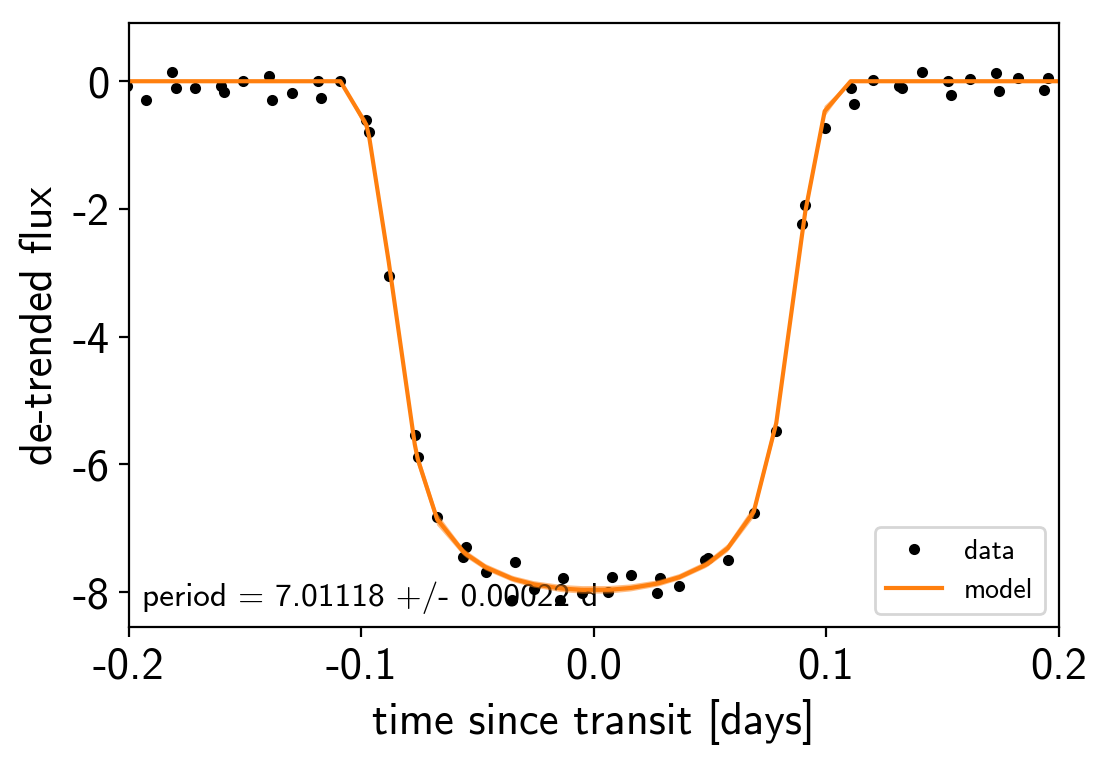

In [17]:
# Compute the GP prediction
gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace["light_curves"][:, inds, 0]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                       zorder=1000)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(trace["period"]), np.std(trace["period"]))
plt.annotate(txt, (0, 0), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
plt.xlim(-0.2, 0.2);

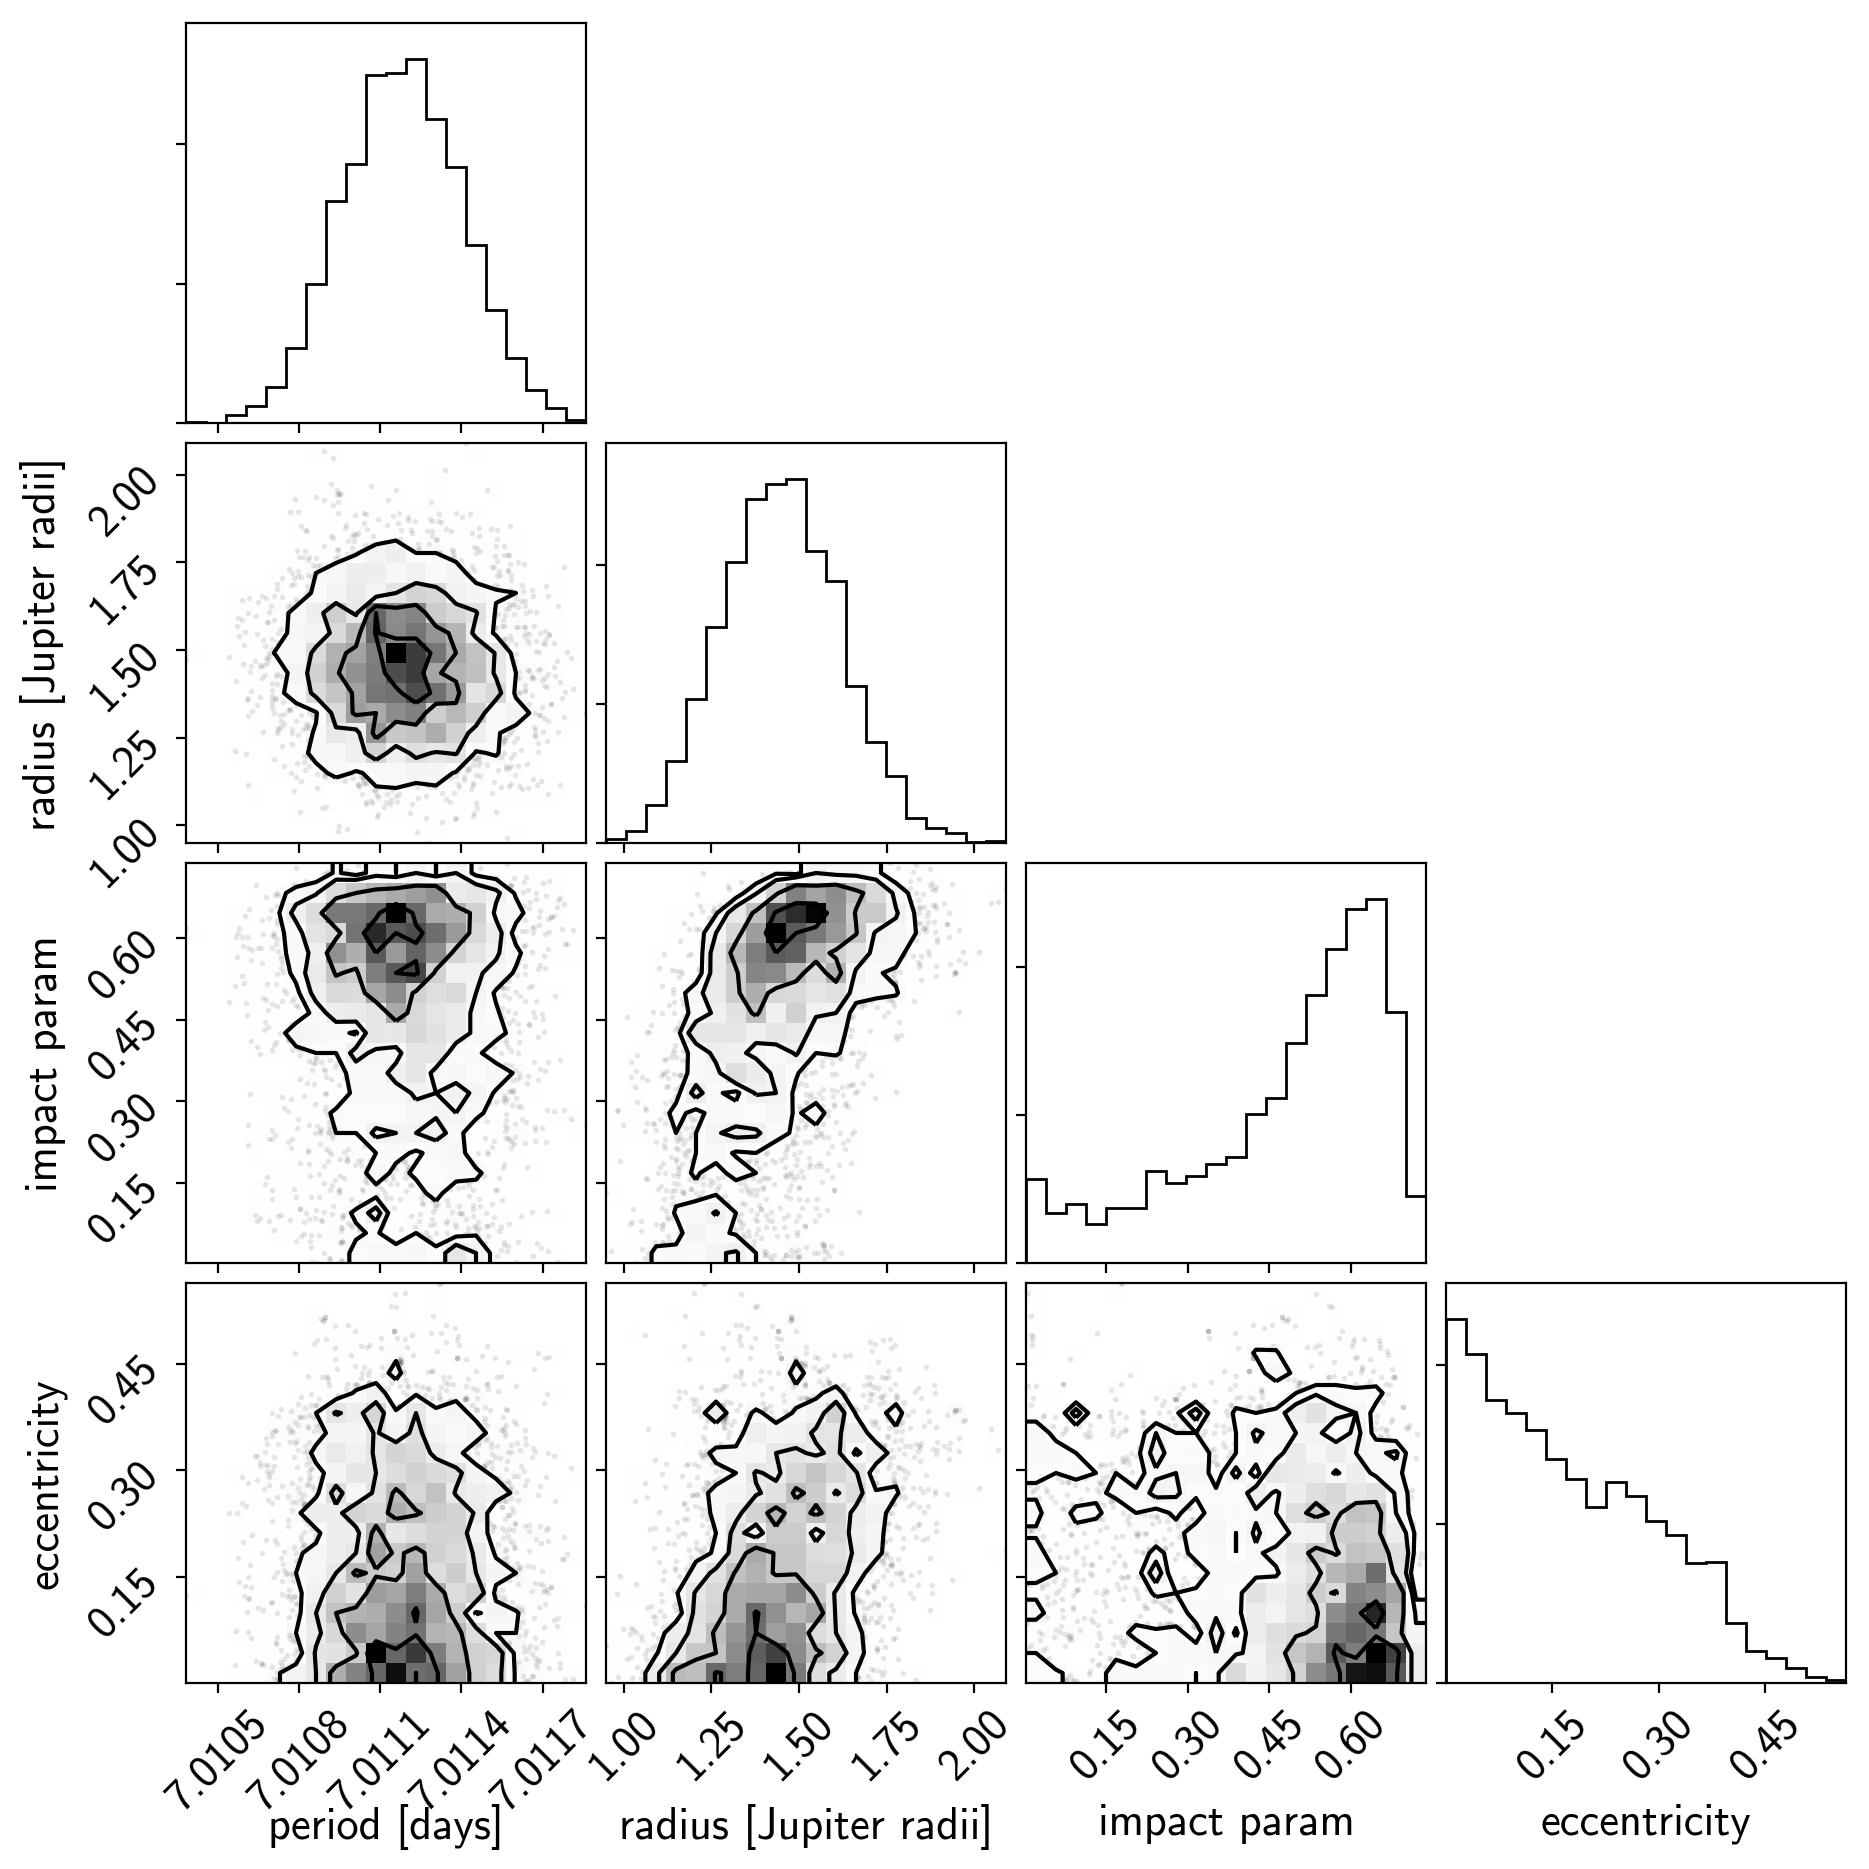

In [18]:
import corner
import astropy.units as u
varnames = ["period", "b", "ecc", "r_pl"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)

# Convert the radius to Earth radii
samples["r_pl"] = (np.array(samples["r_pl"]) * u.R_sun).to(u.R_jupiter).value

corner.corner(
    samples[["period", "r_pl", "b", "ecc"]],
    labels=["period [days]", "radius [Jupiter radii]", "impact param", "eccentricity"]);

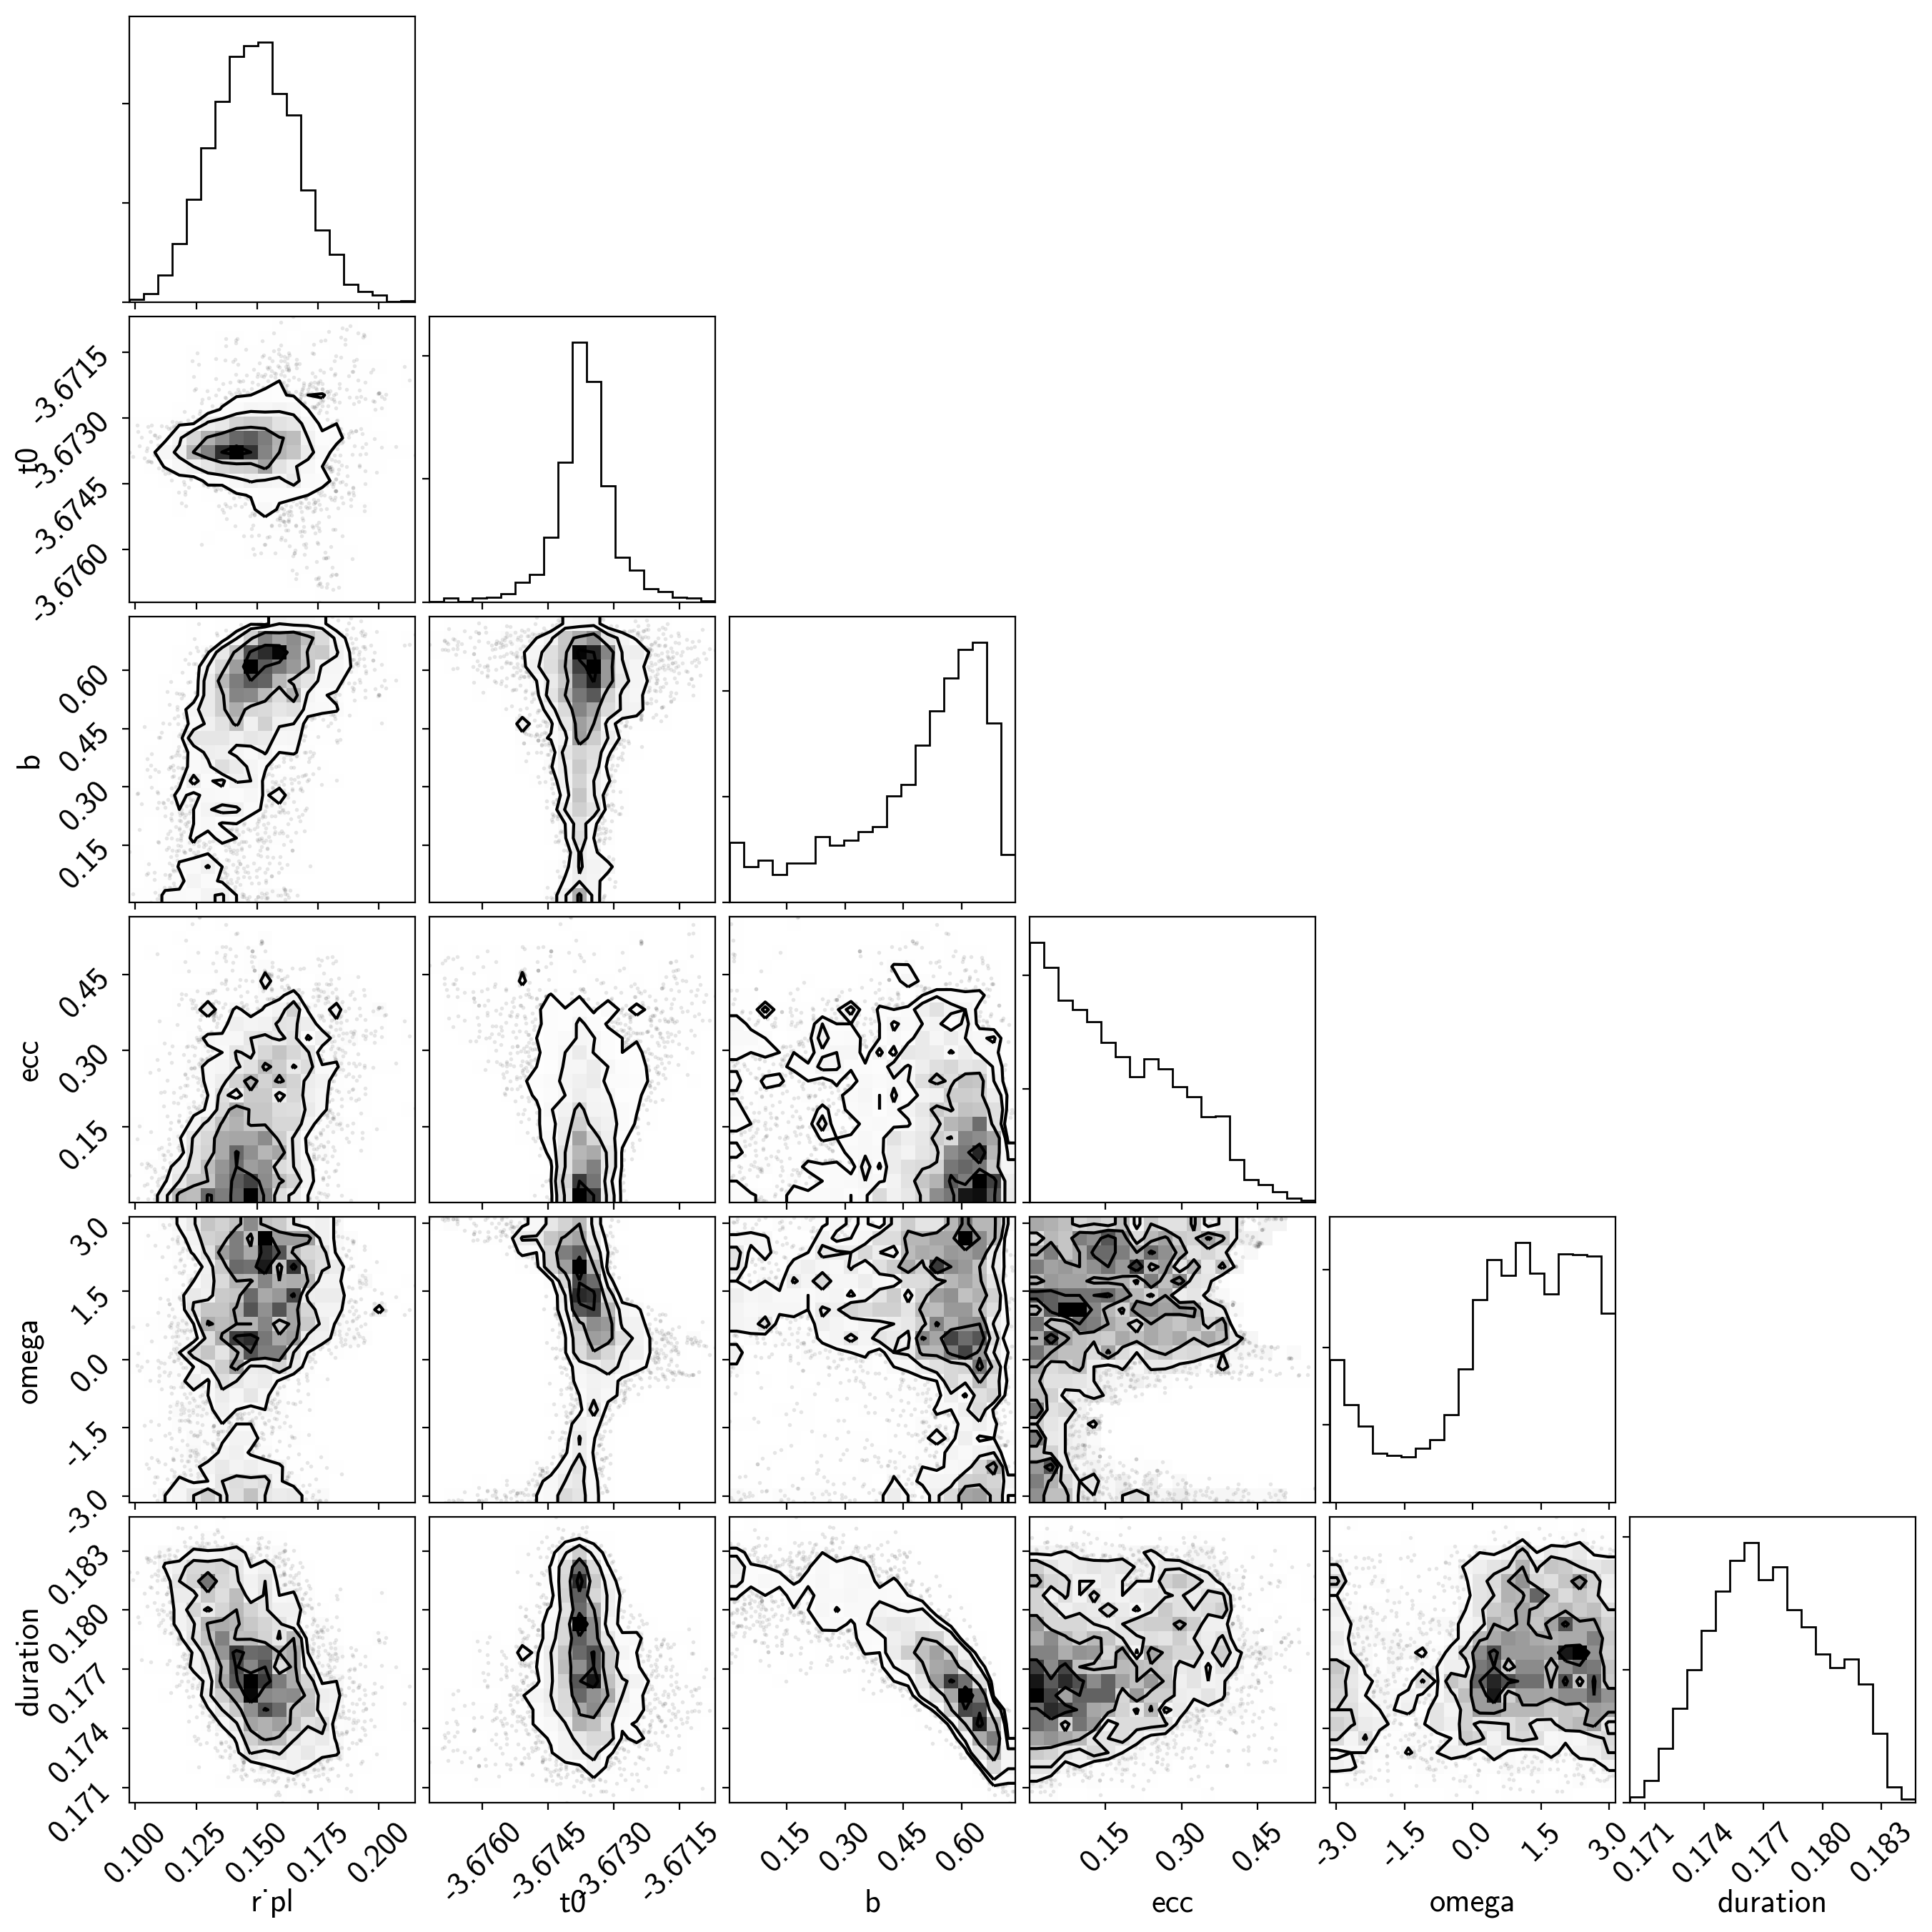

In [19]:
aor = -trace["a"] / trace["r_star"]
e = trace["ecc"]
w = trace["omega"]
i = trace["incl"]
b = trace["b"]
k = trace["r_pl"] / trace["r_star"]
P = trace["period"]

T_tot = P/np.pi * np.arcsin(np.sqrt(1 - b**2) / np.sin(i) / aor)
dur = T_tot * np.sqrt(1 - e**2) / (1 + e * np.sin(w))

samples = pm.trace_to_dataframe(trace, varnames=["r_pl", "t0", "b", "ecc", "omega"])
samples["duration"] = dur
corner.corner(samples);